In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [12]:
from utilities.userfold_framework import *
# from utilities.EEG_func import *
import Models.model_func as Model_Func
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    
    saved_dir= "./EEG/saved_models/Userfold/run0"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= LSTM_EEGNet_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{EPOCH}.pt"
           )
    )

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7061817879770317


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  0.7061817879770317 , v_loss:  0.695327619711558
t_acc:  0.5001556178026766 , v_acc:  0.3105590062111801
t_recall:  0.5001118568232662 , v_recall:  0.5
t_prec:  0.5000947365239716 , v_prec:  0.15527950310559005
t_f:  0.4802357598838324 , v_f:  0.23696682464454977
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 0.6546526329190123
Epoch  2 , loss 0.6147451950054542


Iterations:   1%|▎                                  | 3/300 [00:04<06:42,  1.35s/it]

Epoch:  2
t_loss:  0.6147451950054542 , v_loss:  0.6909502744674683
t_acc:  0.621537503890445 , v_acc:  0.6894409937888198
t_recall:  0.5062756481519606 , v_recall:  0.5
t_prec:  0.5082151934515611 , v_prec:  0.3447204968944099
t_f:  0.500221554772126 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:51,  1.19s/it]

Epoch  3 , loss 0.5777760592161441
Epoch  4 , loss 0.5468432505925497


Iterations:   2%|▌                                  | 5/300 [00:06<06:33,  1.33s/it]

Epoch:  4
t_loss:  0.5468432505925497 , v_loss:  0.6735602418581644
t_acc:  0.6760037348272643 , v_acc:  0.6894409937888198
t_recall:  0.4985575273465915 , v_recall:  0.5
t_prec:  0.4931806679614674 , v_prec:  0.3447204968944099
t_f:  0.440709374241783 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 0.5202284998753491
Epoch  6 , loss 0.49588727892613876


Iterations:   2%|▊                                  | 7/300 [00:09<06:46,  1.39s/it]

Epoch:  6
t_loss:  0.49588727892613876 , v_loss:  0.6626453399658203
t_acc:  0.6924992219109866 , v_acc:  0.6894409937888198
t_recall:  0.49948806631805764 , v_recall:  0.5
t_prec:  0.4840602831828153 , v_prec:  0.3447204968944099
t_f:  0.41495687430888323 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:09,  1.26s/it]

Epoch  7 , loss 0.48346582873194827
Epoch  8 , loss 0.46857233725342096


Iterations:   3%|█                                  | 9/300 [00:11<06:35,  1.36s/it]

Epoch:  8
t_loss:  0.46857233725342096 , v_loss:  0.6942213177680969
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:57,  1.23s/it]

Epoch  9 , loss 0.46825237075487774
Epoch  10 , loss 0.4625367159936942


Iterations:   4%|█▏                                | 11/300 [00:14<06:24,  1.33s/it]

Epoch:  10
t_loss:  0.4625367159936942 , v_loss:  0.7383571714162827
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:46,  1.20s/it]

Epoch  11 , loss 0.4579426149527232
Epoch  12 , loss 0.45729512268421696


Iterations:   4%|█▍                                | 13/300 [00:16<06:17,  1.31s/it]

Epoch:  12
t_loss:  0.45729512268421696 , v_loss:  0.7619000325600306
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 0.4601581225208208
Epoch  14 , loss 0.45816586707152573


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  0.45816586707152573 , v_loss:  0.7665957609812418
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 0.4568179138735229
Epoch  16 , loss 0.45931900657859503


Iterations:   6%|█▉                                | 17/300 [00:21<06:13,  1.32s/it]

Epoch:  16
t_loss:  0.45931900657859503 , v_loss:  0.7734028796354929
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:22<05:42,  1.22s/it]

Epoch  17 , loss 0.45532047164206413
Epoch  18 , loss 0.4576876432287927


Iterations:   6%|██▏                               | 19/300 [00:24<06:15,  1.33s/it]

Epoch:  18
t_loss:  0.4576876432287927 , v_loss:  0.7610281060139338
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 0.453772411626928
Epoch  20 , loss 0.45800356654559865


Iterations:   7%|██▍                               | 21/300 [00:27<06:18,  1.36s/it]

Epoch:  20
t_loss:  0.45800356654559865 , v_loss:  0.7632254064083099
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:42,  1.23s/it]

Epoch  21 , loss 0.4548158108019361
Epoch  22 , loss 0.45136258707327004


Iterations:   8%|██▌                               | 23/300 [00:29<06:12,  1.35s/it]

Epoch:  22
t_loss:  0.45136258707327004 , v_loss:  0.7563727547725042
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 0.44830095125179664
Epoch  24 , loss 0.4497796951555738


Iterations:   8%|██▊                               | 25/300 [00:32<06:04,  1.33s/it]

Epoch:  24
t_loss:  0.4497796951555738 , v_loss:  0.7714602649211884
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:32,  1.21s/it]

Epoch  25 , loss 0.4512568735608868
Epoch  26 , loss 0.44902388313237357


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  0.44902388313237357 , v_loss:  0.7650878131389618
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 0.44760235676578447
Epoch  28 , loss 0.4422973300896439


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.33s/it]

Epoch:  28
t_loss:  0.4422973300896439 , v_loss:  0.7698895633220673
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:37,  1.25s/it]

Epoch  29 , loss 0.44803427422747893
Epoch  30 , loss 0.45405907958161595


Iterations:  10%|███▌                              | 31/300 [00:40<06:06,  1.36s/it]

Epoch:  30
t_loss:  0.45405907958161595 , v_loss:  0.7587753583987554
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:34,  1.25s/it]

Epoch  31 , loss 0.44503257671991986
Epoch  32 , loss 0.4504146984979218


Iterations:  11%|███▋                              | 33/300 [00:42<05:59,  1.35s/it]

Epoch:  32
t_loss:  0.4504146984979218 , v_loss:  0.7428404539823532
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:25,  1.22s/it]

Epoch  33 , loss 0.442735435331569
Epoch  34 , loss 0.443640025807362


Iterations:  12%|███▉                              | 35/300 [00:45<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.443640025807362 , v_loss:  0.7337682992219925
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:46<05:21,  1.22s/it]

Epoch  35 , loss 0.44877132773399353
Epoch  36 , loss 0.4502849444454792


Iterations:  12%|████▏                             | 37/300 [00:47<05:45,  1.32s/it]

Epoch:  36
t_loss:  0.4502849444454792 , v_loss:  0.7368550896644592
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 0.4373367978077309
Epoch  38 , loss 0.4404653526988684


Iterations:  13%|████▍                             | 39/300 [00:50<05:44,  1.32s/it]

Epoch:  38
t_loss:  0.4404653526988684 , v_loss:  0.7273245851198832
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:19,  1.23s/it]

Epoch  39 , loss 0.4451495636911953
Epoch  40 , loss 0.44163749849095063


Iterations:  14%|████▋                             | 41/300 [00:52<05:43,  1.33s/it]

Epoch:  40
t_loss:  0.44163749849095063 , v_loss:  0.7184118976195654
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.21s/it]

Epoch  41 , loss 0.4416468067496431
Epoch  42 , loss 0.4388350452862534


Iterations:  14%|████▊                             | 43/300 [00:55<05:39,  1.32s/it]

Epoch:  42
t_loss:  0.4388350452862534 , v_loss:  0.7020767033100128
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:07,  1.20s/it]

Epoch  43 , loss 0.43511631617359087
Epoch  44 , loss 0.4363119152246737


Iterations:  15%|█████                             | 45/300 [00:57<05:39,  1.33s/it]

Epoch:  44
t_loss:  0.4363119152246737 , v_loss:  0.695197214682897
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 0.43545469933865116
Epoch  46 , loss 0.4351024580936806


Iterations:  16%|█████▎                            | 47/300 [01:00<05:37,  1.34s/it]

Epoch:  46
t_loss:  0.4351024580936806 , v_loss:  0.6873628546794256
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5026200573695119 , v_recall:  0.5
t_prec:  0.7233619344773792 , v_prec:  0.3447204968944099
t_f:  0.4165631338742394 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:05,  1.21s/it]

Epoch  47 , loss 0.4335777946546966
Epoch  48 , loss 0.44410743608194236


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.33s/it]

Epoch:  48
t_loss:  0.44410743608194236 , v_loss:  0.6832670867443085
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:02,  1.21s/it]

Epoch  49 , loss 0.4353373144187179
Epoch  50 , loss 0.4350934466894935


Iterations:  17%|█████▊                            | 51/300 [01:05<05:28,  1.32s/it]

Epoch:  50
t_loss:  0.4350934466894935 , v_loss:  0.6711946030457815
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5029075911667422 , v_recall:  0.5
t_prec:  0.6984233531064628 , v_prec:  0.3447204968944099
t_f:  0.41753003679311723 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:02,  1.22s/it]

Epoch  51 , loss 0.43565235301560046
Epoch  52 , loss 0.4393497313938889


Iterations:  18%|██████                            | 53/300 [01:07<05:30,  1.34s/it]

Epoch:  52
t_loss:  0.4393497313938889 , v_loss:  0.6695316135883331
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.499232785715266 , v_recall:  0.5
t_prec:  0.44764283484233536 , v_prec:  0.3447204968944099
t_f:  0.4115498523659419 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:07,  1.25s/it]

Epoch  53 , loss 0.43138158029200985
Epoch  54 , loss 0.43364831162434


Iterations:  18%|██████▏                           | 55/300 [01:10<05:32,  1.36s/it]

Epoch:  54
t_loss:  0.43364831162434 , v_loss:  0.6673812121152878
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:02,  1.24s/it]

Epoch  55 , loss 0.4269415993316501
Epoch  56 , loss 0.4311545578872456


Iterations:  19%|██████▍                           | 57/300 [01:13<05:26,  1.34s/it]

Epoch:  56
t_loss:  0.4311545578872456 , v_loss:  0.6606495082378387
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5035464789119007 , v_recall:  0.5
t_prec:  0.6426783479349187 , v_prec:  0.3447204968944099
t_f:  0.4202877765739024 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:54,  1.22s/it]

Epoch  57 , loss 0.43056608824168935
Epoch  58 , loss 0.43399972424787636


Iterations:  20%|██████▋                           | 59/300 [01:15<05:16,  1.32s/it]

Epoch:  58
t_loss:  0.43399972424787636 , v_loss:  0.654564619064331
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5012777754903172 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.3447204968944099
t_f:  0.4158754021869472 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:48,  1.20s/it]

Epoch  59 , loss 0.4344312273988537
Epoch  60 , loss 0.4317535676208197


Iterations:  20%|██████▉                           | 61/300 [01:18<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.4317535676208197 , v_loss:  0.6487409025430679
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:48,  1.21s/it]

Epoch  61 , loss 0.4296218419776243
Epoch  62 , loss 0.4282627801100413


Iterations:  21%|███████▏                          | 63/300 [01:20<05:14,  1.33s/it]

Epoch:  62
t_loss:  0.4282627801100413 , v_loss:  0.6459983537594477
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:53,  1.24s/it]

Epoch  63 , loss 0.42701272520364497
Epoch  64 , loss 0.43174628592004965


Iterations:  22%|███████▎                          | 65/300 [01:23<05:14,  1.34s/it]

Epoch:  64
t_loss:  0.43174628592004965 , v_loss:  0.6425937116146088
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:48,  1.23s/it]

Epoch  65 , loss 0.4337149864318324
Epoch  66 , loss 0.4272831374523686


Iterations:  22%|███████▌                          | 67/300 [01:25<05:10,  1.33s/it]

Epoch:  66
t_loss:  0.4272831374523686 , v_loss:  0.6411219984292984
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5053677550404194 , v_recall:  0.5
t_prec:  0.66713199054158 , v_prec:  0.3447204968944099
t_f:  0.4244312569111685 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:40,  1.21s/it]

Epoch  67 , loss 0.4274708914990519
Epoch  68 , loss 0.4250772215572058


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  0.4250772215572058 , v_loss:  0.635910322268804
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5061027161307147 , v_recall:  0.5
t_prec:  0.6900159539614256 , v_prec:  0.3447204968944099
t_f:  0.4256155547364541 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:41,  1.22s/it]

Epoch  69 , loss 0.4311328974424624
Epoch  70 , loss 0.43009180999269675


Iterations:  24%|████████                          | 71/300 [01:31<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.43009180999269675 , v_loss:  0.6314315150181452
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.507252851319636 , v_recall:  0.5
t_prec:  0.6660226201696513 , v_prec:  0.3447204968944099
t_f:  0.4293327796234772 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:37,  1.22s/it]

Epoch  71 , loss 0.41829122281542014
Epoch  72 , loss 0.4212931762723362


Iterations:  24%|████████▎                         | 73/300 [01:33<05:03,  1.34s/it]

Epoch:  72
t_loss:  0.4212931762723362 , v_loss:  0.6322309921185175
t_acc:  0.7009025832555245 , v_acc:  0.6894409937888198
t_recall:  0.5104164093273493 , v_recall:  0.5
t_prec:  0.7465831311731069 , v_prec:  0.3447204968944099
t_f:  0.4341706229488249 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:35,  1.22s/it]

Epoch  73 , loss 0.42350056299976274
Epoch  74 , loss 0.43179231589915706


Iterations:  25%|████████▌                         | 75/300 [01:36<04:55,  1.31s/it]

Epoch:  74
t_loss:  0.43179231589915706 , v_loss:  0.6258880843718847
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5076680254182622 , v_recall:  0.5
t_prec:  0.6389225031081641 , v_prec:  0.3447204968944099
t_f:  0.4318199019022807 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:31,  1.21s/it]

Epoch  75 , loss 0.42656805643848345
Epoch  76 , loss 0.4266752320177415


Iterations:  26%|████████▋                         | 77/300 [01:38<04:56,  1.33s/it]

Epoch:  76
t_loss:  0.4266752320177415 , v_loss:  0.628232792019844
t_acc:  0.7037037037037037 , v_acc:  0.6894409937888198
t_recall:  0.5150176363212144 , v_recall:  0.5
t_prec:  0.7720762536261914 , v_prec:  0.3447204968944099
t_f:  0.4435108504228099 , v_f:  0.4080882352941176
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:35,  1.24s/it]

Epoch  77 , loss 0.42252438676123527
Epoch  78 , loss 0.4300909620874068


Iterations:  26%|████████▉                         | 79/300 [01:41<05:00,  1.36s/it]

Epoch:  78
t_loss:  0.4300909620874068 , v_loss:  0.6251386354366938
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5093616612453851 , v_recall:  0.5
t_prec:  0.67413540744775 , v_prec:  0.3447204968944099
t_f:  0.4342903026402157 , v_f:  0.4080882352941176
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:33,  1.24s/it]

Epoch  79 , loss 0.4226706746746512
Epoch  80 , loss 0.41952360728207755


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.33s/it]

Epoch:  80
t_loss:  0.41952360728207755 , v_loss:  0.6253261019786199
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5090741274481547 , v_recall:  0.5
t_prec:  0.6783196979232222 , v_prec:  0.3447204968944099
t_f:  0.4333828345311067 , v_f:  0.4080882352941176
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 0.4230341408766952
Epoch  82 , loss 0.42709216183307125


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:45,  1.31s/it]

Epoch:  82
t_loss:  0.42709216183307125 , v_loss:  0.622789536913236
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5100328021849824 , v_recall:  0.5
t_prec:  0.7028939918213275 , v_prec:  0.3447204968944099
t_f:  0.4346869702469517 , v_f:  0.4080882352941176
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:20,  1.20s/it]

Epoch  83 , loss 0.4255303623629551
Epoch  84 , loss 0.4151276607139438


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:43,  1.32s/it]

Epoch:  84
t_loss:  0.4151276607139438 , v_loss:  0.621457373102506
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.5128443200065879 , v_recall:  0.5
t_prec:  0.6740986717267552 , v_prec:  0.3447204968944099
t_f:  0.44285373960590346 , v_f:  0.4080882352941176
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:19,  1.21s/it]

Epoch  85 , loss 0.41650207369935277
Epoch  86 , loss 0.4214747168269812


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.4214747168269812 , v_loss:  0.607483521103859
t_acc:  0.7030812324929971 , v_acc:  0.6894409937888198
t_recall:  0.5151452766226102 , v_recall:  0.5
t_prec:  0.7374207521730399 , v_prec:  0.3447204968944099
t_f:  0.4450001520943391 , v_f:  0.4080882352941176
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:21,  1.23s/it]

Epoch  87 , loss 0.41607996821403503
Epoch  88 , loss 0.4240676719768375


Iterations:  30%|██████████                        | 89/300 [01:53<04:41,  1.34s/it]

Epoch:  88
t_loss:  0.4240676719768375 , v_loss:  0.6075475364923477
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5117580049683644 , v_recall:  0.5
t_prec:  0.6764185005697341 , v_prec:  0.3447204968944099
t_f:  0.4400706624861162 , v_f:  0.4080882352941176
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:17,  1.23s/it]

Epoch  89 , loss 0.4248021846892787
Epoch  90 , loss 0.42428701765397014


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  0.42428701765397014 , v_loss:  0.6050018866856893
t_acc:  0.6999688764394647 , v_acc:  0.6956521739130435
t_recall:  0.5137707415489768 , v_recall:  0.51
t_prec:  0.6591103710751665 , v_prec:  0.846875
t_f:  0.44618741712476023 , v_f:  0.42920193907821425
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:10,  1.21s/it]

Epoch  91 , loss 0.41674623010205286
Epoch  92 , loss 0.42225303720025453


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:35,  1.33s/it]

Epoch:  92
t_loss:  0.42225303720025453 , v_loss:  0.6028942664464315
t_acc:  0.7009025832555245 , v_acc:  0.6956521739130435
t_recall:  0.5141543486913438 , v_recall:  0.51
t_prec:  0.6781276987736773 , v_prec:  0.846875
t_f:  0.44575297403378117 , v_f:  0.42920193907821425
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:10,  1.21s/it]

Epoch  93 , loss 0.42334626118342084
Epoch  94 , loss 0.4131501317024231


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:33,  1.34s/it]

Epoch:  94
t_loss:  0.4131501317024231 , v_loss:  0.6025319298108419
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.514346495381617 , v_recall:  0.52
t_prec:  0.741126626272568 , v_prec:  0.8490566037735849
t_f:  0.44309188848171044 , v_f:  0.44957264957264953
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:07,  1.21s/it]

Epoch  95 , loss 0.41687898425494924
Epoch  96 , loss 0.41974339122865717


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:28,  1.32s/it]

Epoch:  96
t_loss:  0.41974339122865717 , v_loss:  0.6005411595106125
t_acc:  0.7049486461251168 , v_acc:  0.7018633540372671
t_recall:  0.5170626260962655 , v_recall:  0.52
t_prec:  0.7800378429517503 , v_prec:  0.8490566037735849
t_f:  0.44761376248612655 , v_f:  0.44957264957264953
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:03,  1.20s/it]

Epoch  97 , loss 0.4174097560200037
Epoch  98 , loss 0.42267824738633397


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.42267824738633397 , v_loss:  0.59725854297479
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5150492032774735 , v_recall:  0.52
t_prec:  0.7039848197343453 , v_prec:  0.8490566037735849
t_f:  0.4463250558700412 , v_f:  0.44957264957264953
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:00,  1.20s/it]

Epoch  99 , loss 0.4194737684492971
Epoch  100 , loss 0.41916689685746733


Iterations:  34%|███████████                      | 101/300 [02:09<04:21,  1.31s/it]

Epoch:  100
t_loss:  0.41916689685746733 , v_loss:  0.599313497543335
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.5146978493295453 , v_recall:  0.53
t_prec:  0.7205282739116706 , v_prec:  0.8512658227848101
t_f:  0.44471737898000735 , v_f:  0.4692431787893666
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 0.41701053287468703
Epoch  102 , loss 0.4164745679088667


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:23,  1.34s/it]

Epoch:  102
t_loss:  0.4164745679088667 , v_loss:  0.6009612629810969
t_acc:  0.706504824151883 , v_acc:  0.7080745341614907
t_recall:  0.5224942012873828 , v_recall:  0.53
t_prec:  0.7332670721408849 , v_prec:  0.8512658227848101
t_f:  0.46118070937171285 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:04,  1.25s/it]

Epoch  103 , loss 0.4181511267727497
Epoch  104 , loss 0.41934555067735557


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:24,  1.35s/it]

Epoch:  104
t_loss:  0.41934555067735557 , v_loss:  0.5888387809197108
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5179567944442157 , v_recall:  0.54
t_prec:  0.7041404884746609 , v_prec:  0.8535031847133758
t_f:  0.45293226323021607 , v_f:  0.488253178551686
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<04:00,  1.24s/it]

Epoch  105 , loss 0.4149216506995407
Epoch  106 , loss 0.40862220701049357


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:18,  1.34s/it]

Epoch:  106
t_loss:  0.40862220701049357 , v_loss:  0.5892179558674494
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.5185318620386764 , v_recall:  0.53
t_prec:  0.6979645195973023 , v_prec:  0.8512658227848101
t_f:  0.4546253617216517 , v_f:  0.4692431787893666
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:54,  1.22s/it]

Epoch  107 , loss 0.410258890951381
Epoch  108 , loss 0.4142535492485645


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.4142535492485645 , v_loss:  0.5893588066101074
t_acc:  0.7068160597572363 , v_acc:  0.7142857142857143
t_recall:  0.5224303811366849 , v_recall:  0.54
t_prec:  0.7432766354398221 , v_prec:  0.8535031847133758
t_f:  0.4605032184648906 , v_f:  0.488253178551686
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 0.41538798516871883
Epoch  110 , loss 0.41103920749589506


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:10,  1.32s/it]

Epoch:  110
t_loss:  0.41103920749589506 , v_loss:  0.5832784573237101
t_acc:  0.7061935885465297 , v_acc:  0.7080745341614907
t_recall:  0.5234206228297718 , v_recall:  0.5354954954954955
t_prec:  0.7147270271630624 , v_prec:  0.7525641025641026
t_f:  0.4643191698892706 , v_f:  0.4847122914538645
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:53,  1.24s/it]

Epoch  111 , loss 0.4186215675344654
Epoch  112 , loss 0.41333554714333776


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:07,  1.32s/it]

Epoch:  112
t_loss:  0.41333554714333776 , v_loss:  0.5917039265235265
t_acc:  0.7105508870214753 , v_acc:  0.7142857142857143
t_recall:  0.5317282222313721 , v_recall:  0.54
t_prec:  0.7271841320797983 , v_prec:  0.8535031847133758
t_f:  0.48092797832053646 , v_f:  0.488253178551686
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:48,  1.23s/it]

Epoch  113 , loss 0.412775423596887
Epoch  114 , loss 0.4118837100618026


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:05,  1.32s/it]

Epoch:  114
t_loss:  0.4118837100618026 , v_loss:  0.58342145383358
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5182120750470073 , v_recall:  0.5354954954954955
t_prec:  0.673669400575866 , v_prec:  0.7525641025641026
t_f:  0.45569605912420064 , v_f:  0.4847122914538645
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:42,  1.21s/it]

Epoch  115 , loss 0.41090716801437677
Epoch  116 , loss 0.4204738905616835


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  0.4204738905616835 , v_loss:  0.5834315866231918
t_acc:  0.7083722377840025 , v_acc:  0.7080745341614907
t_recall:  0.528437023922263 , v_recall:  0.5354954954954955
t_prec:  0.7142214640198512 , v_prec:  0.7525641025641026
t_f:  0.47507002801120446 , v_f:  0.4847122914538645
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 0.41152016964613225
Epoch  118 , loss 0.41474070268518787


Iterations:  40%|█████████████                    | 119/300 [02:32<04:05,  1.36s/it]

Epoch:  118
t_loss:  0.41474070268518787 , v_loss:  0.5785908152659734
t_acc:  0.7055711173358232 , v_acc:  0.7142857142857143
t_recall:  0.5215355265505552 , v_recall:  0.5454954954954955
t_prec:  0.7201112877583467 , v_prec:  0.771505376344086
t_f:  0.4598829316141506 , v_f:  0.5028195488721805
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 0.4106764799239589
Epoch  120 , loss 0.4152083180698694


Iterations:  40%|█████████████▎                   | 121/300 [02:34<04:01,  1.35s/it]

Epoch:  120
t_loss:  0.4152083180698694 , v_loss:  0.5769093732039133
t_acc:  0.7117958294428882 , v_acc:  0.7142857142857143
t_recall:  0.53118540783135 , v_recall:  0.5454954954954955
t_prec:  0.7593480345158198 , v_prec:  0.771505376344086
t_f:  0.47771394987297616 , v_f:  0.5028195488721805
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:37,  1.22s/it]

Epoch  121 , loss 0.41406549308814256
Epoch  122 , loss 0.41230853807692436


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:54,  1.32s/it]

Epoch:  122
t_loss:  0.41230853807692436 , v_loss:  0.5867203424374262
t_acc:  0.706504824151883 , v_acc:  0.7142857142857143
t_recall:  0.5247944716652255 , v_recall:  0.5454954954954955
t_prec:  0.7086165749259017 , v_prec:  0.771505376344086
t_f:  0.4677234808990797 , v_f:  0.5028195488721805
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:32,  1.21s/it]

Epoch  123 , loss 0.4058598320858151
Epoch  124 , loss 0.4098016292441125


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.4098016292441125 , v_loss:  0.5806721051534017
t_acc:  0.710239651416122 , v_acc:  0.7142857142857143
t_recall:  0.5320795761793002 , v_recall:  0.5454954954954955
t_prec:  0.7189008210283145 , v_prec:  0.771505376344086
t_f:  0.4822894645068445 , v_f:  0.5028195488721805
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 0.41298719656233696
Epoch  126 , loss 0.413846481664508


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:54,  1.36s/it]

Epoch:  126
t_loss:  0.413846481664508 , v_loss:  0.5859911243120829
t_acc:  0.707749766573296 , v_acc:  0.7142857142857143
t_recall:  0.526264393845816 , v_recall:  0.5454954954954955
t_prec:  0.7209842565148774 , v_prec:  0.771505376344086
t_f:  0.4699812816163689 , v_f:  0.5028195488721805
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:35,  1.25s/it]

Epoch  127 , loss 0.41778489713575323
Epoch  128 , loss 0.4094652989331414


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:52,  1.36s/it]

Epoch:  128
t_loss:  0.4094652989331414 , v_loss:  0.5850886404514313
t_acc:  0.7086834733893558 , v_acc:  0.7142857142857143
t_recall:  0.5289482713660257 , v_recall:  0.5454954954954955
t_prec:  0.7158220378872115 , v_prec:  0.771505376344086
t_f:  0.476021554535875 , v_f:  0.5028195488721805
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:30,  1.24s/it]

Epoch  129 , loss 0.404410684225606
Epoch  130 , loss 0.4107221966865016


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.34s/it]

Epoch:  130
t_loss:  0.4107221966865016 , v_loss:  0.5829099267721176
t_acc:  0.7086834733893558 , v_acc:  0.7142857142857143
t_recall:  0.5286607375687954 , v_recall:  0.5454954954954955
t_prec:  0.718183622863352 , v_prec:  0.771505376344086
t_f:  0.4752381816532075 , v_f:  0.5028195488721805
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:25,  1.22s/it]

Epoch  131 , loss 0.41743503189554404
Epoch  132 , loss 0.41129934086519127


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.41129934086519127 , v_loss:  0.5785176505645117
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5242832242214628 , v_recall:  0.5454954954954955
t_prec:  0.7067406189871543 , v_prec:  0.771505376344086
t_f:  0.46675574371127787 , v_f:  0.5028195488721805
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:23,  1.23s/it]

Epoch  133 , loss 0.40793120101386426
Epoch  134 , loss 0.4020988654856588


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.32s/it]

Epoch:  134
t_loss:  0.4020988654856588 , v_loss:  0.5818209499120712
t_acc:  0.7111733582321818 , v_acc:  0.7142857142857143
t_recall:  0.5327507171188977 , v_recall:  0.5454954954954955
t_prec:  0.7299630581432701 , v_prec:  0.771505376344086
t_f:  0.4828118777258642 , v_f:  0.5028195488721805
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:23,  1.24s/it]

Epoch  135 , loss 0.40663958822979646
Epoch  136 , loss 0.40902353034299965


Iterations:  46%|███████████████                  | 137/300 [02:55<03:36,  1.33s/it]

Epoch:  136
t_loss:  0.40902353034299965 , v_loss:  0.5790337324142456
t_acc:  0.711484593837535 , v_acc:  0.7267080745341615
t_recall:  0.5323993631709694 , v_recall:  0.5654954954954955
t_prec:  0.7390854461361871 , v_prec:  0.7969771241830066
t_f:  0.4814465902093208 , v_f:  0.5373563218390804
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:18,  1.22s/it]

Epoch  137 , loss 0.41200660023034785
Epoch  138 , loss 0.40886256975286145


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.40886256975286145 , v_loss:  0.5910964359839758
t_acc:  0.7155306567071273 , v_acc:  0.7142857142857143
t_recall:  0.5407707827232676 , v_recall:  0.5454954954954955
t_prec:  0.7401066925315228 , v_prec:  0.771505376344086
t_f:  0.49801543346625315 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:13,  1.21s/it]

Epoch  139 , loss 0.4107180185177747
Epoch  140 , loss 0.3998844661549026


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.3998844661549026 , v_loss:  0.5777940700451533
t_acc:  0.7167755991285403 , v_acc:  0.7391304347826086
t_recall:  0.5410905697149366 , v_recall:  0.5854954954954955
t_prec:  0.7586060948081264 , v_prec:  0.8142384105960265
t_f:  0.49729894227198324 , v_f:  0.5698473282442748
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:11,  1.21s/it]

Epoch  141 , loss 0.4035412710086972
Epoch  142 , loss 0.4034261472669302


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:31,  1.35s/it]

Epoch:  142
t_loss:  0.4034261472669302 , v_loss:  0.5819697827100754
t_acc:  0.7124183006535948 , v_acc:  0.7329192546583851
t_recall:  0.5365209096773308 , v_recall:  0.5754954954954955
t_prec:  0.7222075312037233 , v_prec:  0.8062865497076024
t_f:  0.4910498648428103 , v_f:  0.5538441709093253
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:11,  1.23s/it]

Epoch  143 , loss 0.4079951357607748
Epoch  144 , loss 0.411332204061396


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:27,  1.34s/it]

Epoch:  144
t_loss:  0.411332204061396 , v_loss:  0.5720866272846857
t_acc:  0.7108621226268285 , v_acc:  0.7453416149068323
t_recall:  0.5342522062557472 , v_recall:  0.5954954954954955
t_prec:  0.713729660291179 , v_prec:  0.8212121212121212
t_f:  0.48717727130986505 , v_f:  0.5853903649268262
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.21s/it]

Epoch  145 , loss 0.4060848086488013
Epoch  146 , loss 0.40196043954176064


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:20,  1.31s/it]

Epoch:  146
t_loss:  0.40196043954176064 , v_loss:  0.5732515851656595
t_acc:  0.7170868347338936 , v_acc:  0.7453416149068323
t_recall:  0.5424644185503905 , v_recall:  0.5954954954954955
t_prec:  0.7521008403361344 , v_prec:  0.8212121212121212
t_f:  0.5004001941185234 , v_f:  0.5853903649268262
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:02,  1.20s/it]

Epoch  147 , loss 0.4142613481072819
Epoch  148 , loss 0.4046899150399601


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.4046899150399601 , v_loss:  0.5743275731801987
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5283409505771263 , v_recall:  0.5954954954954955
t_prec:  0.6989993575329264 , v_prec:  0.8212121212121212
t_f:  0.47612410028266416 , v_f:  0.5853903649268262
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:01,  1.21s/it]

Epoch  149 , loss 0.3985601330504698
Epoch  150 , loss 0.4042298098405202


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:19,  1.34s/it]

Epoch:  150
t_loss:  0.4042298098405202 , v_loss:  0.5716921736796697
t_acc:  0.7164643635231871 , v_acc:  0.7453416149068323
t_recall:  0.5446047954323987 , v_recall:  0.5954954954954955
t_prec:  0.7281808905510594 , v_prec:  0.8212121212121212
t_f:  0.5064135781994158 , v_f:  0.5853903649268262
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:04,  1.24s/it]

Epoch  151 , loss 0.3997574921916513
Epoch  152 , loss 0.4086279629492292


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:18,  1.35s/it]

Epoch:  152
t_loss:  0.4086279629492292 , v_loss:  0.573036253452301
t_acc:  0.7130407718643013 , v_acc:  0.7453416149068323
t_recall:  0.5389810735510081 , v_recall:  0.5954954954954955
t_prec:  0.7157769448946516 , v_prec:  0.8212121212121212
t_f:  0.4965285048063196 , v_f:  0.5853903649268262
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:59,  1.23s/it]

Epoch  153 , loss 0.4021371871817346
Epoch  154 , loss 0.4074077682167876


Iterations:  52%|█████████████████                | 155/300 [03:18<03:13,  1.34s/it]

Epoch:  154
t_loss:  0.4074077682167876 , v_loss:  0.5673347314198812
t_acc:  0.7130407718643013 , v_acc:  0.7453416149068323
t_recall:  0.5381184721593171 , v_recall:  0.5954954954954955
t_prec:  0.7209495043781258 , v_prec:  0.8212121212121212
t_f:  0.4943525757006793 , v_f:  0.5853903649268262
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:55,  1.22s/it]

Epoch  155 , loss 0.40155807751066547
Epoch  156 , loss 0.40744515902855816


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:09,  1.33s/it]

Epoch:  156
t_loss:  0.40744515902855816 , v_loss:  0.5712398191293081
t_acc:  0.7130407718643013 , v_acc:  0.7453416149068323
t_recall:  0.5398436749426991 , v_recall:  0.5954954954954955
t_prec:  0.7110869006704057 , v_prec:  0.8212121212121212
t_f:  0.49867967876357555 , v_f:  0.5853903649268262
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.21s/it]

Epoch  157 , loss 0.4009038268351087
Epoch  158 , loss 0.40948523318066316


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:05,  1.32s/it]

Epoch:  158
t_loss:  0.40948523318066316 , v_loss:  0.5674050350983938
t_acc:  0.7201991907874261 , v_acc:  0.7515527950310559
t_recall:  0.54901456197417 , v_recall:  0.6054954954954955
t_prec:  0.7507395514947834 , v_prec:  0.8274608501118568
t_f:  0.5129152654240119 , v_f:  0.6004962779156328
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.23s/it]

Epoch  159 , loss 0.4026008943716685
Epoch  160 , loss 0.3980890506622838


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:04,  1.33s/it]

Epoch:  160
t_loss:  0.3980890506622838 , v_loss:  0.5719662110010783
t_acc:  0.7226890756302521 , v_acc:  0.7515527950310559
t_recall:  0.5519544063353509 , v_recall:  0.6054954954954955
t_prec:  0.7657786587905993 , v_prec:  0.8274608501118568
t_f:  0.5172497235737425 , v_f:  0.6004962779156328
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:50,  1.23s/it]

Epoch  161 , loss 0.40205735844724316
Epoch  162 , loss 0.39964299342211557


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.33s/it]

Epoch:  162
t_loss:  0.39964299342211557 , v_loss:  0.5714311848084132
t_acc:  0.7149081854964208 , v_acc:  0.7515527950310559
t_recall:  0.5437737609969668 , v_recall:  0.6054954954954955
t_prec:  0.7136798710086605 , v_prec:  0.8274608501118568
t_f:  0.5061441932205801 , v_f:  0.6004962779156328
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:45,  1.22s/it]

Epoch  163 , loss 0.4039873884004705
Epoch  164 , loss 0.40335553767634375


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:59,  1.33s/it]

Epoch:  164
t_loss:  0.40335553767634375 , v_loss:  0.5736189931631088
t_acc:  0.7145969498910676 , v_acc:  0.7453416149068323
t_recall:  0.540674709378131 , v_recall:  0.5954954954954955
t_prec:  0.7268512612203448 , v_prec:  0.8212121212121212
t_f:  0.49889985977187634 , v_f:  0.5853903649268262
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:42,  1.21s/it]

Epoch  165 , loss 0.40448235004555944
Epoch  166 , loss 0.3962676881575117


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.34s/it]

Epoch:  166
t_loss:  0.3962676881575117 , v_loss:  0.5696679701407751
t_acc:  0.7198879551820728 , v_acc:  0.7515527950310559
t_recall:  0.5470656455442555 , v_recall:  0.6054954954954955
t_prec:  0.7605285149918963 , v_prec:  0.8274608501118568
t_f:  0.5085419244313315 , v_f:  0.6004962779156328
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:40,  1.22s/it]

Epoch  167 , loss 0.4032594427174213
Epoch  168 , loss 0.39903079353126825


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:55,  1.34s/it]

Epoch:  168
t_loss:  0.39903079353126825 , v_loss:  0.5741641670465469
t_acc:  0.7155306567071273 , v_acc:  0.7515527950310559
t_recall:  0.5424959855066497 , v_recall:  0.6054954954954955
t_prec:  0.7284013454899532 , v_prec:  0.8274608501118568
t_f:  0.5023213958879873 , v_f:  0.6004962779156328
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.22s/it]

Epoch  169 , loss 0.40222905663882985
Epoch  170 , loss 0.40199366387198954


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.33s/it]

Epoch:  170
t_loss:  0.40199366387198954 , v_loss:  0.5697003851334254
t_acc:  0.7195767195767195 , v_acc:  0.7515527950310559
t_recall:  0.5514424726534085 , v_recall:  0.6054954954954955
t_prec:  0.7288378255171235 , v_prec:  0.8274608501118568
t_f:  0.5192686087248644 , v_f:  0.6004962779156328
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:34,  1.21s/it]

Epoch  171 , loss 0.4001094587877685
Epoch  172 , loss 0.4028692794781105


Iterations:  58%|███████████████████              | 173/300 [03:41<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.4028692794781105 , v_loss:  0.5656174371639887
t_acc:  0.7211328976034859 , v_acc:  0.7515527950310559
t_recall:  0.5499732367109976 , v_recall:  0.6054954954954955
t_prec:  0.7574125132555674 , v_prec:  0.8274608501118568
t_f:  0.5141971933661381 , v_f:  0.6004962779156328
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:31,  1.20s/it]

Epoch  173 , loss 0.40643883803311515
Epoch  174 , loss 0.39716315094162435


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.39716315094162435 , v_loss:  0.5693404376506805
t_acc:  0.7205104263927793 , v_acc:  0.7515527950310559
t_recall:  0.5495258094179328 , v_recall:  0.6054954954954955
t_prec:  0.751627074520013 , v_prec:  0.8274608501118568
t_f:  0.5138006829398497 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:32,  1.23s/it]

Epoch  175 , loss 0.4023359540630789
Epoch  176 , loss 0.4001206498520047


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:46,  1.35s/it]

Epoch:  176
t_loss:  0.4001206498520047 , v_loss:  0.565500463048617
t_acc:  0.7189542483660131 , v_acc:  0.7515527950310559
t_recall:  0.5489823087797313 , v_recall:  0.6054954954954955
t_prec:  0.7345203883154888 , v_prec:  0.8274608501118568
t_f:  0.5141741263733108 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:32,  1.25s/it]

Epoch  177 , loss 0.40291081631884856
Epoch  178 , loss 0.4044259956070021


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:43,  1.35s/it]

Epoch:  178
t_loss:  0.4044259956070021 , v_loss:  0.5686596930027008
t_acc:  0.7186430127606598 , v_acc:  0.7639751552795031
t_recall:  0.5478959937415078 , v_recall:  0.6254954954954954
t_prec:  0.7368951612903225 , v_prec:  0.83843537414966
t_f:  0.5119292472233649 , v_f:  0.6294815891472869
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:27,  1.23s/it]

Epoch  179 , loss 0.398368088053722
Epoch  180 , loss 0.40404266878670336


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:38,  1.33s/it]

Epoch:  180
t_loss:  0.40404266878670336 , v_loss:  0.5642792830864588
t_acc:  0.7211328976034859 , v_acc:  0.7577639751552795
t_recall:  0.5525610408860707 , v_recall:  0.6154954954954954
t_prec:  0.7409130369140182 , v_prec:  0.8331600831600832
t_f:  0.5202821869488536 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:22,  1.21s/it]

Epoch  181 , loss 0.40569693668215884
Epoch  182 , loss 0.4060235473455167


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:33,  1.32s/it]

Epoch:  182
t_loss:  0.4060235473455167 , v_loss:  0.5620268781979879
t_acc:  0.7145969498910676 , v_acc:  0.7577639751552795
t_recall:  0.5435500473504343 , v_recall:  0.6154954954954954
t_prec:  0.711210511601901 , v_prec:  0.8331600831600832
t_f:  0.5059513299377476 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 0.3990101007854237
Epoch  184 , loss 0.3960334308007184


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.32s/it]

Epoch:  184
t_loss:  0.3960334308007184 , v_loss:  0.5667337874571482
t_acc:  0.721444133208839 , v_acc:  0.7577639751552795
t_recall:  0.5507720179519908 , v_recall:  0.6154954954954954
t_prec:  0.7562125997340425 , v_prec:  0.8331600831600832
t_f:  0.5157667727029553 , v_f:  0.6151866151866152
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:21,  1.24s/it]

Epoch  185 , loss 0.40468746160759644
Epoch  186 , loss 0.3931566006412693


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:30,  1.33s/it]

Epoch:  186
t_loss:  0.3931566006412693 , v_loss:  0.5669591228167216
t_acc:  0.715219421101774 , v_acc:  0.7577639751552795
t_recall:  0.5448600760351903 , v_recall:  0.6154954954954954
t_prec:  0.7120773333448682 , v_prec:  0.8331600831600832
t_f:  0.5084044932096363 , v_f:  0.6151866151866152
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.23s/it]

Epoch  187 , loss 0.40289029829642353
Epoch  188 , loss 0.3964882130716361


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  0.3964882130716361 , v_loss:  0.5644770761330923
t_acc:  0.7223778400248988 , v_acc:  0.7701863354037267
t_recall:  0.5540309630666612 , v_recall:  0.6354954954954954
t_prec:  0.7476504114139051 , v_prec:  0.84337899543379
t_f:  0.5224237843285462 , v_f:  0.64340017958695
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.21s/it]

Epoch  189 , loss 0.3957173117235595
Epoch  190 , loss 0.39757225121937545


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.33s/it]

Epoch:  190
t_loss:  0.39757225121937545 , v_loss:  0.5662633528312048
t_acc:  0.7223778400248988 , v_acc:  0.7577639751552795
t_recall:  0.5543184968638915 , v_recall:  0.6154954954954954
t_prec:  0.7459777496944209 , v_prec:  0.8331600831600832
t_f:  0.5230843472935914 , v_f:  0.6151866151866152
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:10,  1.21s/it]

Epoch  191 , loss 0.3987564012116077
Epoch  192 , loss 0.39632118478709577


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:23,  1.34s/it]

Epoch:  192
t_loss:  0.39632118478709577 , v_loss:  0.5616901963949203
t_acc:  0.7142857142857143 , v_acc:  0.7577639751552795
t_recall:  0.5424637323122109 , v_recall:  0.6154954954954954
t_prec:  0.7128464371379695 , v_prec:  0.8331600831600832
t_f:  0.5036727289860535 , v_f:  0.6151866151866152
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.22s/it]

Epoch  193 , loss 0.3986418954297608
Epoch  194 , loss 0.3966081872874615


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.34s/it]

Epoch:  194
t_loss:  0.3966081872874615 , v_loss:  0.559157058596611
t_acc:  0.7223778400248988 , v_acc:  0.7639751552795031
t_recall:  0.5540309630666612 , v_recall:  0.630990990990991
t_prec:  0.7476504114139051 , v_prec:  0.8133620689655172
t_f:  0.5224237843285462 , v_f:  0.637902462121212
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 0.3977793571995754
Epoch  196 , loss 0.40206166517500785


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.40206166517500785 , v_loss:  0.566758727033933
t_acc:  0.7230003112356054 , v_acc:  0.7577639751552795
t_recall:  0.5582163297237205 , v_recall:  0.6154954954954954
t_prec:  0.7330860534124629 , v_prec:  0.8331600831600832
t_f:  0.5312444675251101 , v_f:  0.6151866151866152
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:02,  1.20s/it]

Epoch  197 , loss 0.3961464087752735
Epoch  198 , loss 0.39466749160897496


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.39466749160897496 , v_loss:  0.565424437324206
t_acc:  0.7208216619981326 , v_acc:  0.7577639751552795
t_recall:  0.5540625300229203 , v_recall:  0.6154954954954954
t_prec:  0.7297107900691242 , v_prec:  0.8331600831600832
t_f:  0.5240206751001195 , v_f:  0.6151866151866152
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:00,  1.21s/it]

Epoch  199 , loss 0.3969692628757626
Epoch  200 , loss 0.3948463002840678


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:11,  1.33s/it]

Epoch:  200
t_loss:  0.3948463002840678 , v_loss:  0.5650840053955714
t_acc:  0.7211328976034859 , v_acc:  0.7639751552795031
t_recall:  0.5534236422777618 , v_recall:  0.6254954954954954
t_prec:  0.736261335081394 , v_prec:  0.83843537414966
t_f:  0.5222653683015712 , v_f:  0.6294815891472869
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<02:01,  1.24s/it]

Epoch  201 , loss 0.3945367967381197
Epoch  202 , loss 0.3998483048350203


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:11,  1.36s/it]

Epoch:  202
t_loss:  0.3998483048350203 , v_loss:  0.5669768949349722
t_acc:  0.7195767195767195 , v_acc:  0.7639751552795031
t_recall:  0.5523050740450995 , v_recall:  0.6254954954954954
t_prec:  0.724757313999709 , v_prec:  0.83843537414966
t_f:  0.5212444050476744 , v_f:  0.6294815891472869
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:59,  1.25s/it]

Epoch  203 , loss 0.39641930718047946
Epoch  204 , loss 0.3919478175686855


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.3919478175686855 , v_loss:  0.5693582942088445
t_acc:  0.7273576097105509 , v_acc:  0.7577639751552795
t_recall:  0.5616358545724051 , v_recall:  0.6154954954954954
t_prec:  0.7633620689655173 , v_prec:  0.8331600831600832
t_f:  0.5348465016658734 , v_f:  0.6151866151866152
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 0.39231322676527736
Epoch  206 , loss 0.3953190743923187


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.32s/it]

Epoch:  206
t_loss:  0.3953190743923187 , v_loss:  0.5623910327752432
t_acc:  0.7220666044195456 , v_acc:  0.7701863354037267
t_recall:  0.5575451887841232 , v_recall:  0.6354954954954954
t_prec:  0.7268462911864957 , v_prec:  0.84337899543379
t_f:  0.5306124251860687 , v_f:  0.64340017958695
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:50,  1.20s/it]

Epoch  207 , loss 0.39488673677631453
Epoch  208 , loss 0.3915165715357837


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<01:59,  1.31s/it]

Epoch:  208
t_loss:  0.3915165715357837 , v_loss:  0.5552092144886652
t_acc:  0.7223778400248988 , v_acc:  0.7701863354037267
t_recall:  0.5563312334445039 , v_recall:  0.640990990990991
t_prec:  0.7354077606050642 , v_prec:  0.8196486928104575
t_f:  0.5276401753634176 , v_f:  0.6513315774070823
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:48,  1.20s/it]

Epoch  209 , loss 0.3972416788923974
Epoch  210 , loss 0.3935323749102798


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:56,  1.31s/it]

Epoch:  210
t_loss:  0.3935323749102798 , v_loss:  0.5567702353000641
t_acc:  0.721444133208839 , v_acc:  0.7763975155279503
t_recall:  0.5553725587076763 , v_recall:  0.650990990990991
t_prec:  0.7301395649528446 , v_prec:  0.8255633255633255
t_f:  0.5263735223028811 , v_f:  0.6644279759147753
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 0.39347972998432085
Epoch  212 , loss 0.39774873093062757


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  0.39774873093062757 , v_loss:  0.5471886694431305
t_acc:  0.7251789604730782 , v_acc:  0.7639751552795031
t_recall:  0.5620825956272903 , v_recall:  0.641981981981982
t_prec:  0.7374338624338623 , v_prec:  0.7794326241134752
t_f:  0.5377281985930839 , v_f:  0.6531746031746032
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.23s/it]

Epoch  213 , loss 0.3960169740751678
Epoch  214 , loss 0.3993161969325122


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:52,  1.32s/it]

Epoch:  214
t_loss:  0.3993161969325122 , v_loss:  0.5590512007474899
t_acc:  0.7279800809212574 , v_acc:  0.7763975155279503
t_recall:  0.565533687432234 , v_recall:  0.6454954954954955
t_prec:  0.7493958598116197 , v_prec:  0.8480603448275862
t_f:  0.5427447151633258 , v_f:  0.6569602272727273
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.22s/it]

Epoch  215 , loss 0.39019499806796804
Epoch  216 , loss 0.3905911238170138


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.3905911238170138 , v_loss:  0.5528717935085297
t_acc:  0.7223778400248988 , v_acc:  0.7701863354037267
t_recall:  0.5574813686334252 , v_recall:  0.640990990990991
t_prec:  0.7301434223541048 , v_prec:  0.8196486928104575
t_f:  0.5301910843060653 , v_f:  0.6513315774070823
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.22s/it]

Epoch  217 , loss 0.3959365253354989
Epoch  218 , loss 0.39245540371128157


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:48,  1.34s/it]

Epoch:  218
t_loss:  0.39245540371128157 , v_loss:  0.5649871130784353
t_acc:  0.7205104263927793 , v_acc:  0.7763975155279503
t_recall:  0.5570016881459217 , v_recall:  0.6454954954954955
t_prec:  0.7148088381330686 , v_prec:  0.8480603448275862
t_f:  0.5308131366350545 , v_f:  0.6569602272727273
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.22s/it]

Epoch  219 , loss 0.38827942048802094
Epoch  220 , loss 0.3949407882550183


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.34s/it]

Epoch:  220
t_loss:  0.3949407882550183 , v_loss:  0.5620132585366567
t_acc:  0.7248677248677249 , v_acc:  0.7763975155279503
t_recall:  0.5621464157779883 , v_recall:  0.6454954954954955
t_prec:  0.7341965615690169 , v_prec:  0.8480603448275862
t_f:  0.5381278538812786 , v_f:  0.6569602272727273
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.22s/it]

Epoch  221 , loss 0.3912435553821863
Epoch  222 , loss 0.388236579357409


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.388236579357409 , v_loss:  0.5671176811059316
t_acc:  0.7276688453159041 , v_acc:  0.7701863354037267
t_recall:  0.5647349061912409 , v_recall:  0.6354954954954954
t_prec:  0.7500600853211561 , v_prec:  0.84337899543379
t_f:  0.5413044240842608 , v_f:  0.64340017958695
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:31,  1.21s/it]

Epoch  223 , loss 0.40463898579279584
Epoch  224 , loss 0.3898579606822893


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:38,  1.32s/it]

Epoch:  224
t_loss:  0.3898579606822893 , v_loss:  0.5626426289478937
t_acc:  0.7211328976034859 , v_acc:  0.7763975155279503
t_recall:  0.5571615816417562 , v_recall:  0.6454954954954955
t_prec:  0.7197037102162828 , v_prec:  0.8480603448275862
t_f:  0.5306093433075282 , v_f:  0.6569602272727273
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:28,  1.20s/it]

Epoch  225 , loss 0.3913513597320108
Epoch  226 , loss 0.386992462125479


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.386992462125479 , v_loss:  0.5662543773651123
t_acc:  0.7201991907874261 , v_acc:  0.7763975155279503
t_recall:  0.5544777041215465 , v_recall:  0.6454954954954955
t_prec:  0.7215950961345213 , v_prec:  0.8480603448275862
t_f:  0.5255445749469654 , v_f:  0.6569602272727273
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:27,  1.22s/it]

Epoch  227 , loss 0.3907028974271288
Epoch  228 , loss 0.3921472868498634


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:36,  1.35s/it]

Epoch:  228
t_loss:  0.3921472868498634 , v_loss:  0.5616108328104019
t_acc:  0.7248677248677249 , v_acc:  0.7701863354037267
t_recall:  0.5601336791973759 , v_recall:  0.640990990990991
t_prec:  0.7433074801473447 , v_prec:  0.8196486928104575
t_f:  0.533776091081594 , v_f:  0.6513315774070823
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:27,  1.25s/it]

Epoch  229 , loss 0.3904392088160795
Epoch  230 , loss 0.3924861532800338


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:33,  1.35s/it]

Epoch:  230
t_loss:  0.3924861532800338 , v_loss:  0.564569354057312
t_acc:  0.7261126672891379 , v_acc:  0.7763975155279503
t_recall:  0.5644789393502697 , v_recall:  0.6454954954954955
t_prec:  0.7360922659430122 , v_prec:  0.8480603448275862
t_f:  0.5420408163265307 , v_f:  0.6569602272727273
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:24,  1.24s/it]

Epoch  231 , loss 0.3877118221100639
Epoch  232 , loss 0.3879452657465841


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.34s/it]

Epoch:  232
t_loss:  0.3879452657465841 , v_loss:  0.557399570941925
t_acc:  0.7242452536570184 , v_acc:  0.7701863354037267
t_recall:  0.5599737857015413 , v_recall:  0.640990990990991
t_prec:  0.7376405349846458 , v_prec:  0.8196486928104575
t_f:  0.5339788755451367 , v_f:  0.6513315774070823
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.22s/it]

Epoch  233 , loss 0.3912958572892582
Epoch  234 , loss 0.39272085767166287


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:25,  1.32s/it]

Epoch:  234
t_loss:  0.39272085767166287 , v_loss:  0.5667235453923544
t_acc:  0.7267351384998444 , v_acc:  0.7763975155279503
t_recall:  0.5657889680350255 , v_recall:  0.6454954954954955
t_prec:  0.7364325854704368 , v_prec:  0.8480603448275862
t_f:  0.5442832957475268 , v_f:  0.6569602272727273
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.22s/it]

Epoch  235 , loss 0.38870928918614106
Epoch  236 , loss 0.3932231121203479


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:22,  1.32s/it]

Epoch:  236
t_loss:  0.3932231121203479 , v_loss:  0.5582380990187327
t_acc:  0.7258014316837846 , v_acc:  0.7763975155279503
t_recall:  0.5616674215286641 , v_recall:  0.650990990990991
t_prec:  0.745620380763568 , v_prec:  0.8255633255633255
t_f:  0.5362970277598992 , v_f:  0.6644279759147753
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:16,  1.23s/it]

Epoch  237 , loss 0.39111797131744086
Epoch  238 , loss 0.39010879163648565


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.33s/it]

Epoch:  238
t_loss:  0.39010879163648565 , v_loss:  0.5624072998762131
t_acc:  0.7279800809212574 , v_acc:  0.7701863354037267
t_recall:  0.565533687432234 , v_recall:  0.640990990990991
t_prec:  0.7493958598116197 , v_prec:  0.8196486928104575
t_f:  0.5427447151633258 , v_f:  0.6513315774070823
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.23s/it]

Epoch  239 , loss 0.39391424258550006
Epoch  240 , loss 0.38827936175991506


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:18,  1.33s/it]

Epoch:  240
t_loss:  0.38827936175991506 , v_loss:  0.5630397101243337
t_acc:  0.7270463741051977 , v_acc:  0.7701863354037267
t_recall:  0.5657251478843277 , v_recall:  0.6354954954954954
t_prec:  0.7395254307369629 , v_prec:  0.84337899543379
t_f:  0.5439029289553555 , v_f:  0.64340017958695
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.22s/it]

Epoch  241 , loss 0.38470689806283687
Epoch  242 , loss 0.38430556187442705


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.33s/it]

Epoch:  242
t_loss:  0.38430556187442705 , v_loss:  0.5537171711524328
t_acc:  0.7307812013694367 , v_acc:  0.7701863354037267
t_recall:  0.5684097116427169 , v_recall:  0.6464864864864865
t_prec:  0.7642552424442708 , v_prec:  0.8013343217197924
t_f:  0.5465466592375835 , v_f:  0.6587615283267457
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 0.39402300060964096
Epoch  244 , loss 0.39037873581344007


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.39037873581344007 , v_loss:  0.5649423797925314
t_acc:  0.7267351384998444 , v_acc:  0.7763975155279503
t_recall:  0.5666515694267166 , v_recall:  0.6454954954954955
t_prec:  0.7330874824011264 , v_prec:  0.8480603448275862
t_f:  0.5460696033881287 , v_f:  0.6569602272727273
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.21s/it]

Epoch  245 , loss 0.3947131616227767
Epoch  246 , loss 0.3904259076305464


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.32s/it]

Epoch:  246
t_loss:  0.3904259076305464 , v_loss:  0.5710775405168533
t_acc:  0.7314036725801432 , v_acc:  0.7763975155279503
t_recall:  0.5702948079219335 , v_recall:  0.6454954954954955
t_prec:  0.761087322220523 , v_prec:  0.8480603448275862
t_f:  0.5499962754202568 , v_f:  0.6569602272727273
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.23s/it]

Epoch  247 , loss 0.3897584717647702
Epoch  248 , loss 0.38602931417670905


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  0.38602931417670905 , v_loss:  0.569689949353536
t_acc:  0.7310924369747899 , v_acc:  0.7763975155279503
t_recall:  0.5706461618698617 , v_recall:  0.6454954954954955
t_prec:  0.7562570527713243 , v_prec:  0.8480603448275862
t_f:  0.5509596670669592 , v_f:  0.6569602272727273
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 0.3886631838246888
Epoch  250 , loss 0.3853566500486112


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.3853566500486112 , v_loss:  0.5709400027990341
t_acc:  0.7317149081854964 , v_acc:  0.7763975155279503
t_recall:  0.5736813933379997 , v_recall:  0.6454954954954955
t_prec:  0.7487904571237904 , v_prec:  0.8480603448275862
t_f:  0.5566507998709141 , v_f:  0.6569602272727273
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.22s/it]

Epoch  251 , loss 0.3868172633297303
Epoch  252 , loss 0.3895408651408027


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.3895408651408027 , v_loss:  0.5679382930199305
t_acc:  0.7310924369747899 , v_acc:  0.7763975155279503
t_recall:  0.5694960266809405 , v_recall:  0.6454954954954955
t_prec:  0.7618933093346574 , v_prec:  0.8480603448275862
t_f:  0.548577449947313 , v_f:  0.6569602272727273
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:55,  1.22s/it]

Epoch  253 , loss 0.38707966313642617
Epoch  254 , loss 0.39276065020000234


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.39276065020000234 , v_loss:  0.5674103995164236
t_acc:  0.7226890756302521 , v_acc:  0.7763975155279503
t_recall:  0.5574175484827274 , v_recall:  0.6454954954954955
t_prec:  0.7335532926910967 , v_prec:  0.8480603448275862
t_f:  0.5297666476949345 , v_f:  0.6569602272727273
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.22s/it]

Epoch  255 , loss 0.3894980193353167
Epoch  256 , loss 0.38666685685223223


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.38666685685223223 , v_loss:  0.5564322620630264
t_acc:  0.7261126672891379 , v_acc:  0.7701863354037267
t_recall:  0.5653415407419607 , v_recall:  0.640990990990991
t_prec:  0.7326769690927218 , v_prec:  0.8196486928104575
t_f:  0.5438441612749596 , v_f:  0.6513315774070823
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:50,  1.21s/it]

Epoch  257 , loss 0.3877977725921893
Epoch  258 , loss 0.3860623801455778


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.32s/it]

Epoch:  258
t_loss:  0.3860623801455778 , v_loss:  0.5597696751356125
t_acc:  0.7314036725801432 , v_acc:  0.7701863354037267
t_recall:  0.5717324769080853 , v_recall:  0.640990990990991
t_prec:  0.7542731577581734 , v_prec:  0.8196486928104575
t_f:  0.5529491562150493 , v_f:  0.6513315774070823
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.22s/it]

Epoch  259 , loss 0.3847714481400509
Epoch  260 , loss 0.3856845994790395


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.34s/it]

Epoch:  260
t_loss:  0.3856845994790395 , v_loss:  0.5641581565141678
t_acc:  0.738562091503268 , v_acc:  0.7701863354037267
t_recall:  0.5823410329257078 , v_recall:  0.6354954954954954
t_prec:  0.773340066215108 , v_prec:  0.84337899543379
t_f:  0.5690790440072909 , v_f:  0.64340017958695
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:47,  1.25s/it]

Epoch  261 , loss 0.3848915850999309
Epoch  262 , loss 0.38492514456019683


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:50,  1.36s/it]

Epoch:  262
t_loss:  0.38492514456019683 , v_loss:  0.5566337803999583
t_acc:  0.7326486150015562 , v_acc:  0.7763975155279503
t_recall:  0.5749276018720577 , v_recall:  0.6454954954954955
t_prec:  0.7519165338731211 , v_prec:  0.8480603448275862
t_f:  0.5584791022940965 , v_f:  0.6569602272727273
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:45,  1.25s/it]

Epoch  263 , loss 0.3851158125143425
Epoch  264 , loss 0.3834638616033629


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:47,  1.35s/it]

Epoch:  264
t_loss:  0.3834638616033629 , v_loss:  0.5673541078964869
t_acc:  0.7273576097105509 , v_acc:  0.7763975155279503
t_recall:  0.5673865305170118 , v_recall:  0.6454954954954955
t_prec:  0.7356577179060539 , v_prec:  0.8480603448275862
t_f:  0.5471036134031899 , v_f:  0.6569602272727273
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.23s/it]

Epoch  265 , loss 0.39283370767153947
Epoch  266 , loss 0.3901806298424216


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.33s/it]

Epoch:  266
t_loss:  0.3901806298424216 , v_loss:  0.5609139303366343
t_acc:  0.7314036725801432 , v_acc:  0.7763975155279503
t_recall:  0.5720200107053156 , v_recall:  0.6454954954954955
t_prec:  0.7529940119760479 , v_prec:  0.8480603448275862
t_f:  0.5535333627991567 , v_f:  0.6569602272727273
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.21s/it]

Epoch  267 , loss 0.3909693880408418
Epoch  268 , loss 0.3910977513182397


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.3910977513182397 , v_loss:  0.5612832009792328
t_acc:  0.7292250233426704 , v_acc:  0.7763975155279503
t_recall:  0.5690163461934369 , v_recall:  0.650990990990991
t_prec:  0.7457627118644068 , v_prec:  0.8255633255633255
t_f:  0.5490277503513805 , v_f:  0.6644279759147753
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.21s/it]

Epoch  269 , loss 0.38697707419301947
Epoch  270 , loss 0.3887077634241067


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.31s/it]

Epoch:  270
t_loss:  0.3887077634241067 , v_loss:  0.563335046172142
t_acc:  0.7282913165266106 , v_acc:  0.7701863354037267
t_recall:  0.5677701376593788 , v_recall:  0.640990990990991
t_prec:  0.7424332684156261 , v_prec:  0.8196486928104575
t_f:  0.5471758515226388 , v_f:  0.6513315774070823
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.24s/it]

Epoch  271 , loss 0.3822697050431195
Epoch  272 , loss 0.3864024824955884


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.3864024824955884 , v_loss:  0.5682764401038488
t_acc:  0.7351384998443822 , v_acc:  0.7701863354037267
t_recall:  0.578154980030469 , v_recall:  0.6354954954954954
t_prec:  0.7605416312076207 , v_prec:  0.84337899543379
t_f:  0.5631548751396565 , v_f:  0.64340017958695
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.23s/it]

Epoch  273 , loss 0.38812631047239493
Epoch  274 , loss 0.3886020802984051


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.32s/it]

Epoch:  274
t_loss:  0.3886020802984051 , v_loss:  0.5643520305554072
t_acc:  0.733582321817616 , v_acc:  0.782608695652174
t_recall:  0.5776114793922675 , v_recall:  0.6554954954954955
t_prec:  0.7492660671779953 , v_prec:  0.8525326797385621
t_f:  0.5631154571967747 , v_f:  0.6701785191688616
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.21s/it]

Epoch  275 , loss 0.38752753185290917
Epoch  276 , loss 0.3843365194750767


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.3843365194750767 , v_loss:  0.5635873973369598
t_acc:  0.7363834422657952 , v_acc:  0.782608695652174
t_recall:  0.5804875036027505 , v_recall:  0.6554954954954955
t_prec:  0.7616867469879518 , v_prec:  0.8525326797385621
t_f:  0.5668797563815905 , v_f:  0.6701785191688616
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.22s/it]

Epoch  277 , loss 0.38420220771256614
Epoch  278 , loss 0.38232046891661253


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.34s/it]

Epoch:  278
t_loss:  0.38232046891661253 , v_loss:  0.5642634530862173
t_acc:  0.7407407407407407 , v_acc:  0.7763975155279503
t_recall:  0.5882200354098901 , v_recall:  0.650990990990991
t_prec:  0.7671904227459783 , v_prec:  0.8255633255633255
t_f:  0.5788669465902896 , v_f:  0.6644279759147753
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 0.3906872468251808
Epoch  280 , loss 0.38876620986882376


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.38876620986882376 , v_loss:  0.5577338288227717
t_acc:  0.733582321817616 , v_acc:  0.7701863354037267
t_recall:  0.5773239455950372 , v_recall:  0.6464864864864865
t_prec:  0.7503725583724161 , v_prec:  0.8013343217197924
t_f:  0.5625573379173978 , v_f:  0.6587615283267457
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:21,  1.20s/it]

Epoch  281 , loss 0.3995223384277493
Epoch  282 , loss 0.3839394432656905


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.3839394432656905 , v_loss:  0.5616609950860342
t_acc:  0.7304699657640834 , v_acc:  0.7763975155279503
t_recall:  0.5699112007795666 , v_recall:  0.650990990990991
t_prec:  0.7535911052107533 , v_prec:  0.8255633255633255
t_f:  0.5499202218518364 , v_f:  0.6644279759147753
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.20s/it]

Epoch  283 , loss 0.3872816574339773
Epoch  284 , loss 0.38120083832273294


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.38120083832273294 , v_loss:  0.5571012099583944
t_acc:  0.7301587301587301 , v_acc:  0.7701863354037267
t_recall:  0.5702625547274948 , v_recall:  0.640990990990991
t_prec:  0.7490626621691749 , v_prec:  0.8196486928104575
t_f:  0.5508770781442035 , v_f:  0.6513315774070823
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 0.39552099739803986
Epoch  286 , loss 0.38637202160031187


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.35s/it]

Epoch:  286
t_loss:  0.38637202160031187 , v_loss:  0.5522937873999277
t_acc:  0.7357609710550888 , v_acc:  0.7763975155279503
t_recall:  0.5809026777013766 , v_recall:  0.650990990990991
t_prec:  0.7546871849526169 , v_prec:  0.8255633255633255
t_f:  0.5680634452640505 , v_f:  0.6644279759147753
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.24s/it]

Epoch  287 , loss 0.3815111260788113
Epoch  288 , loss 0.3849332618947123


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.35s/it]

Epoch:  288
t_loss:  0.3849332618947123 , v_loss:  0.5578820407390594
t_acc:  0.7332710862122627 , v_acc:  0.7763975155279503
t_recall:  0.5745124277734316 , v_recall:  0.650990990990991
t_prec:  0.7594172682037985 , v_prec:  0.8255633255633255
t_f:  0.5572154792011762 , v_f:  0.6644279759147753
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 0.3820699377387178
Epoch  290 , loss 0.3787657571773903


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.3787657571773903 , v_loss:  0.5599635988473892
t_acc:  0.7366946778711485 , v_acc:  0.7763975155279503
t_recall:  0.5809987510465132 , v_recall:  0.650990990990991
t_prec:  0.7622714654357674 , v_prec:  0.8255633255633255
t_f:  0.5676676493903253 , v_f:  0.6644279759147753
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.21s/it]

Epoch  291 , loss 0.37971077128952624
Epoch  292 , loss 0.3835516916770561


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.3835516916770561 , v_loss:  0.5569757521152496
t_acc:  0.7357609710550888 , v_acc:  0.7763975155279503
t_recall:  0.5826278804847587 , v_recall:  0.650990990990991
t_prec:  0.7483779360800924 , v_prec:  0.8255633255633255
t_f:  0.5713151526361686 , v_f:  0.6644279759147753
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.21s/it]

Epoch  293 , loss 0.38250116624084174
Epoch  294 , loss 0.3800984597673603


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3800984597673603 , v_loss:  0.5591185043255488
t_acc:  0.7354497354497355 , v_acc:  0.7763975155279503
t_recall:  0.5812540316493048 , v_recall:  0.650990990990991
t_prec:  0.7508403361344538 , v_prec:  0.8255633255633255
t_f:  0.5689195246994646 , v_f:  0.6644279759147753
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.23s/it]

Epoch  295 , loss 0.3820875181871302
Epoch  296 , loss 0.3810557828230016


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.33s/it]

Epoch:  296
t_loss:  0.3810557828230016 , v_loss:  0.564738263686498
t_acc:  0.7382508558979147 , v_acc:  0.7763975155279503
t_recall:  0.5861427924404002 , v_recall:  0.650990990990991
t_prec:  0.7551277986439686 , v_prec:  0.8255633255633255
t_f:  0.5764132748868859 , v_f:  0.6644279759147753
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 0.3809199423766604
Epoch  298 , loss 0.3884330865214853


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.33s/it]

Epoch:  298
t_loss:  0.3884330865214853 , v_loss:  0.5679074178139368
t_acc:  0.7376283846872083 , v_acc:  0.7763975155279503
t_recall:  0.5822449595805712 , v_recall:  0.6454954954954955
t_prec:  0.7652222854967823 , v_prec:  0.8480603448275862
t_f:  0.5694758082782507 , v_f:  0.6569602272727273
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 0.38521142157853816


108 16

c0_acc 0.972972972972973 , c1_acc 0.32 , b_acc 0.6464864864864865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6216884220347685


Iterations:   0%|                                   | 1/300 [00:01<07:53,  1.58s/it]

Epoch:  0
t_loss:  0.6216884220347685 , v_loss:  0.6949007312456766
t_acc:  0.6104179663131628 , v_acc:  0.31547619047619047
t_recall:  0.5035513567561977 , v_recall:  0.5
t_prec:  0.5042989079382605 , v_prec:  0.15773809523809523
t_f:  0.4999250067468951 , v_f:  0.23981900452488686
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:01,  1.21s/it]

Epoch  1 , loss 0.5657052841841006
Epoch  2 , loss 0.5315096904249752


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  0.5315096904249752 , v_loss:  0.6925472219785055
t_acc:  0.6815346225826575 , v_acc:  0.6428571428571429
t_recall:  0.5029711868887127 , v_recall:  0.5051681706316653
t_prec:  0.5152651021295089 , v_prec:  0.5102040816326531
t_f:  0.4449908075690085 , v_f:  0.4800907778007015
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:54,  1.20s/it]

Epoch  3 , loss 0.5143179262385649
Epoch  4 , loss 0.4880700502909866


Iterations:   2%|▌                                  | 5/300 [00:06<06:32,  1.33s/it]

Epoch:  4
t_loss:  0.4880700502909866 , v_loss:  0.6730421781539917
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5046838832764426 , v_recall:  0.5
t_prec:  0.5918006937874487 , v_prec:  0.34226190476190477
t_f:  0.4264947709135964 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 0.47797463512888144
Epoch  6 , loss 0.47146831891115976


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  0.47146831891115976 , v_loss:  0.656505266825358
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.4991681320323185 , v_recall:  0.5
t_prec:  0.419193497968115 , v_prec:  0.34226190476190477
t_f:  0.4107789192575006 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:59,  1.23s/it]

Epoch  7 , loss 0.469957337659948
Epoch  8 , loss 0.4616824581342585


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  0.4616824581342585 , v_loss:  0.664324144522349
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 0.469788848769431
Epoch  10 , loss 0.46491604809667547


Iterations:   4%|█▏                                | 11/300 [00:14<06:29,  1.35s/it]

Epoch:  10
t_loss:  0.46491604809667547 , v_loss:  0.6829370756944021
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 0.4651784324178509
Epoch  12 , loss 0.4571142798545314


Iterations:   4%|█▍                                | 13/300 [00:16<06:33,  1.37s/it]

Epoch:  12
t_loss:  0.4571142798545314 , v_loss:  0.6905172765254974
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:55,  1.24s/it]

Epoch  13 , loss 0.4527073987558776
Epoch  14 , loss 0.45528778083184185


Iterations:   5%|█▋                                | 15/300 [00:19<06:26,  1.35s/it]

Epoch:  14
t_loss:  0.45528778083184185 , v_loss:  0.6949082314968109
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 0.45618394426271025
Epoch  16 , loss 0.45211221190059886


Iterations:   6%|█▉                                | 17/300 [00:22<06:16,  1.33s/it]

Epoch:  16
t_loss:  0.45211221190059886 , v_loss:  0.6897436678409576
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:23<05:43,  1.22s/it]

Epoch  17 , loss 0.4534553844554752
Epoch  18 , loss 0.45359474362111557


Iterations:   6%|██▏                               | 19/300 [00:24<06:13,  1.33s/it]

Epoch:  18
t_loss:  0.45359474362111557 , v_loss:  0.7006522019704183
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:46,  1.24s/it]

Epoch  19 , loss 0.4518066744009654
Epoch  20 , loss 0.4625251526926078


Iterations:   7%|██▍                               | 21/300 [00:27<06:20,  1.37s/it]

Epoch:  20
t_loss:  0.4625251526926078 , v_loss:  0.695725659529368
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:47,  1.25s/it]

Epoch  21 , loss 0.4621910908642937
Epoch  22 , loss 0.45333510578847397


Iterations:   8%|██▌                               | 23/300 [00:29<06:12,  1.34s/it]

Epoch:  22
t_loss:  0.45333510578847397 , v_loss:  0.6994880934556326
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:38,  1.23s/it]

Epoch  23 , loss 0.45556914397314485
Epoch  24 , loss 0.45715731966729256


Iterations:   8%|██▊                               | 25/300 [00:32<06:04,  1.32s/it]

Epoch:  24
t_loss:  0.45715731966729256 , v_loss:  0.695975199341774
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:31,  1.21s/it]

Epoch  25 , loss 0.45113565875034706
Epoch  26 , loss 0.4485247111787983


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  0.4485247111787983 , v_loss:  0.6964211165904999
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 0.44739477774676156
Epoch  28 , loss 0.44545480024580864


Iterations:  10%|███▎                              | 29/300 [00:37<05:59,  1.32s/it]

Epoch:  28
t_loss:  0.44545480024580864 , v_loss:  0.6926049689451853
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.49955177050649935 , v_recall:  0.5
t_prec:  0.34784644194756553 , v_prec:  0.34226190476190477
t_f:  0.41011959521619135 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:34,  1.24s/it]

Epoch  29 , loss 0.4513170181536207
Epoch  30 , loss 0.45237880068666797


Iterations:  10%|███▌                              | 31/300 [00:40<05:59,  1.33s/it]

Epoch:  30
t_loss:  0.45237880068666797 , v_loss:  0.68926074107488
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:30,  1.23s/it]

Epoch  31 , loss 0.45084763683524787
Epoch  32 , loss 0.4390443472885618


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.33s/it]

Epoch:  32
t_loss:  0.4390443472885618 , v_loss:  0.6874942382176717
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:21,  1.21s/it]

Epoch  33 , loss 0.44709453278896855
Epoch  34 , loss 0.4463812895849639


Iterations:  12%|███▉                              | 35/300 [00:45<05:55,  1.34s/it]

Epoch:  34
t_loss:  0.4463812895849639 , v_loss:  0.6923572619756063
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.49932765575974897 , v_recall:  0.5
t_prec:  0.3477989384951608 , v_prec:  0.34226190476190477
t_f:  0.41001104158998897 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:46<05:22,  1.22s/it]

Epoch  35 , loss 0.4569208031775905
Epoch  36 , loss 0.4438515165272881


Iterations:  12%|████▏                             | 37/300 [00:47<05:52,  1.34s/it]

Epoch:  36
t_loss:  0.4438515165272881 , v_loss:  0.6943952639897665
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 0.4431803857578951
Epoch  38 , loss 0.4407163922693215


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  0.4407163922693215 , v_loss:  0.6906698743502299
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:16,  1.22s/it]

Epoch  39 , loss 0.44203176042612863
Epoch  40 , loss 0.4354475830115524


Iterations:  14%|████▋                             | 41/300 [00:52<05:42,  1.32s/it]

Epoch:  40
t_loss:  0.4354475830115524 , v_loss:  0.6832192192475001
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 0.4334048535309586
Epoch  42 , loss 0.43542316906592426


Iterations:  14%|████▊                             | 43/300 [00:55<05:45,  1.34s/it]

Epoch:  42
t_loss:  0.43542316906592426 , v_loss:  0.6860319972038269
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:21,  1.26s/it]

Epoch  43 , loss 0.4335363495583628
Epoch  44 , loss 0.43511927127838135


Iterations:  15%|█████                             | 45/300 [00:58<05:49,  1.37s/it]

Epoch:  44
t_loss:  0.43511927127838135 , v_loss:  0.684389998515447
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:17,  1.25s/it]

Epoch  45 , loss 0.43774277030252945
Epoch  46 , loss 0.43526771547747595


Iterations:  16%|█████▎                            | 47/300 [01:00<05:42,  1.35s/it]

Epoch:  46
t_loss:  0.43526771547747595 , v_loss:  0.682680810491244
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:08,  1.22s/it]

Epoch  47 , loss 0.43463949946796193
Epoch  48 , loss 0.4314948770345426


Iterations:  16%|█████▌                            | 49/300 [01:03<05:31,  1.32s/it]

Epoch:  48
t_loss:  0.4314948770345426 , v_loss:  0.6893535604079565
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:00,  1.20s/it]

Epoch  49 , loss 0.4273103758984921
Epoch  50 , loss 0.42316605764276843


Iterations:  17%|█████▊                            | 51/300 [01:05<05:27,  1.32s/it]

Epoch:  50
t_loss:  0.42316605764276843 , v_loss:  0.6820439249277115
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5025337608753118 , v_recall:  0.5
t_prec:  0.6151467669487098 , v_prec:  0.34226190476190477
t_f:  0.41826155319331265 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:04,  1.23s/it]

Epoch  51 , loss 0.4322813229233611
Epoch  52 , loss 0.43625428629856483


Iterations:  18%|██████                            | 53/300 [01:08<05:27,  1.33s/it]

Epoch:  52
t_loss:  0.43625428629856483 , v_loss:  0.6817688991626104
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5013485961222403 , v_recall:  0.5
t_prec:  0.5541106376699316 , v_prec:  0.34226190476190477
t_f:  0.4168350493988811 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 0.42473971785283554
Epoch  54 , loss 0.4208686217373493


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  0.4208686217373493 , v_loss:  0.6945778975884119
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5046496339459137 , v_recall:  0.5
t_prec:  0.6443867062585655 , v_prec:  0.34226190476190477
t_f:  0.42338076093469695 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:55,  1.21s/it]

Epoch  55 , loss 0.42637265488213183
Epoch  56 , loss 0.43312688317953374


Iterations:  19%|██████▍                           | 57/300 [01:13<05:25,  1.34s/it]

Epoch:  56
t_loss:  0.43312688317953374 , v_loss:  0.6955381830533346
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5079506717695871 , v_recall:  0.5
t_prec:  0.701490102874186 , v_prec:  0.34226190476190477
t_f:  0.4298678059776935 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:57,  1.23s/it]

Epoch  57 , loss 0.4235570588532616
Epoch  58 , loss 0.42998075602101343


Iterations:  20%|██████▋                           | 59/300 [01:15<05:24,  1.35s/it]

Epoch:  58
t_loss:  0.42998075602101343 , v_loss:  0.6880523214737574
t_acc:  0.698378041172801 , v_acc:  0.6904761904761905
t_recall:  0.5069896217632659 , v_recall:  0.5094339622641509
t_prec:  0.670862177470107 , v_prec:  0.844311377245509
t_f:  0.42855810457332016 , v_f:  0.4263199369582348
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:53,  1.22s/it]

Epoch  59 , loss 0.4398246226357479
Epoch  60 , loss 0.4235058035336289


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  0.4235058035336289 , v_loss:  0.6868327657381693
t_acc:  0.6965065502183406 , v_acc:  0.6904761904761905
t_recall:  0.5056449332827638 , v_recall:  0.5094339622641509
t_prec:  0.6138546843705956 , v_prec:  0.844311377245509
t_f:  0.42779687605186484 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:45,  1.20s/it]

Epoch  61 , loss 0.42199044660025953
Epoch  62 , loss 0.42543448653875615


Iterations:  21%|███████▏                          | 63/300 [01:20<05:08,  1.30s/it]

Epoch:  62
t_loss:  0.42543448653875615 , v_loss:  0.698849638303121
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5118937121447207 , v_recall:  0.5094339622641509
t_prec:  0.7094637811404467 , v_prec:  0.844311377245509
t_f:  0.43887684312913033 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:40,  1.19s/it]

Epoch  63 , loss 0.4254121856362212
Epoch  64 , loss 0.4323107623586468


Iterations:  22%|███████▎                          | 65/300 [01:23<05:04,  1.30s/it]

Epoch:  64
t_loss:  0.4323107623586468 , v_loss:  0.6979713638623556
t_acc:  0.6999376169681847 , v_acc:  0.6964285714285714
t_recall:  0.5107085473916492 , v_recall:  0.5188679245283019
t_prec:  0.6795052595075715 , v_prec:  0.8463855421686747
t_f:  0.4374346993690281 , v_f:  0.44561630540278224
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:41,  1.20s/it]

Epoch  65 , loss 0.42643095289959626
Epoch  66 , loss 0.4214911507625206


Iterations:  22%|███████▌                          | 67/300 [01:25<05:10,  1.33s/it]

Epoch:  66
t_loss:  0.4214911507625206 , v_loss:  0.6971545368432999
t_acc:  0.7005614472863381 , v_acc:  0.6964285714285714
t_recall:  0.5126003057155007 , v_recall:  0.5188679245283019
t_prec:  0.6771799628942485 , v_prec:  0.8463855421686747
t_f:  0.44216314031180404 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:48,  1.25s/it]

Epoch  67 , loss 0.42319868475783107
Epoch  68 , loss 0.42579589345875907


Iterations:  23%|███████▊                          | 69/300 [01:28<05:13,  1.36s/it]

Epoch:  68
t_loss:  0.42579589345875907 , v_loss:  0.6992554316918055
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5119583031640406 , v_recall:  0.5188679245283019
t_prec:  0.6957437842393595 , v_prec:  0.8463855421686747
t_f:  0.4396366496163916 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:45,  1.24s/it]

Epoch  69 , loss 0.4170557535162159
Epoch  70 , loss 0.4200764438685249


Iterations:  24%|████████                          | 71/300 [01:31<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.4200764438685249 , v_loss:  0.7066676865021387
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.513496764702502 , v_recall:  0.5188679245283019
t_prec:  0.7063938978522971 , v_prec:  0.8463855421686747
t_f:  0.44272269738756037 , v_f:  0.44561630540278224
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:38,  1.22s/it]

Epoch  71 , loss 0.41694512145192014
Epoch  72 , loss 0.42036183558258355


Iterations:  24%|████████▎                         | 73/300 [01:33<04:58,  1.31s/it]

Epoch:  72
t_loss:  0.42036183558258355 , v_loss:  0.710917462905248
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5131131262283212 , v_recall:  0.5188679245283019
t_prec:  0.6807604562737642 , v_prec:  0.8463855421686747
t_f:  0.4431845409228178 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:30,  1.20s/it]

Epoch  73 , loss 0.42008915543556213
Epoch  74 , loss 0.41634803075416416


Iterations:  25%|████████▌                         | 75/300 [01:36<04:54,  1.31s/it]

Epoch:  74
t_loss:  0.41634803075416416 , v_loss:  0.7090809047222137
t_acc:  0.7027448533998752 , v_acc:  0.6964285714285714
t_recall:  0.5164787550713145 , v_recall:  0.5188679245283019
t_prec:  0.6963205976427289 , v_prec:  0.8463855421686747
t_f:  0.4501369295494454 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:33,  1.22s/it]

Epoch  75 , loss 0.4227819729085062
Epoch  76 , loss 0.417446131215376


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.32s/it]

Epoch:  76
t_loss:  0.417446131215376 , v_loss:  0.7023403396209081
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5163192313438839 , v_recall:  0.5145200984413454
t_prec:  0.6821082656160223 , v_prec:  0.6787878787878787
t_f:  0.45069991702361467 , v_f:  0.44285714285714284
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:34,  1.24s/it]

Epoch  77 , loss 0.4252133229199578
Epoch  78 , loss 0.41986683420106474


Iterations:  26%|████████▉                         | 79/300 [01:41<04:55,  1.34s/it]

Epoch:  78
t_loss:  0.41986683420106474 , v_loss:  0.6909131606419882
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5241710627636221 , v_recall:  0.5341263330598852
t_prec:  0.7298881985405035 , v_prec:  0.6625
t_f:  0.46504616584410635 , v_f:  0.4892399403874814
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.23s/it]

Epoch  79 , loss 0.424942284822464
Epoch  80 , loss 0.4196813690896128


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:53,  1.34s/it]

Epoch:  80
t_loss:  0.4196813690896128 , v_loss:  0.6986146420240402
t_acc:  0.7058640049906425 , v_acc:  0.7083333333333334
t_recall:  0.5192973140709581 , v_recall:  0.5428219852337982
t_prec:  0.7559387346958685 , v_prec:  0.7685185185185186
t_f:  0.45333778147853815 , v_f:  0.49629810928226153
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:25,  1.22s/it]

Epoch  81 , loss 0.4283745633620842
Epoch  82 , loss 0.41682472123819236


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:54,  1.36s/it]

Epoch:  82
t_loss:  0.41682472123819236 , v_loss:  0.7117920269568762
t_acc:  0.7021210230817218 , v_acc:  0.7023809523809523
t_recall:  0.5168966428760243 , v_recall:  0.5333880229696473
t_prec:  0.6773499324454738 , v_prec:  0.7496932515337423
t_f:  0.4524030661693862 , v_f:  0.4790374596874225
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:25,  1.23s/it]

Epoch  83 , loss 0.4192919333775838
Epoch  84 , loss 0.42825524479735133


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:49,  1.35s/it]

Epoch:  84
t_loss:  0.42825524479735133 , v_loss:  0.7123875667651495
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5219905986737003 , v_recall:  0.5333880229696473
t_prec:  0.7415774030473362 , v_prec:  0.7496932515337423
t_f:  0.4597480339578345 , v_f:  0.4790374596874225
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:20,  1.21s/it]

Epoch  85 , loss 0.41848083395583957
Epoch  86 , loss 0.4159502936344521


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:41,  1.32s/it]

Epoch:  86
t_loss:  0.4159502936344521 , v_loss:  0.7145010729630789
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5164484133825237 , v_recall:  0.5239540607054963
t_prec:  0.6676742398680313 , v_prec:  0.7225609756097561
t_f:  0.4521044874815776 , v_f:  0.46123372948500285
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:15,  1.20s/it]

Epoch  87 , loss 0.41948551874534756
Epoch  88 , loss 0.4092867689974168


Iterations:  30%|██████████                        | 89/300 [01:53<04:37,  1.32s/it]

Epoch:  88
t_loss:  0.4092867689974168 , v_loss:  0.7163247565428416
t_acc:  0.7024329382407986 , v_acc:  0.7023809523809523
t_recall:  0.5165433460906342 , v_recall:  0.5333880229696473
t_prec:  0.6875759076337669 , v_prec:  0.7496932515337423
t_f:  0.450847611003861 , v_f:  0.4790374596874225
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:17,  1.23s/it]

Epoch  89 , loss 0.40917769395837594
Epoch  90 , loss 0.41299856410307045


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:43,  1.36s/it]

Epoch:  90
t_loss:  0.41299856410307045 , v_loss:  0.713618333141009
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.525261294808583 , v_recall:  0.5290401968826908
t_prec:  0.7252155879074038 , v_prec:  0.6820987654320987
t_f:  0.46765769506330557 , v_f:  0.4757388484366395
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:19,  1.25s/it]

Epoch  91 , loss 0.41957011292962465
Epoch  92 , loss 0.4175625478520113


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:40,  1.36s/it]

Epoch:  92
t_loss:  0.4175625478520113 , v_loss:  0.7120362172524134
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5220894390235493 , v_recall:  0.5384741591468417
t_prec:  0.6945064019786831 , v_prec:  0.7080745341614907
t_f:  0.4629541879244925 , v_f:  0.49275362318840576
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:13,  1.23s/it]

Epoch  93 , loss 0.42387185610976874
Epoch  94 , loss 0.41724415561732126


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:31,  1.33s/it]

Epoch:  94
t_loss:  0.41724415561732126 , v_loss:  0.7162430584430695
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5226022595363697 , v_recall:  0.5384741591468417
t_prec:  0.6965970889315419 , v_prec:  0.7080745341614907
t_f:  0.4639303493590793 , v_f:  0.49275362318840576
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:06,  1.21s/it]

Epoch  95 , loss 0.41615986648727865
Epoch  96 , loss 0.40488699662919136


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:26,  1.31s/it]

Epoch:  96
t_loss:  0.40488699662919136 , v_loss:  0.7283240457375845
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.5258083646519326 , v_recall:  0.5333880229696473
t_prec:  0.6959558515539919 , v_prec:  0.7496932515337423
t_f:  0.4710178560313092 , v_f:  0.4790374596874225
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:08,  1.23s/it]

Epoch  97 , loss 0.4186190162219253
Epoch  98 , loss 0.40747086616123424


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  0.40747086616123424 , v_loss:  0.7185266862312952
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5283382178855061 , v_recall:  0.5384741591468417
t_prec:  0.7350523168908819 , v_prec:  0.7080745341614907
t_f:  0.4734737891983651 , v_f:  0.49275362318840576
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:06,  1.23s/it]

Epoch  99 , loss 0.4116595942600101
Epoch  100 , loss 0.4184346613930721


Iterations:  34%|███████████                      | 101/300 [02:09<04:23,  1.33s/it]

Epoch:  100
t_loss:  0.4184346613930721 , v_loss:  0.7185226132472357
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5218349825880082 , v_recall:  0.5384741591468417
t_prec:  0.6693624304664099 , v_prec:  0.7080745341614907
t_f:  0.4645927557113769 , v_f:  0.49275362318840576
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:00,  1.21s/it]

Epoch  101 , loss 0.402354450786815
Epoch  102 , loss 0.4181551641108943


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:18,  1.31s/it]

Epoch:  102
t_loss:  0.4181551641108943 , v_loss:  0.7280758668979009
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5318976197864589 , v_recall:  0.5384741591468417
t_prec:  0.7212480668356691 , v_prec:  0.7080745341614907
t_f:  0.481816712461613 , v_f:  0.49275362318840576
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:54,  1.20s/it]

Epoch  103 , loss 0.4100099772799249
Epoch  104 , loss 0.40940835341519


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:19,  1.33s/it]

Epoch:  104
t_loss:  0.40940835341519 , v_loss:  0.7244538168112437
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5270884621131148 , v_recall:  0.5384741591468417
t_prec:  0.727320424830928 , v_prec:  0.7080745341614907
t_f:  0.4713766291725424 , v_f:  0.49275362318840576
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:55,  1.22s/it]

Epoch  105 , loss 0.41324380624528023
Epoch  106 , loss 0.4020812413563915


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:17,  1.33s/it]

Epoch:  106
t_loss:  0.4020812413563915 , v_loss:  0.7286783953507742
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5267694146582538 , v_recall:  0.5428219852337982
t_prec:  0.7054204222743549 , v_prec:  0.7685185185185186
t_f:  0.4723083801674588 , v_f:  0.49629810928226153
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:52,  1.21s/it]

Epoch  107 , loss 0.41544683248389
Epoch  108 , loss 0.4061085102604885


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:11,  1.32s/it]

Epoch:  108
t_loss:  0.4061085102604885 , v_loss:  0.7319557219743729
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5257437736326127 , v_recall:  0.5384741591468417
t_prec:  0.7018596821345792 , v_prec:  0.7080745341614907
t_f:  0.4703873558241153 , v_f:  0.49275362318840576
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:48,  1.20s/it]

Epoch  109 , loss 0.4111827115217845
Epoch  110 , loss 0.402414986754165


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.402414986754165 , v_loss:  0.714560255408287
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5317380960590283 , v_recall:  0.5392124692370796
t_prec:  0.7120283779425991 , v_prec:  0.65126582278481
t_f:  0.4822351421188631 , v_f:  0.5018315018315018
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:47,  1.21s/it]

Epoch  111 , loss 0.40551297454273
Epoch  112 , loss 0.40625954784599005


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:08,  1.33s/it]

Epoch:  112
t_loss:  0.40625954784599005 , v_loss:  0.727637529373169
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5349099518440621 , v_recall:  0.5435602953240362
t_prec:  0.7353847393741011 , v_prec:  0.6855345911949685
t_f:  0.48686679386414383 , v_f:  0.5055333176359783
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:51,  1.24s/it]

Epoch  113 , loss 0.4080297181419298
Epoch  114 , loss 0.40283913545164407


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:11,  1.36s/it]

Epoch:  114
t_loss:  0.40283913545164407 , v_loss:  0.7279897332191467
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5335956050523509 , v_recall:  0.5435602953240362
t_prec:  0.7352801030264005 , v_prec:  0.6855345911949685
t_f:  0.48422587378154264 , v_f:  0.5055333176359783
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:49,  1.25s/it]

Epoch  115 , loss 0.4083163913558511
Epoch  116 , loss 0.41533975215519175


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:05,  1.34s/it]

Epoch:  116
t_loss:  0.41533975215519175 , v_loss:  0.7367739131053289
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5356165454148422 , v_recall:  0.5435602953240362
t_prec:  0.7197918794398674 , v_prec:  0.6855345911949685
t_f:  0.4895174828226935 , v_f:  0.5055333176359783
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:42,  1.22s/it]

Epoch  117 , loss 0.40906958252775905
Epoch  118 , loss 0.4011726347254772


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.4011726347254772 , v_loss:  0.7272432247797648
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5319622108057788 , v_recall:  0.5392124692370796
t_prec:  0.7155092248177355 , v_prec:  0.65126582278481
t_f:  0.4824096107489573 , v_f:  0.5018315018315018
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:36,  1.20s/it]

Epoch  119 , loss 0.40943072940789016
Epoch  120 , loss 0.4029525871954712


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.4029525871954712 , v_loss:  0.7306040773789088
t_acc:  0.7155333749220212 , v_acc:  0.6964285714285714
t_recall:  0.5395253364594467 , v_recall:  0.5392124692370796
t_prec:  0.7459922348208488 , v_prec:  0.65126582278481
t_f:  0.4952324656383967 , v_f:  0.5018315018315018
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:37,  1.22s/it]

Epoch  121 , loss 0.4073139884892632
Epoch  122 , loss 0.40509220139653074


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:54,  1.32s/it]

Epoch:  122
t_loss:  0.40509220139653074 , v_loss:  0.7336921592553457
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5340134928570608 , v_recall:  0.5435602953240362
t_prec:  0.7211313153049758 , v_prec:  0.6855345911949685
t_f:  0.48615625542013274 , v_f:  0.5055333176359783
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 0.4083443733991361
Epoch  124 , loss 0.39892147627531316


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:52,  1.33s/it]

Epoch:  124
t_loss:  0.39892147627531316 , v_loss:  0.7197715938091278
t_acc:  0.7133499688084841 , v_acc:  0.6904761904761905
t_recall:  0.5353581813375627 , v_recall:  0.534864643150123
t_prec:  0.7429250050535678 , v_prec:  0.6230457440648522
t_f:  0.487222568852526 , v_f:  0.4981617647058823
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 0.40320753291541456
Epoch  126 , loss 0.41579364503131194


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:49,  1.33s/it]

Epoch:  126
t_loss:  0.41579364503131194 , v_loss:  0.729865958293279
t_acc:  0.7130380536494073 , v_acc:  0.6964285714285714
t_recall:  0.5377324184854441 , v_recall:  0.5392124692370796
t_prec:  0.7198762339767202 , v_prec:  0.65126582278481
t_f:  0.49376074431684003 , v_f:  0.5018315018315018
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:27,  1.21s/it]

Epoch  127 , loss 0.4010821297472599
Epoch  128 , loss 0.40019878043847923


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:47,  1.33s/it]

Epoch:  128
t_loss:  0.40019878043847923 , v_loss:  0.7342800398667654
t_acc:  0.7205240174672489 , v_acc:  0.6964285714285714
t_recall:  0.5480191704306451 , v_recall:  0.5392124692370796
t_prec:  0.7592999441444797 , v_prec:  0.65126582278481
t_f:  0.5105039911826593 , v_f:  0.5018315018315018
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:26,  1.21s/it]

Epoch  129 , loss 0.4001723796713586
Epoch  130 , loss 0.4016444250649097


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.33s/it]

Epoch:  130
t_loss:  0.4016444250649097 , v_loss:  0.7291905134916306
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.5335652633635601 , v_recall:  0.5392124692370796
t_prec:  0.7143880667136481 , v_prec:  0.65126582278481
t_f:  0.4858014860388647 , v_f:  0.5018315018315018
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 0.4040577773954354
Epoch  132 , loss 0.4064015360439525


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:40,  1.32s/it]

Epoch:  132
t_loss:  0.4064015360439525 , v_loss:  0.7300030241409937
t_acc:  0.7127261384903306 , v_acc:  0.6964285714285714
t_recall:  0.5343325403119218 , v_recall:  0.5392124692370796
t_prec:  0.7404410817772054 , v_prec:  0.65126582278481
t_f:  0.4853434775219944 , v_f:  0.5018315018315018
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:20,  1.21s/it]

Epoch  133 , loss 0.40209514837639004
Epoch  134 , loss 0.40669940207518784


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:35,  1.30s/it]

Epoch:  134
t_loss:  0.40669940207518784 , v_loss:  0.7376526196797689
t_acc:  0.7136618839675608 , v_acc:  0.6964285714285714
t_recall:  0.5376032364468044 , v_recall:  0.5392124692370796
t_prec:  0.730108449495731 , v_prec:  0.65126582278481
t_f:  0.49265331030274195 , v_f:  0.5018315018315018
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:16,  1.20s/it]

Epoch  135 , loss 0.39971721639820174
Epoch  136 , loss 0.4019879631552042


Iterations:  46%|███████████████                  | 137/300 [02:55<03:34,  1.31s/it]

Epoch:  136
t_loss:  0.4019879631552042 , v_loss:  0.7308101803064346
t_acc:  0.7149095446038678 , v_acc:  0.6904761904761905
t_recall:  0.5384996954338057 , v_recall:  0.534864643150123
t_prec:  0.7437686474843179 , v_prec:  0.6230457440648522
t_f:  0.49338420438600317 , v_f:  0.4981617647058823
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 0.4008219545962764
Epoch  138 , loss 0.40083258233818353


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:39,  1.36s/it]

Epoch:  138
t_loss:  0.40083258233818353 , v_loss:  0.7301778097947439
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5408739325816869 , v_recall:  0.5392124692370796
t_prec:  0.7223417025107532 , v_prec:  0.65126582278481
t_f:  0.49976595412700897 , v_f:  0.5018315018315018
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:20,  1.25s/it]

Epoch  139 , loss 0.405398441880357
Epoch  140 , loss 0.4053327260064144


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:35,  1.35s/it]

Epoch:  140
t_loss:  0.4053327260064144 , v_loss:  0.7328904569149017
t_acc:  0.7149095446038678 , v_acc:  0.6964285714285714
t_recall:  0.5413867530945075 , v_recall:  0.5392124692370796
t_prec:  0.7234853844721654 , v_prec:  0.65126582278481
t_f:  0.5006703660055251 , v_f:  0.5018315018315018
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:14,  1.23s/it]

Epoch  141 , loss 0.4044380678850062
Epoch  142 , loss 0.3994215317800933


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.33s/it]

Epoch:  142
t_loss:  0.3994215317800933 , v_loss:  0.7368770589431127
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.5372841889919433 , v_recall:  0.5392124692370796
t_prec:  0.7138701876801448 , v_prec:  0.65126582278481
t_f:  0.49339374357729826 , v_f:  0.5018315018315018
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:09,  1.21s/it]

Epoch  143 , loss 0.4079866082060571
Epoch  144 , loss 0.40367301538878797


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.33s/it]

Epoch:  144
t_loss:  0.40367301538878797 , v_loss:  0.7360151757796606
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.539430403751336 , v_recall:  0.5392124692370796
t_prec:  0.7316104990278678 , v_prec:  0.65126582278481
t_f:  0.4961470187380359 , v_f:  0.5018315018315018
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:09,  1.23s/it]

Epoch  145 , loss 0.3973968104988921
Epoch  146 , loss 0.40119651573545795


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:22,  1.33s/it]

Epoch:  146
t_loss:  0.40119651573545795 , v_loss:  0.7321651677290598
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.541899573607328 , v_recall:  0.534864643150123
t_prec:  0.7246135722876126 , v_prec:  0.6230457440648522
t_f:  0.5015733141937136 , v_f:  0.4981617647058823
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:07,  1.23s/it]

Epoch  147 , loss 0.40085355265467776
Epoch  148 , loss 0.39561154678756116


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:21,  1.33s/it]

Epoch:  148
t_loss:  0.39561154678756116 , v_loss:  0.7422566811243693
t_acc:  0.7155333749220212 , v_acc:  0.6904761904761905
t_recall:  0.5429898056522888 , v_recall:  0.534864643150123
t_prec:  0.7224089256111861 , v_prec:  0.6230457440648522
t_f:  0.5038903217049002 , v_f:  0.4981617647058823
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:03,  1.22s/it]

Epoch  149 , loss 0.40099132966761497
Epoch  150 , loss 0.4000354827034707


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  0.4000354827034707 , v_loss:  0.7315051654974619
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5407447505430473 , v_recall:  0.534864643150123
t_prec:  0.7319110966904607 , v_prec:  0.6230457440648522
t_f:  0.4987010589336815 , v_f:  0.4981617647058823
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<02:58,  1.21s/it]

Epoch  151 , loss 0.4029213412135255
Epoch  152 , loss 0.40694066297774223


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.34s/it]

Epoch:  152
t_loss:  0.40694066297774223 , v_loss:  0.7351921647787094
t_acc:  0.7186525265127885 , v_acc:  0.6904761904761905
t_recall:  0.5458083646519326 , v_recall:  0.534864643150123
t_prec:  0.7473617575870415 , v_prec:  0.6230457440648522
t_f:  0.5072261161236146 , v_f:  0.4981617647058823
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:57,  1.22s/it]

Epoch  153 , loss 0.4022031981571048
Epoch  154 , loss 0.40118167973032187


Iterations:  52%|█████████████████                | 155/300 [03:18<03:14,  1.34s/it]

Epoch:  154
t_loss:  0.40118167973032187 , v_loss:  0.724241296450297
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.545329793469641 , v_recall:  0.534864643150123
t_prec:  0.7251152373581364 , v_prec:  0.6230457440648522
t_f:  0.5081602489198628 , v_f:  0.4981617647058823
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:55,  1.22s/it]

Epoch  155 , loss 0.4049961000096564
Epoch  156 , loss 0.3962330523074842


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:09,  1.32s/it]

Epoch:  156
t_loss:  0.3962330523074842 , v_loss:  0.7474007904529572
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5391456056270041 , v_recall:  0.534864643150123
t_prec:  0.6970323834646489 , v_prec:  0.6230457440648522
t_f:  0.4987858558295163 , v_f:  0.4981617647058823
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:50,  1.20s/it]

Epoch  157 , loss 0.4056076874919966
Epoch  158 , loss 0.39409348806914163


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.39409348806914163 , v_loss:  0.7326447069644928
t_acc:  0.7183406113537117 , v_acc:  0.6964285714285714
t_recall:  0.5444294268409016 , v_recall:  0.544298605414274
t_prec:  0.7528835485964287 , v_prec:  0.6442307692307693
t_f:  0.5041917373681428 , v_f:  0.5135963667328982
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:48,  1.20s/it]

Epoch  159 , loss 0.3975873306101444
Epoch  160 , loss 0.39491719416543547


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:02,  1.31s/it]

Epoch:  160
t_loss:  0.39491719416543547 , v_loss:  0.7545128961404165
t_acc:  0.7220835932626326 , v_acc:  0.6964285714285714
t_recall:  0.5505832729947476 , v_recall:  0.5392124692370796
t_prec:  0.7635322858785207 , v_prec:  0.65126582278481
t_f:  0.5149691539612365 , v_f:  0.5018315018315018
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:48,  1.22s/it]

Epoch  161 , loss 0.39244852346532483
Epoch  162 , loss 0.4019492064036575


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:05,  1.35s/it]

Epoch:  162
t_loss:  0.4019492064036575 , v_loss:  0.744040826956431
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.545683090255031 , v_recall:  0.534864643150123
t_prec:  0.7195636611104237 , v_prec:  0.6230457440648522
t_f:  0.5093474300312801 , v_f:  0.4981617647058823
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:50,  1.25s/it]

Epoch  163 , loss 0.3982100919181225
Epoch  164 , loss 0.3979707631994696


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:02,  1.35s/it]

Epoch:  164
t_loss:  0.3979707631994696 , v_loss:  0.7456324547529221
t_acc:  0.7152214597629445 , v_acc:  0.6845238095238095
t_recall:  0.5444979255019596 , v_recall:  0.5254306808859721
t_prec:  0.7111540139616056 , v_prec:  0.5981012658227849
t_f:  0.5078783599184583 , v_f:  0.48229548229548236
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:45,  1.24s/it]

Epoch  165 , loss 0.40832148989041644
Epoch  166 , loss 0.3975490787450005


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.32s/it]

Epoch:  166
t_loss:  0.3975490787450005 , v_loss:  0.7434095442295074
t_acc:  0.7192763568309419 , v_acc:  0.6904761904761905
t_recall:  0.5477001229757841 , v_recall:  0.534864643150123
t_prec:  0.7433857283263705 , v_prec:  0.6230457440648522
t_f:  0.5111125569555395 , v_f:  0.4981617647058823
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:39,  1.21s/it]

Epoch  167 , loss 0.4077616550174414
Epoch  168 , loss 0.399547757471309


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:51,  1.31s/it]

Epoch:  168
t_loss:  0.399547757471309 , v_loss:  0.7319972415765127
t_acc:  0.7186525265127885 , v_acc:  0.6904761904761905
t_recall:  0.5469631877162133 , v_recall:  0.534864643150123
t_prec:  0.7396255802661424 , v_prec:  0.6230457440648522
t_f:  0.5100261404154408 , v_f:  0.4981617647058823
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:38,  1.22s/it]

Epoch  169 , loss 0.39821758165079
Epoch  170 , loss 0.40032069472705617


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:51,  1.33s/it]

Epoch:  170
t_loss:  0.40032069472705617 , v_loss:  0.7387595772743225
t_acc:  0.715845290081098 , v_acc:  0.6904761904761905
t_recall:  0.5420590973347584 , v_recall:  0.534864643150123
t_prec:  0.7322124756335282 , v_prec:  0.6230457440648522
t_f:  0.5012376560987883 , v_f:  0.4981617647058823
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:40,  1.25s/it]

Epoch  171 , loss 0.4027046076222962
Epoch  172 , loss 0.3966761932653539


Iterations:  58%|███████████████████              | 173/300 [03:41<02:50,  1.34s/it]

Epoch:  172
t_loss:  0.3966761932653539 , v_loss:  0.7438861926396688
t_acc:  0.718028696194635 , v_acc:  0.6904761904761905
t_recall:  0.5473810755209232 , v_recall:  0.534864643150123
t_prec:  0.7291987733308427 , v_prec:  0.6230457440648522
t_f:  0.5117037156845897 , v_f:  0.4981617647058823
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:35,  1.23s/it]

Epoch  173 , loss 0.3923751177156673
Epoch  174 , loss 0.40081140106799557


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:46,  1.33s/it]

Epoch:  174
t_loss:  0.40081140106799557 , v_loss:  0.7491643478473028
t_acc:  0.7174048658764816 , v_acc:  0.6904761904761905
t_recall:  0.5440457883667207 , v_recall:  0.534864643150123
t_prec:  0.7413744888935916 , v_prec:  0.6230457440648522
t_f:  0.5043310343697781 , v_f:  0.4981617647058823
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:30,  1.21s/it]

Epoch  175 , loss 0.4023638840983896
Epoch  176 , loss 0.39910584921930353


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  0.39910584921930353 , v_loss:  0.7538028955459595
t_acc:  0.7192763568309419 , v_acc:  0.6964285714285714
t_recall:  0.5477001229757841 , v_recall:  0.5392124692370796
t_prec:  0.7433857283263705 , v_prec:  0.65126582278481
t_f:  0.5111125569555395 , v_f:  0.5018315018315018
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:28,  1.22s/it]

Epoch  177 , loss 0.39829806778945176
Epoch  178 , loss 0.39619674343688815


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:42,  1.35s/it]

Epoch:  178
t_loss:  0.39619674343688815 , v_loss:  0.7461189329624176
t_acc:  0.7220835932626326 , v_acc:  0.6904761904761905
t_recall:  0.5520268018250986 , v_recall:  0.534864643150123
t_prec:  0.7533127406213627 , v_prec:  0.6230457440648522
t_f:  0.518387391714778 , v_f:  0.4981617647058823
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 0.3976691528862598
Epoch  180 , loss 0.39206912529234794


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.32s/it]

Epoch:  180
t_loss:  0.39206912529234794 , v_loss:  0.7414236019055048
t_acc:  0.7189644416718652 , v_acc:  0.6904761904761905
t_recall:  0.5518065947200864 , v_recall:  0.534864643150123
t_prec:  0.7183426334960862 , v_prec:  0.6230457440648522
t_f:  0.5210176571103095 , v_f:  0.4981617647058823
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:22,  1.21s/it]

Epoch  181 , loss 0.39788324692670035
Epoch  182 , loss 0.4054805092951831


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:32,  1.31s/it]

Epoch:  182
t_loss:  0.4054805092951831 , v_loss:  0.7563995768626531
t_acc:  0.7192763568309419 , v_acc:  0.6904761904761905
t_recall:  0.5511645921686262 , v_recall:  0.534864643150123
t_prec:  0.7243800011693335 , v_prec:  0.6230457440648522
t_f:  0.5192451879532382 , v_f:  0.4981617647058823
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:19,  1.20s/it]

Epoch  183 , loss 0.3908018276971929
Epoch  184 , loss 0.39452817568591997


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:31,  1.32s/it]

Epoch:  184
t_loss:  0.39452817568591997 , v_loss:  0.7500573943058649
t_acc:  0.7233312538989395 , v_acc:  0.6904761904761905
t_recall:  0.556387730004942 , v_recall:  0.534864643150123
t_prec:  0.7430564362714014 , v_prec:  0.6230457440648522
t_f:  0.5271662400936714 , v_f:  0.4981617647058823
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:20,  1.23s/it]

Epoch  185 , loss 0.39849591401277806
Epoch  186 , loss 0.3972075610768561


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:33,  1.36s/it]

Epoch:  186
t_loss:  0.3972075610768561 , v_loss:  0.7492680698633194
t_acc:  0.7199001871490954 , v_acc:  0.6904761904761905
t_recall:  0.5530563504924778 , v_recall:  0.534864643150123
t_prec:  0.7223754058402458 , v_prec:  0.6230457440648522
t_f:  0.5229384858180073 , v_f:  0.4981617647058823
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:20,  1.25s/it]

Epoch  187 , loss 0.3955762812904283
Epoch  188 , loss 0.39706870825851664


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:31,  1.36s/it]

Epoch:  188
t_loss:  0.39706870825851664 , v_loss:  0.746252179145813
t_acc:  0.7202121023081722 , v_acc:  0.6964285714285714
t_recall:  0.5544352883035089 , v_recall:  0.544298605414274
t_prec:  0.719689267213869 , v_prec:  0.6442307692307693
t_f:  0.5257323710709778 , v_f:  0.5135963667328982
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:15,  1.23s/it]

Epoch  189 , loss 0.3914666812793881
Epoch  190 , loss 0.3957446597370447


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:25,  1.33s/it]

Epoch:  190
t_loss:  0.3957446597370447 , v_loss:  0.7513182361920675
t_acc:  0.7242669993761697 , v_acc:  0.6904761904761905
t_recall:  0.5587923088416141 , v_recall:  0.534864643150123
t_prec:  0.741101946552293 , v_prec:  0.6230457440648522
t_f:  0.5316536942475172 , v_f:  0.4981617647058823
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.22s/it]

Epoch  191 , loss 0.3936784176849851
Epoch  192 , loss 0.3972018092286353


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  0.3972018092286353 , v_loss:  0.7589393506447474
t_acc:  0.7211478477854024 , v_acc:  0.6904761904761905
t_recall:  0.5516431633509177 , v_recall:  0.534864643150123
t_prec:  0.7435167622288941 , v_prec:  0.6230457440648522
t_f:  0.5184565415934985 , v_f:  0.4981617647058823
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:10,  1.23s/it]

Epoch  193 , loss 0.39730288701898914
Epoch  194 , loss 0.39120041681270973


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.39120041681270973 , v_loss:  0.7616546799739202
t_acc:  0.7192763568309419 , v_acc:  0.6904761904761905
t_recall:  0.552319415232907 , v_recall:  0.5297785069729286
t_prec:  0.7192866845862598 , v_prec:  0.6268343815513626
t_f:  0.521875988013593 , v_f:  0.4857546503414175
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:08,  1.23s/it]

Epoch  195 , loss 0.394655971550474
Epoch  196 , loss 0.39074983374745237


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:18,  1.34s/it]

Epoch:  196
t_loss:  0.39074983374745237 , v_loss:  0.754957377910614
t_acc:  0.7233312538989395 , v_acc:  0.6964285714285714
t_recall:  0.5581199646013631 , v_recall:  0.544298605414274
t_prec:  0.7345598385109762 , v_prec:  0.6442307692307693
t_f:  0.5310196356075333 , v_f:  0.5135963667328982
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:04,  1.22s/it]

Epoch  197 , loss 0.38644929317867055
Epoch  198 , loss 0.3924858815529767


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:15,  1.34s/it]

Epoch:  198
t_loss:  0.3924858815529767 , v_loss:  0.7502806335687637
t_acc:  0.723955084217093 , v_acc:  0.6964285714285714
t_recall:  0.5585681940948638 , v_recall:  0.544298605414274
t_prec:  0.7388970147014702 , v_prec:  0.6442307692307693
t_f:  0.5314422092901705 , v_f:  0.5135963667328982
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.22s/it]

Epoch  199 , loss 0.3896591125750074
Epoch  200 , loss 0.3923448245314991


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:14,  1.36s/it]

Epoch:  200
t_loss:  0.3923448245314991 , v_loss:  0.748491366704305
t_acc:  0.7167810355583282 , v_acc:  0.6964285714285714
t_recall:  0.5482168511303428 , v_recall:  0.544298605414274
t_prec:  0.711452816380348 , v_prec:  0.6442307692307693
t_f:  0.5149718118461558 , v_f:  0.5135963667328982
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:01,  1.24s/it]

Epoch  201 , loss 0.3954581691353929
Epoch  202 , loss 0.3952661539409675


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:10,  1.34s/it]

Epoch:  202
t_loss:  0.3952661539409675 , v_loss:  0.7586824546257654
t_acc:  0.7211478477854024 , v_acc:  0.6904761904761905
t_recall:  0.5551076325437598 , v_recall:  0.534864643150123
t_prec:  0.7259914219729462 , v_prec:  0.6230457440648522
t_f:  0.5263556591145704 , v_f:  0.4981617647058823
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 0.3965200179932164
Epoch  204 , loss 0.3933071675253849


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.3933071675253849 , v_loss:  0.7504420131444931
t_acc:  0.7223955084217093 , v_acc:  0.6964285714285714
t_recall:  0.5568702088289716 , v_recall:  0.544298605414274
t_prec:  0.7307365896148903 , v_prec:  0.6442307692307693
t_f:  0.5291145173215039 , v_f:  0.5135963667328982
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 0.3907023305986442
Epoch  206 , loss 0.392755680808834


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:04,  1.34s/it]

Epoch:  206
t_loss:  0.392755680808834 , v_loss:  0.755360389749209
t_acc:  0.7208359326263256 , v_acc:  0.6904761904761905
t_recall:  0.5543061062648691 , v_recall:  0.534864643150123
t_prec:  0.726364765218991 , v_prec:  0.6230457440648522
t_f:  0.5248565356092239 , v_f:  0.4981617647058823
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:54,  1.25s/it]

Epoch  207 , loss 0.39126922511586953
Epoch  208 , loss 0.3834575078651017


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:04,  1.37s/it]

Epoch:  208
t_loss:  0.3834575078651017 , v_loss:  0.7592010845740637
t_acc:  0.7292576419213974 , v_acc:  0.6904761904761905
t_recall:  0.5643990851521107 , v_recall:  0.534864643150123
t_prec:  0.7669717881721106 , v_prec:  0.6230457440648522
t_f:  0.5395044110015568 , v_f:  0.4981617647058823
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:52,  1.25s/it]

Epoch  209 , loss 0.3929321941207437
Epoch  210 , loss 0.3954370483463886


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:59,  1.34s/it]

Epoch:  210
t_loss:  0.3954370483463886 , v_loss:  0.7548348307609558
t_acc:  0.7255146600124766 , v_acc:  0.6904761904761905
t_recall:  0.5605548851268259 , v_recall:  0.534864643150123
t_prec:  0.7456862383028092 , v_prec:  0.6230457440648522
t_f:  0.5344053654414871 , v_f:  0.4981617647058823
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 0.39810622468882917
Epoch  212 , loss 0.391430306668375


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.391430306668375 , v_loss:  0.7471837401390076
t_acc:  0.7283218964441672 , v_acc:  0.6964285714285714
t_recall:  0.5654589755082807 , v_recall:  0.544298605414274
t_prec:  0.7509552613397628 , v_prec:  0.6442307692307693
t_f:  0.5425692188513326 , v_f:  0.5135963667328982
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:44,  1.21s/it]

Epoch  213 , loss 0.3845524796668221
Epoch  214 , loss 0.3903791401900497


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:52,  1.32s/it]

Epoch:  214
t_loss:  0.3903791401900497 , v_loss:  0.7488563458124796
t_acc:  0.72613849033063 , v_acc:  0.7023809523809523
t_recall:  0.5604257030881863 , v_recall:  0.5537325676784249
t_prec:  0.7532626183801073 , v_prec:  0.6625310173697271
t_f:  0.5335634638621497 , v_f:  0.5286195286195287
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:43,  1.23s/it]

Epoch  215 , loss 0.38811927741649105
Epoch  216 , loss 0.3974776782241522


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.3974776782241522 , v_loss:  0.7535136491060257
t_acc:  0.7233312538989395 , v_acc:  0.6904761904761905
t_recall:  0.559563493431714 , v_recall:  0.534864643150123
t_prec:  0.7283532845480309 , v_prec:  0.6230457440648522
t_f:  0.534166357199922 , v_f:  0.4981617647058823
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:38,  1.21s/it]

Epoch  217 , loss 0.3851926049181059
Epoch  218 , loss 0.3910532605414297


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.3910532605414297 , v_loss:  0.7568175295988718
t_acc:  0.727386150966937 , v_acc:  0.6964285714285714
t_recall:  0.5616108678412578 , v_recall:  0.544298605414274
t_prec:  0.7611139145801389 , v_prec:  0.6442307692307693
t_f:  0.535053310394996 , v_f:  0.5135963667328982
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:39,  1.24s/it]

Epoch  219 , loss 0.40798528229489045
Epoch  220 , loss 0.3977922551772174


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:46,  1.35s/it]

Epoch:  220
t_loss:  0.3977922551772174 , v_loss:  0.7437318960825602
t_acc:  0.7283218964441672 , v_acc:  0.6904761904761905
t_recall:  0.5654589755082807 , v_recall:  0.5450369155045119
t_prec:  0.7509552613397628 , v_prec:  0.6196078431372549
t_f:  0.5425692188513326 , v_f:  0.520632133450395
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.23s/it]

Epoch  221 , loss 0.38654519179288077
Epoch  222 , loss 0.393235923612819


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.393235923612819 , v_loss:  0.7503430992364883
t_acc:  0.7280099812850904 , v_acc:  0.6964285714285714
t_recall:  0.562925214632969 , v_recall:  0.544298605414274
t_prec:  0.7608617347901409 , v_prec:  0.6442307692307693
t_f:  0.5373823115130847 , v_f:  0.5135963667328982
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.21s/it]

Epoch  223 , loss 0.3875766116030076
Epoch  224 , loss 0.3939673275339837


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.3939673275339837 , v_loss:  0.7564558237791061
t_acc:  0.727386150966937 , v_acc:  0.6964285714285714
t_recall:  0.5644979255019595 , v_recall:  0.544298605414274
t_prec:  0.7460440221461103 , v_prec:  0.6442307692307693
t_f:  0.5413006296622245 , v_f:  0.5135963667328982
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:28,  1.20s/it]

Epoch  225 , loss 0.389202034648727
Epoch  226 , loss 0.38534249131586035


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:35,  1.30s/it]

Epoch:  226
t_loss:  0.38534249131586035 , v_loss:  0.7510464688142141
t_acc:  0.7305053025577043 , v_acc:  0.7023809523809523
t_recall:  0.5687600133319541 , v_recall:  0.5537325676784249
t_prec:  0.7572075410698716 , v_prec:  0.6625310173697271
t_f:  0.547757123601141 , v_f:  0.5286195286195287
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:26,  1.21s/it]

Epoch  227 , loss 0.3848174851314694
Epoch  228 , loss 0.38990024667160184


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.38990024667160184 , v_loss:  0.7614020456870397
t_acc:  0.7270742358078602 , v_acc:  0.6964285714285714
t_recall:  0.5636963992230689 , v_recall:  0.544298605414274
t_prec:  0.7466602577796767 , v_prec:  0.6442307692307693
t_f:  0.5398522179689 , v_f:  0.5135963667328982
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.23s/it]

Epoch  229 , loss 0.3959365311790915
Epoch  230 , loss 0.3889930274556665


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.3889930274556665 , v_loss:  0.7459908028443655
t_acc:  0.7283218964441672 , v_acc:  0.6785714285714286
t_recall:  0.567479915870772 , v_recall:  0.5363412633305988
t_prec:  0.7418952947225481 , v_prec:  0.5862874951305026
t_f:  0.5468014369655909 , v_f:  0.5127819548872181
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:22,  1.22s/it]

Epoch  231 , loss 0.40366913991815906
Epoch  232 , loss 0.3892976665029339


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.3892976665029339 , v_loss:  0.7523198972145716
t_acc:  0.7280099812850904 , v_acc:  0.7023809523809523
t_recall:  0.5649461549954602 , v_recall:  0.5537325676784249
t_prec:  0.7502377987540585 , v_prec:  0.6625310173697271
t_f:  0.5417372346528972 , v_f:  0.5286195286195287
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 0.39230891097994414
Epoch  234 , loss 0.38744982901741476


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.38744982901741476 , v_loss:  0.7541041225194931
t_acc:  0.7283218964441672 , v_acc:  0.6964285714285714
t_recall:  0.5669025043386317 , v_recall:  0.544298605414274
t_prec:  0.7443450462067484 , v_prec:  0.6442307692307693
t_f:  0.5456032019021871 , v_f:  0.5135963667328982
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:16,  1.20s/it]

Epoch  235 , loss 0.3801676178095387
Epoch  236 , loss 0.39044134815533954


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  0.39044134815533954 , v_loss:  0.7551897913217545
t_acc:  0.727386150966937 , v_acc:  0.6964285714285714
t_recall:  0.5659414543323105 , v_recall:  0.544298605414274
t_prec:  0.739704508575468 , v_prec:  0.6442307692307693
t_f:  0.5443395238439058 , v_f:  0.5135963667328982
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.21s/it]

Epoch  237 , loss 0.3926101917145299
Epoch  238 , loss 0.3805026376948637


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.33s/it]

Epoch:  238
t_loss:  0.3805026376948637 , v_loss:  0.7608073552449545
t_acc:  0.732064878353088 , v_acc:  0.6964285714285714
t_recall:  0.5707467043639164 , v_recall:  0.544298605414274
t_prec:  0.763362358127627 , v_prec:  0.6442307692307693
t_f:  0.55067321013133 , v_f:  0.5135963667328982
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.20s/it]

Epoch  239 , loss 0.38469842660660836
Epoch  240 , loss 0.3893474416405547


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  0.3893474416405547 , v_loss:  0.7714390009641647
t_acc:  0.7317529631940112 , v_acc:  0.6964285714285714
t_recall:  0.5716774126814468 , v_recall:  0.544298605414274
t_prec:  0.755761479899411 , v_prec:  0.6442307692307693
t_f:  0.5528193936342823 , v_f:  0.5135963667328982
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:09,  1.20s/it]

Epoch  241 , loss 0.38869256540840746
Epoch  242 , loss 0.39342481190083073


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.39342481190083073 , v_loss:  0.7687930961449941
t_acc:  0.7301933873986276 , v_acc:  0.6964285714285714
t_recall:  0.5696907216494845 , v_recall:  0.544298605414274
t_prec:  0.7498203715178442 , v_prec:  0.6442307692307693
t_f:  0.5499233558843124 , v_f:  0.5135963667328982
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:06,  1.19s/it]

Epoch  243 , loss 0.3891027727547814
Epoch  244 , loss 0.39528441896625593


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.39528441896625593 , v_loss:  0.760677362481753
t_acc:  0.7323767935121647 , v_acc:  0.6845238095238095
t_recall:  0.5727030537070879 , v_recall:  0.535602953240361
t_prec:  0.7570614673157727 , v_prec:  0.6006493506493507
t_f:  0.5544452651220649 , v_f:  0.5059646007878822
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.22s/it]

Epoch  245 , loss 0.3837618059387394
Epoch  246 , loss 0.381315691798341


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:12,  1.37s/it]

Epoch:  246
t_loss:  0.381315691798341 , v_loss:  0.7598893443743387
t_acc:  0.735495945102932 , v_acc:  0.6845238095238095
t_recall:  0.5766764357710121 , v_recall:  0.535602953240361
t_prec:  0.7686700719885695 , v_prec:  0.6006493506493507
t_f:  0.5602152103088713 , v_f:  0.5059646007878822
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:05,  1.25s/it]

Epoch  247 , loss 0.38240565797861886
Epoch  248 , loss 0.39429648892552244


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:09,  1.35s/it]

Epoch:  248
t_loss:  0.39429648892552244 , v_loss:  0.7614467690388361
t_acc:  0.7283218964441672 , v_acc:  0.6726190476190477
t_recall:  0.5671912101047019 , v_recall:  0.5269073010664479
t_prec:  0.743107119095143 , v_prec:  0.5674342105263157
t_f:  0.5462034053928877 , v_f:  0.4984530206806709
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 0.38755056495760004
Epoch  250 , loss 0.3872662852792179


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.3872662852792179 , v_loss:  0.7621573011080424
t_acc:  0.7311291328758578 , v_acc:  0.6785714285714286
t_recall:  0.572672712018297 , v_recall:  0.5312551271534044
t_prec:  0.7458219620100612 , v_prec:  0.5830065359477123
t_f:  0.5552796990109717 , v_f:  0.5021949078138718
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.21s/it]

Epoch  251 , loss 0.3855423594222349
Epoch  252 , loss 0.3833066654555938


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.3833066654555938 , v_loss:  0.7533605893452963
t_acc:  0.7314410480349345 , v_acc:  0.6726190476190477
t_recall:  0.5726081209989772 , v_recall:  0.5269073010664479
t_prec:  0.7488294198459813 , v_prec:  0.5674342105263157
t_f:  0.5549286327559728 , v_f:  0.4984530206806709
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 0.3863332330011854
Epoch  254 , loss 0.38451464503419164


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.32s/it]

Epoch:  254
t_loss:  0.38451464503419164 , v_loss:  0.7597947915395101
t_acc:  0.7351840299438552 , v_acc:  0.6726190476190477
t_recall:  0.5781845556206829 , v_recall:  0.5269073010664479
t_prec:  0.7588884491262254 , v_prec:  0.5674342105263157
t_f:  0.5634012718317891 , v_f:  0.4984530206806709
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.24s/it]

Epoch  255 , loss 0.388221833635779
Epoch  256 , loss 0.3774155258548026


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  0.3774155258548026 , v_loss:  0.7618767122427622
t_acc:  0.7333125389893949 , v_acc:  0.6785714285714286
t_recall:  0.5733753979473388 , v_recall:  0.5312551271534044
t_prec:  0.7630288328433377 , v_prec:  0.5830065359477123
t_f:  0.5551265540821817 , v_f:  0.5021949078138718
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 0.389866661791708
Epoch  258 , loss 0.3962455263324812


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.33s/it]

Epoch:  258
t_loss:  0.3962455263324812 , v_loss:  0.7657118042310079
t_acc:  0.7348721147847785 , v_acc:  0.6845238095238095
t_recall:  0.5779604408739326 , v_recall:  0.535602953240361
t_prec:  0.7570643564731652 , v_prec:  0.6006493506493507
t_f:  0.5631687680817448 , v_f:  0.5059646007878822
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.21s/it]

Epoch  259 , loss 0.3874892434653114
Epoch  260 , loss 0.3807106958884819


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  0.3807106958884819 , v_loss:  0.7599576512972513
t_acc:  0.7314410480349345 , v_acc:  0.6785714285714286
t_recall:  0.5702984748704156 , v_recall:  0.5312551271534044
t_prec:  0.7591955386805885 , v_prec:  0.5830065359477123
t_f:  0.5502246867510339 , v_f:  0.5021949078138718
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.23s/it]

Epoch  261 , loss 0.38758881828364206
Epoch  262 , loss 0.3995545354543948


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.34s/it]

Epoch:  262
t_loss:  0.3995545354543948 , v_loss:  0.7629182785749435
t_acc:  0.7345601996257018 , v_acc:  0.6904761904761905
t_recall:  0.578891149191463 , v_recall:  0.5399507793273175
t_prec:  0.7507100280504908 , v_prec:  0.6208436724565757
t_f:  0.5651710472735793 , v_f:  0.5097643097643098
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.22s/it]

Epoch  263 , loss 0.39650727720821605
Epoch  264 , loss 0.38902464450574387


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.38902464450574387 , v_loss:  0.7463565866152445
t_acc:  0.7333125389893949 , v_acc:  0.6726190476190477
t_recall:  0.5777059844383914 , v_recall:  0.5269073010664479
t_prec:  0.7449794773090925 , v_prec:  0.5674342105263157
t_f:  0.5636835080665379 , v_f:  0.4984530206806709
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 0.38287713247187
Epoch  266 , loss 0.38279762688805075


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.35s/it]

Epoch:  266
t_loss:  0.38279762688805075 , v_loss:  0.7536075611909231
t_acc:  0.7351840299438552 , v_acc:  0.6785714285714286
t_recall:  0.576741026790332 , v_recall:  0.5312551271534044
t_prec:  0.7653204272363151 , v_prec:  0.5830065359477123
t_f:  0.5605592190500638 , v_f:  0.5021949078138718
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:40,  1.25s/it]

Epoch  267 , loss 0.3788397154387306
Epoch  268 , loss 0.3825622767794366


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:42,  1.37s/it]

Epoch:  268
t_loss:  0.3825622767794366 , v_loss:  0.7600163668394089
t_acc:  0.7330006238303182 , v_acc:  0.6785714285714286
t_recall:  0.5743061062648691 , v_recall:  0.5312551271534044
t_prec:  0.7557698850374637 , v_prec:  0.5830065359477123
t_f:  0.5572249015655928 , v_f:  0.5021949078138718
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:37,  1.25s/it]

Epoch  269 , loss 0.3887158310880848
Epoch  270 , loss 0.3813837112164965


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:39,  1.35s/it]

Epoch:  270
t_loss:  0.3813837112164965 , v_loss:  0.7629095663626989
t_acc:  0.7358078602620087 , v_acc:  0.6845238095238095
t_recall:  0.5786327851141836 , v_recall:  0.535602953240361
t_prec:  0.7625855102366653 , v_prec:  0.6006493506493507
t_f:  0.5638667599703 , v_f:  0.5059646007878822
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.22s/it]

Epoch  271 , loss 0.3791242522351882
Epoch  272 , loss 0.3839011608677752


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.3839011608677752 , v_loss:  0.7586024900277456
t_acc:  0.7280099812850904 , v_acc:  0.6785714285714286
t_recall:  0.5698541530186533 , v_recall:  0.5312551271534044
t_prec:  0.7303349325814593 , v_prec:  0.5830065359477123
t_f:  0.5518625479615077 , v_f:  0.5021949078138718
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.21s/it]

Epoch  273 , loss 0.3866488200192358
Epoch  274 , loss 0.38655200863585754


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.38655200863585754 , v_loss:  0.7681373953819275
t_acc:  0.7336244541484717 , v_acc:  0.6785714285714286
t_recall:  0.5759091588226506 , v_recall:  0.5312551271534044
t_prec:  0.7545732200865539 , v_prec:  0.5830065359477123
t_f:  0.559977757206408 , v_f:  0.5021949078138718
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.23s/it]

Epoch  275 , loss 0.3779648843349195
Epoch  276 , loss 0.37366727286694096


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.37366727286694096 , v_loss:  0.7606884439786276
t_acc:  0.7411104179663132 , v_acc:  0.6726190476190477
t_recall:  0.5893716741946236 , v_recall:  0.5269073010664479
t_prec:  0.764030080416356 , v_prec:  0.5674342105263157
t_f:  0.5809554225185319 , v_f:  0.4984530206806709
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:27,  1.23s/it]

Epoch  277 , loss 0.37986650069554645
Epoch  278 , loss 0.38502682774674657


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  0.38502682774674657 , v_loss:  0.7600462635358175
t_acc:  0.7333125389893949 , v_acc:  0.6785714285714286
t_recall:  0.5788608075026722 , v_recall:  0.5363412633305988
t_prec:  0.7409811193526635 , v_prec:  0.5862874951305026
t_f:  0.5658891525737784 , v_f:  0.5127819548872181
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 0.37993505421806784
Epoch  280 , loss 0.381116847781574


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.34s/it]

Epoch:  280
t_loss:  0.381116847781574 , v_loss:  0.7534500956535339
t_acc:  0.734248284466625 , v_acc:  0.6785714285714286
t_recall:  0.5789557402107828 , v_recall:  0.5363412633305988
t_prec:  0.7479345583787709 , v_prec:  0.5862874951305026
t_f:  0.5654908857679524 , v_f:  0.5127819548872181
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.22s/it]

Epoch  281 , loss 0.379891024500716
Epoch  282 , loss 0.3796657423178355


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.35s/it]

Epoch:  282
t_loss:  0.3796657423178355 , v_loss:  0.7654819488525391
t_acc:  0.7386150966936993 , v_acc:  0.6726190476190477
t_recall:  0.5832481697295683 , v_recall:  0.5269073010664479
t_prec:  0.7677827021159866 , v_prec:  0.5674342105263157
t_f:  0.5709920446089531 , v_f:  0.4984530206806709
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 0.38284287090395014
Epoch  284 , loss 0.37531151111219446


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.33s/it]

Epoch:  284
t_loss:  0.37531151111219446 , v_loss:  0.7760280172030131
t_acc:  0.7398627573300063 , v_acc:  0.6785714285714286
t_recall:  0.5884752152076221 , v_recall:  0.5312551271534044
t_prec:  0.7575976196244456 , v_prec:  0.5830065359477123
t_f:  0.5799836379539148 , v_f:  0.5021949078138718
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:16,  1.21s/it]

Epoch  285 , loss 0.3814104450683968
Epoch  286 , loss 0.3855287935219559


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.3855287935219559 , v_loss:  0.7627265254656473
t_acc:  0.7386150966936993 , v_acc:  0.6785714285714286
t_recall:  0.5855578158581296 , v_recall:  0.5363412633305988
t_prec:  0.7584794078962902 , v_prec:  0.5862874951305026
t_f:  0.575323428004904 , v_f:  0.5127819548872181
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.21s/it]

Epoch  287 , loss 0.3835981832999809
Epoch  288 , loss 0.3754803129270965


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.3754803129270965 , v_loss:  0.7591643631458282
t_acc:  0.7348721147847785 , v_acc:  0.6785714285714286
t_recall:  0.5799813812364238 , v_recall:  0.5363412633305988
t_prec:  0.7491853878270086 , v_prec:  0.5862874951305026
t_f:  0.5670609841732837 , v_f:  0.5127819548872181
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.24s/it]

Epoch  289 , loss 0.38024033752142217
Epoch  290 , loss 0.3766253838936488


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:12,  1.37s/it]

Epoch:  290
t_loss:  0.3766253838936488 , v_loss:  0.7739683339993159
t_acc:  0.74235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5885358985852038 , v_recall:  0.535602953240361
t_prec:  0.7780178978474367 , v_prec:  0.6006493506493507
t_f:  0.5787505535731556 , v_f:  0.5059646007878822
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.24s/it]

Epoch  291 , loss 0.3782240165507092
Epoch  292 , loss 0.38455839075294196


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  0.38455839075294196 , v_loss:  0.7659352123737335
t_acc:  0.7383031815346226 , v_acc:  0.6845238095238095
t_recall:  0.5850449953453091 , v_recall:  0.5406890894175553
t_prec:  0.7579047746511861 , v_prec:  0.6019736842105263
t_f:  0.5745491959828006 , v_f:  0.5166910926559193
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 0.3776856310227338
Epoch  294 , loss 0.38348398080059126


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.38348398080059126 , v_loss:  0.7687631150086721
t_acc:  0.7358078602620087 , v_acc:  0.6785714285714286
t_recall:  0.5812311370088152 , v_recall:  0.5363412633305988
t_prec:  0.7520915368372996 , v_prec:  0.5862874951305026
t_f:  0.5688623686196407 , v_f:  0.5127819548872181
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 0.3792117389978147
Epoch  296 , loss 0.37947584075086255


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.37947584075086255 , v_loss:  0.77599469323953
t_acc:  0.7367436057392389 , v_acc:  0.6845238095238095
t_recall:  0.5830583043133469 , v_recall:  0.535602953240361
t_prec:  0.7528398396227076 , v_prec:  0.6006493506493507
t_f:  0.5717442060694462 , v_f:  0.5059646007878822
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 0.39148638704243827
Epoch  298 , loss 0.37841784428147707


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.37841784428147707 , v_loss:  0.775019496679306
t_acc:  0.7411104179663132 , v_acc:  0.6845238095238095
t_recall:  0.589949085726764 , v_recall:  0.5406890894175553
t_prec:  0.7618888274669426 , v_prec:  0.6019736842105263
t_f:  0.5819981049181646 , v_f:  0.5166910926559193
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 0.3723231346583834


106 8

c0_acc 0.9217391304347826 , c1_acc 0.1509433962264151 , b_acc 0.5363412633305988


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6440717244148254


Iterations:   0%|                                   | 1/300 [00:01<08:04,  1.62s/it]

Epoch:  0
t_loss:  0.6440717244148254 , v_loss:  0.6890475551287333
t_acc:  0.5656660412757973 , v_acc:  0.6988636363636364
t_recall:  0.47885739991003146 , v_recall:  0.5
t_prec:  0.4780487033765477 , v_prec:  0.3494318181818182
t_f:  0.478251524039483 , v_f:  0.411371237458194
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:19,  1.27s/it]

Epoch  1 , loss 0.60252427816391
Epoch  2 , loss 0.5596881258487701


Iterations:   1%|▎                                  | 3/300 [00:04<07:05,  1.43s/it]

Epoch:  2
t_loss:  0.5596881258487701 , v_loss:  0.6723547180493673
t_acc:  0.6566604127579737 , v_acc:  0.6988636363636364
t_recall:  0.49709401709401707 , v_recall:  0.5
t_prec:  0.4926452471727085 , v_prec:  0.3494318181818182
t_f:  0.4606154819800861 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:08,  1.25s/it]

Epoch  3 , loss 0.5349569910764694
Epoch  4 , loss 0.5107492244243622


Iterations:   2%|▌                                  | 5/300 [00:06<06:42,  1.36s/it]

Epoch:  4
t_loss:  0.5107492244243622 , v_loss:  0.6504431565602621
t_acc:  0.6904315196998124 , v_acc:  0.6988636363636364
t_recall:  0.5041115609536663 , v_recall:  0.5
t_prec:  0.5424808248759396 , v_prec:  0.3494318181818182
t_f:  0.4324977755343916 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:57,  1.22s/it]

Epoch  5 , loss 0.49633048713207245
Epoch  6 , loss 0.4814625936746597


Iterations:   2%|▊                                  | 7/300 [00:09<06:25,  1.32s/it]

Epoch:  6
t_loss:  0.4814625936746597 , v_loss:  0.6448305944601694
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5025910931174089 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.3494318181818182
t_f:  0.4188357928039307 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:49,  1.20s/it]

Epoch  7 , loss 0.4741001617908478
Epoch  8 , loss 0.47157289266586305


Iterations:   3%|█                                  | 9/300 [00:11<06:22,  1.31s/it]

Epoch:  8
t_loss:  0.47157289266586305 , v_loss:  0.6758532126744589
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 0.4694013804197311
Epoch  10 , loss 0.4629616278409958


Iterations:   4%|█▏                                | 11/300 [00:14<06:19,  1.31s/it]

Epoch:  10
t_loss:  0.4629616278409958 , v_loss:  0.7054018527269363
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 0.4632850831747055
Epoch  12 , loss 0.46264261364936826


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.33s/it]

Epoch:  12
t_loss:  0.46264261364936826 , v_loss:  0.722849984963735
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:48,  1.22s/it]

Epoch  13 , loss 0.4624252611398697
Epoch  14 , loss 0.4576822620630264


Iterations:   5%|█▋                                | 15/300 [00:19<06:15,  1.32s/it]

Epoch:  14
t_loss:  0.4576822620630264 , v_loss:  0.7288505136966705
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 0.46243917882442476
Epoch  16 , loss 0.4600906229019165


Iterations:   6%|█▉                                | 17/300 [00:21<06:14,  1.32s/it]

Epoch:  16
t_loss:  0.4600906229019165 , v_loss:  0.7273453921079636
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:22<05:40,  1.21s/it]

Epoch  17 , loss 0.4573643445968628
Epoch  18 , loss 0.44804452657699584


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  0.44804452657699584 , v_loss:  0.7250801920890808
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 0.45592429757118225
Epoch  20 , loss 0.45901033639907834


Iterations:   7%|██▍                               | 21/300 [00:27<06:08,  1.32s/it]

Epoch:  20
t_loss:  0.45901033639907834 , v_loss:  0.7159384588400522
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:33,  1.20s/it]

Epoch  21 , loss 0.4502379822731018
Epoch  22 , loss 0.453780483007431


Iterations:   8%|██▌                               | 23/300 [00:29<05:59,  1.30s/it]

Epoch:  22
t_loss:  0.453780483007431 , v_loss:  0.7095965892076492
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:28,  1.19s/it]

Epoch  23 , loss 0.44989850103855134
Epoch  24 , loss 0.44866504609584806


Iterations:   8%|██▊                               | 25/300 [00:31<05:55,  1.29s/it]

Epoch:  24
t_loss:  0.44866504609584806 , v_loss:  0.7043479184309641
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:25,  1.19s/it]

Epoch  25 , loss 0.4500141143798828
Epoch  26 , loss 0.45159292221069336


Iterations:   9%|███                               | 27/300 [00:34<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.45159292221069336 , v_loss:  0.7016626050074896
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 0.4513485968112946
Epoch  28 , loss 0.45033826053142545


Iterations:  10%|███▎                              | 29/300 [00:37<06:03,  1.34s/it]

Epoch:  28
t_loss:  0.45033826053142545 , v_loss:  0.6967532932758331
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:31,  1.23s/it]

Epoch  29 , loss 0.4452691102027893
Epoch  30 , loss 0.44648482620716096


Iterations:  10%|███▌                              | 31/300 [00:39<05:57,  1.33s/it]

Epoch:  30
t_loss:  0.44648482620716096 , v_loss:  0.6983874638875326
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:23,  1.21s/it]

Epoch  31 , loss 0.4435162991285324
Epoch  32 , loss 0.4476626247167587


Iterations:  11%|███▋                              | 33/300 [00:42<05:48,  1.31s/it]

Epoch:  32
t_loss:  0.4476626247167587 , v_loss:  0.6997840404510498
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:17,  1.19s/it]

Epoch  33 , loss 0.44415207266807555
Epoch  34 , loss 0.4412104195356369


Iterations:  12%|███▉                              | 35/300 [00:44<05:45,  1.30s/it]

Epoch:  34
t_loss:  0.4412104195356369 , v_loss:  0.6938395301500956
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:45<05:16,  1.20s/it]

Epoch  35 , loss 0.4425810188055038
Epoch  36 , loss 0.4423201769590378


Iterations:  12%|████▏                             | 37/300 [00:47<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.4423201769590378 , v_loss:  0.6968177109956741
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:19,  1.22s/it]

Epoch  37 , loss 0.4408620434999466
Epoch  38 , loss 0.43949011743068694


Iterations:  13%|████▍                             | 39/300 [00:49<05:45,  1.32s/it]

Epoch:  38
t_loss:  0.43949011743068694 , v_loss:  0.7011516938606898
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:18,  1.22s/it]

Epoch  39 , loss 0.44167121171951296
Epoch  40 , loss 0.43701311230659484


Iterations:  14%|████▋                             | 41/300 [00:52<05:40,  1.31s/it]

Epoch:  40
t_loss:  0.43701311230659484 , v_loss:  0.7008118132750193
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 0.4342059087753296
Epoch  42 , loss 0.4342882800102234


Iterations:  14%|████▊                             | 43/300 [00:54<05:41,  1.33s/it]

Epoch:  42
t_loss:  0.4342882800102234 , v_loss:  0.7023123999436697
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 0.4374568223953247
Epoch  44 , loss 0.4345851320028305


Iterations:  15%|█████                             | 45/300 [00:57<05:43,  1.35s/it]

Epoch:  44
t_loss:  0.4345851320028305 , v_loss:  0.7039355337619781
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:10,  1.22s/it]

Epoch  45 , loss 0.4340267020463944
Epoch  46 , loss 0.4293193697929382


Iterations:  16%|█████▎                            | 47/300 [00:59<05:37,  1.33s/it]

Epoch:  46
t_loss:  0.4293193697929382 , v_loss:  0.7028277715047201
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5013765182186235 , v_recall:  0.5
t_prec:  0.6335676232260374 , v_prec:  0.3494318181818182
t_f:  0.4141213433980094 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:06,  1.21s/it]

Epoch  47 , loss 0.4299802964925766
Epoch  48 , loss 0.43435539066791534


Iterations:  16%|█████▌                            | 49/300 [01:02<05:27,  1.30s/it]

Epoch:  48
t_loss:  0.43435539066791534 , v_loss:  0.7013590931892395
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5031399010346379 , v_recall:  0.5
t_prec:  0.7371171736176441 , v_prec:  0.3494318181818182
t_f:  0.41749815225424985 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<04:58,  1.19s/it]

Epoch  49 , loss 0.43237683057785037
Epoch  50 , loss 0.42711734294891357


Iterations:  17%|█████▊                            | 51/300 [01:04<05:22,  1.30s/it]

Epoch:  50
t_loss:  0.42711734294891357 , v_loss:  0.703252986073494
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5021772379667117 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3494318181818182
t_f:  0.4161819268326318 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:57,  1.20s/it]

Epoch  51 , loss 0.4312654983997345
Epoch  52 , loss 0.43378203868865967


Iterations:  18%|██████                            | 53/300 [01:07<05:26,  1.32s/it]

Epoch:  52
t_loss:  0.43378203868865967 , v_loss:  0.7026795397202173
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5038416554206028 , v_recall:  0.5
t_prec:  0.6378536779192397 , v_prec:  0.3494318181818182
t_f:  0.4210997193825672 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:05,  1.24s/it]

Epoch  53 , loss 0.4283848875761032
Epoch  54 , loss 0.4324266541004181


Iterations:  18%|██████▏                           | 55/300 [01:10<05:32,  1.36s/it]

Epoch:  54
t_loss:  0.4324266541004181 , v_loss:  0.7078507840633392
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5073684210526316 , v_recall:  0.5
t_prec:  0.7186990756590208 , v_prec:  0.3494318181818182
t_f:  0.4277417376434975 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:01,  1.24s/it]

Epoch  55 , loss 0.42599913418293
Epoch  56 , loss 0.4263185620307922


Iterations:  19%|██████▍                           | 57/300 [01:12<05:24,  1.34s/it]

Epoch:  56
t_loss:  0.4263185620307922 , v_loss:  0.7095672686894735
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5094197031039136 , v_recall:  0.5
t_prec:  0.7384631556816987 , v_prec:  0.3494318181818182
t_f:  0.43197031964991045 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:54,  1.22s/it]

Epoch  57 , loss 0.4219657295942307
Epoch  58 , loss 0.4303151112794876


Iterations:  20%|██████▋                           | 59/300 [01:15<05:17,  1.32s/it]

Epoch:  58
t_loss:  0.4303151112794876 , v_loss:  0.712595209479332
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5064057579847053 , v_recall:  0.5
t_prec:  0.6822621298046629 , v_prec:  0.3494318181818182
t_f:  0.4264292085303759 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:51,  1.22s/it]

Epoch  59 , loss 0.4262429392337799
Epoch  60 , loss 0.42616856217384336


Iterations:  20%|██████▉                           | 61/300 [01:17<05:17,  1.33s/it]

Epoch:  60
t_loss:  0.42616856217384336 , v_loss:  0.7115137626727422
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5036797121007647 , v_recall:  0.5
t_prec:  0.6092160219103047 , v_prec:  0.3494318181818182
t_f:  0.421805448614903 , v_f:  0.411371237458194
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:56,  1.24s/it]

Epoch  61 , loss 0.4277728271484375
Epoch  62 , loss 0.4296351873874664


Iterations:  21%|███████▏                          | 63/300 [01:20<05:16,  1.34s/it]

Epoch:  62
t_loss:  0.4296351873874664 , v_loss:  0.7096970329682032
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.508421052631579 , v_recall:  0.5
t_prec:  0.6519986675549634 , v_prec:  0.3494318181818182
t_f:  0.43288503403369055 , v_f:  0.411371237458194
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:47,  1.22s/it]

Epoch  63 , loss 0.42143533527851107
Epoch  64 , loss 0.42359156847000123


Iterations:  22%|███████▎                          | 65/300 [01:22<05:10,  1.32s/it]

Epoch:  64
t_loss:  0.42359156847000123 , v_loss:  0.7140939583381017
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5078452541610436 , v_recall:  0.5
t_prec:  0.6580649959098683 , v_prec:  0.3494318181818182
t_f:  0.4310595764902585 , v_f:  0.411371237458194
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:40,  1.20s/it]

Epoch  65 , loss 0.42280692398548125
Epoch  66 , loss 0.4234165382385254


Iterations:  22%|███████▌                          | 67/300 [01:25<05:08,  1.32s/it]

Epoch:  66
t_loss:  0.4234165382385254 , v_loss:  0.7118538618087769
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5116599190283401 , v_recall:  0.5094339622641509
t_prec:  0.7000633312222926 , v_prec:  0.8514285714285714
t_f:  0.4384763760100994 , v_f:  0.4312701963708675
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:39,  1.21s/it]

Epoch  67 , loss 0.4227099770307541
Epoch  68 , loss 0.41956156969070435


Iterations:  23%|███████▊                          | 69/300 [01:27<05:08,  1.34s/it]

Epoch:  68
t_loss:  0.41956156969070435 , v_loss:  0.7132120182116827
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5116599190283401 , v_recall:  0.5094339622641509
t_prec:  0.7000633312222926 , v_prec:  0.8514285714285714
t_f:  0.4384763760100994 , v_f:  0.4312701963708675
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:38,  1.21s/it]

Epoch  69 , loss 0.4246244025230408
Epoch  70 , loss 0.42106554806232455


Iterations:  24%|████████                          | 71/300 [01:30<05:03,  1.32s/it]

Epoch:  70
t_loss:  0.42106554806232455 , v_loss:  0.7134999533494314
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5125596041385515 , v_recall:  0.5094339622641509
t_prec:  0.7391418933164664 , v_prec:  0.8514285714285714
t_f:  0.43902311344018025 , v_f:  0.4312701963708675
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:33,  1.20s/it]

Epoch  71 , loss 0.42415478348731994
Epoch  72 , loss 0.42486442625522614


Iterations:  24%|████████▎                         | 73/300 [01:32<04:54,  1.30s/it]

Epoch:  72
t_loss:  0.42486442625522614 , v_loss:  0.7123158921798071
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5120107962213225 , v_recall:  0.501303880963338
t_prec:  0.6834760545512211 , v_prec:  0.5163776493256262
t_f:  0.44012605042016806 , v_f:  0.4266409266409266
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:27,  1.19s/it]

Epoch  73 , loss 0.4191910463571549
Epoch  74 , loss 0.4213369345664978


Iterations:  25%|████████▌                         | 75/300 [01:35<04:50,  1.29s/it]

Epoch:  74
t_loss:  0.4213369345664978 , v_loss:  0.7144547949234644
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5092217723796671 , v_recall:  0.501303880963338
t_prec:  0.6544187519797275 , v_prec:  0.5163776493256262
t_f:  0.434829347539736 , v_f:  0.4266409266409266
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:26,  1.19s/it]

Epoch  75 , loss 0.42096649050712587
Epoch  76 , loss 0.42068242490291596


Iterations:  26%|████████▋                         | 77/300 [01:37<04:51,  1.31s/it]

Epoch:  76
t_loss:  0.42068242490291596 , v_loss:  0.7159387419621149
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5125865946918579 , v_recall:  0.501303880963338
t_prec:  0.6768005392058379 , v_prec:  0.5163776493256262
t_f:  0.44189780342516755 , v_f:  0.4266409266409266
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:31,  1.22s/it]

Epoch  77 , loss 0.4233895605802536
Epoch  78 , loss 0.422840062379837


Iterations:  26%|████████▉                         | 79/300 [01:40<04:59,  1.35s/it]

Epoch:  78
t_loss:  0.422840062379837 , v_loss:  0.7131615877151489
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5110841205578047 , v_recall:  0.501303880963338
t_prec:  0.7110478600042167 , v_prec:  0.5163776493256262
t_f:  0.4366734720305056 , v_f:  0.4266409266409266
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:33,  1.24s/it]

Epoch  79 , loss 0.4235804033279419
Epoch  80 , loss 0.41870975494384766


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:54,  1.35s/it]

Epoch:  80
t_loss:  0.41870975494384766 , v_loss:  0.715883657336235
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5123976608187134 , v_recall:  0.501303880963338
t_prec:  0.7127216592780241 , v_prec:  0.5163776493256262
t_f:  0.43964743674834733 , v_f:  0.4266409266409266
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:26,  1.22s/it]

Epoch  81 , loss 0.4238152515888214
Epoch  82 , loss 0.4182204991579056


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:46,  1.32s/it]

Epoch:  82
t_loss:  0.4182204991579056 , v_loss:  0.7148658732573191
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5140620782726046 , v_recall:  0.5107378432274889
t_prec:  0.6975262636016617 , v_prec:  0.6017441860465116
t_f:  0.44422322924422936 , v_f:  0.44525721082366937
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:20,  1.20s/it]

Epoch  83 , loss 0.41713103115558625
Epoch  84 , loss 0.4183600038290024


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:40,  1.31s/it]

Epoch:  84
t_loss:  0.4183600038290024 , v_loss:  0.7173972328503927
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5177777777777778 , v_recall:  0.5107378432274889
t_prec:  0.6981772547728768 , v_prec:  0.6017441860465116
t_f:  0.452736526104573 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:17,  1.20s/it]

Epoch  85 , loss 0.4213261091709137
Epoch  86 , loss 0.416236577630043


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.416236577630043 , v_loss:  0.7123848646879196
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.516689158794422 , v_recall:  0.5201718054916399
t_prec:  0.7020392432849076 , v_prec:  0.6538011695906433
t_f:  0.4500199434646134 , v_f:  0.46328876378137457
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:19,  1.22s/it]

Epoch  87 , loss 0.41335487067699433
Epoch  88 , loss 0.4177237462997436


Iterations:  30%|██████████                        | 89/300 [01:53<04:38,  1.32s/it]

Epoch:  88
t_loss:  0.4177237462997436 , v_loss:  0.7118442257245382
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5129374718848403 , v_recall:  0.5201718054916399
t_prec:  0.6651646875883517 , v_prec:  0.6538011695906433
t_f:  0.4435131874357984 , v_f:  0.46328876378137457
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 0.4190564697980881
Epoch  90 , loss 0.42097225069999694


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:35,  1.32s/it]

Epoch:  90
t_loss:  0.42097225069999694 , v_loss:  0.7095361103614172
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5191902834008097 , v_recall:  0.5120417241908268
t_prec:  0.7245857203794797 , v_prec:  0.5663567202028741
t_f:  0.45433983826295365 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:11,  1.21s/it]

Epoch  91 , loss 0.4161280608177185
Epoch  92 , loss 0.4158294028043747


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:34,  1.33s/it]

Epoch:  92
t_loss:  0.4158294028043747 , v_loss:  0.7103446821371714
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.521016644174539 , v_recall:  0.5214756864549778
t_prec:  0.7271059349074664 , v_prec:  0.6041666666666667
t_f:  0.4581825871468218 , v_f:  0.4745084783955834
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:08,  1.21s/it]

Epoch  93 , loss 0.4147046035528183
Epoch  94 , loss 0.41960452556610106


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:34,  1.34s/it]

Epoch:  94
t_loss:  0.41960452556610106 , v_loss:  0.7118194699287415
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5133513270355375 , v_recall:  0.5214756864549778
t_prec:  0.6488335253456221 , v_prec:  0.6041666666666667
t_f:  0.4458309933109399 , v_f:  0.4745084783955834
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:08,  1.22s/it]

Epoch  95 , loss 0.4169252157211304
Epoch  96 , loss 0.41806467950344084


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:29,  1.33s/it]

Epoch:  96
t_loss:  0.41806467950344084 , v_loss:  0.7117460618416468
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5183535762483131 , v_recall:  0.5214756864549778
t_prec:  0.6924416579588993 , v_prec:  0.6041666666666667
t_f:  0.454432147498769 , v_f:  0.4745084783955834
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:04,  1.21s/it]

Epoch  97 , loss 0.4165670293569565
Epoch  98 , loss 0.41773102939128876


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:22,  1.31s/it]

Epoch:  98
t_loss:  0.41773102939128876 , v_loss:  0.7091009517510732
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5181646423751687 , v_recall:  0.5214756864549778
t_prec:  0.7199014728799075 , v_prec:  0.6041666666666667
t_f:  0.4523307840382914 , v_f:  0.4745084783955834
////////


Iterations:  33%|███████████                      | 100/300 [02:06<03:58,  1.19s/it]

Epoch  99 , loss 0.4120289397239685
Epoch  100 , loss 0.41604828178882597


Iterations:  34%|███████████                      | 101/300 [02:08<04:18,  1.30s/it]

Epoch:  100
t_loss:  0.41604828178882597 , v_loss:  0.7111976693073908
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5186774628879892 , v_recall:  0.5120417241908268
t_prec:  0.7222820118603119 , v_prec:  0.5663567202028741
t_f:  0.4533361949566957 , v_f:  0.4575342465753425
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<03:56,  1.19s/it]

Epoch  101 , loss 0.41173488557338717
Epoch  102 , loss 0.4140953487157822


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:17,  1.31s/it]

Epoch:  102
t_loss:  0.4140953487157822 , v_loss:  0.7122308164834976
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5182905982905983 , v_recall:  0.5214756864549778
t_prec:  0.7007215007215006 , v_prec:  0.6041666666666667
t_f:  0.45373672774976426 , v_f:  0.4745084783955834
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:59,  1.22s/it]

Epoch  103 , loss 0.4224770486354828
Epoch  104 , loss 0.4118314152956009


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:24,  1.36s/it]

Epoch:  104
t_loss:  0.4118314152956009 , v_loss:  0.7144980827967325
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5223301844354477 , v_recall:  0.5214756864549778
t_prec:  0.7273961661341852 , v_prec:  0.6041666666666667
t_f:  0.4610027727930629 , v_f:  0.4745084783955834
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<04:01,  1.25s/it]

Epoch  105 , loss 0.41146785140037534
Epoch  106 , loss 0.4198834478855133


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:19,  1.34s/it]

Epoch:  106
t_loss:  0.4198834478855133 , v_loss:  0.7061073283354441
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5207557354925776 , v_recall:  0.5133456051541647
t_prec:  0.6920653218059558 , v_prec:  0.5524096385542169
t_f:  0.4599070065736732 , v_f:  0.468336354149503
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:54,  1.22s/it]

Epoch  107 , loss 0.4120572280883789
Epoch  108 , loss 0.412126237154007


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:12,  1.32s/it]

Epoch:  108
t_loss:  0.412126237154007 , v_loss:  0.708532840013504
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5253441295546559 , v_recall:  0.5133456051541647
t_prec:  0.7474202425940355 , v_prec:  0.5524096385542169
t_f:  0.4662475652686693 , v_f:  0.468336354149503
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:49,  1.21s/it]

Epoch  109 , loss 0.4113995641469955
Epoch  110 , loss 0.4141077440977097


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:09,  1.32s/it]

Epoch:  110
t_loss:  0.4141077440977097 , v_loss:  0.7104486475388209
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5236077372919479 , v_recall:  0.5174106458045713
t_prec:  0.7002567394094994 , v_prec:  0.5755156353958749
t_f:  0.46561378818827137 , v_f:  0.471412680756396
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:46,  1.20s/it]

Epoch  111 , loss 0.4102032619714737
Epoch  112 , loss 0.4145320814847946


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:04,  1.30s/it]

Epoch:  112
t_loss:  0.4145320814847946 , v_loss:  0.7084903866052628
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5235807467386415 , v_recall:  0.5227795674183157
t_prec:  0.736726555226701 , v_prec:  0.5818181818181818
t_f:  0.46313549129769943 , v_f:  0.484375
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:47,  1.22s/it]

Epoch  113 , loss 0.41106517910957335
Epoch  114 , loss 0.40949875593185425


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:04,  1.32s/it]

Epoch:  114
t_loss:  0.40949875593185425 , v_loss:  0.7101646910111109
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.52787224471435 , v_recall:  0.5268446080687222
t_prec:  0.7257241286542715 , v_prec:  0.6054216867469879
t_f:  0.4728790278485664 , v_f:  0.4876695776349755
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:45,  1.22s/it]

Epoch  115 , loss 0.4133512169122696
Epoch  116 , loss 0.41746014297008516


Iterations:  39%|████████████▊                    | 117/300 [02:28<04:02,  1.32s/it]

Epoch:  116
t_loss:  0.41746014297008516 , v_loss:  0.7098896751801173
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5254700854700854 , v_recall:  0.5268446080687222
t_prec:  0.7297153343292402 , v_prec:  0.6054216867469879
t_f:  0.46755822954850745 , v_f:  0.4876695776349755
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:41,  1.22s/it]

Epoch  117 , loss 0.4130652415752411
Epoch  118 , loss 0.41371267676353457


Iterations:  40%|█████████████                    | 119/300 [02:31<04:00,  1.33s/it]

Epoch:  118
t_loss:  0.41371267676353457 , v_loss:  0.7071220229069392
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.52110661268556 , v_recall:  0.5227795674183157
t_prec:  0.6833988133418858 , v_prec:  0.5818181818181818
t_f:  0.46139592582108724 , v_f:  0.484375
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:38,  1.21s/it]

Epoch  119 , loss 0.4123574995994568
Epoch  120 , loss 0.4126818245649338


Iterations:  40%|█████████████▎                   | 121/300 [02:33<04:01,  1.35s/it]

Epoch:  120
t_loss:  0.4126818245649338 , v_loss:  0.7041048357884089
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5201439496176338 , v_recall:  0.5227795674183157
t_prec:  0.6729286232013213 , v_prec:  0.5818181818181818
t_f:  0.46010384746339805 , v_f:  0.484375
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:36,  1.22s/it]

Epoch  121 , loss 0.4103490823507309
Epoch  122 , loss 0.4082411777973175


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:56,  1.33s/it]

Epoch:  122
t_loss:  0.4082411777973175 , v_loss:  0.704251637061437
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5270715249662619 , v_recall:  0.5322135296824666
t_prec:  0.7269450192422982 , v_prec:  0.6067073170731707
t_f:  0.47111518442157063 , v_f:  0.49997319753417313
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:33,  1.22s/it]

Epoch  123 , loss 0.40932456314563753
Epoch  124 , loss 0.4125115060806274


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.4125115060806274 , v_loss:  0.7065339088439941
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.523706702654071 , v_recall:  0.5322135296824666
t_prec:  0.7193723983349343 , v_prec:  0.6067073170731707
t_f:  0.4644647533536422 , v_f:  0.49997319753417313
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:29,  1.20s/it]

Epoch  125 , loss 0.4080174875259399
Epoch  126 , loss 0.40935442090034485


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:47,  1.31s/it]

Epoch:  126
t_loss:  0.40935442090034485 , v_loss:  0.7060535301764806
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5260098965362123 , v_recall:  0.5322135296824666
t_prec:  0.6993884776311554 , v_prec:  0.6067073170731707
t_f:  0.4709193245778612 , v_f:  0.49997319753417313
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:29,  1.22s/it]

Epoch  127 , loss 0.4105815076828003
Epoch  128 , loss 0.4102785009145737


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:48,  1.34s/it]

Epoch:  128
t_loss:  0.4102785009145737 , v_loss:  0.6999843964974085
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5238956365272155 , v_recall:  0.5416474919466175
t_prec:  0.6979998164969263 , v_prec:  0.6281264747522416
t_f:  0.4664231372093159 , v_f:  0.5151515151515151
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:30,  1.24s/it]

Epoch  129 , loss 0.40979072272777556
Epoch  130 , loss 0.407574257850647


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:48,  1.35s/it]

Epoch:  130
t_loss:  0.407574257850647 , v_loss:  0.7024617890516917
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5286729644624382 , v_recall:  0.5416474919466175
t_prec:  0.7245980318105103 , v_prec:  0.6281264747522416
t_f:  0.4746332259756669 , v_f:  0.5151515151515151
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:27,  1.23s/it]

Epoch  131 , loss 0.4038966816663742
Epoch  132 , loss 0.41289897680282595


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.41289897680282595 , v_loss:  0.7078178276618322
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.530472334682861 , v_recall:  0.5322135296824666
t_prec:  0.7615941254054824 , v_prec:  0.6067073170731707
t_f:  0.47598314606741565 , v_f:  0.49997319753417313
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:20,  1.21s/it]

Epoch  133 , loss 0.4075766658782959
Epoch  134 , loss 0.408835631608963


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.408835631608963 , v_loss:  0.7063231517871221
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5285110211426001 , v_recall:  0.5416474919466175
t_prec:  0.7139992727650512 , v_prec:  0.6281264747522416
t_f:  0.4750839322468535 , v_f:  0.5151515151515151
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:15,  1.19s/it]

Epoch  135 , loss 0.40254602551460267
Epoch  136 , loss 0.4101358217000961


Iterations:  46%|███████████████                  | 137/300 [02:53<03:32,  1.30s/it]

Epoch:  136
t_loss:  0.4101358217000961 , v_loss:  0.7040590097506841
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5322267206477733 , v_recall:  0.5416474919466175
t_prec:  0.7131154043301032 , v_prec:  0.6281264747522416
t_f:  0.4829111054448557 , v_f:  0.5151515151515151
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:16,  1.21s/it]

Epoch  137 , loss 0.4109302109479904
Epoch  138 , loss 0.4103513616323471


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.4103513616323471 , v_loss:  0.7013971557219824
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5297615834457939 , v_recall:  0.5375824512962111
t_prec:  0.7210805549462602 , v_prec:  0.6080246913580247
t_f:  0.47716128524699786 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:17,  1.23s/it]

Epoch  139 , loss 0.4076981848478317
Epoch  140 , loss 0.40897154808044434


Iterations:  47%|███████████████▌                 | 141/300 [02:59<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.40897154808044434 , v_loss:  0.703534816702207
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5353036437246963 , v_recall:  0.5375824512962111
t_prec:  0.7213857513193223 , v_prec:  0.6080246913580247
t_f:  0.48850912416696024 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:12,  1.22s/it]

Epoch  141 , loss 0.40584846258163454
Epoch  142 , loss 0.4074260014295578


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:26,  1.31s/it]

Epoch:  142
t_loss:  0.4074260014295578 , v_loss:  0.7037406911452612
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5380926675663518 , v_recall:  0.5375824512962111
t_prec:  0.7309377027903958 , v_prec:  0.6080246913580247
t_f:  0.4933154565112034 , v_f:  0.5114951557999476
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:06,  1.20s/it]

Epoch  143 , loss 0.4059919822216034
Epoch  144 , loss 0.4075650578737259


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:25,  1.32s/it]

Epoch:  144
t_loss:  0.4075650578737259 , v_loss:  0.6986857901016871
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5323886639676113 , v_recall:  0.5375824512962111
t_prec:  0.7222982216142271 , v_prec:  0.6080246913580247
t_f:  0.48249744307603853 , v_f:  0.5114951557999476
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:06,  1.21s/it]

Epoch  145 , loss 0.40646644711494445
Epoch  146 , loss 0.4082601648569107


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:23,  1.33s/it]

Epoch:  146
t_loss:  0.4082601648569107 , v_loss:  0.6954369395971298
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5359784075573549 , v_recall:  0.5375824512962111
t_prec:  0.7316016287447914 , v_prec:  0.6080246913580247
t_f:  0.4890493709153959 , v_f:  0.5114951557999476
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:03,  1.21s/it]

Epoch  147 , loss 0.40676276028156283
Epoch  148 , loss 0.4056414198875427


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.4056414198875427 , v_loss:  0.6967606246471405
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5359154295996401 , v_recall:  0.5375824512962111
t_prec:  0.7375088481534819 , v_prec:  0.6080246913580247
t_f:  0.4884771861182157 , v_f:  0.5114951557999476
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<02:58,  1.19s/it]

Epoch  149 , loss 0.4112239295244217
Epoch  150 , loss 0.40128819286823275


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:15,  1.32s/it]

Epoch:  150
t_loss:  0.40128819286823275 , v_loss:  0.703206479549408
t_acc:  0.7138836772983115 , v_acc:  0.7045454545454546
t_recall:  0.5365272154745839 , v_recall:  0.5416474919466175
t_prec:  0.7555519690122661 , v_prec:  0.6281264747522416
t_f:  0.4884385257186313 , v_f:  0.5151515151515151
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:56,  1.19s/it]

Epoch  151 , loss 0.39943465173244475
Epoch  152 , loss 0.40422317683696746


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:11,  1.30s/it]

Epoch:  152
t_loss:  0.40422317683696746 , v_loss:  0.7011123845974604
t_acc:  0.7120075046904315 , v_acc:  0.7045454545454546
t_recall:  0.5348897885739992 , v_recall:  0.5416474919466175
t_prec:  0.7350113122171946 , v_prec:  0.6281264747522416
t_f:  0.48660695065384735 , v_f:  0.5151515151515151
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:56,  1.21s/it]

Epoch  153 , loss 0.4054901850223541
Epoch  154 , loss 0.40589618384838105


Iterations:  52%|█████████████████                | 155/300 [03:16<03:13,  1.33s/it]

Epoch:  154
t_loss:  0.40589618384838105 , v_loss:  0.6963227738936743
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5387314439946018 , v_recall:  0.5375824512962111
t_prec:  0.7219512195121951 , v_prec:  0.6080246913580247
t_f:  0.49533074652358766 , v_f:  0.5114951557999476
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:58,  1.24s/it]

Epoch  155 , loss 0.40751576840877535
Epoch  156 , loss 0.40235222578048707


Iterations:  52%|█████████████████▎               | 157/300 [03:19<03:12,  1.34s/it]

Epoch:  156
t_loss:  0.40235222578048707 , v_loss:  0.6981930633385977
t_acc:  0.7176360225140713 , v_acc:  0.7045454545454546
t_recall:  0.5446963562753037 , v_recall:  0.5416474919466175
t_prec:  0.7502790178571428 , v_prec:  0.6281264747522416
t_f:  0.504649134317759 , v_f:  0.5151515151515151
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:20<02:53,  1.22s/it]

Epoch  157 , loss 0.40619533360004423
Epoch  158 , loss 0.4021235251426697


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:07,  1.33s/it]

Epoch:  158
t_loss:  0.4021235251426697 , v_loss:  0.6940241207679113
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5429329734592893 , v_recall:  0.5375824512962111
t_prec:  0.7441234495351229 , v_prec:  0.6080246913580247
t_f:  0.501737639534662 , v_f:  0.5114951557999476
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:48,  1.21s/it]

Epoch  159 , loss 0.4071545273065567
Epoch  160 , loss 0.4078158462047577


Iterations:  54%|█████████████████▋               | 161/300 [03:24<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.4078158462047577 , v_loss:  0.6925318787495295
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5371569950517319 , v_recall:  0.5375824512962111
t_prec:  0.7019230769230769 , v_prec:  0.6080246913580247
t_f:  0.4940353763883176 , v_f:  0.5114951557999476
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:25<02:43,  1.18s/it]

Epoch  161 , loss 0.4004263663291931
Epoch  162 , loss 0.4053543537855148


Iterations:  54%|█████████████████▉               | 163/300 [03:26<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.4053543537855148 , v_loss:  0.6944519927104315
t_acc:  0.7138836772983115 , v_acc:  0.6988636363636364
t_recall:  0.5391183085919928 , v_recall:  0.5375824512962111
t_prec:  0.7332874752366279 , v_prec:  0.6080246913580247
t_f:  0.49515534285604357 , v_f:  0.5114951557999476
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:41,  1.19s/it]

Epoch  163 , loss 0.40441660821437836
Epoch  164 , loss 0.40369712710380556


Iterations:  55%|██████████████████▏              | 165/300 [03:29<02:54,  1.30s/it]

Epoch:  164
t_loss:  0.40369712710380556 , v_loss:  0.6936668306589127
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5360413855150697 , v_recall:  0.5375824512962111
t_prec:  0.7260120590686048 , v_prec:  0.6080246913580247
t_f:  0.4896174467581477 , v_f:  0.5114951557999476
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:30<02:43,  1.22s/it]

Epoch  165 , loss 0.4030094331502914
Epoch  166 , loss 0.4035539472103119


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.4035539472103119 , v_loss:  0.6951282769441605
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5325146198830409 , v_recall:  0.5375824512962111
t_prec:  0.7111740381157856 , v_prec:  0.6080246913580247
t_f:  0.48367173394272034 , v_f:  0.5114951557999476
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:41,  1.22s/it]

Epoch  167 , loss 0.40365760505199433
Epoch  168 , loss 0.4033012473583221


Iterations:  56%|██████████████████▌              | 169/300 [03:34<02:52,  1.32s/it]

Epoch:  168
t_loss:  0.4033012473583221 , v_loss:  0.689310630162557
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.5469095816464238 , v_recall:  0.5294523699953981
t_prec:  0.7626720610119048 , v_prec:  0.575
t_f:  0.5079405021960464 , v_f:  0.5042761304859937
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:35<02:36,  1.20s/it]

Epoch  169 , loss 0.4054782128334045
Epoch  170 , loss 0.4022501438856125


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:49,  1.31s/it]

Epoch:  170
t_loss:  0.4022501438856125 , v_loss:  0.6919434567292532
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.544021592442645 , v_recall:  0.5335174106458046
t_prec:  0.7410034326763509 , v_prec:  0.5904761904761905
t_f:  0.5040730060139998 , v_f:  0.507870753935377
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:33,  1.20s/it]

Epoch  171 , loss 0.40062384128570555
Epoch  172 , loss 0.4020737498998642


Iterations:  58%|███████████████████              | 173/300 [03:39<02:50,  1.34s/it]

Epoch:  172
t_loss:  0.4020737498998642 , v_loss:  0.6945219337940216
t_acc:  0.7195121951219512 , v_acc:  0.6931818181818182
t_recall:  0.5489248762932973 , v_recall:  0.5335174106458046
t_prec:  0.7476899000280295 , v_prec:  0.5904761904761905
t_f:  0.5128307503929392 , v_f:  0.507870753935377
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:40<02:33,  1.22s/it]

Epoch  173 , loss 0.4022388470172882
Epoch  174 , loss 0.4033841198682785


Iterations:  58%|███████████████████▎             | 175/300 [03:42<02:46,  1.33s/it]

Epoch:  174
t_loss:  0.4033841198682785 , v_loss:  0.6880173087120056
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.5489248762932973 , v_recall:  0.5294523699953981
t_prec:  0.7476899000280295 , v_prec:  0.575
t_f:  0.5128307503929392 , v_f:  0.5042761304859937
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:30,  1.21s/it]

Epoch  175 , loss 0.4016761153936386
Epoch  176 , loss 0.39589427649974823


Iterations:  59%|███████████████████▍             | 177/300 [03:44<02:42,  1.32s/it]

Epoch:  176
t_loss:  0.39589427649974823 , v_loss:  0.692458321650823
t_acc:  0.7173233270794246 , v_acc:  0.6875
t_recall:  0.5450472334682861 , v_recall:  0.5294523699953981
t_prec:  0.7430116706531235 , v_prec:  0.575
t_f:  0.5058758379281937 , v_f:  0.5042761304859937
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:45<02:27,  1.21s/it]

Epoch  177 , loss 0.40142609894275666
Epoch  178 , loss 0.39989163637161257


Iterations:  60%|███████████████████▋             | 179/300 [03:47<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.39989163637161257 , v_loss:  0.689998040596644
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5424831309041835 , v_recall:  0.5388863322595491
t_prec:  0.7378859747023809 , v_prec:  0.5937846836847946
t_f:  0.5013577664394716 , v_f:  0.5185410334346505
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:48<02:24,  1.21s/it]

Epoch  179 , loss 0.3971806362271309
Epoch  180 , loss 0.39981318116188047


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:38,  1.33s/it]

Epoch:  180
t_loss:  0.39981318116188047 , v_loss:  0.6898804406325022
t_acc:  0.7198248905565978 , v_acc:  0.6931818181818182
t_recall:  0.5503013945119208 , v_recall:  0.5388863322595491
t_prec:  0.7430885825323246 , v_prec:  0.5937846836847946
t_f:  0.51576799920506 , v_f:  0.5185410334346505
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:27,  1.25s/it]

Epoch  181 , loss 0.39919358134269717
Epoch  182 , loss 0.3973417729139328


Iterations:  61%|████████████████████▏            | 183/300 [03:52<02:39,  1.37s/it]

Epoch:  182
t_loss:  0.3973417729139328 , v_loss:  0.6954032480716705
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5387944219523166 , v_recall:  0.5388863322595491
t_prec:  0.7172309027777778 , v_prec:  0.5937846836847946
t_f:  0.4958721533089928 , v_f:  0.5185410334346505
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:53<02:24,  1.25s/it]

Epoch  183 , loss 0.39931224584579467
Epoch  184 , loss 0.4037263137102127


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:34,  1.34s/it]

Epoch:  184
t_loss:  0.4037263137102127 , v_loss:  0.6918978790442148
t_acc:  0.7191994996873046 , v_acc:  0.6931818181818182
t_recall:  0.5495636527215474 , v_recall:  0.5388863322595491
t_prec:  0.7395233412932527 , v_prec:  0.5937846836847946
t_f:  0.5146871242032856 , v_f:  0.5185410334346505
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:20,  1.23s/it]

Epoch  185 , loss 0.3984110689163208
Epoch  186 , loss 0.3960013073682785


Iterations:  62%|████████████████████▌            | 187/300 [03:57<02:32,  1.35s/it]

Epoch:  186
t_loss:  0.3960013073682785 , v_loss:  0.6937587608893713
t_acc:  0.7220137585991244 , v_acc:  0.6931818181818182
t_recall:  0.5530274403958615 , v_recall:  0.5388863322595491
t_prec:  0.7546145325653523 , v_prec:  0.5937846836847946
t_f:  0.5198878542361759 , v_f:  0.5185410334346505
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:58<02:18,  1.24s/it]

Epoch  187 , loss 0.3995047777891159
Epoch  188 , loss 0.398216814994812


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:27,  1.33s/it]

Epoch:  188
t_loss:  0.398216814994812 , v_loss:  0.6919355789820353
t_acc:  0.7204502814258912 , v_acc:  0.6931818181818182
t_recall:  0.5513270355375618 , v_recall:  0.5388863322595491
t_prec:  0.7448761944173576 , v_prec:  0.5937846836847946
t_f:  0.5175256103553858 , v_f:  0.5185410334346505
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:12,  1.20s/it]

Epoch  189 , loss 0.40100333154201506
Epoch  190 , loss 0.39411120116710663


Iterations:  64%|█████████████████████            | 191/300 [04:02<02:22,  1.30s/it]

Epoch:  190
t_loss:  0.39411120116710663 , v_loss:  0.6922694345315298
t_acc:  0.7226391494684178 , v_acc:  0.6875
t_recall:  0.5549167791273054 , v_recall:  0.5348212916091425
t_prec:  0.7508218277449047 , v_prec:  0.579817158931083
t_f:  0.5236336247830501 , v_f:  0.5148112876547541
////////


Iterations:  64%|█████████████████████            | 192/300 [04:03<02:11,  1.22s/it]

Epoch  191 , loss 0.39823331236839293
Epoch  192 , loss 0.398970627784729


Iterations:  64%|█████████████████████▏           | 193/300 [04:05<02:22,  1.33s/it]

Epoch:  192
t_loss:  0.398970627784729 , v_loss:  0.6890929639339447
t_acc:  0.7210756722951845 , v_acc:  0.6875
t_recall:  0.5526405757984705 , v_recall:  0.5348212916091425
t_prec:  0.7448984191377701 , v_prec:  0.579817158931083
t_f:  0.5199478182200035 , v_f:  0.5148112876547541
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:06<02:12,  1.25s/it]

Epoch  193 , loss 0.4007066512107849
Epoch  194 , loss 0.3995144659280777


Iterations:  65%|█████████████████████▍           | 195/300 [04:07<02:22,  1.36s/it]

Epoch:  194
t_loss:  0.3995144659280777 , v_loss:  0.6911685764789581
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5517139001349528 , v_recall:  0.530756250958736
t_prec:  0.7548706614276359 , v_prec:  0.5672142138786456
t_f:  0.5174537080079926 , v_f:  0.5111111111111112
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:08<02:08,  1.24s/it]

Epoch  195 , loss 0.3969683912396431
Epoch  196 , loss 0.3968393218517303


Iterations:  66%|█████████████████████▋           | 197/300 [04:10<02:18,  1.35s/it]

Epoch:  196
t_loss:  0.3968393218517303 , v_loss:  0.6848155856132507
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5543049932523616 , v_recall:  0.530756250958736
t_prec:  0.7393134240960328 , v_prec:  0.5672142138786456
t_f:  0.5234674971063552 , v_f:  0.5111111111111112
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:11<02:05,  1.23s/it]

Epoch  197 , loss 0.3971956717967987
Epoch  198 , loss 0.3952325123548508


Iterations:  66%|█████████████████████▉           | 199/300 [04:12<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.3952325123548508 , v_loss:  0.6884011328220367
t_acc:  0.725140712945591 , v_acc:  0.6818181818181818
t_recall:  0.5584435447593342 , v_recall:  0.530756250958736
t_prec:  0.7605990783410139 , v_prec:  0.5672142138786456
t_f:  0.5292360793035277 , v_f:  0.5111111111111112
////////


Iterations:  67%|██████████████████████           | 200/300 [04:13<02:00,  1.21s/it]

Epoch  199 , loss 0.3964615857601166
Epoch  200 , loss 0.3938372677564621


Iterations:  67%|██████████████████████           | 201/300 [04:15<02:10,  1.32s/it]

Epoch:  200
t_loss:  0.3938372677564621 , v_loss:  0.6891593237717947
t_acc:  0.7238899312070044 , v_acc:  0.6818181818181818
t_recall:  0.5572559604138552 , v_recall:  0.530756250958736
t_prec:  0.7523178646367052 , v_prec:  0.5672142138786456
t_f:  0.5277461278843003 , v_f:  0.5111111111111112
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:16<01:58,  1.21s/it]

Epoch  201 , loss 0.39431210219860074
Epoch  202 , loss 0.3944745934009552


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:07,  1.32s/it]

Epoch:  202
t_loss:  0.3944745934009552 , v_loss:  0.6910509169101715
t_acc:  0.7226391494684178 , v_acc:  0.6818181818181818
t_recall:  0.556068376068376 , v_recall:  0.530756250958736
t_prec:  0.7442320369149638 , v_prec:  0.5672142138786456
t_f:  0.5262596482836631 , v_f:  0.5111111111111112
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<01:57,  1.23s/it]

Epoch  203 , loss 0.39876973509788516
Epoch  204 , loss 0.39523337066173553


Iterations:  68%|██████████████████████▌          | 205/300 [04:20<02:05,  1.33s/it]

Epoch:  204
t_loss:  0.39523337066173553 , v_loss:  0.6961181064446768
t_acc:  0.7288930581613509 , v_acc:  0.6818181818181818
t_recall:  0.566612685560054 , v_recall:  0.530756250958736
t_prec:  0.7577110911193934 , v_prec:  0.5672142138786456
t_f:  0.5438069641574672 , v_f:  0.5111111111111112
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:21<01:55,  1.22s/it]

Epoch  205 , loss 0.3949525338411331
Epoch  206 , loss 0.39461860120296477


Iterations:  69%|██████████████████████▊          | 207/300 [04:22<02:03,  1.33s/it]

Epoch:  206
t_loss:  0.39461860120296477 , v_loss:  0.6917618910471598
t_acc:  0.7273295809881176 , v_acc:  0.6818181818181818
t_recall:  0.5631848852901484 , v_recall:  0.530756250958736
t_prec:  0.7588696186380606 , v_prec:  0.5672142138786456
t_f:  0.5377586235475477 , v_f:  0.5111111111111112
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:23<01:52,  1.22s/it]

Epoch  207 , loss 0.39427692353725435
Epoch  208 , loss 0.38917074620723724


Iterations:  70%|██████████████████████▉          | 209/300 [04:25<02:00,  1.33s/it]

Epoch:  208
t_loss:  0.38917074620723724 , v_loss:  0.6950953602790833
t_acc:  0.7254534083802376 , v_acc:  0.6818181818181818
t_recall:  0.5641385515069726 , v_recall:  0.530756250958736
t_prec:  0.7351424313722836 , v_prec:  0.5672142138786456
t_f:  0.5413913991083421 , v_f:  0.5111111111111112
////////


Iterations:  70%|███████████████████████          | 210/300 [04:26<01:48,  1.21s/it]

Epoch  209 , loss 0.3904812967777252
Epoch  210 , loss 0.39070600986480714


Iterations:  70%|███████████████████████▏         | 211/300 [04:28<01:59,  1.35s/it]

Epoch:  210
t_loss:  0.39070600986480714 , v_loss:  0.7005365590254465
t_acc:  0.7245153220762977 , v_acc:  0.6818181818181818
t_recall:  0.5617363922627081 , v_recall:  0.530756250958736
t_prec:  0.7364617940199336 , v_prec:  0.5672142138786456
t_f:  0.5370608409920573 , v_f:  0.5111111111111112
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:29<01:47,  1.22s/it]

Epoch  211 , loss 0.393237307369709
Epoch  212 , loss 0.3933137559890747


Iterations:  71%|███████████████████████▍         | 213/300 [04:30<01:57,  1.35s/it]

Epoch:  212
t_loss:  0.3933137559890747 , v_loss:  0.697569320599238
t_acc:  0.7310819262038775 , v_acc:  0.6818181818181818
t_recall:  0.5707782276203329 , v_recall:  0.530756250958736
t_prec:  0.7594845711328035 , v_prec:  0.5672142138786456
t_f:  0.5507933977598796 , v_f:  0.5111111111111112
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:45,  1.22s/it]

Epoch  213 , loss 0.39131846368312834
Epoch  214 , loss 0.39370132982730865


Iterations:  72%|███████████████████████▋         | 215/300 [04:33<01:52,  1.33s/it]

Epoch:  214
t_loss:  0.39370132982730865 , v_loss:  0.6909054418404897
t_acc:  0.7257661038148843 , v_acc:  0.6818181818181818
t_recall:  0.5603328834907783 , v_recall:  0.530756250958736
t_prec:  0.7568894389438944 , v_prec:  0.5672142138786456
t_f:  0.5328843460529742 , v_f:  0.5111111111111112
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:34<01:42,  1.21s/it]

Epoch  215 , loss 0.39247527420520784
Epoch  216 , loss 0.39546583652496337


Iterations:  72%|███████████████████████▊         | 217/300 [04:35<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.39546583652496337 , v_loss:  0.6868572135766348
t_acc:  0.7229518449030644 , v_acc:  0.6818181818181818
t_recall:  0.5603238866396761 , v_recall:  0.530756250958736
t_prec:  0.7276494462310455 , v_prec:  0.5672142138786456
t_f:  0.5353649777474592 , v_f:  0.5111111111111112
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:36<01:38,  1.20s/it]

Epoch  217 , loss 0.3927814298868179
Epoch  218 , loss 0.3899522882699966


Iterations:  73%|████████████████████████         | 219/300 [04:38<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.3899522882699966 , v_loss:  0.6975772182146708
t_acc:  0.7329580988117573 , v_acc:  0.6818181818181818
t_recall:  0.573855150697256 , v_recall:  0.530756250958736
t_prec:  0.7632885679745389 , v_prec:  0.5672142138786456
t_f:  0.5556891028248175 , v_f:  0.5111111111111112
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:39<01:37,  1.22s/it]

Epoch  219 , loss 0.39088587045669554
Epoch  220 , loss 0.3936939185857773


Iterations:  74%|████████████████████████▎        | 221/300 [04:40<01:46,  1.35s/it]

Epoch:  220
t_loss:  0.3936939185857773 , v_loss:  0.6916849513848623
t_acc:  0.7263914946841776 , v_acc:  0.6875
t_recall:  0.5645254161043635 , v_recall:  0.540190213222887
t_prec:  0.7423174484364604 , v_prec:  0.583974358974359
t_f:  0.5414391068988895 , v_f:  0.5247213629891491
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:41<01:36,  1.24s/it]

Epoch  221 , loss 0.38886448442935945
Epoch  222 , loss 0.3905479580163956


Iterations:  74%|████████████████████████▌        | 223/300 [04:43<01:43,  1.34s/it]

Epoch:  222
t_loss:  0.3905479580163956 , v_loss:  0.6912167469660441
t_acc:  0.7323327079424641 , v_acc:  0.6875
t_recall:  0.5722537112010796 , v_recall:  0.540190213222887
t_prec:  0.7648939355240301 , v_prec:  0.583974358974359
t_f:  0.5528827307935545 , v_f:  0.5247213629891491
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:44<01:32,  1.22s/it]

Epoch  223 , loss 0.3890179914236069
Epoch  224 , loss 0.38957062900066375


Iterations:  75%|████████████████████████▊        | 225/300 [04:45<01:39,  1.32s/it]

Epoch:  224
t_loss:  0.38957062900066375 , v_loss:  0.6944612860679626
t_acc:  0.7267041901188243 , v_acc:  0.6875
t_recall:  0.5635987404408457 , v_recall:  0.540190213222887
t_prec:  0.7498355218443302 , v_prec:  0.583974358974359
t_f:  0.5391964262751079 , v_f:  0.5247213629891491
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:46<01:28,  1.20s/it]

Epoch  225 , loss 0.3854371452331543
Epoch  226 , loss 0.38476123571395876


Iterations:  76%|████████████████████████▉        | 227/300 [04:48<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.38476123571395876 , v_loss:  0.6991253991921743
t_acc:  0.7348342714196373 , v_acc:  0.6875
t_recall:  0.5769320737741791 , v_recall:  0.540190213222887
t_prec:  0.7669188939988891 , v_prec:  0.583974358974359
t_f:  0.560541162805169 , v_f:  0.5247213629891491
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:49<01:26,  1.21s/it]

Epoch  227 , loss 0.38322394907474516
Epoch  228 , loss 0.3902529096603394


Iterations:  76%|█████████████████████████▏       | 229/300 [04:50<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.3902529096603394 , v_loss:  0.6980337599913279
t_acc:  0.7357723577235772 , v_acc:  0.6931818181818182
t_recall:  0.5813495276653171 , v_recall:  0.5442552538732934
t_prec:  0.7562359034575767 , v_prec:  0.596714716728126
t_f:  0.568536335626811 , v_f:  0.5285714285714286
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:51<01:26,  1.23s/it]

Epoch  229 , loss 0.38443817853927614
Epoch  230 , loss 0.3821320152282715


Iterations:  77%|█████████████████████████▍       | 231/300 [04:53<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.3821320152282715 , v_loss:  0.7006393671035767
t_acc:  0.7279549718574109 , v_acc:  0.6818181818181818
t_recall:  0.5673774179037337 , v_recall:  0.530756250958736
t_prec:  0.7446971436039819 , v_prec:  0.5672142138786456
t_f:  0.5461704738894613 , v_f:  0.5111111111111112
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:54<01:22,  1.22s/it]

Epoch  231 , loss 0.38287177562713626
Epoch  232 , loss 0.38837778329849243


Iterations:  78%|█████████████████████████▋       | 233/300 [04:55<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.38837778329849243 , v_loss:  0.6987906098365784
t_acc:  0.7348342714196373 , v_acc:  0.6818181818181818
t_recall:  0.5780836707152497 , v_recall:  0.530756250958736
t_prec:  0.7616270171918309 , v_prec:  0.5672142138786456
t_f:  0.5628195141579271 , v_f:  0.5111111111111112
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:56<01:19,  1.20s/it]

Epoch  233 , loss 0.38385840237140656
Epoch  234 , loss 0.38275450944900513


Iterations:  78%|█████████████████████████▊       | 235/300 [04:58<01:26,  1.33s/it]

Epoch:  234
t_loss:  0.38275450944900513 , v_loss:  0.6994412044684092
t_acc:  0.7345215759849906 , v_acc:  0.6761363636363636
t_recall:  0.5769950517318938 , v_recall:  0.5266912103083295
t_prec:  0.7636217442404176 , v_prec:  0.5557692307692308
t_f:  0.5608821683292946 , v_f:  0.5074385034614819
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:59<01:17,  1.21s/it]

Epoch  235 , loss 0.38032921254634855
Epoch  236 , loss 0.3828862243890762


Iterations:  79%|██████████████████████████       | 237/300 [05:01<01:24,  1.34s/it]

Epoch:  236
t_loss:  0.3828862243890762 , v_loss:  0.7002366781234741
t_acc:  0.7360850531582239 , v_acc:  0.6761363636363636
t_recall:  0.5830139451192082 , v_recall:  0.5266912103083295
t_prec:  0.7524798740452714 , v_prec:  0.5557692307692308
t_f:  0.5714933448486079 , v_f:  0.5074385034614819
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:02<01:15,  1.21s/it]

Epoch  237 , loss 0.38499286711215974
Epoch  238 , loss 0.38486296474933623


Iterations:  80%|██████████████████████████▎      | 239/300 [05:03<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.38486296474933623 , v_loss:  0.7062253057956696
t_acc:  0.7348342714196373 , v_acc:  0.6761363636363636
t_recall:  0.5789473684210527 , v_recall:  0.5266912103083295
t_prec:  0.7579229001017447 , v_prec:  0.5557692307692308
t_f:  0.5645069601060123 , v_f:  0.5074385034614819
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:04<01:11,  1.19s/it]

Epoch  239 , loss 0.37989964365959167
Epoch  240 , loss 0.38291115760803224


Iterations:  80%|██████████████████████████▌      | 241/300 [05:06<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.38291115760803224 , v_loss:  0.698532909154892
t_acc:  0.7357723577235772 , v_acc:  0.6761363636363636
t_recall:  0.5799100314889789 , v_recall:  0.5266912103083295
t_prec:  0.762155804998547 , v_prec:  0.5557692307692308
t_f:  0.5657686242920247 , v_f:  0.5074385034614819
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:06<01:08,  1.18s/it]

Epoch  241 , loss 0.379190599322319
Epoch  242 , loss 0.3830318248271942


Iterations:  81%|██████████████████████████▋      | 243/300 [05:08<01:13,  1.28s/it]

Epoch:  242
t_loss:  0.3830318248271942 , v_loss:  0.7003223299980164
t_acc:  0.7323327079424641 , v_acc:  0.6704545454545454
t_recall:  0.5757085020242915 , v_recall:  0.522626169657923
t_prec:  0.7494121598925092 , v_prec:  0.5453149001536098
t_f:  0.5598327759197325 , v_f:  0.5037915613455182
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:09<01:06,  1.19s/it]

Epoch  243 , loss 0.38585215508937837
Epoch  244 , loss 0.38296952843666077


Iterations:  82%|██████████████████████████▉      | 245/300 [05:11<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.38296952843666077 , v_loss:  0.7071251074473063
t_acc:  0.7385866166353972 , v_acc:  0.6761363636363636
t_recall:  0.5839496176338281 , v_recall:  0.5266912103083295
t_prec:  0.7697952453748942 , v_prec:  0.5557692307692308
t_f:  0.5717687822311294 , v_f:  0.5074385034614819
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:12<01:06,  1.23s/it]

Epoch  245 , loss 0.3837547761201858
Epoch  246 , loss 0.3797497266530991


Iterations:  82%|███████████████████████████▏     | 247/300 [05:13<01:11,  1.35s/it]

Epoch:  246
t_loss:  0.3797497266530991 , v_loss:  0.697875996430715
t_acc:  0.7373358348968105 , v_acc:  0.6818181818181818
t_recall:  0.5830499325236167 , v_recall:  0.530756250958736
t_prec:  0.7626357464577889 , v_prec:  0.5672142138786456
t_f:  0.5708164380410089 , v_f:  0.5111111111111112
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:14<01:04,  1.23s/it]

Epoch  247 , loss 0.37559938490390776
Epoch  248 , loss 0.3785451704263687


Iterations:  83%|███████████████████████████▍     | 249/300 [05:16<01:07,  1.33s/it]

Epoch:  248
t_loss:  0.3785451704263687 , v_loss:  0.6971746683120728
t_acc:  0.7367104440275172 , v_acc:  0.6818181818181818
t_recall:  0.5800089968511022 , v_recall:  0.5361251725724805
t_prec:  0.7703903515268693 , v_prec:  0.5723502304147465
t_f:  0.5653502584283809 , v_f:  0.52090219716119
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:17<01:00,  1.21s/it]

Epoch  249 , loss 0.377185070514679
Epoch  250 , loss 0.3828221246600151


Iterations:  84%|███████████████████████████▌     | 251/300 [05:18<01:03,  1.31s/it]

Epoch:  250
t_loss:  0.3828221246600151 , v_loss:  0.7102110683917999
t_acc:  0.7345215759849906 , v_acc:  0.6875
t_recall:  0.5804498425551057 , v_recall:  0.540190213222887
t_prec:  0.7494435161766557 , v_prec:  0.583974358974359
t_f:  0.5675924724101714 , v_f:  0.5247213629891491
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:19<00:57,  1.20s/it]

Epoch  251 , loss 0.37831464171409607
Epoch  252 , loss 0.37921324372291565


Iterations:  84%|███████████████████████████▊     | 253/300 [05:21<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.37921324372291565 , v_loss:  0.7054147223631541
t_acc:  0.7338961851156973 , v_acc:  0.6818181818181818
t_recall:  0.5776968061178588 , v_recall:  0.530756250958736
t_prec:  0.7548950159837257 , v_prec:  0.5672142138786456
t_f:  0.5626853245828554 , v_f:  0.5111111111111112
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:22<00:55,  1.22s/it]

Epoch  253 , loss 0.3791917955875397
Epoch  254 , loss 0.3796554571390152


Iterations:  85%|████████████████████████████     | 255/300 [05:23<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.3796554571390152 , v_loss:  0.7024167776107788
t_acc:  0.741400875547217 , v_acc:  0.6875
t_recall:  0.5911560953666217 , v_recall:  0.540190213222887
t_prec:  0.7642154869907566 , v_prec:  0.583974358974359
t_f:  0.5835205046484048 , v_f:  0.5247213629891491
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:24<00:53,  1.22s/it]

Epoch  255 , loss 0.37950979590415956
Epoch  256 , loss 0.37640092670917513


Iterations:  86%|████████████████████████████▎    | 257/300 [05:26<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.37640092670917513 , v_loss:  0.7035308678944906
t_acc:  0.7407754846779238 , v_acc:  0.6875
t_recall:  0.5884030589293747 , v_recall:  0.540190213222887
t_prec:  0.7698994252873563 , v_prec:  0.583974358974359
t_f:  0.5788438763668771 , v_f:  0.5247213629891491
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:27<00:50,  1.20s/it]

Epoch  257 , loss 0.3771331864595413
Epoch  258 , loss 0.3780354154109955


Iterations:  86%|████████████████████████████▍    | 259/300 [05:28<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.3780354154109955 , v_loss:  0.7068629662195841
t_acc:  0.7439024390243902 , v_acc:  0.6931818181818182
t_recall:  0.5949707602339182 , v_recall:  0.5496241754870379
t_prec:  0.7694690265486726 , v_prec:  0.5993855606758832
t_f:  0.5890759644703699 , v_f:  0.5380128329768616
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:29<00:47,  1.18s/it]

Epoch  259 , loss 0.37672717809677125
Epoch  260 , loss 0.3833613124489784


Iterations:  87%|████████████████████████████▋    | 261/300 [05:31<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.3833613124489784 , v_loss:  0.7055434385935465
t_acc:  0.7323327079424641 , v_acc:  0.6931818181818182
t_recall:  0.577723796671165 , v_recall:  0.5496241754870379
t_prec:  0.7419349279410603 , v_prec:  0.5993855606758832
t_f:  0.5637511035751052 , v_f:  0.5380128329768616
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:32<00:45,  1.19s/it]

Epoch  261 , loss 0.37677729070186616
Epoch  262 , loss 0.3760687929391861


Iterations:  88%|████████████████████████████▉    | 263/300 [05:33<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.3760687929391861 , v_loss:  0.7039297819137573
t_acc:  0.7401500938086304 , v_acc:  0.6931818181818182
t_recall:  0.5893927125506073 , v_recall:  0.5496241754870379
t_prec:  0.7609834157695665 , v_prec:  0.5993855606758832
t_f:  0.5809861403391764 , v_f:  0.5380128329768616
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:34<00:43,  1.20s/it]

Epoch  263 , loss 0.37936183154582975
Epoch  264 , loss 0.3727137565612793


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:36<00:46,  1.31s/it]

Epoch:  264
t_loss:  0.3727137565612793 , v_loss:  0.7010269264380137
t_acc:  0.7426516572858036 , v_acc:  0.6931818181818182
t_recall:  0.5940710751237067 , v_recall:  0.5549930971007824
t_prec:  0.7632304641507095 , v_prec:  0.6018755328218244
t_f:  0.5880828662796894 , v_f:  0.5469107551487413
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:37<00:40,  1.20s/it]

Epoch  265 , loss 0.37262253791093825
Epoch  266 , loss 0.3774793660640717


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:38<00:42,  1.30s/it]

Epoch:  266
t_loss:  0.3774793660640717 , v_loss:  0.7090574204921722
t_acc:  0.742338961851157 , v_acc:  0.6875
t_recall:  0.5935582546108862 , v_recall:  0.540190213222887
t_prec:  0.7627013686917432 , v_prec:  0.583974358974359
t_f:  0.5873292487288595 , v_f:  0.5247213629891491
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:39<00:38,  1.19s/it]

Epoch  267 , loss 0.3758654659986496
Epoch  268 , loss 0.3690354996919632


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:41<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.3690354996919632 , v_loss:  0.7018073697884878
t_acc:  0.7442151344590369 , v_acc:  0.6988636363636364
t_recall:  0.5937561853351327 , v_recall:  0.5590581377511888
t_prec:  0.7767386943501371 , v_prec:  0.6136363636363636
t_f:  0.5867700134965046 , v_f:  0.5509987966305656
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:42<00:36,  1.20s/it]

Epoch  269 , loss 0.37169055044651034
Epoch  270 , loss 0.3729459276795387


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:43<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.3729459276795387 , v_loss:  0.7043993473052979
t_acc:  0.7489055659787367 , v_acc:  0.6931818181818182
t_recall:  0.6008726945569051 , v_recall:  0.5496241754870379
t_prec:  0.786215112321307 , v_prec:  0.5993855606758832
t_f:  0.5971037844562967 , v_f:  0.5380128329768616
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:44<00:34,  1.23s/it]

Epoch  271 , loss 0.37258300006389616
Epoch  272 , loss 0.37527368366718294


Iterations:  91%|██████████████████████████████   | 273/300 [05:46<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.37527368366718294 , v_loss:  0.7017214596271515
t_acc:  0.7464040025015635 , v_acc:  0.6988636363636364
t_recall:  0.5993612235717499 , v_recall:  0.5644270593649333
t_prec:  0.7724119611414693 , v_prec:  0.6151315789473684
t_f:  0.5955746106148531 , v_f:  0.5594805194805195
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:47<00:31,  1.21s/it]

Epoch  273 , loss 0.3709894061088562
Epoch  274 , loss 0.3747313231229782


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:48<00:33,  1.32s/it]

Epoch:  274
t_loss:  0.3747313231229782 , v_loss:  0.6991523206233978
t_acc:  0.7448405253283302 , v_acc:  0.6988636363636364
t_recall:  0.5976608187134502 , v_recall:  0.5644270593649333
t_prec:  0.7668532066256775 , v_prec:  0.6151315789473684
t_f:  0.5933288659633156 , v_f:  0.5594805194805195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:49<00:29,  1.21s/it]

Epoch  275 , loss 0.37763360679149627
Epoch  276 , loss 0.3735571050643921


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:51<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.3735571050643921 , v_loss:  0.7030123273531595
t_acc:  0.7464040025015635 , v_acc:  0.6875
t_recall:  0.6002249212775529 , v_recall:  0.5455591348366314
t_prec:  0.7693583906198851 , v_prec:  0.5876623376623377
t_f:  0.5970449296539445 , v_f:  0.5340553549939832
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:52<00:26,  1.19s/it]

Epoch  277 , loss 0.36792035311460497
Epoch  278 , loss 0.3722780555486679


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:53<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.3722780555486679 , v_loss:  0.70878866314888
t_acc:  0.7523452157598499 , v_acc:  0.6875
t_recall:  0.6119838056680161 , v_recall:  0.5455591348366314
t_prec:  0.771890028128119 , v_prec:  0.5876623376623377
t_f:  0.6141239963143346 , v_f:  0.5340553549939832
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:54<00:23,  1.20s/it]

Epoch  279 , loss 0.3740193176269531
Epoch  280 , loss 0.3711838471889496


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:56<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.3711838471889496 , v_loss:  0.7053219874699911
t_acc:  0.7520325203252033 , v_acc:  0.6931818181818182
t_recall:  0.6057130004498426 , v_recall:  0.5603620187145267
t_prec:  0.7917897712801182 , v_prec:  0.6042384105960265
t_f:  0.6040682079298643 , v_f:  0.5553060078607523
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:57<00:21,  1.21s/it]

Epoch  281 , loss 0.3685584199428558
Epoch  282 , loss 0.370666109919548


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:58<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.370666109919548 , v_loss:  0.7021374404430389
t_acc:  0.7501563477173233 , v_acc:  0.7045454545454546
t_recall:  0.6066666666666667 , v_recall:  0.5738610216290843
t_prec:  0.7741450457714747 , v_prec:  0.6275496688741722
t_f:  0.606329657056272 , v_f:  0.5717761557177615
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:59<00:19,  1.21s/it]

Epoch  283 , loss 0.3672257113456726
Epoch  284 , loss 0.36987661957740786


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:01<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.36987661957740786 , v_loss:  0.7039792140324911
t_acc:  0.7554721701063164 , v_acc:  0.6988636363636364
t_recall:  0.6130814215024741 , v_recall:  0.5697959809786777
t_prec:  0.7897325687373883 , v_prec:  0.6166666666666667
t_f:  0.6149349149598589 , v_f:  0.5674873649557194
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:02<00:16,  1.20s/it]

Epoch  285 , loss 0.37038051426410673
Epoch  286 , loss 0.36861291468143464


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:03<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.36861291468143464 , v_loss:  0.701992005109787
t_acc:  0.7535959974984365 , v_acc:  0.6988636363636364
t_recall:  0.610004498425551 , v_recall:  0.5697959809786777
t_prec:  0.7871899109256147 , v_prec:  0.6166666666666667
t_f:  0.610588191662958 , v_f:  0.5674873649557194
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:04<00:14,  1.21s/it]

Epoch  287 , loss 0.3675246608257294
Epoch  288 , loss 0.3690992474555969


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:06<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.3690992474555969 , v_loss:  0.7067225476106008
t_acc:  0.7439024390243902 , v_acc:  0.6931818181818182
t_recall:  0.5981376518218623 , v_recall:  0.5603620187145267
t_prec:  0.7586682427107958 , v_prec:  0.6042384105960265
t_f:  0.5945395801027381 , v_f:  0.5553060078607523
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:07<00:12,  1.21s/it]

Epoch  289 , loss 0.3644599312543869
Epoch  290 , loss 0.3663074779510498


Iterations:  97%|████████████████████████████████ | 291/300 [06:09<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.3663074779510498 , v_loss:  0.7018686930338541
t_acc:  0.7539086929330832 , v_acc:  0.6988636363636364
t_recall:  0.6119568151147099 , v_recall:  0.5697959809786777
t_prec:  0.782491571516382 , v_prec:  0.6166666666666667
t_f:  0.6136207710464201 , v_f:  0.5674873649557194
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:09<00:09,  1.20s/it]

Epoch  291 , loss 0.36853725492954253
Epoch  292 , loss 0.3670972749590874


Iterations:  98%|████████████████████████████████▏| 293/300 [06:11<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.3670972749590874 , v_loss:  0.7061256766319275
t_acc:  0.7514071294559099 , v_acc:  0.6988636363636364
t_recall:  0.6098695456590193 , v_recall:  0.5697959809786777
t_prec:  0.7722801031795397 , v_prec:  0.6166666666666667
t_f:  0.6110716857354096 , v_f:  0.5674873649557194
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:12<00:07,  1.20s/it]

Epoch  293 , loss 0.37232053220272066
Epoch  294 , loss 0.36904447674751284


Iterations:  98%|████████████████████████████████▍| 295/300 [06:13<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.36904447674751284 , v_loss:  0.7028704285621643
t_acc:  0.7507817385866167 , v_acc:  0.6988636363636364
t_recall:  0.6076923076923076 , v_recall:  0.5697959809786777
t_prec:  0.77507447981974 , v_prec:  0.6166666666666667
t_f:  0.6077820487153616 , v_f:  0.5674873649557194
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:14<00:04,  1.20s/it]

Epoch  295 , loss 0.3640710440278053
Epoch  296 , loss 0.3664369690418243


Iterations:  99%|████████████████████████████████▋| 297/300 [06:16<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3664369690418243 , v_loss:  0.7096010744571686
t_acc:  0.7517198248905566 , v_acc:  0.6988636363636364
t_recall:  0.6092307692307692 , v_recall:  0.5697959809786777
t_prec:  0.7764521798023085 , v_prec:  0.6166666666666667
t_f:  0.6099532720329585 , v_f:  0.5674873649557194
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:17<00:02,  1.23s/it]

Epoch  297 , loss 0.3660942694544792
Epoch  298 , loss 0.3658417773246765


Iterations: 100%|████████████████████████████████▉| 299/300 [06:19<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.3658417773246765 , v_loss:  0.7099449733893076
t_acc:  0.758599124452783 , v_acc:  0.7045454545454546
t_recall:  0.6199370220422852 , v_recall:  0.5792299432428286
t_prec:  0.7878771435374112 , v_prec:  0.6283867760377828
t_f:  0.6247428221228909 , v_f:  0.5794117647058824
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:20<00:00,  1.27s/it]

Epoch  299 , loss 0.3666574475169182


110 13

c0_acc 0.8943089430894309 , c1_acc 0.24528301886792453 , b_acc 0.5697959809786777


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6817273807525634


Iterations:   0%|                                   | 1/300 [00:01<08:09,  1.64s/it]

Epoch:  0
t_loss:  0.6817273807525634 , v_loss:  0.681217094262441
t_acc:  0.5365547536868528 , v_acc:  0.7005347593582888
t_recall:  0.49945169021542235 , v_recall:  0.5
t_prec:  0.4995177175969958 , v_prec:  0.3502673796791444
t_f:  0.4940232885633997 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:06,  1.23s/it]

Epoch  1 , loss 0.6316913878917694
Epoch  2 , loss 0.5814411568641663


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.39s/it]

Epoch:  2
t_loss:  0.5814411568641663 , v_loss:  0.6641152302424113
t_acc:  0.6661437088170693 , v_acc:  0.7005347593582888
t_recall:  0.51242951629834 , v_recall:  0.5
t_prec:  0.5290077287459486 , v_prec:  0.3502673796791444
t_f:  0.4841473061616911 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:57,  1.21s/it]

Epoch  3 , loss 0.5540010905265809
Epoch  4 , loss 0.5295732009410858


Iterations:   2%|▌                                  | 5/300 [00:06<06:29,  1.32s/it]

Epoch:  4
t_loss:  0.5295732009410858 , v_loss:  0.6475863258043925
t_acc:  0.6862252902416065 , v_acc:  0.7005347593582888
t_recall:  0.500030190712408 , v_recall:  0.5
t_prec:  0.5002898163010523 , v_prec:  0.3502673796791444
t_f:  0.4272641665408697 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.18s/it]

Epoch  5 , loss 0.5073346453905105
Epoch  6 , loss 0.4942967337369919


Iterations:   2%|▊                                  | 7/300 [00:09<06:22,  1.31s/it]

Epoch:  6
t_loss:  0.4942967337369919 , v_loss:  0.6299066146214803
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.49899720387555857 , v_recall:  0.5
t_prec:  0.4382012823448592 , v_prec:  0.3502673796791444
t_f:  0.41123510738008967 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:49,  1.20s/it]

Epoch  7 , loss 0.48046343147754667
Epoch  8 , loss 0.47211611807346343


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  0.47211611807346343 , v_loss:  0.6119948526223501
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:57,  1.23s/it]

Epoch  9 , loss 0.46647262752056123
Epoch  10 , loss 0.4595000725984573


Iterations:   4%|█▏                                | 11/300 [00:14<06:28,  1.35s/it]

Epoch:  10
t_loss:  0.4595000725984573 , v_loss:  0.6079488197962443
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 0.46112419486045836
Epoch  12 , loss 0.4564136892557144


Iterations:   4%|█▍                                | 13/300 [00:16<06:22,  1.33s/it]

Epoch:  12
t_loss:  0.4564136892557144 , v_loss:  0.6127397914727529
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:45,  1.21s/it]

Epoch  13 , loss 0.4592442560195923
Epoch  14 , loss 0.45989706218242643


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  0.45989706218242643 , v_loss:  0.6140605409940084
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 0.45509822249412535
Epoch  16 , loss 0.4548879909515381


Iterations:   6%|█▉                                | 17/300 [00:21<06:09,  1.31s/it]

Epoch:  16
t_loss:  0.4548879909515381 , v_loss:  0.6213229348262151
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.20s/it]

Epoch  17 , loss 0.45031912088394166
Epoch  18 , loss 0.45339803338050844


Iterations:   6%|██▏                               | 19/300 [00:24<06:05,  1.30s/it]

Epoch:  18
t_loss:  0.45339803338050844 , v_loss:  0.6195859660704931
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 0.4533770376443863
Epoch  20 , loss 0.44952326118946073


Iterations:   7%|██▍                               | 21/300 [00:26<06:04,  1.31s/it]

Epoch:  20
t_loss:  0.44952326118946073 , v_loss:  0.6202870061000189
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:34,  1.20s/it]

Epoch  21 , loss 0.4513534098863602
Epoch  22 , loss 0.44915871024131776


Iterations:   8%|██▌                               | 23/300 [00:29<06:03,  1.31s/it]

Epoch:  22
t_loss:  0.44915871024131776 , v_loss:  0.6151681343714396
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:30,  1.20s/it]

Epoch  23 , loss 0.4468140172958374
Epoch  24 , loss 0.4520626986026764


Iterations:   8%|██▊                               | 25/300 [00:31<06:03,  1.32s/it]

Epoch:  24
t_loss:  0.4520626986026764 , v_loss:  0.6137049893538157
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:28,  1.20s/it]

Epoch  25 , loss 0.4456667196750641
Epoch  26 , loss 0.4492764288187027


Iterations:   9%|███                               | 27/300 [00:34<06:00,  1.32s/it]

Epoch:  26
t_loss:  0.4492764288187027 , v_loss:  0.6143740316232046
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:26,  1.20s/it]

Epoch  27 , loss 0.4474475485086441
Epoch  28 , loss 0.444359712600708


Iterations:  10%|███▎                              | 29/300 [00:36<05:55,  1.31s/it]

Epoch:  28
t_loss:  0.444359712600708 , v_loss:  0.6134594827890396
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:22,  1.19s/it]

Epoch  29 , loss 0.4446888041496277
Epoch  30 , loss 0.4419559669494629


Iterations:  10%|███▌                              | 31/300 [00:39<05:50,  1.30s/it]

Epoch:  30
t_loss:  0.4419559669494629 , v_loss:  0.6140391975641251
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:21,  1.20s/it]

Epoch  31 , loss 0.4439060169458389
Epoch  32 , loss 0.44335551381111143


Iterations:  11%|███▋                              | 33/300 [00:41<05:53,  1.32s/it]

Epoch:  32
t_loss:  0.44335551381111143 , v_loss:  0.6120992302894592
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:28,  1.23s/it]

Epoch  33 , loss 0.44088761031627655
Epoch  34 , loss 0.4380088824033737


Iterations:  12%|███▉                              | 35/300 [00:44<05:56,  1.35s/it]

Epoch:  34
t_loss:  0.4380088824033737 , v_loss:  0.6093902240196863
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:45<05:24,  1.23s/it]

Epoch  35 , loss 0.44027426958084104
Epoch  36 , loss 0.4398652327060699


Iterations:  12%|████▏                             | 37/300 [00:47<05:49,  1.33s/it]

Epoch:  36
t_loss:  0.4398652327060699 , v_loss:  0.6069573710362116
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:15,  1.20s/it]

Epoch  37 , loss 0.44010905504226683
Epoch  38 , loss 0.435168639421463


Iterations:  13%|████▍                             | 39/300 [00:49<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.435168639421463 , v_loss:  0.6021098494529724
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:10,  1.19s/it]

Epoch  39 , loss 0.437646923661232
Epoch  40 , loss 0.4354036420583725


Iterations:  14%|████▋                             | 41/300 [00:52<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.4354036420583725 , v_loss:  0.5987091064453125
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5016061459001012 , v_recall:  0.5
t_prec:  0.6811799224562507 , v_prec:  0.3502673796791444
t_f:  0.41420858592519494 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:09,  1.20s/it]

Epoch  41 , loss 0.43092440366744994
Epoch  42 , loss 0.4350186610221863


Iterations:  14%|████▊                             | 43/300 [00:54<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.4350186610221863 , v_loss:  0.5999899307886759
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5004774777285437 , v_recall:  0.5
t_prec:  0.5294252347149073 , v_prec:  0.3502673796791444
t_f:  0.4136406840608655 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 0.4316004741191864
Epoch  44 , loss 0.428108873963356


Iterations:  15%|█████                             | 45/300 [00:57<05:34,  1.31s/it]

Epoch:  44
t_loss:  0.428108873963356 , v_loss:  0.6005244106054306
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5041781623610065 , v_recall:  0.5
t_prec:  0.7574851156400275 , v_prec:  0.3502673796791444
t_f:  0.4196546257628054 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:08,  1.21s/it]

Epoch  45 , loss 0.43180369794368745
Epoch  46 , loss 0.42886546194553377


Iterations:  16%|█████▎                            | 47/300 [00:59<05:32,  1.32s/it]

Epoch:  46
t_loss:  0.42886546194553377 , v_loss:  0.5985647539297739
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.5083563247220132 , v_recall:  0.4961832061068702
t_prec:  0.7583800086169754 , v_prec:  0.34946236559139787
t_f:  0.4290751946623982 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:02,  1.20s/it]

Epoch  47 , loss 0.4293496388196945
Epoch  48 , loss 0.4237063360214233


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.32s/it]

Epoch:  48
t_loss:  0.4237063360214233 , v_loss:  0.5988927036523819
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5066503172347165 , v_recall:  0.4961832061068702
t_prec:  0.6967514978288353 , v_prec:  0.34946236559139787
t_f:  0.4265656223112215 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<04:59,  1.20s/it]

Epoch  49 , loss 0.4290670359134674
Epoch  50 , loss 0.42650353372097016


Iterations:  17%|█████▊                            | 51/300 [01:04<05:31,  1.33s/it]

Epoch:  50
t_loss:  0.42650353372097016 , v_loss:  0.5988411655028661
t_acc:  0.6981487292124254 , v_acc:  0.6951871657754011
t_recall:  0.506298711553289 , v_recall:  0.4961832061068702
t_prec:  0.7377371059920761 , v_prec:  0.34946236559139787
t_f:  0.424802632566377 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:59,  1.21s/it]

Epoch  51 , loss 0.42734106540679934
Epoch  52 , loss 0.4242289435863495


Iterations:  18%|██████                            | 53/300 [01:07<05:26,  1.32s/it]

Epoch:  52
t_loss:  0.4242289435863495 , v_loss:  0.5949023614327112
t_acc:  0.6984625039221839 , v_acc:  0.6951871657754011
t_recall:  0.5073904541612091 , v_recall:  0.4961832061068702
t_prec:  0.7186486560765128 , v_prec:  0.34946236559139787
t_f:  0.42775655559821785 , v_f:  0.4100946372239748
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:56,  1.20s/it]

Epoch  53 , loss 0.42997892320156095
Epoch  54 , loss 0.4258026546239853


Iterations:  18%|██████▏                           | 55/300 [01:09<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.4258026546239853 , v_loss:  0.5898758371671041
t_acc:  0.6997176027612174 , v_acc:  0.6951871657754011
t_recall:  0.509736736987803 , v_recall:  0.4961832061068702
t_prec:  0.7288986918826843 , v_prec:  0.34946236559139787
t_f:  0.4329216289015284 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:50,  1.19s/it]

Epoch  55 , loss 0.42791019022464755
Epoch  56 , loss 0.4271646863222122


Iterations:  19%|██████▍                           | 57/300 [01:12<05:16,  1.30s/it]

Epoch:  56
t_loss:  0.4271646863222122 , v_loss:  0.5901435861984888
t_acc:  0.6987762786319422 , v_acc:  0.6951871657754011
t_recall:  0.5099255450584771 , v_recall:  0.4961832061068702
t_prec:  0.6785821731209574 , v_prec:  0.34946236559139787
t_f:  0.43526701663454936 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:51,  1.21s/it]

Epoch  57 , loss 0.42055062770843504
Epoch  58 , loss 0.42147180438041687


Iterations:  20%|██████▋                           | 59/300 [01:14<05:19,  1.33s/it]

Epoch:  58
t_loss:  0.42147180438041687 , v_loss:  0.5911596268415451
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5122718278850709 , v_recall:  0.4961832061068702
t_prec:  0.691052266219304 , v_prec:  0.34946236559139787
t_f:  0.4403151663712808 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:57,  1.24s/it]

Epoch  59 , loss 0.42314899563789365
Epoch  60 , loss 0.42428062796592714


Iterations:  20%|██████▉                           | 61/300 [01:17<05:22,  1.35s/it]

Epoch:  60
t_loss:  0.42428062796592714 , v_loss:  0.5898599127928416
t_acc:  0.702541575149043 , v_acc:  0.7005347593582888
t_recall:  0.5163870542225195 , v_recall:  0.5051117775354417
t_prec:  0.7164212980002453 , v_prec:  0.6013513513513513
t_f:  0.44851124415887844 , v_f:  0.428633784373636
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:53,  1.23s/it]

Epoch  61 , loss 0.4181798362731934
Epoch  62 , loss 0.42181878864765165


Iterations:  21%|███████▏                          | 63/300 [01:19<05:15,  1.33s/it]

Epoch:  62
t_loss:  0.42181878864765165 , v_loss:  0.5882511536280314
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5139409098087302 , v_recall:  0.5051117775354417
t_prec:  0.6806992089198203 , v_prec:  0.6013513513513513
t_f:  0.4448773192162656 , v_f:  0.428633784373636
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.42299521684646607
Epoch  64 , loss 0.4189140397310257


Iterations:  22%|███████▎                          | 65/300 [01:22<05:07,  1.31s/it]

Epoch:  64
t_loss:  0.4189140397310257 , v_loss:  0.5886765718460083
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5139409098087302 , v_recall:  0.5051117775354417
t_prec:  0.6806992089198203 , v_prec:  0.6013513513513513
t_f:  0.4448773192162656 , v_f:  0.428633784373636
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:39,  1.20s/it]

Epoch  65 , loss 0.42356353521347045
Epoch  66 , loss 0.4173366856575012


Iterations:  22%|███████▌                          | 67/300 [01:24<05:03,  1.30s/it]

Epoch:  66
t_loss:  0.4173366856575012 , v_loss:  0.5875841726859411
t_acc:  0.7019140257295262 , v_acc:  0.7112299465240641
t_recall:  0.5153582476381573 , v_recall:  0.5229689203925845
t_prec:  0.7108128785463819 , v_prec:  0.730191256830601
t_f:  0.44647318046329043 , v_f:  0.4640127388535032
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:41,  1.21s/it]

Epoch  67 , loss 0.4214262670278549
Epoch  68 , loss 0.41904669761657715


Iterations:  23%|███████▊                          | 69/300 [01:27<05:03,  1.31s/it]

Epoch:  68
t_loss:  0.41904669761657715 , v_loss:  0.5897310227155685
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5246175068974166 , v_recall:  0.5229689203925845
t_prec:  0.7498962714293798 , v_prec:  0.730191256830601
t_f:  0.46455899743301315 , v_f:  0.4640127388535032
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:41,  1.22s/it]

Epoch  69 , loss 0.4210932409763336
Epoch  70 , loss 0.4198544579744339


Iterations:  24%|████████                          | 71/300 [01:29<05:02,  1.32s/it]

Epoch:  70
t_loss:  0.4198544579744339 , v_loss:  0.5876206606626511
t_acc:  0.702541575149043 , v_acc:  0.7112299465240641
t_recall:  0.5207170990905629 , v_recall:  0.5280806979280261
t_prec:  0.6751836141549821 , v_prec:  0.6896869244935543
t_f:  0.4611868856201224 , v_f:  0.47797766749379644
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:36,  1.21s/it]

Epoch  71 , loss 0.41721759557724
Epoch  72 , loss 0.4178236919641495


Iterations:  24%|████████▎                         | 73/300 [01:32<04:59,  1.32s/it]

Epoch:  72
t_loss:  0.4178236919641495 , v_loss:  0.5886519352595011
t_acc:  0.7056793222466269 , v_acc:  0.7165775401069518
t_recall:  0.5212424174864606 , v_recall:  0.531897491821156
t_prec:  0.7437613260846392 , v_prec:  0.7571428571428571
t_f:  0.45774780226318285 , v_f:  0.48090923375058925
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:32,  1.21s/it]

Epoch  73 , loss 0.4209840041399002
Epoch  74 , loss 0.4116711574792862


Iterations:  25%|████████▌                         | 75/300 [01:35<04:59,  1.33s/it]

Epoch:  74
t_loss:  0.4116711574792862 , v_loss:  0.5848218947649002
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5261237912103225 , v_recall:  0.5421210468920392
t_prec:  0.7235577496363073 , v_prec:  0.6928838951310861
t_f:  0.46930856665868886 , v_f:  0.5065471745083395
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:30,  1.21s/it]

Epoch  75 , loss 0.4136447310447693
Epoch  76 , loss 0.41220524311065676


Iterations:  26%|████████▋                         | 77/300 [01:37<04:54,  1.32s/it]

Epoch:  76
t_loss:  0.41220524311065676 , v_loss:  0.5873734354972839
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5255464518945833 , v_recall:  0.5331924754634678
t_prec:  0.7296780390027979 , v_prec:  0.6700418994413408
t_f:  0.4676851192953718 , v_f:  0.4910282258064516
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:26,  1.20s/it]

Epoch  77 , loss 0.4169008910655975
Epoch  78 , loss 0.41992715775966644


Iterations:  26%|████████▉                         | 79/300 [01:40<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.41992715775966644 , v_loss:  0.5868341475725174
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5249061765552862 , v_recall:  0.5421210468920392
t_prec:  0.74576057564508 , v_prec:  0.6928838951310861
t_f:  0.4653862601926873 , v_f:  0.5065471745083395
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:19,  1.18s/it]

Epoch  79 , loss 0.41651338160037993
Epoch  80 , loss 0.41709725618362425


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:43,  1.29s/it]

Epoch:  80
t_loss:  0.41709725618362425 , v_loss:  0.5839011520147324
t_acc:  0.7053655475368685 , v_acc:  0.7272727272727273
t_recall:  0.5241920500887142 , v_recall:  0.5599781897491821
t_prec:  0.7021682089181469 , v_prec:  0.7272727272727273
t_f:  0.4667078318003331 , v_f:  0.5363410958238125
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:18,  1.19s/it]

Epoch  81 , loss 0.4126614642143249
Epoch  82 , loss 0.41368622839450836


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.41368622839450836 , v_loss:  0.586357370018959
t_acc:  0.708189519924694 , v_acc:  0.7272727272727273
t_recall:  0.5288216797183438 , v_recall:  0.5599781897491821
t_prec:  0.717926880663061 , v_prec:  0.7272727272727273
t_f:  0.4753993033431035 , v_f:  0.5363410958238125
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:22,  1.22s/it]

Epoch  83 , loss 0.4135249650478363
Epoch  84 , loss 0.41851152598857877


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:47,  1.34s/it]

Epoch:  84
t_loss:  0.41851152598857877 , v_loss:  0.5895401785771052
t_acc:  0.708189519924694 , v_acc:  0.7219251336898396
t_recall:  0.5262236527975178 , v_recall:  0.545937840785169
t_prec:  0.7450881655828652 , v_prec:  0.7353351955307262
t_f:  0.4681745560091641 , v_f:  0.5098790322580644
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:22,  1.23s/it]

Epoch  85 , loss 0.4127698212862015
Epoch  86 , loss 0.41226811826229093


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:42,  1.33s/it]

Epoch:  86
t_loss:  0.41226811826229093 , v_loss:  0.5909893363714218
t_acc:  0.706620646375902 , v_acc:  0.732620320855615
t_recall:  0.5245176453102212 , v_recall:  0.5637949836423118
t_prec:  0.7261610968294774 , v_prec:  0.764406779661017
t_f:  0.46572568535451037 , v_f:  0.5400432900432901
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:16,  1.21s/it]

Epoch  87 , loss 0.4125776833295822
Epoch  88 , loss 0.4103228425979614


Iterations:  30%|██████████                        | 89/300 [01:52<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.4103228425979614 , v_loss:  0.589375227689743
t_acc:  0.7050517728271102 , v_acc:  0.732620320855615
t_recall:  0.5231003074807941 , v_recall:  0.5637949836423118
t_prec:  0.7050890301935655 , v_prec:  0.764406779661017
t_f:  0.46410146327501695 , v_f:  0.5400432900432901
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:10,  1.19s/it]

Epoch  89 , loss 0.41164198756217957
Epoch  90 , loss 0.41309127420187


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:30,  1.29s/it]

Epoch:  90
t_loss:  0.41309127420187 , v_loss:  0.5926006436347961
t_acc:  0.7063068716661437 , v_acc:  0.7272727272727273
t_recall:  0.5271786082546053 , v_recall:  0.5548664122137404
t_prec:  0.6971954868974441 , v_prec:  0.7512484394506866
t_f:  0.47359571737740186 , v_f:  0.5251680358476476
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:07,  1.19s/it]

Epoch  91 , loss 0.41127907395362856
Epoch  92 , loss 0.41336957931518553


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:28,  1.30s/it]

Epoch:  92
t_loss:  0.41336957931518553 , v_loss:  0.5877175877491633
t_acc:  0.7085032946344525 , v_acc:  0.7486631016042781
t_recall:  0.5287587436947858 , v_recall:  0.5905806979280261
t_prec:  0.7245631469378577 , v_prec:  0.7937665782493368
t_f:  0.47477840085306383 , v_f:  0.5823711095272036
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:08,  1.20s/it]

Epoch  93 , loss 0.41455206513404846
Epoch  94 , loss 0.40801012933254244


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:27,  1.30s/it]

Epoch:  94
t_loss:  0.40801012933254244 , v_loss:  0.5895734429359436
t_acc:  0.7106997176027612 , v_acc:  0.7486631016042781
t_recall:  0.5340915846872707 , v_recall:  0.5905806979280261
t_prec:  0.7207261256059567 , v_prec:  0.7937665782493368
t_f:  0.4860684352656397 , v_f:  0.5823711095272036
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:06,  1.21s/it]

Epoch  95 , loss 0.41194963693618775
Epoch  96 , loss 0.41368346571922304


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:26,  1.31s/it]

Epoch:  96
t_loss:  0.41368346571922304 , v_loss:  0.5909546415011088
t_acc:  0.7063068716661437 , v_acc:  0.7486631016042781
t_recall:  0.5263125992809966 , v_recall:  0.5905806979280261
t_prec:  0.7032450758798837 , v_prec:  0.7937665782493368
t_f:  0.4712196242597509 , v_f:  0.5823711095272036
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:02,  1.20s/it]

Epoch  97 , loss 0.4105790776014328
Epoch  98 , loss 0.4127809154987335


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.4127809154987335 , v_loss:  0.5927058806022009
t_acc:  0.7053655475368685 , v_acc:  0.7433155080213903
t_recall:  0.5253467287201925 , v_recall:  0.5816521264994547
t_prec:  0.693695516369935 , v_prec:  0.7852380952380953
t_f:  0.46992406289295036 , v_f:  0.5686274509803921
////////


Iterations:  33%|███████████                      | 100/300 [02:06<03:58,  1.19s/it]

Epoch  99 , loss 0.414659236073494
Epoch  100 , loss 0.41012916684150696


Iterations:  34%|███████████                      | 101/300 [02:07<04:23,  1.33s/it]

Epoch:  100
t_loss:  0.41012916684150696 , v_loss:  0.5902610421180725
t_acc:  0.7056793222466269 , v_acc:  0.7433155080213903
t_recall:  0.527593149959591 , v_recall:  0.5816521264994547
t_prec:  0.6852825045535068 , v_prec:  0.7852380952380953
t_f:  0.4756024227421164 , v_f:  0.5686274509803921
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:59,  1.21s/it]

Epoch  101 , loss 0.4086768963932991
Epoch  102 , loss 0.4082629454135895


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:20,  1.32s/it]

Epoch:  102
t_loss:  0.4082629454135895 , v_loss:  0.5947826703389486
t_acc:  0.7100721681832445 , v_acc:  0.7486631016042781
t_recall:  0.5310420904978216 , v_recall:  0.5905806979280261
t_prec:  0.7347158811547376 , v_prec:  0.7937665782493368
t_f:  0.4787838239666964 , v_f:  0.5823711095272036
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:55,  1.20s/it]

Epoch  103 , loss 0.41489657819271086
Epoch  104 , loss 0.4059164959192276


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:14,  1.30s/it]

Epoch:  104
t_loss:  0.4059164959192276 , v_loss:  0.5915451049804688
t_acc:  0.7119548164417948 , v_acc:  0.7540106951871658
t_recall:  0.5344171799087776 , v_recall:  0.5995092693565975
t_prec:  0.7400372529964367 , v_prec:  0.8014037985136251
t_f:  0.4852572529656508 , v_f:  0.5957706766917292
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:50,  1.19s/it]

Epoch  105 , loss 0.41114082574844363
Epoch  106 , loss 0.4073453152179718


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.4073453152179718 , v_loss:  0.5920202086369196
t_acc:  0.709758393473486 , v_acc:  0.7540106951871658
t_recall:  0.5325483748107275 , v_recall:  0.5995092693565975
t_prec:  0.7165446061617379 , v_prec:  0.8014037985136251
t_f:  0.48325281439416046 , v_f:  0.5957706766917292
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:50,  1.20s/it]

Epoch  107 , loss 0.4085235917568207
Epoch  108 , loss 0.4059536844491959


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:11,  1.32s/it]

Epoch:  108
t_loss:  0.4059536844491959 , v_loss:  0.5955535570780436
t_acc:  0.714465014119862 , v_acc:  0.7540106951871658
t_recall:  0.5388210759040958 , v_recall:  0.5995092693565975
t_prec:  0.7469376901941088 , v_prec:  0.8014037985136251
t_f:  0.4935036039472269 , v_f:  0.5957706766917292
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:53,  1.23s/it]

Epoch  109 , loss 0.4098960900306702
Epoch  110 , loss 0.4063517904281616


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:13,  1.34s/it]

Epoch:  110
t_loss:  0.4063517904281616 , v_loss:  0.5957392156124115
t_acc:  0.7169752117979291 , v_acc:  0.7540106951871658
t_recall:  0.5440909808730225 , v_recall:  0.5995092693565975
t_prec:  0.7461250862100257 , v_prec:  0.8014037985136251
t_f:  0.5037717622916296 , v_f:  0.5957706766917292
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:50,  1.23s/it]

Epoch  111 , loss 0.41408581137657163
Epoch  112 , loss 0.4039766108989716


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:07,  1.33s/it]

Epoch:  112
t_loss:  0.4039766108989716 , v_loss:  0.5950840016206106
t_acc:  0.7094446187637277 , v_acc:  0.7540106951871658
t_recall:  0.5314566322028073 , v_recall:  0.5995092693565975
t_prec:  0.7193893747975381 , v_prec:  0.8014037985136251
t_f:  0.48077147739236675 , v_f:  0.5957706766917292
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:43,  1.20s/it]

Epoch  113 , loss 0.4087698835134506
Epoch  114 , loss 0.40703820049762723


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:01,  1.30s/it]

Epoch:  114
t_loss:  0.40703820049762723 , v_loss:  0.5948996692895889
t_acc:  0.7122685911515532 , v_acc:  0.7540106951871658
t_recall:  0.5383956190953934 , v_recall:  0.5995092693565975
t_prec:  0.7159764859568909 , v_prec:  0.8014037985136251
t_f:  0.49515544400814737 , v_f:  0.5957706766917292
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:38,  1.19s/it]

Epoch  115 , loss 0.40674801886081696
Epoch  116 , loss 0.40520710945129396


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:58,  1.30s/it]

Epoch:  116
t_loss:  0.40520710945129396 , v_loss:  0.597352127234141
t_acc:  0.7210542830247882 , v_acc:  0.7540106951871658
t_recall:  0.5499122146977677 , v_recall:  0.5995092693565975
t_prec:  0.7645612065527276 , v_prec:  0.8014037985136251
t_f:  0.5133761976694557 , v_f:  0.5957706766917292
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:39,  1.20s/it]

Epoch  117 , loss 0.4053035813570023
Epoch  118 , loss 0.4067120468616486


Iterations:  40%|█████████████                    | 119/300 [02:30<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.4067120468616486 , v_loss:  0.5973570346832275
t_acc:  0.7132099152808283 , v_acc:  0.7540106951871658
t_recall:  0.5379181413668497 , v_recall:  0.5995092693565975
t_prec:  0.7330341799829871 , v_prec:  0.8014037985136251
t_f:  0.492767599178654 , v_f:  0.5957706766917292
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:40,  1.22s/it]

Epoch  119 , loss 0.40746369123458864
Epoch  120 , loss 0.408660227060318


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:55,  1.32s/it]

Epoch:  120
t_loss:  0.408660227060318 , v_loss:  0.5989451507727305
t_acc:  0.71289614057107 , v_acc:  0.7486631016042781
t_recall:  0.5382697470482772 , v_recall:  0.5956924754634678
t_prec:  0.7256801025494943 , v_prec:  0.772093023255814
t_f:  0.49406142143842735 , v_f:  0.5914563287314647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:35,  1.21s/it]

Epoch  121 , loss 0.4063525551557541
Epoch  122 , loss 0.40409223675727846


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:52,  1.32s/it]

Epoch:  122
t_loss:  0.40409223675727846 , v_loss:  0.5999527871608734
t_acc:  0.7150925635393788 , v_acc:  0.7486631016042781
t_recall:  0.5407158914620666 , v_recall:  0.5956924754634678
t_prec:  0.7420611251939847 , v_prec:  0.772093023255814
t_f:  0.4975664807728368 , v_f:  0.5914563287314647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:31,  1.20s/it]

Epoch  123 , loss 0.4073139649629593
Epoch  124 , loss 0.40766236424446106


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:53,  1.33s/it]

Epoch:  124
t_loss:  0.40766236424446106 , v_loss:  0.5977809478839239
t_acc:  0.7125823658613116 , v_acc:  0.7433155080213903
t_recall:  0.5403533706769222 , v_recall:  0.591875681570338
t_prec:  0.7093816877783562 , v_prec:  0.7463450292397661
t_f:  0.4996695647166415 , v_f:  0.58719646799117
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:31,  1.21s/it]

Epoch  125 , loss 0.40446646630764005
Epoch  126 , loss 0.4055650269985199


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:50,  1.33s/it]

Epoch:  126
t_loss:  0.4055650269985199 , v_loss:  0.6021530876557032
t_acc:  0.7103859428930028 , v_acc:  0.7540106951871658
t_recall:  0.537907226263133 , v_recall:  0.5995092693565975
t_prec:  0.6953176977384228 , v_prec:  0.8014037985136251
t_f:  0.4962050117445368 , v_f:  0.5957706766917292
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:28,  1.21s/it]

Epoch  127 , loss 0.4069042128324509
Epoch  128 , loss 0.40492375612258913


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:45,  1.32s/it]

Epoch:  128
t_loss:  0.40492375612258913 , v_loss:  0.5996643503506979
t_acc:  0.7141512394101035 , v_acc:  0.7379679144385026
t_recall:  0.540038690559132 , v_recall:  0.5880588876772083
t_prec:  0.7323605203430857 , v_prec:  0.723529411764706
t_f:  0.49700448690284854 , v_f:  0.5829882128066264
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:25,  1.21s/it]

Epoch  129 , loss 0.4010119664669037
Epoch  130 , loss 0.40929976403713225


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:40,  1.31s/it]

Epoch:  130
t_loss:  0.40929976403713225 , v_loss:  0.600551426410675
t_acc:  0.7154063382491371 , v_acc:  0.732620320855615
t_recall:  0.5446943306486823 , v_recall:  0.5842420937840785
t_prec:  0.7210608051606737 , v_prec:  0.7031558185404339
t_f:  0.5070404184328041 , v_f:  0.5788288288288288
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:20,  1.19s/it]

Epoch  131 , loss 0.40465857535600663
Epoch  132 , loss 0.40032662212848663


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:38,  1.31s/it]

Epoch:  132
t_loss:  0.40032662212848663 , v_loss:  0.6057463437318802
t_acc:  0.7163476623784123 , v_acc:  0.7433155080213903
t_recall:  0.5395981383942257 , v_recall:  0.591875681570338
t_prec:  0.7761710398445092 , v_prec:  0.7463450292397661
t_f:  0.49310736021889795 , v_f:  0.58719646799117
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:21,  1.22s/it]

Epoch  133 , loss 0.4059849488735199
Epoch  134 , loss 0.40563794851303103


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:40,  1.34s/it]

Epoch:  134
t_loss:  0.40563794851303103 , v_loss:  0.6057643045981725
t_acc:  0.7110134923125196 , v_acc:  0.7433155080213903
t_recall:  0.5377813542160169 , v_recall:  0.591875681570338
t_prec:  0.7031855741177411 , v_prec:  0.7463450292397661
t_f:  0.4951374401371331 , v_f:  0.58719646799117
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:21,  1.23s/it]

Epoch  135 , loss 0.40466549932956697
Epoch  136 , loss 0.40673438012599944


Iterations:  46%|███████████████                  | 137/300 [02:53<03:38,  1.34s/it]

Epoch:  136
t_loss:  0.40673438012599944 , v_loss:  0.6044869969288508
t_acc:  0.7132099152808283 , v_acc:  0.7379679144385026
t_recall:  0.5405161682876757 , v_recall:  0.5880588876772083
t_prec:  0.7163132966324456 , v_prec:  0.723529411764706
t_f:  0.4993334570854989 , v_f:  0.5829882128066264
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:17,  1.22s/it]

Epoch  137 , loss 0.4066088879108429
Epoch  138 , loss 0.401982421875


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:31,  1.32s/it]

Epoch:  138
t_loss:  0.401982421875 , v_loss:  0.6013922741015753
t_acc:  0.7191716347662378 , v_acc:  0.732620320855615
t_recall:  0.5491351522076378 , v_recall:  0.5842420937840785
t_prec:  0.7430253714747801 , v_prec:  0.7031558185404339
t_f:  0.513562485664123 , v_f:  0.5788288288288288
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:11,  1.20s/it]

Epoch  139 , loss 0.40350839972496033
Epoch  140 , loss 0.4045122879743576


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:28,  1.31s/it]

Epoch:  140
t_loss:  0.4045122879743576 , v_loss:  0.6083072870969772
t_acc:  0.7207405083150298 , v_acc:  0.7379679144385026
t_recall:  0.5522845079842823 , v_recall:  0.5880588876772083
t_prec:  0.7440117488944767 , v_prec:  0.723529411764706
t_f:  0.5193306219284867 , v_f:  0.5829882128066264
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:10,  1.21s/it]

Epoch  141 , loss 0.39964199244976045
Epoch  142 , loss 0.40169884741306305


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:26,  1.31s/it]

Epoch:  142
t_loss:  0.40169884741306305 , v_loss:  0.6050592412551244
t_acc:  0.7179165359272043 , v_acc:  0.7379679144385026
t_recall:  0.5496755659597395 , v_recall:  0.5880588876772083
t_prec:  0.7248228963023691 , v_prec:  0.723529411764706
t_f:  0.516159385842183 , v_f:  0.5829882128066264
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:10,  1.22s/it]

Epoch  143 , loss 0.40325227797031404
Epoch  144 , loss 0.3989684510231018


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:24,  1.32s/it]

Epoch:  144
t_loss:  0.3989684510231018 , v_loss:  0.6051029314597448
t_acc:  0.716033887668654 , v_acc:  0.7379679144385026
t_recall:  0.5457231372330444 , v_recall:  0.5880588876772083
t_prec:  0.7231766759618219 , v_prec:  0.723529411764706
t_f:  0.508821337078975 , v_f:  0.5829882128066264
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:05,  1.20s/it]

Epoch  145 , loss 0.40296634256839753
Epoch  146 , loss 0.4021153002977371


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:20,  1.31s/it]

Epoch:  146
t_loss:  0.4021153002977371 , v_loss:  0.608536978562673
t_acc:  0.7194854094759963 , v_acc:  0.7379679144385026
t_recall:  0.5496495554998189 , v_recall:  0.5880588876772083
t_prec:  0.7439444353160258 , v_prec:  0.723529411764706
t_f:  0.514449052544612 , v_f:  0.5829882128066264
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:01,  1.20s/it]

Epoch  147 , loss 0.40298051476478575
Epoch  148 , loss 0.4004657191038132


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:18,  1.32s/it]

Epoch:  148
t_loss:  0.4004657191038132 , v_loss:  0.6076189776261648
t_acc:  0.7188578600564794 , v_acc:  0.7379679144385026
t_recall:  0.5483320792575872 , v_recall:  0.5880588876772083
t_prec:  0.7439354868957757 , v_prec:  0.723529411764706
t_f:  0.5119835716375588 , v_f:  0.5829882128066264
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<03:01,  1.21s/it]

Epoch  149 , loss 0.40284025490283965
Epoch  150 , loss 0.3984930348396301


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:17,  1.33s/it]

Epoch:  150
t_loss:  0.3984930348396301 , v_loss:  0.6100297768910726
t_acc:  0.7213680577345466 , v_acc:  0.7379679144385026
t_recall:  0.5521586359371662 , v_recall:  0.5880588876772083
t_prec:  0.7529280202528909 , v_prec:  0.723529411764706
t_f:  0.5183873681802958 , v_f:  0.5829882128066264
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:58,  1.20s/it]

Epoch  151 , loss 0.4007331919670105
Epoch  152 , loss 0.4032238310575485


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.4032238310575485 , v_loss:  0.6066173811753591
t_acc:  0.71289614057107 , v_acc:  0.7272727272727273
t_recall:  0.542311122258451 , v_recall:  0.5804252998909487
t_prec:  0.7038466702470462 , v_prec:  0.6848370927318296
t_f:  0.5040928721018919 , v_f:  0.5747157190635452
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:55,  1.20s/it]

Epoch  153 , loss 0.3978642213344574
Epoch  154 , loss 0.4009363251924515


Iterations:  52%|█████████████████                | 155/300 [03:15<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.4009363251924515 , v_loss:  0.6097177416086197
t_acc:  0.7197991841857546 , v_acc:  0.732620320855615
t_recall:  0.5513186374234781 , v_recall:  0.5842420937840785
t_prec:  0.7380170701548032 , v_prec:  0.7031558185404339
t_f:  0.518047289430791 , v_f:  0.5788288288288288
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:49,  1.18s/it]

Epoch  155 , loss 0.3952655005455017
Epoch  156 , loss 0.40007360726594926


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:03,  1.28s/it]

Epoch:  156
t_loss:  0.40007360726594926 , v_loss:  0.609272504846255
t_acc:  0.716033887668654 , v_acc:  0.732620320855615
t_recall:  0.5457231372330444 , v_recall:  0.5842420937840785
t_prec:  0.7231766759618219 , v_prec:  0.7031558185404339
t_f:  0.508821337078975 , v_f:  0.5788288288288288
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:48,  1.19s/it]

Epoch  157 , loss 0.40094678342342377
Epoch  158 , loss 0.39861254453659056


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:05,  1.31s/it]

Epoch:  158
t_loss:  0.39861254453659056 , v_loss:  0.6121202260255814
t_acc:  0.7179165359272043 , v_acc:  0.732620320855615
t_recall:  0.5499642356176091 , v_recall:  0.5842420937840785
t_prec:  0.7234324501715643 , v_prec:  0.7031558185404339
t_f:  0.5168307438000362 , v_f:  0.5788288288288288
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:51,  1.23s/it]

Epoch  159 , loss 0.3937067234516144
Epoch  160 , loss 0.3965098714828491


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:06,  1.34s/it]

Epoch:  160
t_loss:  0.3965098714828491 , v_loss:  0.6140893399715424
t_acc:  0.7207405083150298 , v_acc:  0.732620320855615
t_recall:  0.5514184990106736 , v_recall:  0.5842420937840785
t_prec:  0.7493389431198281 , v_prec:  0.7031558185404339
t_f:  0.5173026550455668 , v_f:  0.5788288288288288
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:49,  1.22s/it]

Epoch  161 , loss 0.39978890359401703
Epoch  162 , loss 0.3982954084873199


Iterations:  54%|█████████████████▉               | 163/300 [03:25<03:00,  1.32s/it]

Epoch:  162
t_loss:  0.3982954084873199 , v_loss:  0.6131875067949295
t_acc:  0.7191716347662378 , v_acc:  0.732620320855615
t_recall:  0.5528878577599421 , v_recall:  0.5842420937840785
t_prec:  0.7232492618254968 , v_prec:  0.7031558185404339
t_f:  0.522285174329363 , v_f:  0.5788288288288288
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.39474795281887054
Epoch  164 , loss 0.3979203051328659


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.30s/it]

Epoch:  164
t_loss:  0.3979203051328659 , v_loss:  0.6109866748253504
t_acc:  0.7219956071540634 , v_acc:  0.7272727272727273
t_recall:  0.5531874425215283 , v_recall:  0.5804252998909487
t_prec:  0.754598996825058 , v_prec:  0.6848370927318296
t_f:  0.5201475746370113 , v_f:  0.5747157190635452
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:39,  1.19s/it]

Epoch  165 , loss 0.39717102468013765
Epoch  166 , loss 0.39551104068756104


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.39551104068756104 , v_loss:  0.6117536624272665
t_acc:  0.7241920301223721 , v_acc:  0.7219251336898396
t_recall:  0.5570769352246654 , v_recall:  0.576608505997819
t_prec:  0.7583201950768326 , v_prec:  0.6682634730538922
t_f:  0.5269233594608219 , v_f:  0.5706464146944543
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:37,  1.19s/it]

Epoch  167 , loss 0.39039657831192015
Epoch  168 , loss 0.39720853745937346


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.39720853745937346 , v_loss:  0.6138230661551157
t_acc:  0.7238782554126137 , v_acc:  0.7272727272727273
t_recall:  0.5571398712482234 , v_recall:  0.5804252998909487
t_prec:  0.7540076808721506 , v_prec:  0.6848370927318296
t_f:  0.5273699920322807 , v_f:  0.5747157190635452
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:38,  1.22s/it]

Epoch  169 , loss 0.3957260537147522
Epoch  170 , loss 0.3964147734642029


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:48,  1.31s/it]

Epoch:  170
t_loss:  0.3964147734642029 , v_loss:  0.6127736568450928
t_acc:  0.7213680577345466 , v_acc:  0.7272727272727273
t_recall:  0.5541793235422531 , v_recall:  0.5804252998909487
t_prec:  0.740846960687149 , v_prec:  0.6848370927318296
t_f:  0.5230733555962106 , v_f:  0.5747157190635452
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:34,  1.21s/it]

Epoch  171 , loss 0.3919892930984497
Epoch  172 , loss 0.3952339321374893


Iterations:  58%|███████████████████              | 173/300 [03:38<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.3952339321374893 , v_loss:  0.6117306550343832
t_acc:  0.7267022278004392 , v_acc:  0.7219251336898396
t_recall:  0.561769500877853 , v_recall:  0.576608505997819
t_prec:  0.7607402919759549 , v_prec:  0.6682634730538922
t_f:  0.5350954042914805 , v_f:  0.5706464146944543
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:33,  1.21s/it]

Epoch  173 , loss 0.3869301021099091
Epoch  174 , loss 0.3940096586942673


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.3940096586942673 , v_loss:  0.6100716640551885
t_acc:  0.7238782554126137 , v_acc:  0.7112299465240641
t_recall:  0.5588718891954407 , v_recall:  0.5689749182115594
t_prec:  0.7444174476454934 , v_prec:  0.6393939393939394
t_f:  0.5312545962641565 , v_f:  0.5626299376299375
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:28,  1.20s/it]

Epoch  175 , loss 0.3961373245716095
Epoch  176 , loss 0.3952906769514084


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:39,  1.30s/it]

Epoch:  176
t_loss:  0.3952906769514084 , v_loss:  0.6141784439484278
t_acc:  0.7223093818638218 , v_acc:  0.732620320855615
t_recall:  0.556588542392405 , v_recall:  0.5842420937840785
t_prec:  0.7388705243881877 , v_prec:  0.7031558185404339
t_f:  0.5276227701469121 , v_f:  0.5788288288288288
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:25,  1.19s/it]

Epoch  177 , loss 0.39205985486507416
Epoch  178 , loss 0.39288830816745757


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.39288830816745757 , v_loss:  0.6128371854623159
t_acc:  0.7282711013492312 , v_acc:  0.7165775401069518
t_recall:  0.5643415173387584 , v_recall:  0.5727917121046892
t_prec:  0.7642304801797575 , v_prec:  0.653184165232358
t_f:  0.5393407894930106 , v_f:  0.5666185666185666
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:24,  1.21s/it]

Epoch  179 , loss 0.3962565875053406
Epoch  180 , loss 0.3956707710027695


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.3956707710027695 , v_loss:  0.6108217686414719
t_acc:  0.7232507059930969 , v_acc:  0.7058823529411765
t_recall:  0.5578430826110786 , v_recall:  0.5651581243184296
t_prec:  0.7428103491976836 , v_prec:  0.6267232237539766
t_f:  0.5295463857067112 , v_f:  0.5586783951941643
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:22,  1.21s/it]

Epoch  181 , loss 0.38673054993152617
Epoch  182 , loss 0.3903883296251297


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.3903883296251297 , v_loss:  0.6170431623856226
t_acc:  0.732036397866332 , v_acc:  0.732620320855615
t_recall:  0.5696483478713226 , v_recall:  0.5842420937840785
t_prec:  0.7770415327199498 , v_prec:  0.7031558185404339
t_f:  0.5475708407804588 , v_f:  0.5788288288288288
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:19,  1.20s/it]

Epoch  183 , loss 0.3922691571712494
Epoch  184 , loss 0.39313314080238343


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:31,  1.31s/it]

Epoch:  184
t_loss:  0.39313314080238343 , v_loss:  0.6151641557614008
t_acc:  0.7254471289614057 , v_acc:  0.7165775401069518
t_recall:  0.5617325753142156 , v_recall:  0.5727917121046892
t_prec:  0.7468445411862594 , v_prec:  0.653184165232358
t_f:  0.5361316225949083 , v_f:  0.5666185666185666
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:16,  1.20s/it]

Epoch  185 , loss 0.3928252536058426
Epoch  186 , loss 0.3904459422826767


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:30,  1.33s/it]

Epoch:  186
t_loss:  0.3904459422826767 , v_loss:  0.6179081499576569
t_acc:  0.7295262001882649 , v_acc:  0.7165775401069518
t_recall:  0.5663991305074827 , v_recall:  0.5727917121046892
t_prec:  0.7669071437373274 , v_prec:  0.653184165232358
t_f:  0.5427135628204275 , v_f:  0.5666185666185666
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:15,  1.21s/it]

Epoch  187 , loss 0.3935218742489815
Epoch  188 , loss 0.397226160466671


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:26,  1.32s/it]

Epoch:  188
t_loss:  0.397226160466671 , v_loss:  0.6179003119468689
t_acc:  0.7241920301223721 , v_acc:  0.7219251336898396
t_recall:  0.5593862924876218 , v_recall:  0.576608505997819
t_prec:  0.745209254691977 , v_prec:  0.6682634730538922
t_f:  0.5321067175752292 , v_f:  0.5706464146944543
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:12,  1.21s/it]

Epoch  189 , loss 0.3921771866083145
Epoch  190 , loss 0.3962094554305077


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:23,  1.31s/it]

Epoch:  190
t_loss:  0.3962094554305077 , v_loss:  0.6189009745915731
t_acc:  0.7232507059930969 , v_acc:  0.7165775401069518
t_recall:  0.5581317522689482 , v_recall:  0.5727917121046892
t_prec:  0.741344633422037 , v_prec:  0.653184165232358
t_f:  0.5301892658011205 , v_f:  0.5666185666185666
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:09,  1.20s/it]

Epoch  191 , loss 0.3924120569229126
Epoch  192 , loss 0.39423435270786283


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:20,  1.31s/it]

Epoch:  192
t_loss:  0.39423435270786283 , v_loss:  0.6154283483823141
t_acc:  0.7282711013492312 , v_acc:  0.7165775401069518
t_recall:  0.5672282139174539 , v_recall:  0.5727917121046892
t_prec:  0.7492775238442966 , v_prec:  0.653184165232358
t_f:  0.5455036189211478 , v_f:  0.5666185666185666
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:09,  1.22s/it]

Epoch  193 , loss 0.39175256609916687
Epoch  194 , loss 0.39422953367233277


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:21,  1.35s/it]

Epoch:  194
t_loss:  0.39422953367233277 , v_loss:  0.6144046237071356
t_acc:  0.7260746783809225 , v_acc:  0.7165775401069518
t_recall:  0.5618953729249692 , v_recall:  0.5727917121046892
t_prec:  0.7528163536330867 , v_prec:  0.653184165232358
t_f:  0.5359333178658395 , v_f:  0.5666185666185666
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:08,  1.23s/it]

Epoch  195 , loss 0.3892828464508057
Epoch  196 , loss 0.3920479637384415


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:17,  1.34s/it]

Epoch:  196
t_loss:  0.3920479637384415 , v_loss:  0.6191233446200689
t_acc:  0.728898650768748 , v_acc:  0.7165775401069518
t_recall:  0.5673910115282074 , v_recall:  0.5727917121046892
t_prec:  0.7548012925205907 , v_prec:  0.653184165232358
t_f:  0.5453415459888011 , v_f:  0.5666185666185666
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:04,  1.22s/it]

Epoch  197 , loss 0.38866924166679384
Epoch  198 , loss 0.38390825152397157


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:12,  1.32s/it]

Epoch:  198
t_loss:  0.38390825152397157 , v_loss:  0.619578942656517
t_acc:  0.7282711013492312 , v_acc:  0.7165775401069518
t_recall:  0.5663622049438453 , v_recall:  0.5727917121046892
t_prec:  0.7534115981923053 , v_prec:  0.653184165232358
t_f:  0.5436784915942489 , v_f:  0.5666185666185666
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:00,  1.20s/it]

Epoch  199 , loss 0.38901447057724
Epoch  200 , loss 0.3889078775048256


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.3889078775048256 , v_loss:  0.6201414416233698
t_acc:  0.7332914967053655 , v_acc:  0.7165775401069518
t_recall:  0.5737266486451337 , v_recall:  0.5727917121046892
t_prec:  0.768209022307383 , v_prec:  0.653184165232358
t_f:  0.5550841890196233 , v_f:  0.5666185666185666
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:58,  1.21s/it]

Epoch  201 , loss 0.3894152629375458
Epoch  202 , loss 0.39299210608005525


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.39299210608005525 , v_loss:  0.6221768160661062
t_acc:  0.7282711013492312 , v_acc:  0.7165775401069518
t_recall:  0.5689602318646713 , v_recall:  0.5727917121046892
t_prec:  0.7417739534853425 , v_prec:  0.653184165232358
t_f:  0.5490945104697227 , v_f:  0.5666185666185666
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:56,  1.22s/it]

Epoch  203 , loss 0.3859371495246887
Epoch  204 , loss 0.3920696049928665


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:05,  1.32s/it]

Epoch:  204
t_loss:  0.3920696049928665 , v_loss:  0.622064674894015
t_acc:  0.732036397866332 , v_acc:  0.7165775401069518
t_recall:  0.5728237141078877 , v_recall:  0.5727917121046892
t_prec:  0.7600262036253878 , v_prec:  0.653184165232358
t_f:  0.5541708164067618 , v_f:  0.5666185666185666
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:53,  1.21s/it]

Epoch  205 , loss 0.3935287445783615
Epoch  206 , loss 0.3882814219594002


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.31s/it]

Epoch:  206
t_loss:  0.3882814219594002 , v_loss:  0.6164537022511164
t_acc:  0.7276435519297144 , v_acc:  0.7058823529411765
t_recall:  0.5656220680173527 , v_recall:  0.5651581243184296
t_prec:  0.7505853014834731 , v_prec:  0.6267232237539766
t_f:  0.5426246312976998 , v_f:  0.5586783951941643
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.38568400502204897
Epoch  208 , loss 0.38589515805244445


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<02:01,  1.33s/it]

Epoch:  208
t_loss:  0.38589515805244445 , v_loss:  0.619371717174848
t_acc:  0.7314088484468152 , v_acc:  0.7165775401069518
t_recall:  0.5712175682077865 , v_recall:  0.5727917121046892
t_prec:  0.7615499559904202 , v_prec:  0.653184165232358
t_f:  0.5513488124871724 , v_f:  0.5666185666185666
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:48,  1.21s/it]

Epoch  209 , loss 0.3897097820043564
Epoch  210 , loss 0.3854725980758667


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.3854725980758667 , v_loss:  0.6139266391595205
t_acc:  0.7307812990272984 , v_acc:  0.7058823529411765
t_recall:  0.5730754582021198 , v_recall:  0.5651581243184296
t_prec:  0.7472878963632191 , v_prec:  0.6267232237539766
t_f:  0.5555891075656496 , v_f:  0.5586783951941643
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:45,  1.20s/it]

Epoch  211 , loss 0.38488003075122834
Epoch  212 , loss 0.3859050154685974


Iterations:  71%|███████████████████████▍         | 213/300 [04:28<01:53,  1.31s/it]

Epoch:  212
t_loss:  0.3859050154685974 , v_loss:  0.62120853861173
t_acc:  0.7276435519297144 , v_acc:  0.7165775401069518
t_recall:  0.5682200949381787 , v_recall:  0.5727917121046892
t_prec:  0.7391790400693062 , v_prec:  0.653184165232358
t_f:  0.5480531582999069 , v_f:  0.5666185666185666
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:42,  1.19s/it]

Epoch  213 , loss 0.3892597055435181
Epoch  214 , loss 0.39153737962245944


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:50,  1.29s/it]

Epoch:  214
t_loss:  0.39153737962245944 , v_loss:  0.6190115014712015
t_acc:  0.7279573266394729 , v_acc:  0.7112299465240641
t_recall:  0.5696005072039685 , v_recall:  0.5791984732824427
t_prec:  0.7365548367542173 , v_prec:  0.6387959866220736
t_f:  0.5506351068838415 , v_f:  0.5782659538924155
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:40,  1.19s/it]

Epoch  215 , loss 0.39132809281349185
Epoch  216 , loss 0.3830774438381195


Iterations:  72%|███████████████████████▊         | 217/300 [04:33<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.3830774438381195 , v_loss:  0.6192193130652109
t_acc:  0.7361154690931911 , v_acc:  0.7165775401069518
t_recall:  0.5760469210118069 , v_recall:  0.5727917121046892
t_prec:  0.7861188390803794 , v_prec:  0.653184165232358
t_f:  0.5577403973636693 , v_f:  0.5666185666185666
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:34<01:40,  1.22s/it]

Epoch  217 , loss 0.38552761018276216
Epoch  218 , loss 0.382757106423378


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:49,  1.35s/it]

Epoch:  218
t_loss:  0.382757106423378 , v_loss:  0.6207559357086817
t_acc:  0.7323501725760904 , v_acc:  0.7165775401069518
t_recall:  0.5739154567158079 , v_recall:  0.5727917121046892
t_prec:  0.757981551729728 , v_prec:  0.653184165232358
t_f:  0.5561545852547918 , v_f:  0.5666185666185666
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:38,  1.23s/it]

Epoch  219 , loss 0.38693966537714003
Epoch  220 , loss 0.38507026702165603


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:45,  1.33s/it]

Epoch:  220
t_loss:  0.38507026702165603 , v_loss:  0.6209518412748972
t_acc:  0.73046752431754 , v_acc:  0.7165775401069518
t_recall:  0.5714063762784606 , v_recall:  0.5727917121046892
t_prec:  0.7514869706041125 , v_prec:  0.653184165232358
t_f:  0.5524453768749993 , v_f:  0.5666185666185666
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:34,  1.21s/it]

Epoch  221 , loss 0.38879469931125643
Epoch  222 , loss 0.38164945095777514


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.38164945095777514 , v_loss:  0.6221043368180593
t_acc:  0.7370567932224663 , v_acc:  0.7058823529411765
t_recall:  0.5836521937036108 , v_recall:  0.5651581243184296
t_prec:  0.7586045236030303 , v_prec:  0.6267232237539766
t_f:  0.5720384557204133 , v_f:  0.5586783951941643
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:30,  1.20s/it]

Epoch  223 , loss 0.3826037627458572
Epoch  224 , loss 0.3884358435869217


Iterations:  75%|████████████████████████▊        | 225/300 [04:43<01:36,  1.29s/it]

Epoch:  224
t_loss:  0.3884358435869217 , v_loss:  0.6244544188181559
t_acc:  0.7339190461248823 , v_acc:  0.7112299465240641
t_recall:  0.5787968304396697 , v_recall:  0.5689749182115594
t_prec:  0.7514600119765449 , v_prec:  0.6393939393939394
t_f:  0.564718464115449 , v_f:  0.5626299376299375
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:44<01:28,  1.19s/it]

Epoch  225 , loss 0.3839946788549423
Epoch  226 , loss 0.3871073061227798


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.3871073061227798 , v_loss:  0.6244963109493256
t_acc:  0.7364292438029495 , v_acc:  0.7112299465240641
t_recall:  0.5814687084877704 , v_recall:  0.5689749182115594
t_prec:  0.7621102354203465 , v_prec:  0.6393939393939394
t_f:  0.5682719524813381 , v_f:  0.5626299376299375
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:28,  1.23s/it]

Epoch  227 , loss 0.38306044578552245
Epoch  228 , loss 0.3867897844314575


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3867897844314575 , v_loss:  0.624718447526296
t_acc:  0.7339190461248823 , v_acc:  0.7112299465240641
t_recall:  0.5808175180447566 , v_recall:  0.5689749182115594
t_prec:  0.74414331616832 , v_prec:  0.6393939393939394
t_f:  0.5685708082704366 , v_f:  0.5626299376299375
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:24,  1.21s/it]

Epoch  229 , loss 0.38216856122016907
Epoch  230 , loss 0.3802421325445175


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.3802421325445175 , v_loss:  0.6210444122552872
t_acc:  0.7358016943834327 , v_acc:  0.7112299465240641
t_recall:  0.5795738929297997 , v_recall:  0.5689749182115594
t_prec:  0.7646938857490706 , v_prec:  0.6393939393939394
t_f:  0.5650070676418716 , v_f:  0.5626299376299375
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:22,  1.21s/it]

Epoch  231 , loss 0.3845247858762741
Epoch  232 , loss 0.38352775901556013


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:29,  1.33s/it]

Epoch:  232
t_loss:  0.38352775901556013 , v_loss:  0.6237251808245977
t_acc:  0.7351741449639159 , v_acc:  0.7112299465240641
t_recall:  0.5773904077139593 , v_recall:  0.5740866957470011
t_prec:  0.7689015415601519 , v_prec:  0.6389314928425358
t_f:  0.5611252879789588 , v_f:  0.5706632653061224
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:19,  1.21s/it]

Epoch  233 , loss 0.38410898089408874
Epoch  234 , loss 0.38400574266910553


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:26,  1.33s/it]

Epoch:  234
t_loss:  0.38400574266910553 , v_loss:  0.623573362827301
t_acc:  0.7427047379981173 , v_acc:  0.7112299465240641
t_recall:  0.5900247563841745 , v_recall:  0.5740866957470011
t_prec:  0.7804933994402332 , v_prec:  0.6389314928425358
t_f:  0.5806988021707767 , v_f:  0.5706632653061224
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.21s/it]

Epoch  235 , loss 0.3833941149711609
Epoch  236 , loss 0.38379897534847257


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.38379897534847257 , v_loss:  0.6258213619391123
t_acc:  0.7348603702541575 , v_acc:  0.7165775401069518
t_recall:  0.5794740313426042 , v_recall:  0.5779034896401308
t_prec:  0.7567424412934204 , v_prec:  0.6515111346765641
t_f:  0.5654232806922335 , v_f:  0.5747264535507401
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:14,  1.20s/it]

Epoch  237 , loss 0.38685315191745756
Epoch  238 , loss 0.38088040351867675


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.38088040351867675 , v_loss:  0.6265807499488195
t_acc:  0.7401945403200502 , v_acc:  0.7165775401069518
t_recall:  0.5873528783360737 , v_recall:  0.5779034896401308
t_prec:  0.770044914392708 , v_prec:  0.6515111346765641
t_f:  0.5771453953896208 , v_f:  0.5747264535507401
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.20s/it]

Epoch  239 , loss 0.38135658502578734
Epoch  240 , loss 0.3811978685855866


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:17,  1.32s/it]

Epoch:  240
t_loss:  0.3811978685855866 , v_loss:  0.62909334897995
t_acc:  0.7364292438029495 , v_acc:  0.7165775401069518
t_recall:  0.5820460478035095 , v_recall:  0.5779034896401308
t_prec:  0.7597278381438297 , v_prec:  0.6515111346765641
t_f:  0.5693758662090638 , v_f:  0.5747264535507401
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:11,  1.23s/it]

Epoch  241 , loss 0.38146502554416656
Epoch  242 , loss 0.38442690134048463


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:16,  1.34s/it]

Epoch:  242
t_loss:  0.38442690134048463 , v_loss:  0.6290718714396158
t_acc:  0.7354879196736743 , v_acc:  0.7165775401069518
t_recall:  0.5819461862163141 , v_recall:  0.5779034896401308
t_prec:  0.7523471358077666 , v_prec:  0.6515111346765641
t_f:  0.5697577942776706 , v_f:  0.5747264535507401
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:08,  1.22s/it]

Epoch  243 , loss 0.38872012227773667
Epoch  244 , loss 0.380577364563942


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:12,  1.33s/it]

Epoch:  244
t_loss:  0.380577364563942 , v_loss:  0.6235212435324987
t_acc:  0.7383118920614998 , v_acc:  0.7165775401069518
t_recall:  0.5836891192672482 , v_recall:  0.5779034896401308
t_prec:  0.7692539891749081 , v_prec:  0.6515111346765641
t_f:  0.5713557242493286 , v_f:  0.5747264535507401
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:05,  1.21s/it]

Epoch  245 , loss 0.38468886077404024
Epoch  246 , loss 0.3774957713484764


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.3774957713484764 , v_loss:  0.629179040590922
t_acc:  0.7383118920614998 , v_acc:  0.7165775401069518
t_recall:  0.5854211372144655 , v_recall:  0.5779034896401308
t_prec:  0.7620315674591301 , v_prec:  0.6515111346765641
t_f:  0.5746205452881039 , v_f:  0.5747264535507401
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:02,  1.20s/it]

Epoch  247 , loss 0.3847481554746628
Epoch  248 , loss 0.39061554908752444


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.39061554908752444 , v_loss:  0.6294049421946207
t_acc:  0.7317226231565735 , v_acc:  0.7058823529411765
t_recall:  0.5763506860258804 , v_recall:  0.5651581243184296
t_prec:  0.7426717863775536 , v_prec:  0.6267232237539766
t_f:  0.5614059937486852 , v_f:  0.5586783951941643
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:00,  1.21s/it]

Epoch  249 , loss 0.38021662950515744
Epoch  250 , loss 0.37800707399845124


Iterations:  84%|███████████████████████████▌     | 251/300 [05:16<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.37800707399845124 , v_loss:  0.6272703806559244
t_acc:  0.7420771885786006 , v_acc:  0.7112299465240641
t_recall:  0.589284619457682 , v_recall:  0.5689749182115594
t_prec:  0.7781873279672128 , v_prec:  0.6393939393939394
t_f:  0.5796761163224127 , v_f:  0.5626299376299375
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:17<00:57,  1.21s/it]

Epoch  251 , loss 0.3812476420402527
Epoch  252 , loss 0.37962913036346435


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.37962913036346435 , v_loss:  0.6283577531576157
t_acc:  0.7455287103859429 , v_acc:  0.7058823529411765
t_recall:  0.594077046698065 , v_recall:  0.5702699018538713
t_prec:  0.7874738138898508 , v_prec:  0.627283950617284
t_f:  0.5866131575542357 , v_f:  0.5666371718703914
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.20s/it]

Epoch  253 , loss 0.37960965633392335
Epoch  254 , loss 0.37436221837997435


Iterations:  85%|████████████████████████████     | 255/300 [05:21<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.37436221837997435 , v_loss:  0.6299040416876475
t_acc:  0.742390963288359 , v_acc:  0.7112299465240641
t_recall:  0.5929743889864281 , v_recall:  0.5740866957470011
t_prec:  0.7658291390552583 , v_prec:  0.6389314928425358
t_f:  0.5862024084305348 , v_f:  0.5706632653061224
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:22<00:52,  1.20s/it]

Epoch  255 , loss 0.3772295704483986
Epoch  256 , loss 0.3757282367348671


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.3757282367348671 , v_loss:  0.62960913280646
t_acc:  0.7401945403200502 , v_acc:  0.7165775401069518
t_recall:  0.5899509052568997 , v_recall:  0.5779034896401308
t_prec:  0.7599559452443146 , v_prec:  0.6515111346765641
t_f:  0.5818968959262597 , v_f:  0.5747264535507401
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:50,  1.20s/it]

Epoch  257 , loss 0.3775161170959473
Epoch  258 , loss 0.3792404767870903


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:54,  1.33s/it]

Epoch:  258
t_loss:  0.3792404767870903 , v_loss:  0.6305006146430969
t_acc:  0.7420771885786006 , v_acc:  0.7165775401069518
t_recall:  0.5939033339835948 , v_recall:  0.5830152671755725
t_prec:  0.7602003124895429 , v_prec:  0.6503703703703704
t_f:  0.587989559585101 , v_f:  0.5823958201660135
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:27<00:48,  1.21s/it]

Epoch  259 , loss 0.37880423247814177
Epoch  260 , loss 0.38030368983745577


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.38030368983745577 , v_loss:  0.6304362316926321
t_acc:  0.7367430185127078 , v_acc:  0.7165775401069518
t_recall:  0.5863131566479949 , v_recall:  0.5779034896401308
t_prec:  0.7467835752513247 , v_prec:  0.6515111346765641
t_f:  0.5771301104424101 , v_f:  0.5747264535507401
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.3731674599647522
Epoch  262 , loss 0.3795193725824356


Iterations:  88%|████████████████████████████▉    | 263/300 [05:31<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.3795193725824356 , v_loss:  0.6318794240554174
t_acc:  0.742390963288359 , v_acc:  0.7219251336898396
t_recall:  0.5935517283021673 , v_recall:  0.5868320610687023
t_prec:  0.7637405949565659 , v_prec:  0.6628323108384458
t_f:  0.5872239031256917 , v_f:  0.5865646258503401
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:32<00:42,  1.19s/it]

Epoch  263 , loss 0.377264022231102
Epoch  264 , loss 0.3781059950590134


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.3781059950590134 , v_loss:  0.6303225109974543
t_acc:  0.7354879196736743 , v_acc:  0.7165775401069518
t_recall:  0.5819461862163141 , v_recall:  0.5779034896401308
t_prec:  0.7523471358077666 , v_prec:  0.6515111346765641
t_f:  0.5697577942776706 , v_f:  0.5747264535507401
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:41,  1.22s/it]

Epoch  265 , loss 0.37583021700382235
Epoch  266 , loss 0.382684086561203


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:44,  1.34s/it]

Epoch:  266
t_loss:  0.382684086561203 , v_loss:  0.6305483728647232
t_acc:  0.7411358644493253 , v_acc:  0.7219251336898396
t_recall:  0.5917827847913125 , v_recall:  0.5868320610687023
t_prec:  0.7605735858809629 , v_prec:  0.6628323108384458
t_f:  0.5847004746302854 , v_f:  0.5865646258503401
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:39,  1.23s/it]

Epoch  267 , loss 0.3899166077375412
Epoch  268 , loss 0.3753871029615402


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:41,  1.34s/it]

Epoch:  268
t_loss:  0.3753871029615402 , v_loss:  0.6337418009837469
t_acc:  0.7398807656102918 , v_acc:  0.7165775401069518
t_recall:  0.5853951267545449 , v_recall:  0.5779034896401308
t_prec:  0.7758706579638383 , v_prec:  0.6515111346765641
t_f:  0.5736519523004279 , v_f:  0.5747264535507401
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:36,  1.22s/it]

Epoch  269 , loss 0.37748206079006197
Epoch  270 , loss 0.3792672798037529


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.3792672798037529 , v_loss:  0.6390079806248347
t_acc:  0.740822089739567 , v_acc:  0.7165775401069518
t_recall:  0.591557051157001 , v_recall:  0.5676799345692476
t_prec:  0.7590214449028935 , v_prec:  0.6555451127819549
t_f:  0.5844537852268308 , v_f:  0.5580379041248607
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:33,  1.20s/it]

Epoch  271 , loss 0.3769386970996857
Epoch  272 , loss 0.37782506823539735


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.37782506823539735 , v_loss:  0.6335494120915731
t_acc:  0.7401945403200502 , v_acc:  0.7165775401069518
t_recall:  0.5873528783360737 , v_recall:  0.5830152671755725
t_prec:  0.770044914392708 , v_prec:  0.6503703703703704
t_f:  0.5771453953896208 , v_f:  0.5823958201660135
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.20s/it]

Epoch  273 , loss 0.3714075475931168
Epoch  274 , loss 0.3727538442611694


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.3727538442611694 , v_loss:  0.6346209744612376
t_acc:  0.7461562598054596 , v_acc:  0.7165775401069518
t_recall:  0.5982812195189923 , v_recall:  0.5830152671755725
t_prec:  0.7751550040831613 , v_prec:  0.6503703703703704
t_f:  0.5937578239910253 , v_f:  0.5823958201660135
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:29,  1.21s/it]

Epoch  275 , loss 0.37522510915994645
Epoch  276 , loss 0.3741690224409103


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.3741690224409103 , v_loss:  0.6345388690630595
t_acc:  0.743959836837151 , v_acc:  0.7219251336898396
t_recall:  0.5943917268158552 , v_recall:  0.5868320610687023
t_prec:  0.7727898123713056 , v_prec:  0.6628323108384458
t_f:  0.5879563612026907 , v_f:  0.5865646258503401
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:26,  1.21s/it]

Epoch  277 , loss 0.3770974087715149
Epoch  278 , loss 0.37350120425224304


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.37350120425224304 , v_loss:  0.6318701853354772
t_acc:  0.7414496391590838 , v_acc:  0.7165775401069518
t_recall:  0.5922971880834935 , v_recall:  0.5830152671755725
t_prec:  0.7611153451946072 , v_prec:  0.6503703703703704
t_f:  0.585459950395773 , v_f:  0.5823958201660135
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:23,  1.19s/it]

Epoch  279 , loss 0.372921567261219
Epoch  280 , loss 0.37001911222934725


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.37001911222934725 , v_loss:  0.6364359756310781
t_acc:  0.7427047379981173 , v_acc:  0.7165775401069518
t_recall:  0.5937774619364787 , v_recall:  0.5830152671755725
t_prec:  0.7653031457780347 , v_prec:  0.6503703703703704
t_f:  0.5874722807336576 , v_f:  0.5823958201660135
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.19s/it]

Epoch  281 , loss 0.3780660092830658
Epoch  282 , loss 0.376934135556221


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.376934135556221 , v_loss:  0.632927417755127
t_acc:  0.7452149356761845 , v_acc:  0.7165775401069518
t_recall:  0.5976040186160577 , v_recall:  0.5830152671755725
t_prec:  0.7704546800071044 , v_prec:  0.6503703703703704
t_f:  0.5930018520475695 , v_f:  0.5823958201660135
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.20s/it]

Epoch  283 , loss 0.3781217706203461
Epoch  284 , loss 0.37647059321403503


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.37647059321403503 , v_loss:  0.6369704653819402
t_acc:  0.7461562598054596 , v_acc:  0.7165775401069518
t_recall:  0.5991472284926009 , v_recall:  0.5830152671755725
t_prec:  0.7719462074904897 , v_prec:  0.6503703703703704
t_f:  0.5952493644872343 , v_f:  0.5823958201660135
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:16,  1.20s/it]

Epoch  285 , loss 0.37226051032543184
Epoch  286 , loss 0.3757889747619629


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:16,  1.31s/it]

Epoch:  286
t_loss:  0.3757889747619629 , v_loss:  0.6372465739647547
t_acc:  0.7420771885786006 , v_acc:  0.7112299465240641
t_recall:  0.5933259946678557 , v_recall:  0.5791984732824427
t_prec:  0.7621896000521955 , v_prec:  0.6387959866220736
t_f:  0.5869757014296615 , v_f:  0.5782659538924155
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.20s/it]

Epoch  287 , loss 0.3741774171590805
Epoch  288 , loss 0.3723558846116066


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:04<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.3723558846116066 , v_loss:  0.6389254083236059
t_acc:  0.7477251333542516 , v_acc:  0.7165775401069518
t_recall:  0.6008532359798976 , v_recall:  0.5830152671755725
t_prec:  0.777562598109146 , v_prec:  0.6503703703703704
t_f:  0.5975049323296933 , v_f:  0.5823958201660135
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:12,  1.20s/it]

Epoch  289 , loss 0.3753879415988922
Epoch  290 , loss 0.37173214077949523


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.33s/it]

Epoch:  290
t_loss:  0.37173214077949523 , v_loss:  0.6377872029940287
t_acc:  0.7489802321932852 , v_acc:  0.7165775401069518
t_recall:  0.6029108491486219 , v_recall:  0.5830152671755725
t_prec:  0.7794432953284229 , v_prec:  0.6503703703703704
t_f:  0.6004838820882145 , v_f:  0.5823958201660135
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.24s/it]

Epoch  291 , loss 0.37380241632461547
Epoch  292 , loss 0.3756383240222931


Iterations:  98%|████████████████████████████████▏| 293/300 [06:09<00:09,  1.35s/it]

Epoch:  292
t_loss:  0.3756383240222931 , v_loss:  0.639353354771932
t_acc:  0.7470975839347349 , v_acc:  0.7112299465240641
t_recall:  0.6024224563163615 , v_recall:  0.5791984732824427
t_prec:  0.7674667536739556 , v_prec:  0.6387959866220736
t_f:  0.6003984314135448 , v_f:  0.5782659538924155
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:10<00:07,  1.24s/it]

Epoch  293 , loss 0.3749696910381317
Epoch  294 , loss 0.3721503007411957


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.34s/it]

Epoch:  294
t_loss:  0.3721503007411957 , v_loss:  0.6363556931416193
t_acc:  0.7502353310323188 , v_acc:  0.7165775401069518
t_recall:  0.6035251140279984 , v_recall:  0.5830152671755725
t_prec:  0.7868616680352027 , v_prec:  0.6503703703703704
t_f:  0.6010215199875188 , v_f:  0.5823958201660135
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.22s/it]

Epoch  295 , loss 0.37538945972919463
Epoch  296 , loss 0.37319640040397645


Iterations:  99%|████████████████████████████████▋| 297/300 [06:14<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.37319640040397645 , v_loss:  0.6427925378084183
t_acc:  0.7496077816128021 , v_acc:  0.7112299465240641
t_recall:  0.603939655732984 , v_recall:  0.5791984732824427
t_prec:  0.7803691481178007 , v_prec:  0.6387959866220736
t_f:  0.6019671685743835 , v_f:  0.5782659538924155
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:15<00:02,  1.20s/it]

Epoch  297 , loss 0.36989910691976546
Epoch  298 , loss 0.37026139795780183


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.37026139795780183 , v_loss:  0.6543081303437551
t_acc:  0.7489802321932852 , v_acc:  0.7005347593582888
t_recall:  0.603488188464361 , v_recall:  0.5766766630316249
t_prec:  0.7773189152589628 , v_prec:  0.6194267515923566
t_f:  0.6014536250587753 , v_f:  0.5771963824289406
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.3810463720560074


125 11

c0_acc 0.9541984732824428 , c1_acc 0.19642857142857142 , b_acc 0.5753135223555071


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6201569291890836


Iterations:   0%|                                   | 1/300 [00:01<08:02,  1.61s/it]

Epoch:  0
t_loss:  0.6201569291890836 , v_loss:  0.6760929425557455
t_acc:  0.604426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5036866617083473 , v_recall:  0.5
t_prec:  0.5042855012092091 , v_prec:  0.35240963855421686
t_f:  0.5012666946235034 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:18,  1.27s/it]

Epoch  1 , loss 0.5741283098856608
Epoch  2 , loss 0.535893569389979


Iterations:   1%|▎                                  | 3/300 [00:04<07:04,  1.43s/it]

Epoch:  2
t_loss:  0.535893569389979 , v_loss:  0.6629844903945923
t_acc:  0.672069825436409 , v_acc:  0.7048192771084337
t_recall:  0.4970861853980701 , v_recall:  0.5
t_prec:  0.4874794967775728 , v_prec:  0.35240963855421686
t_f:  0.4412019697255697 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:08,  1.25s/it]

Epoch  3 , loss 0.5081567875310486
Epoch  4 , loss 0.4999505871651219


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.36s/it]

Epoch:  4
t_loss:  0.4999505871651219 , v_loss:  0.6554703513781229
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.5018286666932454 , v_recall:  0.5
t_prec:  0.5307323234268023 , v_prec:  0.35240963855421686
t_f:  0.42297126411721103 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:58,  1.22s/it]

Epoch  5 , loss 0.4824332472156076
Epoch  6 , loss 0.4741948054117315


Iterations:   2%|▊                                  | 7/300 [00:09<06:28,  1.32s/it]

Epoch:  6
t_loss:  0.4741948054117315 , v_loss:  0.6567625204722086
t_acc:  0.6923316708229427 , v_acc:  0.7048192771084337
t_recall:  0.4999239296651851 , v_recall:  0.5
t_prec:  0.497396486825596 , v_prec:  0.35240963855421686
t_f:  0.4149039199805306 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:51,  1.20s/it]

Epoch  7 , loss 0.47168459553344577
Epoch  8 , loss 0.46702657377018647


Iterations:   3%|█                                  | 9/300 [00:11<06:23,  1.32s/it]

Epoch:  8
t_loss:  0.46702657377018647 , v_loss:  0.6661876936753591
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.49945123960276616 , v_recall:  0.5
t_prec:  0.458407141120489 , v_prec:  0.35240963855421686
t_f:  0.4113831713800685 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:55,  1.23s/it]

Epoch  9 , loss 0.46671265071513607
Epoch  10 , loss 0.46252773731362584


Iterations:   4%|█▏                                | 11/300 [00:14<06:22,  1.32s/it]

Epoch:  10
t_loss:  0.46252773731362584 , v_loss:  0.6736893355846405
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.4991027366532077 , v_recall:  0.5
t_prec:  0.3472222222222222 , v_prec:  0.35240963855421686
t_f:  0.409534327259341 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 0.46419769467092026
Epoch  12 , loss 0.46537502957325355


Iterations:   4%|█▍                                | 13/300 [00:16<06:24,  1.34s/it]

Epoch:  12
t_loss:  0.46537502957325355 , v_loss:  0.6823053260644277
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49955136832660385 , v_recall:  0.5
t_prec:  0.3473175296319401 , v_prec:  0.35240963855421686
t_f:  0.40975160993560256 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 0.4587872080943164
Epoch  14 , loss 0.45881175410513786


Iterations:   5%|█▋                                | 15/300 [00:19<06:25,  1.35s/it]

Epoch:  14
t_loss:  0.45881175410513786 , v_loss:  0.6871082782745361
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.22s/it]

Epoch  15 , loss 0.46964873402726415
Epoch  16 , loss 0.46782198665188807


Iterations:   6%|█▉                                | 17/300 [00:22<06:16,  1.33s/it]

Epoch:  16
t_loss:  0.46782198665188807 , v_loss:  0.6901841262976328
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:22<05:40,  1.21s/it]

Epoch  17 , loss 0.46641230174139436
Epoch  18 , loss 0.4658060605619468


Iterations:   6%|██▏                               | 19/300 [00:24<06:09,  1.31s/it]

Epoch:  18
t_loss:  0.4658060605619468 , v_loss:  0.6898254156112671
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:36,  1.20s/it]

Epoch  19 , loss 0.4590686121407677
Epoch  20 , loss 0.45971404746466993


Iterations:   7%|██▍                               | 21/300 [00:27<06:07,  1.32s/it]

Epoch:  20
t_loss:  0.45971404746466993 , v_loss:  0.6961616178353628
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:42,  1.23s/it]

Epoch  21 , loss 0.4625234475322798
Epoch  22 , loss 0.4528242285345115


Iterations:   8%|██▌                               | 23/300 [00:29<06:15,  1.36s/it]

Epoch:  22
t_loss:  0.4528242285345115 , v_loss:  0.7043760617574056
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:41,  1.24s/it]

Epoch  23 , loss 0.4572887034977184
Epoch  24 , loss 0.45259376162407444


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  0.45259376162407444 , v_loss:  0.7065450698137283
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:31,  1.21s/it]

Epoch  25 , loss 0.45576469454110835
Epoch  26 , loss 0.45454956795655044


Iterations:   9%|███                               | 27/300 [00:34<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.45454956795655044 , v_loss:  0.7116328825553259
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:28,  1.21s/it]

Epoch  27 , loss 0.45402057965596515
Epoch  28 , loss 0.4530409200518739


Iterations:  10%|███▎                              | 29/300 [00:37<05:53,  1.31s/it]

Epoch:  28
t_loss:  0.4530409200518739 , v_loss:  0.7160539875427882
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:31,  1.23s/it]

Epoch  29 , loss 0.44862273686072407
Epoch  30 , loss 0.45113449178489984


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  0.45113449178489984 , v_loss:  0.7134486883878708
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:25,  1.21s/it]

Epoch  31 , loss 0.4623856281532961
Epoch  32 , loss 0.4475672583954007


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  0.4475672583954007 , v_loss:  0.7087319791316986
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.4993270524899058 , v_recall:  0.5
t_prec:  0.3472698907956318 , v_prec:  0.35240963855421686
t_f:  0.40964298859035697 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:19,  1.20s/it]

Epoch  33 , loss 0.45821598405931513
Epoch  34 , loss 0.45214925501860825


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.45214925501860825 , v_loss:  0.7150773803393046
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5000620935564302 , v_recall:  0.5
t_prec:  0.5140925637025481 , v_prec:  0.35240963855421686
t_f:  0.4108453450290732 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:45<05:18,  1.20s/it]

Epoch  35 , loss 0.44811543179493324
Epoch  36 , loss 0.44893501611316905


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  0.44893501611316905 , v_loss:  0.7185464004675547
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:15,  1.20s/it]

Epoch  37 , loss 0.4439784563055225
Epoch  38 , loss 0.44166064554569767


Iterations:  13%|████▍                             | 39/300 [00:49<05:42,  1.31s/it]

Epoch:  38
t_loss:  0.44166064554569767 , v_loss:  0.724000409245491
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:11,  1.20s/it]

Epoch  39 , loss 0.44256534354359495
Epoch  40 , loss 0.44391050058252673


Iterations:  14%|████▋                             | 41/300 [00:52<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.44391050058252673 , v_loss:  0.7268260419368744
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:06,  1.19s/it]

Epoch  41 , loss 0.4387232713839587
Epoch  42 , loss 0.440344410199745


Iterations:  14%|████▊                             | 43/300 [00:54<05:34,  1.30s/it]

Epoch:  42
t_loss:  0.440344410199745 , v_loss:  0.7317326019207636
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:11,  1.22s/it]

Epoch  43 , loss 0.43973363614549826
Epoch  44 , loss 0.4455864581407285


Iterations:  15%|█████                             | 45/300 [00:57<05:46,  1.36s/it]

Epoch:  44
t_loss:  0.4455864581407285 , v_loss:  0.7347324540217718
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:15,  1.24s/it]

Epoch  45 , loss 0.44398199109470143
Epoch  46 , loss 0.43868787732778813


Iterations:  16%|█████▎                            | 47/300 [01:00<05:37,  1.33s/it]

Epoch:  46
t_loss:  0.43868787732778813 , v_loss:  0.7262562115987142
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5011456375725131 , v_recall:  0.5
t_prec:  0.59765625 , v_prec:  0.35240963855421686
t_f:  0.4138887504775192 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.21s/it]

Epoch  47 , loss 0.4395878420156591
Epoch  48 , loss 0.43678657038539065


Iterations:  16%|█████▌                            | 49/300 [01:02<05:30,  1.32s/it]

Epoch:  48
t_loss:  0.43678657038539065 , v_loss:  0.7208354572455088
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5009834152922452 , v_recall:  0.5
t_prec:  0.5559553608677513 , v_prec:  0.35240963855421686
t_f:  0.4146306621343241 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:00,  1.20s/it]

Epoch  49 , loss 0.4312181580884784
Epoch  50 , loss 0.44113923813782485


Iterations:  17%|█████▊                            | 51/300 [01:05<05:26,  1.31s/it]

Epoch:  50
t_loss:  0.44113923813782485 , v_loss:  0.7228275040785471
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:00,  1.21s/it]

Epoch  51 , loss 0.43403955826572344
Epoch  52 , loss 0.43858977100428415


Iterations:  18%|██████                            | 53/300 [01:07<05:23,  1.31s/it]

Epoch:  52
t_loss:  0.43858977100428415 , v_loss:  0.7265263348817825
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5020669593083282 , v_recall:  0.5
t_prec:  0.5831474551588106 , v_prec:  0.35240963855421686
t_f:  0.4176262244550157 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:59,  1.22s/it]

Epoch  53 , loss 0.42988815260868446
Epoch  54 , loss 0.4343792299429576


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.33s/it]

Epoch:  54
t_loss:  0.4343792299429576 , v_loss:  0.7364913523197174
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5059905388666711 , v_recall:  0.5
t_prec:  0.6417980063129807 , v_prec:  0.35240963855421686
t_f:  0.42681330421715036 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:55,  1.21s/it]

Epoch  55 , loss 0.4371484196653553
Epoch  56 , loss 0.43733420149952756


Iterations:  19%|██████▍                           | 57/300 [01:12<05:22,  1.33s/it]

Epoch:  56
t_loss:  0.43733420149952756 , v_loss:  0.731044664978981
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5058042581973805 , v_recall:  0.49572649572649574
t_prec:  0.698651191969887 , v_prec:  0.3515151515151515
t_f:  0.4243887601834806 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:53,  1.21s/it]

Epoch  57 , loss 0.433682965297325
Epoch  58 , loss 0.42882310467607837


Iterations:  20%|██████▋                           | 59/300 [01:15<05:23,  1.34s/it]

Epoch:  58
t_loss:  0.42882310467607837 , v_loss:  0.7288405646880468
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5126299668544138 , v_recall:  0.49572649572649574
t_prec:  0.7072691995307283 , v_prec:  0.3515151515151515
t_f:  0.4403190097843343 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 0.4352996442832199
Epoch  60 , loss 0.4247777321759392


Iterations:  20%|██████▉                           | 61/300 [01:17<05:17,  1.33s/it]

Epoch:  60
t_loss:  0.4247777321759392 , v_loss:  0.7389994313319524
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5079713462295464 , v_recall:  0.49572649572649574
t_prec:  0.6824522760646108 , v_prec:  0.3515151515151515
t_f:  0.43021553933958157 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:48,  1.21s/it]

Epoch  61 , loss 0.4294322074628344
Epoch  62 , loss 0.43090472209687325


Iterations:  21%|███████▏                          | 63/300 [01:20<05:10,  1.31s/it]

Epoch:  62
t_loss:  0.43090472209687325 , v_loss:  0.7317944665749868
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5089927966891991 , v_recall:  0.49572649572649574
t_prec:  0.6930887909319899 , v_prec:  0.3515151515151515
t_f:  0.4323064239709175 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:41,  1.19s/it]

Epoch  63 , loss 0.42532115122851205
Epoch  64 , loss 0.4299180162887947


Iterations:  22%|███████▎                          | 65/300 [01:22<05:06,  1.31s/it]

Epoch:  64
t_loss:  0.4299180162887947 , v_loss:  0.7424334784348806
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5111598847213649 , v_recall:  0.49572649572649574
t_prec:  0.6831438197515266 , v_prec:  0.3515151515151515
t_f:  0.4379894323016469 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:45,  1.22s/it]

Epoch  65 , loss 0.42592731351945917
Epoch  66 , loss 0.42370934521450715


Iterations:  22%|███████▌                          | 67/300 [01:25<05:13,  1.35s/it]

Epoch:  66
t_loss:  0.42370934521450715 , v_loss:  0.7437768429517746
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.509465486751618 , v_recall:  0.49572649572649574
t_prec:  0.6517726588045115 , v_prec:  0.3515151515151515
t_f:  0.4355255930522208 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:45,  1.23s/it]

Epoch  67 , loss 0.4299651086330414
Epoch  68 , loss 0.424719674037952


Iterations:  23%|███████▊                          | 69/300 [01:28<05:08,  1.34s/it]

Epoch:  68
t_loss:  0.424719674037952 , v_loss:  0.7392474164565405
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5094033931951878 , v_recall:  0.49572649572649574
t_prec:  0.6619318181818181 , v_prec:  0.3515151515151515
t_f:  0.4347617611136053 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:39,  1.21s/it]

Epoch  69 , loss 0.428139317853778
Epoch  70 , loss 0.4250929513398339


Iterations:  24%|████████                          | 71/300 [01:30<05:00,  1.31s/it]

Epoch:  70
t_loss:  0.4250929513398339 , v_loss:  0.7428201486666998
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5129784698039722 , v_recall:  0.49572649572649574
t_prec:  0.6906311630442831 , v_prec:  0.3515151515151515
t_f:  0.44194975172418777 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:33,  1.20s/it]

Epoch  71 , loss 0.4216088991539151
Epoch  72 , loss 0.42130810694367277


Iterations:  24%|████████▎                         | 73/300 [01:32<04:56,  1.31s/it]

Epoch:  72
t_loss:  0.42130810694367277 , v_loss:  0.7374082207679749
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5127541539672742 , v_recall:  0.49572649572649574
t_prec:  0.6834915611814345 , v_prec:  0.3515151515151515
t_f:  0.44181004147978603 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:34,  1.21s/it]

Epoch  73 , loss 0.4286118436093424
Epoch  74 , loss 0.428285935345818


Iterations:  25%|████████▌                         | 75/300 [01:35<04:55,  1.31s/it]

Epoch:  74
t_loss:  0.428285935345818 , v_loss:  0.7432071616252264
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5118568906204819 , v_recall:  0.49572649572649574
t_prec:  0.6576606220142343 , v_prec:  0.3515151515151515
t_f:  0.4412513835266443 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:35,  1.23s/it]

Epoch  75 , loss 0.42161193051758933
Epoch  76 , loss 0.4194474226119472


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.33s/it]

Epoch:  76
t_loss:  0.4194474226119472 , v_loss:  0.7453682820002238
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5181858508260735 , v_recall:  0.49572649572649574
t_prec:  0.7513299556681444 , v_prec:  0.3515151515151515
t_f:  0.45079027129162935 , v_f:  0.41134751773049644
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:30,  1.22s/it]

Epoch  77 , loss 0.43211378536972345
Epoch  78 , loss 0.42245547561084523


Iterations:  26%|████████▉                         | 79/300 [01:40<04:52,  1.32s/it]

Epoch:  78
t_loss:  0.42245547561084523 , v_loss:  0.7430009096860886
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.5081195917314296 , v_recall:  0.49145299145299143
t_prec:  0.6144672493878843 , v_prec:  0.35060975609756095
t_f:  0.4347201881107751 , v_f:  0.40925266903914587
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:24,  1.20s/it]

Epoch  79 , loss 0.42553363009995104
Epoch  80 , loss 0.42289596854471695


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:51,  1.33s/it]

Epoch:  80
t_loss:  0.42289596854471695 , v_loss:  0.7525758941968282
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.5145347038824741 , v_recall:  0.49145299145299143
t_prec:  0.6600802483155425 , v_prec:  0.35060975609756095
t_f:  0.44773691771070917 , v_f:  0.40925266903914587
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 0.4176925052614773
Epoch  82 , loss 0.4265672044426787


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.4265672044426787 , v_loss:  0.7546043346325556
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.5139618850962175 , v_recall:  0.49145299145299143
t_prec:  0.6639880295600971 , v_prec:  0.35060975609756095
t_f:  0.4460210763755284 , v_f:  0.40925266903914587
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:21,  1.21s/it]

Epoch  83 , loss 0.4234952973384483
Epoch  84 , loss 0.43142349287575366


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.31s/it]

Epoch:  84
t_loss:  0.43142349287575366 , v_loss:  0.7553202311197916
t_acc:  0.7026184538653366 , v_acc:  0.6927710843373494
t_recall:  0.5162050434631983 , v_recall:  0.49145299145299143
t_prec:  0.7284532046436808 , v_prec:  0.35060975609756095
t_f:  0.4474621510836879 , v_f:  0.40925266903914587
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:16,  1.20s/it]

Epoch  85 , loss 0.4207133861149059
Epoch  86 , loss 0.41674164697235705


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:37,  1.30s/it]

Epoch:  86
t_loss:  0.41674164697235705 , v_loss:  0.75667871038119
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.5119570193443196 , v_recall:  0.49145299145299143
t_prec:  0.6833175255559067 , v_prec:  0.35060975609756095
t_f:  0.4399051836053412 , v_f:  0.40925266903914587
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:16,  1.21s/it]

Epoch  87 , loss 0.4182923915339451
Epoch  88 , loss 0.4208678807698044


Iterations:  30%|██████████                        | 89/300 [01:53<04:39,  1.33s/it]

Epoch:  88
t_loss:  0.4208678807698044 , v_loss:  0.7527987758318583
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5198041784610055 , v_recall:  0.49145299145299143
t_prec:  0.6995304514037979 , v_prec:  0.35060975609756095
t_f:  0.4571279052570505 , v_f:  0.40925266903914587
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:21,  1.25s/it]

Epoch  89 , loss 0.4241202771663666
Epoch  90 , loss 0.4191134759024078


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:42,  1.35s/it]

Epoch:  90
t_loss:  0.4191134759024078 , v_loss:  0.7527691622575124
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5173367042573267 , v_recall:  0.49145299145299143
t_prec:  0.6511828644501279 , v_prec:  0.35060975609756095
t_f:  0.4554433821729108 , v_f:  0.40925266903914587
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:15,  1.23s/it]

Epoch  91 , loss 0.41525257101245955
Epoch  92 , loss 0.4196543529921887


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:32,  1.32s/it]

Epoch:  92
t_loss:  0.4196543529921887 , v_loss:  0.7577753365039825
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5165155112453492 , v_recall:  0.49145299145299143
t_prec:  0.6791110050890585 , v_prec:  0.35060975609756095
t_f:  0.4510259475353401 , v_f:  0.40925266903914587
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:06,  1.20s/it]

Epoch  93 , loss 0.41654487947622937
Epoch  94 , loss 0.41437243421872455


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.41437243421872455 , v_loss:  0.7577394892772039
t_acc:  0.7016832917705735 , v_acc:  0.6927710843373494
t_recall:  0.5169641429187454 , v_recall:  0.49145299145299143
t_prec:  0.6897904148637286 , v_prec:  0.35060975609756095
t_f:  0.4513225655116949 , v_f:  0.40925266903914587
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:03,  1.20s/it]

Epoch  95 , loss 0.418858467948203
Epoch  96 , loss 0.4136914143375322


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:23,  1.30s/it]

Epoch:  96
t_loss:  0.4136914143375322 , v_loss:  0.7632997234662374
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.5204390908036922 , v_recall:  0.49145299145299143
t_prec:  0.6873781676413255 , v_prec:  0.35060975609756095
t_f:  0.45945856108404476 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:06,  1.22s/it]

Epoch  97 , loss 0.4192485575582467
Epoch  98 , loss 0.4125888026228138


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:24,  1.32s/it]

Epoch:  98
t_loss:  0.4125888026228138 , v_loss:  0.7695194979508718
t_acc:  0.7079177057356608 , v_acc:  0.6927710843373494
t_recall:  0.526605828729016 , v_recall:  0.49145299145299143
t_prec:  0.7378102727942983 , v_prec:  0.35060975609756095
t_f:  0.4693414009412719 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:02,  1.21s/it]

Epoch  99 , loss 0.41660476373691185
Epoch  100 , loss 0.40978651245435077


Iterations:  34%|███████████                      | 101/300 [02:08<04:20,  1.31s/it]

Epoch:  100
t_loss:  0.40978651245435077 , v_loss:  0.7678384433190028
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.520376997247262 , v_recall:  0.49145299145299143
t_prec:  0.6942998842061567 , v_prec:  0.35060975609756095
t_f:  0.4587887706523989 , v_f:  0.40925266903914587
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<03:56,  1.19s/it]

Epoch  101 , loss 0.4212747911612193
Epoch  102 , loss 0.4134853575743881


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:19,  1.32s/it]

Epoch:  102
t_loss:  0.4134853575743881 , v_loss:  0.7694166600704193
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5160047860155229 , v_recall:  0.5016570730856444
t_prec:  0.6762712292124057 , v_prec:  0.5194274028629857
t_f:  0.45002846577000083 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:55,  1.20s/it]

Epoch  103 , loss 0.41324568437594994
Epoch  104 , loss 0.4091279080101088


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:17,  1.32s/it]

Epoch:  104
t_loss:  0.4091279080101088 , v_loss:  0.7750482807556788
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5224819917229977 , v_recall:  0.49145299145299143
t_prec:  0.6960517902813299 , v_prec:  0.35060975609756095
t_f:  0.4633600931278217 , v_f:  0.40925266903914587
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:53,  1.20s/it]

Epoch  105 , loss 0.4108400981800229
Epoch  106 , loss 0.41268712340616714


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:13,  1.31s/it]

Epoch:  106
t_loss:  0.41268712340616714 , v_loss:  0.767381896575292
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5260951034991895 , v_recall:  0.5526774812489098
t_prec:  0.7361989655186717 , v_prec:  0.7389240506329113
t_f:  0.46837121212121213 , v_f:  0.5234449760765549
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:51,  1.20s/it]

Epoch  107 , loss 0.4194234375860177
Epoch  108 , loss 0.40980807122062235


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:09,  1.31s/it]

Epoch:  108
t_loss:  0.40980807122062235 , v_loss:  0.7707059532403946
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.519069137394481 , v_recall:  0.5526774812489098
t_prec:  0.6921247881952621 , v_prec:  0.7389240506329113
t_f:  0.45598741766305284 , v_f:  0.5234449760765549
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:46,  1.19s/it]

Epoch  109 , loss 0.41415964680559497
Epoch  110 , loss 0.40987085477978574


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:06,  1.31s/it]

Epoch:  110
t_loss:  0.40987085477978574 , v_loss:  0.7781730393568674
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5250736530395369 , v_recall:  0.5220652363509506
t_prec:  0.7328566868815831 , v_prec:  0.6571428571428571
t_f:  0.46642583589487346 , v_f:  0.469224620303757
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:49,  1.22s/it]

Epoch  111 , loss 0.40400345039133934
Epoch  112 , loss 0.41571149931234475


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:13,  1.35s/it]

Epoch:  112
t_loss:  0.41571149931234475 , v_loss:  0.786301185687383
t_acc:  0.7082294264339152 , v_acc:  0.7108433734939759
t_recall:  0.5302670572832534 , v_recall:  0.5279958137100994
t_prec:  0.7104749097375138 , v_prec:  0.6442048517520216
t_f:  0.47896051974013 , v_f:  0.484472049689441
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:50,  1.24s/it]

Epoch  113 , loss 0.4098916813439014
Epoch  114 , loss 0.4076351353935167


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:08,  1.34s/it]

Epoch:  114
t_loss:  0.4076351353935167 , v_loss:  0.7871107757091522
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5317992329727325 , v_recall:  0.5381998953427525
t_prec:  0.7149583663758922 , v_prec:  0.673259493670886
t_f:  0.48177786042375575 , v_f:  0.5022647527910686
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:44,  1.22s/it]

Epoch  115 , loss 0.40892379015099767
Epoch  116 , loss 0.4080754290608799


Iterations:  39%|████████████▊                    | 117/300 [02:28<04:00,  1.31s/it]

Epoch:  116
t_loss:  0.4080754290608799 , v_loss:  0.793322409192721
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5278756534143895 , v_recall:  0.5177917320774463
t_prec:  0.7121937266283418 , v_prec:  0.60625
t_f:  0.47378554789549127 , v_f:  0.46609780111585164
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:37,  1.19s/it]

Epoch  117 , loss 0.420492490717009
Epoch  118 , loss 0.40895968032818214


Iterations:  40%|█████████████                    | 119/300 [02:31<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.40895968032818214 , v_loss:  0.7916989674170812
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5386249416297657 , v_recall:  0.5279958137100994
t_prec:  0.717048813901507 , v_prec:  0.6442048517520216
t_f:  0.4954578178475307 , v_f:  0.484472049689441
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:37,  1.21s/it]

Epoch  119 , loss 0.4155099029634513
Epoch  120 , loss 0.4107489328758389


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.4107489328758389 , v_loss:  0.7870892335971197
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5261191618882124 , v_recall:  0.5441304727019013
t_prec:  0.7031109685695959 , v_prec:  0.6621794871794872
t_f:  0.47075329477568273 , v_f:  0.5156143291736512
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:36,  1.22s/it]

Epoch  121 , loss 0.4057128283323026
Epoch  122 , loss 0.420070024097667


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:51,  1.31s/it]

Epoch:  122
t_loss:  0.420070024097667 , v_loss:  0.7914843459924062
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5315128235796042 , v_recall:  0.5237223094365951
t_prec:  0.7170593285607868 , v_prec:  0.6075949367088608
t_f:  0.4810137095802336 , v_f:  0.48108452950558217
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:32,  1.21s/it]

Epoch  123 , loss 0.40846561216840555
Epoch  124 , loss 0.40523793007813247


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.40523793007813247 , v_loss:  0.7890421003103256
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5354744383053546 , v_recall:  0.5339263910692482
t_prec:  0.7398022402854878 , v_prec:  0.6376503892427459
t_f:  0.48733222419198985 , v_f:  0.49861565567581173
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:29,  1.20s/it]

Epoch  125 , loss 0.4094540383301529
Epoch  126 , loss 0.40565252830000487


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:51,  1.34s/it]

Epoch:  126
t_loss:  0.40565252830000487 , v_loss:  0.7850629339615504
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5324721804828266 , v_recall:  0.5339263910692482
t_prec:  0.7258091757035375 , v_prec:  0.6376503892427459
t_f:  0.4823005164084625 , v_f:  0.49861565567581173
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:29,  1.22s/it]

Epoch  127 , loss 0.4039924057090984
Epoch  128 , loss 0.4044577318663691


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:49,  1.34s/it]

Epoch:  128
t_loss:  0.4044577318663691 , v_loss:  0.7914759268363317
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5328827769888154 , v_recall:  0.5339263910692482
t_prec:  0.7124286911137361 , v_prec:  0.6376503892427459
t_f:  0.48422871400812584 , v_f:  0.49861565567581173
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:27,  1.22s/it]

Epoch  129 , loss 0.4173105493480084
Epoch  130 , loss 0.4048950999390845


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:42,  1.32s/it]

Epoch:  130
t_loss:  0.4048950999390845 , v_loss:  0.7888249456882477
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.5372549882205545 , v_recall:  0.539856968428397
t_prec:  0.7211629229224872 , v_prec:  0.6340175953079179
t_f:  0.49236020772836664 , v_f:  0.5117647058823529
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:22,  1.21s/it]

Epoch  131 , loss 0.40258364583931716
Epoch  132 , loss 0.4010595404634289


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.4010595404634289 , v_loss:  0.7967952092488607
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5409301935531766 , v_recall:  0.529652886795744
t_prec:  0.7429806496894646 , v_prec:  0.608974358974359
t_f:  0.4978541448741635 , v_f:  0.49500217296827465
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:25,  1.24s/it]

Epoch  133 , loss 0.4041348844766617
Epoch  134 , loss 0.4013408463375241


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:44,  1.36s/it]

Epoch:  134
t_loss:  0.4013408463375241 , v_loss:  0.7923223674297333
t_acc:  0.7144638403990025 , v_acc:  0.7108433734939759
t_recall:  0.5419136088454218 , v_recall:  0.539856968428397
t_prec:  0.7269075906690119 , v_prec:  0.6340175953079179
t_f:  0.5010700108325438 , v_f:  0.5117647058823529
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:23,  1.24s/it]

Epoch  135 , loss 0.40002155187083227
Epoch  136 , loss 0.40241020041353565


Iterations:  46%|███████████████                  | 137/300 [02:54<03:39,  1.35s/it]

Epoch:  136
t_loss:  0.40241020041353565 , v_loss:  0.7959325214227041
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5327205547085475 , v_recall:  0.529652886795744
t_prec:  0.7041617224469956 , v_prec:  0.608974358974359
t_f:  0.48462831933906314 , v_f:  0.49500217296827465
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:55<03:17,  1.22s/it]

Epoch  137 , loss 0.40586809960066106
Epoch  138 , loss 0.39874688901153266


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.39874688901153266 , v_loss:  0.7969677497943243
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5449779602243799 , v_recall:  0.529652886795744
t_prec:  0.7332878564960176 , v_prec:  0.608974358974359
t_f:  0.5064448502062622 , v_f:  0.49500217296827465
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:12,  1.20s/it]

Epoch  139 , loss 0.40662700814359326
Epoch  140 , loss 0.40084878720489203


Iterations:  47%|███████████████▌                 | 141/300 [02:59<03:27,  1.31s/it]

Epoch:  140
t_loss:  0.40084878720489203 , v_loss:  0.791832854350408
t_acc:  0.7163341645885287 , v_acc:  0.7108433734939759
t_recall:  0.5458371884037648 , v_recall:  0.5457875457875457
t_prec:  0.7282150150013119 , v_prec:  0.6319758672699849
t_f:  0.5085277989342525 , v_f:  0.5240143369175627
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:11,  1.21s/it]

Epoch  141 , loss 0.4067352344008053
Epoch  142 , loss 0.4059116781926623


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:26,  1.31s/it]

Epoch:  142
t_loss:  0.4059116781926623 , v_loss:  0.7991913557052612
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5373170817769847 , v_recall:  0.539856968428397
t_prec:  0.7162941045228053 , v_prec:  0.6340175953079179
t_f:  0.49290946484125014 , v_f:  0.5117647058823529
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:09,  1.21s/it]

Epoch  143 , loss 0.40984366103714587
Epoch  144 , loss 0.39913657395278707


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:23,  1.32s/it]

Epoch:  144
t_loss:  0.39913657395278707 , v_loss:  0.793072352806727
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5477178670428025 , v_recall:  0.539856968428397
t_prec:  0.7255804179745975 , v_prec:  0.6340175953079179
t_f:  0.5123428391577016 , v_f:  0.5117647058823529
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:04,  1.20s/it]

Epoch  145 , loss 0.40645148181447793
Epoch  146 , loss 0.4029865545385024


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:23,  1.33s/it]

Epoch:  146
t_loss:  0.4029865545385024 , v_loss:  0.8030622998873392
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5408541232183618 , v_recall:  0.529652886795744
t_prec:  0.7089858904665124 , v_prec:  0.608974358974359
t_f:  0.5006425619820758 , v_f:  0.49500217296827465
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:03,  1.21s/it]

Epoch  147 , loss 0.39772387813119325
Epoch  148 , loss 0.4090198126493716


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:21,  1.33s/it]

Epoch:  148
t_loss:  0.4090198126493716 , v_loss:  0.8045062820116679
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5424243340752483 , v_recall:  0.539856968428397
t_prec:  0.7280066595736296 , v_prec:  0.6340175953079179
t_f:  0.5019694240866123 , v_f:  0.5117647058823529
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<02:59,  1.20s/it]

Epoch  149 , loss 0.4001164249345368
Epoch  150 , loss 0.3996799570672652


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:14,  1.31s/it]

Epoch:  150
t_loss:  0.3996799570672652 , v_loss:  0.798192118604978
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.536768321379751 , v_recall:  0.539856968428397
t_prec:  0.6990525618538925 , v_prec:  0.6340175953079179
t_f:  0.4934444433125172 , v_f:  0.5117647058823529
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:58,  1.20s/it]

Epoch  151 , loss 0.39901741871646806
Epoch  152 , loss 0.3991254982995052


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.3991254982995052 , v_loss:  0.7970908482869467
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5420998895147126 , v_recall:  0.5355834641548927
t_prec:  0.7138899236356864 , v_prec:  0.6103896103896104
t_f:  0.5026182895101566 , v_f:  0.5079547516786642
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:58,  1.22s/it]

Epoch  153 , loss 0.4080714361340392
Epoch  154 , loss 0.40438394511447234


Iterations:  52%|█████████████████                | 155/300 [03:16<03:12,  1.32s/it]

Epoch:  154
t_loss:  0.40438394511447234 , v_loss:  0.798152913649877
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.5464721007464516 , v_recall:  0.539856968428397
t_prec:  0.7210834968388926 , v_prec:  0.6340175953079179
t_f:  0.5103908964666413 , v_f:  0.5117647058823529
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:55,  1.22s/it]

Epoch  155 , loss 0.4059463359561621
Epoch  156 , loss 0.4029044409592946


Iterations:  52%|█████████████████▎               | 157/300 [03:19<03:09,  1.32s/it]

Epoch:  156
t_loss:  0.4029044409592946 , v_loss:  0.8038653383652369
t_acc:  0.7244389027431422 , v_acc:  0.7108433734939759
t_recall:  0.5579704068067369 , v_recall:  0.539856968428397
t_prec:  0.7578699749473568 , v_prec:  0.6340175953079179
t_f:  0.5285051141880478 , v_f:  0.5117647058823529
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:20<02:51,  1.20s/it]

Epoch  157 , loss 0.40005918986657085
Epoch  158 , loss 0.3953164330884522


Iterations:  53%|█████████████████▍               | 159/300 [03:22<03:08,  1.34s/it]

Epoch:  158
t_loss:  0.3953164330884522 , v_loss:  0.8087858508030573
t_acc:  0.7197630922693267 , v_acc:  0.7048192771084337
t_recall:  0.5526008035043679 , v_recall:  0.529652886795744
t_prec:  0.7326163436362605 , v_prec:  0.608974358974359
t_f:  0.5208340567640426 , v_f:  0.49500217296827465
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:49,  1.21s/it]

Epoch  159 , loss 0.4002908456559275
Epoch  160 , loss 0.4026149423683391


Iterations:  54%|█████████████████▋               | 161/300 [03:24<03:03,  1.32s/it]

Epoch:  160
t_loss:  0.4026149423683391 , v_loss:  0.8002026975154877
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5442048839904481 , v_recall:  0.5355834641548927
t_prec:  0.7143790544639941 , v_prec:  0.6103896103896104
t_f:  0.5066719941442516 , v_f:  0.5079547516786642
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:25<02:45,  1.20s/it]

Epoch  161 , loss 0.398858426248326
Epoch  162 , loss 0.3984914772650775


Iterations:  54%|█████████████████▉               | 163/300 [03:26<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.3984914772650775 , v_loss:  0.7993698219458262
t_acc:  0.7147755610972568 , v_acc:  0.7048192771084337
t_recall:  0.5441427904340179 , v_recall:  0.5355834641548927
t_prec:  0.7183239048447926 , v_prec:  0.6103896103896104
t_f:  0.5061741687764835 , v_f:  0.5079547516786642
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:41,  1.18s/it]

Epoch  163 , loss 0.4021606901112725
Epoch  164 , loss 0.3989484380273258


Iterations:  55%|██████████████████▏              | 165/300 [03:29<02:54,  1.30s/it]

Epoch:  164
t_loss:  0.3989484380273258 , v_loss:  0.80386949578921
t_acc:  0.7235037406483791 , v_acc:  0.7048192771084337
t_recall:  0.557583868689771 , v_recall:  0.5355834641548927
t_prec:  0.7488435002336764 , v_prec:  0.6103896103896104
t_f:  0.5285241235101185 , v_f:  0.5079547516786642
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:30<02:40,  1.20s/it]

Epoch  165 , loss 0.3953366069232716
Epoch  166 , loss 0.3920977279251697


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:54,  1.31s/it]

Epoch:  166
t_loss:  0.3920977279251697 , v_loss:  0.8081106046835581
t_acc:  0.7197630922693267 , v_acc:  0.7048192771084337
t_recall:  0.5514551659318547 , v_recall:  0.5355834641548927
t_prec:  0.7387437382525791 , v_prec:  0.6103896103896104
t_f:  0.5181814339287751 , v_f:  0.5079547516786642
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:40,  1.21s/it]

Epoch  167 , loss 0.401815919899473
Epoch  168 , loss 0.391943586807625


Iterations:  56%|██████████████████▌              | 169/300 [03:34<02:55,  1.34s/it]

Epoch:  168
t_loss:  0.391943586807625 , v_loss:  0.8033794114987055
t_acc:  0.7219451371571073 , v_acc:  0.7048192771084337
t_recall:  0.5550302425406393 , v_recall:  0.5474446188731903
t_prec:  0.7447912313710461 , v_prec:  0.6133333333333333
t_f:  0.5242381921445007 , v_f:  0.5313166234514549
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:35<02:39,  1.23s/it]

Epoch  169 , loss 0.39372601900614945
Epoch  170 , loss 0.3966214347119425


Iterations:  57%|██████████████████▊              | 171/300 [03:37<02:51,  1.33s/it]

Epoch:  170
t_loss:  0.3966214347119425 , v_loss:  0.8093247463305792
t_acc:  0.7231920199501247 , v_acc:  0.6987951807228916
t_recall:  0.5587915998187143 , v_recall:  0.5313099598813884
t_prec:  0.7391381338224412 , v_prec:  0.5902463549522373
t_f:  0.5315063086294683 , v_f:  0.5041816009557945
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:38<02:34,  1.21s/it]

Epoch  171 , loss 0.39285755624958113
Epoch  172 , loss 0.39621055301497965


Iterations:  58%|███████████████████              | 173/300 [03:39<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.39621055301497965 , v_loss:  0.8193358331918716
t_acc:  0.7288029925187033 , v_acc:  0.6987951807228916
t_recall:  0.5648341506311776 , v_recall:  0.5313099598813884
t_prec:  0.7694584376874803 , v_prec:  0.5902463549522373
t_f:  0.5397590552178319 , v_f:  0.5041816009557945
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:40<02:31,  1.20s/it]

Epoch  173 , loss 0.3986229417370815
Epoch  174 , loss 0.3977160091493644


Iterations:  58%|███████████████████▎             | 175/300 [03:42<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.3977160091493644 , v_loss:  0.8144038716952006
t_acc:  0.7231920199501247 , v_acc:  0.6987951807228916
t_recall:  0.5573595528530729 , v_recall:  0.5313099598813884
t_prec:  0.7464708859164275 , v_prec:  0.5902463549522373
t_f:  0.5283149706428762 , v_f:  0.5041816009557945
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:43<02:30,  1.22s/it]

Epoch  175 , loss 0.3937263544283661
Epoch  176 , loss 0.4069664186122371


Iterations:  59%|███████████████████▍             | 177/300 [03:44<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.4069664186122371 , v_loss:  0.815285916129748
t_acc:  0.7216334164588528 , v_acc:  0.6987951807228916
t_recall:  0.5582428394214805 , v_recall:  0.5313099598813884
t_prec:  0.7261142304106801 , v_prec:  0.5902463549522373
t_f:  0.5317067748387186 , v_f:  0.5041816009557945
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:45<02:28,  1.22s/it]

Epoch  177 , loss 0.3948414734765595
Epoch  178 , loss 0.39539607891849443


Iterations:  60%|███████████████████▋             | 179/300 [03:47<02:40,  1.32s/it]

Epoch:  178
t_loss:  0.39539607891849443 , v_loss:  0.817397857705752
t_acc:  0.7203865336658354 , v_acc:  0.6987951807228916
t_recall:  0.5536222539640205 , v_recall:  0.5313099598813884
t_prec:  0.734395532194481 , v_prec:  0.5902463549522373
t_f:  0.5225556031742951 , v_f:  0.5041816009557945
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:48<02:24,  1.21s/it]

Epoch  179 , loss 0.39818332884825913
Epoch  180 , loss 0.3892978143458273


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:36,  1.32s/it]

Epoch:  180
t_loss:  0.3892978143458273 , v_loss:  0.8147023220856985
t_acc:  0.7322319201995012 , v_acc:  0.6927710843373494
t_recall:  0.5721705845180372 , v_recall:  0.5270364556078841
t_prec:  0.7667730438789062 , v_prec:  0.5728383458646616
t_f:  0.5525180755662189 , v_f:  0.500442556204638
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:22,  1.21s/it]

Epoch  181 , loss 0.3925723077035418
Epoch  182 , loss 0.40093016624450684


Iterations:  61%|████████████████████▏            | 183/300 [03:52<02:35,  1.33s/it]

Epoch:  182
t_loss:  0.40093016624450684 , v_loss:  0.8165734906991323
t_acc:  0.7238154613466334 , v_acc:  0.6927710843373494
t_recall:  0.5592402314921104 , v_recall:  0.5270364556078841
t_prec:  0.7435561207668032 , v_prec:  0.5728383458646616
t_f:  0.5319293294784818 , v_f:  0.500442556204638
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:53<02:20,  1.21s/it]

Epoch  183 , loss 0.3939734752856049
Epoch  184 , loss 0.4082208462789947


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:31,  1.32s/it]

Epoch:  184
t_loss:  0.4082208462789947 , v_loss:  0.8169677803913752
t_acc:  0.7213216957605985 , v_acc:  0.6987951807228916
t_recall:  0.5565864766191411 , v_recall:  0.5313099598813884
t_prec:  0.7301686713750752 , v_prec:  0.5902463549522373
t_f:  0.5283408107148025 , v_f:  0.5041816009557945
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:16,  1.20s/it]

Epoch  185 , loss 0.3855981248266557
Epoch  186 , loss 0.39473046683797647


Iterations:  62%|████████████████████▌            | 187/300 [03:57<02:27,  1.30s/it]

Epoch:  186
t_loss:  0.39473046683797647 , v_loss:  0.8107122828563055
t_acc:  0.7278678304239401 , v_acc:  0.6987951807228916
t_recall:  0.5667388876592379 , v_recall:  0.5372405372405372
t_prec:  0.7490730542690811 , v_prec:  0.5942604856512141
t_f:  0.5446233755590819 , v_f:  0.5160914179104477
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:58<02:12,  1.19s/it]

Epoch  187 , loss 0.3927815498090258
Epoch  188 , loss 0.3954586386680603


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.3954586386680603 , v_loss:  0.8199753413597742
t_acc:  0.7238154613466334 , v_acc:  0.6987951807228916
t_recall:  0.5612450972440084 , v_recall:  0.5313099598813884
t_prec:  0.7342281949767873 , v_prec:  0.5902463549522373
t_f:  0.5363060683260942 , v_f:  0.5041816009557945
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:11,  1.20s/it]

Epoch  189 , loss 0.3984692388889836
Epoch  190 , loss 0.3952600319011539


Iterations:  64%|█████████████████████            | 191/300 [04:02<02:24,  1.32s/it]

Epoch:  190
t_loss:  0.3952600319011539 , v_loss:  0.8169763932625452
t_acc:  0.7281795511221946 , v_acc:  0.6927710843373494
t_recall:  0.5663903847096794 , v_recall:  0.5270364556078841
t_prec:  0.7539060377748685 , v_prec:  0.5728383458646616
t_f:  0.5436330604744404 , v_f:  0.500442556204638
////////


Iterations:  64%|█████████████████████            | 192/300 [04:03<02:12,  1.23s/it]

Epoch  191 , loss 0.38737282303034093
Epoch  192 , loss 0.39206643490230336


Iterations:  64%|█████████████████████▏           | 193/300 [04:04<02:24,  1.35s/it]

Epoch:  192
t_loss:  0.39206643490230336 , v_loss:  0.8227628221114477
t_acc:  0.7263092269326683 , v_acc:  0.6927710843373494
t_recall:  0.5647580802963627 , v_recall:  0.5270364556078841
t_prec:  0.7428522327911393 , v_prec:  0.5728383458646616
t_f:  0.5417118995738344 , v_f:  0.500442556204638
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:05<02:10,  1.23s/it]

Epoch  193 , loss 0.38612693256022884
Epoch  194 , loss 0.4007721186852923


Iterations:  65%|█████████████████████▍           | 195/300 [04:07<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.4007721186852923 , v_loss:  0.8269967039426168
t_acc:  0.7253740648379052 , v_acc:  0.6927710843373494
t_recall:  0.5669492267175513 , v_recall:  0.5270364556078841
t_prec:  0.7260596157654982 , v_prec:  0.5728383458646616
t_f:  0.5470099429484565 , v_f:  0.500442556204638
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:08<02:05,  1.21s/it]

Epoch  195 , loss 0.39182721282921584
Epoch  196 , loss 0.3915508705026963


Iterations:  66%|█████████████████████▋           | 197/300 [04:09<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.3915508705026963 , v_loss:  0.8283044348160425
t_acc:  0.7309850374064838 , v_acc:  0.6927710843373494
t_recall:  0.5709869117781166 , v_recall:  0.5270364556078841
t_prec:  0.7599197959663075 , v_prec:  0.5728383458646616
t_f:  0.5510269281285723 , v_f:  0.500442556204638
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:10<02:01,  1.19s/it]

Epoch  197 , loss 0.38915711086170346
Epoch  198 , loss 0.39044468134057286


Iterations:  66%|█████████████████████▉           | 199/300 [04:12<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.39044468134057286 , v_loss:  0.8349995662768682
t_acc:  0.7306733167082294 , v_acc:  0.6927710843373494
t_recall:  0.5707625959414185 , v_recall:  0.5270364556078841
t_prec:  0.7578821324969813 , v_prec:  0.5728383458646616
t_f:  0.5508025134335673 , v_f:  0.500442556204638
////////


Iterations:  67%|██████████████████████           | 200/300 [04:13<02:01,  1.21s/it]

Epoch  199 , loss 0.38886967768856123
Epoch  200 , loss 0.38938066158808915


Iterations:  67%|██████████████████████           | 201/300 [04:14<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.38938066158808915 , v_loss:  0.8407893280188242
t_acc:  0.7322319201995012 , v_acc:  0.6987951807228916
t_recall:  0.5733162220905503 , v_recall:  0.5313099598813884
t_prec:  0.7610734706665623 , v_prec:  0.5902463549522373
t_f:  0.5548646916739937 , v_f:  0.5041816009557945
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<01:59,  1.22s/it]

Epoch  201 , loss 0.39176884585735844
Epoch  202 , loss 0.38501207384408687


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:07,  1.32s/it]

Epoch:  202
t_loss:  0.38501207384408687 , v_loss:  0.8326900452375412
t_acc:  0.7266209476309227 , v_acc:  0.6987951807228916
t_recall:  0.5652688055261891 , v_recall:  0.5313099598813884
t_prec:  0.7435866300905054 , v_prec:  0.5902463549522373
t_f:  0.5425368847254465 , v_f:  0.5041816009557945
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<01:55,  1.20s/it]

Epoch  203 , loss 0.3840714149615344
Epoch  204 , loss 0.39030803886114385


Iterations:  68%|██████████████████████▌          | 205/300 [04:20<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.39030803886114385 , v_loss:  0.8373816559712092
t_acc:  0.7316084788029925 , v_acc:  0.6927710843373494
t_recall:  0.5740132279896673 , v_recall:  0.5270364556078841
t_prec:  0.7520789242035473 , v_prec:  0.5728383458646616
t_f:  0.5567211182597316 , v_f:  0.500442556204638
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:21<01:54,  1.22s/it]

Epoch  205 , loss 0.3879864496343276
Epoch  206 , loss 0.39882292963710486


Iterations:  69%|██████████████████████▊          | 207/300 [04:22<02:04,  1.34s/it]

Epoch:  206
t_loss:  0.39882292963710486 , v_loss:  0.8340365638335546
t_acc:  0.7278678304239401 , v_acc:  0.6927710843373494
t_recall:  0.5696029815905207 , v_recall:  0.5270364556078841
t_prec:  0.7370582286067462 , v_prec:  0.5728383458646616
t_f:  0.5505430153783342 , v_f:  0.500442556204638
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:23<01:51,  1.21s/it]

Epoch  207 , loss 0.3854879573279736
Epoch  208 , loss 0.3837016411856109


Iterations:  70%|██████████████████████▉          | 209/300 [04:25<01:59,  1.31s/it]

Epoch:  208
t_loss:  0.3837016411856109 , v_loss:  0.8226658552885056
t_acc:  0.7306733167082294 , v_acc:  0.7048192771084337
t_recall:  0.5727674616933165 , v_recall:  0.5474446188731903
t_prec:  0.7489164256546513 , v_prec:  0.6133333333333333
t_f:  0.5548886399375108 , v_f:  0.5313166234514549
////////


Iterations:  70%|███████████████████████          | 210/300 [04:26<01:47,  1.19s/it]

Epoch  209 , loss 0.3849710220215367
Epoch  210 , loss 0.38542338299985024


Iterations:  70%|███████████████████████▏         | 211/300 [04:27<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.38542338299985024 , v_loss:  0.8312791933616003
t_acc:  0.7306733167082294 , v_acc:  0.6927710843373494
t_recall:  0.5724810523001882 , v_recall:  0.5270364556078841
t_prec:  0.75011978803448 , v_prec:  0.5728383458646616
t_f:  0.5543111848643016 , v_f:  0.500442556204638
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:28<01:45,  1.20s/it]

Epoch  211 , loss 0.3930726968774609
Epoch  212 , loss 0.384248484583462


Iterations:  71%|███████████████████████▍         | 213/300 [04:30<01:55,  1.33s/it]

Epoch:  212
t_loss:  0.384248484583462 , v_loss:  0.8405468314886093
t_acc:  0.7347256857855362 , v_acc:  0.6987951807228916
t_recall:  0.5788340708948025 , v_recall:  0.5313099598813884
t_prec:  0.7595158789063678 , v_prec:  0.5902463549522373
t_f:  0.5641203439447632 , v_f:  0.5041816009557945
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:46,  1.23s/it]

Epoch  213 , loss 0.4074901272268856
Epoch  214 , loss 0.37831495147125394


Iterations:  72%|███████████████████████▋         | 215/300 [04:32<01:53,  1.34s/it]

Epoch:  214
t_loss:  0.37831495147125394 , v_loss:  0.8259224096934
t_acc:  0.7394014962593516 , v_acc:  0.6927710843373494
t_recall:  0.5859221305559412 , v_recall:  0.5270364556078841
t_prec:  0.7704922999242616 , v_prec:  0.5728383458646616
t_f:  0.5747926829577654 , v_f:  0.500442556204638
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:33<01:42,  1.22s/it]

Epoch  215 , loss 0.38458876340996984
Epoch  216 , loss 0.38391705821542177


Iterations:  72%|███████████████████████▊         | 217/300 [04:35<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.38391705821542177 , v_loss:  0.8421173840761185
t_acc:  0.7331670822942643 , v_acc:  0.6927710843373494
t_recall:  0.5768532635319273 , v_recall:  0.5151753008895866
t_prec:  0.7540549015568216 , v_prec:  0.5557692307692308
t_f:  0.5612781186094069 , v_f:  0.4743900167628981
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:36<01:38,  1.20s/it]

Epoch  217 , loss 0.3893642881337334
Epoch  218 , loss 0.3865015109380086


Iterations:  73%|████████████████████████         | 219/300 [04:37<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.3865015109380086 , v_loss:  0.8333999713261923
t_acc:  0.7331670822942643 , v_acc:  0.6927710843373494
t_recall:  0.5791445386769536 , v_recall:  0.5270364556078841
t_prec:  0.7452803258503082 , v_prec:  0.5728383458646616
t_f:  0.5657186234817814 , v_f:  0.500442556204638
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:38<01:36,  1.20s/it]

Epoch  219 , loss 0.38362732412768347
Epoch  220 , loss 0.3834352484520744


Iterations:  74%|████████████████████████▎        | 221/300 [04:40<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.3834352484520744 , v_loss:  0.8368803759415945
t_acc:  0.7309850374064838 , v_acc:  0.6987951807228916
t_recall:  0.5738510057093994 , v_recall:  0.5313099598813884
t_prec:  0.7472415697585223 , v_prec:  0.5902463549522373
t_f:  0.5568367812294356 , v_f:  0.5041816009557945
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:41<01:35,  1.23s/it]

Epoch  221 , loss 0.3850848113789278
Epoch  222 , loss 0.39055460516144247


Iterations:  74%|████████████████████████▌        | 223/300 [04:42<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.39055460516144247 , v_loss:  0.835834726691246
t_acc:  0.7409600997506235 , v_acc:  0.6987951807228916
t_recall:  0.590480622456971 , v_recall:  0.5313099598813884
t_prec:  0.7650594969607147 , v_prec:  0.5902463549522373
t_f:  0.5823345321402189 , v_f:  0.5041816009557945
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:43<01:32,  1.22s/it]

Epoch  223 , loss 0.3867064848834393
Epoch  224 , loss 0.3892839343524447


Iterations:  75%|████████████████████████▊        | 225/300 [04:45<01:38,  1.32s/it]

Epoch:  224
t_loss:  0.3892839343524447 , v_loss:  0.8378872126340866
t_acc:  0.7291147132169576 , v_acc:  0.6987951807228916
t_recall:  0.5716458825098262 , v_recall:  0.5313099598813884
t_prec:  0.7398591635727655 , v_prec:  0.5902463549522373
t_f:  0.5537556928022938 , v_f:  0.5041816009557945
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:46<01:28,  1.20s/it]

Epoch  225 , loss 0.38536715040019914
Epoch  226 , loss 0.38078316461806205


Iterations:  76%|████████████████████████▉        | 227/300 [04:47<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.38078316461806205 , v_loss:  0.8472849726676941
t_acc:  0.7325436408977556 , v_acc:  0.6927710843373494
t_recall:  0.5772638600379161 , v_recall:  0.5211058782487354
t_prec:  0.7471514575829936 , v_prec:  0.5654761904761905
t_f:  0.5624942777794733 , v_f:  0.4878712721553446
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:48<01:26,  1.20s/it]

Epoch  227 , loss 0.37950171910080255
Epoch  228 , loss 0.3879992845011692


Iterations:  76%|█████████████████████████▏       | 229/300 [04:50<01:34,  1.33s/it]

Epoch:  228
t_loss:  0.3879992845011692 , v_loss:  0.836669385433197
t_acc:  0.736284289276808 , v_acc:  0.6987951807228916
t_recall:  0.5822469252233191 , v_recall:  0.5313099598813884
t_prec:  0.7589223500559021 , v_prec:  0.5902463549522373
t_f:  0.5697064710314228 , v_f:  0.5041816009557945
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:51<01:24,  1.21s/it]

Epoch  229 , loss 0.39412351683074354
Epoch  230 , loss 0.382382572573774


Iterations:  77%|█████████████████████████▍       | 231/300 [04:52<01:30,  1.32s/it]

Epoch:  230
t_loss:  0.382382572573774 , v_loss:  0.8392962068319321
t_acc:  0.7375311720698254 , v_acc:  0.6987951807228916
t_recall:  0.583717007356368 , v_recall:  0.5313099598813884
t_prec:  0.7635503300032459 , v_prec:  0.5902463549522373
t_f:  0.5717409558019599 , v_f:  0.5041816009557945
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:53<01:21,  1.20s/it]

Epoch  231 , loss 0.3842363865936504
Epoch  232 , loss 0.3939404990158829


Iterations:  78%|█████████████████████████▋       | 233/300 [04:55<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.3939404990158829 , v_loss:  0.836511954665184
t_acc:  0.7375311720698254 , v_acc:  0.6987951807228916
t_recall:  0.5848626449288812 , v_recall:  0.5313099598813884
t_prec:  0.7589850737084416 , v_prec:  0.5902463549522373
t_f:  0.5738941682757228 , v_f:  0.5041816009557945
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:56<01:18,  1.19s/it]

Epoch  233 , loss 0.3886641372068256
Epoch  234 , loss 0.3824023674516117


Iterations:  78%|█████████████████████████▊       | 235/300 [04:57<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.3824023674516117 , v_loss:  0.8448226402203242
t_acc:  0.7350374064837906 , v_acc:  0.6867469879518072
t_recall:  0.58249529944904 , v_recall:  0.5109017966160824
t_prec:  0.747984323665342 , v_prec:  0.5366568914956011
t_f:  0.5709210751583633 , v_f:  0.47107843137254907
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:58<01:17,  1.22s/it]

Epoch  235 , loss 0.3788841585902607
Epoch  236 , loss 0.3820432786848031


Iterations:  79%|██████████████████████████       | 237/300 [05:00<01:24,  1.34s/it]

Epoch:  236
t_loss:  0.3820432786848031 , v_loss:  0.839562381307284
t_acc:  0.7400249376558603 , v_acc:  0.6987951807228916
t_recall:  0.5866571716224657 , v_recall:  0.5194488051630909
t_prec:  0.7728062898979334 , v_prec:  0.5789101203113942
t_f:  0.5758099253430339 , v_f:  0.4777246413289705
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:01<01:16,  1.24s/it]

Epoch  237 , loss 0.38049447244288875
Epoch  238 , loss 0.3806626244502909


Iterations:  80%|██████████████████████████▎      | 239/300 [05:03<01:21,  1.34s/it]

Epoch:  238
t_loss:  0.3806626244502909 , v_loss:  0.8281796276569366
t_acc:  0.7378428927680798 , v_acc:  0.6987951807228916
t_recall:  0.5848005513724509 , v_recall:  0.5313099598813884
t_prec:  0.7617930000282942 , v_prec:  0.5902463549522373
t_f:  0.5735972865017497 , v_f:  0.5041816009557945
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:04<01:13,  1.22s/it]

Epoch  239 , loss 0.3803135589057324
Epoch  240 , loss 0.37668974142448575


Iterations:  80%|██████████████████████████▌      | 241/300 [05:05<01:17,  1.32s/it]

Epoch:  240
t_loss:  0.37668974142448575 , v_loss:  0.833430086572965
t_acc:  0.739713216957606 , v_acc:  0.6987951807228916
t_recall:  0.5895833591101787 , v_recall:  0.5313099598813884
t_prec:  0.7586805555555556 , v_prec:  0.5902463549522373
t_f:  0.58136042078382 , v_f:  0.5041816009557945
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:06<01:10,  1.21s/it]

Epoch  241 , loss 0.38895463534429964
Epoch  242 , loss 0.3818024899445328


Iterations:  81%|██████████████████████████▋      | 243/300 [05:08<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.3818024899445328 , v_loss:  0.8374363233645757
t_acc:  0.7378428927680798 , v_acc:  0.7048192771084337
t_recall:  0.583941323193066 , v_recall:  0.5355834641548927
t_prec:  0.7653063589173155 , v_prec:  0.6103896103896104
t_f:  0.5719786047050294 , v_f:  0.5079547516786642
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:09<01:09,  1.23s/it]

Epoch  243 , loss 0.3791620772258908
Epoch  244 , loss 0.37657184752763484


Iterations:  82%|██████████████████████████▉      | 245/300 [05:10<01:12,  1.33s/it]

Epoch:  244
t_loss:  0.37657184752763484 , v_loss:  0.8407416641712189
t_acc:  0.7384663341645885 , v_acc:  0.7048192771084337
t_recall:  0.5866812300114885 , v_recall:  0.5355834641548927
t_prec:  0.759595801562337 , v_prec:  0.6103896103896104
t_f:  0.5767380749255973 , v_f:  0.5079547516786642
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:11<01:05,  1.22s/it]

Epoch  245 , loss 0.38262685841205074
Epoch  246 , loss 0.38669880318875405


Iterations:  82%|███████████████████████████▏     | 247/300 [05:13<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.38669880318875405 , v_loss:  0.8393788039684296
t_acc:  0.7428304239401496 , v_acc:  0.7048192771084337
t_recall:  0.5918265174771594 , v_recall:  0.5415140415140415
t_prec:  0.7750050778698199 , v_prec:  0.611842105263158
t_f:  0.5838008484071726 , v_f:  0.520033044196613
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:14<01:02,  1.20s/it]

Epoch  247 , loss 0.3790414190175487
Epoch  248 , loss 0.3806046194889966


Iterations:  83%|███████████████████████████▍     | 249/300 [05:15<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.3806046194889966 , v_loss:  0.8427854130665461
t_acc:  0.7390897755610972 , v_acc:  0.7108433734939759
t_recall:  0.5882754992573977 , v_recall:  0.539856968428397
t_prec:  0.7585996735184828 , v_prec:  0.6340175953079179
t_f:  0.5793188969932169 , v_f:  0.5117647058823529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:16<01:00,  1.20s/it]

Epoch  249 , loss 0.39357464220009597
Epoch  250 , loss 0.37528250439494265


Iterations:  84%|███████████████████████████▌     | 251/300 [05:18<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.37528250439494265 , v_loss:  0.8353035102287928
t_acc:  0.7394014962593516 , v_acc:  0.7048192771084337
t_recall:  0.5884998150940958 , v_recall:  0.5355834641548927
t_prec:  0.7602016688066806 , v_prec:  0.6103896103896104
t_f:  0.5795609818805476 , v_f:  0.5079547516786642
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:19<00:58,  1.21s/it]

Epoch  251 , loss 0.3851426705425861
Epoch  252 , loss 0.3874383340863621


Iterations:  84%|███████████████████████████▊     | 253/300 [05:20<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.3874383340863621 , v_loss:  0.8431350390116373
t_acc:  0.7365960099750624 , v_acc:  0.7108433734939759
t_recall:  0.5859081537775566 , v_recall:  0.539856968428397
t_prec:  0.7480680470867209 , v_prec:  0.6340175953079179
t_f:  0.5763467731285364 , v_f:  0.5117647058823529
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:21<00:55,  1.20s/it]

Epoch  253 , loss 0.38026126576404945
Epoch  254 , loss 0.3763531691887799


Iterations:  85%|████████████████████████████     | 255/300 [05:23<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.3763531691887799 , v_loss:  0.8464930256207784
t_acc:  0.739713216957606 , v_acc:  0.7048192771084337
t_recall:  0.5887241309307939 , v_recall:  0.529652886795744
t_prec:  0.761816091954023 , v_prec:  0.608974358974359
t_f:  0.5798032353212003 , v_f:  0.49500217296827465
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:24<00:52,  1.18s/it]

Epoch  255 , loss 0.3830224965132919
Epoch  256 , loss 0.37875044170547933


Iterations:  86%|████████████████████████████▎    | 257/300 [05:25<00:55,  1.30s/it]

Epoch:  256
t_loss:  0.37875044170547933 , v_loss:  0.8398179858922958
t_acc:  0.739713216957606 , v_acc:  0.6927710843373494
t_recall:  0.5910154060758201 , v_recall:  0.5270364556078841
t_prec:  0.7537951779516773 , v_prec:  0.5728383458646616
t_f:  0.5839198992838498 , v_f:  0.500442556204638
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:26<00:51,  1.21s/it]

Epoch  257 , loss 0.3779032201159234
Epoch  258 , loss 0.37886418840464425


Iterations:  86%|████████████████████████████▍    | 259/300 [05:28<00:55,  1.35s/it]

Epoch:  258
t_loss:  0.37886418840464425 , v_loss:  0.8478981653849283
t_acc:  0.7447007481296758 , v_acc:  0.7048192771084337
t_recall:  0.5960365064286306 , v_recall:  0.529652886795744
t_prec:  0.7734187454336708 , v_prec:  0.608974358974359
t_f:  0.5903916606371729 , v_f:  0.49500217296827465
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:29<00:49,  1.23s/it]

Epoch  259 , loss 0.3847874765302621
Epoch  260 , loss 0.3820877595275056


Iterations:  87%|████████████████████████████▋    | 261/300 [05:30<00:52,  1.34s/it]

Epoch:  260
t_loss:  0.3820877595275056 , v_loss:  0.8501517723004023
t_acc:  0.7403366583541147 , v_acc:  0.7048192771084337
t_recall:  0.5914640377492163 , v_recall:  0.529652886795744
t_prec:  0.7568037714097496 , v_prec:  0.608974358974359
t_f:  0.5844093636135022 , v_f:  0.49500217296827465
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:31<00:46,  1.23s/it]

Epoch  261 , loss 0.37643807103820875
Epoch  262 , loss 0.381167900036363


Iterations:  88%|████████████████████████████▉    | 263/300 [05:33<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.381167900036363 , v_loss:  0.8522751182317734
t_acc:  0.7450124688279302 , v_acc:  0.7108433734939759
t_recall:  0.5988385068034833 , v_recall:  0.539856968428397
t_prec:  0.7656582751047867 , v_prec:  0.6340175953079179
t_f:  0.5950994914333678 , v_f:  0.5117647058823529
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:34<00:43,  1.20s/it]

Epoch  263 , loss 0.3780927307465497
Epoch  264 , loss 0.374469645467459


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:35<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.374469645467459 , v_loss:  0.8487360129753748
t_acc:  0.7490648379052369 , v_acc:  0.7108433734939759
t_recall:  0.6020410220736865 , v_recall:  0.5457875457875457
t_prec:  0.7845399528733459 , v_prec:  0.6319758672699849
t_f:  0.5988688849383221 , v_f:  0.5240143369175627
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:36<00:41,  1.21s/it]

Epoch  265 , loss 0.3862264279056998
Epoch  266 , loss 0.38337383609192044


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:38<00:43,  1.33s/it]

Epoch:  266
t_loss:  0.38337383609192044 , v_loss:  0.8567714591821035
t_acc:  0.7378428927680798 , v_acc:  0.7048192771084337
t_recall:  0.5876646453037337 , v_recall:  0.529652886795744
t_prec:  0.751348048876626 , v_prec:  0.608974358974359
t_f:  0.5788713920388959 , v_f:  0.49500217296827465
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:39<00:39,  1.23s/it]

Epoch  267 , loss 0.37762784607270183
Epoch  268 , loss 0.3836505489022124


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:41<00:41,  1.33s/it]

Epoch:  268
t_loss:  0.3836505489022124 , v_loss:  0.8474014401435852
t_acc:  0.7471945137157108 , v_acc:  0.7168674698795181
t_recall:  0.5998358988741133 , v_recall:  0.5500610500610501
t_prec:  0.7783909978890121 , v_prec:  0.6553030303030303
t_f:  0.5958790878074277 , v_f:  0.5280382312019841
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:42<00:36,  1.21s/it]

Epoch  269 , loss 0.3782036158384061
Epoch  270 , loss 0.3754453992142397


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:43<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.3754453992142397 , v_loss:  0.8533490002155304
t_acc:  0.7481296758104738 , v_acc:  0.7108433734939759
t_recall:  0.603086530922362 , v_recall:  0.539856968428397
t_prec:  0.7735052347331933 , v_prec:  0.6340175953079179
t_f:  0.6010097651680274 , v_f:  0.5117647058823529
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:44<00:33,  1.21s/it]

Epoch  271 , loss 0.37538935623916925
Epoch  272 , loss 0.37768937209073233


Iterations:  91%|██████████████████████████████   | 273/300 [05:46<00:36,  1.34s/it]

Epoch:  272
t_loss:  0.37768937209073233 , v_loss:  0.8547194202740988
t_acc:  0.7471945137157108 , v_acc:  0.7108433734939759
t_recall:  0.6012679458397546 , v_recall:  0.5457875457875457
t_prec:  0.7730811436028234 , v_prec:  0.6319758672699849
t_f:  0.5983223857138777 , v_f:  0.5240143369175627
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:47<00:31,  1.22s/it]

Epoch  273 , loss 0.3756413553275314
Epoch  274 , loss 0.3778152144422718


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:48<00:33,  1.34s/it]

Epoch:  274
t_loss:  0.3778152144422718 , v_loss:  0.848426436384519
t_acc:  0.7496882793017456 , v_acc:  0.7108433734939759
t_recall:  0.6062129758577504 , v_recall:  0.5457875457875457
t_prec:  0.773896858972844 , v_prec:  0.6319758672699849
t_f:  0.6056025352661691 , v_f:  0.5240143369175627
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:49<00:29,  1.22s/it]

Epoch  275 , loss 0.37788293057797
Epoch  276 , loss 0.3763166105045992


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:51<00:30,  1.34s/it]

Epoch:  276
t_loss:  0.3763166105045992 , v_loss:  0.8574798752864202
t_acc:  0.7509351620947631 , v_acc:  0.7108433734939759
t_recall:  0.6088286955633123 , v_recall:  0.5457875457875457
t_prec:  0.773858945086372 , v_prec:  0.6319758672699849
t_f:  0.6094185404562862 , v_f:  0.5240143369175627
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:52<00:26,  1.22s/it]

Epoch  277 , loss 0.3868595203932594
Epoch  278 , loss 0.38323869570797564


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:53<00:28,  1.33s/it]

Epoch:  278
t_loss:  0.38323869570797564 , v_loss:  0.853356197476387
t_acc:  0.7484413965087282 , v_acc:  0.7108433734939759
t_recall:  0.6064613500834711 , v_recall:  0.5457875457875457
t_prec:  0.7647172098831829 , v_prec:  0.6319758672699849
t_f:  0.6064333259601987 , v_f:  0.5240143369175627
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:54<00:24,  1.24s/it]

Epoch  279 , loss 0.3753186937640695
Epoch  280 , loss 0.37160252122318044


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:56<00:25,  1.35s/it]

Epoch:  280
t_loss:  0.37160252122318044 , v_loss:  0.8539866457382838
t_acc:  0.7531172069825436 , v_acc:  0.7108433734939759
t_recall:  0.611544543992712 , v_recall:  0.5457875457875457
t_prec:  0.7798505618016283 , v_prec:  0.6319758672699849
t_f:  0.6130680541011738 , v_f:  0.5240143369175627
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:57<00:22,  1.23s/it]

Epoch  281 , loss 0.37194156296112957
Epoch  282 , loss 0.3729967305473253


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:59<00:22,  1.34s/it]

Epoch:  282
t_loss:  0.3729967305473253 , v_loss:  0.8520111242930094
t_acc:  0.7456359102244389 , v_acc:  0.7108433734939759
t_recall:  0.6010055948356491 , v_recall:  0.5457875457875457
t_prec:  0.7629206741522103 , v_prec:  0.6319758672699849
t_f:  0.5985018175125385 , v_f:  0.5240143369175627
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:59<00:19,  1.22s/it]

Epoch  283 , loss 0.3708099199860704
Epoch  284 , loss 0.36840224061526505


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:01<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.36840224061526505 , v_loss:  0.8642969727516174
t_acc:  0.7456359102244389 , v_acc:  0.7108433734939759
t_recall:  0.6001463666562643 , v_recall:  0.5457875457875457
t_prec:  0.7657045035362261 , v_prec:  0.6319758672699849
t_f:  0.5970593668033545 , v_f:  0.5240143369175627
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:02<00:16,  1.20s/it]

Epoch  285 , loss 0.3933412987811893
Epoch  286 , loss 0.36657187401079666


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:04<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.36657187401079666 , v_loss:  0.86156165599823
t_acc:  0.7509351620947631 , v_acc:  0.7168674698795181
t_recall:  0.6088286955633123 , v_recall:  0.5441304727019013
t_prec:  0.773858945086372 , v_prec:  0.6621794871794872
t_f:  0.6094185404562862 , v_f:  0.5156143291736512
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:05<00:14,  1.23s/it]

Epoch  287 , loss 0.37169186157338757
Epoch  288 , loss 0.38555601765127745


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:06<00:14,  1.33s/it]

Epoch:  288
t_loss:  0.38555601765127745 , v_loss:  0.8506366511185964
t_acc:  0.7515586034912718 , v_acc:  0.7048192771084337
t_recall:  0.6112821929886064 , v_recall:  0.5415140415140415
t_prec:  0.7703076649079454 , v_prec:  0.611842105263158
t_f:  0.6131198512022706 , v_f:  0.520033044196613
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:07<00:12,  1.23s/it]

Epoch  289 , loss 0.38321904691995357
Epoch  290 , loss 0.37091023431104775


Iterations:  97%|████████████████████████████████ | 291/300 [06:09<00:12,  1.34s/it]

Epoch:  290
t_loss:  0.37091023431104775 , v_loss:  0.8482118745644888
t_acc:  0.7540523690773068 , v_acc:  0.7048192771084337
t_recall:  0.6136495384684475 , v_recall:  0.5415140415140415
t_prec:  0.7792811358405067 , v_prec:  0.611842105263158
t_f:  0.6161105115999719 , v_f:  0.520033044196613
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:10<00:09,  1.22s/it]

Epoch  291 , loss 0.3753216441939859
Epoch  292 , loss 0.37271782463672115


Iterations:  98%|████████████████████████████████▏| 293/300 [06:11<00:09,  1.34s/it]

Epoch:  292
t_loss:  0.37271782463672115 , v_loss:  0.8473617881536484
t_acc:  0.7484413965087282 , v_acc:  0.6927710843373494
t_recall:  0.6087526252284974 , v_recall:  0.532967032967033
t_prec:  0.7582305064090009 , v_prec:  0.57875
t_f:  0.6100734666065603 , v_f:  0.5121866897147795
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:12<00:07,  1.21s/it]

Epoch  293 , loss 0.38261185411144705
Epoch  294 , loss 0.37559760084339217


Iterations:  98%|████████████████████████████████▍| 295/300 [06:14<00:06,  1.33s/it]

Epoch:  294
t_loss:  0.37559760084339217 , v_loss:  0.8576839119195938
t_acc:  0.7481296758104738 , v_acc:  0.7108433734939759
t_recall:  0.6076690812124145 , v_recall:  0.539856968428397
t_prec:  0.7592930413238645 , v_prec:  0.6340175953079179
t_f:  0.6084618489328432 , v_f:  0.5117647058823529
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:15<00:04,  1.22s/it]

Epoch  295 , loss 0.3822977420161752
Epoch  296 , loss 0.3724568483291888


Iterations:  99%|████████████████████████████████▋| 297/300 [06:16<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3724568483291888 , v_loss:  0.8592401444911957
t_acc:  0.7487531172069826 , v_acc:  0.7168674698795181
t_recall:  0.6066856659201691 , v_recall:  0.5441304727019013
t_prec:  0.7660647286250282 , v_prec:  0.6621794871794872
t_f:  0.6066905179127725 , v_f:  0.5156143291736512
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:17<00:02,  1.21s/it]

Epoch  297 , loss 0.3698175555350734
Epoch  298 , loss 0.37122713409218133


Iterations: 100%|████████████████████████████████▉| 299/300 [06:19<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.37122713409218133 , v_loss:  0.8607697586218516
t_acc:  0.75 , v_acc:  0.7108433734939759
t_recall:  0.6078693386600897 , v_recall:  0.5457875457875457
t_prec:  0.7706299559319423 , v_prec:  0.6319758672699849
t_f:  0.6081825497337644 , v_f:  0.5240143369175627
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:20<00:00,  1.27s/it]

Epoch  299 , loss 0.369219326505474


111 7

c0_acc 0.9487179487179487 , c1_acc 0.14285714285714285 , b_acc 0.5457875457875457


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6745749163627625


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  0.6745749163627625 , v_loss:  0.6895992557207743
t_acc:  0.5417317911847452 , v_acc:  0.7142857142857143
t_recall:  0.4862771149899316 , v_recall:  0.5
t_prec:  0.4873974734065042 , v_prec:  0.35714285714285715
t_f:  0.48509049306754154 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:53,  1.18s/it]

Epoch  1 , loss 0.6169756865501403
Epoch  2 , loss 0.5788452887535095


Iterations:   1%|▎                                  | 3/300 [00:04<06:51,  1.39s/it]

Epoch:  2
t_loss:  0.5788452887535095 , v_loss:  0.6850522955258688
t_acc:  0.6589559237261644 , v_acc:  0.7142857142857143
t_recall:  0.5051762365006275 , v_recall:  0.5
t_prec:  0.5119720724404351 , v_prec:  0.35714285714285715
t_f:  0.47488454215198833 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:56,  1.20s/it]

Epoch  3 , loss 0.547665787935257
Epoch  4 , loss 0.518826966881752


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  0.518826966881752 , v_loss:  0.6659049590428671
t_acc:  0.6892778993435449 , v_acc:  0.7142857142857143
t_recall:  0.50240661504932 , v_recall:  0.5
t_prec:  0.5286944636564239 , v_prec:  0.35714285714285715
t_f:  0.4275809752311058 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:53,  1.20s/it]

Epoch  5 , loss 0.5044542008638382
Epoch  6 , loss 0.483153715133667


Iterations:   2%|▊                                  | 7/300 [00:09<06:25,  1.32s/it]

Epoch:  6
t_loss:  0.483153715133667 , v_loss:  0.6443657875061035
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.49819900945520035 , v_recall:  0.5
t_prec:  0.34675650266374175 , v_prec:  0.35714285714285715
t_f:  0.4089061345158906 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:46,  1.19s/it]

Epoch  7 , loss 0.4711666738986969
Epoch  8 , loss 0.46907566487789154


Iterations:   3%|█                                  | 9/300 [00:11<06:15,  1.29s/it]

Epoch:  8
t_loss:  0.46907566487789154 , v_loss:  0.6526323954264323
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3469962453066333 , v_prec:  0.35714285714285715
t_f:  0.40945172604762786 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:42,  1.18s/it]

Epoch  9 , loss 0.4634438860416412
Epoch  10 , loss 0.45640582621097564


Iterations:   4%|█▏                                | 11/300 [00:14<06:12,  1.29s/it]

Epoch:  10
t_loss:  0.45640582621097564 , v_loss:  0.6714651981989542
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:46,  1.20s/it]

Epoch  11 , loss 0.4584637188911438
Epoch  12 , loss 0.4588168388605118


Iterations:   4%|█▍                                | 13/300 [00:16<06:22,  1.33s/it]

Epoch:  12
t_loss:  0.4588168388605118 , v_loss:  0.6844260642925898
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:52,  1.23s/it]

Epoch  13 , loss 0.4538032799959183
Epoch  14 , loss 0.45643126010894775


Iterations:   5%|█▋                                | 15/300 [00:19<06:22,  1.34s/it]

Epoch:  14
t_loss:  0.45643126010894775 , v_loss:  0.6985709518194199
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.23s/it]

Epoch  15 , loss 0.45672452747821807
Epoch  16 , loss 0.455055912733078


Iterations:   6%|█▉                                | 17/300 [00:21<06:14,  1.32s/it]

Epoch:  16
t_loss:  0.455055912733078 , v_loss:  0.703227569659551
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.20s/it]

Epoch  17 , loss 0.45391444861888885
Epoch  18 , loss 0.45181919932365416


Iterations:   6%|██▏                               | 19/300 [00:24<06:06,  1.30s/it]

Epoch:  18
t_loss:  0.45181919932365416 , v_loss:  0.7047180930773417
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:34,  1.19s/it]

Epoch  19 , loss 0.45216537117958067
Epoch  20 , loss 0.456084833741188


Iterations:   7%|██▍                               | 21/300 [00:26<06:01,  1.30s/it]

Epoch:  20
t_loss:  0.456084833741188 , v_loss:  0.6996864477793375
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:35,  1.21s/it]

Epoch  21 , loss 0.4525457406044006
Epoch  22 , loss 0.4508342790603638


Iterations:   8%|██▌                               | 23/300 [00:29<05:59,  1.30s/it]

Epoch:  22
t_loss:  0.4508342790603638 , v_loss:  0.6968656728665034
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:32,  1.20s/it]

Epoch  23 , loss 0.45321556091308596
Epoch  24 , loss 0.451369411945343


Iterations:   8%|██▊                               | 25/300 [00:31<05:58,  1.30s/it]

Epoch:  24
t_loss:  0.451369411945343 , v_loss:  0.6967688053846359
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.45157573580741883
Epoch  26 , loss 0.45264173090457915


Iterations:   9%|███                               | 27/300 [00:34<05:54,  1.30s/it]

Epoch:  26
t_loss:  0.45264173090457915 , v_loss:  0.6982153405745825
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:25,  1.20s/it]

Epoch  27 , loss 0.4497582721710205
Epoch  28 , loss 0.44393394112586976


Iterations:  10%|███▎                              | 29/300 [00:36<06:02,  1.34s/it]

Epoch:  28
t_loss:  0.44393394112586976 , v_loss:  0.6995911846558253
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:27,  1.21s/it]

Epoch  29 , loss 0.443882492184639
Epoch  30 , loss 0.44512799501419065


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  0.44512799501419065 , v_loss:  0.7076510190963745
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:21,  1.20s/it]

Epoch  31 , loss 0.446198096871376
Epoch  32 , loss 0.44043766617774965


Iterations:  11%|███▋                              | 33/300 [00:41<05:47,  1.30s/it]

Epoch:  32
t_loss:  0.44043766617774965 , v_loss:  0.7031812369823456
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8474655819774719 , v_prec:  0.35714285714285715
t_f:  0.4130636420962662 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:16,  1.19s/it]

Epoch  33 , loss 0.44501335024833677
Epoch  34 , loss 0.443083353638649


Iterations:  12%|███▉                              | 35/300 [00:44<05:42,  1.29s/it]

Epoch:  34
t_loss:  0.443083353638649 , v_loss:  0.7059668997923533
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:45<05:18,  1.21s/it]

Epoch  35 , loss 0.44495504260063173
Epoch  36 , loss 0.4446736884117126


Iterations:  12%|████▏                             | 37/300 [00:46<05:48,  1.33s/it]

Epoch:  36
t_loss:  0.4446736884117126 , v_loss:  0.6932319204012553
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:21,  1.23s/it]

Epoch  37 , loss 0.4354297137260437
Epoch  38 , loss 0.4371152436733246


Iterations:  13%|████▍                             | 39/300 [00:49<05:49,  1.34s/it]

Epoch:  38
t_loss:  0.4371152436733246 , v_loss:  0.7068061927954356
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:17,  1.22s/it]

Epoch  39 , loss 0.44169797241687775
Epoch  40 , loss 0.44346409499645234


Iterations:  14%|████▋                             | 41/300 [00:51<05:40,  1.31s/it]

Epoch:  40
t_loss:  0.44346409499645234 , v_loss:  0.7123497525850931
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5010834946950885 , v_recall:  0.5
t_prec:  0.6473700688791484 , v_prec:  0.35714285714285715
t_f:  0.41283950895603844 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:07,  1.19s/it]

Epoch  41 , loss 0.43937491238117216
Epoch  42 , loss 0.4406958240270615


Iterations:  14%|████▊                             | 43/300 [00:54<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.4406958240270615 , v_loss:  0.7080763727426529
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5013086185131884 , v_recall:  0.5
t_prec:  0.7224178403755869 , v_prec:  0.35714285714285715
t_f:  0.4129515924754894 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:05,  1.19s/it]

Epoch  43 , loss 0.43945650100708006
Epoch  44 , loss 0.4303765267133713


Iterations:  15%|█████                             | 45/300 [00:56<05:31,  1.30s/it]

Epoch:  44
t_loss:  0.4303765267133713 , v_loss:  0.707392821709315
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:08,  1.21s/it]

Epoch  45 , loss 0.4348146313428879
Epoch  46 , loss 0.4326584166288376


Iterations:  16%|█████▎                            | 47/300 [00:59<05:32,  1.31s/it]

Epoch:  46
t_loss:  0.4326584166288376 , v_loss:  0.7065385431051254
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5047232266089907 , v_recall:  0.5
t_prec:  0.7148136515912897 , v_prec:  0.35714285714285715
t_f:  0.4212533059818358 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:04,  1.21s/it]

Epoch  47 , loss 0.43062877595424653
Epoch  48 , loss 0.43265077352523806


Iterations:  16%|█████▌                            | 49/300 [01:01<05:27,  1.30s/it]

Epoch:  48
t_loss:  0.43265077352523806 , v_loss:  0.7120179533958435
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5052954738603165 , v_recall:  0.5
t_prec:  0.6903757034094671 , v_prec:  0.35714285714285715
t_f:  0.42314835638186543 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:55,  1.18s/it]

Epoch  49 , loss 0.43513494193553925
Epoch  50 , loss 0.43293842136859895


Iterations:  17%|█████▊                            | 51/300 [01:04<05:23,  1.30s/it]

Epoch:  50
t_loss:  0.43293842136859895 , v_loss:  0.7072302351395289
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5072794638278046 , v_recall:  0.5
t_prec:  0.7486945580371186 , v_prec:  0.35714285714285715
t_f:  0.4265876196838121 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:54,  1.19s/it]

Epoch  51 , loss 0.42756823539733885
Epoch  52 , loss 0.43277307093143463


Iterations:  18%|██████                            | 53/300 [01:06<05:24,  1.32s/it]

Epoch:  52
t_loss:  0.43277307093143463 , v_loss:  0.7048415939013163
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5041698547698167 , v_recall:  0.5
t_prec:  0.6188648293963255 , v_prec:  0.35714285714285715
t_f:  0.4225366908880534 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:54,  1.20s/it]

Epoch  53 , loss 0.4291606462001801
Epoch  54 , loss 0.43083843946456907


Iterations:  18%|██████▏                           | 55/300 [01:09<05:22,  1.32s/it]

Epoch:  54
t_loss:  0.43083843946456907 , v_loss:  0.7069686651229858
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5031473598822911 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.35714285714285715
t_f:  0.4204108929233049 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:52,  1.20s/it]

Epoch  55 , loss 0.43292326867580416
Epoch  56 , loss 0.4228646379709244


Iterations:  19%|██████▍                           | 57/300 [01:11<05:16,  1.30s/it]

Epoch:  56
t_loss:  0.4228646379709244 , v_loss:  0.7132832954327265
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5071763396248304 , v_recall:  0.5
t_prec:  0.6820092475830181 , v_prec:  0.35714285714285715
t_f:  0.42807176799112173 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:47,  1.19s/it]

Epoch  57 , loss 0.42986520648002624
Epoch  58 , loss 0.42383111953735353


Iterations:  20%|██████▋                           | 59/300 [01:14<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.42383111953735353 , v_loss:  0.7126742551724116
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5074624632504933 , v_recall:  0.5
t_prec:  0.6763243772435549 , v_prec:  0.35714285714285715
t_f:  0.4289959156245735 , v_f:  0.41666666666666663
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:45,  1.19s/it]

Epoch  59 , loss 0.42665973365306853
Epoch  60 , loss 0.42860474169254303


Iterations:  20%|██████▉                           | 61/300 [01:16<05:14,  1.31s/it]

Epoch:  60
t_loss:  0.42860474169254303 , v_loss:  0.7090994566679001
t_acc:  0.6983432322600813 , v_acc:  0.7028571428571428
t_recall:  0.508649082148556 , v_recall:  0.492
t_prec:  0.7193615431320349 , v_prec:  0.3554913294797688
t_f:  0.4304326688456475 , v_f:  0.412751677852349
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:52,  1.23s/it]

Epoch  61 , loss 0.4252181738615036
Epoch  62 , loss 0.4268022257089615


Iterations:  21%|███████▏                          | 63/300 [01:19<05:17,  1.34s/it]

Epoch:  62
t_loss:  0.4268022257089615 , v_loss:  0.7126458287239075
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5114914429930326 , v_recall:  0.492
t_prec:  0.7319579964687297 , v_prec:  0.3554913294797688
t_f:  0.43657175901803685 , v_f:  0.412751677852349
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:49,  1.23s/it]

Epoch  63 , loss 0.42336510360240937
Epoch  64 , loss 0.42799872159957886


Iterations:  22%|███████▎                          | 65/300 [01:22<05:12,  1.33s/it]

Epoch:  64
t_loss:  0.42799872159957886 , v_loss:  0.7157707909742991
t_acc:  0.69521725539231 , v_acc:  0.7028571428571428
t_recall:  0.5061117203418936 , v_recall:  0.492
t_prec:  0.6198798988621997 , v_prec:  0.3554913294797688
t_f:  0.4282269218818315 , v_f:  0.412751677852349
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:42,  1.21s/it]

Epoch  65 , loss 0.42322526037693026
Epoch  66 , loss 0.4284706026315689


Iterations:  22%|███████▌                          | 67/300 [01:24<05:03,  1.30s/it]

Epoch:  66
t_loss:  0.4284706026315689 , v_loss:  0.7187837411959966
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5080957103093818 , v_recall:  0.496
t_prec:  0.6544332033582745 , v_prec:  0.3563218390804598
t_f:  0.431614528839926 , v_f:  0.41471571906354515
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:35,  1.19s/it]

Epoch  67 , loss 0.4189873850345612
Epoch  68 , loss 0.42066962957382203


Iterations:  23%|███████▊                          | 69/300 [01:27<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.42066962957382203 , v_loss:  0.7213166753451029
t_acc:  0.6986558299468584 , v_acc:  0.7028571428571428
t_recall:  0.5111631949719585 , v_recall:  0.492
t_prec:  0.6828740365325732 , v_prec:  0.3554913294797688
t_f:  0.43782658470602825 , v_f:  0.412751677852349
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:37,  1.20s/it]

Epoch  69 , loss 0.42153390884399417
Epoch  70 , loss 0.4209280341863632


Iterations:  24%|████████                          | 71/300 [01:29<04:57,  1.30s/it]

Epoch:  70
t_loss:  0.4209280341863632 , v_loss:  0.7158908496300379
t_acc:  0.7020944045014067 , v_acc:  0.7028571428571428
t_recall:  0.5156424223506978 , v_recall:  0.492
t_prec:  0.7393961812160925 , v_prec:  0.3554913294797688
t_f:  0.44556193593853 , v_f:  0.412751677852349
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:35,  1.21s/it]

Epoch  71 , loss 0.4257316142320633
Epoch  72 , loss 0.41933844566345213


Iterations:  24%|████████▎                         | 73/300 [01:32<04:56,  1.31s/it]

Epoch:  72
t_loss:  0.41933844566345213 , v_loss:  0.7227938125530878
t_acc:  0.6992810253204126 , v_acc:  0.7028571428571428
t_recall:  0.5113273189824956 , v_recall:  0.492
t_prec:  0.7048360778567742 , v_prec:  0.3554913294797688
t_f:  0.4372028224732778 , v_f:  0.412751677852349
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:32,  1.21s/it]

Epoch  73 , loss 0.41895540356636046
Epoch  74 , loss 0.41935348689556123


Iterations:  25%|████████▌                         | 75/300 [01:34<04:56,  1.32s/it]

Epoch:  74
t_loss:  0.41935348689556123 , v_loss:  0.7310007860263189
t_acc:  0.7005314160675211 , v_acc:  0.7085714285714285
t_recall:  0.512800061506221 , v_recall:  0.496
t_prec:  0.7314682229141345 , v_prec:  0.3563218390804598
t_f:  0.4395429354775469 , v_f:  0.41471571906354515
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:28,  1.20s/it]

Epoch  75 , loss 0.41645391285419464
Epoch  76 , loss 0.41810106337070463


Iterations:  26%|████████▋                         | 77/300 [01:37<04:55,  1.33s/it]

Epoch:  76
t_loss:  0.41810106337070463 , v_loss:  0.7302935520807902
t_acc:  0.7039699906220694 , v_acc:  0.7028571428571428
t_recall:  0.5187099070132745 , v_recall:  0.492
t_prec:  0.7531361337419339 , v_prec:  0.3554913294797688
t_f:  0.45165303968486264 , v_f:  0.412751677852349
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:28,  1.21s/it]

Epoch  77 , loss 0.41363272607326507
Epoch  78 , loss 0.42183867931365965


Iterations:  26%|████████▉                         | 79/300 [01:39<04:51,  1.32s/it]

Epoch:  78
t_loss:  0.42183867931365965 , v_loss:  0.7287182708581289
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5112241947795213 , v_recall:  0.496
t_prec:  0.6717783414359191 , v_prec:  0.3563218390804598
t_f:  0.4385805542294664 , v_f:  0.41471571906354515
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:22,  1.19s/it]

Epoch  79 , loss 0.41873571813106536
Epoch  80 , loss 0.4146098738908768


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:45,  1.30s/it]

Epoch:  80
t_loss:  0.4146098738908768 , v_loss:  0.7296929508447647
t_acc:  0.7033447952485151 , v_acc:  0.7028571428571428
t_recall:  0.5182596593770745 , v_recall:  0.492
t_prec:  0.7378731902745626 , v_prec:  0.3554913294797688
t_f:  0.45135655857173657 , v_f:  0.412751677852349
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:19,  1.19s/it]

Epoch  81 , loss 0.4127116847038269
Epoch  82 , loss 0.41846358239650727


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.41846358239650727 , v_loss:  0.7263473520676295
t_acc:  0.7039699906220694 , v_acc:  0.7085714285714285
t_recall:  0.5201405251415886 , v_recall:  0.502
t_prec:  0.7285469496076649 , v_prec:  0.5242248062015504
t_f:  0.4559173031757717 , v_f:  0.4330093386697161
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:17,  1.19s/it]

Epoch  83 , loss 0.4177760249376297
Epoch  84 , loss 0.4140228712558746


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:39,  1.30s/it]

Epoch:  84
t_loss:  0.4140228712558746 , v_loss:  0.7289388626813889
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5181565351741003 , v_recall:  0.502
t_prec:  0.7094005521928428 , v_prec:  0.5242248062015504
t_f:  0.4526198487332126 , v_f:  0.4330093386697161
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:17,  1.20s/it]

Epoch  85 , loss 0.4158974087238312
Epoch  86 , loss 0.4137274390459061


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:43,  1.33s/it]

Epoch:  86
t_loss:  0.4137274390459061 , v_loss:  0.7378515154123306
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5205486483823772 , v_recall:  0.506
t_prec:  0.7066699078575729 , v_prec:  0.6083815028901733
t_f:  0.4581253680278633 , v_f:  0.4353381517811048
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:20,  1.23s/it]

Epoch  87 , loss 0.4173702067136765
Epoch  88 , loss 0.41866540610790254


Iterations:  30%|██████████                        | 89/300 [01:52<04:41,  1.33s/it]

Epoch:  88
t_loss:  0.41866540610790254 , v_loss:  0.7417513082424799
t_acc:  0.7077211628633948 , v_acc:  0.7142857142857143
t_recall:  0.5271338653437304 , v_recall:  0.506
t_prec:  0.7391208211619604 , v_prec:  0.6083815028901733
t_f:  0.4701800764050683 , v_f:  0.4353381517811048
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:16,  1.22s/it]

Epoch  89 , loss 0.4123211079835892
Epoch  90 , loss 0.41347286880016326


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:36,  1.32s/it]

Epoch:  90
t_loss:  0.41347286880016326 , v_loss:  0.7502270092566808
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.522326389943917 , v_recall:  0.496
t_prec:  0.6853397538790797 , v_prec:  0.3563218390804598
t_f:  0.4637127057939956 , v_f:  0.41471571906354515
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:11,  1.21s/it]

Epoch  91 , loss 0.4106078052520752
Epoch  92 , loss 0.41020062804222107


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.41020062804222107 , v_loss:  0.7443186690409979
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5193620294843145 , v_recall:  0.506
t_prec:  0.689370880011527 , v_prec:  0.6083815028901733
t_f:  0.456675793217766 , v_f:  0.4353381517811048
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:09,  1.21s/it]

Epoch  93 , loss 0.41316774249076843
Epoch  94 , loss 0.41350208938121796


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:28,  1.31s/it]

Epoch:  94
t_loss:  0.41350208938121796 , v_loss:  0.743809719880422
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5187897822329889 , v_recall:  0.506
t_prec:  0.6944968643373173 , v_prec:  0.6083815028901733
t_f:  0.4550036334318635 , v_f:  0.4353381517811048
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:09,  1.22s/it]

Epoch  95 , loss 0.4108929055929184
Epoch  96 , loss 0.41121859550476075


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:24,  1.31s/it]

Epoch:  96
t_loss:  0.41121859550476075 , v_loss:  0.7434172431627909
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5263553696864564 , v_recall:  0.506
t_prec:  0.706826474944904 , v_prec:  0.6083815028901733
t_f:  0.4707866861386346 , v_f:  0.4353381517811048
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:04,  1.21s/it]

Epoch  97 , loss 0.4094522708654404
Epoch  98 , loss 0.41163488566875456


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.41163488566875456 , v_loss:  0.7439145346482595
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.5268056173226563 , v_recall:  0.506
t_prec:  0.7150573973938481 , v_prec:  0.6083815028901733
t_f:  0.47111817728044625 , v_f:  0.4353381517811048
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:00,  1.20s/it]

Epoch  99 , loss 0.4083428025245667
Epoch  100 , loss 0.40921441972255707


Iterations:  34%|███████████                      | 101/300 [02:07<04:20,  1.31s/it]

Epoch:  100
t_loss:  0.40921441972255707 , v_loss:  0.7424364884694418
t_acc:  0.7095967489840576 , v_acc:  0.7142857142857143
t_recall:  0.5310597208832957 , v_recall:  0.506
t_prec:  0.7385407385407385 , v_prec:  0.6083815028901733
t_f:  0.4783171874388352 , v_f:  0.4353381517811048
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:56,  1.19s/it]

Epoch  101 , loss 0.40881478011608124
Epoch  102 , loss 0.41201919078826904


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:20,  1.32s/it]

Epoch:  102
t_loss:  0.41201919078826904 , v_loss:  0.7439423451821009
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5272137405634448 , v_recall:  0.506
t_prec:  0.7004612045577863 , v_prec:  0.6083815028901733
t_f:  0.4731529781359796 , v_f:  0.4353381517811048
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:55,  1.20s/it]

Epoch  103 , loss 0.4076213616132736
Epoch  104 , loss 0.408288996219635


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:18,  1.32s/it]

Epoch:  104
t_loss:  0.408288996219635 , v_loss:  0.750650425752004
t_acc:  0.7045951859956237 , v_acc:  0.7142857142857143
t_recall:  0.5260271216653822 , v_recall:  0.506
t_prec:  0.6878884258243767 , v_prec:  0.6083815028901733
t_f:  0.4716993826702025 , v_f:  0.4353381517811048
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:54,  1.21s/it]

Epoch  105 , loss 0.4085910212993622
Epoch  106 , loss 0.4104311841726303


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:11,  1.30s/it]

Epoch:  106
t_loss:  0.4104311841726303 , v_loss:  0.75391453007857
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.5294838541565959 , v_recall:  0.506
t_prec:  0.7107384714608191 , v_prec:  0.6083815028901733
t_f:  0.47711889624187453 , v_f:  0.4353381517811048
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:47,  1.19s/it]

Epoch  107 , loss 0.4082015112042427
Epoch  108 , loss 0.4061949497461319


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:06,  1.29s/it]

Epoch:  108
t_loss:  0.4061949497461319 , v_loss:  0.7460145205259323
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5331235860704983 , v_recall:  0.506
t_prec:  0.7155271576979763 , v_prec:  0.6083815028901733
t_f:  0.48428555381747984 , v_f:  0.4353381517811048
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:45,  1.19s/it]

Epoch  109 , loss 0.4043655204772949
Epoch  110 , loss 0.41285324335098267


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.41285324335098267 , v_loss:  0.7376805345217387
t_acc:  0.7120975304782745 , v_acc:  0.7028571428571428
t_recall:  0.5362941949360491 , v_recall:  0.498
t_prec:  0.7382875312836261 , v_prec:  0.4817251461988304
t_f:  0.48890184149651195 , v_f:  0.43068068068068066
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:49,  1.22s/it]

Epoch  111 , loss 0.40448626041412356
Epoch  112 , loss 0.4066133201122284


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:12,  1.35s/it]

Epoch:  112
t_loss:  0.4066133201122284 , v_loss:  0.7457658499479294
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5327154628297097 , v_recall:  0.498
t_prec:  0.7293078412391094 , v_prec:  0.4817251461988304
t_f:  0.4823552387462162 , v_f:  0.43068068068068066
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:49,  1.23s/it]

Epoch  113 , loss 0.40672433614730835
Epoch  114 , loss 0.4094603168964386


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:05,  1.33s/it]

Epoch:  114
t_loss:  0.4094603168964386 , v_loss:  0.7486842672030131
t_acc:  0.7102219443576118 , v_acc:  0.7028571428571428
t_recall:  0.5343712047761238 , v_recall:  0.498
t_prec:  0.7216650336985244 , v_prec:  0.4817251461988304
t_f:  0.4863253558729803 , v_f:  0.43068068068068066
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:42,  1.21s/it]

Epoch  115 , loss 0.4060036486387253
Epoch  116 , loss 0.40545451879501343


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.40545451879501343 , v_loss:  0.7465417881806692
t_acc:  0.7117849327914973 , v_acc:  0.7028571428571428
t_recall:  0.5360690711179492 , v_recall:  0.498
t_prec:  0.7346927160094421 , v_prec:  0.4817251461988304
t_f:  0.48872180711797464 , v_f:  0.43068068068068066
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:37,  1.19s/it]

Epoch  117 , loss 0.40785167038440706
Epoch  118 , loss 0.406878280043602


Iterations:  40%|█████████████                    | 119/300 [02:29<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.406878280043602 , v_loss:  0.750453382730484
t_acc:  0.7070959674898406 , v_acc:  0.7085714285714285
t_recall:  0.5315477193437986 , v_recall:  0.502
t_prec:  0.6932160378954492 , v_prec:  0.5242248062015504
t_f:  0.4830503081472105 , v_f:  0.4330093386697161
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:36,  1.20s/it]

Epoch  119 , loss 0.40150532066822053
Epoch  120 , loss 0.4071463432908058


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:53,  1.30s/it]

Epoch:  120
t_loss:  0.4071463432908058 , v_loss:  0.752431849638621
t_acc:  0.708346358236949 , v_acc:  0.7028571428571428
t_recall:  0.5327343382418612 , v_recall:  0.498
t_prec:  0.703899712661807 , v_prec:  0.4817251461988304
t_f:  0.48450786252078387 , v_f:  0.43068068068068066
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:37,  1.22s/it]

Epoch  121 , loss 0.40599907875061036
Epoch  122 , loss 0.40702321350574494


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:53,  1.32s/it]

Epoch:  122
t_loss:  0.40702321350574494 , v_loss:  0.7504608084758123
t_acc:  0.7102219443576118 , v_acc:  0.7028571428571428
t_recall:  0.537232441032752 , v_recall:  0.498
t_prec:  0.7042118021362018 , v_prec:  0.4817251461988304
t_f:  0.49369922540654243 , v_f:  0.43068068068068066
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:32,  1.21s/it]

Epoch  123 , loss 0.4055259388685226
Epoch  124 , loss 0.40361930668354035


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.40361930668354035 , v_loss:  0.7593625436226527
t_acc:  0.7152235073460457 , v_acc:  0.7028571428571428
t_recall:  0.5428372875019911 , v_recall:  0.498
t_prec:  0.7384978366961943 , v_prec:  0.4817251461988304
t_f:  0.5017257489401609 , v_f:  0.43068068068068066
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:30,  1.21s/it]

Epoch  125 , loss 0.40326853930950163
Epoch  126 , loss 0.40222984552383423


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:47,  1.31s/it]

Epoch:  126
t_loss:  0.40222984552383423 , v_loss:  0.7530613442262014
t_acc:  0.7195998749609253 , v_acc:  0.7028571428571428
t_recall:  0.54999475171467 , v_recall:  0.498
t_prec:  0.751857701459722 , v_prec:  0.4817251461988304
t_f:  0.5142364378662584 , v_f:  0.43068068068068066
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:26,  1.20s/it]

Epoch  127 , loss 0.4023662859201431
Epoch  128 , loss 0.40426129043102266


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:42,  1.30s/it]

Epoch:  128
t_loss:  0.40426129043102266 , v_loss:  0.7661736359198889
t_acc:  0.7130353235386058 , v_acc:  0.7028571428571428
t_recall:  0.5398308026469774 , v_recall:  0.498
t_prec:  0.7269027012850774 , v_prec:  0.4817251461988304
t_f:  0.49681538921269214 , v_f:  0.43068068068068066
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:23,  1.20s/it]

Epoch  129 , loss 0.4004948616027832
Epoch  130 , loss 0.402185840010643


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:39,  1.30s/it]

Epoch:  130
t_loss:  0.402185840010643 , v_loss:  0.7695319255193075
t_acc:  0.7120975304782745 , v_acc:  0.7028571428571428
t_recall:  0.54144442019798 , v_recall:  0.498
t_prec:  0.7059985171896166 , v_prec:  0.4817251461988304
t_f:  0.501940574255809 , v_f:  0.43068068068068066
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:23,  1.21s/it]

Epoch  131 , loss 0.4015394681692123
Epoch  132 , loss 0.39891421020030976


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.39891421020030976 , v_loss:  0.7609238078196844
t_acc:  0.7170990934667083 , v_acc:  0.7028571428571428
t_recall:  0.5464770194158934 , v_recall:  0.498
t_prec:  0.7406577924833251 , v_prec:  0.4817251461988304
t_f:  0.508518311972831 , v_f:  0.43068068068068066
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:22,  1.22s/it]

Epoch  133 , loss 0.39785023987293244
Epoch  134 , loss 0.40125362515449525


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:36,  1.31s/it]

Epoch:  134
t_loss:  0.40125362515449525 , v_loss:  0.7662412871917089
t_acc:  0.7177242888402626 , v_acc:  0.7028571428571428
t_recall:  0.5497885033087216 , v_recall:  0.498
t_prec:  0.7292134712390319 , v_prec:  0.4817251461988304
t_f:  0.5157454555512808 , v_f:  0.43068068068068066
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:17,  1.20s/it]

Epoch  135 , loss 0.3930421397089958
Epoch  136 , loss 0.4054819068312645


Iterations:  46%|███████████████                  | 137/300 [02:52<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.4054819068312645 , v_loss:  0.7571363498767217
t_acc:  0.7167864957799313 , v_acc:  0.7028571428571428
t_recall:  0.5462518955977935 , v_recall:  0.498
t_prec:  0.7378343252418221 , v_prec:  0.4817251461988304
t_f:  0.508323052932866 , v_f:  0.43068068068068066
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:14,  1.20s/it]

Epoch  137 , loss 0.4020224940776825
Epoch  138 , loss 0.3957415050268173


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:35,  1.34s/it]

Epoch:  138
t_loss:  0.3957415050268173 , v_loss:  0.7579764574766159
t_acc:  0.7186620819005939 , v_acc:  0.7028571428571428
t_recall:  0.549605503886033 , v_recall:  0.498
t_prec:  0.7417339333868775 , v_prec:  0.4817251461988304
t_f:  0.5143198960319677 , v_f:  0.43068068068068066
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:14,  1.21s/it]

Epoch  139 , loss 0.3968342906236649
Epoch  140 , loss 0.3972223073244095


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.3972223073244095 , v_loss:  0.7596659362316132
t_acc:  0.7142857142857143 , v_acc:  0.7028571428571428
t_recall:  0.5430202869246797 , v_recall:  0.498
t_prec:  0.7243235198094908 , v_prec:  0.4817251461988304
t_f:  0.5032790973597338 , v_f:  0.43068068068068066
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:10,  1.21s/it]

Epoch  141 , loss 0.4012134313583374
Epoch  142 , loss 0.395131002664566


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:24,  1.30s/it]

Epoch:  142
t_loss:  0.395131002664566 , v_loss:  0.7646754582722982
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.5430812867322427 , v_recall:  0.498
t_prec:  0.7200086989232144 , v_prec:  0.4817251461988304
t_f:  0.5037894500936365 , v_f:  0.43068068068068066
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:04,  1.19s/it]

Epoch  143 , loss 0.399208904504776
Epoch  144 , loss 0.39731976747512815


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:20,  1.29s/it]

Epoch:  144
t_loss:  0.39731976747512815 , v_loss:  0.7636360625425974
t_acc:  0.718974679587371 , v_acc:  0.7028571428571428
t_recall:  0.5498306277041329 , v_recall:  0.498
t_prec:  0.7444256260867601 , v_prec:  0.4817251461988304
t_f:  0.5145195882727798 , v_f:  0.43068068068068066
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:04,  1.20s/it]

Epoch  145 , loss 0.4008864551782608
Epoch  146 , loss 0.39791347563266755


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:21,  1.32s/it]

Epoch:  146
t_loss:  0.39791347563266755 , v_loss:  0.7602860927581787
t_acc:  0.7136605189121601 , v_acc:  0.6971428571428572
t_recall:  0.5448590282937824 , v_recall:  0.494
t_prec:  0.7077922077922079 , v_prec:  0.4558823529411765
t_f:  0.5084333258626914 , v_f:  0.4283513097072419
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:07,  1.23s/it]

Epoch  147 , loss 0.4009456646442413
Epoch  148 , loss 0.39916309237480163


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:25,  1.36s/it]

Epoch:  148
t_loss:  0.39916309237480163 , v_loss:  0.7604329238335291
t_acc:  0.718974679587371 , v_acc:  0.7028571428571428
t_recall:  0.5501167513297958 , v_recall:  0.498
t_prec:  0.7426433876302814 , v_prec:  0.4817251461988304
t_f:  0.5151988536991381 , v_f:  0.43068068068068066
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<03:06,  1.24s/it]

Epoch  149 , loss 0.3922340476512909
Epoch  150 , loss 0.3993417882919312


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:19,  1.34s/it]

Epoch:  150
t_loss:  0.3993417882919312 , v_loss:  0.7658825914065043
t_acc:  0.716161300406377 , v_acc:  0.6971428571428572
t_recall:  0.5475183897155705 , v_recall:  0.494
t_prec:  0.7228604926329608 , v_prec:  0.4558823529411765
t_f:  0.512049374752219 , v_f:  0.4283513097072419
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:59,  1.21s/it]

Epoch  151 , loss 0.3976893472671509
Epoch  152 , loss 0.3982199454307556


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.3982199454307556 , v_loss:  0.7570478518803915
t_acc:  0.7164738980931541 , v_acc:  0.6971428571428572
t_recall:  0.5474573899080077 , v_recall:  0.494
t_prec:  0.7268324348113104 , v_prec:  0.4558823529411765
t_f:  0.5115674539346311 , v_f:  0.4283513097072419
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:54,  1.20s/it]

Epoch  153 , loss 0.3957951581478119
Epoch  154 , loss 0.3936356711387634


Iterations:  52%|█████████████████                | 155/300 [03:15<03:09,  1.30s/it]

Epoch:  154
t_loss:  0.3936356711387634 , v_loss:  0.7686319500207901
t_acc:  0.7199124726477024 , v_acc:  0.7028571428571428
t_recall:  0.5522227409124099 , v_recall:  0.498
t_prec:  0.741901776384535 , v_prec:  0.4817251461988304
t_f:  0.5191662226779165 , v_f:  0.43068068068068066
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:54,  1.21s/it]

Epoch  155 , loss 0.3958908146619797
Epoch  156 , loss 0.3942609950900078


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.3942609950900078 , v_loss:  0.7818326056003571
t_acc:  0.7192872772741482 , v_acc:  0.7028571428571428
t_recall:  0.5523447405275356 , v_recall:  0.498
t_prec:  0.7338351431391905 , v_prec:  0.4817251461988304
t_f:  0.5200869379272555 , v_f:  0.43068068068068066
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:53,  1.22s/it]

Epoch  157 , loss 0.39486862599849704
Epoch  158 , loss 0.3934830206632614


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:06,  1.32s/it]

Epoch:  158
t_loss:  0.3934830206632614 , v_loss:  0.7775487651427587
t_acc:  0.7195998749609253 , v_acc:  0.6914285714285714
t_recall:  0.5545727297252753 , v_recall:  0.49
t_prec:  0.726437350285961 , v_prec:  0.43836291913214986
t_f:  0.5248614201288659 , v_f:  0.4260204081632652
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:48,  1.21s/it]

Epoch  159 , loss 0.3935959440469742
Epoch  160 , loss 0.3946140426397324


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:03,  1.32s/it]

Epoch:  160
t_loss:  0.3946140426397324 , v_loss:  0.7679042766491572
t_acc:  0.7221006564551422 , v_acc:  0.7028571428571428
t_recall:  0.5555153493930864 , v_recall:  0.498
t_prec:  0.7494765806024495 , v_prec:  0.4817251461988304
t_f:  0.5245692862481709 , v_f:  0.43068068068068066
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:47,  1.21s/it]

Epoch  161 , loss 0.39291286647319795
Epoch  162 , loss 0.39362759292125704


Iterations:  54%|█████████████████▉               | 163/300 [03:25<03:02,  1.33s/it]

Epoch:  162
t_loss:  0.39362759292125704 , v_loss:  0.7722751001516978
t_acc:  0.7195998749609253 , v_acc:  0.6914285714285714
t_recall:  0.5519976170943098 , v_recall:  0.49
t_prec:  0.7393836632614132 , v_prec:  0.43836291913214986
t_f:  0.5189630937203753 , v_f:  0.4260204081632652
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.3946214127540588
Epoch  164 , loss 0.39416396379470825


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:57,  1.31s/it]

Epoch:  164
t_loss:  0.39416396379470825 , v_loss:  0.7742434640725454
t_acc:  0.7192872772741482 , v_acc:  0.6914285714285714
t_recall:  0.5529169877788612 , v_recall:  0.49
t_prec:  0.7309298027082413 , v_prec:  0.43836291913214986
t_f:  0.5214039429876822 , v_f:  0.4260204081632652
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:40,  1.20s/it]

Epoch  165 , loss 0.39303705424070357
Epoch  166 , loss 0.3926079225540161


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:53,  1.30s/it]

Epoch:  166
t_loss:  0.3926079225540161 , v_loss:  0.772574116786321
t_acc:  0.7255392310096905 , v_acc:  0.6914285714285714
t_recall:  0.5631419366541168 , v_recall:  0.496
t_prec:  0.7472294325474078 , v_prec:  0.4812874251497006
t_f:  0.5383604701464376 , v_f:  0.44201700519603215
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:39,  1.21s/it]

Epoch  167 , loss 0.39282275557518004
Epoch  168 , loss 0.3963094902038574


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:54,  1.33s/it]

Epoch:  168
t_loss:  0.3963094902038574 , v_loss:  0.7742686520020167
t_acc:  0.7242888402625821 , v_acc:  0.6971428571428572
t_recall:  0.5593802051250887 , v_recall:  0.5
t_prec:  0.7532992411745298 , v_prec:  0.5
t_f:  0.5312152338874645 , v_f:  0.44464403329141966
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:41,  1.24s/it]

Epoch  169 , loss 0.39006893426179884
Epoch  170 , loss 0.39105424880981443


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:54,  1.35s/it]

Epoch:  170
t_loss:  0.39105424880981443 , v_loss:  0.7745070159435272
t_acc:  0.7242888402625821 , v_acc:  0.6914285714285714
t_recall:  0.5599524523764144 , v_recall:  0.502
t_prec:  0.7501229246855817 , v_prec:  0.5075757575757576
t_f:  0.5324897269353128 , v_f:  0.4568965517241379
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:37,  1.23s/it]

Epoch  171 , loss 0.3876825225353241
Epoch  172 , loss 0.3948622542619705


Iterations:  58%|███████████████████              | 173/300 [03:38<02:49,  1.33s/it]

Epoch:  172
t_loss:  0.3948622542619705 , v_loss:  0.7785710692405701
t_acc:  0.7227258518286964 , v_acc:  0.6971428571428572
t_recall:  0.5611158222912173 , v_recall:  0.5
t_prec:  0.7288204247808355 , v_prec:  0.5
t_f:  0.5364159719200885 , v_f:  0.44464403329141966
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:31,  1.20s/it]

Epoch  173 , loss 0.3868843984603882
Epoch  174 , loss 0.38868173480033874


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.38868173480033874 , v_loss:  0.779734417796135
t_acc:  0.7283526101906845 , v_acc:  0.6914285714285714
t_recall:  0.567457040022319 , v_recall:  0.49
t_prec:  0.7550371783446586 , v_prec:  0.43836291913214986
t_f:  0.545220517084019 , v_f:  0.4260204081632652
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:26,  1.19s/it]

Epoch  175 , loss 0.39025398015975954
Epoch  176 , loss 0.38918487906455995


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.38918487906455995 , v_loss:  0.786977489789327
t_acc:  0.7195998749609253 , v_acc:  0.6914285714285714
t_recall:  0.556575595104915 , v_recall:  0.49
t_prec:  0.7181825283536087 , v_prec:  0.43836291913214986
t_f:  0.5293153632977907 , v_f:  0.4260204081632652
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:25,  1.19s/it]

Epoch  177 , loss 0.39052285373210904
Epoch  178 , loss 0.38795508682727814


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:36,  1.30s/it]

Epoch:  178
t_loss:  0.38795508682727814 , v_loss:  0.7896651228268942
t_acc:  0.7221006564551422 , v_acc:  0.6971428571428572
t_recall:  0.5586627092753775 , v_recall:  0.5
t_prec:  0.7332661489625781 , v_prec:  0.5
t_f:  0.5316352879388525 , v_f:  0.44464403329141966
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:26,  1.22s/it]

Epoch  179 , loss 0.38654009461402894
Epoch  180 , loss 0.39101165264844895


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:37,  1.32s/it]

Epoch:  180
t_loss:  0.39101165264844895 , v_loss:  0.7802422742048899
t_acc:  0.7217880587683652 , v_acc:  0.6857142857142857
t_recall:  0.5575792145802891 , v_recall:  0.492
t_prec:  0.7350727753886868 , v_prec:  0.46653279785809904
t_f:  0.5295258623538728 , v_f:  0.43939658687168737
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:22,  1.21s/it]

Epoch  181 , loss 0.3851444661617279
Epoch  182 , loss 0.38938703954219817


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:35,  1.33s/it]

Epoch:  182
t_loss:  0.38938703954219817 , v_loss:  0.7784923911094666
t_acc:  0.7308533916849015 , v_acc:  0.6971428571428572
t_recall:  0.575266626706038 , v_recall:  0.518
t_prec:  0.7443241425689308 , v_prec:  0.5534188034188035
t_f:  0.5592764959593317 , v_f:  0.48703058459156023
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:20,  1.21s/it]

Epoch  183 , loss 0.38175264894962313
Epoch  184 , loss 0.38790893197059634


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:33,  1.34s/it]

Epoch:  184
t_loss:  0.38790893197059634 , v_loss:  0.7815119326114655
t_acc:  0.7314785870584558 , v_acc:  0.68
t_recall:  0.5748585034652495 , v_recall:  0.48800000000000004
t_prec:  0.7512818848575322 , v_prec:  0.4545454545454546
t_f:  0.5580372443641703 , v_f:  0.43678160919540227
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:18,  1.21s/it]

Epoch  185 , loss 0.3828785181045532
Epoch  186 , loss 0.38955180227756503


Iterations:  62%|████████████████████▌            | 187/300 [03:55<02:29,  1.33s/it]

Epoch:  186
t_loss:  0.38955180227756503 , v_loss:  0.7783737381299337
t_acc:  0.7224132541419194 , v_acc:  0.6857142857142857
t_recall:  0.5614629457244429 , v_recall:  0.498
t_prec:  0.7246826815303989 , v_prec:  0.49307095343680707
t_f:  0.5374240849154676 , v_f:  0.45402461852629195
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:14,  1.20s/it]

Epoch  187 , loss 0.3891585528850555
Epoch  188 , loss 0.3857868319749832


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:26,  1.32s/it]

Epoch:  188
t_loss:  0.3857868319749832 , v_loss:  0.7806107898553213
t_acc:  0.7302281963113473 , v_acc:  0.6971428571428572
t_recall:  0.5739580081928497 , v_recall:  0.518
t_prec:  0.7440931841042455 , v_prec:  0.5534188034188035
t_f:  0.5571200338295633 , v_f:  0.48703058459156023
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:11,  1.19s/it]

Epoch  189 , loss 0.38849015414714816
Epoch  190 , loss 0.38962612450122835


Iterations:  64%|█████████████████████            | 191/300 [04:00<02:23,  1.32s/it]

Epoch:  190
t_loss:  0.38962612450122835 , v_loss:  0.774243156115214
t_acc:  0.7261644263832447 , v_acc:  0.6857142857142857
t_recall:  0.566453420546945 , v_recall:  0.498
t_prec:  0.7384331526245718 , v_prec:  0.49307095343680707
t_f:  0.5448733523461811 , v_f:  0.45402461852629195
////////


Iterations:  64%|█████████████████████            | 192/300 [04:01<02:12,  1.23s/it]

Epoch  191 , loss 0.385787250995636
Epoch  192 , loss 0.3879992079734802


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:24,  1.35s/it]

Epoch:  192
t_loss:  0.3879992079734802 , v_loss:  0.7815738916397095
t_acc:  0.7302281963113473 , v_acc:  0.6914285714285714
t_recall:  0.5719551428132099 , v_recall:  0.508
t_prec:  0.7523581402257873 , v_prec:  0.5255623721881391
t_f:  0.5530911442587948 , v_f:  0.4707661290322581
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:11,  1.24s/it]

Epoch  193 , loss 0.3857516795396805
Epoch  194 , loss 0.3828501909971237


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:20,  1.33s/it]

Epoch:  194
t_loss:  0.3828501909971237 , v_loss:  0.7854199707508087
t_acc:  0.7274148171303533 , v_acc:  0.6914285714285714
t_recall:  0.5664955449423563 , v_recall:  0.508
t_prec:  0.7501758050659573 , v_prec:  0.5255623721881391
t_f:  0.5439533347720035 , v_f:  0.4707661290322581
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:06,  1.22s/it]

Epoch  195 , loss 0.3816051906347275
Epoch  196 , loss 0.38152844667434693


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.38152844667434693 , v_loss:  0.7883489429950714
t_acc:  0.7317911847452329 , v_acc:  0.6914285714285714
t_recall:  0.575655874534675 , v_recall:  0.508
t_prec:  0.7507476578473558 , v_prec:  0.5255623721881391
t_f:  0.5594031719532554 , v_f:  0.4707661290322581
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:03,  1.21s/it]

Epoch  197 , loss 0.38458201467990877
Epoch  198 , loss 0.3810360312461853


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:12,  1.31s/it]

Epoch:  198
t_loss:  0.3810360312461853 , v_loss:  0.785774032274882
t_acc:  0.7311659893716786 , v_acc:  0.6914285714285714
t_recall:  0.5726305142675097 , v_recall:  0.514
t_prec:  0.7582138531539494 , v_prec:  0.5388198757763976
t_f:  0.55377116356804 , v_f:  0.4837194055944056
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:00,  1.20s/it]

Epoch  199 , loss 0.3856528657674789
Epoch  200 , loss 0.3849566477537155


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.3849566477537155 , v_loss:  0.7815794050693512
t_acc:  0.7330415754923414 , v_acc:  0.6857142857142857
t_recall:  0.5771286170584005 , v_recall:  0.492
t_prec:  0.7556287955079496 , v_prec:  0.46653279785809904
t_f:  0.5614572364196737 , v_f:  0.43939658687168737
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:57,  1.20s/it]

Epoch  201 , loss 0.38573633015155795
Epoch  202 , loss 0.38331841468811034


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:05,  1.30s/it]

Epoch:  202
t_loss:  0.38331841468811034 , v_loss:  0.7860512236754099
t_acc:  0.7414817130353235 , v_acc:  0.6914285714285714
t_recall:  0.5906461744143328 , v_recall:  0.508
t_prec:  0.7720572589225263 , v_prec:  0.5255623721881391
t_f:  0.5819935930099818 , v_f:  0.4707661290322581
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:57,  1.22s/it]

Epoch  203 , loss 0.38219486057758334
Epoch  204 , loss 0.3831358551979065


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:05,  1.32s/it]

Epoch:  204
t_loss:  0.3831358551979065 , v_loss:  0.7938735286394755
t_acc:  0.734917161613004 , v_acc:  0.6914285714285714
t_recall:  0.5804822253466401 , v_recall:  0.508
t_prec:  0.7580773500563931 , v_prec:  0.5255623721881391
t_f:  0.5667604453336809 , v_f:  0.4707661290322581
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:54,  1.21s/it]

Epoch  205 , loss 0.3803662008047104
Epoch  206 , loss 0.37472872257232664


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.37472872257232664 , v_loss:  0.7942197521527609
t_acc:  0.7352297592997812 , v_acc:  0.6914285714285714
t_recall:  0.5815657200417285 , v_recall:  0.508
t_prec:  0.7563704820584651 , v_prec:  0.5255623721881391
t_f:  0.5686425935893535 , v_f:  0.4707661290322581
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.38598665356636047
Epoch  208 , loss 0.382335467338562


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<02:02,  1.34s/it]

Epoch:  208
t_loss:  0.382335467338562 , v_loss:  0.7954250574111938
t_acc:  0.7330415754923414 , v_acc:  0.6914285714285714
t_recall:  0.579703729689366 , v_recall:  0.508
t_prec:  0.7456691896616803 , v_prec:  0.5255623721881391
t_f:  0.566448066688334 , v_f:  0.4707661290322581
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:49,  1.22s/it]

Epoch  209 , loss 0.3838727739453316
Epoch  210 , loss 0.3786649298667908


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:58,  1.33s/it]

Epoch:  210
t_loss:  0.3786649298667908 , v_loss:  0.7889212767283121
t_acc:  0.737417943107221 , v_acc:  0.6914285714285714
t_recall:  0.5854305757737307 , v_recall:  0.514
t_prec:  0.7593188316279902 , v_prec:  0.5388198757763976
t_f:  0.574625306308531 , v_f:  0.4837194055944056
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:47,  1.22s/it]

Epoch  211 , loss 0.3784358969330788
Epoch  212 , loss 0.3838606894016266


Iterations:  71%|███████████████████████▍         | 213/300 [04:28<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.3838606894016266 , v_loss:  0.7936309576034546
t_acc:  0.7377305407939981 , v_acc:  0.6971428571428572
t_recall:  0.5833667105865281 , v_recall:  0.524
t_prec:  0.7706179481431668 , v_prec:  0.5625
t_f:  0.5705377237048539 , v_f:  0.4993252361673415
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:43,  1.21s/it]

Epoch  213 , loss 0.377788223028183
Epoch  214 , loss 0.3815497517585754


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:52,  1.32s/it]

Epoch:  214
t_loss:  0.3815497517585754 , v_loss:  0.7870643635590872
t_acc:  0.737417943107221 , v_acc:  0.6914285714285714
t_recall:  0.5882918120303591 , v_recall:  0.52
t_prec:  0.7492313130446762 , v_prec:  0.5491352201257862
t_f:  0.5798634129257402 , v_f:  0.4958386683738796
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:43,  1.24s/it]

Epoch  215 , loss 0.3758811128139496
Epoch  216 , loss 0.37973024129867555


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:53,  1.37s/it]

Epoch:  216
t_loss:  0.37973024129867555 , v_loss:  0.7825463910897573
t_acc:  0.7414817130353235 , v_acc:  0.6914285714285714
t_recall:  0.5920767925426469 , v_recall:  0.514
t_prec:  0.7664155743819266 , v_prec:  0.5388198757763976
t_f:  0.5845810083937286 , v_f:  0.4837194055944056
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:35<01:42,  1.24s/it]

Epoch  217 , loss 0.3827790319919586
Epoch  218 , loss 0.37623717993497846


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.37623717993497846 , v_loss:  0.7969724933306376
t_acc:  0.7436698968427634 , v_acc:  0.6857142857142857
t_recall:  0.5939387828950095 , v_recall:  0.504
t_prec:  0.7767690742624618 , v_prec:  0.5118708452041785
t_f:  0.5868201034532727 , v_f:  0.46767324816105305
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:36,  1.21s/it]

Epoch  219 , loss 0.3811776852607727
Epoch  220 , loss 0.3762918156385422


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.3762918156385422 , v_loss:  0.7911186118920644
t_acc:  0.7336667708658956 , v_acc:  0.6914285714285714
t_recall:  0.5824429663308686 , v_recall:  0.514
t_prec:  0.7411350525958602 , v_prec:  0.5388198757763976
t_f:  0.5712281960280903 , v_f:  0.4837194055944056
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:33,  1.20s/it]

Epoch  221 , loss 0.3742649859189987
Epoch  222 , loss 0.3736865094304085


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.3736865094304085 , v_loss:  0.7951067288716634
t_acc:  0.7330415754923414 , v_acc:  0.6914285714285714
t_recall:  0.58113434781768 , v_recall:  0.52
t_prec:  0.7408082006099628 , v_prec:  0.5491352201257862
t_f:  0.5691529493104418 , v_f:  0.4958386683738796
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:32,  1.21s/it]

Epoch  223 , loss 0.37671791851520536
Epoch  224 , loss 0.37475369334220887


Iterations:  75%|████████████████████████▊        | 225/300 [04:44<01:37,  1.31s/it]

Epoch:  224
t_loss:  0.37475369334220887 , v_loss:  0.7996095518271128
t_acc:  0.7392935292278837 , v_acc:  0.6857142857142857
t_recall:  0.589356431313296 , v_recall:  0.51
t_prec:  0.7594742189484379 , v_prec:  0.5260416666666666
t_f:  0.5808058811107591 , v_f:  0.4804318488529015
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:29,  1.21s/it]

Epoch  225 , loss 0.3842045858502388
Epoch  226 , loss 0.3762351620197296


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.3762351620197296 , v_loss:  0.7942422231038412
t_acc:  0.7458580806502032 , v_acc:  0.6914285714285714
t_recall:  0.6000926276323143 , v_recall:  0.52
t_prec:  0.7703830369357045 , v_prec:  0.5491352201257862
t_f:  0.5965698649771161 , v_f:  0.4958386683738796
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:26,  1.20s/it]

Epoch  227 , loss 0.3719391694664955
Epoch  228 , loss 0.37703045129776


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.37703045129776 , v_loss:  0.7967511912186941
t_acc:  0.7396061269146609 , v_acc:  0.6857142857142857
t_recall:  0.5918705441366985 , v_recall:  0.504
t_prec:  0.7531883984419605 , v_prec:  0.5118708452041785
t_f:  0.585140310342181 , v_f:  0.46767324816105305
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:23,  1.20s/it]

Epoch  229 , loss 0.37262505769729615
Epoch  230 , loss 0.37334075331687927


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:32,  1.34s/it]

Epoch:  230
t_loss:  0.37334075331687927 , v_loss:  0.8039749264717102
t_acc:  0.7467958737105346 , v_acc:  0.7028571428571428
t_recall:  0.6030569880919168 , v_recall:  0.528
t_prec:  0.7670116225810145 , v_prec:  0.577639751552795
t_f:  0.6011781850151268 , v_f:  0.5028409090909092
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:22,  1.21s/it]

Epoch  231 , loss 0.3722105118632317
Epoch  232 , loss 0.3793764278292656


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.3793764278292656 , v_loss:  0.8139776388804117
t_acc:  0.748046264457643 , v_acc:  0.6971428571428572
t_recall:  0.6019546179846769 , v_recall:  0.518
t_prec:  0.7800342677945955 , v_prec:  0.5534188034188035
t_f:  0.5988309061488674 , v_f:  0.48703058459156023
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:19,  1.21s/it]

Epoch  233 , loss 0.370189149081707
Epoch  234 , loss 0.37867179155349734


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.37867179155349734 , v_loss:  0.79939404129982
t_acc:  0.7389809315411066 , v_acc:  0.7028571428571428
t_recall:  0.5905619256235101 , v_recall:  0.528
t_prec:  0.753003819886561 , v_prec:  0.577639751552795
t_f:  0.5831297360270863 , v_f:  0.5028409090909092
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:16,  1.20s/it]

Epoch  235 , loss 0.3740241822600365
Epoch  236 , loss 0.37592862486839296


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.37592862486839296 , v_loss:  0.7946814397970835
t_acc:  0.7461706783369803 , v_acc:  0.6857142857142857
t_recall:  0.6006038750760772 , v_recall:  0.516
t_prec:  0.7708720690971654 , v_prec:  0.5372300819061802
t_f:  0.5973091395249044 , v_f:  0.492379093929645
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:15,  1.22s/it]

Epoch  237 , loss 0.3729659539461136
Epoch  238 , loss 0.3758648943901062


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:21,  1.34s/it]

Epoch:  238
t_loss:  0.3758648943901062 , v_loss:  0.8063610792160034
t_acc:  0.7433572991559863 , v_acc:  0.6914285714285714
t_recall:  0.596288771707875 , v_recall:  0.514
t_prec:  0.7653647055838207 , v_prec:  0.5388198757763976
t_f:  0.5911166804212852 , v_f:  0.4837194055944056
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:13,  1.23s/it]

Epoch  239 , loss 0.3798140466213226
Epoch  240 , loss 0.37552260637283325


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:18,  1.33s/it]

Epoch:  240
t_loss:  0.37552260637283325 , v_loss:  0.8019365668296814
t_acc:  0.7421069084088777 , v_acc:  0.6914285714285714
t_recall:  0.5942437819328238 , v_recall:  0.526
t_prec:  0.7632898612236498 , v_prec:  0.5575017692852088
t_f:  0.588122194278259 , v_f:  0.5071964956195244
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:10,  1.22s/it]

Epoch  241 , loss 0.37341132640838626
Epoch  242 , loss 0.37125530421733854


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.37125530421733854 , v_loss:  0.80095574259758
t_acc:  0.7408565176617693 , v_acc:  0.6971428571428572
t_recall:  0.5942016575374125 , v_recall:  0.518
t_prec:  0.7544695933341624 , v_prec:  0.5534188034188035
t_f:  0.5886302805240213 , v_f:  0.48703058459156023
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.20s/it]

Epoch  243 , loss 0.37540782302618025
Epoch  244 , loss 0.3697626140713692


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.3697626140713692 , v_loss:  0.8017752468585968
t_acc:  0.7449202875898718 , v_acc:  0.6914285714285714
t_recall:  0.5971282671727118 , v_recall:  0.514
t_prec:  0.7741749773227602 , v_prec:  0.5388198757763976
t_f:  0.5918673154135761 , v_f:  0.4837194055944056
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:04,  1.20s/it]

Epoch  245 , loss 0.37265816926956175
Epoch  246 , loss 0.3677461335062981


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.3677461335062981 , v_loss:  0.8082719544569651
t_acc:  0.7502344482650828 , v_acc:  0.7028571428571428
t_recall:  0.6066778445936676 , v_recall:  0.522
t_prec:  0.7790147984924563 , v_prec:  0.5702965235173825
t_f:  0.6058902120960511 , v_f:  0.49036738351254483
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:03,  1.23s/it]

Epoch  247 , loss 0.36916937321424487
Epoch  248 , loss 0.37321889013051984


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:07,  1.33s/it]

Epoch:  248
t_loss:  0.37321889013051984 , v_loss:  0.8128962218761444
t_acc:  0.7439824945295405 , v_acc:  0.6971428571428572
t_recall:  0.5981696374723889 , v_recall:  0.53
t_prec:  0.7634538926653768 , v_prec:  0.5698064035740878
t_f:  0.5940823910269867 , v_f:  0.510838035968567
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:00,  1.21s/it]

Epoch  249 , loss 0.369890102148056
Epoch  250 , loss 0.36849860280752184


Iterations:  84%|███████████████████████████▌     | 251/300 [05:17<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.36849860280752184 , v_loss:  0.814810186624527
t_acc:  0.747733666770866 , v_acc:  0.7028571428571428
t_recall:  0.6063074721771821 , v_recall:  0.522
t_prec:  0.763154026037963 , v_prec:  0.5702965235173825
t_f:  0.6061569118688269 , v_f:  0.49036738351254483
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:17<00:58,  1.21s/it]

Epoch  251 , loss 0.3665189778804779
Epoch  252 , loss 0.3671814879775047


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.3671814879775047 , v_loss:  0.8164143363634745
t_acc:  0.747733666770866 , v_acc:  0.6971428571428572
t_recall:  0.6045907304232052 , v_recall:  0.518
t_prec:  0.7684684269487656 , v_prec:  0.5534188034188035
t_f:  0.6033627908241598 , v_f:  0.48703058459156023
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:56,  1.22s/it]

Epoch  253 , loss 0.3689605849981308
Epoch  254 , loss 0.36661095798015597


Iterations:  85%|████████████████████████████     | 255/300 [05:22<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.36661095798015597 , v_loss:  0.8161161740620931
t_acc:  0.7414817130353235 , v_acc:  0.6971428571428572
t_recall:  0.5980853886815662 , v_recall:  0.512
t_prec:  0.7471939704882503 , v_prec:  0.5415742793791574
t_f:  0.5949718493682853 , v_f:  0.4738782687616995
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:53,  1.21s/it]

Epoch  255 , loss 0.37000067204236986
Epoch  256 , loss 0.36389316082000733


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.36389316082000733 , v_loss:  0.8157696028550466
t_acc:  0.7546108158799625 , v_acc:  0.6857142857142857
t_recall:  0.6149798033089979 , v_recall:  0.51
t_prec:  0.781301670113218 , v_prec:  0.5260416666666666
t_f:  0.6177874206360381 , v_f:  0.4804318488529015
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:50,  1.19s/it]

Epoch  257 , loss 0.3668780764937401
Epoch  258 , loss 0.37040062487125397


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:53,  1.29s/it]

Epoch:  258
t_loss:  0.37040062487125397 , v_loss:  0.8172770738601685
t_acc:  0.745545482963426 , v_acc:  0.6857142857142857
t_recall:  0.602156492819517 , v_recall:  0.504
t_prec:  0.7614119908958537 , v_prec:  0.5118708452041785
t_f:  0.600159384328129 , v_f:  0.46767324816105305
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:47,  1.20s/it]

Epoch  259 , loss 0.36592036962509156
Epoch  260 , loss 0.36941573679447176


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.36941573679447176 , v_loss:  0.8182917634646097
t_acc:  0.7471084713973116 , v_acc:  0.6914285714285714
t_recall:  0.6047127300383309 , v_recall:  0.514
t_prec:  0.7638961403606476 , v_prec:  0.5388198757763976
t_f:  0.6037874560325789 , v_f:  0.4837194055944056
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:46,  1.23s/it]

Epoch  261 , loss 0.3709613814949989
Epoch  262 , loss 0.3670487102866173


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:49,  1.34s/it]

Epoch:  262
t_loss:  0.3670487102866173 , v_loss:  0.8119831085205078
t_acc:  0.7446076899030947 , v_acc:  0.6971428571428572
t_recall:  0.5991921323599145 , v_recall:  0.524
t_prec:  0.7644707124269652 , v_prec:  0.5625
t_f:  0.5955606394503946 , v_f:  0.4993252361673415
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:44,  1.23s/it]

Epoch  263 , loss 0.36799488455057144
Epoch  264 , loss 0.36392986536026


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.36392986536026 , v_loss:  0.8171257476011912
t_acc:  0.7499218505783057 , v_acc:  0.6857142857142857
t_recall:  0.6087417097808703 , v_recall:  0.51
t_prec:  0.7699778487451051 , v_prec:  0.5260416666666666
t_f:  0.6093444704962876 , v_f:  0.4804318488529015
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:40,  1.20s/it]

Epoch  265 , loss 0.36471149027347566
Epoch  266 , loss 0.3650646048784256


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.3650646048784256 , v_loss:  0.8197019298871359
t_acc:  0.7521100343857455 , v_acc:  0.6914285714285714
t_recall:  0.6146094308925123 , v_recall:  0.514
t_prec:  0.7665248113056047 , v_prec:  0.5388198757763976
t_f:  0.6178808321100924 , v_f:  0.4837194055944056
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:38,  1.21s/it]

Epoch  267 , loss 0.3635027348995209
Epoch  268 , loss 0.36903859496116637


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.36903859496116637 , v_loss:  0.8251368006070455
t_acc:  0.7521100343857455 , v_acc:  0.6857142857142857
t_recall:  0.615181678143838 , v_recall:  0.504
t_prec:  0.7649677515012232 , v_prec:  0.5118708452041785
t_f:  0.6187509740473948 , v_f:  0.46767324816105305
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:36,  1.22s/it]

Epoch  269 , loss 0.3667055493593216
Epoch  270 , loss 0.3682297456264496


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:38,  1.31s/it]

Epoch:  270
t_loss:  0.3682297456264496 , v_loss:  0.8123026092847189
t_acc:  0.7471084713973116 , v_acc:  0.6857142857142857
t_recall:  0.6055711009153194 , v_recall:  0.504
t_prec:  0.7613312090877595 , v_prec:  0.5118708452041785
t_f:  0.6051808447359119 , v_f:  0.46767324816105305
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:33,  1.21s/it]

Epoch  271 , loss 0.36716661989688876
Epoch  272 , loss 0.36750532925128937


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.36750532925128937 , v_loss:  0.8069827953974406
t_acc:  0.7502344482650828 , v_acc:  0.6914285714285714
t_recall:  0.6081084627219817 , v_recall:  0.52
t_prec:  0.7741122706261381 , v_prec:  0.5491352201257862
t_f:  0.6082231716896902 , v_f:  0.4958386683738796
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.19s/it]

Epoch  273 , loss 0.366036918759346
Epoch  274 , loss 0.3630809512734413


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:33,  1.32s/it]

Epoch:  274
t_loss:  0.3630809512734413 , v_loss:  0.8138643801212311
t_acc:  0.7536730228196311 , v_acc:  0.6914285714285714
t_recall:  0.614304431854698 , v_recall:  0.514
t_prec:  0.7772306524190757 , v_prec:  0.5388198757763976
t_f:  0.616995660682379 , v_f:  0.4837194055944056
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:28,  1.21s/it]

Epoch  275 , loss 0.36292956382036207
Epoch  276 , loss 0.3630626708269119


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.3630626708269119 , v_loss:  0.8167441189289093
t_acc:  0.7521100343857455 , v_acc:  0.6971428571428572
t_recall:  0.6106037001332328 , v_recall:  0.524
t_prec:  0.7787425135805564 , v_prec:  0.5625
t_f:  0.6116235508452844 , v_f:  0.4993252361673415
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:26,  1.21s/it]

Epoch  277 , loss 0.36609058439731595
Epoch  278 , loss 0.36552912414073946


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.36552912414073946 , v_loss:  0.8195032378037771
t_acc:  0.7508596436386371 , v_acc:  0.6914285714285714
t_recall:  0.6122783174917984 , v_recall:  0.514
t_prec:  0.7654606408916753 , v_prec:  0.5388198757763976
t_f:  0.6146305689074527 , v_f:  0.4837194055944056
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:23,  1.20s/it]

Epoch  279 , loss 0.36323208004236224
Epoch  280 , loss 0.36816941648721696


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.36816941648721696 , v_loss:  0.8133497337500254
t_acc:  0.7539856205064083 , v_acc:  0.6971428571428572
t_recall:  0.6130989375444839 , v_recall:  0.524
t_prec:  0.7833196863106908 , v_prec:  0.5625
t_f:  0.6150154514469494 , v_f:  0.4993252361673415
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.20s/it]

Epoch  281 , loss 0.3649819761514664
Epoch  282 , loss 0.3608044755458832


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.3608044755458832 , v_loss:  0.8193104465802511
t_acc:  0.7502344482650828 , v_acc:  0.6914285714285714
t_recall:  0.6121141934812613 , v_recall:  0.514
t_prec:  0.7621540710567223 , v_prec:  0.5388198757763976
t_f:  0.6145490776401303 , v_f:  0.4837194055944056
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.23s/it]

Epoch  283 , loss 0.3653215354681015
Epoch  284 , loss 0.3620188769698143


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:00<00:20,  1.34s/it]

Epoch:  284
t_loss:  0.3620188769698143 , v_loss:  0.8202424049377441
t_acc:  0.7517974366989685 , v_acc:  0.6971428571428572
t_recall:  0.6109508235664585 , v_recall:  0.512
t_prec:  0.7754625131730244 , v_prec:  0.5415742793791574
t_f:  0.6122743869675654 , v_f:  0.4738782687616995
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:01<00:17,  1.23s/it]

Epoch  285 , loss 0.3583803302049637
Epoch  286 , loss 0.3613641321659088


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.3613641321659088 , v_loss:  0.822982927163442
t_acc:  0.7555486089402939 , v_acc:  0.6857142857142857
t_recall:  0.6188025346455888 , v_recall:  0.516
t_prec:  0.7755242911046147 , v_prec:  0.5372300819061802
t_f:  0.6233964052500114 , v_f:  0.492379093929645
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.21s/it]

Epoch  287 , loss 0.3567088675498962
Epoch  288 , loss 0.3599320995807648


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:05<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3599320995807648 , v_loss:  0.8272684117158254
t_acc:  0.755861206627071 , v_acc:  0.6914285714285714
t_recall:  0.6193137820893516 , v_recall:  0.514
t_prec:  0.7759598102101488 , v_prec:  0.5388198757763976
t_f:  0.6240924174341914 , v_f:  0.4837194055944056
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:06<00:11,  1.20s/it]

Epoch  289 , loss 0.3600244137644768
Epoch  290 , loss 0.36382015913724897


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.36382015913724897 , v_loss:  0.8284547626972198
t_acc:  0.7517974366989685 , v_acc:  0.6914285714285714
t_recall:  0.6163871724540522 , v_recall:  0.514
t_prec:  0.760075509742197 , v_prec:  0.5388198757763976
t_f:  0.6206364331545051 , v_f:  0.4837194055944056
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.22s/it]

Epoch  291 , loss 0.361091648042202
Epoch  292 , loss 0.35815029829740525


Iterations:  98%|████████████████████████████████▏| 293/300 [06:10<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.35815029829740525 , v_loss:  0.824690192937851
t_acc:  0.7567989996874023 , v_acc:  0.6857142857142857
t_recall:  0.6237087606772682 , v_recall:  0.51
t_prec:  0.7694805194805194 , v_prec:  0.5260416666666666
t_f:  0.6303524749887122 , v_f:  0.4804318488529015
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:11<00:07,  1.21s/it]

Epoch  293 , loss 0.36244573175907135
Epoch  294 , loss 0.3590861177444458


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3590861177444458 , v_loss:  0.8194812734921774
t_acc:  0.7577367927477336 , v_acc:  0.6914285714285714
t_recall:  0.6235257612545796 , v_recall:  0.514
t_prec:  0.7753140333559756 , v_prec:  0.5388198757763976
t_f:  0.6299222847620187 , v_f:  0.4837194055944056
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.20s/it]

Epoch  295 , loss 0.3608335959911346
Epoch  296 , loss 0.35876236885786056


Iterations:  99%|████████████████████████████████▋| 297/300 [06:15<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.35876236885786056 , v_loss:  0.8346868654092153
t_acc:  0.7583619881212879 , v_acc:  0.6914285714285714
t_recall:  0.6242621325164424 , v_recall:  0.514
t_prec:  0.776955256531545 , v_prec:  0.5388198757763976
t_f:  0.6308773240271489 , v_f:  0.4837194055944056
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:16<00:02,  1.20s/it]

Epoch  297 , loss 0.3545044407248497
Epoch  298 , loss 0.35619882434606553


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.33s/it]

Epoch:  298
t_loss:  0.35619882434606553 , v_loss:  0.832346777121226
t_acc:  0.7589871834948422 , v_acc:  0.6914285714285714
t_recall:  0.6258568746552935 , v_recall:  0.52
t_prec:  0.7762392335021482 , v_prec:  0.5491352201257862
t_f:  0.6330660656304743 , v_f:  0.4958386683738796
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.36725511252880094


116 6

c0_acc 0.928 , c1_acc 0.12 , b_acc 0.524


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6859416604042053


Iterations:   0%|                                   | 1/300 [00:01<07:39,  1.54s/it]

Epoch:  0
t_loss:  0.6859416604042053 , v_loss:  0.6862953901290894
t_acc:  0.5321014719699342 , v_acc:  0.6906077348066298
t_recall:  0.5115040123920008 , v_recall:  0.5
t_prec:  0.5098727651613632 , v_prec:  0.3453038674033149
t_f:  0.5001737217099749 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.6336898422241211
Epoch  2 , loss 0.5875379085540772


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  0.5875379085540772 , v_loss:  0.6707095702489217
t_acc:  0.6551832132790479 , v_acc:  0.6906077348066298
t_recall:  0.5074082411993263 , v_recall:  0.5
t_prec:  0.5149275881766557 , v_prec:  0.3453038674033149
t_f:  0.4837482812990802 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:02,  1.22s/it]

Epoch  3 , loss 0.5557118278741836
Epoch  4 , loss 0.5260319262742996


Iterations:   2%|▌                                  | 5/300 [00:06<06:35,  1.34s/it]

Epoch:  4
t_loss:  0.5260319262742996 , v_loss:  0.6481103897094727
t_acc:  0.6849357970560601 , v_acc:  0.6906077348066298
t_recall:  0.4972635412439805 , v_recall:  0.5
t_prec:  0.4722 , v_prec:  0.3453038674033149
t_f:  0.4222571153126709 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 0.5023960447311402
Epoch  6 , loss 0.48566003024578097


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  0.48566003024578097 , v_loss:  0.6411087612311045
t_acc:  0.6924522392734106 , v_acc:  0.6906077348066298
t_recall:  0.4983273207671627 , v_recall:  0.5
t_prec:  0.41886487215206936 , v_prec:  0.3453038674033149
t_f:  0.41110247163999697 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:49,  1.20s/it]

Epoch  7 , loss 0.4762664347887039
Epoch  8 , loss 0.4643599426746368


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  0.4643599426746368 , v_loss:  0.6648531357447306
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:48,  1.20s/it]

Epoch  9 , loss 0.4591013538837433
Epoch  10 , loss 0.4591270285844803


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  0.4591270285844803 , v_loss:  0.6986816575129827
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:46,  1.20s/it]

Epoch  11 , loss 0.46040207862854005
Epoch  12 , loss 0.4601313436031342


Iterations:   4%|█▍                                | 13/300 [00:16<06:15,  1.31s/it]

Epoch:  12
t_loss:  0.4601313436031342 , v_loss:  0.7190577238798141
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:40,  1.19s/it]

Epoch  13 , loss 0.4554114323854446
Epoch  14 , loss 0.4582323336601257


Iterations:   5%|█▋                                | 15/300 [00:19<06:07,  1.29s/it]

Epoch:  14
t_loss:  0.4582323336601257 , v_loss:  0.7331201384464899
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:33,  1.17s/it]

Epoch  15 , loss 0.4499173146486282
Epoch  16 , loss 0.4595986890792847


Iterations:   6%|█▉                                | 17/300 [00:21<06:06,  1.29s/it]

Epoch:  16
t_loss:  0.4595986890792847 , v_loss:  0.736567497253418
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:22<05:41,  1.21s/it]

Epoch  17 , loss 0.44955822587013244
Epoch  18 , loss 0.4509711498022079


Iterations:   6%|██▏                               | 19/300 [00:24<06:17,  1.34s/it]

Epoch:  18
t_loss:  0.4509711498022079 , v_loss:  0.734641969203949
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:45,  1.23s/it]

Epoch  19 , loss 0.4523410904407501
Epoch  20 , loss 0.45606025934219363


Iterations:   7%|██▍                               | 21/300 [00:26<06:12,  1.33s/it]

Epoch:  20
t_loss:  0.45606025934219363 , v_loss:  0.7481750498215357
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 0.4527834552526474
Epoch  22 , loss 0.44400291025638583


Iterations:   8%|██▌                               | 23/300 [00:29<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.44400291025638583 , v_loss:  0.7340143273274103
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:28,  1.19s/it]

Epoch  23 , loss 0.4518849766254425
Epoch  24 , loss 0.44627852261066436


Iterations:   8%|██▊                               | 25/300 [00:31<05:57,  1.30s/it]

Epoch:  24
t_loss:  0.44627852261066436 , v_loss:  0.7420397152503332
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:28,  1.20s/it]

Epoch  25 , loss 0.4531162357330322
Epoch  26 , loss 0.447716138958931


Iterations:   9%|███                               | 27/300 [00:34<05:55,  1.30s/it]

Epoch:  26
t_loss:  0.447716138958931 , v_loss:  0.7315357277790705
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 0.4470713198184967
Epoch  28 , loss 0.4464424443244934


Iterations:  10%|███▎                              | 29/300 [00:36<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.4464424443244934 , v_loss:  0.7313847790161768
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:24,  1.20s/it]

Epoch  29 , loss 0.4466341406106949
Epoch  30 , loss 0.44521181404590604


Iterations:  10%|███▌                              | 31/300 [00:39<05:49,  1.30s/it]

Epoch:  30
t_loss:  0.44521181404590604 , v_loss:  0.7305137167374293
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:20,  1.20s/it]

Epoch  31 , loss 0.446018026471138
Epoch  32 , loss 0.4402660083770752


Iterations:  11%|███▋                              | 33/300 [00:41<05:51,  1.32s/it]

Epoch:  32
t_loss:  0.4402660083770752 , v_loss:  0.7305649469296137
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 0.4455388021469116
Epoch  34 , loss 0.4442201882600784


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.4442201882600784 , v_loss:  0.7294438183307648
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3453038674033149
t_f:  0.4135370967971227 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:45<05:18,  1.21s/it]

Epoch  35 , loss 0.44456719875335693
Epoch  36 , loss 0.44029500961303714


Iterations:  12%|████▏                             | 37/300 [00:46<05:44,  1.31s/it]

Epoch:  36
t_loss:  0.44029500961303714 , v_loss:  0.7216109335422516
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:12,  1.19s/it]

Epoch  37 , loss 0.4416283071041107
Epoch  38 , loss 0.43923323035240175


Iterations:  13%|████▍                             | 39/300 [00:49<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.43923323035240175 , v_loss:  0.7215383102496465
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:08,  1.19s/it]

Epoch  39 , loss 0.44024189054965973
Epoch  40 , loss 0.4372421163320541


Iterations:  14%|████▋                             | 41/300 [00:51<05:38,  1.31s/it]

Epoch:  40
t_loss:  0.4372421163320541 , v_loss:  0.7069380780061086
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:14,  1.22s/it]

Epoch  41 , loss 0.4386336594820023
Epoch  42 , loss 0.44033889055252073


Iterations:  14%|████▊                             | 43/300 [00:54<05:47,  1.35s/it]

Epoch:  42
t_loss:  0.44033889055252073 , v_loss:  0.7035742799441019
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:18,  1.25s/it]

Epoch  43 , loss 0.4360799336433411
Epoch  44 , loss 0.43654353320598605


Iterations:  15%|█████                             | 45/300 [00:57<05:42,  1.34s/it]

Epoch:  44
t_loss:  0.43654353320598605 , v_loss:  0.6955451816320419
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3453038674033149
t_f:  0.4164769850093497 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:08,  1.21s/it]

Epoch  45 , loss 0.4347286719083786
Epoch  46 , loss 0.4355973780155182


Iterations:  16%|█████▎                            | 47/300 [00:59<05:34,  1.32s/it]

Epoch:  46
t_loss:  0.4355973780155182 , v_loss:  0.6967102984587351
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3453038674033149
t_f:  0.4164769850093497 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:03,  1.20s/it]

Epoch  47 , loss 0.4312567126750946
Epoch  48 , loss 0.4290630543231964


Iterations:  16%|█████▌                            | 49/300 [01:02<05:27,  1.30s/it]

Epoch:  48
t_loss:  0.4290630543231964 , v_loss:  0.6844306339820226
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:57,  1.19s/it]

Epoch  49 , loss 0.42685474872589113
Epoch  50 , loss 0.4309867286682129


Iterations:  17%|█████▊                            | 51/300 [01:04<05:23,  1.30s/it]

Epoch:  50
t_loss:  0.4309867286682129 , v_loss:  0.6867087433735529
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5049830647596919 , v_recall:  0.5
t_prec:  0.741708983058464 , v_prec:  0.3453038674033149
t_f:  0.42189692735331685 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:01,  1.21s/it]

Epoch  51 , loss 0.42725475013256076
Epoch  52 , loss 0.42815997421741486


Iterations:  18%|██████                            | 53/300 [01:07<05:25,  1.32s/it]

Epoch:  52
t_loss:  0.42815997421741486 , v_loss:  0.6850100706020991
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5037291343572298 , v_recall:  0.5
t_prec:  0.6947387518142235 , v_prec:  0.3453038674033149
t_f:  0.4196165966633365 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:59,  1.22s/it]

Epoch  53 , loss 0.4303711771965027
Epoch  54 , loss 0.43322656452655794


Iterations:  18%|██████▏                           | 55/300 [01:09<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.43322656452655794 , v_loss:  0.6804294834534327
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5055616237078541 , v_recall:  0.496
t_prec:  0.710087489063867 , v_prec:  0.34444444444444444
t_f:  0.4238058868896526 , v_f:  0.4065573770491803
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:54,  1.21s/it]

Epoch  55 , loss 0.4353914874792099
Epoch  56 , loss 0.42818737030029297


Iterations:  19%|██████▍                           | 57/300 [01:12<05:19,  1.31s/it]

Epoch:  56
t_loss:  0.42818737030029297 , v_loss:  0.6775303582350413
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5049504079095355 , v_recall:  0.496
t_prec:  0.6405148837698538 , v_prec:  0.34444444444444444
t_f:  0.42426030653225144 , v_f:  0.4065573770491803
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:50,  1.20s/it]

Epoch  57 , loss 0.4278411310911179
Epoch  58 , loss 0.42653792798519136


Iterations:  20%|██████▋                           | 59/300 [01:14<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.42653792798519136 , v_loss:  0.6881198485692342
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5060760270000352 , v_recall:  0.5
t_prec:  0.7175073790335953 , v_prec:  0.3453038674033149
t_f:  0.42487783938673274 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:48,  1.20s/it]

Epoch  59 , loss 0.4219442558288574
Epoch  60 , loss 0.42495757043361665


Iterations:  20%|██████▉                           | 61/300 [01:17<05:16,  1.32s/it]

Epoch:  60
t_loss:  0.42495757043361665 , v_loss:  0.6810805400212606
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5083902627926842 , v_recall:  0.496
t_prec:  0.6638740613408125 , v_prec:  0.34444444444444444
t_f:  0.43233229080762603 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:46,  1.20s/it]

Epoch  61 , loss 0.42967978715896604
Epoch  62 , loss 0.42127300322055816


Iterations:  21%|███████▏                          | 63/300 [01:19<05:08,  1.30s/it]

Epoch:  62
t_loss:  0.42127300322055816 , v_loss:  0.6701529175043106
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5073941130584785 , v_recall:  0.496
t_prec:  0.7189343025648058 , v_prec:  0.34444444444444444
t_f:  0.42795539560164014 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:39,  1.18s/it]

Epoch  63 , loss 0.42588663220405576
Epoch  64 , loss 0.42943611323833464


Iterations:  22%|███████▎                          | 65/300 [01:22<05:02,  1.29s/it]

Epoch:  64
t_loss:  0.42943611323833464 , v_loss:  0.6744672755400339
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5066219290980409 , v_recall:  0.496
t_prec:  0.6370876486382815 , v_prec:  0.34444444444444444
t_f:  0.42905228549687907 , v_f:  0.4065573770491803
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:35,  1.18s/it]

Epoch  65 , loss 0.42362428188323975
Epoch  66 , loss 0.4251691323518753


Iterations:  22%|███████▌                          | 67/300 [01:24<05:00,  1.29s/it]

Epoch:  66
t_loss:  0.4251691323518753 , v_loss:  0.6706357697645823
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.509065634246984 , v_recall:  0.496
t_prec:  0.6934810977538753 , v_prec:  0.34444444444444444
t_f:  0.4327261744549117 , v_f:  0.4065573770491803
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:39,  1.21s/it]

Epoch  67 , loss 0.42242891669273375
Epoch  68 , loss 0.42331344187259673


Iterations:  23%|███████▊                          | 69/300 [01:27<05:07,  1.33s/it]

Epoch:  68
t_loss:  0.42331344187259673 , v_loss:  0.6651844133933386
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5085512309548029 , v_recall:  0.492
t_prec:  0.6883301707779885 , v_prec:  0.3435754189944134
t_f:  0.4316746954010715 , v_f:  0.40460526315789475
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:41,  1.22s/it]

Epoch  69 , loss 0.4239310276508331
Epoch  70 , loss 0.4191166740655899


Iterations:  24%|████████                          | 71/300 [01:29<05:04,  1.33s/it]

Epoch:  70
t_loss:  0.4191166740655899 , v_loss:  0.662800540526708
t_acc:  0.7021609771374883 , v_acc:  0.6795580110497238
t_recall:  0.5131167049284514 , v_recall:  0.492
t_prec:  0.7424939197752887 , v_prec:  0.3435754189944134
t_f:  0.44030911677734685 , v_f:  0.40460526315789475
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:35,  1.21s/it]

Epoch  71 , loss 0.42482491612434387
Epoch  72 , loss 0.42224741995334625


Iterations:  24%|████████▎                         | 73/300 [01:32<04:56,  1.31s/it]

Epoch:  72
t_loss:  0.42224741995334625 , v_loss:  0.6633858482042948
t_acc:  0.7021609771374883 , v_acc:  0.6795580110497238
t_recall:  0.5136952638766137 , v_recall:  0.492
t_prec:  0.728778475919277 , v_prec:  0.3435754189944134
t_f:  0.4421041259825507 , v_f:  0.40460526315789475
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:29,  1.19s/it]

Epoch  73 , loss 0.41514762222766877
Epoch  74 , loss 0.4217634791135788


Iterations:  25%|████████▌                         | 75/300 [01:34<04:50,  1.29s/it]

Epoch:  74
t_loss:  0.4217634791135788 , v_loss:  0.6623695145050684
t_acc:  0.7015346069527091 , v_acc:  0.6795580110497238
t_recall:  0.5138235751885759 , v_recall:  0.492
t_prec:  0.7018267032773803 , v_prec:  0.3435754189944134
t_f:  0.4436013854886466 , v_f:  0.40460526315789475
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:28,  1.20s/it]

Epoch  75 , loss 0.42066855788230895
Epoch  76 , loss 0.41438043415546416


Iterations:  26%|████████▋                         | 77/300 [01:37<04:49,  1.30s/it]

Epoch:  76
t_loss:  0.41438043415546416 , v_loss:  0.6579370747009913
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5167816836297 , v_recall:  0.5009285714285714
t_prec:  0.7450156226751972 , v_prec:  0.5121722846441947
t_f:  0.4482720978874828 , v_f:  0.4228897466017788
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:30,  1.22s/it]

Epoch  77 , loss 0.4193441104888916
Epoch  78 , loss 0.4160468280315399


Iterations:  26%|████████▉                         | 79/300 [01:39<04:51,  1.32s/it]

Epoch:  78
t_loss:  0.4160468280315399 , v_loss:  0.6529799451430639
t_acc:  0.7049796429689946 , v_acc:  0.6850828729281768
t_recall:  0.5174570550839999 , v_recall:  0.5009285714285714
t_prec:  0.771994716937556 , v_prec:  0.5121722846441947
t_f:  0.44870782562794176 , v_f:  0.4228897466017788
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:27,  1.21s/it]

Epoch  79 , loss 0.4171481680870056
Epoch  80 , loss 0.4171140474081039


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:47,  1.31s/it]

Epoch:  80
t_loss:  0.4171140474081039 , v_loss:  0.6511656641960144
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5131808605844326 , v_recall:  0.5098571428571429
t_prec:  0.7256184586108468 , v_prec:  0.597457627118644
t_f:  0.4410696502410229 , v_f:  0.4406181015452539
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:20,  1.19s/it]

Epoch  81 , loss 0.42152353525161745
Epoch  82 , loss 0.4169598639011383


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.4169598639011383 , v_loss:  0.647348572810491
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5190317637663677 , v_recall:  0.5187857142857143
t_prec:  0.7185658048728588 , v_prec:  0.6494318181818182
t_f:  0.4544772726614601 , v_f:  0.4578182016230053
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:18,  1.20s/it]

Epoch  83 , loss 0.4195974558591843
Epoch  84 , loss 0.4142791086435318


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.4142791086435318 , v_loss:  0.6457532743612925
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5183890491622244 , v_recall:  0.5187857142857143
t_prec:  0.7385440451868766 , v_prec:  0.6494318181818182
t_f:  0.4520499906733818 , v_f:  0.4578182016230053
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:17,  1.21s/it]

Epoch  85 , loss 0.4223580741882324
Epoch  86 , loss 0.41938561856746676


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.41938561856746676 , v_loss:  0.6487263292074203
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5153667850651191 , v_recall:  0.5187857142857143
t_prec:  0.711097677378301 , v_prec:  0.6494318181818182
t_f:  0.44667173050458886 , v_f:  0.4578182016230053
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:12,  1.19s/it]

Epoch  87 , loss 0.41342093765735627
Epoch  88 , loss 0.4157101535797119


Iterations:  30%|██████████                        | 89/300 [01:52<04:32,  1.29s/it]

Epoch:  88
t_loss:  0.4157101535797119 , v_loss:  0.6410231043895086
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.5173275857277058 , v_recall:  0.5277142857142857
t_prec:  0.6957948621317757 , v_prec:  0.6847619047619047
t_f:  0.4520163938072742 , v_f:  0.47451612903225804
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:08,  1.18s/it]

Epoch  89 , loss 0.41687953770160674
Epoch  90 , loss 0.4168326413631439


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:30,  1.30s/it]

Epoch:  90
t_loss:  0.4168326413631439 , v_loss:  0.6441800793011984
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5227935549737541 , v_recall:  0.5237142857142857
t_prec:  0.7495410517774734 , v_prec:  0.6362889983579638
t_f:  0.46094233142570307 , v_f:  0.47151881934490625
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:09,  1.20s/it]

Epoch  91 , loss 0.41988134920597076
Epoch  92 , loss 0.41455129623413084


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:34,  1.33s/it]

Epoch:  92
t_loss:  0.41455129623413084 , v_loss:  0.6386015663544337
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5209284087729733 , v_recall:  0.5326428571428571
t_prec:  0.7126141176470588 , v_prec:  0.6651011560693642
t_f:  0.4590121298454632 , v_f:  0.4875209731543624
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:12,  1.22s/it]

Epoch  93 , loss 0.41151858389377594
Epoch  94 , loss 0.41517413675785064


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:33,  1.33s/it]

Epoch:  94
t_loss:  0.41517413675785064 , v_loss:  0.6402310927708944
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5237897047079598 , v_recall:  0.5286428571428571
t_prec:  0.7196172760316442 , v_prec:  0.6295219638242895
t_f:  0.46478052599199315 , v_f:  0.48433048433048437
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:09,  1.22s/it]

Epoch  95 , loss 0.4217970144748688
Epoch  96 , loss 0.4119138526916504


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:28,  1.32s/it]

Epoch:  96
t_loss:  0.4119138526916504 , v_loss:  0.632715086142222
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.5260082860388028 , v_recall:  0.5425
t_prec:  0.7400983536454993 , v_prec:  0.6466962524654832
t_f:  0.4682077584829729 , v_f:  0.5111044417767105
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:02,  1.20s/it]

Epoch  97 , loss 0.411571284532547
Epoch  98 , loss 0.4137854814529419


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:21,  1.30s/it]

Epoch:  98
t_loss:  0.4137854814529419 , v_loss:  0.6282459596792856
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5257831622207029 , v_recall:  0.5563571428571429
t_prec:  0.7349636121101599 , v_prec:  0.6584337349397591
t_f:  0.46804489773738056 , v_f:  0.5356952712840618
////////


Iterations:  33%|███████████                      | 100/300 [02:05<03:58,  1.19s/it]

Epoch  99 , loss 0.41365826547145845
Epoch  100 , loss 0.4111049926280975


Iterations:  34%|███████████                      | 101/300 [02:07<04:17,  1.29s/it]

Epoch:  100
t_loss:  0.4111049926280975 , v_loss:  0.6310654083887736
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5260082860388028 , v_recall:  0.5385
t_prec:  0.7400983536454993 , v_prec:  0.6233974358974359
t_f:  0.4682077584829729 , v_f:  0.5075926200722164
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:54,  1.19s/it]

Epoch  101 , loss 0.41375941276550293
Epoch  102 , loss 0.416749946475029


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:12,  1.28s/it]

Epoch:  102
t_loss:  0.416749946475029 , v_loss:  0.6342251102129618
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.526297565512884 , v_recall:  0.5465
t_prec:  0.7366149575713119 , v_prec:  0.6740641711229947
t_f:  0.46902275657839865 , v_f:  0.5146471034657222
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:48,  1.17s/it]

Epoch  103 , loss 0.41482410311698914
Epoch  104 , loss 0.4135402208566666


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:13,  1.30s/it]

Epoch:  104
t_loss:  0.4135402208566666 , v_loss:  0.6257692674795786
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5232753014157787 , v_recall:  0.5434285714285714
t_prec:  0.7177023127648328 , v_prec:  0.6220883534136545
t_f:  0.46379752364993093 , v_f:  0.5181743381249697
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:55,  1.21s/it]

Epoch  105 , loss 0.4134102660417557
Epoch  106 , loss 0.4084376001358032


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:17,  1.34s/it]

Epoch:  106
t_loss:  0.4084376001358032 , v_loss:  0.6299118349949518
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5266510006429462 , v_recall:  0.5335714285714286
t_prec:  0.7255352760856442 , v_prec:  0.625668449197861
t_f:  0.470477913596046 , v_f:  0.49633189982291925
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:53,  1.22s/it]

Epoch  107 , loss 0.4066989040374756
Epoch  108 , loss 0.41144784092903136


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:14,  1.33s/it]

Epoch:  108
t_loss:  0.41144784092903136 , v_loss:  0.6314850052197775
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5281942105194894 , v_recall:  0.5385
t_prec:  0.7303959421606481 , v_prec:  0.6233974358974359
t_f:  0.47338415158626695 , v_f:  0.5075926200722164
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:49,  1.21s/it]

Epoch  109 , loss 0.41192167401313784
Epoch  110 , loss 0.4080970048904419


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:06,  1.30s/it]

Epoch:  110
t_loss:  0.4080970048904419 , v_loss:  0.626530647277832
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5291588614478704 , v_recall:  0.5345
t_prec:  0.7410379236931184 , v_prec:  0.6032934131736527
t_f:  0.47468623855818975 , v_f:  0.5041095890410959
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:43,  1.19s/it]

Epoch  111 , loss 0.4088162845373154
Epoch  112 , loss 0.40761446952819824


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:01,  1.29s/it]

Epoch:  112
t_loss:  0.40761446952819824 , v_loss:  0.6241429696480433
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5381288412330485 , v_recall:  0.5612857142857143
t_prec:  0.7661267377950209 , v_prec:  0.6538737446197991
t_f:  0.4910578365230678 , v_f:  0.5452907996397591
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:40,  1.18s/it]

Epoch  113 , loss 0.40731973230838775
Epoch  114 , loss 0.40838497519493105


Iterations:  38%|████████████▋                    | 115/300 [02:24<03:59,  1.30s/it]

Epoch:  114
t_loss:  0.40838497519493105 , v_loss:  0.6252663135528564
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.533048963967219 , v_recall:  0.5612857142857143
t_prec:  0.7474731182795699 , v_prec:  0.6538737446197991
t_f:  0.4821886528089164 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:41,  1.20s/it]

Epoch  115 , loss 0.40713405311107637
Epoch  116 , loss 0.4103740084171295


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.4103740084171295 , v_loss:  0.620493491490682
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5306379156684324 , v_recall:  0.5612857142857143
t_prec:  0.7532643324296588 , v_prec:  0.6538737446197991
t_f:  0.4769554124737051 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:40,  1.21s/it]

Epoch  117 , loss 0.4120983320474625
Epoch  118 , loss 0.40536957144737246


Iterations:  40%|█████████████                    | 119/300 [02:29<03:58,  1.32s/it]

Epoch:  118
t_loss:  0.40536957144737246 , v_loss:  0.617722729841868
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5391576478174107 , v_recall:  0.5612857142857143
t_prec:  0.7681218718480598 , v_prec:  0.6538737446197991
t_f:  0.49293367604496197 , v_f:  0.5452907996397591
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:35,  1.20s/it]

Epoch  119 , loss 0.40710766971111295
Epoch  120 , loss 0.40717176973819735


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:56,  1.32s/it]

Epoch:  120
t_loss:  0.40717176973819735 , v_loss:  0.6181427836418152
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5298015760520137 , v_recall:  0.5572857142857143
t_prec:  0.7279139300415896 , v_prec:  0.6366734832992502
t_f:  0.476894938788682 , v_f:  0.5413851351351352
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:32,  1.20s/it]

Epoch  121 , loss 0.4085132271051407
Epoch  122 , loss 0.4081628483533859


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:55,  1.33s/it]

Epoch:  122
t_loss:  0.4081628483533859 , v_loss:  0.6210328241189321
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.532084313038838 , v_recall:  0.5652857142857143
t_prec:  0.7377705917488826 , v_prec:  0.6731060606060606
t_f:  0.48088807854533144 , v_f:  0.5492337164750958
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:33,  1.21s/it]

Epoch  123 , loss 0.4079187136888504
Epoch  124 , loss 0.4070210289955139


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.4070210289955139 , v_loss:  0.6222276439269384
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5338841455393059 , v_recall:  0.5612857142857143
t_prec:  0.7176058139673247 , v_prec:  0.6538737446197991
t_f:  0.4860870785855594 , v_f:  0.5452907996397591
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:28,  1.20s/it]

Epoch  125 , loss 0.4062565517425537
Epoch  126 , loss 0.40594604969024656


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.40594604969024656 , v_loss:  0.620300238331159
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5324377481689003 , v_recall:  0.5532857142857143
t_prec:  0.7286177874413169 , v_prec:  0.6211825860948668
t_f:  0.482264577201216 , v_f:  0.5375145180023229
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:25,  1.19s/it]

Epoch  127 , loss 0.40654521346092226
Epoch  128 , loss 0.40782925486564636


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:41,  1.29s/it]

Epoch:  128
t_loss:  0.40782925486564636 , v_loss:  0.618425210316976
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.528450833143414 , v_recall:  0.5532857142857143
t_prec:  0.7045206318761821 , v_prec:  0.6211825860948668
t_f:  0.4758734053347075 , v_f:  0.5375145180023229
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:24,  1.20s/it]

Epoch  129 , loss 0.4035033518075943
Epoch  130 , loss 0.40632113456726077


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:46,  1.34s/it]

Epoch:  130
t_loss:  0.40632113456726077 , v_loss:  0.6175359636545181
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.5325019038248815 , v_recall:  0.5492857142857143
t_prec:  0.7225483852551049 , v_prec:  0.6071428571428572
t_f:  0.4828595106683718 , v_f:  0.5336768494663231
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:27,  1.24s/it]

Epoch  131 , loss 0.40384380280971527
Epoch  132 , loss 0.4070288461446762


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:44,  1.34s/it]

Epoch:  132
t_loss:  0.4070288461446762 , v_loss:  0.6224611202875773
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5406682008437974 , v_recall:  0.5483571428571429
t_prec:  0.7480294940249174 , v_prec:  0.6214131994261118
t_f:  0.4972145028144901 , v_f:  0.5281319618903162
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:23,  1.23s/it]

Epoch  133 , loss 0.40567978262901305
Epoch  134 , loss 0.4056649851799011


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:39,  1.33s/it]

Epoch:  134
t_loss:  0.4056649851799011 , v_loss:  0.6196046968301138
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5445909602133024 , v_recall:  0.5622142857142858
t_prec:  0.7742502977157086 , v_prec:  0.635248447204969
t_f:  0.5029486778553807 , v_f:  0.5503312476996688
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:18,  1.21s/it]

Epoch  135 , loss 0.40849188089370725
Epoch  136 , loss 0.4051603788137436


Iterations:  46%|███████████████                  | 137/300 [02:52<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.4051603788137436 , v_loss:  0.6198117236296335
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.540250610057754 , v_recall:  0.5582142857142858
t_prec:  0.7631525551026341 , v_prec:  0.6212797619047619
t_f:  0.4953654684834917 , v_f:  0.5463659147869675
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:15,  1.21s/it]

Epoch  137 , loss 0.4040508598089218
Epoch  138 , loss 0.40251597702503206


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.40251597702503206 , v_loss:  0.6205401966969172
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.541375071103922 , v_recall:  0.5572857142857143
t_prec:  0.7329100391134289 , v_prec:  0.6366734832992502
t_f:  0.4997551720233236 , v_f:  0.5413851351351352
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:16,  1.23s/it]

Epoch  139 , loss 0.40447156488895414
Epoch  140 , loss 0.40461379051208496


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:30,  1.32s/it]

Epoch:  140
t_loss:  0.40461379051208496 , v_loss:  0.619228815038999
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5418253187401219 , v_recall:  0.5582142857142858
t_prec:  0.7391170784672016 , v_prec:  0.6212797619047619
t_f:  0.5001331631468617 , v_f:  0.5463659147869675
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:10,  1.21s/it]

Epoch  141 , loss 0.4019096791744232
Epoch  142 , loss 0.40014427065849306


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.40014427065849306 , v_loss:  0.6098331163326899
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5428541253244841 , v_recall:  0.5591428571428572
t_prec:  0.7412359843546285 , v_prec:  0.6098726114649682
t_f:  0.5019564693961581 , v_f:  0.550709219858156
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:06,  1.20s/it]

Epoch  143 , loss 0.3982677310705185
Epoch  144 , loss 0.4020822697877884


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:24,  1.32s/it]

Epoch:  144
t_loss:  0.4020822697877884 , v_loss:  0.6165323108434677
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5494772124668568 , v_recall:  0.5542142857142858
t_prec:  0.7587311968606933 , v_prec:  0.6084905660377358
t_f:  0.5131699924690097 , v_f:  0.5424340917298665
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:05,  1.21s/it]

Epoch  145 , loss 0.4039837670326233
Epoch  146 , loss 0.3999612033367157


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:22,  1.33s/it]

Epoch:  146
t_loss:  0.3999612033367157 , v_loss:  0.6116601824760437
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5443973352010272 , v_recall:  0.5591428571428572
t_prec:  0.7443043943719413 , v_prec:  0.6098726114649682
t_f:  0.5046802875520242 , v_f:  0.550709219858156
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:03,  1.21s/it]

Epoch  147 , loss 0.40198983788490295
Epoch  148 , loss 0.4000997745990753


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.4000997745990753 , v_loss:  0.6070384432872137
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.5539458739343676 , v_recall:  0.5680714285714286
t_prec:  0.7584187635911774 , v_prec:  0.6221794871794872
t_f:  0.5214224675817916 , v_f:  0.5626290584772198
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<02:59,  1.20s/it]

Epoch  149 , loss 0.39880391776561736
Epoch  150 , loss 0.4008560538291931


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:14,  1.30s/it]

Epoch:  150
t_loss:  0.4008560538291931 , v_loss:  0.6089298923810323
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5494772124668568 , v_recall:  0.5680714285714286
t_prec:  0.7587311968606933 , v_prec:  0.6221794871794872
t_f:  0.5131699924690097 , v_f:  0.5626290584772198
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:57,  1.20s/it]

Epoch  151 , loss 0.40088477849960324
Epoch  152 , loss 0.40014654994010923


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.40014654994010923 , v_loss:  0.6118991325298945
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5488018410125569 , v_recall:  0.5591428571428572
t_prec:  0.7498968191845158 , v_prec:  0.6098726114649682
t_f:  0.512574022088806 , v_f:  0.550709219858156
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<03:01,  1.24s/it]

Epoch  153 , loss 0.4034479033946991
Epoch  154 , loss 0.40135754019021985


Iterations:  52%|█████████████████                | 155/300 [03:15<03:16,  1.36s/it]

Epoch:  154
t_loss:  0.40135754019021985 , v_loss:  0.6075867116451263
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5532378456299113 , v_recall:  0.577
t_prec:  0.7354399859060292 , v_prec:  0.6337468982630272
t_f:  0.5219874357509995 , v_f:  0.5743031358885018
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:58,  1.24s/it]

Epoch  155 , loss 0.3988740408420563
Epoch  156 , loss 0.40504603683948515


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:10,  1.34s/it]

Epoch:  156
t_loss:  0.40504603683948515 , v_loss:  0.6098684469858805
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5540100295903487 , v_recall:  0.5591428571428572
t_prec:  0.7538359218186015 , v_prec:  0.6098726114649682
t_f:  0.5218886397402251 , v_f:  0.550709219858156
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:52,  1.21s/it]

Epoch  157 , loss 0.39603050649166105
Epoch  158 , loss 0.40072022020816805


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.40072022020816805 , v_loss:  0.6074518412351608
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.553109534317949 , v_recall:  0.577
t_prec:  0.7434825543120474 , v_prec:  0.6337468982630272
t_f:  0.5210682899117632 , v_f:  0.5743031358885018
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:47,  1.20s/it]

Epoch  159 , loss 0.40172348260879515
Epoch  160 , loss 0.3979470777511597


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.3979470777511597 , v_loss:  0.6129604677359263
t_acc:  0.7253366739743188 , v_acc:  0.6906077348066298
t_recall:  0.5566788585573917 , v_recall:  0.5591428571428572
t_prec:  0.7697770506839288 , v_prec:  0.6098726114649682
t_f:  0.5255455505827198 , v_f:  0.550709219858156
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:47,  1.21s/it]

Epoch  161 , loss 0.40249213635921477
Epoch  162 , loss 0.39486457347869874


Iterations:  54%|█████████████████▉               | 163/300 [03:25<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.39486457347869874 , v_loss:  0.6134915351867676
t_acc:  0.7259630441590981 , v_acc:  0.6906077348066298
t_recall:  0.5588647830380784 , v_recall:  0.5591428571428572
t_prec:  0.7634254134484231 , v_prec:  0.6098726114649682
t_f:  0.5299201383718594 , v_f:  0.550709219858156
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.3936584407091141
Epoch  164 , loss 0.39490951180458067


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.39490951180458067 , v_loss:  0.6111820240815481
t_acc:  0.7243971186971501 , v_acc:  0.6961325966850829
t_recall:  0.5577391639475786 , v_recall:  0.5680714285714286
t_prec:  0.7509239948787735 , v_prec:  0.6221794871794872
t_f:  0.5288665325285044 , v_f:  0.5626290584772198
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:41,  1.20s/it]

Epoch  165 , loss 0.3943170195817947
Epoch  166 , loss 0.39670770764350893


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.39670770764350893 , v_loss:  0.608421171704928
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.5576750082915973 , v_recall:  0.5680714285714286
t_prec:  0.7550629721889903 , v_prec:  0.6221794871794872
t_f:  0.5284253154041846 , v_f:  0.5626290584772198
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:39,  1.21s/it]

Epoch  167 , loss 0.3972446143627167
Epoch  168 , loss 0.3954178404808044


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:56,  1.35s/it]

Epoch:  168
t_loss:  0.3954178404808044 , v_loss:  0.6100441515445709
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.5585428467138407 , v_recall:  0.5680714285714286
t_prec:  0.7500939957494133 , v_prec:  0.6221794871794872
t_f:  0.5303730565214488 , v_f:  0.5626290584772198
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:38,  1.22s/it]

Epoch  169 , loss 0.39369582653045654
Epoch  170 , loss 0.3894820237159729


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:51,  1.33s/it]

Epoch:  170
t_loss:  0.3894820237159729 , v_loss:  0.6110329379638036
t_acc:  0.7243971186971501 , v_acc:  0.6961325966850829
t_recall:  0.5577391639475786 , v_recall:  0.5680714285714286
t_prec:  0.7509239948787735 , v_prec:  0.6221794871794872
t_f:  0.5288665325285044 , v_f:  0.5626290584772198
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:34,  1.21s/it]

Epoch  171 , loss 0.4000763607025146
Epoch  172 , loss 0.39730535954236984


Iterations:  58%|███████████████████              | 173/300 [03:38<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.39730535954236984 , v_loss:  0.6113220850626627
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.5563242653829976 , v_recall:  0.5680714285714286
t_prec:  0.7406162559217322 , v_prec:  0.6221794871794872
t_f:  0.5271674118560663 , v_f:  0.5626290584772198
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:32,  1.21s/it]

Epoch  173 , loss 0.3929481542110443
Epoch  174 , loss 0.3979156452417374


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:45,  1.33s/it]

Epoch:  174
t_loss:  0.3979156452417374 , v_loss:  0.6111356914043427
t_acc:  0.7287817099906044 , v_acc:  0.6906077348066298
t_recall:  0.5655193689862759 , v_recall:  0.5591428571428572
t_prec:  0.7581085470490984 , v_prec:  0.6098726114649682
t_f:  0.5420234233804504 , v_f:  0.550709219858156
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:32,  1.23s/it]

Epoch  175 , loss 0.39395055949687957
Epoch  176 , loss 0.39328264832496646


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:47,  1.36s/it]

Epoch:  176
t_loss:  0.39328264832496646 , v_loss:  0.6097650527954102
t_acc:  0.7259630441590981 , v_acc:  0.6906077348066298
t_recall:  0.5608897393566462 , v_recall:  0.5591428571428572
t_prec:  0.7515972514642268 , v_prec:  0.6098726114649682
t_f:  0.5344274943363088 , v_f:  0.550709219858156
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:31,  1.24s/it]

Epoch  177 , loss 0.3878421700000763
Epoch  178 , loss 0.39272663593292234


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:41,  1.34s/it]

Epoch:  178
t_loss:  0.39272663593292234 , v_loss:  0.6091484675804774
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5613714857986708 , v_recall:  0.577
t_prec:  0.7392993122083027 , v_prec:  0.6337468982630272
t_f:  0.5363034000013231 , v_f:  0.5743031358885018
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:25,  1.21s/it]

Epoch  179 , loss 0.3955668926239014
Epoch  180 , loss 0.38924443781375884


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.38924443781375884 , v_loss:  0.60798346499602
t_acc:  0.7344190416536173 , v_acc:  0.6961325966850829
t_recall:  0.5736215103492106 , v_recall:  0.573
t_prec:  0.7758368738198378 , v_prec:  0.6228956228956228
t_f:  0.5545438871493983 , v_f:  0.5701083905514531
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:21,  1.20s/it]

Epoch  181 , loss 0.390091689825058
Epoch  182 , loss 0.3948350125551224


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.3948350125551224 , v_loss:  0.6106448819239935
t_acc:  0.7300344503601629 , v_acc:  0.6906077348066298
t_recall:  0.5655520258364323 , v_recall:  0.5640714285714286
t_prec:  0.7723464816055057 , v_prec:  0.6112903225806452
t_f:  0.5410312217351515 , v_f:  0.5585365853658536
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:22,  1.23s/it]

Epoch  183 , loss 0.3929062795639038
Epoch  184 , loss 0.39127909123897553


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:31,  1.32s/it]

Epoch:  184
t_loss:  0.39127909123897553 , v_loss:  0.6139412969350815
t_acc:  0.7272157845286564 , v_acc:  0.6906077348066298
t_recall:  0.5638151909476138 , v_recall:  0.5591428571428572
t_prec:  0.7501043879236788 , v_prec:  0.6098726114649682
t_f:  0.5396900429590165 , v_f:  0.550709219858156
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:18,  1.22s/it]

Epoch  185 , loss 0.39383015513420105
Epoch  186 , loss 0.39244778990745544


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:29,  1.32s/it]

Epoch:  186
t_loss:  0.39244778990745544 , v_loss:  0.6165242592493693
t_acc:  0.7272157845286564 , v_acc:  0.6906077348066298
t_recall:  0.5626580730512893 , v_recall:  0.5591428571428572
t_prec:  0.7561147401306447 , v_prec:  0.6098726114649682
t_f:  0.5371873113808597 , v_f:  0.550709219858156
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:14,  1.20s/it]

Epoch  187 , loss 0.39450988054275515
Epoch  188 , loss 0.39267623126506807


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:27,  1.33s/it]

Epoch:  188
t_loss:  0.39267623126506807 , v_loss:  0.6123822579781214
t_acc:  0.7319135609145004 , v_acc:  0.6850828729281768
t_recall:  0.572109799278492 , v_recall:  0.5502142857142858
t_prec:  0.7576566332661351 , v_prec:  0.5967253714914695
t_f:  0.5533162234706699 , v_f:  0.5385337925481951
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:13,  1.21s/it]

Epoch  189 , loss 0.39396340072155
Epoch  190 , loss 0.3878941339254379


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:24,  1.33s/it]

Epoch:  190
t_loss:  0.3878941339254379 , v_loss:  0.6118857115507126
t_acc:  0.7350454118383964 , v_acc:  0.6906077348066298
t_recall:  0.5746503169335727 , v_recall:  0.5591428571428572
t_prec:  0.776992674534123 , v_prec:  0.6098726114649682
t_f:  0.5561867865381203 , v_f:  0.550709219858156
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:11,  1.21s/it]

Epoch  191 , loss 0.3895950508117676
Epoch  192 , loss 0.39507668048143385


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:20,  1.32s/it]

Epoch:  192
t_loss:  0.39507668048143385 , v_loss:  0.6098070591688156
t_acc:  0.7269025994362668 , v_acc:  0.6850828729281768
t_recall:  0.5612758313368649 , v_recall:  0.5551428571428572
t_prec:  0.760297127115309 , v_prec:  0.598974358974359
t_f:  0.534432917979279 , v_f:  0.5467246606036641
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:07,  1.21s/it]

Epoch  193 , loss 0.38933260083198545
Epoch  194 , loss 0.39332652390003203


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.39332652390003203 , v_loss:  0.6127296487490336
t_acc:  0.7297212652677733 , v_acc:  0.6795580110497238
t_recall:  0.5679304172850623 , v_recall:  0.5462142857142858
t_prec:  0.7557614295530728 , v_prec:  0.5858545647558386
t_f:  0.546361429018978 , v_f:  0.534663120567376
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:05,  1.21s/it]

Epoch  195 , loss 0.3921893107891083
Epoch  196 , loss 0.3912277817726135


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.3912277817726135 , v_loss:  0.6084410697221756
t_acc:  0.7297212652677733 , v_acc:  0.7071823204419889
t_recall:  0.569376814655468 , v_recall:  0.5908571428571429
t_prec:  0.749041390640381 , v_prec:  0.6442831215970961
t_f:  0.549365977802559 , v_f:  0.592567424081546
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:06,  1.24s/it]

Epoch  197 , loss 0.3873935121297836
Epoch  198 , loss 0.3887577044963837


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:15,  1.35s/it]

Epoch:  198
t_loss:  0.3887577044963837 , v_loss:  0.6116910229126612
t_acc:  0.7325399310992797 , v_acc:  0.6795580110497238
t_recall:  0.5719814879665297 , v_recall:  0.5462142857142858
t_prec:  0.7645409014456633 , v_prec:  0.5858545647558386
t_f:  0.5525856886331298 , v_f:  0.534663120567376
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:03,  1.23s/it]

Epoch  199 , loss 0.3928430595993996
Epoch  200 , loss 0.3899208122491837


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:11,  1.33s/it]

Epoch:  200
t_loss:  0.3899208122491837 , v_loss:  0.6140568355719248
t_acc:  0.7337926714688381 , v_acc:  0.6795580110497238
t_recall:  0.5731712627130107 , v_recall:  0.5462142857142858
t_prec:  0.7715045908773714 , v_prec:  0.5858545647558386
t_f:  0.5540883789094591 , v_f:  0.534663120567376
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:58,  1.21s/it]

Epoch  201 , loss 0.39099096357822416
Epoch  202 , loss 0.38321162343025206


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.38321162343025206 , v_loss:  0.6115525364875793
t_acc:  0.7362981522079549 , v_acc:  0.6795580110497238
t_recall:  0.5764186506282158 , v_recall:  0.5462142857142858
t_prec:  0.780848024895644 , v_prec:  0.5858545647558386
t_f:  0.5588725407834839 , v_f:  0.534663120567376
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:54,  1.19s/it]

Epoch  203 , loss 0.3883474832773209
Epoch  204 , loss 0.38941364288330077


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.38941364288330077 , v_loss:  0.6143676936626434
t_acc:  0.7306608205449421 , v_acc:  0.6795580110497238
t_recall:  0.5697629066356866 , v_recall:  0.5462142857142858
t_prec:  0.7563873397206731 , v_prec:  0.5858545647558386
t_f:  0.5494422625579527 , v_f:  0.534663120567376
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:53,  1.21s/it]

Epoch  205 , loss 0.3909910136461258
Epoch  206 , loss 0.3891876754164696


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3891876754164696 , v_loss:  0.6143525689840317
t_acc:  0.7341058565612277 , v_acc:  0.6795580110497238
t_recall:  0.5759999017978407 , v_recall:  0.5462142857142858
t_prec:  0.7607580713348019 , v_prec:  0.5858545647558386
t_f:  0.5595789801351682 , v_f:  0.534663120567376
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:52,  1.23s/it]

Epoch  207 , loss 0.38687085539102556
Epoch  208 , loss 0.38742131054401396


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<02:00,  1.32s/it]

Epoch:  208
t_loss:  0.38742131054401396 , v_loss:  0.6135469476381937
t_acc:  0.7328531161916693 , v_acc:  0.6850828729281768
t_recall:  0.5750994065254408 , v_recall:  0.5551428571428572
t_prec:  0.7532142689802739 , v_prec:  0.598974358974359
t_f:  0.5586558104541197 , v_f:  0.5467246606036641
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:48,  1.21s/it]

Epoch  209 , loss 0.3855042797327042
Epoch  210 , loss 0.3839867317676544


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.3839867317676544 , v_loss:  0.6121720423301061
t_acc:  0.7344190416536173 , v_acc:  0.6850828729281768
t_recall:  0.5736215103492106 , v_recall:  0.5600714285714286
t_prec:  0.7758368738198378 , v_prec:  0.6011303511303511
t_f:  0.5545438871493983 , v_f:  0.5544759683896877
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:46,  1.21s/it]

Epoch  211 , loss 0.38961257874965666
Epoch  212 , loss 0.3903740042448044


Iterations:  71%|███████████████████████▍         | 213/300 [04:29<01:56,  1.34s/it]

Epoch:  212
t_loss:  0.3903740042448044 , v_loss:  0.6117677638928095
t_acc:  0.7316003758221109 , v_acc:  0.6850828729281768
t_recall:  0.5704382780899866 , v_recall:  0.5600714285714286
t_prec:  0.7626303972366149 , v_prec:  0.6011303511303511
t_f:  0.5501164412783304 , v_f:  0.5544759683896877
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:44,  1.21s/it]

Epoch  213 , loss 0.3891761580109596
Epoch  214 , loss 0.3801873964071274


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:53,  1.33s/it]

Epoch:  214
t_loss:  0.3801873964071274 , v_loss:  0.6141370932261149
t_acc:  0.7384904478546821 , v_acc:  0.6795580110497238
t_recall:  0.5849372247328624 , v_recall:  0.5560714285714285
t_prec:  0.7617339830881051 , v_prec:  0.5916199813258637
t_f:  0.5740281224152192 , v_f:  0.5504453579993148
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:41,  1.21s/it]

Epoch  215 , loss 0.3858483994007111
Epoch  216 , loss 0.3867710965871811


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:49,  1.31s/it]

Epoch:  216
t_loss:  0.3867710965871811 , v_loss:  0.6115885376930237
t_acc:  0.7356717820231757 , v_acc:  0.6795580110497238
t_recall:  0.5756791235179348 , v_recall:  0.5560714285714285
t_prec:  0.7781301709873139 , v_prec:  0.5916199813258637
t_f:  0.5578247320917582 , v_f:  0.5504453579993148
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:35<01:38,  1.21s/it]

Epoch  217 , loss 0.3825396433472633
Epoch  218 , loss 0.3886860644817352


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.3886860644817352 , v_loss:  0.6145235250393549
t_acc:  0.7359849671155653 , v_acc:  0.6850828729281768
t_recall:  0.5808219983954138 , v_recall:  0.5600714285714286
t_prec:  0.7570577644985828 , v_prec:  0.6011303511303511
t_f:  0.5677502756060724 , v_f:  0.5544759683896877
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:38,  1.23s/it]

Epoch  219 , loss 0.38866549491882324
Epoch  220 , loss 0.3831582474708557


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:46,  1.35s/it]

Epoch:  220
t_loss:  0.3831582474708557 , v_loss:  0.6122166514396667
t_acc:  0.7400563733166301 , v_acc:  0.6850828729281768
t_recall:  0.5843271669788754 , v_recall:  0.5600714285714286
t_prec:  0.7783330275509892 , v_prec:  0.6011303511303511
t_f:  0.571945753101798 , v_f:  0.5544759683896877
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:36,  1.24s/it]

Epoch  221 , loss 0.38423109918832776
Epoch  222 , loss 0.3847647997736931


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:43,  1.34s/it]

Epoch:  222
t_loss:  0.3847647997736931 , v_loss:  0.6157771448294321
t_acc:  0.7350454118383964 , v_acc:  0.6850828729281768
t_recall:  0.5769645527262217 , v_recall:  0.5600714285714286
t_prec:  0.7652363392557828 , v_prec:  0.6011303511303511
t_f:  0.5608483517169534 , v_f:  0.5544759683896877
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:32,  1.22s/it]

Epoch  223 , loss 0.38292782425880434
Epoch  224 , loss 0.3847576552629471


Iterations:  75%|████████████████████████▊        | 225/300 [04:44<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.3847576552629471 , v_loss:  0.620273232460022
t_acc:  0.7344190416536173 , v_acc:  0.6850828729281768
t_recall:  0.5776714229863462 , v_recall:  0.5551428571428572
t_prec:  0.7563648594930129 , v_prec:  0.598974358974359
t_f:  0.5626626489521983 , v_f:  0.5467246606036641
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:28,  1.20s/it]

Epoch  225 , loss 0.3859945333003998
Epoch  226 , loss 0.38762328326702117


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.38762328326702117 , v_loss:  0.6185578207174937
t_acc:  0.7337926714688381 , v_acc:  0.6795580110497238
t_recall:  0.5792461316687141 , v_recall:  0.5511428571428572
t_prec:  0.7451486848214235 , v_prec:  0.5888337468982631
t_f:  0.5661007855445478 , v_f:  0.5427700348432056
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:26,  1.20s/it]

Epoch  227 , loss 0.38579022854566575
Epoch  228 , loss 0.38427315652370453


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.38427315652370453 , v_loss:  0.62388243774573
t_acc:  0.7381772627622926 , v_acc:  0.6740331491712708
t_recall:  0.5844228214406813 , v_recall:  0.5422142857142858
t_prec:  0.7611628253555195 , v_prec:  0.5757692307692308
t_f:  0.5732473608414612 , v_f:  0.5308202627301085
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:25,  1.22s/it]

Epoch  229 , loss 0.377160319685936
Epoch  230 , loss 0.38111641854047773


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.38111641854047773 , v_loss:  0.6185661604007086
t_acc:  0.7463200751644222 , v_acc:  0.6795580110497238
t_recall:  0.5957723507188213 , v_recall:  0.5560714285714285
t_prec:  0.7830857385398982 , v_prec:  0.5916199813258637
t_f:  0.5896355743416919 , v_f:  0.5504453579993148
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:22,  1.21s/it]

Epoch  231 , loss 0.3814274078607559
Epoch  232 , loss 0.38381809651851656


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:29,  1.33s/it]

Epoch:  232
t_loss:  0.38381809651851656 , v_loss:  0.6178542226552963
t_acc:  0.7416222987785781 , v_acc:  0.6795580110497238
t_recall:  0.5892134192324296 , v_recall:  0.5560714285714285
t_prec:  0.7707145588053391 , v_prec:  0.5916199813258637
t_f:  0.5801930851244389 , v_f:  0.5504453579993148
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:19,  1.21s/it]

Epoch  233 , loss 0.38158729374408723
Epoch  234 , loss 0.38369203627109527


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:26,  1.34s/it]

Epoch:  234
t_loss:  0.38369203627109527 , v_loss:  0.6201823602120081
t_acc:  0.7419354838709677 , v_acc:  0.6795580110497238
t_recall:  0.5888599841023674 , v_recall:  0.5511428571428572
t_prec:  0.7748892315276019 , v_prec:  0.5888337468982631
t_f:  0.579372996810244 , v_f:  0.5427700348432056
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.21s/it]

Epoch  235 , loss 0.38446415424346925
Epoch  236 , loss 0.3803265929222107


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:23,  1.32s/it]

Epoch:  236
t_loss:  0.3803265929222107 , v_loss:  0.6183686256408691
t_acc:  0.7378640776699029 , v_acc:  0.6795580110497238
t_recall:  0.583329859200338 , v_recall:  0.5560714285714285
t_prec:  0.7629168603172655 , v_prec:  0.5916199813258637
t_f:  0.571374958320964 , v_f:  0.5504453579993148
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:14,  1.21s/it]

Epoch  237 , loss 0.3794416826963425
Epoch  238 , loss 0.3771089375019073


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:20,  1.31s/it]

Epoch:  238
t_loss:  0.3771089375019073 , v_loss:  0.6187393218278885
t_acc:  0.7447541497024741 , v_acc:  0.6795580110497238
t_recall:  0.5940681726801593 , v_recall:  0.5560714285714285
t_prec:  0.7770259025231361 , v_prec:  0.5916199813258637
t_f:  0.5873607480577471 , v_f:  0.5504453579993148
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.21s/it]

Epoch  239 , loss 0.383655326962471
Epoch  240 , loss 0.37704841494560243


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:19,  1.34s/it]

Epoch:  240
t_loss:  0.37704841494560243 , v_loss:  0.6189685662587484
t_acc:  0.7435014093329158 , v_acc:  0.6850828729281768
t_recall:  0.592010559511435 , v_recall:  0.565
t_prec:  0.7750166145155484 , v_prec:  0.6032214156079855
t_f:  0.5842945579908541 , v_f:  0.5618177957103418
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:12,  1.24s/it]

Epoch  241 , loss 0.3781935381889343
Epoch  242 , loss 0.3791206404566765


Iterations:  81%|██████████████████████████▋      | 243/300 [05:07<01:17,  1.36s/it]

Epoch:  242
t_loss:  0.3791206404566765 , v_loss:  0.6216205904881159
t_acc:  0.7472596304415909 , v_acc:  0.6795580110497238
t_recall:  0.5978941195435268 , v_recall:  0.5560714285714285
t_prec:  0.7820846514235373 , v_prec:  0.5916199813258637
t_f:  0.5929363123101035 , v_f:  0.5504453579993148
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:08<01:09,  1.23s/it]

Epoch  243 , loss 0.38047797083854673
Epoch  244 , loss 0.380800204873085


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:13,  1.33s/it]

Epoch:  244
t_loss:  0.380800204873085 , v_loss:  0.6160764396190643
t_acc:  0.7456937049796429 , v_acc:  0.6850828729281768
t_recall:  0.5950328236085403 , v_recall:  0.565
t_prec:  0.7808998302207131 , v_prec:  0.6032214156079855
t_f:  0.5886223288462393 , v_f:  0.5618177957103418
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:05,  1.21s/it]

Epoch  245 , loss 0.38333158373832704
Epoch  246 , loss 0.381486086845398


Iterations:  82%|███████████████████████████▏     | 247/300 [05:12<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.381486086845398 , v_loss:  0.6199231992165247
t_acc:  0.7456937049796429 , v_acc:  0.6795580110497238
t_recall:  0.5953221030826215 , v_recall:  0.5560714285714285
t_prec:  0.7796907917091402 , v_prec:  0.5916199813258637
t_f:  0.5891365502832782 , v_f:  0.5504453579993148
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:13<01:02,  1.20s/it]

Epoch  247 , loss 0.37970964044332506
Epoch  248 , loss 0.3815949559211731


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.3815949559211731 , v_loss:  0.6219504177570343
t_acc:  0.7400563733166301 , v_acc:  0.6795580110497238
t_recall:  0.5877985206678488 , v_recall:  0.5609999999999999
t_prec:  0.7634131325428459 , v_prec:  0.5942604856512141
t_f:  0.5784463122264075 , v_f:  0.5577182339063027
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:00,  1.22s/it]

Epoch  249 , loss 0.3769031685590744
Epoch  250 , loss 0.3782486969232559


Iterations:  84%|███████████████████████████▌     | 251/300 [05:17<01:04,  1.32s/it]

Epoch:  250
t_loss:  0.3782486969232559 , v_loss:  0.6214765210946401
t_acc:  0.7463200751644222 , v_acc:  0.6850828729281768
t_recall:  0.5957723507188213 , v_recall:  0.565
t_prec:  0.7830857385398982 , v_prec:  0.6032214156079855
t_f:  0.5896355743416919 , v_f:  0.5618177957103418
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:18<00:58,  1.22s/it]

Epoch  251 , loss 0.37852587342262267
Epoch  252 , loss 0.3725415736436844


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.32s/it]

Epoch:  252
t_loss:  0.3725415736436844 , v_loss:  0.6178257316350937
t_acc:  0.7510178515502662 , v_acc:  0.6906077348066298
t_recall:  0.6043562385237807 , v_recall:  0.5739285714285715
t_prec:  0.7864201658877435 , v_prec:  0.6142384105960265
t_f:  0.6024343201076908 , v_f:  0.5729693292888439
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.20s/it]

Epoch  253 , loss 0.3761474961042404
Epoch  254 , loss 0.37719940960407256


Iterations:  85%|████████████████████████████     | 255/300 [05:22<00:59,  1.32s/it]

Epoch:  254
t_loss:  0.37719940960407256 , v_loss:  0.6223299453655878
t_acc:  0.7481991857187598 , v_acc:  0.6850828729281768
t_recall:  0.5982802115237454 , v_recall:  0.565
t_prec:  0.7883703703703704 , v_prec:  0.6032214156079855
t_f:  0.593184466044034 , v_f:  0.5618177957103418
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:52,  1.20s/it]

Epoch  255 , loss 0.3843304145336151
Epoch  256 , loss 0.3777824139595032


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.3777824139595032 , v_loss:  0.6257695555686951
t_acc:  0.7481991857187598 , v_acc:  0.6850828729281768
t_recall:  0.5988587704719077 , v_recall:  0.565
t_prec:  0.7858885260131867 , v_prec:  0.6032214156079855
t_f:  0.5941974278235138 , v_f:  0.5618177957103418
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:51,  1.22s/it]

Epoch  257 , loss 0.38142735123634336
Epoch  258 , loss 0.3750945922732353


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:54,  1.32s/it]

Epoch:  258
t_loss:  0.3750945922732353 , v_loss:  0.6236488372087479
t_acc:  0.7481991857187598 , v_acc:  0.6850828729281768
t_recall:  0.6000158883682322 , v_recall:  0.565
t_prec:  0.7811685301371754 , v_prec:  0.6032214156079855
t_f:  0.5962021955565399 , v_f:  0.5618177957103418
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:48,  1.20s/it]

Epoch  259 , loss 0.3741699731349945
Epoch  260 , loss 0.37840629637241363


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.37840629637241363 , v_loss:  0.6269257565339407
t_acc:  0.7485123708111494 , v_acc:  0.6740331491712708
t_recall:  0.6022659685048999 , v_recall:  0.5471428571428572
t_prec:  0.7751236837186117 , v_prec:  0.5793650793650793
t_f:  0.5998992249622483 , v_f:  0.5388435462279224
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.3758814764022827
Epoch  262 , loss 0.37795547127723694


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:47,  1.30s/it]

Epoch:  262
t_loss:  0.37795547127723694 , v_loss:  0.6264012406269709
t_acc:  0.7497651111807078 , v_acc:  0.6795580110497238
t_recall:  0.6031664637772998 , v_recall:  0.5560714285714285
t_prec:  0.7812573402941422 , v_prec:  0.5916199813258637
t_f:  0.6009217630787631 , v_f:  0.5504453579993148
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:43,  1.20s/it]

Epoch  263 , loss 0.3749580508470535
Epoch  264 , loss 0.37393291234970094


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.37393291234970094 , v_loss:  0.624017576376597
t_acc:  0.7488255559035389 , v_acc:  0.6906077348066298
t_recall:  0.6001768565303509 , v_recall:  0.5739285714285715
t_prec:  0.7855975067020589 , v_prec:  0.6142384105960265
t_f:  0.5962102720328988 , v_f:  0.5729693292888439
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:41,  1.23s/it]

Epoch  265 , loss 0.37350856691598894
Epoch  266 , loss 0.37800912380218504


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:44,  1.34s/it]

Epoch:  266
t_loss:  0.37800912380218504 , v_loss:  0.624728704492251
t_acc:  0.7466332602568118 , v_acc:  0.6906077348066298
t_recall:  0.5986009898036513 , v_recall:  0.5739285714285715
t_prec:  0.7743336941952779 , v_prec:  0.6142384105960265
t_f:  0.594440248108391 , v_f:  0.5729693292888439
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:39,  1.22s/it]

Epoch  267 , loss 0.37458734333515165
Epoch  268 , loss 0.37626484513282776


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:40<00:40,  1.32s/it]

Epoch:  268
t_loss:  0.37626484513282776 , v_loss:  0.6261516511440277
t_acc:  0.7469464453492014 , v_acc:  0.6906077348066298
t_recall:  0.5976689957254268 , v_recall:  0.5739285714285715
t_prec:  0.7804320416241062 , v_prec:  0.6142384105960265
t_f:  0.5926848398427287 , v_f:  0.5729693292888439
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:36,  1.21s/it]

Epoch  269 , loss 0.37256290078163146
Epoch  270 , loss 0.3730945461988449


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:37,  1.31s/it]

Epoch:  270
t_loss:  0.3730945461988449 , v_loss:  0.6283479283253351
t_acc:  0.7466332602568118 , v_acc:  0.6850828729281768
t_recall:  0.5983117103295702 , v_recall:  0.565
t_prec:  0.7754207814791264 , v_prec:  0.6032214156079855
t_f:  0.5939411945481283 , v_f:  0.5618177957103418
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:33,  1.21s/it]

Epoch  271 , loss 0.37477083027362823
Epoch  272 , loss 0.37131631255149844


Iterations:  91%|██████████████████████████████   | 273/300 [05:45<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.37131631255149844 , v_loss:  0.6250925660133362
t_acc:  0.7500782962730974 , v_acc:  0.6906077348066298
t_recall:  0.6048379849658053 , v_recall:  0.5788571428571428
t_prec:  0.7774820999460547 , v_prec:  0.6157718120805369
t_f:  0.603592724566288 , v_f:  0.579628400796284
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:46<00:31,  1.22s/it]

Epoch  273 , loss 0.3718452799320221
Epoch  274 , loss 0.36867906272411344


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:33,  1.32s/it]

Epoch:  274
t_loss:  0.36867906272411344 , v_loss:  0.6244679888089498
t_acc:  0.7475728155339806 , v_acc:  0.6961325966850829
t_recall:  0.5978299638875455 , v_recall:  0.5828571428571429
t_prec:  0.7849647566155558 , v_prec:  0.624731182795699
t_f:  0.5926811186827825 , v_f:  0.5839080459770115
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:29,  1.21s/it]

Epoch  275 , loss 0.3741194146871567
Epoch  276 , loss 0.37119785219430923


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:50<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.37119785219430923 , v_loss:  0.6254511972268423
t_acc:  0.7494519260883182 , v_acc:  0.6961325966850829
t_recall:  0.6055448552259298 , v_recall:  0.5828571428571429
t_prec:  0.770649268889496 , v_prec:  0.624731182795699
t_f:  0.6049787767332129 , v_f:  0.5839080459770115
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:51<00:26,  1.21s/it]

Epoch  277 , loss 0.3732097560167313
Epoch  278 , loss 0.3719466787576675


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:27,  1.33s/it]

Epoch:  278
t_loss:  0.3719466787576675 , v_loss:  0.6295315474271774
t_acc:  0.7485123708111494 , v_acc:  0.6795580110497238
t_recall:  0.6013981300826565 , v_recall:  0.5560714285714285
t_prec:  0.7783012271217815 , v_prec:  0.5916199813258637
t_f:  0.5984336591779569 , v_f:  0.5504453579993148
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:24,  1.20s/it]

Epoch  279 , loss 0.37642499029636384
Epoch  280 , loss 0.3750486159324646


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:55<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.3750486159324646 , v_loss:  0.6256733934084574
t_acc:  0.7528969621046038 , v_acc:  0.6906077348066298
t_recall:  0.6057069814323804 , v_recall:  0.5788571428571428
t_prec:  0.7961386729648711 , v_prec:  0.6157718120805369
t_f:  0.6039797311476802 , v_f:  0.579628400796284
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:56<00:21,  1.21s/it]

Epoch  281 , loss 0.3755369558930397
Epoch  282 , loss 0.37353550612926484


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.37353550612926484 , v_loss:  0.6257681747277578
t_acc:  0.7491387409959286 , v_acc:  0.6906077348066298
t_recall:  0.6012698187706943 , v_recall:  0.5788571428571428
t_prec:  0.7837079380734242 , v_prec:  0.6157718120805369
t_f:  0.5979566091879491 , v_f:  0.579628400796284
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.19s/it]

Epoch  283 , loss 0.37244483947753904
Epoch  284 , loss 0.37044504582881926


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:00<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.37044504582881926 , v_loss:  0.6222063501675924
t_acc:  0.7513310366426558 , v_acc:  0.6850828729281768
t_recall:  0.6063170391863673 , v_recall:  0.5748571428571428
t_prec:  0.7813968172232848 , v_prec:  0.6072891072891073
t_f:  0.6055797284531739 , v_f:  0.5753796765032719
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:01<00:16,  1.20s/it]

Epoch  285 , loss 0.3681104749441147
Epoch  286 , loss 0.3730299299955368


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.3730299299955368 , v_loss:  0.6234400868415833
t_acc:  0.7560288130284999 , v_acc:  0.6961325966850829
t_recall:  0.6122974117245967 , v_recall:  0.5877857142857142
t_prec:  0.7943778611586706 , v_prec:  0.6258190008190008
t_f:  0.6137303058279453 , v_f:  0.5902786352224555
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.23s/it]

Epoch  287 , loss 0.3697218996286392
Epoch  288 , loss 0.3757411417365074


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:05<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.3757411417365074 , v_loss:  0.6237996965646744
t_acc:  0.7497651111807078 , v_acc:  0.6961325966850829
t_recall:  0.6049021406217864 , v_recall:  0.5927142857142857
t_prec:  0.7749918035772831 , v_prec:  0.6270058708414872
t_f:  0.6038132405090222 , v_f:  0.5963261830420502
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:06<00:12,  1.23s/it]

Epoch  289 , loss 0.3705609804391861
Epoch  290 , loss 0.3733624213933945


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.3733624213933945 , v_loss:  0.6246184309323629
t_acc:  0.7513310366426558 , v_acc:  0.7016574585635359
t_recall:  0.6066063186604485 , v_recall:  0.5967142857142858
t_prec:  0.7803538059354223 , v_prec:  0.6354541816726691
t_f:  0.6060553228888135 , v_f:  0.600735294117647
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.20s/it]

Epoch  291 , loss 0.373937706053257
Epoch  292 , loss 0.36709789335727694


Iterations:  98%|████████████████████████████████▏| 293/300 [06:10<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.36709789335727694 , v_loss:  0.628308524688085
t_acc:  0.7535233322893831 , v_acc:  0.6906077348066298
t_recall:  0.6093393032834726 , v_recall:  0.5788571428571428
t_prec:  0.7866234381261157 , v_prec:  0.6157718120805369
t_f:  0.6097634797003761 , v_f:  0.579628400796284
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:11<00:07,  1.18s/it]

Epoch  293 , loss 0.36951536923646927
Epoch  294 , loss 0.3728971606492996


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.3728971606492996 , v_loss:  0.6263119330008825
t_acc:  0.7519574068274351 , v_acc:  0.6906077348066298
t_recall:  0.6096600815633784 , v_recall:  0.5788571428571428
t_prec:  0.7744091293713995 , v_prec:  0.6157718120805369
t_f:  0.6107847543294774 , v_f:  0.579628400796284
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.20s/it]

Epoch  295 , loss 0.3699805963039398
Epoch  296 , loss 0.3683011856675148


Iterations:  99%|████████████████████████████████▋| 297/300 [06:15<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.3683011856675148 , v_loss:  0.6251922299464544
t_acc:  0.7525837770122142 , v_acc:  0.6961325966850829
t_recall:  0.6080853728810105 , v_recall:  0.5877857142857142
t_prec:  0.7842434297882086 , v_prec:  0.6258190008190008
t_f:  0.608039930833958 , v_f:  0.5902786352224555
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:16<00:02,  1.21s/it]

Epoch  297 , loss 0.37196116089820863
Epoch  298 , loss 0.36917120695114136


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.36917120695114136 , v_loss:  0.6225196669499079
t_acc:  0.7522705919198246 , v_acc:  0.7071823204419889
t_recall:  0.606703131166586 , v_recall:  0.6056428571428571
t_prec:  0.7870608760670447 , v_prec:  0.6447162426614481
t_f:  0.6058783150001724 , v_f:  0.6110052309314302
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.3689947599172592


109 19

c0_acc 0.872 , c1_acc 0.3392857142857143 , b_acc 0.6056428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6671414351463318


Iterations:   0%|                                   | 1/300 [00:01<08:24,  1.69s/it]

Epoch:  0
t_loss:  0.6671414351463318 , v_loss:  0.6928761005401611
t_acc:  0.5644402634054563 , v_acc:  0.6216216216216216
t_recall:  0.49641661785624636 , v_recall:  0.5104250739843961
t_prec:  0.4965611279197066 , v_prec:  0.5147619047619048
t_f:  0.4961555239212666 , v_f:  0.5008479802651866
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:13,  1.25s/it]

Epoch  1 , loss 0.6168293344974518
Epoch  2 , loss 0.5753461575508118


Iterations:   1%|▎                                  | 3/300 [00:04<06:55,  1.40s/it]

Epoch:  2
t_loss:  0.5753461575508118 , v_loss:  0.6853380799293518
t_acc:  0.6773283160865475 , v_acc:  0.6810810810810811
t_recall:  0.5042234959417622 , v_recall:  0.5
t_prec:  0.5166013733522878 , v_prec:  0.34054054054054056
t_f:  0.45456617107224284 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:58,  1.21s/it]

Epoch  3 , loss 0.5429502958059311
Epoch  4 , loss 0.5137912827730179


Iterations:   2%|▌                                  | 5/300 [00:06<06:32,  1.33s/it]

Epoch:  4
t_loss:  0.5137912827730179 , v_loss:  0.6634962757428488
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.501490809695144 , v_recall:  0.5
t_prec:  0.5440413084676866 , v_prec:  0.34054054054054056
t_f:  0.4186529742582322 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:51,  1.19s/it]

Epoch  5 , loss 0.4911694324016571
Epoch  6 , loss 0.4769852620363235


Iterations:   2%|▊                                  | 7/300 [00:09<06:22,  1.31s/it]

Epoch:  6
t_loss:  0.4769852620363235 , v_loss:  0.6398597955703735
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 0.47443674683570863
Epoch  8 , loss 0.4664875131845474


Iterations:   3%|█                                  | 9/300 [00:11<06:21,  1.31s/it]

Epoch:  8
t_loss:  0.4664875131845474 , v_loss:  0.6463535130023956
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:50,  1.21s/it]

Epoch  9 , loss 0.4584350174665451
Epoch  10 , loss 0.4537945574522018


Iterations:   4%|█▏                                | 11/300 [00:14<06:20,  1.32s/it]

Epoch:  10
t_loss:  0.4537945574522018 , v_loss:  0.6680022875467936
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:45,  1.20s/it]

Epoch  11 , loss 0.4537587559223175
Epoch  12 , loss 0.4504811602830887


Iterations:   4%|█▍                                | 13/300 [00:16<06:18,  1.32s/it]

Epoch:  12
t_loss:  0.4504811602830887 , v_loss:  0.6801011512676874
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:41,  1.20s/it]

Epoch  13 , loss 0.4507781827449799
Epoch  14 , loss 0.453393731713295


Iterations:   5%|█▋                                | 15/300 [00:19<06:20,  1.34s/it]

Epoch:  14
t_loss:  0.453393731713295 , v_loss:  0.6894391824801763
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:45,  1.22s/it]

Epoch  15 , loss 0.4512356245517731
Epoch  16 , loss 0.4518785923719406


Iterations:   6%|█▉                                | 17/300 [00:21<06:16,  1.33s/it]

Epoch:  16
t_loss:  0.4518785923719406 , v_loss:  0.6885515650113424
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:22<05:38,  1.20s/it]

Epoch  17 , loss 0.4502911990880966
Epoch  18 , loss 0.44745770454406736


Iterations:   6%|██▏                               | 19/300 [00:24<06:04,  1.30s/it]

Epoch:  18
t_loss:  0.44745770454406736 , v_loss:  0.6898209452629089
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:32,  1.19s/it]

Epoch  19 , loss 0.45442892491817477
Epoch  20 , loss 0.44835526823997496


Iterations:   7%|██▍                               | 21/300 [00:26<06:01,  1.30s/it]

Epoch:  20
t_loss:  0.44835526823997496 , v_loss:  0.6890258491039276
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:32,  1.20s/it]

Epoch  21 , loss 0.44936914324760435
Epoch  22 , loss 0.4490511691570282


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  0.4490511691570282 , v_loss:  0.6880548149347305
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 0.4503477245569229
Epoch  24 , loss 0.4468206632137299


Iterations:   8%|██▊                               | 25/300 [00:31<06:07,  1.34s/it]

Epoch:  24
t_loss:  0.4468206632137299 , v_loss:  0.6833052088816961
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:35,  1.22s/it]

Epoch  25 , loss 0.4457173311710358
Epoch  26 , loss 0.4471925437450409


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.33s/it]

Epoch:  26
t_loss:  0.4471925437450409 , v_loss:  0.6842284997304281
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 0.44712900221347807
Epoch  28 , loss 0.4428006637096405


Iterations:  10%|███▎                              | 29/300 [00:36<05:55,  1.31s/it]

Epoch:  28
t_loss:  0.4428006637096405 , v_loss:  0.6821608493725458
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:23,  1.20s/it]

Epoch  29 , loss 0.4406330054998398
Epoch  30 , loss 0.44317857682704925


Iterations:  10%|███▌                              | 31/300 [00:39<05:51,  1.30s/it]

Epoch:  30
t_loss:  0.44317857682704925 , v_loss:  0.6796140670776367
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:24,  1.21s/it]

Epoch  31 , loss 0.441784628033638
Epoch  32 , loss 0.4392383724451065


Iterations:  11%|███▋                              | 33/300 [00:41<05:49,  1.31s/it]

Epoch:  32
t_loss:  0.4392383724451065 , v_loss:  0.680546854933103
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:24,  1.22s/it]

Epoch  33 , loss 0.4472203940153122
Epoch  34 , loss 0.440051372051239


Iterations:  12%|███▉                              | 35/300 [00:44<05:49,  1.32s/it]

Epoch:  34
t_loss:  0.440051372051239 , v_loss:  0.6741899897654852
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:45<05:17,  1.20s/it]

Epoch  35 , loss 0.4409710144996643
Epoch  36 , loss 0.4419418561458588


Iterations:  12%|████▏                             | 37/300 [00:46<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.4419418561458588 , v_loss:  0.6761105060577393
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:11,  1.19s/it]

Epoch  37 , loss 0.4396787464618683
Epoch  38 , loss 0.4344702637195587


Iterations:  13%|████▍                             | 39/300 [00:49<05:44,  1.32s/it]

Epoch:  38
t_loss:  0.4344702637195587 , v_loss:  0.6745468725760778
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:13,  1.20s/it]

Epoch  39 , loss 0.4349044924974442
Epoch  40 , loss 0.4343954199552536


Iterations:  14%|████▋                             | 41/300 [00:52<05:41,  1.32s/it]

Epoch:  40
t_loss:  0.4343954199552536 , v_loss:  0.6696143398682276
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:09,  1.20s/it]

Epoch  41 , loss 0.43762544631958006
Epoch  42 , loss 0.4345816832780838


Iterations:  14%|████▊                             | 43/300 [00:54<05:38,  1.32s/it]

Epoch:  42
t_loss:  0.4345816832780838 , v_loss:  0.6702909618616104
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:05,  1.19s/it]

Epoch  43 , loss 0.43231430172920227
Epoch  44 , loss 0.4333667248487473


Iterations:  15%|█████                             | 45/300 [00:57<05:32,  1.30s/it]

Epoch:  44
t_loss:  0.4333667248487473 , v_loss:  0.6653360575437546
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5001310908431652 , v_recall:  0.5
t_prec:  0.5147659440779139 , v_prec:  0.34054054054054056
t_f:  0.41219379546975327 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 0.42947584092617036
Epoch  46 , loss 0.4300765472650528


Iterations:  16%|█████▎                            | 47/300 [00:59<05:34,  1.32s/it]

Epoch:  46
t_loss:  0.4300765472650528 , v_loss:  0.6667372037967046
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.49864864864864866 , v_recall:  0.5
t_prec:  0.3477851083883129 , v_prec:  0.34054054054054056
t_f:  0.4097723486951693 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:11,  1.23s/it]

Epoch  47 , loss 0.42741371810436246
Epoch  48 , loss 0.4270694571733475


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  0.4270694571733475 , v_loss:  0.6653237243493398
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5024202995565225 , v_recall:  0.5
t_prec:  0.6819182389937106 , v_prec:  0.34054054054054056
t_f:  0.41669052488070896 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:04,  1.22s/it]

Epoch  49 , loss 0.4281298863887787
Epoch  50 , loss 0.4280601215362549


Iterations:  17%|█████▊                            | 51/300 [01:04<05:28,  1.32s/it]

Epoch:  50
t_loss:  0.4280601215362549 , v_loss:  0.6558105448881785
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:57,  1.20s/it]

Epoch  51 , loss 0.4279470616579056
Epoch  52 , loss 0.42833082675933837


Iterations:  18%|██████                            | 53/300 [01:07<05:20,  1.30s/it]

Epoch:  52
t_loss:  0.42833082675933837 , v_loss:  0.6597851713498434
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5038741527905615 , v_recall:  0.5
t_prec:  0.638369583264154 , v_prec:  0.34054054054054056
t_f:  0.42152321362847683 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:52,  1.19s/it]

Epoch  53 , loss 0.4297096985578537
Epoch  54 , loss 0.4319505262374878


Iterations:  18%|██████▏                           | 55/300 [01:09<05:17,  1.29s/it]

Epoch:  54
t_loss:  0.4319505262374878 , v_loss:  0.6598222007354101
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5034522913005886 , v_recall:  0.5
t_prec:  0.7124406430573831 , v_prec:  0.34054054054054056
t_f:  0.41887093481334736 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:50,  1.19s/it]

Epoch  55 , loss 0.42843880474567414
Epoch  56 , loss 0.42881992280483244


Iterations:  19%|██████▍                           | 57/300 [01:12<05:14,  1.29s/it]

Epoch:  56
t_loss:  0.42881992280483244 , v_loss:  0.6631914426883062
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5030018408501381 , v_recall:  0.5
t_prec:  0.6564013757023832 , v_prec:  0.34054054054054056
t_f:  0.41863589080845887 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:52,  1.21s/it]

Epoch  57 , loss 0.42558936834335326
Epoch  58 , loss 0.42557684004306795


Iterations:  20%|██████▋                           | 59/300 [01:14<05:16,  1.31s/it]

Epoch:  58
t_loss:  0.42557684004306795 , v_loss:  0.6601189027229944
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5065482665327866 , v_recall:  0.5
t_prec:  0.7612287664119872 , v_prec:  0.34054054054054056
t_f:  0.4253634713887602 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:49,  1.21s/it]

Epoch  59 , loss 0.4263830327987671
Epoch  60 , loss 0.4201080471277237


Iterations:  20%|██████▉                           | 61/300 [01:17<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.4201080471277237 , v_loss:  0.6582737664381663
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5062289069255014 , v_recall:  0.5
t_prec:  0.6693994943109988 , v_prec:  0.34054054054054056
t_f:  0.42675779790182405 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:41,  1.18s/it]

Epoch  61 , loss 0.4283483326435089
Epoch  62 , loss 0.41968541145324706


Iterations:  21%|███████▏                          | 63/300 [01:19<05:12,  1.32s/it]

Epoch:  62
t_loss:  0.41968541145324706 , v_loss:  0.6564664493004481
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.502485844978105 , v_recall:  0.5
t_prec:  0.6402659741894869 , v_prec:  0.34054054054054056
t_f:  0.41754876845727523 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:43,  1.20s/it]

Epoch  63 , loss 0.42808861792087555
Epoch  64 , loss 0.42115089237689973


Iterations:  22%|███████▎                          | 65/300 [01:22<05:14,  1.34s/it]

Epoch:  64
t_loss:  0.42115089237689973 , v_loss:  0.6506744076808294
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5073550330516274 , v_recall:  0.5
t_prec:  0.7496371094982645 , v_prec:  0.34054054054054056
t_f:  0.4273859738624217 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:43,  1.21s/it]

Epoch  65 , loss 0.42182458102703096
Epoch  66 , loss 0.4241853266954422


Iterations:  22%|███████▌                          | 67/300 [01:24<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.4241853266954422 , v_loss:  0.6569990416367849
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5092962931972219 , v_recall:  0.5
t_prec:  0.6549415811820125 , v_prec:  0.34054054054054056
t_f:  0.43533369730415666 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:38,  1.20s/it]

Epoch  67 , loss 0.4250188660621643
Epoch  68 , loss 0.4185371243953705


Iterations:  23%|███████▊                          | 69/300 [01:27<05:03,  1.31s/it]

Epoch:  68
t_loss:  0.4185371243953705 , v_loss:  0.6545158276955286
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5135183945555463 , v_recall:  0.5
t_prec:  0.7200167960415815 , v_prec:  0.34054054054054056
t_f:  0.44225205246481003 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:36,  1.20s/it]

Epoch  69 , loss 0.41727231740951537
Epoch  70 , loss 0.4171692836284637


Iterations:  24%|████████                          | 71/300 [01:29<05:02,  1.32s/it]

Epoch:  70
t_loss:  0.4171692836284637 , v_loss:  0.653477132320404
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5144848408780297 , v_recall:  0.5
t_prec:  0.7414192518672328 , v_prec:  0.34054054054054056
t_f:  0.44356841421847104 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:39,  1.22s/it]

Epoch  71 , loss 0.41318177819252017
Epoch  72 , loss 0.4180522203445435


Iterations:  24%|████████▎                         | 73/300 [01:32<05:08,  1.36s/it]

Epoch:  72
t_loss:  0.4180522203445435 , v_loss:  0.6631426215171814
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5114913675285192 , v_recall:  0.5
t_prec:  0.6544633149626964 , v_prec:  0.34054054054054056
t_f:  0.4409931273741299 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:40,  1.24s/it]

Epoch  73 , loss 0.4144435840845108
Epoch  74 , loss 0.417470121383667


Iterations:  25%|████████▌                         | 75/300 [01:35<05:00,  1.34s/it]

Epoch:  74
t_loss:  0.417470121383667 , v_loss:  0.6575555751721064
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.518612807854294 , v_recall:  0.5
t_prec:  0.76023332900039 , v_prec:  0.34054054054054056
t_f:  0.45179273084479377 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:30,  1.21s/it]

Epoch  75 , loss 0.4184448617696762
Epoch  76 , loss 0.4121369355916977


Iterations:  26%|████████▋                         | 77/300 [01:37<04:50,  1.30s/it]

Epoch:  76
t_loss:  0.4121369355916977 , v_loss:  0.6629214187463125
t_acc:  0.7083725305738476 , v_acc:  0.6810810810810811
t_recall:  0.524194628064597 , v_recall:  0.5
t_prec:  0.748821555260214 , v_prec:  0.34054054054054056
t_f:  0.4641122509898249 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:24,  1.19s/it]

Epoch  77 , loss 0.4177650189399719
Epoch  78 , loss 0.41594568252563474


Iterations:  26%|████████▉                         | 79/300 [01:39<04:44,  1.29s/it]

Epoch:  78
t_loss:  0.41594568252563474 , v_loss:  0.6638750831286112
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5153285638579757 , v_recall:  0.5
t_prec:  0.68470625798212 , v_prec:  0.34054054054054056
t_f:  0.44828516857664835 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:18,  1.18s/it]

Epoch  79 , loss 0.41038977265357973
Epoch  80 , loss 0.4127451801300049


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:40,  1.28s/it]

Epoch:  80
t_loss:  0.4127451801300049 , v_loss:  0.6609217474857966
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5211641982539815 , v_recall:  0.49603174603174605
t_prec:  0.7276400000000001 , v_prec:  0.33967391304347827
t_f:  0.45881459090427495 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:15,  1.17s/it]

Epoch  81 , loss 0.41202844977378844
Epoch  82 , loss 0.41402476370334623


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:40,  1.29s/it]

Epoch:  82
t_loss:  0.41402476370334623 , v_loss:  0.6697386205196381
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.519681756059465 , v_recall:  0.5045063223029325
t_prec:  0.711695 , v_prec:  0.5915300546448088
t_f:  0.45650430100418643 , v_f:  0.4209241869595204
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:19,  1.20s/it]

Epoch  83 , loss 0.41242738127708434
Epoch  84 , loss 0.4100556409358978


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:47,  1.34s/it]

Epoch:  84
t_loss:  0.4100556409358978 , v_loss:  0.6652774810791016
t_acc:  0.7074317968015051 , v_acc:  0.6864864864864865
t_recall:  0.525554346916576 , v_recall:  0.5129808985741189
t_prec:  0.7107660455486542 , v_prec:  0.6767399267399268
t_f:  0.4693744231772401 , v_f:  0.4381022203602849
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:22,  1.23s/it]

Epoch  85 , loss 0.41272951662540436
Epoch  86 , loss 0.4130662125349045


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:42,  1.33s/it]

Epoch:  86
t_loss:  0.4130662125349045 , v_loss:  0.6648000627756119
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5207792932251136 , v_recall:  0.5090126446058649
t_prec:  0.7076365663322186 , v_prec:  0.5925414364640884
t_f:  0.4591911844298673 , v_f:  0.4356548265343053
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:15,  1.21s/it]

Epoch  87 , loss 0.4083067339658737
Epoch  88 , loss 0.4111763858795166


Iterations:  30%|██████████                        | 89/300 [01:52<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.4111763858795166 , v_loss:  0.6651179194450378
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5320370680277801 , v_recall:  0.5129808985741189
t_prec:  0.7275120659716492 , v_prec:  0.6767399267399268
t_f:  0.4817092850914894 , v_f:  0.4381022203602849
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:09,  1.19s/it]

Epoch  89 , loss 0.412546506524086
Epoch  90 , loss 0.4113339751958847


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:30,  1.29s/it]

Epoch:  90
t_loss:  0.4113339751958847 , v_loss:  0.6572364916404089
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5257795721418013 , v_recall:  0.5090126446058649
t_prec:  0.7151160986508818 , v_prec:  0.5925414364640884
t_f:  0.46953891448650636 , v_f:  0.4356548265343053
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:06,  1.18s/it]

Epoch  91 , loss 0.412158790230751
Epoch  92 , loss 0.4103830242156982


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:29,  1.30s/it]

Epoch:  92
t_loss:  0.4103830242156982 , v_loss:  0.670542890826861
t_acc:  0.7089996864220759 , v_acc:  0.6864864864864865
t_recall:  0.5278435556299333 , v_recall:  0.5129808985741189
t_prec:  0.7219424620378398 , v_prec:  0.6767399267399268
t_f:  0.47342079191008163 , v_f:  0.4381022203602849
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:09,  1.21s/it]

Epoch  93 , loss 0.4105087327957153
Epoch  94 , loss 0.4090217345952988


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:27,  1.30s/it]

Epoch:  94
t_loss:  0.4090217345952988 , v_loss:  0.6703392416238785
t_acc:  0.7089996864220759 , v_acc:  0.6864864864864865
t_recall:  0.5263897023958943 , v_recall:  0.5129808985741189
t_prec:  0.7369086568958034 , v_prec:  0.6767399267399268
t_f:  0.4693835982896298 , v_f:  0.4381022203602849
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:08,  1.22s/it]

Epoch  95 , loss 0.4112185084819794
Epoch  96 , loss 0.41159978210926057


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:26,  1.31s/it]

Epoch:  96
t_loss:  0.41159978210926057 , v_loss:  0.6673072725534439
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5277780102083508 , v_recall:  0.5135189669087974
t_prec:  0.7291062801932366 , v_prec:  0.5935754189944134
t_f:  0.4727868063079331 , v_f:  0.4494325346784363
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:04,  1.21s/it]

Epoch  97 , loss 0.40852586925029755
Epoch  98 , loss 0.40374153435230253


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:22,  1.31s/it]

Epoch:  98
t_loss:  0.40374153435230253 , v_loss:  0.6760421345631281
t_acc:  0.7143305111320163 , v_acc:  0.6864864864864865
t_recall:  0.5357431735140713 , v_recall:  0.5129808985741189
t_prec:  0.7538310697944659 , v_prec:  0.6767399267399268
t_f:  0.4873367629949476 , v_f:  0.4381022203602849
////////


Iterations:  33%|███████████                      | 100/300 [02:05<03:58,  1.19s/it]

Epoch  99 , loss 0.4086433815956116
Epoch  100 , loss 0.4083708280324936


Iterations:  34%|███████████                      | 101/300 [02:07<04:22,  1.32s/it]

Epoch:  100
t_loss:  0.4083708280324936 , v_loss:  0.6798385431369146
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5249442166624829 , v_recall:  0.5090126446058649
t_prec:  0.6923900182854684 , v_prec:  0.5925414364640884
t_f:  0.4695210446062461 , v_f:  0.4356548265343053
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:59,  1.21s/it]

Epoch  101 , loss 0.41036547005176544
Epoch  102 , loss 0.4073184484243393


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:21,  1.33s/it]

Epoch:  102
t_loss:  0.4073184484243393 , v_loss:  0.6743863026301066
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5270367891110925 , v_recall:  0.505044390637611
t_prec:  0.7229928686450426 , v_prec:  0.5416666666666667
t_f:  0.4716493452643687 , v_f:  0.4332107843137255
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:56,  1.21s/it]

Epoch  103 , loss 0.406686515212059
Epoch  104 , loss 0.40608806431293487


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:15,  1.31s/it]

Epoch:  104
t_loss:  0.40608806431293487 , v_loss:  0.6667452156543732
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5305546258332636 , v_recall:  0.5135189669087974
t_prec:  0.7169844644425224 , v_prec:  0.5935754189944134
t_f:  0.47945829393010597 , v_f:  0.4494325346784363
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:51,  1.19s/it]

Epoch  105 , loss 0.4104647654294968
Epoch  106 , loss 0.4111450624465942


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.4111450624465942 , v_loss:  0.6713805943727493
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5307798510584888 , v_recall:  0.505044390637611
t_prec:  0.7207659273682666 , v_prec:  0.5416666666666667
t_f:  0.47963123601347224 , v_f:  0.4332107843137255
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:47,  1.19s/it]

Epoch  107 , loss 0.4097259122133255
Epoch  108 , loss 0.4024031287431717


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:06,  1.29s/it]

Epoch:  108
t_loss:  0.4024031287431717 , v_loss:  0.6740498791138331
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5459034111510892 , v_recall:  0.505044390637611
t_prec:  0.7639052953973285 , v_prec:  0.5416666666666667
t_f:  0.5062900076402751 , v_f:  0.4332107843137255
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:48,  1.20s/it]

Epoch  109 , loss 0.4073098248243332
Epoch  110 , loss 0.40371627390384673


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:11,  1.33s/it]

Epoch:  110
t_loss:  0.40371627390384673 , v_loss:  0.6712476660807928
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.5365499400329121 , v_recall:  0.5135189669087974
t_prec:  0.7520953034422613 , v_prec:  0.5935754189944134
t_f:  0.48904668671516804 , v_f:  0.4494325346784363
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:52,  1.24s/it]

Epoch  111 , loss 0.4083512622117996
Epoch  112 , loss 0.4047644370794296


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:10,  1.34s/it]

Epoch:  112
t_loss:  0.4047644370794296 , v_loss:  0.6734452893336614
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.5297478593144228 , v_recall:  0.5135189669087974
t_prec:  0.7177151022352262 , v_prec:  0.5935754189944134
t_f:  0.47772128382680457 , v_f:  0.4494325346784363
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:46,  1.22s/it]

Epoch  113 , loss 0.40525609731674195
Epoch  114 , loss 0.4088068372011185


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:03,  1.32s/it]

Epoch:  114
t_loss:  0.4088068372011185 , v_loss:  0.6771626422802607
t_acc:  0.7080589526497335 , v_acc:  0.6810810810810811
t_recall:  0.5289125038351045 , v_recall:  0.5135189669087974
t_prec:  0.6975266296994989 , v_prec:  0.5935754189944134
t_f:  0.47764513757264737 , v_f:  0.4494325346784363
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:40,  1.20s/it]

Epoch  115 , loss 0.4063077622652054
Epoch  116 , loss 0.41067206621170044


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:58,  1.30s/it]

Epoch:  116
t_loss:  0.41067206621170044 , v_loss:  0.6667036463816961
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.5327782891250383 , v_recall:  0.5135189669087974
t_prec:  0.7327758667362124 , v_prec:  0.5935754189944134
t_f:  0.482834780672181 , v_f:  0.4494325346784363
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:38,  1.20s/it]

Epoch  117 , loss 0.40701282799243926
Epoch  118 , loss 0.4043465119600296


Iterations:  40%|█████████████                    | 119/300 [02:30<03:57,  1.31s/it]

Epoch:  118
t_loss:  0.4043465119600296 , v_loss:  0.6678579300642014
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5310420327448191 , v_recall:  0.5135189669087974
t_prec:  0.6989068271178362 , v_prec:  0.5935754189944134
t_f:  0.48202611404767737 , v_f:  0.4494325346784363
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:39,  1.22s/it]

Epoch  119 , loss 0.40591984868049624
Epoch  120 , loss 0.4039512324333191


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.4039512324333191 , v_loss:  0.676034078001976
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5349733634563356 , v_recall:  0.5135189669087974
t_prec:  0.7260990298964982 , v_prec:  0.5935754189944134
t_f:  0.4877872940355502 , v_f:  0.4494325346784363
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:35,  1.21s/it]

Epoch  121 , loss 0.40224150478839876
Epoch  122 , loss 0.4079353523254394


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:51,  1.31s/it]

Epoch:  122
t_loss:  0.4079353523254394 , v_loss:  0.67148690422376
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5354893593283686 , v_recall:  0.5135189669087974
t_prec:  0.7274037888716788 , v_prec:  0.5935754189944134
t_f:  0.48872405222809534 , v_f:  0.4494325346784363
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:29,  1.19s/it]

Epoch  123 , loss 0.40308655977249147
Epoch  124 , loss 0.4049001294374466


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:51,  1.32s/it]

Epoch:  124
t_loss:  0.4049001294374466 , v_loss:  0.6805595606565475
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5347481382311103 , v_recall:  0.5135189669087974
t_prec:  0.7226542952460384 , v_prec:  0.5935754189944134
t_f:  0.48760772919802564 , v_f:  0.4494325346784363
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:29,  1.21s/it]

Epoch  125 , loss 0.4017656546831131
Epoch  126 , loss 0.40213041126728055


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:49,  1.33s/it]

Epoch:  126
t_loss:  0.40213041126728055 , v_loss:  0.6797209878762563
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.535845675396759 , v_recall:  0.5135189669087974
t_prec:  0.7199700470688918 , v_prec:  0.5935754189944134
t_f:  0.4900478421340364 , v_f:  0.4494325346784363
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:26,  1.20s/it]

Epoch  127 , loss 0.3984111922979355
Epoch  128 , loss 0.4013159388303757


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:43,  1.31s/it]

Epoch:  128
t_loss:  0.4013159388303757 , v_loss:  0.6770064483086268
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5382659749532814 , v_recall:  0.5135189669087974
t_prec:  0.7182791593082272 , v_prec:  0.5935754189944134
t_f:  0.49504704527406007 , v_f:  0.4494325346784363
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:23,  1.20s/it]

Epoch  129 , loss 0.40170210182666777
Epoch  130 , loss 0.4033164256811142


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:40,  1.31s/it]

Epoch:  130
t_loss:  0.4033164256811142 , v_loss:  0.6865201890468597
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5356204501715338 , v_recall:  0.505044390637611
t_prec:  0.7167576589063959 , v_prec:  0.5416666666666667
t_f:  0.48986633897317433 , v_f:  0.4332107843137255
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:20,  1.19s/it]

Epoch  131 , loss 0.40599042296409604
Epoch  132 , loss 0.4011800479888916


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.4011800479888916 , v_loss:  0.6779467115799586
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5360053552004016 , v_recall:  0.5135189669087974
t_prec:  0.7286869999114234 , v_prec:  0.5935754189944134
t_f:  0.4896592481383429 , v_f:  0.4494325346784363
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:22,  1.22s/it]

Epoch  133 , loss 0.40469402611255645
Epoch  134 , loss 0.4011269587278366


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:41,  1.35s/it]

Epoch:  134
t_loss:  0.4011269587278366 , v_loss:  0.6656631330649058
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.538294563913759 , v_recall:  0.5219935431799838
t_prec:  0.7370004142835771 , v_prec:  0.6312199036918138
t_f:  0.49356854264509614 , v_f:  0.46521132376395535
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:23,  1.24s/it]

Epoch  135 , loss 0.40034338176250456
Epoch  136 , loss 0.40688165962696077


Iterations:  46%|███████████████                  | 137/300 [02:53<03:38,  1.34s/it]

Epoch:  136
t_loss:  0.40688165962696077 , v_loss:  0.6843844205141068
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5315580286168522 , v_recall:  0.5135189669087974
t_prec:  0.7004399303197615 , v_prec:  0.5935754189944134
t_f:  0.4829662546713048 , v_f:  0.4494325346784363
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:17,  1.22s/it]

Epoch  137 , loss 0.405958998799324
Epoch  138 , loss 0.40806984543800356


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:31,  1.31s/it]

Epoch:  138
t_loss:  0.40806984543800356 , v_loss:  0.6808920552333196
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5382659749532814 , v_recall:  0.5135189669087974
t_prec:  0.7182791593082272 , v_prec:  0.5935754189944134
t_f:  0.49504704527406007 , v_f:  0.4494325346784363
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:11,  1.20s/it]

Epoch  139 , loss 0.39674595355987546
Epoch  140 , loss 0.4040899741649628


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.4040899741649628 , v_loss:  0.6824374397595724
t_acc:  0.7174662903731577 , v_acc:  0.6810810810810811
t_recall:  0.5417754441748249 , v_recall:  0.5135189669087974
t_prec:  0.7563585793752674 , v_prec:  0.5935754189944134
t_f:  0.49894558970857883 , v_f:  0.4494325346784363
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:10,  1.20s/it]

Epoch  141 , loss 0.4009007900953293
Epoch  142 , loss 0.4003929305076599


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:24,  1.30s/it]

Epoch:  142
t_loss:  0.4003929305076599 , v_loss:  0.6797469158967336
t_acc:  0.7177798682972719 , v_acc:  0.6810810810810811
t_recall:  0.5434545226340892 , v_recall:  0.5180252892117299
t_prec:  0.7478759963724881 , v_prec:  0.594632768361582
t_f:  0.5027815544274115 , v_f:  0.46234175656371607
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:10,  1.22s/it]

Epoch  143 , loss 0.40090185165405273
Epoch  144 , loss 0.40040664494037626


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:25,  1.33s/it]

Epoch:  144
t_loss:  0.40040664494037626 , v_loss:  0.6818288962046305
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5471034501994254 , v_recall:  0.5219935431799838
t_prec:  0.7326288288205557 , v_prec:  0.6312199036918138
t_f:  0.5109590641197639 , v_f:  0.46521132376395535
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:07,  1.22s/it]

Epoch  145 , loss 0.3996216911077499
Epoch  146 , loss 0.399171753525734


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:20,  1.31s/it]

Epoch:  146
t_loss:  0.399171753525734 , v_loss:  0.6810616354147593
t_acc:  0.7227971150830982 , v_acc:  0.6810810810810811
t_recall:  0.5514196859398098 , v_recall:  0.5180252892117299
t_prec:  0.7645459241756034 , v_prec:  0.594632768361582
t_f:  0.5165225134251853 , v_f:  0.46234175656371607
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:01,  1.19s/it]

Epoch  147 , loss 0.4004860067367554
Epoch  148 , loss 0.4002287232875824


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.4002287232875824 , v_loss:  0.699995423356692
t_acc:  0.7168391345249294 , v_acc:  0.6702702702702703
t_recall:  0.5433603882520291 , v_recall:  0.501076136669357
t_prec:  0.7345562903915306 , v_prec:  0.5074487895716946
t_f:  0.5036444124840281 , v_f:  0.4307692307692308
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<02:59,  1.19s/it]

Epoch  149 , loss 0.3924939900636673
Epoch  150 , loss 0.4003208124637604


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:18,  1.33s/it]

Epoch:  150
t_loss:  0.4003208124637604 , v_loss:  0.6813142597675323
t_acc:  0.7140169332079022 , v_acc:  0.6810810810810811
t_recall:  0.5407518199313864 , v_recall:  0.5180252892117299
t_prec:  0.7126282471076184 , v_prec:  0.594632768361582
t_f:  0.5004946332294603 , v_f:  0.46234175656371607
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:58,  1.20s/it]

Epoch  151 , loss 0.3985424643754959
Epoch  152 , loss 0.39784538716077805


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:13,  1.31s/it]

Epoch:  152
t_loss:  0.39784538716077805 , v_loss:  0.6847060720125834
t_acc:  0.7174662903731577 , v_acc:  0.6810810810810811
t_recall:  0.546137003876942 , v_recall:  0.5180252892117299
t_prec:  0.7263478379857691 , v_prec:  0.594632768361582
t_f:  0.5096730430063763 , v_f:  0.46234175656371607
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:55,  1.20s/it]

Epoch  153 , loss 0.40059242010116575
Epoch  154 , loss 0.398750539124012


Iterations:  52%|█████████████████                | 155/300 [03:15<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.398750539124012 , v_loss:  0.6879607141017914
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5454243717401612 , v_recall:  0.5180252892117299
t_prec:  0.7386984879204632 , v_prec:  0.594632768361582
t_f:  0.5072617978541935 , v_f:  0.46234175656371607
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:52,  1.20s/it]

Epoch  155 , loss 0.40060029208660125
Epoch  156 , loss 0.39548346161842346


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:08,  1.32s/it]

Epoch:  156
t_loss:  0.39548346161842346 , v_loss:  0.6868111143509547
t_acc:  0.7215428033866416 , v_acc:  0.6810810810810811
t_recall:  0.5499372437452933 , v_recall:  0.5180252892117299
t_prec:  0.7569190001052319 , v_prec:  0.594632768361582
t_f:  0.5143348324904576 , v_f:  0.46234175656371607
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:54,  1.23s/it]

Epoch  157 , loss 0.3985513120889664
Epoch  158 , loss 0.3975876796245575


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:09,  1.34s/it]

Epoch:  158
t_loss:  0.3975876796245575 , v_loss:  0.7118937571843466
t_acc:  0.7209156475384133 , v_acc:  0.6702702702702703
t_recall:  0.5494867932948428 , v_recall:  0.501076136669357
t_prec:  0.7511027243778747 , v_prec:  0.5074487895716946
t_f:  0.513935223559553 , v_f:  0.4307692307692308
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:52,  1.23s/it]

Epoch  159 , loss 0.40330906689167023
Epoch  160 , loss 0.39769842982292175


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:05,  1.33s/it]

Epoch:  160
t_loss:  0.39769842982292175 , v_loss:  0.689399336775144
t_acc:  0.7184070241455002 , v_acc:  0.6810810810810811
t_recall:  0.5488480740802723 , v_recall:  0.5180252892117299
t_prec:  0.7234482318667999 , v_prec:  0.594632768361582
t_f:  0.515075109694427 , v_f:  0.46234175656371607
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:47,  1.21s/it]

Epoch  161 , loss 0.40028064787387846
Epoch  162 , loss 0.40112010180950164


Iterations:  54%|█████████████████▉               | 163/300 [03:25<03:00,  1.32s/it]

Epoch:  162
t_loss:  0.40112010180950164 , v_loss:  0.6919352014859518
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.548585892393942 , v_recall:  0.5095507129405434
t_prec:  0.7399501352226237 , v_prec:  0.5569823434991974
t_f:  0.5131374201815911 , v_f:  0.4467703349282297
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.40253596782684326
Epoch  164 , loss 0.39840425848960875


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:58,  1.32s/it]

Epoch:  164
t_loss:  0.39840425848960875 , v_loss:  0.6967126379410425
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.5480043511003263 , v_recall:  0.5095507129405434
t_prec:  0.7435806109210992 , v_prec:  0.5569823434991974
t_f:  0.5117506627665623 , v_f:  0.4467703349282297
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:45,  1.24s/it]

Epoch  165 , loss 0.39592610120773314
Epoch  166 , loss 0.39551891922950744


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:57,  1.33s/it]

Epoch:  166
t_loss:  0.39551891922950744 , v_loss:  0.6863185266653696
t_acc:  0.7215428033866416 , v_acc:  0.6864864864864865
t_recall:  0.5511003263325245 , v_recall:  0.5264998654829163
t_prec:  0.749050704608274 , v_prec:  0.6243686868686869
t_f:  0.5170897611498857 , v_f:  0.47750292169848074
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:40,  1.22s/it]

Epoch  167 , loss 0.39101536333560943
Epoch  168 , loss 0.39869133055210115


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:52,  1.32s/it]

Epoch:  168
t_loss:  0.39869133055210115 , v_loss:  0.7033301343520483
t_acc:  0.7227971150830982 , v_acc:  0.6756756756756757
t_recall:  0.5563627869355423 , v_recall:  0.5095507129405434
t_prec:  0.7349383232767139 , v_prec:  0.5569823434991974
t_f:  0.5278973493297965 , v_f:  0.4467703349282297
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:35,  1.20s/it]

Epoch  169 , loss 0.3983784979581833
Epoch  170 , loss 0.3973425793647766


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:50,  1.32s/it]

Epoch:  170
t_loss:  0.3973425793647766 , v_loss:  0.691724419593811
t_acc:  0.7196613358419567 , v_acc:  0.6810810810810811
t_recall:  0.5526566814492511 , v_recall:  0.5180252892117299
t_prec:  0.7194900770813715 , v_prec:  0.594632768361582
t_f:  0.5225568216072828 , v_f:  0.46234175656371607
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:34,  1.21s/it]

Epoch  171 , loss 0.397282178401947
Epoch  172 , loss 0.4012474453449249


Iterations:  58%|███████████████████              | 173/300 [03:38<02:48,  1.33s/it]

Epoch:  172
t_loss:  0.4012474453449249 , v_loss:  0.6931582937637965
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5487825286586896 , v_recall:  0.5180252892117299
t_prec:  0.7273278685683586 , v_prec:  0.594632768361582
t_f:  0.5145959755965327 , v_f:  0.46234175656371607
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:32,  1.21s/it]

Epoch  173 , loss 0.3956114548444748
Epoch  174 , loss 0.3980702096223831


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.3980702096223831 , v_loss:  0.705225333571434
t_acc:  0.7206020696142992 , v_acc:  0.6756756756756757
t_recall:  0.5512969625972721 , v_recall:  0.5095507129405434
t_prec:  0.7360961937568198 , v_prec:  0.5569823434991974
t_f:  0.5185183427901849 , v_f:  0.4467703349282297
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:28,  1.20s/it]

Epoch  175 , loss 0.39065132558345794
Epoch  176 , loss 0.392930291891098


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.392930291891098 , v_loss:  0.6927441855271658
t_acc:  0.7231106930072123 , v_acc:  0.6810810810810811
t_recall:  0.554552617633113 , v_recall:  0.5225316115146623
t_prec:  0.7480249308884324 , v_prec:  0.5957142857142856
t_f:  0.5235083444380989 , v_f:  0.4744571235976696
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:27,  1.21s/it]

Epoch  177 , loss 0.39587834149599077
Epoch  178 , loss 0.39527599096298216


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:40,  1.33s/it]

Epoch:  178
t_loss:  0.39527599096298216 , v_loss:  0.7002413272857666
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.547590857110981 , v_recall:  0.5264998654829163
t_prec:  0.7190387042940585 , v_prec:  0.6243686868686869
t_f:  0.5131145082535989 , v_f:  0.47750292169848074
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:27,  1.23s/it]

Epoch  179 , loss 0.39845520436763765
Epoch  180 , loss 0.3951609084010124


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:39,  1.34s/it]

Epoch:  180
t_loss:  0.3951609084010124 , v_loss:  0.7052345623572668
t_acc:  0.7262464722483537 , v_acc:  0.6810810810810811
t_recall:  0.5591310350598276 , v_recall:  0.5180252892117299
t_prec:  0.7593969092978012 , v_prec:  0.594632768361582
t_f:  0.5308679609265166 , v_f:  0.46234175656371607
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:25,  1.24s/it]

Epoch  181 , loss 0.3949541103839874
Epoch  182 , loss 0.39696994483470915


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:36,  1.33s/it]

Epoch:  182
t_loss:  0.39696994483470915 , v_loss:  0.7022751122713089
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5496548405991131 , v_recall:  0.5180252892117299
t_prec:  0.7230464524804865 , v_prec:  0.594632768361582
t_f:  0.5166285139079436 , v_f:  0.46234175656371607
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:20,  1.21s/it]

Epoch  183 , loss 0.3922295320034027
Epoch  184 , loss 0.39323661804199217


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.39323661804199217 , v_loss:  0.7046889116366705
t_acc:  0.7224835371589841 , v_acc:  0.6810810810810811
t_recall:  0.5546837084762781 , v_recall:  0.5180252892117299
t_prec:  0.7398873105017802 , v_prec:  0.594632768361582
t_f:  0.5244194105612453 , v_f:  0.46234175656371607
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:16,  1.20s/it]

Epoch  185 , loss 0.3913069474697113
Epoch  186 , loss 0.39480861246585847


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.39480861246585847 , v_loss:  0.7088040709495544
t_acc:  0.7296958294136093 , v_acc:  0.6756756756756757
t_recall:  0.5650977602989987 , v_recall:  0.5140570352434759
t_prec:  0.7654981514835529 , v_prec:  0.5659722222222222
t_f:  0.5409055503151796 , v_f:  0.4594857810673938
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:14,  1.20s/it]

Epoch  187 , loss 0.39602903723716737
Epoch  188 , loss 0.3924531760811806


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.3924531760811806 , v_loss:  0.7047446419795355
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.5515221878224974 , v_recall:  0.5225316115146623
t_prec:  0.738604071404583 , v_prec:  0.5957142857142856
t_f:  0.5187216646725108 , v_f:  0.4744571235976696
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:13,  1.21s/it]

Epoch  189 , loss 0.39716296195983886
Epoch  190 , loss 0.3962045258283615


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:23,  1.31s/it]

Epoch:  190
t_loss:  0.3962045258283615 , v_loss:  0.7136068592468897
t_acc:  0.7243650047036688 , v_acc:  0.6756756756756757
t_recall:  0.5566166011212451 , v_recall:  0.5140570352434759
t_prec:  0.7513050924397491 , v_prec:  0.5659722222222222
t_f:  0.5269872147396248 , v_f:  0.4594857810673938
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:09,  1.20s/it]

Epoch  191 , loss 0.3950665217638016
Epoch  192 , loss 0.3922420883178711


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.3922420883178711 , v_loss:  0.7133027215798696
t_acc:  0.724678582627783 , v_acc:  0.6810810810810811
t_recall:  0.5580049089337015 , v_recall:  0.5180252892117299
t_prec:  0.74724673749787 , v_prec:  0.594632768361582
t_f:  0.5298096764486192 , v_f:  0.46234175656371607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:07,  1.20s/it]

Epoch  193 , loss 0.39296181082725523
Epoch  194 , loss 0.39237888157367706


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.39237888157367706 , v_loss:  0.7057448675235113
t_acc:  0.7262464722483537 , v_acc:  0.6810810810810811
t_recall:  0.5617479708810978 , v_recall:  0.5225316115146623
t_prec:  0.7452475905616485 , v_prec:  0.5957142857142856
t_f:  0.5366276744426419 , v_f:  0.4744571235976696
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:05,  1.21s/it]

Epoch  195 , loss 0.39523671448230746
Epoch  196 , loss 0.3888778918981552


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.3888778918981552 , v_loss:  0.7107487122217814
t_acc:  0.7303229852618376 , v_acc:  0.6810810810810811
t_recall:  0.5652574401026413 , v_recall:  0.5225316115146623
t_prec:  0.7720141141455361 , v_prec:  0.5957142857142856
t_f:  0.5407146158638291 , v_f:  0.4744571235976696
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:02,  1.20s/it]

Epoch  197 , loss 0.38951571404933927
Epoch  198 , loss 0.3931748157739639


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:12,  1.31s/it]

Epoch:  198
t_loss:  0.3931748157739639 , v_loss:  0.7106342812379202
t_acc:  0.7234242709313264 , v_acc:  0.6810810810810811
t_recall:  0.5588486319136474 , v_recall:  0.5225316115146623
t_prec:  0.730129904126174 , v_prec:  0.5957142857142856
t_f:  0.5328017365097589 , v_f:  0.4744571235976696
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<01:59,  1.20s/it]

Epoch  199 , loss 0.39184785723686216
Epoch  200 , loss 0.3903770476579666


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.3903770476579666 , v_loss:  0.7090227405230204
t_acc:  0.7231106930072123 , v_acc:  0.6810810810810811
t_recall:  0.5586234066884221 , v_recall:  0.5225316115146623
t_prec:  0.72807910728496 , v_prec:  0.5957142857142856
t_f:  0.5325882553106728 , v_f:  0.4744571235976696
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:59,  1.22s/it]

Epoch  201 , loss 0.39417874693870547
Epoch  202 , loss 0.3893885588645935


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:10,  1.35s/it]

Epoch:  202
t_loss:  0.3893885588645935 , v_loss:  0.7160733789205551
t_acc:  0.7287550956412668 , v_acc:  0.6810810810810811
t_recall:  0.5655851672105542 , v_recall:  0.5180252892117299
t_prec:  0.7525888090404219 , v_prec:  0.594632768361582
t_f:  0.5427343095349987 , v_f:  0.46234175656371607
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:58,  1.23s/it]

Epoch  203 , loss 0.3860060542821884
Epoch  204 , loss 0.39040629923343656


Iterations:  68%|██████████████████████▌          | 205/300 [04:19<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.39040629923343656 , v_loss:  0.7197234580914179
t_acc:  0.7253057384760113 , v_acc:  0.6810810810810811
t_recall:  0.5622353777926533 , v_recall:  0.5225316115146623
t_prec:  0.7338024651687513 , v_prec:  0.5957142857142856
t_f:  0.5384735861275954 , v_f:  0.4744571235976696
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:53,  1.21s/it]

Epoch  205 , loss 0.394213387966156
Epoch  206 , loss 0.39452210247516634


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:01,  1.31s/it]

Epoch:  206
t_loss:  0.39452210247516634 , v_loss:  0.7095927049716314
t_acc:  0.7218563813107557 , v_acc:  0.6810810810810811
t_recall:  0.5542332580258277 , v_recall:  0.5270379338175948
t_prec:  0.7351652892561984 , v_prec:  0.596820809248555
t_f:  0.5240046208846824 , v_f:  0.4858448348956616
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:49,  1.19s/it]

Epoch  207 , loss 0.39193478882312777
Epoch  208 , loss 0.3925070732831955


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<01:57,  1.30s/it]

Epoch:  208
t_loss:  0.3925070732831955 , v_loss:  0.7159692148367564
t_acc:  0.7249921605518972 , v_acc:  0.6810810810810811
t_recall:  0.5605562993333891 , v_recall:  0.5270379338175948
t_prec:  0.7380297620570317 , v_prec:  0.596820809248555
t_f:  0.5351355996407744 , v_f:  0.4858448348956616
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:47,  1.20s/it]

Epoch  209 , loss 0.39193705558776853
Epoch  210 , loss 0.3899838727712631


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:56,  1.30s/it]

Epoch:  210
t_loss:  0.3899838727712631 , v_loss:  0.7231989602247874
t_acc:  0.7337723424270931 , v_acc:  0.6864864864864865
t_recall:  0.5738411011630826 , v_recall:  0.5264998654829163
t_prec:  0.7632620895166182 , v_prec:  0.6243686868686869
t_f:  0.5559644549961238 , v_f:  0.47750292169848074
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:47,  1.22s/it]

Epoch  211 , loss 0.38872319877147676
Epoch  212 , loss 0.39086174994707107


Iterations:  71%|███████████████████████▍         | 213/300 [04:29<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.39086174994707107 , v_loss:  0.7149749944607416
t_acc:  0.7293822514894951 , v_acc:  0.6756756756756757
t_recall:  0.5674894708950436 , v_recall:  0.5230696798493408
t_prec:  0.7498700583446638 , v_prec:  0.5766994633273703
t_f:  0.5462346940542074 , v_f:  0.482662192393736
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:30<01:44,  1.21s/it]

Epoch  213 , loss 0.38976174741983416
Epoch  214 , loss 0.39591862201690675


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:51,  1.32s/it]

Epoch:  214
t_loss:  0.39591862201690675 , v_loss:  0.7254410137732824
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.5565963796613952 , v_recall:  0.5264998654829163
t_prec:  0.7105553518681212 , v_prec:  0.6243686868686869
t_f:  0.5306728667518452 , v_f:  0.47750292169848074
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:40,  1.20s/it]

Epoch  215 , loss 0.3898005133867264
Epoch  216 , loss 0.38587058544158936


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:50,  1.34s/it]

Epoch:  216
t_loss:  0.38587058544158936 , v_loss:  0.7319099754095078
t_acc:  0.7293822514894951 , v_acc:  0.6810810810810811
t_recall:  0.5674894708950436 , v_recall:  0.5225316115146623
t_prec:  0.7498700583446638 , v_prec:  0.5957142857142856
t_f:  0.5462346940542074 , v_f:  0.4744571235976696
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:35<01:39,  1.21s/it]

Epoch  217 , loss 0.3920684346556664
Epoch  218 , loss 0.3876650905609131


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.3876650905609131 , v_loss:  0.7287112524112066
t_acc:  0.7325180307306366 , v_acc:  0.6864864864864865
t_recall:  0.5714863470281427 , v_recall:  0.5310061877858488
t_prec:  0.7621422775592028 , v_prec:  0.62042842215256
t_f:  0.5520908853649962 , v_f:  0.4890476190476191
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:36,  1.21s/it]

Epoch  219 , loss 0.3847595116496086
Epoch  220 , loss 0.39032225489616396


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.39032225489616396 , v_loss:  0.7253967920939127
t_acc:  0.7278143618689245 , v_acc:  0.6810810810810811
t_recall:  0.5683987392965721 , v_recall:  0.5270379338175948
t_prec:  0.7321198697561715 , v_prec:  0.596820809248555
t_f:  0.549299930051621 , v_f:  0.4858448348956616
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:33,  1.20s/it]

Epoch  221 , loss 0.3918425941467285
Epoch  222 , loss 0.3909891200065613


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.3909891200065613 , v_loss:  0.7307691524426142
t_acc:  0.7350266541235497 , v_acc:  0.6864864864864865
t_recall:  0.575323543357599 , v_recall:  0.5310061877858488
t_prec:  0.7685473686304017 , v_prec:  0.62042842215256
t_f:  0.5580564952552705 , v_f:  0.4890476190476191
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:30,  1.19s/it]

Epoch  223 , loss 0.38726373434066774
Epoch  224 , loss 0.3840981936454773


Iterations:  75%|████████████████████████▊        | 225/300 [04:44<01:37,  1.31s/it]

Epoch:  224
t_loss:  0.3840981936454773 , v_loss:  0.728510265549024
t_acc:  0.7340859203512072 , v_acc:  0.6810810810810811
t_recall:  0.5737755557415 , v_recall:  0.5270379338175948
t_prec:  0.7667257693148015 , v_prec:  0.596820809248555
t_f:  0.5556043435963505 , v_f:  0.4858448348956616
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:29,  1.22s/it]

Epoch  225 , loss 0.3866522473096847
Epoch  226 , loss 0.3922231483459473


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:39,  1.36s/it]

Epoch:  226
t_loss:  0.3922231483459473 , v_loss:  0.7268587996562322
t_acc:  0.7318908748824082 , v_acc:  0.6810810810810811
t_recall:  0.572780520458539 , v_recall:  0.5270379338175948
t_prec:  0.7502661487555747 , v_prec:  0.596820809248555
t_f:  0.5551772287389383 , v_f:  0.4858448348956616
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:29,  1.24s/it]

Epoch  227 , loss 0.38469994902610777
Epoch  228 , loss 0.3910857039690018


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:34,  1.34s/it]

Epoch:  228
t_loss:  0.3910857039690018 , v_loss:  0.726829727490743
t_acc:  0.726873628096582 , v_acc:  0.6810810810810811
t_recall:  0.5627799626251638 , v_recall:  0.5270379338175948
t_prec:  0.7467703563480086 , v_prec:  0.596820809248555
t_f:  0.5383159718211113 , v_f:  0.4858448348956616
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:25,  1.22s/it]

Epoch  229 , loss 0.38907383143901825
Epoch  230 , loss 0.3907069706916809


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:30,  1.32s/it]

Epoch:  230
t_loss:  0.3907069706916809 , v_loss:  0.7199884305397669
t_acc:  0.7315772969582941 , v_acc:  0.6864864864864865
t_recall:  0.5716829832928905 , v_recall:  0.5355125100887812
t_prec:  0.7520810174589682 , v_prec:  0.6180679785330948
t_f:  0.5531899849021916 , v_f:  0.49990678598061145
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:21,  1.20s/it]

Epoch  231 , loss 0.3875048980116844
Epoch  232 , loss 0.38717888116836546


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.38717888116836546 , v_loss:  0.7283907532691956
t_acc:  0.7296958294136093 , v_acc:  0.6810810810810811
t_recall:  0.5680054667670766 , v_recall:  0.5270379338175948
t_prec:  0.7505729407533015 , v_prec:  0.596820809248555
t_f:  0.547063022235931 , v_f:  0.4858448348956616
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:19,  1.21s/it]

Epoch  233 , loss 0.38472812294960024
Epoch  234 , loss 0.38920803397893905


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.38920803397893905 , v_loss:  0.7284525136152903
t_acc:  0.7328316086547507 , v_acc:  0.6810810810810811
t_recall:  0.5757823613086771 , v_recall:  0.5270379338175948
t_prec:  0.7464727298017291 , v_prec:  0.596820809248555
t_f:  0.5604732151869902 , v_f:  0.4858448348956616
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.21s/it]

Epoch  235 , loss 0.3888140940666199
Epoch  236 , loss 0.38681089103221894


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.38681089103221894 , v_loss:  0.7259874244530996
t_acc:  0.7325180307306366 , v_acc:  0.6810810810810811
t_recall:  0.5723586589685661 , v_recall:  0.5270379338175948
t_prec:  0.7579768104028348 , v_prec:  0.596820809248555
t_f:  0.5538724147369771 , v_f:  0.4858448348956616
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:14,  1.20s/it]

Epoch  237 , loss 0.3892432689666748
Epoch  238 , loss 0.38545042991638184


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:20,  1.32s/it]

Epoch:  238
t_loss:  0.38545042991638184 , v_loss:  0.7343738526105881
t_acc:  0.7300094073377235 , v_acc:  0.6810810810810811
t_recall:  0.5693937745795331 , v_recall:  0.5225316115146623
t_prec:  0.7474062521752678 , v_prec:  0.5957142857142856
t_f:  0.5496883342186838 , v_f:  0.4744571235976696
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.20s/it]

Epoch  239 , loss 0.38789304077625275
Epoch  240 , loss 0.3868235188722611


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:18,  1.33s/it]

Epoch:  240
t_loss:  0.3868235188722611 , v_loss:  0.7355851978063583
t_acc:  0.7278143618689245 , v_acc:  0.6810810810810811
t_recall:  0.5646187208880707 , v_recall:  0.5270379338175948
t_prec:  0.7476183435641836 , v_prec:  0.596820809248555
t_f:  0.5414575544773973 , v_f:  0.4858448348956616
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:09,  1.21s/it]

Epoch  241 , loss 0.3829092252254486
Epoch  242 , loss 0.38557873040437696


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:15,  1.32s/it]

Epoch:  242
t_loss:  0.38557873040437696 , v_loss:  0.7299108306566874
t_acc:  0.735653809971778 , v_acc:  0.6864864864864865
t_recall:  0.5781001589825119 , v_recall:  0.5310061877858488
t_prec:  0.7616254624957954 , v_prec:  0.62042842215256
t_f:  0.5631368419513122 , v_f:  0.4890476190476191
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.21s/it]

Epoch  243 , loss 0.3871119338274002
Epoch  244 , loss 0.3842763856053352


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.3842763856053352 , v_loss:  0.7250592857599258
t_acc:  0.7315772969582941 , v_acc:  0.6810810810810811
t_recall:  0.570810671352467 , v_recall:  0.5270379338175948
t_prec:  0.7560066217374497 , v_prec:  0.596820809248555
t_f:  0.5514119317434859 , v_f:  0.4858448348956616
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:04,  1.19s/it]

Epoch  245 , loss 0.3854023462533951
Epoch  246 , loss 0.3849371576309204


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:09,  1.30s/it]

Epoch:  246
t_loss:  0.3849371576309204 , v_loss:  0.7322836667299271
t_acc:  0.7353402320476639 , v_acc:  0.6810810810810811
t_recall:  0.5790380163445179 , v_recall:  0.5270379338175948
t_prec:  0.7549482681061628 , v_prec:  0.596820809248555
t_f:  0.5651618431664496 , v_f:  0.4858448348956616
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:02,  1.21s/it]

Epoch  247 , loss 0.3873611891269684
Epoch  248 , loss 0.3843264871835709


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:08,  1.34s/it]

Epoch:  248
t_loss:  0.3843264871835709 , v_loss:  0.7282885710398356
t_acc:  0.7278143618689245 , v_acc:  0.6810810810810811
t_recall:  0.5657818034753019 , v_recall:  0.5270379338175948
t_prec:  0.7423796310569857 , v_prec:  0.596820809248555
t_f:  0.5439103286552067 , v_f:  0.4858448348956616
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:01,  1.24s/it]

Epoch  249 , loss 0.3879486334323883
Epoch  250 , loss 0.3834905216097832


Iterations:  84%|███████████████████████████▌     | 251/300 [05:17<01:05,  1.34s/it]

Epoch:  250
t_loss:  0.3834905216097832 , v_loss:  0.7282764613628387
t_acc:  0.7359673878958921 , v_acc:  0.6918918918918919
t_recall:  0.5794884667949683 , v_recall:  0.5439870863599677
t_prec:  0.7585263781753748 , v_prec:  0.6365914786967418
t_f:  0.5656319802669552 , v_f:  0.5136294451362944
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:18<00:58,  1.22s/it]

Epoch  251 , loss 0.386515736579895
Epoch  252 , loss 0.38300060510635375


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.32s/it]

Epoch:  252
t_loss:  0.38300060510635375 , v_loss:  0.7287944306929907
t_acc:  0.7394167450611477 , v_acc:  0.6918918918918919
t_recall:  0.5848736507405238 , v_recall:  0.5439870863599677
t_prec:  0.7661401058855084 , v_prec:  0.6365914786967418
t_f:  0.5737794642511063 , v_f:  0.5136294451362944
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.20s/it]

Epoch  253 , loss 0.38632295370101927
Epoch  254 , loss 0.3828951519727707


Iterations:  85%|████████████████████████████     | 255/300 [05:22<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.3828951519727707 , v_loss:  0.7316330273946127
t_acc:  0.7315772969582941 , v_acc:  0.6810810810810811
t_recall:  0.5728460658801217 , v_recall:  0.5270379338175948
t_prec:  0.747212441314554 , v_prec:  0.596820809248555
t_f:  0.5555308065946863 , v_f:  0.4858448348956616
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:52,  1.19s/it]

Epoch  255 , loss 0.38748822748661044
Epoch  256 , loss 0.3833880358934402


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:55,  1.30s/it]

Epoch:  256
t_loss:  0.3833880358934402 , v_loss:  0.7280598779519399
t_acc:  0.73126371903418 , v_acc:  0.6810810810810811
t_recall:  0.5708762167740495 , v_recall:  0.5270379338175948
t_prec:  0.7526915312890512 , v_prec:  0.596820809248555
t_f:  0.5517803744778305 , v_f:  0.4858448348956616
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:50,  1.21s/it]

Epoch  257 , loss 0.3840516769886017
Epoch  258 , loss 0.3806414079666138


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.3806414079666138 , v_loss:  0.7316009253263474
t_acc:  0.7347130761994356 , v_acc:  0.6918918918918919
t_recall:  0.5788783365408753 , v_recall:  0.5439870863599677
t_prec:  0.75032677327983 , v_prec:  0.6365914786967418
t_f:  0.5652512875384328 , v_f:  0.5136294451362944
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:48,  1.22s/it]

Epoch  259 , loss 0.3824855160713196
Epoch  260 , loss 0.38598741710186


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.38598741710186 , v_loss:  0.723239024480184
t_acc:  0.7350266541235497 , v_acc:  0.6918918918918919
t_recall:  0.5767773965916381 , v_recall:  0.5439870863599677
t_prec:  0.761695007637168 , v_prec:  0.6365914786967418
t_f:  0.5609554264762596 , v_f:  0.5136294451362944
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.20s/it]

Epoch  261 , loss 0.38337356626987457
Epoch  262 , loss 0.3850988590717316


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.3850988590717316 , v_loss:  0.729125365614891
t_acc:  0.735653809971778 , v_acc:  0.6864864864864865
t_recall:  0.577809388335704 , v_recall:  0.5355125100887812
t_prec:  0.7629105473965287 , v_prec:  0.6180679785330948
t_f:  0.5625667439837869 , v_f:  0.49990678598061145
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:42,  1.19s/it]

Epoch  263 , loss 0.3862993803620338
Epoch  264 , loss 0.38530823588371277


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.38530823588371277 , v_loss:  0.7352919429540634
t_acc:  0.7256193164001254 , v_acc:  0.6918918918918919
t_recall:  0.5659498507795722 , v_recall:  0.5394807640570353
t_prec:  0.7228382941961831 , v_prec:  0.6413776493256262
t_f:  0.5459619228775963 , v_f:  0.5032738235432663
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:40,  1.21s/it]

Epoch  265 , loss 0.38631636917591095
Epoch  266 , loss 0.3805656686425209


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.3805656686425209 , v_loss:  0.7331906606753668
t_acc:  0.7394167450611477 , v_acc:  0.6972972972972973
t_recall:  0.5828382562128692 , v_recall:  0.5479553403282217
t_prec:  0.7751367191721812 , v_prec:  0.6594364937388193
t_f:  0.5699154959567276 , v_f:  0.5171513795674869
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:38,  1.20s/it]

Epoch  267 , loss 0.38245137870311735
Epoch  268 , loss 0.3811810725927353


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.3811810725927353 , v_loss:  0.7344291508197784
t_acc:  0.7372216995923487 , v_acc:  0.6918918918918919
t_recall:  0.5806801383426771 , v_recall:  0.5394807640570353
t_prec:  0.764598401044017 , v_prec:  0.6413776493256262
t_f:  0.5671358597409666 , v_f:  0.5032738235432663
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:35,  1.19s/it]

Epoch  269 , loss 0.3831714004278183
Epoch  270 , loss 0.3820976150035858


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.3820976150035858 , v_loss:  0.7319923390944799
t_acc:  0.7369081216682346 , v_acc:  0.6918918918918919
t_recall:  0.5824903076451065 , v_recall:  0.5439870863599677
t_prec:  0.7546268660999731 , v_prec:  0.6365914786967418
t_f:  0.570773077253181 , v_f:  0.5136294451362944
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:33,  1.18s/it]

Epoch  271 , loss 0.3841925123333931
Epoch  272 , loss 0.3823379909992218


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.3823379909992218 , v_loss:  0.7377721617619196
t_acc:  0.7381624333646911 , v_acc:  0.6972972972972973
t_recall:  0.5831004378991995 , v_recall:  0.5479553403282217
t_prec:  0.7626680576575517 , v_prec:  0.6594364937388193
t_f:  0.5711791428172509 , v_f:  0.5171513795674869
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.23s/it]

Epoch  273 , loss 0.3839994263648987
Epoch  274 , loss 0.3797022235393524


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:33,  1.34s/it]

Epoch:  274
t_loss:  0.3797022235393524 , v_loss:  0.7253686040639877
t_acc:  0.7318908748824082 , v_acc:  0.6918918918918919
t_recall:  0.5721989791649235 , v_recall:  0.5394807640570353
t_prec:  0.7527477713515748 , v_prec:  0.6413776493256262
t_f:  0.5540060766906163 , v_f:  0.5032738235432663
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:29,  1.23s/it]

Epoch  275 , loss 0.38660518407821653
Epoch  276 , loss 0.38058286130428315


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.38058286130428315 , v_loss:  0.7326752344767252
t_acc:  0.7381624333646911 , v_acc:  0.6972972972972973
t_recall:  0.5831004378991995 , v_recall:  0.5479553403282217
t_prec:  0.7626680576575517 , v_prec:  0.6594364937388193
t_f:  0.5711791428172509 , v_f:  0.5171513795674869
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:26,  1.20s/it]

Epoch  277 , loss 0.3805759400129318
Epoch  278 , loss 0.3817161726951599


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.3817161726951599 , v_loss:  0.7331380049387614
t_acc:  0.7362809658200062 , v_acc:  0.6972972972972973
t_recall:  0.5811675452542325 , v_recall:  0.5479553403282217
t_prec:  0.7545187923454573 , v_prec:  0.6594364937388193
t_f:  0.5686504566006984 , v_f:  0.5171513795674869
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:23,  1.19s/it]

Epoch  279 , loss 0.38280042707920076
Epoch  280 , loss 0.38003049671649936


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.38003049671649936 , v_loss:  0.7300041367610296
t_acc:  0.7372216995923487 , v_acc:  0.6918918918918919
t_recall:  0.5830063035171394 , v_recall:  0.5439870863599677
t_prec:  0.7552249494013927 , v_prec:  0.6365914786967418
t_f:  0.5715573332102057 , v_f:  0.5136294451362944
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.20s/it]

Epoch  281 , loss 0.37908983051776884
Epoch  282 , loss 0.37850982904434205


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.37850982904434205 , v_loss:  0.7287313689788183
t_acc:  0.737848855440577 , v_acc:  0.6972972972972973
t_recall:  0.5811305887931275 , v_recall:  0.5479553403282217
t_prec:  0.7683248005165813 , v_prec:  0.6594364937388193
t_f:  0.5676086491115393 , v_f:  0.5171513795674869
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.21s/it]

Epoch  283 , loss 0.3809826922416687
Epoch  284 , loss 0.38184725552797316


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.38184725552797316 , v_loss:  0.7308943470319113
t_acc:  0.7387895892129194 , v_acc:  0.6972972972972973
t_recall:  0.5858770535241123 , v_recall:  0.5479553403282217
t_prec:  0.7570861977789529 , v_prec:  0.6594364937388193
t_f:  0.5759975228027444 , v_f:  0.5171513795674869
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:16,  1.20s/it]

Epoch  285 , loss 0.3805501747131348
Epoch  286 , loss 0.3830040317773819


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.3830040317773819 , v_loss:  0.7292567094167074
t_acc:  0.7409846346817184 , v_acc:  0.6972972972972973
t_recall:  0.5886167126879202 , v_recall:  0.5479553403282217
t_prec:  0.764294726042591 , v_prec:  0.6594364937388193
t_f:  0.579825544225196 , v_f:  0.5171513795674869
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.21s/it]

Epoch  287 , loss 0.3829220676422119
Epoch  288 , loss 0.38386866748332976


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:04<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.38386866748332976 , v_loss:  0.7329568266868591
t_acc:  0.7372216995923487 , v_acc:  0.6972972972972973
t_recall:  0.5809709089894848 , v_recall:  0.5479553403282217
t_prec:  0.763347837524833 , v_prec:  0.6594364937388193
t_f:  0.5676954862989412 , v_f:  0.5171513795674869
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:12,  1.22s/it]

Epoch  289 , loss 0.3771441298723221
Epoch  290 , loss 0.38169368356466293


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.33s/it]

Epoch:  290
t_loss:  0.38169368356466293 , v_loss:  0.7359611541032791
t_acc:  0.7391031671370335 , v_acc:  0.6918918918918919
t_recall:  0.5858115081025298 , v_recall:  0.5394807640570353
t_prec:  0.75982310251834 , v_prec:  0.6413776493256262
t_f:  0.5757029910702863 , v_f:  0.5032738235432663
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.21s/it]

Epoch  291 , loss 0.3817815393209457
Epoch  292 , loss 0.38270764470100405


Iterations:  98%|████████████████████████████████▏| 293/300 [06:09<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.38270764470100405 , v_loss:  0.7326358954111735
t_acc:  0.7365945437441204 , v_acc:  0.6972972972972973
t_recall:  0.58110199983265 , v_recall:  0.5479553403282217
t_prec:  0.7573837483771981 , v_prec:  0.6594364937388193
t_f:  0.5683346117402879 , v_f:  0.5171513795674869
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:10<00:07,  1.20s/it]

Epoch  293 , loss 0.3769031757116318
Epoch  294 , loss 0.3821784895658493


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.3821784895658493 , v_loss:  0.7211447010437647
t_acc:  0.7353402320476639 , v_acc:  0.6972972972972973
t_recall:  0.5790380163445179 , v_recall:  0.5479553403282217
t_prec:  0.7549482681061628 , v_prec:  0.6594364937388193
t_f:  0.5651618431664496 , v_f:  0.5171513795674869
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.20s/it]

Epoch  295 , loss 0.3773325377702713
Epoch  296 , loss 0.38387983322143554


Iterations:  99%|████████████████████████████████▋| 297/300 [06:14<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.38387983322143554 , v_loss:  0.7262525657812754
t_acc:  0.7375352775164629 , v_acc:  0.6972972972972973
t_recall:  0.5843946113295959 , v_recall:  0.5479553403282217
t_prec:  0.7526482785493612 , v_prec:  0.6594364937388193
t_f:  0.5739614965016772 , v_f:  0.5171513795674869
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:15<00:02,  1.22s/it]

Epoch  297 , loss 0.38160703480243685
Epoch  298 , loss 0.3754687970876694


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.35s/it]

Epoch:  298
t_loss:  0.3754687970876694 , v_loss:  0.7301202366749445
t_acc:  0.7375352775164629 , v_acc:  0.6972972972972973
t_recall:  0.5811961342147101 , v_recall:  0.5479553403282217
t_prec:  0.7651804990025415 , v_prec:  0.6594364937388193
t_f:  0.5679321341524709 , v_f:  0.5171513795674869
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.37499052464962007


121 8

c0_acc 0.9603174603174603 , c1_acc 0.13559322033898305 , b_acc 0.5479553403282217


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6660764837265014


Iterations:   0%|                                   | 1/300 [00:01<08:06,  1.63s/it]

Epoch:  0
t_loss:  0.6660764837265014 , v_loss:  0.6985621452331543
t_acc:  0.5527306967984934 , v_acc:  0.2925531914893617
t_recall:  0.49116776554871266 , v_recall:  0.5
t_prec:  0.4917118452017781 , v_prec:  0.14627659574468085
t_f:  0.4905590065875381 , v_f:  0.22633744855967078
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:59,  1.21s/it]

Epoch  1 , loss 0.6109147274494171
Epoch  2 , loss 0.5669846463203431


Iterations:   1%|▎                                  | 3/300 [00:04<06:50,  1.38s/it]

Epoch:  2
t_loss:  0.5669846463203431 , v_loss:  0.6783698201179504
t_acc:  0.6751412429378532 , v_acc:  0.7074468085106383
t_recall:  0.5098906350357065 , v_recall:  0.5
t_prec:  0.5315780577203658 , v_prec:  0.3537234042553192
t_f:  0.46903172129330106 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:54,  1.20s/it]

Epoch  3 , loss 0.5361730641126633
Epoch  4 , loss 0.5077408999204636


Iterations:   2%|▌                                  | 5/300 [00:06<06:31,  1.33s/it]

Epoch:  4
t_loss:  0.5077408999204636 , v_loss:  0.636059582233429
t_acc:  0.689579409918393 , v_acc:  0.7074468085106383
t_recall:  0.49782468260753865 , v_recall:  0.5
t_prec:  0.44298928919182085 , v_prec:  0.3537234042553192
t_f:  0.4129707597044281 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 0.4925985491275787
Epoch  6 , loss 0.4772394895553589


Iterations:   2%|▊                                  | 7/300 [00:09<06:24,  1.31s/it]

Epoch:  6
t_loss:  0.4772394895553589 , v_loss:  0.5948562522729238
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.4995481247175779 , v_recall:  0.5
t_prec:  0.34720477386934673 , v_prec:  0.3537234042553192
t_f:  0.40967204002223456 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:46,  1.19s/it]

Epoch  7 , loss 0.4734235209226608
Epoch  8 , loss 0.46701584219932557


Iterations:   3%|█                                  | 9/300 [00:11<06:20,  1.31s/it]

Epoch:  8
t_loss:  0.46701584219932557 , v_loss:  0.5896906554698944
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:52,  1.21s/it]

Epoch  9 , loss 0.4600644475221634
Epoch  10 , loss 0.46216503500938416


Iterations:   4%|█▏                                | 11/300 [00:14<06:26,  1.34s/it]

Epoch:  10
t_loss:  0.46216503500938416 , v_loss:  0.6007357835769653
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 0.4620928543806076
Epoch  12 , loss 0.4598763060569763


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.33s/it]

Epoch:  12
t_loss:  0.4598763060569763 , v_loss:  0.6096956978241602
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:46,  1.21s/it]

Epoch  13 , loss 0.45799749851226806
Epoch  14 , loss 0.46414062440395354


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  0.46414062440395354 , v_loss:  0.6057517131169637
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:38,  1.19s/it]

Epoch  15 , loss 0.45848397791385653
Epoch  16 , loss 0.4560237342119217


Iterations:   6%|█▉                                | 17/300 [00:21<06:07,  1.30s/it]

Epoch:  16
t_loss:  0.4560237342119217 , v_loss:  0.6050879955291748
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:22<05:35,  1.19s/it]

Epoch  17 , loss 0.4532169818878174
Epoch  18 , loss 0.46051076233386995


Iterations:   6%|██▏                               | 19/300 [00:24<06:03,  1.29s/it]

Epoch:  18
t_loss:  0.46051076233386995 , v_loss:  0.5994650771220525
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:36,  1.20s/it]

Epoch  19 , loss 0.45498554289340976
Epoch  20 , loss 0.45460345268249513


Iterations:   7%|██▍                               | 21/300 [00:26<06:03,  1.30s/it]

Epoch:  20
t_loss:  0.45460345268249513 , v_loss:  0.6024180551369985
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 0.46154200911521914
Epoch  22 , loss 0.4570275336503983


Iterations:   8%|██▌                               | 23/300 [00:29<06:01,  1.31s/it]

Epoch:  22
t_loss:  0.4570275336503983 , v_loss:  0.6016518324613571
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:31,  1.20s/it]

Epoch  23 , loss 0.4543943166732788
Epoch  24 , loss 0.45658523321151734


Iterations:   8%|██▊                               | 25/300 [00:31<05:58,  1.30s/it]

Epoch:  24
t_loss:  0.45658523321151734 , v_loss:  0.6002378861109415
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.45494850814342497
Epoch  26 , loss 0.45475109577178957


Iterations:   9%|███                               | 27/300 [00:34<05:58,  1.31s/it]

Epoch:  26
t_loss:  0.45475109577178957 , v_loss:  0.6017880241076151
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:25,  1.20s/it]

Epoch  27 , loss 0.45422774374485014
Epoch  28 , loss 0.4541016912460327


Iterations:  10%|███▎                              | 29/300 [00:36<05:57,  1.32s/it]

Epoch:  28
t_loss:  0.4541016912460327 , v_loss:  0.6029003113508224
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:23,  1.20s/it]

Epoch  29 , loss 0.4509965658187866
Epoch  30 , loss 0.4487742018699646


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  0.4487742018699646 , v_loss:  0.5956472456455231
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:21,  1.20s/it]

Epoch  31 , loss 0.4527488297224045
Epoch  32 , loss 0.44750882863998415


Iterations:  11%|███▋                              | 33/300 [00:41<05:46,  1.30s/it]

Epoch:  32
t_loss:  0.44750882863998415 , v_loss:  0.5922429362932841
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:17,  1.19s/it]

Epoch  33 , loss 0.44726094484329226
Epoch  34 , loss 0.444052157998085


Iterations:  12%|███▉                              | 35/300 [00:44<05:47,  1.31s/it]

Epoch:  34
t_loss:  0.444052157998085 , v_loss:  0.5874544729789098
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:45<05:22,  1.22s/it]

Epoch  35 , loss 0.44727993369102476
Epoch  36 , loss 0.44476261019706725


Iterations:  12%|████▏                             | 37/300 [00:46<05:53,  1.34s/it]

Epoch:  36
t_loss:  0.44476261019706725 , v_loss:  0.5836303134759268
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:23,  1.23s/it]

Epoch  37 , loss 0.44102214932441713
Epoch  38 , loss 0.4428564816713333


Iterations:  13%|████▍                             | 39/300 [00:49<05:49,  1.34s/it]

Epoch:  38
t_loss:  0.4428564816713333 , v_loss:  0.5850313107172648
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:18,  1.22s/it]

Epoch  39 , loss 0.4462955844402313
Epoch  40 , loss 0.4420959848165512


Iterations:  14%|████▋                             | 41/300 [00:51<05:41,  1.32s/it]

Epoch:  40
t_loss:  0.4420959848165512 , v_loss:  0.5757854729890823
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:08,  1.19s/it]

Epoch  41 , loss 0.44099818766117094
Epoch  42 , loss 0.44388306975364683


Iterations:  14%|████▊                             | 43/300 [00:54<05:35,  1.31s/it]

Epoch:  42
t_loss:  0.44388306975364683 , v_loss:  0.5709898471832275
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 0.4433269715309143
Epoch  44 , loss 0.4436323070526123


Iterations:  15%|█████                             | 45/300 [00:56<05:33,  1.31s/it]

Epoch:  44
t_loss:  0.4436323070526123 , v_loss:  0.562549481789271
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:10,  1.22s/it]

Epoch  45 , loss 0.4396913111209869
Epoch  46 , loss 0.4320849072933197


Iterations:  16%|█████▎                            | 47/300 [00:59<05:34,  1.32s/it]

Epoch:  46
t_loss:  0.4320849072933197 , v_loss:  0.5506139695644379
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.500123998664344 , v_recall:  0.5
t_prec:  0.5139937106918239 , v_prec:  0.3537234042553192
t_f:  0.4116479444943101 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:05,  1.21s/it]

Epoch  47 , loss 0.4402142429351807
Epoch  48 , loss 0.438555154800415


Iterations:  16%|█████▌                            | 49/300 [01:02<05:31,  1.32s/it]

Epoch:  48
t_loss:  0.438555154800415 , v_loss:  0.5450902332862219
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5023434354317592 , v_recall:  0.5
t_prec:  0.7644654088050314 , v_prec:  0.3537234042553192
t_f:  0.41526857252819116 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:00,  1.20s/it]

Epoch  49 , loss 0.4325610399246216
Epoch  50 , loss 0.43451882123947144


Iterations:  17%|█████▊                            | 51/300 [01:04<05:31,  1.33s/it]

Epoch:  50
t_loss:  0.43451882123947144 , v_loss:  0.5431870371103287
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5029193093785252 , v_recall:  0.5
t_prec:  0.6979219143576826 , v_prec:  0.3537234042553192
t_f:  0.4172156952097327 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:00,  1.21s/it]

Epoch  51 , loss 0.433066269159317
Epoch  52 , loss 0.43474448680877686


Iterations:  18%|██████                            | 53/300 [01:07<05:27,  1.32s/it]

Epoch:  52
t_loss:  0.43474448680877686 , v_loss:  0.5395452082157135
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5033711846609472 , v_recall:  0.5
t_prec:  0.7855176211453745 , v_prec:  0.3537234042553192
t_f:  0.4174490613816095 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:53,  1.19s/it]

Epoch  53 , loss 0.4360227108001709
Epoch  54 , loss 0.4326725083589554


Iterations:  18%|██████▏                           | 55/300 [01:09<05:17,  1.30s/it]

Epoch:  54
t_loss:  0.4326725083589554 , v_loss:  0.5345561256011327
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:54,  1.21s/it]

Epoch  55 , loss 0.4315492761135101
Epoch  56 , loss 0.4275985324382782


Iterations:  19%|██████▍                           | 57/300 [01:12<05:20,  1.32s/it]

Epoch:  56
t_loss:  0.4275985324382782 , v_loss:  0.5272295325994492
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5045229325544793 , v_recall:  0.5
t_prec:  0.6920149842271293 , v_prec:  0.3537234042553192
t_f:  0.42130254272005996 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:55,  1.22s/it]

Epoch  57 , loss 0.4283168077468872
Epoch  58 , loss 0.4314432895183563


Iterations:  20%|██████▋                           | 59/300 [01:14<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.4314432895183563 , v_loss:  0.5270493179559708
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5042969949132683 , v_recall:  0.5
t_prec:  0.6717465149518311 , v_prec:  0.3537234042553192
t_f:  0.4211817168338908 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:48,  1.20s/it]

Epoch  59 , loss 0.4305618107318878
Epoch  60 , loss 0.4271361428499222


Iterations:  20%|██████▉                           | 61/300 [01:17<05:14,  1.32s/it]

Epoch:  60
t_loss:  0.4271361428499222 , v_loss:  0.5256077547868093
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5045229325544793 , v_recall:  0.5
t_prec:  0.6920149842271293 , v_prec:  0.3537234042553192
t_f:  0.42130254272005996 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:46,  1.20s/it]

Epoch  61 , loss 0.4258158355951309
Epoch  62 , loss 0.4213410228490829


Iterations:  21%|███████▏                          | 63/300 [01:19<05:16,  1.33s/it]

Epoch:  62
t_loss:  0.4213410228490829 , v_loss:  0.5275837779045105
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5091478040858256 , v_recall:  0.5
t_prec:  0.7492565643783613 , v_prec:  0.3537234042553192
t_f:  0.4309072182325201 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.4225697648525238
Epoch  64 , loss 0.43025286436080934


Iterations:  22%|███████▎                          | 65/300 [01:22<05:10,  1.32s/it]

Epoch:  64
t_loss:  0.43025286436080934 , v_loss:  0.5296430736780167
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5049348681922062 , v_recall:  0.5
t_prec:  0.640022137887413 , v_prec:  0.3537234042553192
t_f:  0.4239025914954165 , v_f:  0.4143302180685358
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:40,  1.20s/it]

Epoch  65 , loss 0.42468330681324007
Epoch  66 , loss 0.4257925772666931


Iterations:  22%|███████▌                          | 67/300 [01:24<05:04,  1.31s/it]

Epoch:  66
t_loss:  0.4257925772666931 , v_loss:  0.5251156489054362
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5097856773647637 , v_recall:  0.5
t_prec:  0.7087725903614458 , v_prec:  0.3537234042553192
t_f:  0.4335432952620909 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:36,  1.19s/it]

Epoch  67 , loss 0.4313295495510101
Epoch  68 , loss 0.422815135717392


Iterations:  23%|███████▊                          | 69/300 [01:27<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.422815135717392 , v_loss:  0.5272664626439413
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5096837383878966 , v_recall:  0.5
t_prec:  0.6698931827625823 , v_prec:  0.3537234042553192
t_f:  0.4349647513421038 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:36,  1.20s/it]

Epoch  69 , loss 0.42118306398391725
Epoch  70 , loss 0.42365429401397703


Iterations:  24%|████████                          | 71/300 [01:29<05:05,  1.33s/it]

Epoch:  70
t_loss:  0.42365429401397703 , v_loss:  0.5297231574853262
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5072783036239654 , v_recall:  0.5
t_prec:  0.6655259822560202 , v_prec:  0.3537234042553192
t_f:  0.4290754111292496 , v_f:  0.4143302180685358
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:43,  1.24s/it]

Epoch  71 , loss 0.4275740122795105
Epoch  72 , loss 0.42617293417453767


Iterations:  24%|████████▎                         | 73/300 [01:32<05:07,  1.35s/it]

Epoch:  72
t_loss:  0.42617293417453767 , v_loss:  0.5225888540347418
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5091078644411307 , v_recall:  0.5
t_prec:  0.6778256335857098 , v_prec:  0.3537234042553192
t_f:  0.43314557366570794 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:38,  1.23s/it]

Epoch  73 , loss 0.4192232245206833
Epoch  74 , loss 0.4254085570573807


Iterations:  25%|████████▌                         | 75/300 [01:35<04:59,  1.33s/it]

Epoch:  74
t_loss:  0.4254085570573807 , v_loss:  0.5219260603189468
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5101356136703187 , v_recall:  0.5
t_prec:  0.6873138619724837 , v_prec:  0.3537234042553192
t_f:  0.4352336389923961 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:30,  1.21s/it]

Epoch  75 , loss 0.4228971481323242
Epoch  76 , loss 0.42071917831897737


Iterations:  26%|████████▋                         | 77/300 [01:37<04:52,  1.31s/it]

Epoch:  76
t_loss:  0.42071917831897737 , v_loss:  0.5205099483331045
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.5131568620257109 , v_recall:  0.5
t_prec:  0.725127145581691 , v_prec:  0.3537234042553192
t_f:  0.4406991624279035 , v_f:  0.4143302180685358
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:25,  1.20s/it]

Epoch  77 , loss 0.4252010923624039
Epoch  78 , loss 0.425260134935379


Iterations:  26%|████████▉                         | 79/300 [01:39<04:47,  1.30s/it]

Epoch:  78
t_loss:  0.425260134935379 , v_loss:  0.5214537183443705
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5107114876170847 , v_recall:  0.5
t_prec:  0.6788708364031176 , v_prec:  0.3537234042553192
t_f:  0.43704155264151817 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:25,  1.21s/it]

Epoch  79 , loss 0.42057503044605254
Epoch  80 , loss 0.41976014733314515


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:45,  1.31s/it]

Epoch:  80
t_loss:  0.41976014733314515 , v_loss:  0.5221862643957138
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5104235506437017 , v_recall:  0.5
t_prec:  0.682872577057515 , v_prec:  0.3537234042553192
t_f:  0.4361394607987729 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:25,  1.22s/it]

Epoch  81 , loss 0.42256720721721647
Epoch  82 , loss 0.4190810281038284


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:46,  1.32s/it]

Epoch:  82
t_loss:  0.4190810281038284 , v_loss:  0.5205171753962835
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.5171879796530731 , v_recall:  0.5181818181818182
t_prec:  0.6745557106742632 , v_prec:  0.8575268817204301
t_f:  0.45288419591352197 , v_f:  0.452015618984766
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:21,  1.21s/it]

Epoch  83 , loss 0.4219337868690491
Epoch  84 , loss 0.4233334457874298


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.4233334457874298 , v_loss:  0.5236859768629074
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5123771101252108 , v_recall:  0.5
t_prec:  0.6699681122448979 , v_prec:  0.3537234042553192
t_f:  0.4416376234985683 , v_f:  0.4143302180685358
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:14,  1.19s/it]

Epoch  85 , loss 0.42413243412971496
Epoch  86 , loss 0.4222349655628204


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4222349655628204 , v_loss:  0.518191268046697
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.5163241687329241 , v_recall:  0.5181818181818182
t_prec:  0.6814774276155466 , v_prec:  0.8575268817204301
t_f:  0.4503311581983039 , v_f:  0.452015618984766
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:14,  1.20s/it]

Epoch  87 , loss 0.41636681139469145
Epoch  88 , loss 0.41926323413848876


Iterations:  30%|██████████                        | 89/300 [01:52<04:42,  1.34s/it]

Epoch:  88
t_loss:  0.41926323413848876 , v_loss:  0.5201255331436793
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.5173519179621121 , v_recall:  0.5181818181818182
t_prec:  0.6869945147341447 , v_prec:  0.8575268817204301
t_f:  0.45233736925870266 , v_f:  0.452015618984766
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:14,  1.21s/it]

Epoch  89 , loss 0.41912136554718016
Epoch  90 , loss 0.4178599750995636


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:36,  1.32s/it]

Epoch:  90
t_loss:  0.4178599750995636 , v_loss:  0.5222143083810806
t_acc:  0.7002510985561833 , v_acc:  0.7180851063829787
t_recall:  0.5147205455569699 , v_recall:  0.5181818181818182
t_prec:  0.68083637608398 , v_prec:  0.8575268817204301
t_f:  0.44658797183748766 , v_f:  0.452015618984766
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:09,  1.20s/it]

Epoch  91 , loss 0.41702879130840304
Epoch  92 , loss 0.42349554181098936


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:29,  1.30s/it]

Epoch:  92
t_loss:  0.42349554181098936 , v_loss:  0.5250554382801056
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5190574801149332 , v_recall:  0.509090909090909
t_prec:  0.7085677690865011 , v_prec:  0.8556149732620321
t_f:  0.4547931150254989 , v_f:  0.4334821428571428
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:06,  1.20s/it]

Epoch  93 , loss 0.4150903409719467
Epoch  94 , loss 0.42525247871875765


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.42525247871875765 , v_loss:  0.5208508123954138
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5162401097132752 , v_recall:  0.5181818181818182
t_prec:  0.742100526170036 , v_prec:  0.8575268817204301
t_f:  0.44687368175779196 , v_f:  0.452015618984766
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:06,  1.21s/it]

Epoch  95 , loss 0.41644674837589263
Epoch  96 , loss 0.42527211010456084


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:29,  1.33s/it]

Epoch:  96
t_loss:  0.42527211010456084 , v_loss:  0.5159502029418945
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.5162001700685801 , v_recall:  0.5181818181818182
t_prec:  0.6990130077590142 , v_prec:  0.8575268817204301
t_f:  0.44890592797638834 , v_f:  0.452015618984766
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:08,  1.23s/it]

Epoch  97 , loss 0.4154286801815033
Epoch  98 , loss 0.4178042656183243


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:29,  1.34s/it]

Epoch:  98
t_loss:  0.4178042656183243 , v_loss:  0.518072838584582
t_acc:  0.7040175768989329 , v_acc:  0.7180851063829787
t_recall:  0.5205991039587154 , v_recall:  0.5181818181818182
t_prec:  0.7153991841491842 , v_prec:  0.8575268817204301
t_f:  0.45778649182898284 , v_f:  0.452015618984766
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:05,  1.23s/it]

Epoch  99 , loss 0.415686262845993
Epoch  100 , loss 0.4186871522665024


Iterations:  34%|███████████                      | 101/300 [02:07<04:23,  1.32s/it]

Epoch:  100
t_loss:  0.4186871522665024 , v_loss:  0.5201655576626459
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.51690004267969 , v_recall:  0.509090909090909
t_prec:  0.6767191142191142 , v_prec:  0.8556149732620321
t_f:  0.4520366136935531 , v_f:  0.4334821428571428
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:58,  1.20s/it]

Epoch  101 , loss 0.4188017636537552
Epoch  102 , loss 0.4191835480928421


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:16,  1.30s/it]

Epoch:  102
t_loss:  0.4191835480928421 , v_loss:  0.5182409783204397
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.514884483866009 , v_recall:  0.5181818181818182
t_prec:  0.6966643758283835 , v_prec:  0.8575268817204301
t_f:  0.44600655941102146 , v_f:  0.452015618984766
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:53,  1.19s/it]

Epoch  103 , loss 0.41714301466941833
Epoch  104 , loss 0.4162744480371475


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:15,  1.31s/it]

Epoch:  104
t_loss:  0.4162744480371475 , v_loss:  0.5162752022345861
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5212769168823485 , v_recall:  0.5181818181818182
t_prec:  0.7328576002927587 , v_prec:  0.8575268817204301
t_f:  0.45825108681180643 , v_f:  0.452015618984766
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:55,  1.22s/it]

Epoch  105 , loss 0.417343407869339
Epoch  106 , loss 0.418169903755188


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:14,  1.32s/it]

Epoch:  106
t_loss:  0.418169903755188 , v_loss:  0.5135629375775655
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5198193520582153 , v_recall:  0.5235133287764866
t_prec:  0.6805550854628533 , v_prec:  0.7336956521739131
t_f:  0.45852298074421 , v_f:  0.46725124311607763
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:54,  1.22s/it]

Epoch  107 , loss 0.415425146818161
Epoch  108 , loss 0.41576549768447874


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:11,  1.31s/it]

Epoch:  108
t_loss:  0.41576549768447874 , v_loss:  0.5157304008801779
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5187075438093782 , v_recall:  0.5272727272727272
t_prec:  0.7220323661698562 , v_prec:  0.8594594594594595
t_f:  0.45324050121209736 , v_f:  0.4699631316417263
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:48,  1.20s/it]

Epoch  109 , loss 0.41735731542110444
Epoch  110 , loss 0.41162493109703063


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.41162493109703063 , v_loss:  0.5177056094010671
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5236203523141076 , v_recall:  0.5272727272727272
t_prec:  0.7364801718486281 , v_prec:  0.8594594594594595
t_f:  0.46305884555966487 , v_f:  0.4699631316417263
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:45,  1.20s/it]

Epoch  111 , loss 0.41316674947738646
Epoch  112 , loss 0.4138660925626755


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:07,  1.32s/it]

Epoch:  112
t_loss:  0.4138660925626755 , v_loss:  0.5175278385480245
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5196953533938713 , v_recall:  0.5235133287764866
t_prec:  0.6944296717403264 , v_prec:  0.7336956521739131
t_f:  0.4571676495781778 , v_f:  0.46725124311607763
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:43,  1.20s/it]

Epoch  113 , loss 0.41185264885425565
Epoch  114 , loss 0.4165544158220291


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:04,  1.32s/it]

Epoch:  114
t_loss:  0.4165544158220291 , v_loss:  0.5128370076417923
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5225526634402246 , v_recall:  0.5235133287764866
t_prec:  0.7028526314470348 , v_prec:  0.7336956521739131
t_f:  0.46292800773071346 , v_f:  0.46725124311607763
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:40,  1.20s/it]

Epoch  115 , loss 0.4092872196435928
Epoch  116 , loss 0.4170775347948074


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:57,  1.30s/it]

Epoch:  116
t_loss:  0.4170775347948074 , v_loss:  0.5159173806508383
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5230045387226466 , v_recall:  0.5235133287764866
t_prec:  0.7122982963677273 , v_prec:  0.7336956521739131
t_f:  0.4632472284513165 , v_f:  0.46725124311607763
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:36,  1.19s/it]

Epoch  117 , loss 0.41475065410137174
Epoch  118 , loss 0.4100716876983643


Iterations:  40%|█████████████                    | 119/300 [02:30<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.4100716876983643 , v_loss:  0.51665431757768
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5208250415999265 , v_recall:  0.5235133287764866
t_prec:  0.721041086436793 , v_prec:  0.7336956521739131
t_f:  0.4579413122492636 , v_f:  0.46725124311607763
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:35,  1.20s/it]

Epoch  119 , loss 0.41099697828292847
Epoch  120 , loss 0.410205859541893


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.410205859541893 , v_loss:  0.5235916276772817
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5228406004136075 , v_recall:  0.5144224196855776
t_prec:  0.7003703356650764 , v_prec:  0.6900900900900901
t_f:  0.4637475342348266 , v_f:  0.44957709824333114
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:38,  1.23s/it]

Epoch  121 , loss 0.4118217760324478
Epoch  122 , loss 0.4069335389137268


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:58,  1.35s/it]

Epoch:  122
t_loss:  0.4069335389137268 , v_loss:  0.5185202161471049
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5311245935792841 , v_recall:  0.5288448393711551
t_prec:  0.7214596330760283 , v_prec:  0.6932234432234432
t_f:  0.47979055798890013 , v_f:  0.4814467863648191
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:37,  1.24s/it]

Epoch  123 , loss 0.412650049328804
Epoch  124 , loss 0.4140876525640488


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:52,  1.33s/it]

Epoch:  124
t_loss:  0.4140876525640488 , v_loss:  0.5204537411530813
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.5194694157526603 , v_recall:  0.5416951469583048
t_prec:  0.6895530486288517 , v_prec:  0.7793040293040293
t_f:  0.45701304753028893 , v_f:  0.5010148321623732
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:29,  1.21s/it]

Epoch  125 , loss 0.4079426622390747
Epoch  126 , loss 0.4088688051700592


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.4088688051700592 , v_loss:  0.5178021987279257
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5331180927054883 , v_recall:  0.5379357484620643
t_prec:  0.7333392231351414 , v_prec:  0.7190213101815313
t_f:  0.48298155449169244 , v_f:  0.497842613519622
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:25,  1.19s/it]

Epoch  127 , loss 0.411553316116333
Epoch  128 , loss 0.4113085502386093


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.4113085502386093 , v_loss:  0.5179633696873983
t_acc:  0.7112366603892027 , v_acc:  0.7287234042553191
t_recall:  0.5347217158814425 , v_recall:  0.5470266575529733
t_prec:  0.7311077108545463 , v_prec:  0.7388888888888889
t_f:  0.48639303920214927 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:22,  1.19s/it]

Epoch  129 , loss 0.409276168346405
Epoch  130 , loss 0.4113319927453995


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.4113319927453995 , v_loss:  0.519095316529274
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5341059022899813 , v_recall:  0.5561175666438825
t_prec:  0.7151571083278401 , v_prec:  0.7548106765983861
t_f:  0.48643311319648747 , v_f:  0.5292467948717948
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:21,  1.20s/it]

Epoch  131 , loss 0.4078294685482979
Epoch  132 , loss 0.41244291126728055


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:36,  1.29s/it]

Epoch:  132
t_loss:  0.41244291126728055 , v_loss:  0.5183925976355871
t_acc:  0.7080979284369114 , v_acc:  0.7340425531914894
t_recall:  0.5315985285491831 , v_recall:  0.5561175666438825
t_prec:  0.7028649971824099 , v_prec:  0.7548106765983861
t_f:  0.4823385944253623 , v_f:  0.5292467948717948
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:18,  1.20s/it]

Epoch  133 , loss 0.4097162503004074
Epoch  134 , loss 0.4085422843694687


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:33,  1.30s/it]

Epoch:  134
t_loss:  0.4085422843694687 , v_loss:  0.5149035453796387
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5322763414728162 , v_recall:  0.5561175666438825
t_prec:  0.7128736829208526 , v_prec:  0.7548106765983861
t_f:  0.48286710182735615 , v_f:  0.5292467948717948
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:15,  1.19s/it]

Epoch  135 , loss 0.40697876155376433
Epoch  136 , loss 0.41480301558971405


Iterations:  46%|███████████████                  | 137/300 [02:52<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.41480301558971405 , v_loss:  0.5106424689292908
t_acc:  0.7059008160703076 , v_acc:  0.7340425531914894
t_recall:  0.5259858474333438 , v_recall:  0.5614490772385509
t_prec:  0.7052423851164975 , v_prec:  0.7308680020544427
t_f:  0.4702222957314244 , v_f:  0.5405669599217986
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:11,  1.19s/it]

Epoch  137 , loss 0.4126930886507034
Epoch  138 , loss 0.4081494069099426


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.4081494069099426 , v_loss:  0.512903243303299
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5314125305526671 , v_recall:  0.5652084757347915
t_prec:  0.7191801685029164 , v_prec:  0.7679775280898877
t_f:  0.48056421695559853 , v_f:  0.5442987880286916
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:12,  1.20s/it]

Epoch  139 , loss 0.4050667190551758
Epoch  140 , loss 0.4068657869100571


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:29,  1.32s/it]

Epoch:  140
t_loss:  0.4068657869100571 , v_loss:  0.51285021007061
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5354215884925524 , v_recall:  0.5561175666438825
t_prec:  0.7159656251327284 , v_prec:  0.7548106765983861
t_f:  0.4890422529723472 , v_f:  0.5292467948717948
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:09,  1.20s/it]

Epoch  141 , loss 0.40611506164073946
Epoch  142 , loss 0.40667337536811826


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.40667337536811826 , v_loss:  0.5143793175617853
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5383587778282958 , v_recall:  0.5561175666438825
t_prec:  0.7625696192874036 , v_prec:  0.7548106765983861
t_f:  0.49140601744734835 , v_f:  0.5292467948717948
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:05,  1.19s/it]

Epoch  143 , loss 0.40514029741287233
Epoch  144 , loss 0.4095314532518387


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:19,  1.29s/it]

Epoch:  144
t_loss:  0.4095314532518387 , v_loss:  0.5117565989494324
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5275495309646028 , v_recall:  0.5652084757347915
t_prec:  0.6850727549543254 , v_prec:  0.7679775280898877
t_f:  0.4753982971268948 , v_f:  0.5442987880286916
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:01,  1.18s/it]

Epoch  145 , loss 0.4068311792612076
Epoch  146 , loss 0.4039687180519104


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.4039687180519104 , v_loss:  0.5147894670565923
t_acc:  0.7134337727558067 , v_acc:  0.7393617021276596
t_recall:  0.5388947121303667 , v_recall:  0.5652084757347915
t_prec:  0.7351735370099965 , v_prec:  0.7679775280898877
t_f:  0.49439884363223374 , v_f:  0.5442987880286916
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:00,  1.19s/it]

Epoch  147 , loss 0.40883589267730713
Epoch  148 , loss 0.40473405122756956


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.40473405122756956 , v_loss:  0.5138298372427622
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.543519583661713 , v_recall:  0.5652084757347915
t_prec:  0.7449095066971578 , v_prec:  0.7679775280898877
t_f:  0.502638989910293 , v_f:  0.5442987880286916
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<03:04,  1.23s/it]

Epoch  149 , loss 0.4102009803056717
Epoch  150 , loss 0.41021844834089277


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:20,  1.34s/it]

Epoch:  150
t_loss:  0.41021844834089277 , v_loss:  0.5153288145860037
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5319484648547381 , v_recall:  0.5561175666438825
t_prec:  0.6964346902412281 , v_prec:  0.7548106765983861
t_f:  0.4836776595161359 , v_f:  0.5292467948717948
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<03:01,  1.23s/it]

Epoch  151 , loss 0.4044298577308655
Epoch  152 , loss 0.40826033473014833


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:16,  1.34s/it]

Epoch:  152
t_loss:  0.40826033473014833 , v_loss:  0.5110650459925333
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5367372746951234 , v_recall:  0.5652084757347915
t_prec:  0.7167406904072355 , v_prec:  0.7679775280898877
t_f:  0.49163336663336665 , v_f:  0.5442987880286916
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:57,  1.22s/it]

Epoch  153 , loss 0.40430599510669707
Epoch  154 , loss 0.40237003803253174


Iterations:  52%|█████████████████                | 155/300 [03:15<03:11,  1.32s/it]

Epoch:  154
t_loss:  0.40237003803253174 , v_loss:  0.5167060991128286
t_acc:  0.711864406779661 , v_acc:  0.7393617021276596
t_recall:  0.5374770869509286 , v_recall:  0.5652084757347915
t_prec:  0.7211053968375742 , v_prec:  0.7679775280898877
t_f:  0.49273851148851144 , v_f:  0.5442987880286916
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:53,  1.20s/it]

Epoch  155 , loss 0.4076208466291428
Epoch  156 , loss 0.4065182548761368


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:05,  1.30s/it]

Epoch:  156
t_loss:  0.4065182548761368 , v_loss:  0.51161261399587
t_acc:  0.7184557438794726 , v_acc:  0.7393617021276596
t_recall:  0.5468287689904884 , v_recall:  0.5652084757347915
t_prec:  0.7538109142166733 , v_prec:  0.7679775280898877
t_f:  0.5082611700830754 , v_f:  0.5442987880286916
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:49,  1.20s/it]

Epoch  157 , loss 0.40082814753055573
Epoch  158 , loss 0.4074277377128601


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:02,  1.29s/it]

Epoch:  158
t_loss:  0.4074277377128601 , v_loss:  0.5107925335566202
t_acc:  0.7150031387319523 , v_acc:  0.7446808510638298
t_recall:  0.5429037700702519 , v_recall:  0.5742993848257006
t_prec:  0.7308379455529042 , v_prec:  0.7791474062660504
t_f:  0.5025874021986728 , v_f:  0.5589442815249267
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:48,  1.21s/it]

Epoch  159 , loss 0.4037425476312637
Epoch  160 , loss 0.408955939412117


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:01,  1.30s/it]

Epoch:  160
t_loss:  0.408955939412117 , v_loss:  0.5120456516742706
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5357315851534123 , v_recall:  0.5652084757347915
t_prec:  0.6936644180426903 , v_prec:  0.7679775280898877
t_f:  0.4918150553701348 , v_f:  0.5442987880286916
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:46,  1.21s/it]

Epoch  161 , loss 0.40532309472560885
Epoch  162 , loss 0.40450371682643893


Iterations:  54%|█████████████████▉               | 163/300 [03:25<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.40450371682643893 , v_loss:  0.5144921888907751
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.54354164334919 , v_recall:  0.5652084757347915
t_prec:  0.722897409562935 , v_prec:  0.7679775280898877
t_f:  0.5045186708368613 , v_f:  0.5442987880286916
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.40427957952022553
Epoch  164 , loss 0.4042252278327942


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:55,  1.30s/it]

Epoch:  164
t_loss:  0.4042252278327942 , v_loss:  0.5102340380350748
t_acc:  0.7172002510985562 , v_acc:  0.75
t_recall:  0.5456370814522612 , v_recall:  0.5833902939166097
t_prec:  0.7437637673394059 , v_prec:  0.7888257575757576
t_f:  0.5067751310773905 , v_f:  0.5732019514080086
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:39,  1.19s/it]

Epoch  165 , loss 0.40321935176849366
Epoch  166 , loss 0.40228243947029113


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.40228243947029113 , v_loss:  0.5123342871665955
t_acc:  0.7184557438794726 , v_acc:  0.7446808510638298
t_recall:  0.5453890841235732 , v_recall:  0.579630895420369
t_prec:  0.7656392694063927 , v_prec:  0.756043956043956
t_f:  0.5047022095696893 , v_f:  0.5691367456073338
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:36,  1.19s/it]

Epoch  167 , loss 0.4041361927986145
Epoch  168 , loss 0.4023372757434845


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:52,  1.32s/it]

Epoch:  168
t_loss:  0.4023372757434845 , v_loss:  0.5083380738894144
t_acc:  0.7187696170747018 , v_acc:  0.7446808510638298
t_recall:  0.5459029587381673 , v_recall:  0.579630895420369
t_prec:  0.7665134213258193 , v_prec:  0.756043956043956
t_f:  0.5056129648577483 , v_f:  0.5691367456073338
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:35,  1.20s/it]

Epoch  169 , loss 0.40157299995422363
Epoch  170 , loss 0.40552138566970825


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:49,  1.32s/it]

Epoch:  170
t_loss:  0.40552138566970825 , v_loss:  0.510377511382103
t_acc:  0.7156308851224106 , v_acc:  0.75
t_recall:  0.5465229520598871 , v_recall:  0.5833902939166097
t_prec:  0.7185877783475348 , v_prec:  0.7888257575757576
t_f:  0.510656491406996 , v_f:  0.5732019514080086
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:32,  1.19s/it]

Epoch  171 , loss 0.39763537168502805
Epoch  172 , loss 0.4045159524679184


Iterations:  58%|███████████████████              | 173/300 [03:38<02:45,  1.30s/it]

Epoch:  172
t_loss:  0.4045159524679184 , v_loss:  0.5069809009631475
t_acc:  0.7156308851224106 , v_acc:  0.75
t_recall:  0.5442194562728231 , v_recall:  0.5887218045112782
t_prec:  0.7311701081612586 , v_prec:  0.7664203612479474
t_f:  0.5050990036540002 , v_f:  0.5828730585847142
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:29,  1.19s/it]

Epoch  173 , loss 0.40246612548828126
Epoch  174 , loss 0.3999081122875214


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.3999081122875214 , v_loss:  0.5038996835549673
t_acc:  0.7184557438794726 , v_acc:  0.7446808510638298
t_recall:  0.5468287689904884 , v_recall:  0.579630895420369
t_prec:  0.7538109142166733 , v_prec:  0.756043956043956
t_f:  0.5082611700830754 , v_f:  0.5691367456073338
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:26,  1.18s/it]

Epoch  175 , loss 0.4039217311143875
Epoch  176 , loss 0.4014091920852661


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.4014091920852661 , v_loss:  0.5000330706437429
t_acc:  0.7150031387319523 , v_acc:  0.75
t_recall:  0.542327896123486 , v_recall:  0.5887218045112782
t_prec:  0.7346052567227723 , v_prec:  0.7664203612479474
t_f:  0.5011574010208304 , v_f:  0.5828730585847142
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:26,  1.20s/it]

Epoch  177 , loss 0.4012933379411697
Epoch  178 , loss 0.4006229615211487


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:39,  1.32s/it]

Epoch:  178
t_loss:  0.4006229615211487 , v_loss:  0.504572386542956
t_acc:  0.7247332077840553 , v_acc:  0.75
t_recall:  0.5565303873356031 , v_recall:  0.5887218045112782
t_prec:  0.7742519826964671 , v_prec:  0.7664203612479474
t_f:  0.5246561520571164 , v_f:  0.5828730585847142
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:27,  1.23s/it]

Epoch  179 , loss 0.401661639213562
Epoch  180 , loss 0.3983885896205902


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:39,  1.34s/it]

Epoch:  180
t_loss:  0.3983885896205902 , v_loss:  0.5044534454743067
t_acc:  0.7203389830508474 , v_acc:  0.75
t_recall:  0.5539431343054148 , v_recall:  0.5887218045112782
t_prec:  0.7343646591661152 , v_prec:  0.7664203612479474
t_f:  0.5230791329921146 , v_f:  0.5828730585847142
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:24,  1.23s/it]

Epoch  181 , loss 0.39806444227695464
Epoch  182 , loss 0.39941238284111025


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:35,  1.33s/it]

Epoch:  182
t_loss:  0.39941238284111025 , v_loss:  0.5058011164267858
t_acc:  0.7187696170747018 , v_acc:  0.75
t_recall:  0.5484943914986145 , v_recall:  0.5887218045112782
t_prec:  0.7465463139826176 , v_prec:  0.7664203612479474
t_f:  0.5119511994966763 , v_f:  0.5828730585847142
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:20,  1.21s/it]

Epoch  183 , loss 0.4013555091619492
Epoch  184 , loss 0.39760215699672696


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.39760215699672696 , v_loss:  0.5032639304796854
t_acc:  0.7175141242937854 , v_acc:  0.7553191489361702
t_recall:  0.5481665148805364 , v_recall:  0.5978127136021872
t_prec:  0.7321621639771407 , v_prec:  0.7757225433526012
t_f:  0.5125326406267 , v_f:  0.596265172735761
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:16,  1.20s/it]

Epoch  185 , loss 0.3983975273370743
Epoch  186 , loss 0.3997575443983078


Iterations:  62%|████████████████████▌            | 187/300 [03:55<02:28,  1.31s/it]

Epoch:  186
t_loss:  0.3997575443983078 , v_loss:  0.5091529240210851
t_acc:  0.7197112366603892 , v_acc:  0.75
t_recall:  0.5503239523157796 , v_recall:  0.5887218045112782
t_prec:  0.7473701512163051 , v_prec:  0.7664203612479474
t_f:  0.5153018781618223 , v_f:  0.5828730585847142
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:16,  1.22s/it]

Epoch  187 , loss 0.400748228430748
Epoch  188 , loss 0.3968502551317215


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:27,  1.33s/it]

Epoch:  188
t_loss:  0.3968502551317215 , v_loss:  0.5016749352216721
t_acc:  0.7181418706842435 , v_acc:  0.7553191489361702
t_recall:  0.5471787052960433 , v_recall:  0.5978127136021872
t_prec:  0.74664044575549 , v_prec:  0.7757225433526012
t_f:  0.5094689903767022 , v_f:  0.596265172735761
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:14,  1.22s/it]

Epoch  189 , loss 0.39547071933746336
Epoch  190 , loss 0.39503764748573306


Iterations:  64%|█████████████████████            | 191/300 [04:00<02:24,  1.33s/it]

Epoch:  190
t_loss:  0.39503764748573306 , v_loss:  0.5048650701840719
t_acc:  0.7247332077840553 , v_acc:  0.75
t_recall:  0.5602735679895823 , v_recall:  0.5887218045112782
t_prec:  0.7503510748290922 , v_prec:  0.7664203612479474
t_f:  0.5331392342247133 , v_f:  0.5828730585847142
////////


Iterations:  64%|█████████████████████            | 192/300 [04:01<02:10,  1.21s/it]

Epoch  191 , loss 0.4012731620669365
Epoch  192 , loss 0.3981140464544296


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:21,  1.33s/it]

Epoch:  192
t_loss:  0.3981140464544296 , v_loss:  0.50518599152565
t_acc:  0.7212806026365348 , v_acc:  0.75
t_recall:  0.5554847581491968 , v_recall:  0.5887218045112782
t_prec:  0.7369672711549409 , v_prec:  0.7664203612479474
t_f:  0.5256639304683727 , v_f:  0.5828730585847142
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:08,  1.21s/it]

Epoch  193 , loss 0.3999542427062988
Epoch  194 , loss 0.3999345576763153


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.3999345576763153 , v_loss:  0.5005151828130087
t_acc:  0.7222222222222222 , v_acc:  0.7606382978723404
t_recall:  0.555010823179298 , v_recall:  0.6069036226930964
t_prec:  0.7505965981213506 , v_prec:  0.784156976744186
t_f:  0.5236619850128739 , v_f:  0.6093280997460171
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:06<02:05,  1.21s/it]

Epoch  195 , loss 0.4018830329179764
Epoch  196 , loss 0.39635865211486815


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.39635865211486815 , v_loss:  0.5017137924830118
t_acc:  0.7178279974890145 , v_acc:  0.7553191489361702
t_recall:  0.5498321373886624 , v_recall:  0.5978127136021872
t_prec:  0.727005585173902 , v_prec:  0.7757225433526012
t_f:  0.5161266943803091 , v_f:  0.596265172735761
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:02,  1.20s/it]

Epoch  197 , loss 0.39845778107643126
Epoch  198 , loss 0.39321393728256226


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:11,  1.31s/it]

Epoch:  198
t_loss:  0.39321393728256226 , v_loss:  0.5032874445120493
t_acc:  0.7247332077840553 , v_acc:  0.7553191489361702
t_recall:  0.5596976940428162 , v_recall:  0.5978127136021872
t_prec:  0.7535264602859036 , v_prec:  0.7757225433526012
t_f:  0.5318608088937873 , v_f:  0.596265172735761
////////


Iterations:  67%|██████████████████████           | 200/300 [04:11<01:58,  1.19s/it]

Epoch  199 , loss 0.3972953701019287
Epoch  200 , loss 0.392716206908226


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:08,  1.29s/it]

Epoch:  200
t_loss:  0.392716206908226 , v_loss:  0.5043869763612747
t_acc:  0.7247332077840553 , v_acc:  0.75
t_recall:  0.5617132528564973 , v_recall:  0.5887218045112782
t_prec:  0.7430532184193968 , v_prec:  0.7664203612479474
t_f:  0.5362941831026937 , v_f:  0.5828730585847142
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:57,  1.20s/it]

Epoch  201 , loss 0.3922050428390503
Epoch  202 , loss 0.39419867873191833


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:09,  1.33s/it]

Epoch:  202
t_loss:  0.39419867873191833 , v_loss:  0.5039444516102473
t_acc:  0.7256748273697426 , v_acc:  0.7606382978723404
t_recall:  0.5626790027535133 , v_recall:  0.6069036226930964
t_prec:  0.7481380020407975 , v_prec:  0.784156976744186
t_f:  0.5375685950446162 , v_f:  0.6093280997460171
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:57,  1.23s/it]

Epoch  203 , loss 0.39905680298805235
Epoch  204 , loss 0.39234750390052797


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.39234750390052797 , v_loss:  0.5037973374128342
t_acc:  0.7231638418079096 , v_acc:  0.7606382978723404
t_recall:  0.557416257943229 , v_recall:  0.6069036226930964
t_prec:  0.7480244350154976 , v_prec:  0.784156976744186
t_f:  0.5282212490589783 , v_f:  0.6093280997460171
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:54,  1.22s/it]

Epoch  205 , loss 0.39534827679395673
Epoch  206 , loss 0.3908043444156647


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3908043444156647 , v_loss:  0.4950663298368454
t_acc:  0.7250470809792844 , v_acc:  0.7659574468085106
t_recall:  0.5607874426041762 , v_recall:  0.6159945317840054
t_prec:  0.751109354646244 , v_prec:  0.7918816649466804
t_f:  0.5339893364430365 , v_f:  0.6220760233918128
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.3930286371707916
Epoch  208 , loss 0.38927636861801146


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.38927636861801146 , v_loss:  0.504092812538147
t_acc:  0.7297551789077212 , v_acc:  0.75
t_recall:  0.5667679399827887 , v_recall:  0.5887218045112782
t_prec:  0.7713832678948958 , v_prec:  0.7664203612479474
t_f:  0.5429024764435673 , v_f:  0.5828730585847142
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:46,  1.19s/it]

Epoch  209 , loss 0.3936878216266632
Epoch  210 , loss 0.3982328277826309


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:56,  1.30s/it]

Epoch:  210
t_loss:  0.3982328277826309 , v_loss:  0.507407988111178
t_acc:  0.7269303201506592 , v_acc:  0.7553191489361702
t_recall:  0.5650224381852725 , v_recall:  0.5978127136021872
t_prec:  0.7496545194209121 , v_prec:  0.7757225433526012
t_f:  0.5415387567152725 , v_f:  0.596265172735761
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:46,  1.21s/it]

Epoch  211 , loss 0.38940255761146547
Epoch  212 , loss 0.39471763610839844


Iterations:  71%|███████████████████████▍         | 213/300 [04:28<01:54,  1.31s/it]

Epoch:  212
t_loss:  0.39471763610839844 , v_loss:  0.4938728113969167
t_acc:  0.7228499686126805 , v_acc:  0.7712765957446809
t_recall:  0.5580541312221671 , v_recall:  0.6250854408749145
t_prec:  0.7411324670915572 , v_prec:  0.7990196078431373
t_f:  0.5299452039001389 , v_f:  0.6345223563452236
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:44,  1.22s/it]

Epoch  213 , loss 0.3896101427078247
Epoch  214 , loss 0.39294497728347777


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:51,  1.32s/it]

Epoch:  214
t_loss:  0.39294497728347777 , v_loss:  0.49664338926474255
t_acc:  0.7275580665411174 , v_acc:  0.7659574468085106
t_recall:  0.5674898722813757 , v_recall:  0.6159945317840054
t_prec:  0.7444806893523526 , v_prec:  0.7918816649466804
t_f:  0.5462312943029667 , v_f:  0.6220760233918128
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:41,  1.21s/it]

Epoch  215 , loss 0.3920754086971283
Epoch  216 , loss 0.3994536691904068


Iterations:  72%|███████████████████████▊         | 217/300 [04:33<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.3994536691904068 , v_loss:  0.49752630790074664
t_acc:  0.7234777150031387 , v_acc:  0.7659574468085106
t_recall:  0.5596577543981212 , v_recall:  0.6159945317840054
t_prec:  0.7399182703801099 , v_prec:  0.7918816649466804
t_f:  0.5329185034506939 , v_f:  0.6220760233918128
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:34<01:38,  1.20s/it]

Epoch  217 , loss 0.3919861352443695
Epoch  218 , loss 0.39163890600204465


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.39163890600204465 , v_loss:  0.4955798437198003
t_acc:  0.7313245448838669 , v_acc:  0.7659574468085106
t_recall:  0.569913187002525 , v_recall:  0.6159945317840054
t_prec:  0.771153759557625 , v_prec:  0.7918816649466804
t_f:  0.5483105469332268 , v_f:  0.6220760233918128
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:36,  1.21s/it]

Epoch  219 , loss 0.39610006630420685
Epoch  220 , loss 0.39512946307659147


Iterations:  74%|████████████████████████▎        | 221/300 [04:38<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.39512946307659147 , v_loss:  0.49670711159706116
t_acc:  0.724105461393597 , v_acc:  0.7659574468085106
t_recall:  0.5627010624409903 , v_recall:  0.6159945317840054
t_prec:  0.7325979243618722 , v_prec:  0.7918816649466804
t_f:  0.5389552758495515 , v_f:  0.6220760233918128
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:39<01:33,  1.20s/it]

Epoch  221 , loss 0.38872803300619124
Epoch  222 , loss 0.39556596100330355


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.39556596100330355 , v_loss:  0.49576511482397717
t_acc:  0.7269303201506592 , v_acc:  0.7659574468085106
t_recall:  0.5661741860788047 , v_recall:  0.6159945317840054
t_prec:  0.7443047089987912 , v_prec:  0.7918816649466804
t_f:  0.5439789466479946 , v_f:  0.6220760233918128
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:30,  1.19s/it]

Epoch  223 , loss 0.39307936668396
Epoch  224 , loss 0.39698504507541654


Iterations:  75%|████████████████████████▊        | 225/300 [04:43<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.39698504507541654 , v_loss:  0.49765462676684064
t_acc:  0.7256748273697426 , v_acc:  0.7659574468085106
t_recall:  0.5672859943276416 , v_recall:  0.6159945317840054
t_prec:  0.7287938867649218 , v_prec:  0.7918816649466804
t_f:  0.5472692402492376 , v_f:  0.6220760233918128
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:44<01:28,  1.20s/it]

Epoch  225 , loss 0.3933070206642151
Epoch  226 , loss 0.3925270926952362


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.3925270926952362 , v_loss:  0.4984132796525955
t_acc:  0.7263025737602009 , v_acc:  0.7659574468085106
t_recall:  0.5634188150093185 , v_recall:  0.6159945317840054
t_prec:  0.7510668223311057 , v_prec:  0.7918816649466804
t_f:  0.5386267904792967 , v_f:  0.6220760233918128
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:28,  1.23s/it]

Epoch  227 , loss 0.38945974767208097
Epoch  228 , loss 0.39190307855606077


Iterations:  76%|█████████████████████████▏       | 229/300 [04:48<01:35,  1.35s/it]

Epoch:  228
t_loss:  0.39190307855606077 , v_loss:  0.49952326714992523
t_acc:  0.7297551789077212 , v_acc:  0.7659574468085106
t_recall:  0.5693593727432359 , v_recall:  0.6159945317840054
t_prec:  0.7572978113457192 , v_prec:  0.7918816649466804
t_f:  0.5483964647400044 , v_f:  0.6220760233918128
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:49<01:26,  1.23s/it]

Epoch  229 , loss 0.3915382942557335
Epoch  230 , loss 0.3919817641377449


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:32,  1.34s/it]

Epoch:  230
t_loss:  0.3919817641377449 , v_loss:  0.4969036231438319
t_acc:  0.7319522912743252 , v_acc:  0.7659574468085106
t_recall:  0.5732444320187772 , v_recall:  0.6159945317840054
t_prec:  0.7604471314460102 , v_prec:  0.7918816649466804
t_f:  0.5547261629825141 , v_f:  0.6220760233918128
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:22,  1.21s/it]

Epoch  231 , loss 0.390244368314743
Epoch  232 , loss 0.3873205143213272


Iterations:  78%|█████████████████████████▋       | 233/300 [04:53<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.3873205143213272 , v_loss:  0.49532053371270496
t_acc:  0.7281858129315757 , v_acc:  0.7659574468085106
t_recall:  0.5676538105904148 , v_recall:  0.6159945317840054
t_prec:  0.7497672504693569 , v_prec:  0.7918816649466804
t_f:  0.5460755951691534 , v_f:  0.6220760233918128
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:54<01:18,  1.19s/it]

Epoch  233 , loss 0.39032630443572996
Epoch  234 , loss 0.39151017010211947


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.39151017010211947 , v_loss:  0.4926711271206538
t_acc:  0.7272441933458883 , v_acc:  0.776595744680851
t_recall:  0.5652483758264836 , v_recall:  0.6341763499658236
t_prec:  0.7517849462365591 , v_prec:  0.8056680161943319
t_f:  0.5417585325860367 , v_f:  0.6466797923751566
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:16,  1.20s/it]

Epoch  235 , loss 0.3884459388256073
Epoch  236 , loss 0.39177129566669466


Iterations:  79%|██████████████████████████       | 237/300 [04:58<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.39177129566669466 , v_loss:  0.5014550685882568
t_acc:  0.7219083490269931 , v_acc:  0.7659574468085106
t_recall:  0.5585280661920661 , v_recall:  0.6159945317840054
t_prec:  0.7293253194892539 , v_prec:  0.7918816649466804
t_f:  0.5318510253253232 , v_f:  0.6220760233918128
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:59<01:15,  1.22s/it]

Epoch  237 , loss 0.38813424706459043
Epoch  238 , loss 0.3901469790935516


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:20,  1.31s/it]

Epoch:  238
t_loss:  0.3901469790935516 , v_loss:  0.49546202023824054
t_acc:  0.7300690521029504 , v_acc:  0.7659574468085106
t_recall:  0.571024995251362 , v_recall:  0.621326042378674
t_prec:  0.752555119404045 , v_prec:  0.7763936468389909
t_f:  0.5515977753688079 , v_f:  0.6298550205834974
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.21s/it]

Epoch  239 , loss 0.38771732687950133
Epoch  240 , loss 0.3929578238725662


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:17,  1.31s/it]

Epoch:  240
t_loss:  0.3929578238725662 , v_loss:  0.49757689734299976
t_acc:  0.7263025737602009 , v_acc:  0.7606382978723404
t_recall:  0.5642826259294675 , v_recall:  0.6122351332877649
t_prec:  0.7468140003887214 , v_prec:  0.7683006535947712
t_f:  0.540484822822664 , v_f:  0.6175233961752339
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:04<01:09,  1.19s/it]

Epoch  241 , loss 0.3878685635328293
Epoch  242 , loss 0.3911729395389557


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.3911729395389557 , v_loss:  0.49770160516103107
t_acc:  0.7294413057124921 , v_acc:  0.7659574468085106
t_recall:  0.5691334351020249 , v_recall:  0.621326042378674
t_prec:  0.7552297919399223 , v_prec:  0.7763936468389909
t_f:  0.548172243690312 , v_f:  0.6298550205834974
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.20s/it]

Epoch  243 , loss 0.39362874269485476
Epoch  244 , loss 0.38178649604320525


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:13,  1.33s/it]

Epoch:  244
t_loss:  0.38178649604320525 , v_loss:  0.4989752819140752
t_acc:  0.7288135593220338 , v_acc:  0.7712765957446809
t_recall:  0.5678177488994538 , v_recall:  0.630416951469583
t_prec:  0.7552744976356756 , v_prec:  0.7839285714285715
t_f:  0.5459166706256829 , v_f:  0.6419047619047619
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:05,  1.21s/it]

Epoch  245 , loss 0.3861330217123032
Epoch  246 , loss 0.3948396980762482


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.3948396980762482 , v_loss:  0.48852822184562683
t_acc:  0.7341494036409291 , v_acc:  0.776595744680851
t_recall:  0.5765536173475525 , v_recall:  0.6395078605604921
t_prec:  0.76611658573126 , v_prec:  0.7909894496720844
t_f:  0.5598220785633181 , v_f:  0.6536842105263158
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:02,  1.19s/it]

Epoch  247 , loss 0.39305146247148515
Epoch  248 , loss 0.393187775015831


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.393187775015831 , v_loss:  0.49260052541891736
t_acc:  0.7303829252981795 , v_acc:  0.7712765957446809
t_recall:  0.570675058945807 , v_recall:  0.6357484620642515
t_prec:  0.7572258731897286 , v_prec:  0.7719058050383352
t_f:  0.5506391975135833 , v_f:  0.6488728662641706
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:14<00:59,  1.18s/it]

Epoch  249 , loss 0.39284078538417816
Epoch  250 , loss 0.38552272140979765


Iterations:  84%|███████████████████████████▌     | 251/300 [05:16<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.38552272140979765 , v_loss:  0.4911911388238271
t_acc:  0.7325800376647834 , v_acc:  0.7659574468085106
t_recall:  0.5748480551947314 , v_recall:  0.621326042378674
t_prec:  0.7590297544331099 , v_prec:  0.7763936468389909
t_f:  0.5575129837739503 , v_f:  0.6298550205834974
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:17<00:56,  1.18s/it]

Epoch  251 , loss 0.38800437092781065
Epoch  252 , loss 0.3895794677734375


Iterations:  84%|███████████████████████████▊     | 253/300 [05:18<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.3895794677734375 , v_loss:  0.4951933075984319
t_acc:  0.7300690521029504 , v_acc:  0.7659574468085106
t_recall:  0.57275261709166 , v_recall:  0.6266575529733425
t_prec:  0.7452459042057721 , v_prec:  0.7641859138865127
t_f:  0.5550996071829405 , v_f:  0.6371929824561403
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:19<00:54,  1.19s/it]

Epoch  253 , loss 0.3907992577552795
Epoch  254 , loss 0.38822759240865706


Iterations:  85%|████████████████████████████     | 255/300 [05:21<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.38822759240865706 , v_loss:  0.4990142484505971
t_acc:  0.7319522912743252 , v_acc:  0.7659574468085106
t_recall:  0.5743961799123093 , v_recall:  0.621326042378674
t_prec:  0.755196941335776 , v_prec:  0.7763936468389909
t_f:  0.5570527881389487 , v_f:  0.6298550205834974
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:22<00:54,  1.23s/it]

Epoch  255 , loss 0.3870646917819977
Epoch  256 , loss 0.3851474869251251


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:57,  1.35s/it]

Epoch:  256
t_loss:  0.3851474869251251 , v_loss:  0.49571261803309125
t_acc:  0.7357187696170747 , v_acc:  0.7606382978723404
t_recall:  0.5782591795003736 , v_recall:  0.6175666438824333
t_prec:  0.7732679481004714 , v_prec:  0.7559523809523809
t_f:  0.5621340523882897 , v_f:  0.6252491694352159
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:51,  1.23s/it]

Epoch  257 , loss 0.3905888593196869
Epoch  258 , loss 0.38509090900421145


Iterations:  86%|████████████████████████████▍    | 259/300 [05:26<00:54,  1.32s/it]

Epoch:  258
t_loss:  0.38509090900421145 , v_loss:  0.4937930405139923
t_acc:  0.7354048964218456 , v_acc:  0.7712765957446809
t_recall:  0.5791849897526946 , v_recall:  0.6357484620642515
t_prec:  0.7657828282828283 , v_prec:  0.7719058050383352
t_f:  0.56417686273638 , v_f:  0.6488728662641706
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:27<00:47,  1.20s/it]

Epoch  259 , loss 0.39055065929889676
Epoch  260 , loss 0.38389492392539976


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.38389492392539976 , v_loss:  0.49354303379853565
t_acc:  0.7325800376647834 , v_acc:  0.7606382978723404
t_recall:  0.5754239291414973 , v_recall:  0.6228981544771018
t_prec:  0.7564654661910244 , v_prec:  0.7461664841182913
t_f:  0.5586652090301493 , v_f:  0.6325413716718065
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.3891635358333588
Epoch  262 , loss 0.3889125102758408


Iterations:  88%|████████████████████████████▉    | 263/300 [05:31<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.3889125102758408 , v_loss:  0.4918827712535858
t_acc:  0.7335216572504708 , v_acc:  0.7659574468085106
t_recall:  0.5775414269320455 , v_recall:  0.6373205741626794
t_prec:  0.7558787470115859 , v_prec:  0.7465030674846626
t_f:  0.5622087199466153 , v_f:  0.6506756756756756
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:32<00:43,  1.21s/it]

Epoch  263 , loss 0.3870757722854614
Epoch  264 , loss 0.39040935099124907


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.39040935099124907 , v_loss:  0.49426938593387604
t_acc:  0.7350910232266165 , v_acc:  0.7606382978723404
t_recall:  0.5809746109251647 , v_recall:  0.6228981544771018
t_prec:  0.7554310325883931 , v_prec:  0.7461664841182913
t_f:  0.5678453143803421 , v_f:  0.6325413716718065
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:41,  1.22s/it]

Epoch  265 , loss 0.38820457518100737
Epoch  266 , loss 0.38759388506412507


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:36<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.38759388506412507 , v_loss:  0.4984962195158005
t_acc:  0.7328939108600125 , v_acc:  0.7659574468085106
t_recall:  0.5762257407294744 , v_recall:  0.6266575529733425
t_prec:  0.7558501683501684 , v_prec:  0.7641859138865127
t_f:  0.5600409373530953 , v_f:  0.6371929824561403
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:37<00:38,  1.21s/it]

Epoch  267 , loss 0.3846506768465042
Epoch  268 , loss 0.38895919144153596


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.38895919144153596 , v_loss:  0.48861955602963764
t_acc:  0.7369742623979912 , v_acc:  0.7659574468085106
t_recall:  0.584057858612729 , v_recall:  0.6373205741626794
t_prec:  0.7589700005580093 , v_prec:  0.7465030674846626
t_f:  0.5725489191517158 , v_f:  0.6506756756756756
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:35,  1.19s/it]

Epoch  269 , loss 0.38349414587020875
Epoch  270 , loss 0.38450584769248963


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:41<00:37,  1.31s/it]

Epoch:  270
t_loss:  0.38450584769248963 , v_loss:  0.49492724736531574
t_acc:  0.7338355304456999 , v_acc:  0.7659574468085106
t_recall:  0.5766156166797245 , v_recall:  0.6266575529733425
t_prec:  0.7628101477557847 , v_prec:  0.7641859138865127
t_f:  0.5601648294400801 , v_f:  0.6371929824561403
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:42<00:33,  1.20s/it]

Epoch  271 , loss 0.383478507399559
Epoch  272 , loss 0.3853355848789215


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.3853355848789215 , v_loss:  0.48613762358824414
t_acc:  0.7382297551789078 , v_acc:  0.7659574468085106
t_recall:  0.583521924310658 , v_recall:  0.6373205741626794
t_prec:  0.7721812670166734 , v_prec:  0.7465030674846626
t_f:  0.5707736504473955 , v_f:  0.6506756756756756
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.20s/it]

Epoch  273 , loss 0.38520586550235747
Epoch  274 , loss 0.381167970597744


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:46<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.381167970597744 , v_loss:  0.48856853942076367
t_acc:  0.738857501569366 , v_acc:  0.7659574468085106
t_recall:  0.5845496735398461 , v_recall:  0.6373205741626794
t_prec:  0.7732657885849376 , v_prec:  0.7465030674846626
t_f:  0.5723525809347237 , v_f:  0.6506756756756756
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:47<00:28,  1.19s/it]

Epoch  275 , loss 0.3827968376874924
Epoch  276 , loss 0.3818947774171829


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.3818947774171829 , v_loss:  0.4893512080113093
t_acc:  0.7341494036409291 , v_acc:  0.7606382978723404
t_recall:  0.5805847349749147 , v_recall:  0.6282296650717702
t_prec:  0.7492372881355932 , v_prec:  0.7383130081300813
t_f:  0.5676845506464445 , v_f:  0.6394322976601456
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:25,  1.18s/it]

Epoch  277 , loss 0.3835948395729065
Epoch  278 , loss 0.3828040808439255


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:51<00:27,  1.29s/it]

Epoch:  278
t_loss:  0.3828040808439255 , v_loss:  0.489483118057251
t_acc:  0.7376020087884495 , v_acc:  0.7712765957446809
t_recall:  0.584509733895151 , v_recall:  0.64107997265892
t_prec:  0.7624000519117213 , v_prec:  0.7621951219512195
t_f:  0.5730285060608081 , v_f:  0.6554575288752503
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:52<00:23,  1.19s/it]

Epoch  279 , loss 0.3864185273647308
Epoch  280 , loss 0.3847613686323166


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:25,  1.33s/it]

Epoch:  280
t_loss:  0.3847613686323166 , v_loss:  0.4876533995072047
t_acc:  0.736346516007533 , v_acc:  0.7712765957446809
t_recall:  0.5815904245166258 , v_recall:  0.6357484620642515
t_prec:  0.7637014522120905 , v_prec:  0.7719058050383352
t_f:  0.5682405865206345 , v_f:  0.6488728662641706
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:22,  1.23s/it]

Epoch  281 , loss 0.38612020552158355
Epoch  282 , loss 0.38695806860923765


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:56<00:22,  1.34s/it]

Epoch:  282
t_loss:  0.38695806860923765 , v_loss:  0.48792023460070294
t_acc:  0.7347771500313873 , v_acc:  0.7659574468085106
t_recall:  0.5821883581508688 , v_recall:  0.631989063568011
t_prec:  0.7483998832195473 , v_prec:  0.7544137022397892
t_f:  0.5703358972701614 , v_f:  0.6441232145930132
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:57<00:19,  1.23s/it]

Epoch  283 , loss 0.3833367609977722
Epoch  284 , loss 0.38435539275407793


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:19,  1.33s/it]

Epoch:  284
t_loss:  0.38435539275407793 , v_loss:  0.490059494972229
t_acc:  0.7341494036409291 , v_acc:  0.7659574468085106
t_recall:  0.5805847349749147 , v_recall:  0.631989063568011
t_prec:  0.7492372881355932 , v_prec:  0.7544137022397892
t_f:  0.5676845506464445 , v_f:  0.6441232145930132
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:16,  1.21s/it]

Epoch  285 , loss 0.3847245001792908
Epoch  286 , loss 0.3799510318040848


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:01<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.3799510318040848 , v_loss:  0.490581880013148
t_acc:  0.7416823603264281 , v_acc:  0.7659574468085106
t_recall:  0.5917659778316395 , v_recall:  0.631989063568011
t_prec:  0.7672485149479015 , v_prec:  0.7544137022397892
t_f:  0.5841321475160882 , v_f:  0.6441232145930132
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:02<00:14,  1.19s/it]

Epoch  287 , loss 0.38368252992630003
Epoch  288 , loss 0.3822376000881195


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:04<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.3822376000881195 , v_loss:  0.49488164981206256
t_acc:  0.741368487131199 , v_acc:  0.7606382978723404
t_recall:  0.5924038511105776 , v_recall:  0.6282296650717702
t_prec:  0.762459223340672 , v_prec:  0.7383130081300813
t_f:  0.5854287735610693 , v_f:  0.6394322976601456
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:12,  1.20s/it]

Epoch  289 , loss 0.37852153718471526
Epoch  290 , loss 0.3829705774784088


Iterations:  97%|████████████████████████████████ | 291/300 [06:06<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.3829705774784088 , v_loss:  0.49153021971384686
t_acc:  0.7379158819836786 , v_acc:  0.7659574468085106
t_recall:  0.5864632933766601 , v_recall:  0.6373205741626794
t_prec:  0.7574207731873237 , v_prec:  0.7465030674846626
t_f:  0.5764853879809415 , v_f:  0.6506756756756756
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:07<00:09,  1.22s/it]

Epoch  291 , loss 0.38193769931793214
Epoch  292 , loss 0.3817931655049324


Iterations:  98%|████████████████████████████████▏| 293/300 [06:09<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.3817931655049324 , v_loss:  0.4927134762207667
t_acc:  0.7426239799121155 , v_acc:  0.7606382978723404
t_recall:  0.5904282319415916 , v_recall:  0.6282296650717702
t_prec:  0.7807768012285774 , v_prec:  0.7383130081300813
t_f:  0.5812002092940941 , v_f:  0.6394322976601456
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:10<00:07,  1.21s/it]

Epoch  293 , loss 0.3805581384897232
Epoch  294 , loss 0.3804270988702774


Iterations:  98%|████████████████████████████████▍| 295/300 [06:11<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3804270988702774 , v_loss:  0.49264032145341236
t_acc:  0.7451349654739485 , v_acc:  0.7659574468085106
t_recall:  0.5951151028051099 , v_recall:  0.6373205741626794
t_prec:  0.7821286537462824 , v_prec:  0.7465030674846626
t_f:  0.5884087669280114 , v_f:  0.6506756756756756
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:12<00:04,  1.20s/it]

Epoch  295 , loss 0.3762791186571121
Epoch  296 , loss 0.3814642408490181


Iterations:  99%|████████████████████████████████▋| 297/300 [06:14<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3814642408490181 , v_loss:  0.4908072501420975
t_acc:  0.7435655994978029 , v_acc:  0.7659574468085106
t_recall:  0.5936974776256717 , v_recall:  0.6373205741626794
t_prec:  0.7748692098092643 , v_prec:  0.7465030674846626
t_f:  0.5866494887352798 , v_f:  0.6506756756756756
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:15<00:02,  1.21s/it]

Epoch  297 , loss 0.3786111932992935
Epoch  298 , loss 0.3805052053928375


Iterations: 100%|████████████████████████████████▉| 299/300 [06:16<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.3805052053928375 , v_loss:  0.4902193794647853
t_acc:  0.7423101067168864 , v_acc:  0.7659574468085106
t_recall:  0.5945213489011257 , v_recall:  0.6373205741626794
t_prec:  0.7620352250489237 , v_prec:  0.7465030674846626
t_f:  0.588711697420055 , v_f:  0.6506756756756756
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:17<00:00,  1.26s/it]

Epoch  299 , loss 0.3806260734796524


126 18

c0_acc 0.9473684210526315 , c1_acc 0.32727272727272727 , b_acc 0.6373205741626794


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.614353346824646


Iterations:   0%|                                   | 1/300 [00:01<07:40,  1.54s/it]

Epoch:  0
t_loss:  0.614353346824646 , v_loss:  0.692405084768931
t_acc:  0.6239799121155053 , v_acc:  0.6861702127659575
t_recall:  0.5084800674774574 , v_recall:  0.5091972145578767
t_prec:  0.5111411865218398 , v_prec:  0.5951086956521738
t_f:  0.5025715745355214 , v_f:  0.4374968304680765
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.580317964553833
Epoch  2 , loss 0.5449290454387665


Iterations:   1%|▎                                  | 3/300 [00:04<06:44,  1.36s/it]

Epoch:  2
t_loss:  0.5449290454387665 , v_loss:  0.6847751339276632
t_acc:  0.6757689893283113 , v_acc:  0.6861702127659575
t_recall:  0.5015417034985776 , v_recall:  0.5
t_prec:  0.5063195493886523 , v_prec:  0.34308510638297873
t_f:  0.4493429285194772 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 0.5140525287389756
Epoch  4 , loss 0.4994316190481186


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.34s/it]

Epoch:  4
t_loss:  0.4994316190481186 , v_loss:  0.6573250691095988
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.502487812303185 , v_recall:  0.5
t_prec:  0.5484608060933037 , v_prec:  0.34308510638297873
t_f:  0.42303513219847877 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:54,  1.20s/it]

Epoch  5 , loss 0.482457617521286
Epoch  6 , loss 0.4804166841506958


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  0.4804166841506958 , v_loss:  0.6268044312795004
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.49961387589007544 , v_recall:  0.5
t_prec:  0.4478465891229173 , v_prec:  0.34308510638297873
t_f:  0.410993348361588 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:48,  1.19s/it]

Epoch  7 , loss 0.46942328810691836
Epoch  8 , loss 0.4669128221273422


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  0.4669128221273422 , v_loss:  0.6199974715709686
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.49967881177112966 , v_recall:  0.5
t_prec:  0.47286028949024544 , v_prec:  0.34308510638297873
t_f:  0.411870993935588 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:46,  1.20s/it]

Epoch  9 , loss 0.4641702830791473
Epoch  10 , loss 0.4597438889741898


Iterations:   4%|█▏                                | 11/300 [00:14<06:20,  1.32s/it]

Epoch:  10
t_loss:  0.4597438889741898 , v_loss:  0.6235884328683218
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.4995489400090212 , v_recall:  0.5
t_prec:  0.3478329145728643 , v_prec:  0.34308510638297873
t_f:  0.41010923902980934 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:45,  1.20s/it]

Epoch  11 , loss 0.45842306792736054
Epoch  12 , loss 0.458892360329628


Iterations:   4%|█▍                                | 13/300 [00:16<06:14,  1.30s/it]

Epoch:  12
t_loss:  0.458892360329628 , v_loss:  0.6263098120689392
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:39,  1.19s/it]

Epoch  13 , loss 0.46252079904079435
Epoch  14 , loss 0.4584380370378494


Iterations:   5%|█▋                                | 15/300 [00:19<06:07,  1.29s/it]

Epoch:  14
t_loss:  0.4584380370378494 , v_loss:  0.6222502986590067
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:35,  1.18s/it]

Epoch  15 , loss 0.46245251178741453
Epoch  16 , loss 0.4547385036945343


Iterations:   6%|█▉                                | 17/300 [00:21<06:08,  1.30s/it]

Epoch:  16
t_loss:  0.4547385036945343 , v_loss:  0.6222254832585653
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.21s/it]

Epoch  17 , loss 0.4586265468597412
Epoch  18 , loss 0.4563956493139267


Iterations:   6%|██▏                               | 19/300 [00:24<06:15,  1.34s/it]

Epoch:  18
t_loss:  0.4563956493139267 , v_loss:  0.6189939379692078
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:44,  1.23s/it]

Epoch  19 , loss 0.45165381848812103
Epoch  20 , loss 0.4546468013525009


Iterations:   7%|██▍                               | 21/300 [00:26<06:15,  1.35s/it]

Epoch:  20
t_loss:  0.4546468013525009 , v_loss:  0.6169923941294352
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:40,  1.23s/it]

Epoch  21 , loss 0.45348873019218444
Epoch  22 , loss 0.4508707273006439


Iterations:   8%|██▌                               | 23/300 [00:29<06:07,  1.33s/it]

Epoch:  22
t_loss:  0.4508707273006439 , v_loss:  0.618860791126887
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:31,  1.20s/it]

Epoch  23 , loss 0.45133066415786743
Epoch  24 , loss 0.44768884241580964


Iterations:   8%|██▊                               | 25/300 [00:31<05:58,  1.31s/it]

Epoch:  24
t_loss:  0.44768884241580964 , v_loss:  0.6152271529038748
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.4520584481954575
Epoch  26 , loss 0.44834481477737426


Iterations:   9%|███                               | 27/300 [00:34<05:53,  1.30s/it]

Epoch:  26
t_loss:  0.44834481477737426 , v_loss:  0.6152180035909017
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:25,  1.20s/it]

Epoch  27 , loss 0.4538879293203354
Epoch  28 , loss 0.43999690890312193


Iterations:  10%|███▎                              | 29/300 [00:36<05:52,  1.30s/it]

Epoch:  28
t_loss:  0.43999690890312193 , v_loss:  0.6167146364847819
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:26,  1.21s/it]

Epoch  29 , loss 0.4476811426877976
Epoch  30 , loss 0.4485790699720383


Iterations:  10%|███▌                              | 31/300 [00:39<05:53,  1.31s/it]

Epoch:  30
t_loss:  0.4485790699720383 , v_loss:  0.6140024165312449
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:23,  1.21s/it]

Epoch  31 , loss 0.44523213326931
Epoch  32 , loss 0.4494978654384613


Iterations:  11%|███▋                              | 33/300 [00:41<05:48,  1.30s/it]

Epoch:  32
t_loss:  0.4494978654384613 , v_loss:  0.6108340919017792
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:15,  1.19s/it]

Epoch  33 , loss 0.44603638648986815
Epoch  34 , loss 0.4404615706205368


Iterations:  12%|███▉                              | 35/300 [00:44<05:44,  1.30s/it]

Epoch:  34
t_loss:  0.4404615706205368 , v_loss:  0.6104041934013367
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:45<05:14,  1.19s/it]

Epoch  35 , loss 0.442161431312561
Epoch  36 , loss 0.44225677728652957


Iterations:  12%|████▏                             | 37/300 [00:46<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.44225677728652957 , v_loss:  0.6121202707290649
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:10,  1.19s/it]

Epoch  37 , loss 0.4441459423303604
Epoch  38 , loss 0.4386686712503433


Iterations:  13%|████▍                             | 39/300 [00:49<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.4386686712503433 , v_loss:  0.6091539959112803
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:14,  1.21s/it]

Epoch  39 , loss 0.4405948007106781
Epoch  40 , loss 0.4425879293680191


Iterations:  14%|████▋                             | 41/300 [00:51<05:38,  1.31s/it]

Epoch:  40
t_loss:  0.4425879293680191 , v_loss:  0.6051613887151083
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:13,  1.22s/it]

Epoch  41 , loss 0.44357081592082975
Epoch  42 , loss 0.4346512746810913


Iterations:  14%|████▊                             | 43/300 [00:54<05:39,  1.32s/it]

Epoch:  42
t_loss:  0.4346512746810913 , v_loss:  0.6096779853105545
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5019033893736969 , v_recall:  0.5
t_prec:  0.6608322844556325 , v_prec:  0.34308510638297873
t_f:  0.41549768873146314 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:12,  1.22s/it]

Epoch  43 , loss 0.4347536385059357
Epoch  44 , loss 0.4437976622581482


Iterations:  15%|█████                             | 45/300 [00:56<05:34,  1.31s/it]

Epoch:  44
t_loss:  0.4437976622581482 , v_loss:  0.6099046667416891
t_acc:  0.6933458882611425 , v_acc:  0.6861702127659575
t_recall:  0.49877669178917206 , v_recall:  0.5
t_prec:  0.43100189035916825 , v_prec:  0.34308510638297873
t_f:  0.4114247497102715 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:02,  1.19s/it]

Epoch  45 , loss 0.4360822623968124
Epoch  46 , loss 0.43866618812084196


Iterations:  16%|█████▎                            | 47/300 [00:59<05:31,  1.31s/it]

Epoch:  46
t_loss:  0.43866618812084196 , v_loss:  0.6096085508664449
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5009363335106851 , v_recall:  0.5
t_prec:  0.5703493862134088 , v_prec:  0.34308510638297873
t_f:  0.4141752594907771 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:00,  1.19s/it]

Epoch  47 , loss 0.43806843340396884
Epoch  48 , loss 0.4364876824617386


Iterations:  16%|█████▌                            | 49/300 [01:01<05:34,  1.33s/it]

Epoch:  48
t_loss:  0.4364876824617386 , v_loss:  0.6070618480443954
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.503451376989796 , v_recall:  0.5
t_prec:  0.7122977809591983 , v_prec:  0.34308510638297873
t_f:  0.41877157391146375 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:03,  1.21s/it]

Epoch  49 , loss 0.43211442947387696
Epoch  50 , loss 0.4363729393482208


Iterations:  17%|█████▊                            | 51/300 [01:04<05:30,  1.33s/it]

Epoch:  50
t_loss:  0.4363729393482208 , v_loss:  0.6027699361244837
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5042578387383726 , v_recall:  0.5
t_prec:  0.7059764006485318 , v_prec:  0.34308510638297873
t_f:  0.4208242667564216 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:58,  1.20s/it]

Epoch  51 , loss 0.43509294509887697
Epoch  52 , loss 0.43480011880397795


Iterations:  18%|██████                            | 53/300 [01:06<05:22,  1.30s/it]

Epoch:  52
t_loss:  0.43480011880397795 , v_loss:  0.6092549165089926
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5047088987293514 , v_recall:  0.5
t_prec:  0.7655954631379962 , v_prec:  0.34308510638297873
t_f:  0.42106364838441235 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:53,  1.19s/it]

Epoch  53 , loss 0.4287771910429001
Epoch  54 , loss 0.43425488114356997


Iterations:  18%|██████▏                           | 55/300 [01:09<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.43425488114356997 , v_loss:  0.6003065556287766
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5047088987293514 , v_recall:  0.5
t_prec:  0.7655954631379962 , v_prec:  0.34308510638297873
t_f:  0.42106364838441235 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:56,  1.21s/it]

Epoch  55 , loss 0.43170113921165465
Epoch  56 , loss 0.4324031579494476


Iterations:  19%|██████▍                           | 57/300 [01:12<05:25,  1.34s/it]

Epoch:  56
t_loss:  0.4324031579494476 , v_loss:  0.6045378645261129
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5047738346104057 , v_recall:  0.5
t_prec:  0.7156102175969725 , v_prec:  0.34308510638297873
t_f:  0.4219064044760715 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:57,  1.23s/it]

Epoch  57 , loss 0.4353766906261444
Epoch  58 , loss 0.43363804042339327


Iterations:  20%|██████▋                           | 59/300 [01:14<05:20,  1.33s/it]

Epoch:  58
t_loss:  0.43363804042339327 , v_loss:  0.5998708109060923
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5036461846329586 , v_recall:  0.5
t_prec:  0.6237049905243209 , v_prec:  0.34308510638297873
t_f:  0.42130254272005996 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:49,  1.20s/it]

Epoch  59 , loss 0.42670941948890684
Epoch  60 , loss 0.4279448467493057


Iterations:  20%|██████▉                           | 61/300 [01:17<05:12,  1.31s/it]

Epoch:  60
t_loss:  0.4279448467493057 , v_loss:  0.5994381159543991
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.5068378180985378 , v_recall:  0.5084745762711864
t_prec:  0.7441211174447011 , v_prec:  0.8449197860962567
t_f:  0.42621487568504063 , v_f:  0.42489451476793244
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:41,  1.18s/it]

Epoch  61 , loss 0.43174044728279115
Epoch  62 , loss 0.4278879964351654


Iterations:  21%|███████▏                          | 63/300 [01:19<05:08,  1.30s/it]

Epoch:  62
t_loss:  0.4278879964351654 , v_loss:  0.6009713262319565
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5066772239841025 , v_recall:  0.5
t_prec:  0.6971779680820355 , v_prec:  0.34308510638297873
t_f:  0.4269097014030459 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.4295645713806152
Epoch  64 , loss 0.4289401423931122


Iterations:  22%|███████▎                          | 65/300 [01:22<05:08,  1.31s/it]

Epoch:  64
t_loss:  0.4289401423931122 , v_loss:  0.5964828729629517
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5081295533668206 , v_recall:  0.5084745762711864
t_prec:  0.6678488020067468 , v_prec:  0.8449197860962567
t_f:  0.4315726089720001 , v_f:  0.42489451476793244
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:45,  1.22s/it]

Epoch  65 , loss 0.43005258798599244
Epoch  66 , loss 0.42842266798019407


Iterations:  22%|███████▌                          | 67/300 [01:24<05:05,  1.31s/it]

Epoch:  66
t_loss:  0.42842266798019407 , v_loss:  0.5985660552978516
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5061612281120695 , v_recall:  0.5084745762711864
t_prec:  0.6901505574071946 , v_prec:  0.8449197860962567
t_f:  0.4258405560844853 , v_f:  0.42489451476793244
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:39,  1.20s/it]

Epoch  67 , loss 0.4255626231431961
Epoch  68 , loss 0.4258093249797821


Iterations:  23%|███████▊                          | 69/300 [01:27<04:58,  1.29s/it]

Epoch:  68
t_loss:  0.4258093249797821 , v_loss:  0.6012430787086487
t_acc:  0.6958568738229756 , v_acc:  0.6914893617021277
t_recall:  0.5037760563950672 , v_recall:  0.5084745762711864
t_prec:  0.59873417721519 , v_prec:  0.8449197860962567
t_f:  0.42295931956602806 , v_f:  0.42489451476793244
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:31,  1.18s/it]

Epoch  69 , loss 0.42506144404411317
Epoch  70 , loss 0.4263309001922607


Iterations:  24%|████████                          | 71/300 [01:29<04:57,  1.30s/it]

Epoch:  70
t_loss:  0.4263309001922607 , v_loss:  0.5962882141272227
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.504387710500481 , v_recall:  0.5045986072789383
t_prec:  0.6488629185091599 , v_prec:  0.5940860215053764
t_f:  0.42249943508258314 , v_f:  0.42274264897215724
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:30,  1.18s/it]

Epoch  71 , loss 0.4223508781194687
Epoch  72 , loss 0.4294488602876663


Iterations:  24%|████████▎                         | 73/300 [01:32<04:59,  1.32s/it]

Epoch:  72
t_loss:  0.4294488602876663 , v_loss:  0.5981464485327402
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5066122881030484 , v_recall:  0.5084745762711864
t_prec:  0.7243367024636765 , v_prec:  0.8449197860962567
t_f:  0.4260901121701525 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:31,  1.20s/it]

Epoch  73 , loss 0.4275355017185211
Epoch  74 , loss 0.4240982472896576


Iterations:  25%|████████▌                         | 75/300 [01:34<04:55,  1.32s/it]

Epoch:  74
t_loss:  0.4240982472896576 , v_loss:  0.5975808948278427
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5047431122580789 , v_recall:  0.5084745762711864
t_prec:  0.6289402087946853 , v_prec:  0.8449197860962567
t_f:  0.4242741686264856 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:27,  1.19s/it]

Epoch  75 , loss 0.42359360456466677
Epoch  76 , loss 0.42066477358341214


Iterations:  26%|████████▋                         | 77/300 [01:37<04:49,  1.30s/it]

Epoch:  76
t_loss:  0.42066477358341214 , v_loss:  0.6007356345653534
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5087412074722347 , v_recall:  0.5084745762711864
t_prec:  0.7201646090534979 , v_prec:  0.8449197860962567
t_f:  0.4311666308089501 , v_f:  0.42489451476793244
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:23,  1.19s/it]

Epoch  77 , loss 0.4250179147720337
Epoch  78 , loss 0.42636907935142515


Iterations:  26%|████████▉                         | 79/300 [01:39<04:47,  1.30s/it]

Epoch:  78
t_loss:  0.42636907935142515 , v_loss:  0.5938056906064352
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5093221392253219 , v_recall:  0.5007226382866903
t_prec:  0.7047594703747253 , v_prec:  0.5099099099099099
t_f:  0.4330201042442293 , v_f:  0.4205876309841791
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:23,  1.20s/it]

Epoch  79 , loss 0.4240680223703384
Epoch  80 , loss 0.42043899953365327


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:48,  1.32s/it]

Epoch:  80
t_loss:  0.42043899953365327 , v_loss:  0.5953518350919088
t_acc:  0.6983678593848085 , v_acc:  0.6808510638297872
t_recall:  0.5073230916182441 , v_recall:  0.5007226382866903
t_prec:  0.6661596958174905 , v_prec:  0.5099099099099099
t_f:  0.429590394414515 , v_f:  0.4205876309841791
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:27,  1.23s/it]

Epoch  81 , loss 0.4246744918823242
Epoch  82 , loss 0.42423675298690794


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:52,  1.35s/it]

Epoch:  82
t_loss:  0.42423675298690794 , v_loss:  0.5953037838141123
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5099680068594634 , v_recall:  0.5007226382866903
t_prec:  0.6790109008225774 , v_prec:  0.5099099099099099
t_f:  0.4356370272954186 , v_f:  0.4205876309841791
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:26,  1.23s/it]

Epoch  83 , loss 0.42502021849155425
Epoch  84 , loss 0.422706036567688


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.422706036567688 , v_loss:  0.5941145072380701
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5119670544665412 , v_recall:  0.5007226382866903
t_prec:  0.7094668915450613 , v_prec:  0.5099099099099099
t_f:  0.4390380313199105 , v_f:  0.4205876309841791
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:17,  1.21s/it]

Epoch  85 , loss 0.4176406079530716
Epoch  86 , loss 0.4192879235744476


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.4192879235744476 , v_loss:  0.598035971323649
t_acc:  0.7018204645323289 , v_acc:  0.6808510638297872
t_recall:  0.5138704438402382 , v_recall:  0.5007226382866903
t_prec:  0.7019717622498017 , v_prec:  0.5099099099099099
t_f:  0.44379472870222814 , v_f:  0.4205876309841791
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:13,  1.20s/it]

Epoch  87 , loss 0.4198403751850128
Epoch  88 , loss 0.4193751430511475


Iterations:  30%|██████████                        | 89/300 [01:52<04:34,  1.30s/it]

Epoch:  88
t_loss:  0.4193751430511475 , v_loss:  0.5933245370785395
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5185793425695896 , v_recall:  0.5007226382866903
t_prec:  0.7163415414134953 , v_prec:  0.5099099099099099
t_f:  0.45369256622940884 , v_f:  0.4205876309841791
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:15,  1.22s/it]

Epoch  89 , loss 0.4187097060680389
Epoch  90 , loss 0.41879100739955905


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:33,  1.31s/it]

Epoch:  90
t_loss:  0.41879100739955905 , v_loss:  0.5926068077484766
t_acc:  0.697112366603892 , v_acc:  0.6808510638297872
t_recall:  0.5078733010190045 , v_recall:  0.5007226382866903
t_prec:  0.6223453503848158 , v_prec:  0.5099099099099099
t_f:  0.43365654957285094 , v_f:  0.4205876309841791
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:12,  1.21s/it]

Epoch  91 , loss 0.4201140606403351
Epoch  92 , loss 0.41864076733589173


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:30,  1.31s/it]

Epoch:  92
t_loss:  0.41864076733589173 , v_loss:  0.5890565862258276
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5156439614518267 , v_recall:  0.5176717908290632
t_prec:  0.718637981172705 , v_prec:  0.6469945355191257
t_f:  0.44701829526498377 , v_f:  0.45392628205128205
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:07,  1.20s/it]

Epoch  93 , loss 0.41601522624492643
Epoch  94 , loss 0.4187003856897354


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:30,  1.32s/it]

Epoch:  94
t_loss:  0.4187003856897354 , v_loss:  0.5907453646262487
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5183538125741003 , v_recall:  0.5176717908290632
t_prec:  0.7102207293666027 , v_prec:  0.6469945355191257
t_f:  0.4535418402541895 , v_f:  0.45392628205128205
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:04,  1.20s/it]

Epoch  95 , loss 0.41555160999298096
Epoch  96 , loss 0.4195786541700363


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:31,  1.34s/it]

Epoch:  96
t_loss:  0.4195786541700363 , v_loss:  0.5932519386212031
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5171954402443265 , v_recall:  0.5007226382866903
t_prec:  0.6583220829315333 , v_prec:  0.5099099099099099
t_f:  0.45472196334265297 , v_f:  0.4205876309841791
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:04,  1.21s/it]

Epoch  97 , loss 0.4145366370677948
Epoch  98 , loss 0.4147800970077515


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:25,  1.32s/it]

Epoch:  98
t_loss:  0.4147800970077515 , v_loss:  0.5900546908378601
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.518193218459665 , v_recall:  0.5176717908290632
t_prec:  0.6956077834721333 , v_prec:  0.6469945355191257
t_f:  0.45409466623706507 , v_f:  0.45392628205128205
////////


Iterations:  33%|███████████                      | 100/300 [02:05<03:59,  1.20s/it]

Epoch  99 , loss 0.4172422957420349
Epoch  100 , loss 0.4141617131233215


Iterations:  34%|███████████                      | 101/300 [02:07<04:19,  1.30s/it]

Epoch:  100
t_loss:  0.4141617131233215 , v_loss:  0.5868217945098877
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5231276471845059 , v_recall:  0.5176717908290632
t_prec:  0.7129411764705882 , v_prec:  0.6469945355191257
t_f:  0.46388630009319665 , v_f:  0.45392628205128205
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:55,  1.19s/it]

Epoch  101 , loss 0.4126457780599594
Epoch  102 , loss 0.41547997057437897


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:16,  1.30s/it]

Epoch:  102
t_loss:  0.41547997057437897 , v_loss:  0.587540939450264
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.516129234971533 , v_recall:  0.5176717908290632
t_prec:  0.6847408829174664 , v_prec:  0.6469945355191257
t_f:  0.4500649060458386 , v_f:  0.45392628205128205
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:57,  1.21s/it]

Epoch  103 , loss 0.4144989448785782
Epoch  104 , loss 0.41446669459342955


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:21,  1.34s/it]

Epoch:  104
t_loss:  0.41446669459342955 , v_loss:  0.5865909854571024
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5228064589556355 , v_recall:  0.5346209433714361
t_prec:  0.6902337031011574 , v_prec:  0.7079715864246251
t_f:  0.46488607450184394 , v_f:  0.48543499511241445
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:59,  1.23s/it]

Epoch  105 , loss 0.41396435737609866
Epoch  106 , loss 0.4068190884590149


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:19,  1.34s/it]

Epoch:  106
t_loss:  0.4068190884590149 , v_loss:  0.584744835893313
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5261244730069223 , v_recall:  0.5261463671002496
t_prec:  0.7766494959702265 , v_prec:  0.6822344322344323
t_f:  0.4666422199724177 , v_f:  0.46989859015582486
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:55,  1.22s/it]

Epoch  107 , loss 0.40901262164115904
Epoch  108 , loss 0.41333229243755343


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:12,  1.32s/it]

Epoch:  108
t_loss:  0.41333229243755343 , v_loss:  0.5847422629594803
t_acc:  0.7033898305084746 , v_acc:  0.7021276595744681
t_recall:  0.5184836843362087 , v_recall:  0.5346209433714361
t_prec:  0.6928321678321678 , v_prec:  0.7079715864246251
t_f:  0.4549453772270695 , v_f:  0.48543499511241445
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:47,  1.20s/it]

Epoch  109 , loss 0.4147857934236526
Epoch  110 , loss 0.40770316958427427


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.40770316958427427 , v_loss:  0.5861352483431498
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.5223861213169835 , v_recall:  0.5261463671002496
t_prec:  0.7061137897782064 , v_prec:  0.6822344322344323
t_f:  0.4627407579993787 , v_f:  0.46989859015582486
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:43,  1.19s/it]

Epoch  111 , loss 0.4086755508184433
Epoch  112 , loss 0.4097302609682083


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:01,  1.29s/it]

Epoch:  112
t_loss:  0.4097302609682083 , v_loss:  0.5850884566704432
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5293195976489021 , v_recall:  0.5346209433714361
t_prec:  0.7336181860666956 , v_prec:  0.7079715864246251
t_f:  0.47559255079006774 , v_f:  0.48543499511241445
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:42,  1.20s/it]

Epoch  113 , loss 0.4108969908952713
Epoch  114 , loss 0.412594843506813


Iterations:  38%|████████████▋                    | 115/300 [02:24<04:00,  1.30s/it]

Epoch:  114
t_loss:  0.412594843506813 , v_loss:  0.5839608311653137
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5273205500418243 , v_recall:  0.5515700959138089
t_prec:  0.7201500375093773 , v_prec:  0.7436374922408442
t_f:  0.4723543458476656 , v_f:  0.5152788388082505
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:43,  1.22s/it]

Epoch  115 , loss 0.4069864583015442
Epoch  116 , loss 0.40571132957935335


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.40571132957935335 , v_loss:  0.5842404117186865
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5275802935660412 , v_recall:  0.5515700959138089
t_prec:  0.69578751189595 , v_prec:  0.7436374922408442
t_f:  0.47485696770654556 , v_f:  0.5152788388082505
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:39,  1.20s/it]

Epoch  117 , loss 0.40693789124488833
Epoch  118 , loss 0.4106943529844284


Iterations:  40%|█████████████                    | 119/300 [02:30<03:56,  1.30s/it]

Epoch:  118
t_loss:  0.4106943529844284 , v_loss:  0.5830215712388357
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5254820965491815 , v_recall:  0.5515700959138089
t_prec:  0.7176596886741815 , v_prec:  0.7436374922408442
t_f:  0.4686294089225318 , v_f:  0.5152788388082505
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:34,  1.19s/it]

Epoch  119 , loss 0.40905599772930146
Epoch  120 , loss 0.41386492252349855


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:53,  1.31s/it]

Epoch:  120
t_loss:  0.41386492252349855 , v_loss:  0.5872909675041834
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5290940676534127 , v_recall:  0.5430955196426225
t_prec:  0.7292608134280181 , v_prec:  0.7277777777777779
t_f:  0.4754229964462158 , v_f:  0.5005554750519249
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:32,  1.20s/it]

Epoch  121 , loss 0.40534327924251556
Epoch  122 , loss 0.4061252152919769


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:54,  1.33s/it]

Epoch:  122
t_loss:  0.4061252152919769 , v_loss:  0.5880414396524429
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5309974570271097 , v_recall:  0.5430955196426225
t_prec:  0.724484223300971 , v_prec:  0.7277777777777779
t_f:  0.47970604861503674 , v_f:  0.5005554750519249
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:32,  1.21s/it]

Epoch  123 , loss 0.40366420030593875
Epoch  124 , loss 0.4097855848073959


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:51,  1.32s/it]

Epoch:  124
t_loss:  0.4097855848073959 , v_loss:  0.5836348235607147
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5258374983067795 , v_recall:  0.5685192484561818
t_prec:  0.7081995498874719 , v_prec:  0.7678479712378018
t_f:  0.47008245928511516 , v_f:  0.5436041083099907
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:29,  1.21s/it]

Epoch  125 , loss 0.40742179930210115
Epoch  126 , loss 0.409780940413475


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:45,  1.31s/it]

Epoch:  126
t_loss:  0.409780940413475 , v_loss:  0.5866938829421997
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5311273287892181 , v_recall:  0.5515700959138089
t_prec:  0.712577248798352 , v_prec:  0.7436374922408442
t_f:  0.480912908457101 , v_f:  0.5152788388082505
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:23,  1.18s/it]

Epoch  127 , loss 0.40559959709644317
Epoch  128 , loss 0.4072843676805496


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:41,  1.30s/it]

Epoch:  128
t_loss:  0.4072843676805496 , v_loss:  0.5878537396589915
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5338679022638184 , v_recall:  0.5515700959138089
t_prec:  0.7291221197358517 , v_prec:  0.7436374922408442
t_f:  0.4852245846240496 , v_f:  0.5152788388082505
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:24,  1.20s/it]

Epoch  129 , loss 0.4110055297613144
Epoch  130 , loss 0.4082355445623398


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:44,  1.33s/it]

Epoch:  130
t_loss:  0.4082355445623398 , v_loss:  0.5831851462523142
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.5294836829397381 , v_recall:  0.5685192484561818
t_prec:  0.6940057583925507 , v_prec:  0.7678479712378018
t_f:  0.47909681214904437 , v_f:  0.5436041083099907
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:26,  1.23s/it]

Epoch  131 , loss 0.40554001212120055
Epoch  132 , loss 0.4025498503446579


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:44,  1.34s/it]

Epoch:  132
t_loss:  0.4025498503446579 , v_loss:  0.5892291863759359
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5263534941788125 , v_recall:  0.5639206411772435
t_prec:  0.7099843108455453 , v_prec:  0.8019863438857853
t_f:  0.4710522265544839 , v_f:  0.5332314744079449
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:22,  1.22s/it]

Epoch  133 , loss 0.4094092392921448
Epoch  134 , loss 0.40365038335323333


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.40365038335323333 , v_loss:  0.5850353191296259
t_acc:  0.7124921531701193 , v_acc:  0.723404255319149
t_recall:  0.5343189622547972 , v_recall:  0.5685192484561818
t_prec:  0.736617616380763 , v_prec:  0.7678479712378018
t_f:  0.485580119651551 , v_f:  0.5436041083099907
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:16,  1.20s/it]

Epoch  135 , loss 0.4077074283361435
Epoch  136 , loss 0.40188647001981737


Iterations:  46%|███████████████                  | 137/300 [02:52<03:31,  1.30s/it]

Epoch:  136
t_loss:  0.40188647001981737 , v_loss:  0.5876358101765314
t_acc:  0.7106089139987445 , v_acc:  0.7287234042553191
t_recall:  0.5312229870225991 , v_recall:  0.5723952174484299
t_prec:  0.7284237770096544 , v_prec:  0.8095505617977528
t_f:  0.4798792856292956 , v_f:  0.5473728933578813
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:13,  1.19s/it]

Epoch  137 , loss 0.40628755033016206
Epoch  138 , loss 0.4076300489902496


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:28,  1.29s/it]

Epoch:  138
t_loss:  0.4076300489902496 , v_loss:  0.5838490476210912
t_acc:  0.7121782799748901 , v_acc:  0.7287234042553191
t_recall:  0.5343838981358514 , v_recall:  0.5769938247273683
t_prec:  0.7304510058403634 , v_prec:  0.7774621212121212
t_f:  0.4861676234609319 , v_f:  0.557238513045486
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:12,  1.20s/it]

Epoch  139 , loss 0.401706218123436
Epoch  140 , loss 0.399676251411438


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:27,  1.30s/it]

Epoch:  140
t_loss:  0.399676251411438 , v_loss:  0.5850763817628225
t_acc:  0.7134337727558067 , v_acc:  0.7287234042553191
t_recall:  0.5390620745128761 , v_recall:  0.5769938247273683
t_prec:  0.7176470588235294 , v_prec:  0.7774621212121212
t_f:  0.4965975375174251 , v_f:  0.557238513045486
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:12,  1.22s/it]

Epoch  141 , loss 0.4030152451992035
Epoch  142 , loss 0.4049984157085419


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.4049984157085419 , v_loss:  0.588048905134201
t_acc:  0.7156308851224106 , v_acc:  0.7287234042553191
t_recall:  0.5426740456171073 , v_recall:  0.5769938247273683
t_prec:  0.7257744754943369 , v_prec:  0.7774621212121212
t_f:  0.5029709653312763 , v_f:  0.557238513045486
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:08,  1.21s/it]

Epoch  143 , loss 0.39805718839168547
Epoch  144 , loss 0.4009919339418411


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:24,  1.32s/it]

Epoch:  144
t_loss:  0.4009919339418411 , v_loss:  0.5904156814018885
t_acc:  0.7156308851224106 , v_acc:  0.7340425531914894
t_recall:  0.5406407844813019 , v_recall:  0.5808697937196163
t_prec:  0.7392163255912081 , v_prec:  0.8161273754494094
t_f:  0.49790919869083133 , v_f:  0.5611577964519141
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:04,  1.20s/it]

Epoch  145 , loss 0.3985233473777771
Epoch  146 , loss 0.40368050992488863


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:24,  1.34s/it]

Epoch:  146
t_loss:  0.40368050992488863 , v_loss:  0.5886018474896749
t_acc:  0.716572504708098 , v_acc:  0.7340425531914894
t_recall:  0.5445124991097501 , v_recall:  0.5808697937196163
t_prec:  0.7273408079424855 , v_prec:  0.8161273754494094
t_f:  0.5063859356542283 , v_f:  0.5611577964519141
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:04,  1.22s/it]

Epoch  147 , loss 0.39992507934570315
Epoch  148 , loss 0.4017323189973831


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.4017323189973831 , v_loss:  0.5913319438695908
t_acc:  0.7168863779033271 , v_acc:  0.7340425531914894
t_recall:  0.5424143020928904 , v_recall:  0.5808697937196163
t_prec:  0.7456891321639949 , v_prec:  0.8161273754494094
t_f:  0.5008542079904401 , v_f:  0.5611577964519141
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<02:59,  1.20s/it]

Epoch  149 , loss 0.40455298602581025
Epoch  150 , loss 0.39856564700603486


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.39856564700603486 , v_loss:  0.5855915049711863
t_acc:  0.7137476459510358 , v_acc:  0.7287234042553191
t_recall:  0.538997138631822 , v_recall:  0.5769938247273683
t_prec:  0.7223668808676333 , v_prec:  0.7774621212121212
t_f:  0.49605394605394604 , v_f:  0.557238513045486
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:55,  1.18s/it]

Epoch  151 , loss 0.40287400901317594
Epoch  152 , loss 0.40205949246883393


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:09,  1.29s/it]

Epoch:  152
t_loss:  0.40205949246883393 , v_loss:  0.5875314076741537
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5370288133770709 , v_recall:  0.5731178557351202
t_prec:  0.7310507482108002 , v_prec:  0.7446153846153847
t_f:  0.49142724165850904 , v_f:  0.5533625730994152
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:53,  1.19s/it]

Epoch  153 , loss 0.4015464136004448
Epoch  154 , loss 0.4028154045343399


Iterations:  52%|█████████████████                | 155/300 [03:15<03:10,  1.31s/it]

Epoch:  154
t_loss:  0.4028154045343399 , v_loss:  0.5909018566211065
t_acc:  0.7150031387319523 , v_acc:  0.7287234042553191
t_recall:  0.541061122119954 , v_recall:  0.5769938247273683
t_prec:  0.7270581451918052 , v_prec:  0.7774621212121212
t_f:  0.4997163854501585 , v_f:  0.557238513045486
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:56,  1.23s/it]

Epoch  155 , loss 0.398947968184948
Epoch  156 , loss 0.40201455384492873


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:13,  1.35s/it]

Epoch:  156
t_loss:  0.40201455384492873 , v_loss:  0.5891578942537308
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5388365445173867 , v_recall:  0.5769938247273683
t_prec:  0.7147567652441613 , v_prec:  0.7774621212121212
t_f:  0.4964105465874944 , v_f:  0.557238513045486
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:55,  1.23s/it]

Epoch  157 , loss 0.4008315861225128
Epoch  158 , loss 0.4021156805753708


Iterations:  53%|█████████████████▍               | 159/300 [03:20<03:08,  1.33s/it]

Epoch:  158
t_loss:  0.4021156805753708 , v_loss:  0.5904289533694586
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5377396168922665 , v_recall:  0.5731178557351202
t_prec:  0.7168894191670591 , v_prec:  0.7446153846153847
t_f:  0.49402862517879237 , v_f:  0.5533625730994152
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:49,  1.21s/it]

Epoch  159 , loss 0.40077924966812134
Epoch  160 , loss 0.4059208047389984


Iterations:  54%|█████████████████▋               | 161/300 [03:22<03:02,  1.31s/it]

Epoch:  160
t_loss:  0.4059208047389984 , v_loss:  0.5958273311456045
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5406100621289752 , v_recall:  0.5808697937196163
t_prec:  0.7212269210580369 , v_prec:  0.8161273754494094
t_f:  0.4993379212592552 , v_f:  0.5611577964519141
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:23<02:45,  1.20s/it]

Epoch  161 , loss 0.3947726821899414
Epoch  162 , loss 0.401021329164505


Iterations:  54%|█████████████████▉               | 163/300 [03:25<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.401021329164505 , v_loss:  0.59830375512441
t_acc:  0.7175141242937854 , v_acc:  0.723404255319149
t_recall:  0.5440272255900437 , v_recall:  0.5685192484561818
t_prec:  0.743459985121997 , v_prec:  0.7678479712378018
t_f:  0.5041241706003774 , v_f:  0.5436041083099907
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:44,  1.21s/it]

Epoch  163 , loss 0.39350815713405607
Epoch  164 , loss 0.39846192836761474


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.39846192836761474 , v_loss:  0.5945035020510355
t_acc:  0.7197112366603892 , v_acc:  0.723404255319149
t_recall:  0.5502533895831675 , v_recall:  0.5731178557351202
t_prec:  0.7340969017798287 , v_prec:  0.7446153846153847
t_f:  0.5166634926680632 , v_f:  0.5533625730994152
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:28<02:42,  1.21s/it]

Epoch  165 , loss 0.398980159163475
Epoch  166 , loss 0.3986066824197769


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.3986066824197769 , v_loss:  0.5912600308656693
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5479603849231452 , v_recall:  0.5854684009985547
t_prec:  0.7672268907563025 , v_prec:  0.7859340659340659
t_f:  0.5098304609561785 , v_f:  0.5705409356725146
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:38,  1.20s/it]

Epoch  167 , loss 0.39480964064598084
Epoch  168 , loss 0.39960125923156736


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:51,  1.31s/it]

Epoch:  168
t_loss:  0.39960125923156736 , v_loss:  0.5902293225129446
t_acc:  0.7212806026365348 , v_acc:  0.723404255319149
t_recall:  0.5528333689433326 , v_recall:  0.5777164630140585
t_prec:  0.7386705582763646 , v_prec:  0.7279383429672447
t_f:  0.5210479235130683 , v_f:  0.5625559334168606
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:33<02:35,  1.20s/it]

Epoch  169 , loss 0.397494198679924
Epoch  170 , loss 0.39711300551891326


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:51,  1.33s/it]

Epoch:  170
t_loss:  0.39711300551891326 , v_loss:  0.5901692310969034
t_acc:  0.7228499686126805 , v_acc:  0.7340425531914894
t_recall:  0.5554133483034978 , v_recall:  0.5854684009985547
t_prec:  0.7430004409171076 , v_prec:  0.7859340659340659
t_f:  0.5253978400258723 , v_f:  0.5705409356725146
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:35,  1.21s/it]

Epoch  171 , loss 0.3956006050109863
Epoch  172 , loss 0.3921580383181572


Iterations:  58%|███████████████████              | 173/300 [03:38<02:48,  1.33s/it]

Epoch:  172
t_loss:  0.3921580383181572 , v_loss:  0.5896779944499334
t_acc:  0.7247332077840553 , v_acc:  0.7340425531914894
t_recall:  0.555314198893716 , v_recall:  0.5854684009985547
t_prec:  0.7677316149963951 , v_prec:  0.7859340659340659
t_f:  0.5233138646656049 , v_f:  0.5705409356725146
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:33,  1.21s/it]

Epoch  173 , loss 0.3944478225708008
Epoch  174 , loss 0.3923302388191223


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.3923302388191223 , v_loss:  0.5893147538105646
t_acc:  0.7206528562460766 , v_acc:  0.7287234042553191
t_recall:  0.5520918430758102 , v_recall:  0.5815924320063066
t_prec:  0.7353207739200468 , v_prec:  0.7549261083743842
t_f:  0.5199692026200796 , v_f:  0.5665265156652652
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:28,  1.20s/it]

Epoch  175 , loss 0.3980002647638321
Epoch  176 , loss 0.39201495707035067


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:42,  1.32s/it]

Epoch:  176
t_loss:  0.39201495707035067 , v_loss:  0.5900329649448395
t_acc:  0.7256748273697426 , v_acc:  0.7180851063829787
t_recall:  0.557733584139446 , v_recall:  0.5738404940218106
t_prec:  0.7639978288864528 , v_prec:  0.7042151162790697
t_f:  0.5279401473396407 , v_f:  0.5586267995570322
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:29,  1.22s/it]

Epoch  177 , loss 0.39649651408195496
Epoch  178 , loss 0.393727667927742


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:43,  1.35s/it]

Epoch:  178
t_loss:  0.393727667927742 , v_loss:  0.5900541494290034
t_acc:  0.7212806026365348 , v_acc:  0.7180851063829787
t_recall:  0.5516715054371581 , v_recall:  0.5738404940218106
t_prec:  0.7453067646675344 , v_prec:  0.7042151162790697
t_f:  0.5183552117715235 , v_f:  0.5586267995570322
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:28,  1.24s/it]

Epoch  179 , loss 0.397188715338707
Epoch  180 , loss 0.3940782260894775


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:39,  1.34s/it]

Epoch:  180
t_loss:  0.3940782260894775 , v_loss:  0.5873573323090872
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5523173730712996 , v_recall:  0.5777164630140585
t_prec:  0.7377760853008377 , v_prec:  0.7279383429672447
t_f:  0.5201738136077758 , v_f:  0.5625559334168606
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:23,  1.22s/it]

Epoch  181 , loss 0.39066269993782043
Epoch  182 , loss 0.3897541493177414


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.3897541493177414 , v_loss:  0.5888776282469431
t_acc:  0.7272441933458883 , v_acc:  0.7180851063829787
t_recall:  0.5617658928823293 , v_recall:  0.5738404940218106
t_prec:  0.7587962240599158 , v_prec:  0.7042151162790697
t_f:  0.5354942556582316 , v_f:  0.5586267995570322
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:18,  1.19s/it]

Epoch  183 , loss 0.39130098819732667
Epoch  184 , loss 0.3930054938793182


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.3930054938793182 , v_loss:  0.5926594187815984
t_acc:  0.72661644695543 , v_acc:  0.723404255319149
t_recall:  0.5618957646444377 , v_recall:  0.5777164630140585
t_prec:  0.7509985653881003 , v_prec:  0.7279383429672447
t_f:  0.5363332645492876 , v_f:  0.5625559334168606
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:17,  1.20s/it]

Epoch  185 , loss 0.3924983137845993
Epoch  186 , loss 0.39314679622650145


Iterations:  62%|████████████████████▌            | 187/300 [03:55<02:27,  1.30s/it]

Epoch:  186
t_loss:  0.39314679622650145 , v_loss:  0.5940439651409785
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5475777519896214 , v_recall:  0.5777164630140585
t_prec:  0.7188988452181064 , v_prec:  0.7279383429672447
t_f:  0.5130165148702369 , v_f:  0.5625559334168606
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:15,  1.21s/it]

Epoch  187 , loss 0.39537059724330903
Epoch  188 , loss 0.39075624048709867


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:24,  1.31s/it]

Epoch:  188
t_loss:  0.39075624048709867 , v_loss:  0.5921361744403839
t_acc:  0.7219083490269931 , v_acc:  0.7287234042553191
t_recall:  0.5541558265639424 , v_recall:  0.586191039285245
t_prec:  0.7388819875776398 , v_prec:  0.7383720930232558
t_f:  0.5234548726588852 , v_f:  0.575282392026578
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:13,  1.21s/it]

Epoch  189 , loss 0.39020413875579835
Epoch  190 , loss 0.39036054611206056


Iterations:  64%|█████████████████████            | 191/300 [04:00<02:22,  1.30s/it]

Epoch:  190
t_loss:  0.39036054611206056 , v_loss:  0.5919487178325653
t_acc:  0.7256748273697426 , v_acc:  0.7180851063829787
t_recall:  0.5588954476456205 , v_recall:  0.5738404940218106
t_prec:  0.7567706885249894 , v_prec:  0.7042151162790697
t_f:  0.5305606506082594 , v_f:  0.5586267995570322
////////


Iterations:  64%|█████████████████████            | 192/300 [04:01<02:09,  1.20s/it]

Epoch  191 , loss 0.39269176065921785
Epoch  192 , loss 0.392377542257309


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.392377542257309 , v_loss:  0.5936907380819321
t_acc:  0.7231638418079096 , v_acc:  0.723404255319149
t_recall:  0.5570912076817053 , v_recall:  0.582315070292997
t_prec:  0.7378894998690757 , v_prec:  0.7155142758857929
t_f:  0.528868903911154 , v_f:  0.5712280701754385
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:06,  1.20s/it]

Epoch  193 , loss 0.38888584077358246
Epoch  194 , loss 0.3905794408917427


Iterations:  65%|█████████████████████▍           | 195/300 [04:05<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.3905794408917427 , v_loss:  0.592040995756785
t_acc:  0.7341494036409291 , v_acc:  0.7180851063829787
t_recall:  0.5716654726843375 , v_recall:  0.5738404940218106
t_prec:  0.781597064719568 , v_prec:  0.7042151162790697
t_f:  0.5509443500825627 , v_f:  0.5586267995570322
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:06<02:05,  1.21s/it]

Epoch  195 , loss 0.3894330447912216
Epoch  196 , loss 0.38932443082332613


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.38932443082332613 , v_loss:  0.594573050737381
t_acc:  0.7234777150031387 , v_acc:  0.7287234042553191
t_recall:  0.5576072035537383 , v_recall:  0.586191039285245
t_prec:  0.738723167852348 , v_prec:  0.7383720930232558
t_f:  0.5297256244417634 , v_f:  0.575282392026578
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:02,  1.20s/it]

Epoch  197 , loss 0.38262838900089263
Epoch  198 , loss 0.3877778309583664


Iterations:  66%|█████████████████████▉           | 199/300 [04:10<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.3877778309583664 , v_loss:  0.5900446424881617
t_acc:  0.7322661644695543 , v_acc:  0.7287234042553191
t_recall:  0.5732169514768375 , v_recall:  0.586191039285245
t_prec:  0.7539294570439634 , v_prec:  0.7383720930232558
t_f:  0.5555398915531321 , v_f:  0.575282392026578
////////


Iterations:  67%|██████████████████████           | 200/300 [04:11<01:59,  1.19s/it]

Epoch  199 , loss 0.39083676517009736
Epoch  200 , loss 0.38763501703739167


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:10,  1.31s/it]

Epoch:  200
t_loss:  0.38763501703739167 , v_loss:  0.588043287396431
t_acc:  0.7288135593220338 , v_acc:  0.7287234042553191
t_recall:  0.5643458722424943 , v_recall:  0.5907896465641834
t_prec:  0.7623380936565924 , v_prec:  0.7258169934640523
t_f:  0.539745640740285 , v_f:  0.583546887894714
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:59,  1.22s/it]

Epoch  201 , loss 0.38820283889770507
Epoch  202 , loss 0.38901250302791596


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:10,  1.35s/it]

Epoch:  202
t_loss:  0.38901250302791596 , v_loss:  0.5920740018288294
t_acc:  0.7244193345888261 , v_acc:  0.7287234042553191
t_recall:  0.5620598499352736 , v_recall:  0.5907896465641834
t_prec:  0.7285857572718154 , v_prec:  0.7258169934640523
t_f:  0.5385588388997102 , v_f:  0.583546887894714
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:58,  1.24s/it]

Epoch  203 , loss 0.3878038963675499
Epoch  204 , loss 0.38963631093502044


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.38963631093502044 , v_loss:  0.5908310761054357
t_acc:  0.7259887005649718 , v_acc:  0.7287234042553191
t_recall:  0.562897034036177 , v_recall:  0.5907896465641834
t_prec:  0.739734290945737 , v_prec:  0.7258169934640523
t_f:  0.5390303384873929 , v_f:  0.583546887894714
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:53,  1.21s/it]

Epoch  205 , loss 0.387859862446785
Epoch  206 , loss 0.3879076409339905


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:01,  1.31s/it]

Epoch:  206
t_loss:  0.3879076409339905 , v_loss:  0.5943788488705953
t_acc:  0.7288135593220338 , v_acc:  0.7287234042553191
t_recall:  0.5684123945141051 , v_recall:  0.586191039285245
t_prec:  0.7427029026552765 , v_prec:  0.7383720930232558
t_f:  0.5483223943292204 , v_f:  0.575282392026578
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.3840929937362671
Epoch  208 , loss 0.3881907367706299


Iterations:  70%|██████████████████████▉          | 209/300 [04:23<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.3881907367706299 , v_loss:  0.5924711177746455
t_acc:  0.7322661644695543 , v_acc:  0.7287234042553191
t_recall:  0.5703122927114013 , v_recall:  0.5907896465641834
t_prec:  0.7679978141456005 , v_prec:  0.7258169934640523
t_f:  0.5495909263800072 , v_f:  0.583546887894714
////////


Iterations:  70%|███████████████████████          | 210/300 [04:24<01:48,  1.20s/it]

Epoch  209 , loss 0.3846267157793045
Epoch  210 , loss 0.3847293722629547


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:56,  1.31s/it]

Epoch:  210
t_loss:  0.3847293722629547 , v_loss:  0.5916265894969305
t_acc:  0.7313245448838669 , v_acc:  0.7287234042553191
t_recall:  0.5710880321076511 , v_recall:  0.5907896465641834
t_prec:  0.7545338633465837 , v_prec:  0.7258169934640523
t_f:  0.5519119865140627 , v_f:  0.583546887894714
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:48,  1.23s/it]

Epoch  211 , loss 0.38799396365880967
Epoch  212 , loss 0.3867930716276169


Iterations:  71%|███████████████████████▍         | 213/300 [04:28<01:56,  1.33s/it]

Epoch:  212
t_loss:  0.3867930716276169 , v_loss:  0.5941595683495203
t_acc:  0.7313245448838669 , v_acc:  0.7287234042553191
t_recall:  0.5705071003545639 , v_recall:  0.586191039285245
t_prec:  0.7572350734418758 , v_prec:  0.7383720930232558
t_f:  0.5507202732827737 , v_f:  0.575282392026578
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:45,  1.22s/it]

Epoch  213 , loss 0.3860725462436676
Epoch  214 , loss 0.38325667709112166


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:52,  1.33s/it]

Epoch:  214
t_loss:  0.38325667709112166 , v_loss:  0.5925612250963846
t_acc:  0.7300690521029504 , v_acc:  0.723404255319149
t_recall:  0.5678621851133445 , v_recall:  0.582315070292997
t_prec:  0.7573764240430907 , v_prec:  0.7155142758857929
t_f:  0.5461998485544101 , v_f:  0.5712280701754385
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:41,  1.21s/it]

Epoch  215 , loss 0.3837173357605934
Epoch  216 , loss 0.3811225080490112


Iterations:  72%|███████████████████████▊         | 217/300 [04:33<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.3811225080490112 , v_loss:  0.5931257257858912
t_acc:  0.7338355304456999 , v_acc:  0.7287234042553191
t_recall:  0.5749255332073717 , v_recall:  0.5907896465641834
t_prec:  0.7610228118569113 , v_prec:  0.7258169934640523
t_f:  0.55785455059622 , v_f:  0.583546887894714
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:34<01:39,  1.21s/it]

Epoch  217 , loss 0.3855767571926117
Epoch  218 , loss 0.38025445759296417


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:47,  1.32s/it]

Epoch:  218
t_loss:  0.38025445759296417 , v_loss:  0.5901286751031876
t_acc:  0.7347771500313873 , v_acc:  0.7287234042553191
t_recall:  0.5764735208234708 , v_recall:  0.5907896465641834
t_prec:  0.7628744239631335 , v_prec:  0.7258169934640523
t_f:  0.5602859398221035 , v_f:  0.583546887894714
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:36,  1.21s/it]

Epoch  219 , loss 0.3838032722473145
Epoch  220 , loss 0.3872873669862747


Iterations:  74%|████████████████████████▎        | 221/300 [04:38<01:42,  1.30s/it]

Epoch:  220
t_loss:  0.3872873669862747 , v_loss:  0.5882421334584554
t_acc:  0.729127432517263 , v_acc:  0.7340425531914894
t_recall:  0.5709616515219434 , v_recall:  0.5992642228353698
t_prec:  0.7356094982566335 , v_prec:  0.7352849579570226
t_f:  0.553257687955097 , v_f:  0.595594562037515
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:39<01:32,  1.19s/it]

Epoch  221 , loss 0.379701212644577
Epoch  222 , loss 0.3799557873606682


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:39,  1.30s/it]

Epoch:  222
t_loss:  0.3799557873606682 , v_loss:  0.59407539665699
t_acc:  0.7350910232266165 , v_acc:  0.7287234042553191
t_recall:  0.5772799825720474 , v_recall:  0.5907896465641834
t_prec:  0.7621693836073962 , v_prec:  0.7258169934640523
t_f:  0.5616677914380447 , v_f:  0.583546887894714
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:31,  1.21s/it]

Epoch  223 , loss 0.38430328786373136
Epoch  224 , loss 0.3811862400174141


Iterations:  75%|████████████████████████▊        | 225/300 [04:43<01:39,  1.32s/it]

Epoch:  224
t_loss:  0.3811862400174141 , v_loss:  0.5928341299295425
t_acc:  0.7288135593220338 , v_acc:  0.7287234042553191
t_recall:  0.5701551897733668 , v_recall:  0.5907896465641834
t_prec:  0.7359435786243766 , v_prec:  0.7258169934640523
t_f:  0.5518660526370627 , v_f:  0.583546887894714
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:44<01:30,  1.22s/it]

Epoch  225 , loss 0.3812895846366882
Epoch  226 , loss 0.3813853526115418


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:37,  1.34s/it]

Epoch:  226
t_loss:  0.3813853526115418 , v_loss:  0.5906457851330439
t_acc:  0.7325800376647834 , v_acc:  0.7340425531914894
t_recall:  0.5766376061143067 , v_recall:  0.5992642228353698
t_prec:  0.7431333834451003 , v_prec:  0.7352849579570226
t_f:  0.5620725948995007 , v_f:  0.595594562037515
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:27,  1.22s/it]

Epoch  227 , loss 0.3801311954855919
Epoch  228 , loss 0.3825530177354813


Iterations:  76%|█████████████████████████▏       | 229/300 [04:48<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3825530177354813 , v_loss:  0.5921978602806727
t_acc:  0.7344632768361582 , v_acc:  0.7287234042553191
t_recall:  0.5777003202106995 , v_recall:  0.5907896465641834
t_prec:  0.7547389224207 , v_prec:  0.7258169934640523
t_f:  0.5629091003441129 , v_f:  0.583546887894714
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:49<01:23,  1.19s/it]

Epoch  229 , loss 0.3818116655945778
Epoch  230 , loss 0.3836249029636383


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:29,  1.30s/it]

Epoch:  230
t_loss:  0.3836249029636383 , v_loss:  0.5914816707372665
t_acc:  0.7328939108600125 , v_acc:  0.7340425531914894
t_recall:  0.5774440678628834 , v_recall:  0.5992642228353698
t_prec:  0.7427611304368127 , v_prec:  0.7352849579570226
t_f:  0.5634260819522698 , v_f:  0.595594562037515
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:20,  1.18s/it]

Epoch  231 , loss 0.37934657335281374
Epoch  232 , loss 0.38047083348035815


Iterations:  78%|█████████████████████████▋       | 233/300 [04:53<01:26,  1.30s/it]

Epoch:  232
t_loss:  0.38047083348035815 , v_loss:  0.5891213913758596
t_acc:  0.7372881355932204 , v_acc:  0.7393617021276596
t_recall:  0.5800205560466477 , v_recall:  0.6077387991065564
t_prec:  0.7702890529678872 , v_prec:  0.7440476190476191
t_f:  0.565586999092788 , v_f:  0.6073818352299365
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:54<01:19,  1.20s/it]

Epoch  233 , loss 0.3834191209077835
Epoch  234 , loss 0.38639114916324613


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.38639114916324613 , v_loss:  0.5889086524645487
t_acc:  0.7338355304456999 , v_acc:  0.7393617021276596
t_recall:  0.5781206578493516 , v_recall:  0.6077387991065564
t_prec:  0.7478383762606088 , v_prec:  0.7440476190476191
t_f:  0.5641285921065453 , v_f:  0.6073818352299365
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.21s/it]

Epoch  235 , loss 0.38896009504795076
Epoch  236 , loss 0.37880516052246094


Iterations:  79%|██████████████████████████       | 237/300 [04:58<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.37880516052246094 , v_loss:  0.5919462889432907
t_acc:  0.7354048964218456 , v_acc:  0.7393617021276596
t_recall:  0.580410171332973 , v_recall:  0.6031401918276179
t_prec:  0.7520588681623981 , v_prec:  0.7565359477124183
t_f:  0.5675301845896162 , v_f:  0.5998783824870781
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:59<01:15,  1.21s/it]

Epoch  237 , loss 0.3802464610338211
Epoch  238 , loss 0.38308857440948485


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:20,  1.32s/it]

Epoch:  238
t_loss:  0.38308857440948485 , v_loss:  0.592424233754476
t_acc:  0.7341494036409291 , v_acc:  0.7340425531914894
t_recall:  0.579798517227559 , v_recall:  0.5992642228353698
t_prec:  0.7443317218339167 , v_prec:  0.7352849579570226
t_f:  0.5671358828903035 , v_f:  0.595594562037515
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.20s/it]

Epoch  239 , loss 0.383841267824173
Epoch  240 , loss 0.3804434305429459


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:18,  1.33s/it]

Epoch:  240
t_loss:  0.3804434305429459 , v_loss:  0.5863221834103266
t_acc:  0.7394852479598242 , v_acc:  0.7393617021276596
t_recall:  0.5865371859163151 , v_recall:  0.6077387991065564
t_prec:  0.7619328068531656 , v_prec:  0.7440476190476191
t_f:  0.5766295977278331 , v_f:  0.6073818352299365
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:04<01:09,  1.20s/it]

Epoch  241 , loss 0.38060550659894943
Epoch  242 , loss 0.3825481349229813


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:15,  1.32s/it]

Epoch:  242
t_loss:  0.3825481349229813 , v_loss:  0.5897962947686514
t_acc:  0.7354048964218456 , v_acc:  0.7393617021276596
t_recall:  0.5818625007156912 , v_recall:  0.6077387991065564
t_prec:  0.7468432783866331 , v_prec:  0.7440476190476191
t_f:  0.5702703260543128 , v_f:  0.6073818352299365
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.20s/it]

Epoch  243 , loss 0.3755020344257355
Epoch  244 , loss 0.37775530338287355


Iterations:  82%|██████████████████████████▉      | 245/300 [05:08<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.37775530338287355 , v_loss:  0.5877523074547449
t_acc:  0.7372881355932204 , v_acc:  0.7393617021276596
t_recall:  0.5808919536762785 , v_recall:  0.6077387991065564
t_prec:  0.7663182737693863 , v_prec:  0.7440476190476191
t_f:  0.5672788067738435 , v_f:  0.6073818352299365
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:09<01:04,  1.19s/it]

Epoch  245 , loss 0.38013494700193406
Epoch  246 , loss 0.3801905959844589


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.3801905959844589 , v_loss:  0.5903046081463496
t_acc:  0.7410546139359698 , v_acc:  0.7393617021276596
t_recall:  0.5879553017703057 , v_recall:  0.6077387991065564
t_prec:  0.7693066371731868 , v_prec:  0.7440476190476191
t_f:  0.5783791067113346 , v_f:  0.6073818352299365
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:01,  1.19s/it]

Epoch  247 , loss 0.3781957948207855
Epoch  248 , loss 0.3755905759334564


Iterations:  83%|███████████████████████████▍     | 249/300 [05:13<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.3755905759334564 , v_loss:  0.5935518195231756
t_acc:  0.7372881355932204 , v_acc:  0.7393617021276596
t_recall:  0.5840870783182585 , v_recall:  0.6077387991065564
t_prec:  0.7535511363636364 , v_prec:  0.7440476190476191
t_f:  0.5733289002460972 , v_f:  0.6073818352299365
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:14<01:00,  1.22s/it]

Epoch  249 , loss 0.37710212886333466
Epoch  250 , loss 0.37511227548122406


Iterations:  84%|███████████████████████████▌     | 251/300 [05:16<01:06,  1.35s/it]

Epoch:  250
t_loss:  0.37511227548122406 , v_loss:  0.5971080859502157
t_acc:  0.7344632768361582 , v_acc:  0.7287234042553191
t_recall:  0.5785717178403303 , v_recall:  0.586191039285245
t_prec:  0.751295606772737 , v_prec:  0.7383720930232558
t_f:  0.5645977317487969 , v_f:  0.575282392026578
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:17<00:59,  1.23s/it]

Epoch  251 , loss 0.3770833706855774
Epoch  252 , loss 0.3765342843532562


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.3765342843532562 , v_loss:  0.5921402722597122
t_acc:  0.7397991211550533 , v_acc:  0.7393617021276596
t_recall:  0.5867627159118045 , v_recall:  0.6077387991065564
t_prec:  0.7636201629327902 , v_prec:  0.7440476190476191
t_f:  0.5768718919550206 , v_f:  0.6073818352299365
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.22s/it]

Epoch  253 , loss 0.374822079539299
Epoch  254 , loss 0.3780008324980736


Iterations:  85%|████████████████████████████     | 255/300 [05:21<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.3780008324980736 , v_loss:  0.5950460533301035
t_acc:  0.7397991211550533 , v_acc:  0.7393617021276596
t_recall:  0.5873436476648918 , v_recall:  0.6077387991065564
t_prec:  0.7613895977978624 , v_prec:  0.7440476190476191
t_f:  0.5779402150924587 , v_f:  0.6073818352299365
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:22<00:52,  1.20s/it]

Epoch  255 , loss 0.37621856391429903
Epoch  256 , loss 0.3767364376783371


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.3767364376783371 , v_loss:  0.5981819679339727
t_acc:  0.741368487131199 , v_acc:  0.7393617021276596
t_recall:  0.5907950246546877 , v_recall:  0.6031401918276179
t_prec:  0.7609729664639653 , v_prec:  0.7565359477124183
t_f:  0.5833676127793774 , v_f:  0.5998783824870781
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:50,  1.21s/it]

Epoch  257 , loss 0.37177573442459105
Epoch  258 , loss 0.3783366340398788


Iterations:  86%|████████████████████████████▍    | 259/300 [05:26<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.3783366340398788 , v_loss:  0.5933260967334112
t_acc:  0.7410546139359698 , v_acc:  0.7393617021276596
t_recall:  0.5894076311530239 , v_recall:  0.6077387991065564
t_prec:  0.7636092140802389 , v_prec:  0.7440476190476191
t_f:  0.5810323679971819 , v_f:  0.6073818352299365
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:27<00:49,  1.23s/it]

Epoch  259 , loss 0.37665328204631804
Epoch  260 , loss 0.37566863536834716


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:51,  1.32s/it]

Epoch:  260
t_loss:  0.37566863536834716 , v_loss:  0.5949705590804418
t_acc:  0.743879472693032 , v_acc:  0.7393617021276596
t_recall:  0.5925992646186029 , v_recall:  0.6031401918276179
t_prec:  0.7740314877543795 , v_prec:  0.7565359477124183
t_f:  0.5853425748234045 , v_f:  0.5998783824870781
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:46,  1.21s/it]

Epoch  261 , loss 0.37330125749111176
Epoch  262 , loss 0.37289071261882784


Iterations:  88%|████████████████████████████▉    | 263/300 [05:31<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.37289071261882784 , v_loss:  0.5958674450715383
t_acc:  0.7404268675455116 , v_acc:  0.7393617021276596
t_recall:  0.588956571162045 , v_recall:  0.6077387991065564
t_prec:  0.760358310626703 , v_prec:  0.7440476190476191
t_f:  0.5805430130062738 , v_f:  0.6073818352299365
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:32<00:43,  1.19s/it]

Epoch  263 , loss 0.3747345954179764
Epoch  264 , loss 0.3715675097703934


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.3715675097703934 , v_loss:  0.5945832878351212
t_acc:  0.7423101067168864 , v_acc:  0.75
t_recall:  0.5932144099004177 , v_recall:  0.6200893443699907
t_prec:  0.759590255740153 , v_prec:  0.7720238095238096
t_f:  0.5871928277108075 , v_f:  0.6234070664450411
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:40,  1.20s/it]

Epoch  265 , loss 0.37472511529922486
Epoch  266 , loss 0.37023950517177584


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:36<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.37023950517177584 , v_loss:  0.5919591387112936
t_acc:  0.746390458254865 , v_acc:  0.7393617021276596
t_recall:  0.5981795609775853 , v_recall:  0.6123374063854947
t_prec:  0.7724790553764864 , v_prec:  0.7341182913472071
t_f:  0.5939795832747135 , v_f:  0.6144800167399038
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:37<00:38,  1.20s/it]

Epoch  267 , loss 0.3711520406603813
Epoch  268 , loss 0.3684484040737152


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.3684484040737152 , v_loss:  0.5953205029169718
t_acc:  0.7445072190834903 , v_acc:  0.75
t_recall:  0.5947931198688435 , v_recall:  0.6200893443699907
t_prec:  0.7705289782969978 , v_prec:  0.7720238095238096
t_f:  0.588935545370452 , v_f:  0.6234070664450411
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:35,  1.19s/it]

Epoch  269 , loss 0.37081602573394773
Epoch  270 , loss 0.37047135293483735


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:41<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.37047135293483735 , v_loss:  0.6008684933185577
t_acc:  0.7492153170119272 , v_acc:  0.75
t_recall:  0.601661660319708 , v_recall:  0.6200893443699907
t_prec:  0.7811785456792666 , v_prec:  0.7720238095238096
t_f:  0.5987490926744843 , v_f:  0.6234070664450411
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:42<00:33,  1.18s/it]

Epoch  271 , loss 0.37401590347290037
Epoch  272 , loss 0.3718827378749847


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:34,  1.30s/it]

Epoch:  272
t_loss:  0.3718827378749847 , v_loss:  0.5976397494475046
t_acc:  0.7391713747645952 , v_acc:  0.75
t_recall:  0.5871830535504565 , v_recall:  0.6200893443699907
t_prec:  0.7570502755879576 , v_prec:  0.7720238095238096
t_f:  0.577985330673525 , v_f:  0.6234070664450411
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.20s/it]

Epoch  273 , loss 0.3697876876592636
Epoch  274 , loss 0.3697289425134659


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:46<00:33,  1.35s/it]

Epoch:  274
t_loss:  0.3697289425134659 , v_loss:  0.6004041184981664
t_acc:  0.741368487131199 , v_acc:  0.75
t_recall:  0.5919568881608622 , v_recall:  0.6200893443699907
t_prec:  0.756973992811698 , v_prec:  0.7720238095238096
t_f:  0.5854287735610693 , v_f:  0.6234070664450411
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:47<00:29,  1.24s/it]

Epoch  275 , loss 0.37401195406913756
Epoch  276 , loss 0.37098475843667983


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.37098475843667983 , v_loss:  0.5924452642599741
t_acc:  0.7426239799121155 , v_acc:  0.7446808510638298
t_recall:  0.594311337525538 , v_recall:  0.6208119826566811
t_prec:  0.7582050102399343 , v_prec:  0.742292490118577
t_f:  0.5889609200408062 , v_f:  0.6256844201095073
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:26,  1.22s/it]

Epoch  277 , loss 0.3704321613907814
Epoch  278 , loss 0.3672604164481163


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:51<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.3672604164481163 , v_loss:  0.5978935807943344
t_acc:  0.7460765850596359 , v_acc:  0.7446808510638298
t_recall:  0.5988254286117267 , v_recall:  0.6162133753777428
t_prec:  0.7678549800153418 , v_prec:  0.7522098659823211
t_f:  0.5952186477386745 , v_f:  0.618918918918919
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:52<00:23,  1.19s/it]

Epoch  279 , loss 0.36756385773420336
Epoch  280 , loss 0.37276384949684144


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.37276384949684144 , v_loss:  0.6030832678079605
t_acc:  0.7448210922787194 , v_acc:  0.75
t_recall:  0.5976328427532255 , v_recall:  0.6200893443699907
t_prec:  0.762871480709072 , v_prec:  0.7720238095238096
t_f:  0.5937134088544513 , v_f:  0.6234070664450411
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.20s/it]

Epoch  281 , loss 0.3630829358100891
Epoch  282 , loss 0.3701627504825592


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:56<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.3701627504825592 , v_loss:  0.5988487303256989
t_acc:  0.7426239799121155 , v_acc:  0.7553191489361702
t_recall:  0.5951827351551688 , v_recall:  0.6285639206411773
t_prec:  0.755430498735205 , v_prec:  0.7790134017678928
t_f:  0.590464808302943 , v_f:  0.6347972972972973
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:57<00:19,  1.21s/it]

Epoch  283 , loss 0.36925912380218506
Epoch  284 , loss 0.37084683775901794


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.37084683775901794 , v_loss:  0.599495088060697
t_acc:  0.7470182046453233 , v_acc:  0.75
t_recall:  0.5992115527216513 , v_recall:  0.6246879516489292
t_prec:  0.7734679030451401 , v_prec:  0.7598576122672508
t_f:  0.5954824879774976 , v_f:  0.6302155262607241
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:16,  1.21s/it]

Epoch  285 , loss 0.36454793095588683
Epoch  286 , loss 0.3636147499084473


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:01<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.3636147499084473 , v_loss:  0.5999070654312769
t_acc:  0.7517263025737602 , v_acc:  0.75
t_recall:  0.6095656836910393 , v_recall:  0.6246879516489292
t_prec:  0.7718607068607068 , v_prec:  0.7598576122672508
t_f:  0.6108338440883752 , v_f:  0.6302155262607241
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:02<00:14,  1.19s/it]

Epoch  287 , loss 0.3655963510274887
Epoch  288 , loss 0.3652031010389328


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:04<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.3652031010389328 , v_loss:  0.5992226898670197
t_acc:  0.7510985561833019 , v_acc:  0.7553191489361702
t_recall:  0.6065004308111679 , v_recall:  0.6285639206411773
t_prec:  0.7776035953834655 , v_prec:  0.7790134017678928
t_f:  0.6061029228230836 , v_f:  0.6347972972972973
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:12,  1.20s/it]

Epoch  289 , loss 0.361890150308609
Epoch  290 , loss 0.3681818029284477


Iterations:  97%|████████████████████████████████ | 291/300 [06:06<00:12,  1.33s/it]

Epoch:  290
t_loss:  0.3681818029284477 , v_loss:  0.5978249857823054
t_acc:  0.7470182046453233 , v_acc:  0.7553191489361702
t_recall:  0.6029876091167184 , v_recall:  0.6285639206411773
t_prec:  0.7610107485527619 , v_prec:  0.7790134017678928
t_f:  0.6018006394968382 , v_f:  0.6347972972972973
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:07<00:09,  1.21s/it]

Epoch  291 , loss 0.3687096455693245
Epoch  292 , loss 0.369218989610672


Iterations:  98%|████████████████████████████████▏| 293/300 [06:09<00:09,  1.33s/it]

Epoch:  292
t_loss:  0.369218989610672 , v_loss:  0.597000335653623
t_acc:  0.7507846829880728 , v_acc:  0.7553191489361702
t_recall:  0.6083081619514839 , v_recall:  0.6285639206411773
t_prec:  0.7695458710654265 , v_prec:  0.7790134017678928
t_f:  0.6091263856887157 , v_f:  0.6347972972972973
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:10<00:07,  1.20s/it]

Epoch  293 , loss 0.36517277985811236
Epoch  294 , loss 0.36516403138637543


Iterations:  98%|████████████████████████████████▍| 295/300 [06:11<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.36516403138637543 , v_loss:  0.6008052378892899
t_acc:  0.7529817953546767 , v_acc:  0.7553191489361702
t_recall:  0.6095964060433661 , v_recall:  0.6285639206411773
t_prec:  0.780342684320823 , v_prec:  0.7790134017678928
t_f:  0.6104896689853008 , v_f:  0.6347972972972973
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:12<00:04,  1.19s/it]

Epoch  295 , loss 0.36386555671691895
Epoch  296 , loss 0.3681363627314568


Iterations:  99%|████████████████████████████████▋| 297/300 [06:14<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.3681363627314568 , v_loss:  0.6059396068255106
t_acc:  0.751412429378531 , v_acc:  0.7553191489361702
t_recall:  0.6078878243128318 , v_recall:  0.6285639206411773
t_prec:  0.775118850488756 , v_prec:  0.7790134017678928
t_f:  0.6082494969818915 , v_f:  0.6347972972972973
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:15<00:02,  1.20s/it]

Epoch  297 , loss 0.36970856696367266
Epoch  298 , loss 0.363233830332756


Iterations: 100%|████████████████████████████████▉| 299/300 [06:16<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.363233830332756 , v_loss:  0.6035765806833903
t_acc:  0.7510985561833019 , v_acc:  0.7553191489361702
t_recall:  0.607081362564255 , v_recall:  0.6285639206411773
t_prec:  0.7756211180124224 , v_prec:  0.7790134017678928
t_f:  0.6070493214538175 , v_f:  0.6347972972972973
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:17<00:00,  1.26s/it]

Epoch  299 , loss 0.3628412902355194


125 18

c0_acc 0.9689922480620154 , c1_acc 0.3050847457627119 , b_acc 0.6370384969123637


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7629175828952416


Iterations:   0%|                                   | 1/300 [00:01<07:56,  1.59s/it]

Epoch:  0
t_loss:  0.7629175828952416 , v_loss:  0.6956395308176676
t_acc:  0.43405051449953225 , v_acc:  0.2874251497005988
t_recall:  0.5099376391778085 , v_recall:  0.5
t_prec:  0.5098816309235795 , v_prec:  0.1437125748502994
t_f:  0.43404501169644494 , v_f:  0.22325581395348837
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.7037291596917545
Epoch  2 , loss 0.6399610019197651


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  0.6399610019197651 , v_loss:  0.6946557362874349
t_acc:  0.5937012784533833 , v_acc:  0.2934131736526946
t_recall:  0.4989026144809069 , v_recall:  0.5042016806722689
t_prec:  0.4987793267388096 , v_prec:  0.6445783132530121
t_f:  0.49736523130140575 , v_f:  0.23263239875389405
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 0.5896591403905083
Epoch  4 , loss 0.5449636660370172


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  0.5449636660370172 , v_loss:  0.6752979755401611
t_acc:  0.6775802931088244 , v_acc:  0.7125748502994012
t_recall:  0.5047315872914051 , v_recall:  0.5
t_prec:  0.5197818091260871 , v_prec:  0.3562874251497006
t_f:  0.4529636624223996 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:54,  1.20s/it]

Epoch  5 , loss 0.5206493898934009
Epoch  6 , loss 0.5009913088059893


Iterations:   2%|▊                                  | 7/300 [00:09<06:25,  1.32s/it]

Epoch:  6
t_loss:  0.5009913088059893 , v_loss:  0.6498934030532837
t_acc:  0.6897411911443717 , v_acc:  0.7125748502994012
t_recall:  0.49977479541434894 , v_recall:  0.5
t_prec:  0.4958095319294058 , v_prec:  0.3562874251497006
t_f:  0.4186352846522951 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:48,  1.19s/it]

Epoch  7 , loss 0.48307016316582174
Epoch  8 , loss 0.4744753866803412


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.31s/it]

Epoch:  8
t_loss:  0.4744753866803412 , v_loss:  0.6575907170772552
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:51,  1.21s/it]

Epoch  9 , loss 0.4699179033438365
Epoch  10 , loss 0.46838093329878416


Iterations:   4%|█▏                                | 11/300 [00:14<06:20,  1.32s/it]

Epoch:  10
t_loss:  0.46838093329878416 , v_loss:  0.686296691497167
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:45,  1.20s/it]

Epoch  11 , loss 0.467327262841019
Epoch  12 , loss 0.45588866518993004


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.33s/it]

Epoch:  12
t_loss:  0.45588866518993004 , v_loss:  0.702957217892011
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:46,  1.21s/it]

Epoch  13 , loss 0.4656729779991449
Epoch  14 , loss 0.4625120326584461


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  0.4625120326584461 , v_loss:  0.7113087723652521
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:44,  1.21s/it]

Epoch  15 , loss 0.4580143240152621
Epoch  16 , loss 0.46145975005392936


Iterations:   6%|█▉                                | 17/300 [00:21<06:11,  1.31s/it]

Epoch:  16
t_loss:  0.46145975005392936 , v_loss:  0.7149210025866827
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:22<05:38,  1.20s/it]

Epoch  17 , loss 0.4528583679713455
Epoch  18 , loss 0.45237146171869014


Iterations:   6%|██▏                               | 19/300 [00:24<06:07,  1.31s/it]

Epoch:  18
t_loss:  0.45237146171869014 , v_loss:  0.7213031301895777
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:35,  1.20s/it]

Epoch  19 , loss 0.4522609961967842
Epoch  20 , loss 0.45850804272819967


Iterations:   7%|██▍                               | 21/300 [00:26<06:05,  1.31s/it]

Epoch:  20
t_loss:  0.45850804272819967 , v_loss:  0.7166427870591482
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 0.45594921474363287
Epoch  22 , loss 0.4491555012908636


Iterations:   8%|██▌                               | 23/300 [00:29<06:15,  1.35s/it]

Epoch:  22
t_loss:  0.4491555012908636 , v_loss:  0.7182332923014959
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:42,  1.24s/it]

Epoch  23 , loss 0.4696823241663914
Epoch  24 , loss 0.4501137295190026


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  0.4501137295190026 , v_loss:  0.7094381749629974
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:33,  1.22s/it]

Epoch  25 , loss 0.4541814017529581
Epoch  26 , loss 0.4539279476100323


Iterations:   9%|███                               | 27/300 [00:34<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.4539279476100323 , v_loss:  0.7148265639940897
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:25,  1.20s/it]

Epoch  27 , loss 0.4598301561439739
Epoch  28 , loss 0.45398664006999895


Iterations:  10%|███▎                              | 29/300 [00:36<05:50,  1.29s/it]

Epoch:  28
t_loss:  0.45398664006999895 , v_loss:  0.7148471275965372
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:24,  1.20s/it]

Epoch  29 , loss 0.4575342997616413
Epoch  30 , loss 0.4472751296034046


Iterations:  10%|███▌                              | 31/300 [00:39<05:48,  1.30s/it]

Epoch:  30
t_loss:  0.4472751296034046 , v_loss:  0.7080698957045873
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 0.4439216811282962
Epoch  32 , loss 0.44368816532340705


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.32s/it]

Epoch:  32
t_loss:  0.44368816532340705 , v_loss:  0.7074337750673294
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:21,  1.21s/it]

Epoch  33 , loss 0.45437107834161494
Epoch  34 , loss 0.4484819419243756


Iterations:  12%|███▉                              | 35/300 [00:44<05:48,  1.31s/it]

Epoch:  34
t_loss:  0.4484819419243756 , v_loss:  0.710394412279129
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:45<05:16,  1.20s/it]

Epoch  35 , loss 0.44235677403562207
Epoch  36 , loss 0.44506537914276123


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  0.44506537914276123 , v_loss:  0.715787281592687
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5023265031203321 , v_recall:  0.5
t_prec:  0.7643705092158701 , v_prec:  0.3562874251497006
t_f:  0.41516679347265556 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 0.4484321194536546
Epoch  38 , loss 0.44375845263986025


Iterations:  13%|████▍                             | 39/300 [00:49<05:47,  1.33s/it]

Epoch:  38
t_loss:  0.44375845263986025 , v_loss:  0.7083840469519297
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5011427471752059 , v_recall:  0.5
t_prec:  0.5974523288527664 , v_prec:  0.3562874251497006
t_f:  0.4137426486059772 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:14,  1.21s/it]

Epoch  39 , loss 0.4404010912951301
Epoch  40 , loss 0.4472842450235404


Iterations:  14%|████▋                             | 41/300 [00:52<05:43,  1.33s/it]

Epoch:  40
t_loss:  0.4472842450235404 , v_loss:  0.7129243612289429
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 0.43404905819425393
Epoch  42 , loss 0.44002265906801413


Iterations:  14%|████▊                             | 43/300 [00:54<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.44002265906801413 , v_loss:  0.7091890424489975
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.503061224489796 , v_recall:  0.5
t_prec:  0.8478600437363324 , v_prec:  0.3562874251497006
t_f:  0.4163652221745558 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:07,  1.20s/it]

Epoch  43 , loss 0.44015805043426215
Epoch  44 , loss 0.44143610608343986


Iterations:  15%|█████                             | 45/300 [00:57<05:38,  1.33s/it]

Epoch:  44
t_loss:  0.44143610608343986 , v_loss:  0.7100909749666849
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5019998075566104 , v_recall:  0.5
t_prec:  0.5976354525524585 , v_prec:  0.3562874251497006
t_f:  0.41663634946208616 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:15,  1.24s/it]

Epoch  45 , loss 0.44422147612945706
Epoch  46 , loss 0.4389212470428616


Iterations:  16%|█████▎                            | 47/300 [00:59<05:45,  1.37s/it]

Epoch:  46
t_loss:  0.4389212470428616 , v_loss:  0.7065089444319407
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5029590462139054 , v_recall:  0.5104166666666666
t_prec:  0.655532007128751 , v_prec:  0.858433734939759
t_f:  0.4179438693990195 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:13,  1.25s/it]

Epoch  47 , loss 0.4304675810477313
Epoch  48 , loss 0.4328087696842119


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  0.4328087696842119 , v_loss:  0.711359570423762
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.504999862540436 , v_recall:  0.5104166666666666
t_prec:  0.7012170385395537 , v_prec:  0.858433734939759
t_f:  0.42222625047007367 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:06,  1.22s/it]

Epoch  49 , loss 0.42970553274248163
Epoch  50 , loss 0.43093417263498496


Iterations:  17%|█████▊                            | 51/300 [01:04<05:30,  1.33s/it]

Epoch:  50
t_loss:  0.43093417263498496 , v_loss:  0.7139116674661636
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5071630178789073 , v_recall:  0.5104166666666666
t_prec:  0.6820754716981132 , v_prec:  0.858433734939759
t_f:  0.4280838642173548 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:04,  1.23s/it]

Epoch  51 , loss 0.43281779043814717
Epoch  52 , loss 0.4286481761464886


Iterations:  18%|██████                            | 53/300 [01:07<05:26,  1.32s/it]

Epoch:  52
t_loss:  0.4286481761464886 , v_loss:  0.7089102218548456
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5050610320464064 , v_recall:  0.5104166666666666
t_prec:  0.6732899278318167 , v_prec:  0.858433734939759
t_f:  0.4230480236424086 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:02,  1.23s/it]

Epoch  53 , loss 0.4311559095102198
Epoch  54 , loss 0.429019003814342


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.32s/it]

Epoch:  54
t_loss:  0.429019003814342 , v_loss:  0.7177912394205729
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5058159141519203 , v_recall:  0.5104166666666666
t_prec:  0.6211834794065418 , v_prec:  0.858433734939759
t_f:  0.4273227892973642 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:55,  1.21s/it]

Epoch  55 , loss 0.42454400775479334
Epoch  56 , loss 0.4333791072462119


Iterations:  19%|██████▍                           | 57/300 [01:12<05:18,  1.31s/it]

Epoch:  56
t_loss:  0.4333791072462119 , v_loss:  0.7133477628231049
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5046731669767144 , v_recall:  0.5104166666666666
t_prec:  0.6282086737900692 , v_prec:  0.858433734939759
t_f:  0.4236179060327867 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:51,  1.20s/it]

Epoch  57 , loss 0.43092943932495864
Epoch  58 , loss 0.4458557583537756


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.4458557583537756 , v_loss:  0.7146119972070059
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5076732219605399 , v_recall:  0.5104166666666666
t_prec:  0.6881375544870354 , v_prec:  0.858433734939759
t_f:  0.4291340750136532 , v_f:  0.437952022914429
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:49,  1.21s/it]

Epoch  59 , loss 0.43225833773612976
Epoch  60 , loss 0.4234710709721434


Iterations:  20%|██████▉                           | 61/300 [01:17<05:17,  1.33s/it]

Epoch:  60
t_loss:  0.4234710709721434 , v_loss:  0.7077819208304087
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5131221190766383 , v_recall:  0.5104166666666666
t_prec:  0.7104967218416487 , v_prec:  0.858433734939759
t_f:  0.4411729987689921 , v_f:  0.437952022914429
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:48,  1.21s/it]

Epoch  61 , loss 0.42581580403973074
Epoch  62 , loss 0.4208120586825352


Iterations:  21%|███████▏                          | 63/300 [01:20<05:11,  1.32s/it]

Epoch:  62
t_loss:  0.4208120586825352 , v_loss:  0.7116438100735346
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.5140201882279629 , v_recall:  0.5062149859943977
t_prec:  0.747656857031857 , v_prec:  0.6075757575757577
t_f:  0.4417287478592562 , v_f:  0.4354929577464789
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:43,  1.20s/it]

Epoch  63 , loss 0.42326973641619964
Epoch  64 , loss 0.4276457212719263


Iterations:  22%|███████▎                          | 65/300 [01:22<05:06,  1.31s/it]

Epoch:  64
t_loss:  0.4276457212719263 , v_loss:  0.7158731818199158
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5140813577339333 , v_recall:  0.5062149859943977
t_prec:  0.7311893477770255 , v_prec:  0.6075757575757577
t_f:  0.4424758430261255 , v_f:  0.4354929577464789
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:40,  1.20s/it]

Epoch  65 , loss 0.4349711642545812
Epoch  66 , loss 0.4297613746979657


Iterations:  22%|███████▌                          | 67/300 [01:25<05:07,  1.32s/it]

Epoch:  66
t_loss:  0.4297613746979657 , v_loss:  0.7154973198970159
t_acc:  0.6978484565014031 , v_acc:  0.7125748502994012
t_recall:  0.510183233598783 , v_recall:  0.5062149859943977
t_prec:  0.6633529826830917 , v_prec:  0.6075757575757577
t_f:  0.43652095297310445 , v_f:  0.4354929577464789
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:48,  1.24s/it]

Epoch  67 , loss 0.42808740512997495
Epoch  68 , loss 0.4205668586141923


Iterations:  23%|███████▊                          | 69/300 [01:27<05:11,  1.35s/it]

Epoch:  68
t_loss:  0.4205668586141923 , v_loss:  0.7076753775278727
t_acc:  0.6984720922980979 , v_acc:  0.7065868263473054
t_recall:  0.5129177625248573 , v_recall:  0.5020133053221288
t_prec:  0.6570175438596491 , v_prec:  0.5233739837398373
t_f:  0.44383117564382313 , v_f:  0.43303540497471066
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:42,  1.23s/it]

Epoch  69 , loss 0.4189704019649356
Epoch  70 , loss 0.4204924112441493


Iterations:  24%|████████                          | 71/300 [01:30<05:02,  1.32s/it]

Epoch:  70
t_loss:  0.4204924112441493 , v_loss:  0.7086822986602783
t_acc:  0.7012784533832241 , v_acc:  0.7065868263473054
t_recall:  0.5146527313215362 , v_recall:  0.5020133053221288
t_prec:  0.7199290263125318 , v_prec:  0.5233739837398373
t_f:  0.4442371394956086 , v_f:  0.43303540497471066
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:34,  1.20s/it]

Epoch  71 , loss 0.4249652244296728
Epoch  72 , loss 0.4174043804991479


Iterations:  24%|████████▎                         | 73/300 [01:32<04:58,  1.31s/it]

Epoch:  72
t_loss:  0.4174043804991479 , v_loss:  0.7152003596226374
t_acc:  0.7000311817898347 , v_acc:  0.7065868263473054
t_recall:  0.5143260357578145 , v_recall:  0.5020133053221288
t_prec:  0.6836346336822074 , v_prec:  0.5233739837398373
t_f:  0.44541104312123847 , v_f:  0.43303540497471066
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:32,  1.20s/it]

Epoch  73 , loss 0.4188589775094799
Epoch  74 , loss 0.42609985260402455


Iterations:  25%|████████▌                         | 75/300 [01:35<04:54,  1.31s/it]

Epoch:  74
t_loss:  0.42609985260402455 , v_loss:  0.7104127953449885
t_acc:  0.6981602743997506 , v_acc:  0.7065868263473054
t_recall:  0.5121218716494231 , v_recall:  0.5020133053221288
t_prec:  0.6553811185114706 , v_prec:  0.5233739837398373
t_f:  0.4419520683382108 , v_f:  0.43303540497471066
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:35,  1.23s/it]

Epoch  75 , loss 0.4274496757516674
Epoch  76 , loss 0.4243015933270548


Iterations:  26%|████████▋                         | 77/300 [01:37<04:56,  1.33s/it]

Epoch:  76
t_loss:  0.4243015933270548 , v_loss:  0.7072116434574127
t_acc:  0.7012784533832241 , v_acc:  0.7065868263473054
t_recall:  0.5169382256719481 , v_recall:  0.5020133053221288
t_prec:  0.6895840812349351 , v_prec:  0.5233739837398373
t_f:  0.4511410555621456 , v_f:  0.43303540497471066
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:30,  1.22s/it]

Epoch  77 , loss 0.4225036040240643
Epoch  78 , loss 0.4257839567521039


Iterations:  26%|████████▉                         | 79/300 [01:40<04:50,  1.32s/it]

Epoch:  78
t_loss:  0.4257839567521039 , v_loss:  0.7142556061347326
t_acc:  0.7022139070782663 , v_acc:  0.7065868263473054
t_recall:  0.5181831511230447 , v_recall:  0.5020133053221288
t_prec:  0.7003513873742881 , v_prec:  0.5233739837398373
t_f:  0.4532826319678155 , v_f:  0.43303540497471066
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:24,  1.20s/it]

Epoch  79 , loss 0.4195477039206262
Epoch  80 , loss 0.4146069849238676


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:48,  1.32s/it]

Epoch:  80
t_loss:  0.4146069849238676 , v_loss:  0.7125490953524908
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.523836404790924 , v_recall:  0.5020133053221288
t_prec:  0.7586203468024181 , v_prec:  0.5233739837398373
t_f:  0.46228515165136236 , v_f:  0.43303540497471066
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:23,  1.21s/it]

Epoch  81 , loss 0.42132313344992844
Epoch  82 , loss 0.4170364883600497


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.4170364883600497 , v_loss:  0.7119092891613642
t_acc:  0.7006548175865295 , v_acc:  0.7065868263473054
t_recall:  0.5162035043024844 , v_recall:  0.5020133053221288
t_prec:  0.6813605825939791 , v_prec:  0.5233739837398373
t_f:  0.44999521225434214 , v_f:  0.43303540497471066
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:20,  1.21s/it]

Epoch  83 , loss 0.42637059267829447
Epoch  84 , loss 0.41649912735995126


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:42,  1.32s/it]

Epoch:  84
t_loss:  0.41649912735995126 , v_loss:  0.7082778165737788
t_acc:  0.702837542874961 , v_acc:  0.7065868263473054
t_recall:  0.519774932873913 , v_recall:  0.5020133053221288
t_prec:  0.6993238562363178 , v_prec:  0.5233739837398373
t_f:  0.45694146202347774 , v_f:  0.43303540497471066
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:17,  1.20s/it]

Epoch  85 , loss 0.42350298049403173
Epoch  86 , loss 0.4217887193548913


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.4217887193548913 , v_loss:  0.7104483246803284
t_acc:  0.7006548175865295 , v_acc:  0.7065868263473054
t_recall:  0.5167748778900874 , v_recall:  0.5020133053221288
t_prec:  0.6766012561141501 , v_prec:  0.5233739837398373
t_f:  0.4516902086723107 , v_f:  0.43303540497471066
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:15,  1.21s/it]

Epoch  87 , loss 0.4257481203359716
Epoch  88 , loss 0.42070350576849547


Iterations:  30%|██████████                        | 89/300 [01:53<04:39,  1.33s/it]

Epoch:  88
t_loss:  0.42070350576849547 , v_loss:  0.7060461640357971
t_acc:  0.7043966323666978 , v_acc:  0.7065868263473054
t_recall:  0.5228973268696792 , v_recall:  0.5020133053221288
t_prec:  0.7047533003908844 , v_prec:  0.5233739837398373
t_f:  0.46348599736563834 , v_f:  0.43303540497471066
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:20,  1.24s/it]

Epoch  89 , loss 0.42031744473120747
Epoch  90 , loss 0.4168523871431164


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:45,  1.37s/it]

Epoch:  90
t_loss:  0.4168523871431164 , v_loss:  0.7114478250344595
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5261830686473062 , v_recall:  0.5020133053221288
t_prec:  0.7203828116563565 , v_prec:  0.5233739837398373
t_f:  0.4694572699241383 , v_f:  0.43303540497471066
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:17,  1.24s/it]

Epoch  91 , loss 0.4136512422678517
Epoch  92 , loss 0.41928747062589605


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:37,  1.34s/it]

Epoch:  92
t_loss:  0.41928747062589605 , v_loss:  0.7113505055507024
t_acc:  0.7037729965700031 , v_acc:  0.7065868263473054
t_recall:  0.5213055451188109 , v_recall:  0.5020133053221288
t_prec:  0.7060007974481659 , v_prec:  0.5233739837398373
t_f:  0.45989273907500045 , v_f:  0.43303540497471066
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:10,  1.22s/it]

Epoch  93 , loss 0.4197840579584533
Epoch  94 , loss 0.42708783348401386


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:28,  1.31s/it]

Epoch:  94
t_loss:  0.42708783348401386 , v_loss:  0.7097839266061783
t_acc:  0.7053320860617399 , v_acc:  0.7065868263473054
t_recall:  0.5227138183517682 , v_recall:  0.5020133053221288
t_prec:  0.728946712112395 , v_prec:  0.5233739837398373
t_f:  0.46150019056892594 , v_f:  0.43303540497471066
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:03,  1.20s/it]

Epoch  95 , loss 0.4151085831371008
Epoch  96 , loss 0.42208195726076764


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:26,  1.31s/it]

Epoch:  96
t_loss:  0.42208195726076764 , v_loss:  0.7128846247990926
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5290399365853212 , v_recall:  0.5020133053221288
t_prec:  0.6982362251025924 , v_prec:  0.5233739837398373
t_f:  0.4773012708295336 , v_f:  0.43303540497471066
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:09,  1.24s/it]

Epoch  97 , loss 0.4134718273200241
Epoch  98 , loss 0.4165537713789472


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:27,  1.33s/it]

Epoch:  98
t_loss:  0.4165537713789472 , v_loss:  0.7144242425759634
t_acc:  0.7056439039600874 , v_acc:  0.7065868263473054
t_recall:  0.5257952035776142 , v_recall:  0.5020133053221288
t_prec:  0.7051101751726953 , v_prec:  0.5233739837398373
t_f:  0.4697621239443961 , v_f:  0.43303540497471066
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:04,  1.22s/it]

Epoch  99 , loss 0.4092850363722034
Epoch  100 , loss 0.4150798875911563


Iterations:  34%|███████████                      | 101/300 [02:08<04:24,  1.33s/it]

Epoch:  100
t_loss:  0.4150798875911563 , v_loss:  0.714027558763822
t_acc:  0.7081384471468662 , v_acc:  0.7065868263473054
t_recall:  0.5310195834058814 , v_recall:  0.5020133053221288
t_prec:  0.7097814769825728 , v_prec:  0.5233739837398373
t_f:  0.48046080460804613 , v_f:  0.43303540497471066
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:00,  1.21s/it]

Epoch  101 , loss 0.42395593313609853
Epoch  102 , loss 0.41836730522267956


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:25,  1.35s/it]

Epoch:  102
t_loss:  0.41836730522267956 , v_loss:  0.7065102656682333
t_acc:  0.7093857187402557 , v_acc:  0.7065868263473054
t_recall:  0.5310605921758016 , v_recall:  0.5020133053221288
t_prec:  0.7316589320010116 , v_prec:  0.5233739837398373
t_f:  0.47884208984579335 , v_f:  0.43303540497471066
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:59,  1.22s/it]

Epoch  103 , loss 0.4161243456251481
Epoch  104 , loss 0.41032856936548273


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:18,  1.33s/it]

Epoch:  104
t_loss:  0.41032856936548273 , v_loss:  0.710953046878179
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5270401290287108 , v_recall:  0.5020133053221288
t_prec:  0.7126615303673487 , v_prec:  0.5233739837398373
t_f:  0.4718428437792329 , v_f:  0.43303540497471066
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:53,  1.20s/it]

Epoch  105 , loss 0.4146138517295613
Epoch  106 , loss 0.4129977787242216


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:11,  1.31s/it]

Epoch:  106
t_loss:  0.4129977787242216 , v_loss:  0.7115418364604315
t_acc:  0.7115684440286872 , v_acc:  0.7065868263473054
t_recall:  0.5343463339534287 , v_recall:  0.5020133053221288
t_prec:  0.7436186186186187 , v_prec:  0.5233739837398373
t_f:  0.48467071371058457 , v_f:  0.43303540497471066
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:49,  1.19s/it]

Epoch  107 , loss 0.408074553398525
Epoch  108 , loss 0.4183945702571495


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:08,  1.30s/it]

Epoch:  108
t_loss:  0.4183945702571495 , v_loss:  0.7193189014991125
t_acc:  0.7093857187402557 , v_acc:  0.7065868263473054
t_recall:  0.5316319657634045 , v_recall:  0.5020133053221288
t_prec:  0.7265821413801932 , v_prec:  0.5233739837398373
t_f:  0.4803866619565913 , v_f:  0.43303540497471066
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:48,  1.20s/it]

Epoch  109 , loss 0.40829119086265564
Epoch  110 , loss 0.41321993224761067


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:11,  1.33s/it]

Epoch:  110
t_loss:  0.41321993224761067 , v_loss:  0.719336191813151
t_acc:  0.7047084502650452 , v_acc:  0.7065868263473054
t_recall:  0.5271214592707312 , v_recall:  0.5020133053221288
t_prec:  0.6817306806668508 , v_prec:  0.5233739837398373
t_f:  0.474741026623302 , v_f:  0.43303540497471066
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:51,  1.23s/it]

Epoch  111 , loss 0.4135119657890469
Epoch  112 , loss 0.41546834625449836


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:12,  1.35s/it]

Epoch:  112
t_loss:  0.41546834625449836 , v_loss:  0.7150997271140417
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.5318154742813156 , v_recall:  0.5020133053221288
t_prec:  0.7093337353029846 , v_prec:  0.5233739837398373
t_f:  0.4821567377590235 , v_f:  0.43303540497471066
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:48,  1.23s/it]

Epoch  113 , loss 0.41387346094729854
Epoch  114 , loss 0.4204984874117608


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:05,  1.33s/it]

Epoch:  114
t_loss:  0.4204984874117608 , v_loss:  0.7132481435934702
t_acc:  0.7081384471468662 , v_acc:  0.7125748502994012
t_recall:  0.5281627154678665 , v_recall:  0.5124299719887955
t_prec:  0.7342985224829606 , v_prec:  0.6088957055214723
t_f:  0.47267374042583093 , v_f:  0.453355155482815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:42,  1.21s/it]

Epoch  115 , loss 0.4067445444125755
Epoch  116 , loss 0.41545350995718267


Iterations:  39%|████████████▊                    | 117/300 [02:28<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.41545350995718267 , v_loss:  0.7251446694135666
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.530958413899911 , v_recall:  0.5020133053221288
t_prec:  0.7153784116338228 , v_prec:  0.5233739837398373
t_f:  0.47986833589680306 , v_f:  0.43303540497471066
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:38,  1.20s/it]

Epoch  117 , loss 0.40492136980973037
Epoch  118 , loss 0.4035814217492646


Iterations:  40%|█████████████                    | 119/300 [02:31<03:56,  1.30s/it]

Epoch:  118
t_loss:  0.4035814217492646 , v_loss:  0.7187805821498235
t_acc:  0.7075148113501715 , v_acc:  0.7065868263473054
t_recall:  0.5282850544798072 , v_recall:  0.5020133053221288
t_prec:  0.7200513314084055 , v_prec:  0.5233739837398373
t_f:  0.4739202669427501 , v_f:  0.43303540497471066
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:38,  1.21s/it]

Epoch  119 , loss 0.4122761897012299
Epoch  120 , loss 0.4107818106810252


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:55,  1.32s/it]

Epoch:  120
t_loss:  0.4107818106810252 , v_loss:  0.7141849398612976
t_acc:  0.7140629872154661 , v_acc:  0.7125748502994012
t_recall:  0.5395707137816959 , v_recall:  0.5124299719887955
t_prec:  0.7428750210922999 , v_prec:  0.6088957055214723
t_f:  0.4950781252012043 , v_f:  0.453355155482815
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:35,  1.21s/it]

Epoch  121 , loss 0.4048286860480028
Epoch  122 , loss 0.4056158679373124


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:53,  1.32s/it]

Epoch:  122
t_loss:  0.4056158679373124 , v_loss:  0.7196367780367533
t_acc:  0.7140629872154661 , v_acc:  0.7125748502994012
t_recall:  0.5392850269878944 , v_recall:  0.5124299719887955
t_prec:  0.7452305632940719 , v_prec:  0.6088957055214723
t_f:  0.4943443377953328 , v_f:  0.453355155482815
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:31,  1.20s/it]

Epoch  123 , loss 0.4074406261537589
Epoch  124 , loss 0.40839286353073867


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:52,  1.33s/it]

Epoch:  124
t_loss:  0.40839286353073867 , v_loss:  0.7177944034337997
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5351012160589427 , v_recall:  0.5124299719887955
t_prec:  0.7209987306715901 , v_prec:  0.6088957055214723
t_f:  0.4879063063955961 , v_f:  0.453355155482815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:31,  1.21s/it]

Epoch  125 , loss 0.4078495566751443
Epoch  126 , loss 0.4020207237963583


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:49,  1.32s/it]

Epoch:  126
t_loss:  0.4020207237963583 , v_loss:  0.719084233045578
t_acc:  0.7134393514187715 , v_acc:  0.7125748502994012
t_recall:  0.541121486762644 , v_recall:  0.5124299719887955
t_prec:  0.7227191058080783 , v_prec:  0.6088957055214723
t_f:  0.4997595742979917 , v_f:  0.453355155482815
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:28,  1.21s/it]

Epoch  127 , loss 0.406804948460822
Epoch  128 , loss 0.4089373186522839


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:45,  1.32s/it]

Epoch:  128
t_loss:  0.4089373186522839 , v_loss:  0.7274907131989797
t_acc:  0.7100093545369505 , v_acc:  0.7125748502994012
t_recall:  0.5349378682770818 , v_recall:  0.5124299719887955
t_prec:  0.7126599471212307 , v_prec:  0.6088957055214723
t_f:  0.4882910402077506 , v_f:  0.453355155482815
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:23,  1.20s/it]

Epoch  129 , loss 0.40147557270293144
Epoch  130 , loss 0.4054722692452225


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:40,  1.31s/it]

Epoch:  130
t_loss:  0.4054722692452225 , v_loss:  0.7278233220179876
t_acc:  0.7184284377923292 , v_acc:  0.7125748502994012
t_recall:  0.5475706313059575 , v_recall:  0.5124299719887955
t_prec:  0.7503399884259259 , v_prec:  0.6088957055214723
t_f:  0.5098625089597242 , v_f:  0.453355155482815
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:22,  1.21s/it]

Epoch  131 , loss 0.3966599954109566
Epoch  132 , loss 0.40571344833748013


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.40571344833748013 , v_loss:  0.7258886893590292
t_acc:  0.7143748051138136 , v_acc:  0.7125748502994012
t_recall:  0.541509351832336 , v_recall:  0.5124299719887955
t_prec:  0.733361926399901 , v_prec:  0.6088957055214723
t_f:  0.4996102644886902 , v_f:  0.453355155482815
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:24,  1.23s/it]

Epoch  133 , loss 0.4105309744675954
Epoch  134 , loss 0.4049426609394597


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:40,  1.33s/it]

Epoch:  134
t_loss:  0.4049426609394597 , v_loss:  0.729785347978274
t_acc:  0.7174929840972872 , v_acc:  0.7125748502994012
t_recall:  0.5443258982982506 , v_recall:  0.5124299719887955
t_prec:  0.7611475542597992 , v_prec:  0.6088957055214723
t_f:  0.5029352995517843 , v_f:  0.453355155482815
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:20,  1.22s/it]

Epoch  135 , loss 0.4001377420682533
Epoch  136 , loss 0.4039293822704577


Iterations:  46%|███████████████                  | 137/300 [02:53<03:34,  1.31s/it]

Epoch:  136
t_loss:  0.4039293822704577 , v_loss:  0.7252587974071503
t_acc:  0.7181166198939819 , v_acc:  0.7065868263473054
t_recall:  0.5487745479871338 , v_recall:  0.5082282913165266
t_prec:  0.7381899101824545 , v_prec:  0.5580246913580247
t_f:  0.5131024901717889 , v_f:  0.45054723695695964
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:13,  1.20s/it]

Epoch  137 , loss 0.4024736445908453
Epoch  138 , loss 0.4058712367333618


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.4058712367333618 , v_loss:  0.7277678499619166
t_acc:  0.7134393514187715 , v_acc:  0.7125748502994012
t_recall:  0.540550113175041 , v_recall:  0.5186449579831933
t_prec:  0.7262475713263115 , v_prec:  0.610248447204969
t_f:  0.4983304251734811 , v_f:  0.46984126984126984
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:09,  1.18s/it]

Epoch  139 , loss 0.4089925768328648
Epoch  140 , loss 0.4124034193216586


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.4124034193216586 , v_loss:  0.7194437136252722
t_acc:  0.7162457125038977 , v_acc:  0.7005988023952096
t_recall:  0.5465703838787423 , v_recall:  0.5102415966386555
t_prec:  0.7274259016437461 , v_prec:  0.5459905660377358
t_f:  0.5098708695313361 , v_f:  0.4636433710174717
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:10,  1.21s/it]

Epoch  141 , loss 0.40642237312653484
Epoch  142 , loss 0.4091703009371664


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.4091703009371664 , v_loss:  0.7293047805627187
t_acc:  0.7115684440286872 , v_acc:  0.7125748502994012
t_recall:  0.5412028170046644 , v_recall:  0.5186449579831933
t_prec:  0.6999099639855942 , v_prec:  0.610248447204969
t_f:  0.5021397346859896 , v_f:  0.46984126984126984
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:10,  1.22s/it]

Epoch  143 , loss 0.40464064771053837
Epoch  144 , loss 0.40031307497445273


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:23,  1.31s/it]

Epoch:  144
t_loss:  0.40031307497445273 , v_loss:  0.7273103793462118
t_acc:  0.7168693483005925 , v_acc:  0.7125748502994012
t_recall:  0.5484478524234121 , v_recall:  0.5186449579831933
t_prec:  0.7248916330966773 , v_prec:  0.610248447204969
t_f:  0.5136624178290845 , v_f:  0.46984126984126984
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:06,  1.21s/it]

Epoch  145 , loss 0.3988793533222348
Epoch  146 , loss 0.40656644164347183


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:22,  1.33s/it]

Epoch:  146
t_loss:  0.40656644164347183 , v_loss:  0.733186682065328
t_acc:  0.724976613657624 , v_acc:  0.7125748502994012
t_recall:  0.5588562906078461 , v_recall:  0.5186449579831933
t_prec:  0.7634794469970463 , v_prec:  0.610248447204969
t_f:  0.5295401472965691 , v_f:  0.46984126984126984
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:04,  1.21s/it]

Epoch  147 , loss 0.3959842479112102
Epoch  148 , loss 0.40410700674150507


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:22,  1.34s/it]

Epoch:  148
t_loss:  0.40410700674150507 , v_loss:  0.7290256172418594
t_acc:  0.7193638914873713 , v_acc:  0.7125748502994012
t_recall:  0.5511010511074659 , v_recall:  0.5248599439775911
t_prec:  0.7401714187268499 , v_prec:  0.6116352201257862
t_f:  0.5172784963399932 , v_f:  0.4850976361767728
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<03:02,  1.22s/it]

Epoch  149 , loss 0.3997202527289297
Epoch  150 , loss 0.4002714414222568


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:17,  1.32s/it]

Epoch:  150
t_loss:  0.4002714414222568 , v_loss:  0.724152480562528
t_acc:  0.7243529778609292 , v_acc:  0.7125748502994012
t_recall:  0.5595500032073898 , v_recall:  0.5310749299719888
t_prec:  0.7517296480660094 , v_prec:  0.6130573248407643
t_f:  0.5316856085634994 , v_f:  0.49925037481259366
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:58,  1.21s/it]

Epoch  151 , loss 0.3943159621135861
Epoch  152 , loss 0.40170727348795127


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.40170727348795127 , v_loss:  0.7275500496228536
t_acc:  0.7193638914873713 , v_acc:  0.7065868263473054
t_recall:  0.5542436058392823 , v_recall:  0.5206582633053222
t_prec:  0.7243226804006504 , v_prec:  0.5829817158931083
t_f:  0.5245006622691119 , v_f:  0.48172778516688836
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:54,  1.20s/it]

Epoch  153 , loss 0.3978308009750703
Epoch  154 , loss 0.4127034755314098


Iterations:  52%|█████████████████                | 155/300 [03:16<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.4127034755314098 , v_loss:  0.725704550743103
t_acc:  0.7237293420642344 , v_acc:  0.7125748502994012
t_recall:  0.5602437158069334 , v_recall:  0.5310749299719888
t_prec:  0.7413087765664574 , v_prec:  0.6130573248407643
t_f:  0.5337867371985876 , v_f:  0.49925037481259366
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:53,  1.20s/it]

Epoch  155 , loss 0.4048812506245632
Epoch  156 , loss 0.4021680921900506


Iterations:  52%|█████████████████▎               | 157/300 [03:19<03:10,  1.33s/it]

Epoch:  156
t_loss:  0.4021680921900506 , v_loss:  0.7263878683249155
t_acc:  0.7206111630807608 , v_acc:  0.7125748502994012
t_recall:  0.5542846146092024 , v_recall:  0.5310749299719888
t_prec:  0.7373981068105127 , v_prec:  0.6130573248407643
t_f:  0.5233821207255743 , v_f:  0.49925037481259366
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:20<02:54,  1.23s/it]

Epoch  157 , loss 0.4078516802367042
Epoch  158 , loss 0.40612268798491535


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:08,  1.33s/it]

Epoch:  158
t_loss:  0.40612268798491535 , v_loss:  0.7272320886452993
t_acc:  0.7206111630807608 , v_acc:  0.7065868263473054
t_recall:  0.5574271693410189 , v_recall:  0.5206582633053222
t_prec:  0.7230488729431613 , v_prec:  0.5829817158931083
t_f:  0.5304145923105886 , v_f:  0.48172778516688836
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:51,  1.22s/it]

Epoch  159 , loss 0.4035519034254785
Epoch  160 , loss 0.39708438486445186


Iterations:  54%|█████████████████▋               | 161/300 [03:24<03:04,  1.33s/it]

Epoch:  160
t_loss:  0.39708438486445186 , v_loss:  0.727968101700147
t_acc:  0.7231057062675398 , v_acc:  0.718562874251497
t_recall:  0.5589376208498666 , v_recall:  0.52906162464986
t_prec:  0.7411239164992052 , v_prec:  0.6482142857142856
t_f:  0.5314742011184802 , v_f:  0.4884978820462691
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:25<02:47,  1.21s/it]

Epoch  161 , loss 0.3984958108733682
Epoch  162 , loss 0.3911166614761539


Iterations:  54%|█████████████████▉               | 163/300 [03:26<03:00,  1.32s/it]

Epoch:  162
t_loss:  0.3911166614761539 , v_loss:  0.7321736514568329
t_acc:  0.7218584346741503 , v_acc:  0.718562874251497
t_recall:  0.5526115026163138 , v_recall:  0.52906162464986
t_prec:  0.763820278932978 , v_prec:  0.6482142857142856
t_f:  0.5182173879652872 , v_f:  0.4884978820462691
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:46,  1.22s/it]

Epoch  163 , loss 0.3985413114229838
Epoch  164 , loss 0.395574152469635


Iterations:  55%|██████████████████▏              | 165/300 [03:29<02:57,  1.32s/it]

Epoch:  164
t_loss:  0.395574152469635 , v_loss:  0.7241950283447901
t_acc:  0.7252884315559713 , v_acc:  0.7125748502994012
t_recall:  0.5630804230088983 , v_recall:  0.5310749299719888
t_prec:  0.7437767822360732 , v_prec:  0.6130573248407643
t_f:  0.538583683270107 , v_f:  0.49925037481259366
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:30<02:45,  1.23s/it]

Epoch  165 , loss 0.40171437812786476
Epoch  166 , loss 0.3964204583682266


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:56,  1.33s/it]

Epoch:  166
t_loss:  0.3964204583682266 , v_loss:  0.732593317826589
t_acc:  0.7174929840972872 , v_acc:  0.718562874251497
t_recall:  0.5517537549370893 , v_recall:  0.52906162464986
t_prec:  0.7163719780851309 , v_prec:  0.6482142857142856
t_f:  0.5206818937666287 , v_f:  0.4884978820462691
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:40,  1.22s/it]

Epoch  167 , loss 0.40093250835643096
Epoch  168 , loss 0.3956298614833869


Iterations:  56%|██████████████████▌              | 169/300 [03:34<02:51,  1.31s/it]

Epoch:  168
t_loss:  0.3956298614833869 , v_loss:  0.7295447438955307
t_acc:  0.7215466167758029 , v_acc:  0.7125748502994012
t_recall:  0.5569579740293064 , v_recall:  0.5248599439775911
t_prec:  0.7342791179796457 , v_prec:  0.6116352201257862
t_f:  0.5285178407825298 , v_f:  0.4850976361767728
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:35<02:35,  1.20s/it]

Epoch  169 , loss 0.39503759788531884
Epoch  170 , loss 0.39074978466127436


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:49,  1.31s/it]

Epoch:  170
t_loss:  0.39074978466127436 , v_loss:  0.7345848977565765
t_acc:  0.7212347988774556 , v_acc:  0.7125748502994012
t_recall:  0.5558763963600708 , v_recall:  0.5248599439775911
t_prec:  0.736200584942571 , v_prec:  0.6116352201257862
t_f:  0.5263879344522268 , v_f:  0.4850976361767728
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:34,  1.20s/it]

Epoch  171 , loss 0.39909391251264836
Epoch  172 , loss 0.3890724643772724


Iterations:  58%|███████████████████              | 173/300 [03:39<02:48,  1.33s/it]

Epoch:  172
t_loss:  0.3890724643772724 , v_loss:  0.7297201603651047
t_acc:  0.7274711568444029 , v_acc:  0.718562874251497
t_recall:  0.5635092968485104 , v_recall:  0.5352766106442577
t_prec:  0.7655195203248918 , v_prec:  0.6417018284106892
t_f:  0.537611451602686 , v_f:  0.5028817531192603
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:40<02:32,  1.21s/it]

Epoch  173 , loss 0.39828165898136064
Epoch  174 , loss 0.39346493751394984


Iterations:  58%|███████████████████▎             | 175/300 [03:42<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.39346493751394984 , v_loss:  0.7392632563908895
t_acc:  0.7262238852510134 , v_acc:  0.7125748502994012
t_recall:  0.5614684805219798 , v_recall:  0.5248599439775911
t_prec:  0.7627597188924928 , v_prec:  0.6116352201257862
t_f:  0.534230835906102 , v_f:  0.4850976361767728
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:29,  1.20s/it]

Epoch  175 , loss 0.40148264578744475
Epoch  176 , loss 0.3931940203788234


Iterations:  59%|███████████████████▍             | 177/300 [03:44<02:40,  1.30s/it]

Epoch:  176
t_loss:  0.3931940203788234 , v_loss:  0.7306600213050842
t_acc:  0.7240411599625819 , v_acc:  0.718562874251497
t_recall:  0.5590397991257572 , v_recall:  0.5414915966386555
t_prec:  0.750967040757895 , v_prec:  0.6381118881118881
t_f:  0.530836922481831 , v_f:  0.5162403697996918
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:45<02:25,  1.19s/it]

Epoch  177 , loss 0.39226634741998184
Epoch  178 , loss 0.4026096632667616


Iterations:  60%|███████████████████▋             | 179/300 [03:47<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.4026096632667616 , v_loss:  0.7326288024584452
t_acc:  0.7237293420642344 , v_acc:  0.7125748502994012
t_recall:  0.5608150893945364 , v_recall:  0.5248599439775911
t_prec:  0.7386171597462929 , v_prec:  0.6116352201257862
t_f:  0.5350348551791851 , v_f:  0.4850976361767728
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:48<02:26,  1.22s/it]

Epoch  179 , loss 0.3942995036349577
Epoch  180 , loss 0.39484943946202594


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:41,  1.35s/it]

Epoch:  180
t_loss:  0.39484943946202594 , v_loss:  0.7356488754351934
t_acc:  0.7321484253196133 , v_acc:  0.7125748502994012
t_recall:  0.5748762863924196 , v_recall:  0.5248599439775911
t_prec:  0.7562472362565507 , v_prec:  0.6116352201257862
t_f:  0.5577193014284147 , v_f:  0.4850976361767728
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:25,  1.24s/it]

Epoch  181 , loss 0.3967222816803876
Epoch  182 , loss 0.39147157295077456


Iterations:  61%|████████████████████▏            | 183/300 [03:52<02:36,  1.34s/it]

Epoch:  182
t_loss:  0.39147157295077456 , v_loss:  0.742632602651914
t_acc:  0.7330838790146554 , v_acc:  0.718562874251497
t_recall:  0.5752641514621115 , v_recall:  0.5352766106442577
t_prec:  0.7633265575704722 , v_prec:  0.6417018284106892
t_f:  0.5578324384294533 , v_f:  0.5028817531192603
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:53<02:20,  1.21s/it]

Epoch  183 , loss 0.4026080334887785
Epoch  184 , loss 0.3904082420117715


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.3904082420117715 , v_loss:  0.7375563184420267
t_acc:  0.7280947926410976 , v_acc:  0.718562874251497
t_recall:  0.5685293201249966 , v_recall:  0.5352766106442577
t_prec:  0.7463921516943708 , v_prec:  0.6417018284106892
t_f:  0.5478003384094755 , v_f:  0.5028817531192603
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:15,  1.19s/it]

Epoch  185 , loss 0.3996201379626405
Epoch  186 , loss 0.38875754031480525


Iterations:  62%|████████████████████▌            | 187/300 [03:57<02:25,  1.29s/it]

Epoch:  186
t_loss:  0.38875754031480525 , v_loss:  0.736579105257988
t_acc:  0.731836607421266 , v_acc:  0.718562874251497
t_recall:  0.573223335135581 , v_recall:  0.5352766106442577
t_prec:  0.7608616873322755 , v_prec:  0.6417018284106892
t_f:  0.5546063510929667 , v_f:  0.5028817531192603
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:58<02:14,  1.20s/it]

Epoch  187 , loss 0.39020561792102515
Epoch  188 , loss 0.3927617014623156


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.3927617014623156 , v_loss:  0.7346872538328171
t_acc:  0.7265357031493608 , v_acc:  0.7245508982035929
t_recall:  0.5645498657478258 , v_recall:  0.5456932773109244
t_prec:  0.7494555016467754 , v_prec:  0.6662420382165605
t_f:  0.5406786495208671 , v_f:  0.5201149425287357
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:13,  1.21s/it]

Epoch  189 , loss 0.3928482035795848
Epoch  190 , loss 0.3942730771560295


Iterations:  64%|█████████████████████            | 191/300 [04:02<02:22,  1.31s/it]

Epoch:  190
t_loss:  0.3942730771560295 , v_loss:  0.7364228963851929
t_acc:  0.7309011537262239 , v_acc:  0.718562874251497
t_recall:  0.5742639040348964 , v_recall:  0.5352766106442577
t_prec:  0.7476848031394986 , v_prec:  0.6417018284106892
t_f:  0.5573746738453345 , v_f:  0.5028817531192603
////////


Iterations:  64%|█████████████████████            | 192/300 [04:03<02:10,  1.21s/it]

Epoch  191 , loss 0.3865294041586857
Epoch  192 , loss 0.38878493332395364


Iterations:  64%|█████████████████████▏           | 193/300 [04:04<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.38878493332395364 , v_loss:  0.7468505303064982
t_acc:  0.7296538821328344 , v_acc:  0.718562874251497
t_recall:  0.5716517141207629 , v_recall:  0.5352766106442577
t_prec:  0.7473709021190972 , v_prec:  0.6417018284106892
t_f:  0.5530218742811176 , v_f:  0.5028817531192603
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:05<02:07,  1.20s/it]

Epoch  193 , loss 0.39319801330566406
Epoch  194 , loss 0.3894099680816426


Iterations:  65%|█████████████████████▍           | 195/300 [04:07<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.3894099680816426 , v_loss:  0.7462827463944753
t_acc:  0.7302775179295291 , v_acc:  0.718562874251497
t_recall:  0.5706723147274176 , v_recall:  0.5352766106442577
t_prec:  0.7576705001069175 , v_prec:  0.6417018284106892
t_f:  0.5505466970940844 , v_f:  0.5028817531192603
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:08<02:06,  1.22s/it]

Epoch  195 , loss 0.38986433837928025
Epoch  196 , loss 0.3956170017812766


Iterations:  66%|█████████████████████▋           | 197/300 [04:09<02:18,  1.34s/it]

Epoch:  196
t_loss:  0.3956170017812766 , v_loss:  0.7369249314069748
t_acc:  0.7333956969130028 , v_acc:  0.7125748502994012
t_recall:  0.5766314159251487 , v_recall:  0.5310749299719888
t_prec:  0.7599878746424573 , v_prec:  0.6130573248407643
t_f:  0.5603471705010898 , v_f:  0.49925037481259366
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:10<02:04,  1.22s/it]

Epoch  197 , loss 0.3906756043434143
Epoch  198 , loss 0.39300495561431437


Iterations:  66%|█████████████████████▉           | 199/300 [04:12<02:12,  1.31s/it]

Epoch:  198
t_loss:  0.39300495561431437 , v_loss:  0.7451518774032593
t_acc:  0.7330838790146554 , v_acc:  0.718562874251497
t_recall:  0.5786923929877295 , v_recall:  0.5352766106442577
t_prec:  0.7488307736887858 , v_prec:  0.6417018284106892
t_f:  0.5645886387946754 , v_f:  0.5028817531192603
////////


Iterations:  67%|██████████████████████           | 200/300 [04:13<01:59,  1.20s/it]

Epoch  199 , loss 0.38508477660955165
Epoch  200 , loss 0.3929102204593958


Iterations:  67%|██████████████████████           | 201/300 [04:14<02:10,  1.31s/it]

Epoch:  200
t_loss:  0.3929102204593958 , v_loss:  0.741283173362414
t_acc:  0.7302775179295291 , v_acc:  0.718562874251497
t_recall:  0.5715293751088222 , v_recall:  0.5352766106442577
t_prec:  0.7536682861831949 , v_prec:  0.6417018284106892
t_f:  0.5523092974671441 , v_f:  0.5028817531192603
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<01:59,  1.22s/it]

Epoch  201 , loss 0.39249465161678837
Epoch  202 , loss 0.39291906765863005


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:11,  1.35s/it]

Epoch:  202
t_loss:  0.39291906765863005 , v_loss:  0.7409941107034683
t_acc:  0.7305893358278766 , v_acc:  0.7125748502994012
t_recall:  0.5731823263656608 , v_recall:  0.5310749299719888
t_prec:  0.7493629996471518 , v_prec:  0.6130573248407643
t_f:  0.5554323340842142 , v_f:  0.49925037481259366
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<01:59,  1.24s/it]

Epoch  203 , loss 0.3916421649502773
Epoch  204 , loss 0.40992795895127687


Iterations:  68%|██████████████████████▌          | 205/300 [04:20<02:07,  1.34s/it]

Epoch:  204
t_loss:  0.40992795895127687 , v_loss:  0.7374266187349955
t_acc:  0.7337075148113502 , v_acc:  0.7065868263473054
t_recall:  0.5774273068005829 , v_recall:  0.5268732492997199
t_prec:  0.7593331512180749 , v_prec:  0.5894522144522144
t_f:  0.5617091241025431 , v_f:  0.49565485362095535
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:21<01:54,  1.22s/it]

Epoch  205 , loss 0.3955511170275071
Epoch  206 , loss 0.3960498168187983


Iterations:  69%|██████████████████████▊          | 207/300 [04:22<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3960498168187983 , v_loss:  0.7333615471919378
t_acc:  0.7368256937948239 , v_acc:  0.7065868263473054
t_recall:  0.5819579740293064 , v_recall:  0.5268732492997199
t_prec:  0.7676925195153489 , v_prec:  0.5894522144522144
t_f:  0.5685035805153646 , v_f:  0.49565485362095535
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:23<01:50,  1.21s/it]

Epoch  207 , loss 0.3850870786928663
Epoch  208 , loss 0.39193570087937746


Iterations:  70%|██████████████████████▉          | 209/300 [04:25<01:59,  1.32s/it]

Epoch:  208
t_loss:  0.39193570087937746 , v_loss:  0.7327522883812586
t_acc:  0.7293420642344871 , v_acc:  0.7125748502994012
t_recall:  0.5722842572143361 , v_recall:  0.5310749299719888
t_prec:  0.7421071451591617 , v_prec:  0.6130573248407643
t_f:  0.5545240277763553 , v_f:  0.49925037481259366
////////


Iterations:  70%|███████████████████████          | 210/300 [04:26<01:50,  1.22s/it]

Epoch  209 , loss 0.3836824511196099
Epoch  210 , loss 0.39250840684946847


Iterations:  70%|███████████████████████▏         | 211/300 [04:27<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.39250840684946847 , v_loss:  0.7461743950843811
t_acc:  0.7324602432179607 , v_acc:  0.718562874251497
t_recall:  0.5753864904740522 , v_recall:  0.5352766106442577
t_prec:  0.7568735148367999 , v_prec:  0.6417018284106892
t_f:  0.5585196095419628 , v_f:  0.5028817531192603
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:28<01:47,  1.22s/it]

Epoch  211 , loss 0.3872166895398907
Epoch  212 , loss 0.3959119559503069


Iterations:  71%|███████████████████████▍         | 213/300 [04:30<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.3959119559503069 , v_loss:  0.7436748445034027
t_acc:  0.7330838790146554 , v_acc:  0.7125748502994012
t_recall:  0.578406706193928 , v_recall:  0.5310749299719888
t_prec:  0.7499152926056287 , v_prec:  0.6130573248407643
t_f:  0.5640365643719707 , v_f:  0.49925037481259366
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:43,  1.21s/it]

Epoch  213 , loss 0.40400564670562744
Epoch  214 , loss 0.38906702340817917


Iterations:  72%|███████████████████████▋         | 215/300 [04:32<01:53,  1.33s/it]

Epoch:  214
t_loss:  0.38906702340817917 , v_loss:  0.7436315516630808
t_acc:  0.738696601184908 , v_acc:  0.718562874251497
t_recall:  0.5855905721067053 , v_recall:  0.5352766106442577
t_prec:  0.7685106126074845 , v_prec:  0.6417018284106892
t_f:  0.5742830439741478 , v_f:  0.5028817531192603
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:33<01:42,  1.22s/it]

Epoch  215 , loss 0.38827769545947804
Epoch  216 , loss 0.39239733651572584


Iterations:  72%|███████████████████████▊         | 217/300 [04:35<01:51,  1.34s/it]

Epoch:  216
t_loss:  0.39239733651572584 , v_loss:  0.7484519084294637
t_acc:  0.738696601184908 , v_acc:  0.718562874251497
t_recall:  0.5838764513438963 , v_recall:  0.5352766106442577
t_prec:  0.7762415682013672 , v_prec:  0.6417018284106892
t_f:  0.5710229050329267 , v_f:  0.5028817531192603
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:36<01:39,  1.22s/it]

Epoch  217 , loss 0.38465014450690327
Epoch  218 , loss 0.389690755629072


Iterations:  73%|████████████████████████         | 219/300 [04:37<01:46,  1.32s/it]

Epoch:  218
t_loss:  0.389690755629072 , v_loss:  0.743245080113411
t_acc:  0.7346429685063922 , v_acc:  0.7125748502994012
t_recall:  0.5798149794268853 , v_recall:  0.5310749299719888
t_prec:  0.757506726192236 , v_prec:  0.6130573248407643
t_f:  0.5657561542051368 , v_f:  0.49925037481259366
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:38<01:36,  1.20s/it]

Epoch  219 , loss 0.3839058338427076
Epoch  220 , loss 0.39194103315764783


Iterations:  74%|████████████████████████▎        | 221/300 [04:40<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.39194103315764783 , v_loss:  0.7430664698282877
t_acc:  0.7346429685063922 , v_acc:  0.7125748502994012
t_recall:  0.5803863530144883 , v_recall:  0.5310749299719888
t_prec:  0.755201787459852 , v_prec:  0.6130573248407643
t_f:  0.5668577472216769 , v_f:  0.49925037481259366
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:41<01:33,  1.19s/it]

Epoch  221 , loss 0.3875268037412681
Epoch  222 , loss 0.3806585879886852


Iterations:  74%|████████████████████████▌        | 223/300 [04:42<01:39,  1.30s/it]

Epoch:  222
t_loss:  0.3806585879886852 , v_loss:  0.7246173073848089
t_acc:  0.7439975054568132 , v_acc:  0.7245508982035929
t_recall:  0.5936926679068574 , v_recall:  0.5643382352941176
t_prec:  0.7796811740890688 , v_prec:  0.6521109271523179
t_f:  0.5863040146916096 , v_f:  0.5554398148148147
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:43<01:31,  1.21s/it]

Epoch  223 , loss 0.38634452837355
Epoch  224 , loss 0.38864731321147844


Iterations:  75%|████████████████████████▊        | 225/300 [04:45<01:40,  1.33s/it]

Epoch:  224
t_loss:  0.38864731321147844 , v_loss:  0.7462909817695618
t_acc:  0.7436856875584659 , v_acc:  0.7125748502994012
t_recall:  0.5931824638252248 , v_recall:  0.5310749299719888
t_prec:  0.7791945700612022 , v_prec:  0.6130573248407643
t_f:  0.5855421785246666 , v_f:  0.49925037481259366
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:46<01:31,  1.23s/it]

Epoch  225 , loss 0.3905582030614217
Epoch  226 , loss 0.38470543365852505


Iterations:  76%|████████████████████████▉        | 227/300 [04:47<01:37,  1.34s/it]

Epoch:  226
t_loss:  0.38470543365852505 , v_loss:  0.7423971394697825
t_acc:  0.7399438727782974 , v_acc:  0.7065868263473054
t_recall:  0.5876313884332359 , v_recall:  0.5268732492997199
t_prec:  0.7706567301895497 , v_prec:  0.5894522144522144
t_f:  0.5773814264098568 , v_f:  0.49565485362095535
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:48<01:28,  1.23s/it]

Epoch  227 , loss 0.3831826693871442
Epoch  228 , loss 0.39396172557391373


Iterations:  76%|█████████████████████████▏       | 229/300 [04:50<01:34,  1.33s/it]

Epoch:  228
t_loss:  0.39396172557391373 , v_loss:  0.7504925628503164
t_acc:  0.7346429685063922 , v_acc:  0.718562874251497
t_recall:  0.5829575341587017 , v_recall:  0.5352766106442577
t_prec:  0.7458128660687374 , v_prec:  0.6417018284106892
t_f:  0.5717199187428843 , v_f:  0.5028817531192603
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:51<01:24,  1.21s/it]

Epoch  229 , loss 0.39619576551166236
Epoch  230 , loss 0.3846733552568099


Iterations:  77%|█████████████████████████▍       | 231/300 [04:53<01:30,  1.32s/it]

Epoch:  230
t_loss:  0.3846733552568099 , v_loss:  0.7435177614291509
t_acc:  0.7415029622700343 , v_acc:  0.7125748502994012
t_recall:  0.5921822163980096 , v_recall:  0.5310749299719888
t_prec:  0.7653617358042604 , v_prec:  0.6130573248407643
t_f:  0.5848494421176683 , v_f:  0.49925037481259366
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:53<01:22,  1.22s/it]

Epoch  231 , loss 0.37814203664368273
Epoch  232 , loss 0.3798189659913381


Iterations:  78%|█████████████████████████▋       | 233/300 [04:55<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.3798189659913381 , v_loss:  0.7503939072291056
t_acc:  0.7430620517617711 , v_acc:  0.7305389221556886
t_recall:  0.5930191160433639 , v_recall:  0.5436799719887955
t_prec:  0.7746168413933041 , v_prec:  0.7227678571428571
t_f:  0.5855653417645288 , v_f:  0.5102639296187683
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:56<01:21,  1.23s/it]

Epoch  233 , loss 0.38875730189622615
Epoch  234 , loss 0.39056696143804814


Iterations:  78%|█████████████████████████▊       | 235/300 [04:58<01:26,  1.33s/it]

Epoch:  234
t_loss:  0.39056696143804814 , v_loss:  0.749957929054896
t_acc:  0.7402556906766449 , v_acc:  0.7125748502994012
t_recall:  0.5887129661024715 , v_recall:  0.5310749299719888
t_prec:  0.7688121657419903 , v_prec:  0.6130573248407643
t_f:  0.5792089680343345 , v_f:  0.49925037481259366
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:59<01:17,  1.21s/it]

Epoch  235 , loss 0.3801889104001662
Epoch  236 , loss 0.38380030601048004


Iterations:  79%|██████████████████████████       | 237/300 [05:00<01:23,  1.33s/it]

Epoch:  236
t_loss:  0.38380030601048004 , v_loss:  0.7475694020589193
t_acc:  0.7315247895229187 , v_acc:  0.718562874251497
t_recall:  0.5752843121981617 , v_recall:  0.5414915966386555
t_prec:  0.7489824308310578 , v_prec:  0.6381118881118881
t_f:  0.5589667028866698 , v_f:  0.5162403697996918
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:01<01:16,  1.23s/it]

Epoch  237 , loss 0.38859979895984426
Epoch  238 , loss 0.3872804700159559


Iterations:  80%|██████████████████████████▎      | 239/300 [05:03<01:22,  1.36s/it]

Epoch:  238
t_loss:  0.3872804700159559 , v_loss:  0.7527125974496206
t_acc:  0.738696601184908 , v_acc:  0.7125748502994012
t_recall:  0.5873046928695143 , v_recall:  0.5310749299719888
t_prec:  0.7615835124916599 , v_prec:  0.6130573248407643
t_f:  0.5774748729971663 , v_f:  0.49925037481259366
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:04<01:13,  1.23s/it]

Epoch  239 , loss 0.37785398697151856
Epoch  240 , loss 0.38466669210031923


Iterations:  80%|██████████████████████████▌      | 241/300 [05:05<01:19,  1.34s/it]

Epoch:  240
t_loss:  0.38466669210031923 , v_loss:  0.750606377919515
t_acc:  0.7374493295915185 , v_acc:  0.7125748502994012
t_recall:  0.5864066237181895 , v_recall:  0.5310749299719888
t_prec:  0.75509502874535 , v_prec:  0.6130573248407643
t_f:  0.5765121574826859 , v_f:  0.49925037481259366
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:06<01:11,  1.23s/it]

Epoch  241 , loss 0.3815363522838144
Epoch  242 , loss 0.38355376556807874


Iterations:  81%|██████████████████████████▋      | 243/300 [05:08<01:15,  1.33s/it]

Epoch:  242
t_loss:  0.38355376556807874 , v_loss:  0.7473076581954956
t_acc:  0.7405675085749922 , v_acc:  0.7125748502994012
t_recall:  0.5883661098026997 , v_recall:  0.5310749299719888
t_prec:  0.7729259773966846 , v_prec:  0.6130573248407643
t_f:  0.5783949002074351 , v_f:  0.49925037481259366
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:09<01:08,  1.22s/it]

Epoch  243 , loss 0.38301214283587887
Epoch  244 , loss 0.3818259566437964


Iterations:  82%|██████████████████████████▉      | 245/300 [05:10<01:13,  1.34s/it]

Epoch:  244
t_loss:  0.3818259566437964 , v_loss:  0.7428934425115585
t_acc:  0.7439975054568132 , v_acc:  0.7245508982035929
t_recall:  0.5956924754634678 , v_recall:  0.5519082633053222
t_prec:  0.7716131750825199 , v_prec:  0.6594086021505376
t_f:  0.5898640324389344 , v_f:  0.5327250608272506
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:11<01:06,  1.23s/it]

Epoch  245 , loss 0.3824346749221577
Epoch  246 , loss 0.3826908644507913


Iterations:  82%|███████████████████████████▏     | 247/300 [05:13<01:12,  1.36s/it]

Epoch:  246
t_loss:  0.3826908644507913 , v_loss:  0.7488394478956858
t_acc:  0.738696601184908 , v_acc:  0.718562874251497
t_recall:  0.5887331268385216 , v_recall:  0.5352766106442577
t_prec:  0.756343850601491 , v_prec:  0.6417018284106892
t_f:  0.580083962395047 , v_f:  0.5028817531192603
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:14<01:05,  1.26s/it]

Epoch  247 , loss 0.3866599377463846
Epoch  248 , loss 0.3811512522253336


Iterations:  83%|███████████████████████████▍     | 249/300 [05:16<01:09,  1.36s/it]

Epoch:  248
t_loss:  0.3811512522253336 , v_loss:  0.7557754715283712
t_acc:  0.7390084190832554 , v_acc:  0.718562874251497
t_recall:  0.5878148969511469 , v_recall:  0.5352766106442577
t_prec:  0.7621354907539117 , v_prec:  0.6417018284106892
t_f:  0.5782417299596555 , v_f:  0.5028817531192603
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:17<01:01,  1.23s/it]

Epoch  249 , loss 0.3885461314051759
Epoch  250 , loss 0.377733846505483


Iterations:  84%|███████████████████████████▌     | 251/300 [05:18<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.377733846505483 , v_loss:  0.7473587493101755
t_acc:  0.7436856875584659 , v_acc:  0.718562874251497
t_recall:  0.5943252110004307 , v_recall:  0.5414915966386555
t_prec:  0.7744586447520339 , v_prec:  0.6381118881118881
t_f:  0.5875931615801957 , v_f:  0.5162403697996918
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:19<00:58,  1.23s/it]

Epoch  251 , loss 0.3789968847059736
Epoch  252 , loss 0.37686213938628926


Iterations:  84%|███████████████████████████▊     | 253/300 [05:21<01:02,  1.32s/it]

Epoch:  252
t_loss:  0.37686213938628926 , v_loss:  0.7477642397085825
t_acc:  0.7458684128468974 , v_acc:  0.7125748502994012
t_recall:  0.5961825188090504 , v_recall:  0.5372899159663865
t_prec:  0.7850000407308748 , v_prec:  0.614516129032258
t_f:  0.5898375250005297 , v_f:  0.5124087591240876
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:22<00:56,  1.22s/it]

Epoch  253 , loss 0.38340727371328015
Epoch  254 , loss 0.37930331481438057


Iterations:  85%|████████████████████████████     | 255/300 [05:23<00:59,  1.33s/it]

Epoch:  254
t_loss:  0.37930331481438057 , v_loss:  0.7514485766490301
t_acc:  0.7449329591518553 , v_acc:  0.718562874251497
t_recall:  0.6009370160277852 , v_recall:  0.5414915966386555
t_prec:  0.7604128001134846 , v_prec:  0.6381118881118881
t_f:  0.5984426470408152 , v_f:  0.5162403697996918
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:24<00:54,  1.25s/it]

Epoch  255 , loss 0.3803594071491092
Epoch  256 , loss 0.3804420460672939


Iterations:  86%|████████████████████████████▎    | 257/300 [05:26<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.3804420460672939 , v_loss:  0.7500032186508179
t_acc:  0.7415029622700343 , v_acc:  0.718562874251497
t_recall:  0.5918965296042081 , v_recall:  0.5414915966386555
t_prec:  0.7664335246293639 , v_prec:  0.6381118881118881
t_f:  0.5843377138912753 , v_f:  0.5162403697996918
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:27<00:52,  1.25s/it]

Epoch  257 , loss 0.37791355947653454
Epoch  258 , loss 0.3796854162333058


Iterations:  86%|████████████████████████████▍    | 259/300 [05:29<00:55,  1.36s/it]

Epoch:  258
t_loss:  0.3796854162333058 , v_loss:  0.751080239812533
t_acc:  0.7471156844402869 , v_acc:  0.7065868263473054
t_recall:  0.6002231426921913 , v_recall:  0.5268732492997199
t_prec:  0.778647863639838 , v_prec:  0.5894522144522144
t_f:  0.5963407591418554 , v_f:  0.49565485362095535
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:30<00:49,  1.24s/it]

Epoch  259 , loss 0.3898101811315499
Epoch  260 , loss 0.38110734376252864


Iterations:  87%|████████████████████████████▋    | 261/300 [05:31<00:53,  1.38s/it]

Epoch:  260
t_loss:  0.38110734376252864 , v_loss:  0.7506441920995712
t_acc:  0.738696601184908 , v_acc:  0.718562874251497
t_recall:  0.5907329343951321 , v_recall:  0.5414915966386555
t_prec:  0.7497143721862822 , v_prec:  0.6381118881118881
t_f:  0.583661347792409 , v_f:  0.5162403697996918
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:32<00:47,  1.25s/it]

Epoch  261 , loss 0.38307443261146545
Epoch  262 , loss 0.3797710730749018


Iterations:  88%|████████████████████████████▉    | 263/300 [05:34<00:50,  1.37s/it]

Epoch:  262
t_loss:  0.3797710730749018 , v_loss:  0.7557863543430964
t_acc:  0.7424384159650764 , v_acc:  0.7125748502994012
t_recall:  0.5928557682615031 , v_recall:  0.5310749299719888
t_prec:  0.7701829982054818 , v_prec:  0.6130573248407643
t_f:  0.5855863156511454 , v_f:  0.49925037481259366
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:35<00:44,  1.24s/it]

Epoch  263 , loss 0.38802156495113
Epoch  264 , loss 0.37227394095822874


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:36<00:47,  1.35s/it]

Epoch:  264
t_loss:  0.37227394095822874 , v_loss:  0.7530468702316284
t_acc:  0.7443093233551605 , v_acc:  0.718562874251497
t_recall:  0.5956313059574976 , v_recall:  0.5352766106442577
t_prec:  0.774316480951367 , v_prec:  0.6417018284106892
t_f:  0.5896089319913207 , v_f:  0.5028817531192603
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:37<00:42,  1.24s/it]

Epoch  265 , loss 0.37971309002707987
Epoch  266 , loss 0.3833449570571675


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:39<00:44,  1.34s/it]

Epoch:  266
t_loss:  0.3833449570571675 , v_loss:  0.7557213753461838
t_acc:  0.7402556906766449 , v_acc:  0.7125748502994012
t_recall:  0.5907127736590819 , v_recall:  0.5310749299719888
t_prec:  0.7611317021697553 , v_prec:  0.6130573248407643
t_f:  0.5828463031170299 , v_f:  0.49925037481259366
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:40<00:39,  1.24s/it]

Epoch  267 , loss 0.3841080963611603
Epoch  268 , loss 0.3799079627382989


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:42<00:42,  1.37s/it]

Epoch:  268
t_loss:  0.3799079627382989 , v_loss:  0.7518589893976847
t_acc:  0.7427502338634238 , v_acc:  0.7125748502994012
t_recall:  0.5942230327245401 , v_recall:  0.5310749299719888
t_prec:  0.767442314145032 , v_prec:  0.6130573248407643
t_f:  0.5878658060439962 , v_f:  0.49925037481259366
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:43<00:37,  1.27s/it]

Epoch  269 , loss 0.3782503312709285
Epoch  270 , loss 0.38161485510713916


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:44<00:39,  1.37s/it]

Epoch:  270
t_loss:  0.38161485510713916 , v_loss:  0.7541812310616175
t_acc:  0.7439975054568132 , v_acc:  0.7065868263473054
t_recall:  0.5954067886696663 , v_recall:  0.5268732492997199
t_prec:  0.7727082820366402 , v_prec:  0.5894522144522144
t_f:  0.5893607514241266 , v_f:  0.49565485362095535
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:45<00:34,  1.25s/it]

Epoch  271 , loss 0.37870269838501425
Epoch  272 , loss 0.37529631572611194


Iterations:  91%|██████████████████████████████   | 273/300 [05:47<00:36,  1.35s/it]

Epoch:  272
t_loss:  0.37529631572611194 , v_loss:  0.7527568886677424
t_acc:  0.7468038665419395 , v_acc:  0.7125748502994012
t_recall:  0.6025698065485736 , v_recall:  0.5372899159663865
t_prec:  0.7679589325429792 , v_prec:  0.614516129032258
t_f:  0.600439318448797 , v_f:  0.5124087591240876
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:48<00:32,  1.23s/it]

Epoch  273 , loss 0.37617263139462936
Epoch  274 , loss 0.3754846807204041


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:49<00:33,  1.34s/it]

Epoch:  274
t_loss:  0.3754846807204041 , v_loss:  0.7584941734870275
t_acc:  0.7477393202369816 , v_acc:  0.7125748502994012
t_recall:  0.6006721772678537 , v_recall:  0.5310749299719888
t_prec:  0.781817015763888 , v_prec:  0.6130573248407643
t_f:  0.5968454199852224 , v_f:  0.49925037481259366
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:50<00:29,  1.24s/it]

Epoch  275 , loss 0.37562700463276283
Epoch  276 , loss 0.3790002243191588


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:52<00:30,  1.34s/it]

Epoch:  276
t_loss:  0.3790002243191588 , v_loss:  0.7518870929876963
t_acc:  0.7396320548799501 , v_acc:  0.718562874251497
t_recall:  0.591692173052427 , v_recall:  0.5477065826330532
t_prec:  0.753206288069926 , v_prec:  0.6361138861138861
t_f:  0.5849000594473643 , v_f:  0.5286735122800696
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:53<00:27,  1.25s/it]

Epoch  277 , loss 0.38245617642122154
Epoch  278 , loss 0.3798038316707985


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:28,  1.34s/it]

Epoch:  278
t_loss:  0.3798038316707985 , v_loss:  0.7484888633092245
t_acc:  0.748051138135329 , v_acc:  0.718562874251497
t_recall:  0.6026108153184938 , v_recall:  0.5477065826330532
t_prec:  0.7768308783172385 , v_prec:  0.6361138861138861
t_f:  0.600019016900344 , v_f:  0.5286735122800696
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.23s/it]

Epoch  279 , loss 0.37690042163811477
Epoch  280 , loss 0.3719178105101866


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:57<00:25,  1.34s/it]

Epoch:  280
t_loss:  0.3719178105101866 , v_loss:  0.753552054365476
t_acc:  0.7502338634237605 , v_acc:  0.7125748502994012
t_recall:  0.6073249910651284 , v_recall:  0.5372899159663865
t_prec:  0.7760365845035566 , v_prec:  0.614516129032258
t_f:  0.6070209475560725 , v_f:  0.5124087591240876
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:58<00:22,  1.22s/it]

Epoch  281 , loss 0.3793787523811939
Epoch  282 , loss 0.36753560500402077


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:00<00:23,  1.36s/it]

Epoch:  282
t_loss:  0.36753560500402077 , v_loss:  0.7474374324083328
t_acc:  0.7508574992204553 , v_acc:  0.7065868263473054
t_recall:  0.6040600973213713 , v_recall:  0.5393032212885154
t_prec:  0.7933168188956852 , v_prec:  0.5984649122807018
t_f:  0.6013423771068088 , v_f:  0.5207052070520706
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:19,  1.24s/it]

Epoch  283 , loss 0.37098820215346767
Epoch  284 , loss 0.37703539752492715


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:02<00:20,  1.34s/it]

Epoch:  284
t_loss:  0.37703539752492715 , v_loss:  0.7484869311253229
t_acc:  0.7443093233551605 , v_acc:  0.718562874251497
t_recall:  0.5967740531327035 , v_recall:  0.5477065826330532
t_prec:  0.769978115980192 , v_prec:  0.6361138861138861
t_f:  0.5916126651725149 , v_f:  0.5286735122800696
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:03<00:17,  1.22s/it]

Epoch  285 , loss 0.37406568901211606
Epoch  286 , loss 0.3802470868709041


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:05<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.3802470868709041 , v_loss:  0.7543705304463705
t_acc:  0.7461802307452448 , v_acc:  0.7125748502994012
t_recall:  0.5992639040348964 , v_recall:  0.5310749299719888
t_prec:  0.7750446897868601 , v_prec:  0.6130573248407643
t_f:  0.5950938458560409 , v_f:  0.49925037481259366
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:06<00:14,  1.23s/it]

Epoch  287 , loss 0.3736766588454153
Epoch  288 , loss 0.37435222139545515


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:07<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.37435222139545515 , v_loss:  0.7696090290943781
t_acc:  0.7539756782039289 , v_acc:  0.7065868263473054
t_recall:  0.6120190060757127 , v_recall:  0.5268732492997199
t_prec:  0.7863392215056886 , v_prec:  0.5894522144522144
t_f:  0.6133660774027874 , v_f:  0.49565485362095535
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:08<00:12,  1.23s/it]

Epoch  289 , loss 0.3749058194020215
Epoch  290 , loss 0.37342001264001806


Iterations:  97%|████████████████████████████████ | 291/300 [06:10<00:12,  1.33s/it]

Epoch:  290
t_loss:  0.37342001264001806 , v_loss:  0.7547242244084676
t_acc:  0.7483629560336763 , v_acc:  0.7065868263473054
t_recall:  0.6036923929877294 , v_recall:  0.5393032212885154
t_prec:  0.7752406331260049 , v_prec:  0.5984649122807018
t_f:  0.6017119597878279 , v_f:  0.5207052070520706
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:11<00:09,  1.21s/it]

Epoch  291 , loss 0.38118637776842307
Epoch  292 , loss 0.37438779601863786


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.35s/it]

Epoch:  292
t_loss:  0.37438779601863786 , v_loss:  0.749926487604777
t_acc:  0.7486747739320238 , v_acc:  0.718562874251497
t_recall:  0.6027741631003547 , v_recall:  0.5477065826330532
t_prec:  0.7809656528710291 , v_prec:  0.6361138861138861
t_f:  0.6000445006702952 , v_f:  0.5286735122800696
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.23s/it]

Epoch  293 , loss 0.37435147984355105
Epoch  294 , loss 0.37417584891412775


Iterations:  98%|████████████████████████████████▍| 295/300 [06:15<00:06,  1.35s/it]

Epoch:  294
t_loss:  0.37417584891412775 , v_loss:  0.7464859882990519
t_acc:  0.7492984097287184 , v_acc:  0.7065868263473054
t_recall:  0.6052230052326274 , v_recall:  0.5393032212885154
t_prec:  0.7766367276529516 , v_prec:  0.5984649122807018
t_f:  0.6039037728892712 , v_f:  0.5207052070520706
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:16<00:04,  1.23s/it]

Epoch  295 , loss 0.3742658019650216
Epoch  296 , loss 0.3795354924365586


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:03,  1.33s/it]

Epoch:  296
t_loss:  0.3795354924365586 , v_loss:  0.7612428913513819
t_acc:  0.7496102276270658 , v_acc:  0.718562874251497
t_recall:  0.608590077252275 , v_recall:  0.5414915966386555
t_prec:  0.7677559851317914 , v_prec:  0.6381118881118881
t_f:  0.6092682715891099 , v_f:  0.5162403697996918
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.21s/it]

Epoch  297 , loss 0.38444193087372125
Epoch  298 , loss 0.3768237466905631


Iterations: 100%|████████████████████████████████▉| 299/300 [06:20<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.3768237466905631 , v_loss:  0.7522511184215546
t_acc:  0.7486747739320238 , v_acc:  0.718562874251497
t_recall:  0.6050596574507666 , v_recall:  0.5477065826330532
t_prec:  0.7727443045563549 , v_prec:  0.6361138861138861
t_f:  0.6038634031393714 , v_f:  0.5286735122800696
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:21<00:00,  1.27s/it]

Epoch  299 , loss 0.3736046494222155


113 6

c0_acc 0.9495798319327731 , c1_acc 0.125 , b_acc 0.5372899159663865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7060843193531037


Iterations:   0%|                                   | 1/300 [00:01<08:02,  1.61s/it]

Epoch:  0
t_loss:  0.7060843193531037 , v_loss:  0.6857699553171793
t_acc:  0.49437148217636023 , v_acc:  0.6931818181818182
t_recall:  0.485277742898084 , v_recall:  0.5
t_prec:  0.48751167439738574 , v_prec:  0.3465909090909091
t_f:  0.4703542592505533 , v_f:  0.4093959731543624
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:09,  1.24s/it]

Epoch  1 , loss 0.6498468232154846
Epoch  2 , loss 0.6108314883708954


Iterations:   1%|▎                                  | 3/300 [00:04<07:01,  1.42s/it]

Epoch:  2
t_loss:  0.6108314883708954 , v_loss:  0.675898532072703
t_acc:  0.6278924327704816 , v_acc:  0.6931818181818182
t_recall:  0.4935637732114103 , v_recall:  0.5
t_prec:  0.4897974416766677 , v_prec:  0.3465909090909091
t_f:  0.47743289848553006 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:02,  1.23s/it]

Epoch  3 , loss 0.5657597208023071
Epoch  4 , loss 0.5333146011829376


Iterations:   2%|▌                                  | 5/300 [00:06<06:40,  1.36s/it]

Epoch:  4
t_loss:  0.5333146011829376 , v_loss:  0.6563998460769653
t_acc:  0.6857410881801126 , v_acc:  0.6931818181818182
t_recall:  0.49908963999231826 , v_recall:  0.5
t_prec:  0.4913556164383561 , v_prec:  0.3465909090909091
t_f:  0.4261145135448288 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 0.5103762096166611
Epoch  6 , loss 0.4922696578502655


Iterations:   2%|▊                                  | 7/300 [00:09<06:32,  1.34s/it]

Epoch:  6
t_loss:  0.4922696578502655 , v_loss:  0.6439977486928304
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5004796470831548 , v_recall:  0.5
t_prec:  0.5296374475853609 , v_prec:  0.3465909090909091
t_f:  0.41378185253389643 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.21s/it]

Epoch  7 , loss 0.4798222225904465
Epoch  8 , loss 0.47048379182815553


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  0.47048379182815553 , v_loss:  0.6482843856016794
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:55,  1.23s/it]

Epoch  9 , loss 0.46410053968429565
Epoch  10 , loss 0.4606934696435928


Iterations:   4%|█▏                                | 11/300 [00:14<06:35,  1.37s/it]

Epoch:  10
t_loss:  0.4606934696435928 , v_loss:  0.6537929177284241
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:59,  1.25s/it]

Epoch  11 , loss 0.46289245009422303
Epoch  12 , loss 0.46221351861953736


Iterations:   4%|█▍                                | 13/300 [00:17<06:28,  1.35s/it]

Epoch:  12
t_loss:  0.46221351861953736 , v_loss:  0.6540854970614115
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 0.4637936866283417
Epoch  14 , loss 0.4591551500558853


Iterations:   5%|█▋                                | 15/300 [00:19<06:15,  1.32s/it]

Epoch:  14
t_loss:  0.4591551500558853 , v_loss:  0.6492908100287119
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 0.4567421317100525
Epoch  16 , loss 0.4585241228342056


Iterations:   6%|█▉                                | 17/300 [00:21<06:07,  1.30s/it]

Epoch:  16
t_loss:  0.4585241228342056 , v_loss:  0.6439904471238455
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:22<05:38,  1.20s/it]

Epoch  17 , loss 0.4576681143045425
Epoch  18 , loss 0.4546853291988373


Iterations:   6%|██▏                               | 19/300 [00:24<06:06,  1.30s/it]

Epoch:  18
t_loss:  0.4546853291988373 , v_loss:  0.647618442773819
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:42,  1.22s/it]

Epoch  19 , loss 0.45849182069301603
Epoch  20 , loss 0.45256840050220487


Iterations:   7%|██▍                               | 21/300 [00:27<06:09,  1.32s/it]

Epoch:  20
t_loss:  0.45256840050220487 , v_loss:  0.6499963700771332
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:37,  1.21s/it]

Epoch  21 , loss 0.45046591877937314
Epoch  22 , loss 0.45531252920627596


Iterations:   8%|██▌                               | 23/300 [00:29<06:05,  1.32s/it]

Epoch:  22
t_loss:  0.45531252920627596 , v_loss:  0.6477967401345571
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:31,  1.20s/it]

Epoch  23 , loss 0.4557435768842697
Epoch  24 , loss 0.4511072891950607


Iterations:   8%|██▊                               | 25/300 [00:32<06:05,  1.33s/it]

Epoch:  24
t_loss:  0.4511072891950607 , v_loss:  0.6466582516829172
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:31,  1.21s/it]

Epoch  25 , loss 0.4555449742078781
Epoch  26 , loss 0.4498299252986908


Iterations:   9%|███                               | 27/300 [00:34<06:03,  1.33s/it]

Epoch:  26
t_loss:  0.4498299252986908 , v_loss:  0.6457703510920206
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:28,  1.21s/it]

Epoch  27 , loss 0.45325665652751923
Epoch  28 , loss 0.4519446533918381


Iterations:  10%|███▎                              | 29/300 [00:37<05:56,  1.32s/it]

Epoch:  28
t_loss:  0.4519446533918381 , v_loss:  0.6368303795655569
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:23,  1.20s/it]

Epoch  29 , loss 0.44929893255233766
Epoch  30 , loss 0.4505247962474823


Iterations:  10%|███▌                              | 31/300 [00:39<05:52,  1.31s/it]

Epoch:  30
t_loss:  0.4505247962474823 , v_loss:  0.6401609381039938
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:21,  1.20s/it]

Epoch  31 , loss 0.45160128235816954
Epoch  32 , loss 0.44700160264968875


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.33s/it]

Epoch:  32
t_loss:  0.44700160264968875 , v_loss:  0.6317125161488851
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:28,  1.24s/it]

Epoch  33 , loss 0.4501403349637985
Epoch  34 , loss 0.4503905147314072


Iterations:  12%|███▉                              | 35/300 [00:44<06:03,  1.37s/it]

Epoch:  34
t_loss:  0.4503905147314072 , v_loss:  0.6234089334805807
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:45<05:30,  1.25s/it]

Epoch  35 , loss 0.44508310437202453
Epoch  36 , loss 0.44504581570625307


Iterations:  12%|████▏                             | 37/300 [00:47<05:54,  1.35s/it]

Epoch:  36
t_loss:  0.44504581570625307 , v_loss:  0.6210589110851288
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:19,  1.22s/it]

Epoch  37 , loss 0.44401107788085936
Epoch  38 , loss 0.44509383261203767


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  0.44509383261203767 , v_loss:  0.6061731477578481
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5092592592592593
t_prec:  0.34771732332707944 , v_prec:  0.8485714285714285
t_f:  0.41018074511250463 , v_f:  0.428956228956229
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:15,  1.21s/it]

Epoch  39 , loss 0.4420004242658615
Epoch  40 , loss 0.43987289011478425


Iterations:  14%|████▋                             | 41/300 [00:52<05:42,  1.32s/it]

Epoch:  40
t_loss:  0.43987289011478425 , v_loss:  0.610875795284907
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:18,  1.24s/it]

Epoch  41 , loss 0.44010010302066804
Epoch  42 , loss 0.4364429771900177


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  0.4364429771900177 , v_loss:  0.6001677513122559
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005770537574048 , v_recall:  0.5092592592592593
t_prec:  0.5978396994364433 , v_prec:  0.8485714285714285
t_f:  0.4121594231452984 , v_f:  0.428956228956229
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:13,  1.23s/it]

Epoch  43 , loss 0.4359341263771057
Epoch  44 , loss 0.4395447611808777


Iterations:  15%|█████                             | 45/300 [00:57<05:36,  1.32s/it]

Epoch:  44
t_loss:  0.4395447611808777 , v_loss:  0.589069793621699
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5036571358929284 , v_recall:  0.5092592592592593
t_prec:  0.7484943538268507 , v_prec:  0.8485714285714285
t_f:  0.41869918699186986 , v_f:  0.428956228956229
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:05,  1.20s/it]

Epoch  45 , loss 0.43933634102344515
Epoch  46 , loss 0.441107924580574


Iterations:  16%|█████▎                            | 47/300 [01:00<05:36,  1.33s/it]

Epoch:  46
t_loss:  0.441107924580574 , v_loss:  0.582381933927536
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5037845493625633 , v_recall:  0.5092592592592593
t_prec:  0.6610229415461973 , v_prec:  0.8485714285714285
t_f:  0.420385878765457 , v_f:  0.428956228956229
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 0.4365708243846893
Epoch  48 , loss 0.4316107016801834


Iterations:  16%|█████▌                            | 49/300 [01:02<05:38,  1.35s/it]

Epoch:  48
t_loss:  0.4316107016801834 , v_loss:  0.5816243141889572
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5032074956051585 , v_recall:  0.5092592592592593
t_prec:  0.6817325800376648 , v_prec:  0.8485714285714285
t_f:  0.4184647917424348 , v_f:  0.428956228956229
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:05,  1.22s/it]

Epoch  49 , loss 0.4312724846601486
Epoch  50 , loss 0.43763372957706453


Iterations:  17%|█████▊                            | 51/300 [01:05<05:33,  1.34s/it]

Epoch:  50
t_loss:  0.43763372957706453 , v_loss:  0.5748220086097717
t_acc:  0.6960600375234521 , v_acc:  0.7272727272727273
t_recall:  0.5027578553173888 , v_recall:  0.5555555555555556
t_prec:  0.6340183058147881 , v_prec:  0.8588235294117648
t_f:  0.41823030208657735 , v_f:  0.5178082191780822
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:03,  1.22s/it]

Epoch  51 , loss 0.43093608498573305
Epoch  52 , loss 0.4327221119403839


Iterations:  18%|██████                            | 53/300 [01:07<05:27,  1.33s/it]

Epoch:  52
t_loss:  0.4327221119403839 , v_loss:  0.571285679936409
t_acc:  0.6957473420888055 , v_acc:  0.7386363636363636
t_recall:  0.5025330351735039 , v_recall:  0.5740740740740741
t_prec:  0.6149230285893811 , v_prec:  0.8630952380952381
t_f:  0.418113021673773 , v_f:  0.5497219132369299
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.23s/it]

Epoch  53 , loss 0.4331269931793213
Epoch  54 , loss 0.43496750593185424


Iterations:  18%|██████▏                           | 55/300 [01:10<05:33,  1.36s/it]

Epoch:  54
t_loss:  0.43496750593185424 , v_loss:  0.5637665639321009
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.506639811354202 , v_recall:  0.5658773527625987
t_prec:  0.6969599452242383 , v_prec:  0.7614457831325301
t_f:  0.4266797428774562 , v_f:  0.5416666666666667
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:07,  1.26s/it]

Epoch  55 , loss 0.4294526362419128
Epoch  56 , loss 0.42788549661636355


Iterations:  19%|██████▍                           | 57/300 [01:13<05:31,  1.37s/it]

Epoch:  56
t_loss:  0.42788549661636355 , v_loss:  0.5629990746577581
t_acc:  0.6951219512195121 , v_acc:  0.7272727272727273
t_recall:  0.5023719217644366 , v_recall:  0.5658773527625987
t_prec:  0.5850648168076688 , v_prec:  0.7614457831325301
t_f:  0.4188357928039307 , v_f:  0.5416666666666667
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<05:00,  1.24s/it]

Epoch  57 , loss 0.4334112644195557
Epoch  58 , loss 0.42984050989151


Iterations:  20%|██████▋                           | 59/300 [01:15<05:24,  1.35s/it]

Epoch:  58
t_loss:  0.42984050989151 , v_loss:  0.5601026813189188
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5048749501425553 , v_recall:  0.5658773527625987
t_prec:  0.658280498223841 , v_prec:  0.7614457831325301
t_f:  0.42335971656095694 , v_f:  0.5416666666666667
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 0.4255523043870926
Epoch  60 , loss 0.4299201983213425


Iterations:  20%|██████▉                           | 61/300 [01:18<05:17,  1.33s/it]

Epoch:  60
t_loss:  0.4299201983213425 , v_loss:  0.5666485577821732
t_acc:  0.6951219512195121 , v_acc:  0.7329545454545454
t_recall:  0.5029489755218413 , v_recall:  0.5699757134183363
t_prec:  0.5874768914755221 , v_prec:  0.8067198935462409
t_f:  0.4207386003166008 , v_f:  0.5456692480913934
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.23s/it]

Epoch  61 , loss 0.4310182809829712
Epoch  62 , loss 0.42767522394657137


Iterations:  21%|███████▏                          | 63/300 [01:20<05:18,  1.34s/it]

Epoch:  62
t_loss:  0.42767522394657137 , v_loss:  0.5611688097318014
t_acc:  0.6976235146966854 , v_acc:  0.7272727272727273
t_recall:  0.5070557517025395 , v_recall:  0.5658773527625987
t_prec:  0.6556780101245709 , v_prec:  0.7614457831325301
t_f:  0.4292189580755101 , v_f:  0.5416666666666667
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 0.4281036192178726
Epoch  64 , loss 0.4265868353843689


Iterations:  22%|███████▎                          | 65/300 [01:23<05:13,  1.33s/it]

Epoch:  64
t_loss:  0.4265868353843689 , v_loss:  0.561400572458903
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.5102332405123129 , v_recall:  0.5699757134183363
t_prec:  0.7332386363636364 , v_prec:  0.8067198935462409
t_f:  0.4340730549611642 , v_f:  0.5456692480913934
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:43,  1.21s/it]

Epoch  65 , loss 0.42368841290473935
Epoch  66 , loss 0.4286457335948944


Iterations:  22%|███████▌                          | 67/300 [01:25<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.4286457335948944 , v_loss:  0.5595542540152868
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5105517741864004 , v_recall:  0.5699757134183363
t_prec:  0.6610952531980125 , v_prec:  0.8067198935462409
t_f:  0.4379298443941165 , v_f:  0.5456692480913934
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:44,  1.23s/it]

Epoch  67 , loss 0.42715149641036987
Epoch  68 , loss 0.42904723167419434


Iterations:  23%|███████▊                          | 69/300 [01:28<05:10,  1.34s/it]

Epoch:  68
t_loss:  0.42904723167419434 , v_loss:  0.5555441776911417
t_acc:  0.6954346466541589 , v_acc:  0.7272727272727273
t_recall:  0.50605906445275 , v_recall:  0.5658773527625987
t_prec:  0.5990177439797212 , v_prec:  0.7614457831325301
t_f:  0.4301488452419285 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:41,  1.22s/it]

Epoch  69 , loss 0.4233695375919342
Epoch  70 , loss 0.42316297829151156


Iterations:  24%|████████                          | 71/300 [01:31<05:04,  1.33s/it]

Epoch:  70
t_loss:  0.42316297829151156 , v_loss:  0.543857122461001
t_acc:  0.702626641651032 , v_acc:  0.7386363636363636
t_recall:  0.5149807771852333 , v_recall:  0.5843958712811171
t_prec:  0.7287133946505973 , v_prec:  0.782520325203252
t_f:  0.4449338338720713 , v_f:  0.5710955710955711
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 0.42408327519893646
Epoch  72 , loss 0.42627693712711334


Iterations:  24%|████████▎                         | 73/300 [01:33<05:00,  1.32s/it]

Epoch:  72
t_loss:  0.42627693712711334 , v_loss:  0.5406815608342489
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5118032883754599 , v_recall:  0.5936551305403764
t_prec:  0.6763407636283381 , v_prec:  0.7911750825861255
t_f:  0.44012605042016806 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:33,  1.21s/it]

Epoch  73 , loss 0.4261192947626114
Epoch  74 , loss 0.4288129311800003


Iterations:  25%|████████▌                         | 75/300 [01:36<04:58,  1.33s/it]

Epoch:  74
t_loss:  0.4288129311800003 , v_loss:  0.5438202172517776
t_acc:  0.6982489055659787 , v_acc:  0.7386363636363636
t_recall:  0.5095250801412258 , v_recall:  0.5843958712811171
t_prec:  0.6520878634872664 , v_prec:  0.782520325203252
t_f:  0.4358647005370497 , v_f:  0.5710955710955711
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:36,  1.23s/it]

Epoch  75 , loss 0.42475165784358976
Epoch  76 , loss 0.42502592027187347


Iterations:  26%|████████▋                         | 77/300 [01:38<05:08,  1.38s/it]

Epoch:  76
t_loss:  0.42502592027187347 , v_loss:  0.5392397145430247
t_acc:  0.6991869918699187 , v_acc:  0.7443181818181818
t_recall:  0.5101995405728805 , v_recall:  0.5936551305403764
t_prec:  0.6749050031665611 , v_prec:  0.7911750825861255
t_f:  0.43626904496469715 , v_f:  0.5852317360565593
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:39,  1.26s/it]

Epoch  77 , loss 0.4249435043334961
Epoch  78 , loss 0.42736227333545684


Iterations:  26%|████████▉                         | 79/300 [01:41<04:59,  1.35s/it]

Epoch:  78
t_loss:  0.42736227333545684 , v_loss:  0.53338523209095
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5113873480271225 , v_recall:  0.6029143897996356
t_prec:  0.7054213857428381 , v_prec:  0.7989417989417988
t_f:  0.4377125313474561 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.22s/it]

Epoch  79 , loss 0.424051616191864
Epoch  80 , loss 0.42385055661201476


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:49,  1.32s/it]

Epoch:  80
t_loss:  0.42385055661201476 , v_loss:  0.5304029534260432
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5109377077393527 , v_recall:  0.5936551305403764
t_prec:  0.6875633312222926 , v_prec:  0.7911750825861255
t_f:  0.43744104279221335 , v_f:  0.5852317360565593
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:23,  1.21s/it]

Epoch  81 , loss 0.420413938164711
Epoch  82 , loss 0.4257237356901169


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:46,  1.32s/it]

Epoch:  82
t_loss:  0.4257237356901169 , v_loss:  0.5306715667247772
t_acc:  0.6982489055659787 , v_acc:  0.7443181818181818
t_recall:  0.5098136070199283 , v_recall:  0.5936551305403764
t_prec:  0.649825562955915 , v_prec:  0.7911750825861255
t_f:  0.4367625128144572 , v_f:  0.5852317360565593
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:25,  1.23s/it]

Epoch  83 , loss 0.4229342424869537
Epoch  84 , loss 0.42198022961616516


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.42198022961616516 , v_loss:  0.5336702118317286
t_acc:  0.7001250781738587 , v_acc:  0.7443181818181818
t_recall:  0.5134707429128565 , v_recall:  0.5936551305403764
t_prec:  0.6688022445260753 , v_prec:  0.7911750825861255
t_f:  0.4446713285649642 , v_f:  0.5852317360565593
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:24,  1.24s/it]

Epoch  85 , loss 0.4196021527051926
Epoch  86 , loss 0.42512799143791197


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:51,  1.37s/it]

Epoch:  86
t_loss:  0.42512799143791197 , v_loss:  0.5265333453814188
t_acc:  0.6991869918699187 , v_acc:  0.7443181818181818
t_recall:  0.51135364808769 , v_recall:  0.5936551305403764
t_prec:  0.6626587301587301 , v_prec:  0.7911750825861255
t_f:  0.43984918324585215 , v_f:  0.5852317360565593
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:25,  1.25s/it]

Epoch  87 , loss 0.41843149065971375
Epoch  88 , loss 0.42399840414524076


Iterations:  30%|██████████                        | 89/300 [01:54<04:47,  1.36s/it]

Epoch:  88
t_loss:  0.42399840414524076 , v_loss:  0.5249253114064535
t_acc:  0.6941838649155723 , v_acc:  0.7443181818181818
t_recall:  0.5057368376346151 , v_recall:  0.5936551305403764
t_prec:  0.5789517153748411 , v_prec:  0.7911750825861255
t_f:  0.43143338723938934 , v_f:  0.5852317360565593
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:19,  1.24s/it]

Epoch  89 , loss 0.4160966670513153
Epoch  90 , loss 0.4225672209262848


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:41,  1.35s/it]

Epoch:  90
t_loss:  0.4225672209262848 , v_loss:  0.5306655516227087
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5168393519270825 , v_recall:  0.5936551305403764
t_prec:  0.684688995215311 , v_prec:  0.7911750825861255
t_f:  0.45158560397230085 , v_f:  0.5852317360565593
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:15,  1.23s/it]

Epoch  91 , loss 0.4193265700340271
Epoch  92 , loss 0.421405463218689


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:39,  1.35s/it]

Epoch:  92
t_loss:  0.421405463218689 , v_loss:  0.530102918545405
t_acc:  0.7010631644777986 , v_acc:  0.7443181818181818
t_recall:  0.5158763646167255 , v_recall:  0.5936551305403764
t_prec:  0.671461191767709 , v_prec:  0.7911750825861255
t_f:  0.45028664392502593 , v_f:  0.5852317360565593
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:13,  1.23s/it]

Epoch  93 , loss 0.41996407628059385
Epoch  94 , loss 0.4180172747373581


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:32,  1.33s/it]

Epoch:  94
t_loss:  0.4180172747373581 , v_loss:  0.5184983859459559
t_acc:  0.7054409005628518 , v_acc:  0.7727272727272727
t_recall:  0.5210435347820307 , v_recall:  0.6451123254401943
t_prec:  0.7272654754307595 , v_prec:  0.8064102564102564
t_f:  0.45833683951608206 , v_f:  0.6577872836865643
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:07,  1.21s/it]

Epoch  95 , loss 0.4147320246696472
Epoch  96 , loss 0.4204780995845795


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:28,  1.32s/it]

Epoch:  96
t_loss:  0.4204780995845795 , v_loss:  0.5194009145100912
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5225835758497924 , v_recall:  0.635853066180935
t_prec:  0.7332000171610806 , v_prec:  0.8000335232986926
t_f:  0.4613162844388476 , v_f:  0.6457013796828204
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:09,  1.23s/it]

Epoch  97 , loss 0.4200545871257782
Epoch  98 , loss 0.4146095871925354


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:33,  1.36s/it]

Epoch:  98
t_loss:  0.4146095871925354 , v_loss:  0.5226760357618332
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5200168407368562 , v_recall:  0.6121736490588949
t_prec:  0.7230085582620145 , v_prec:  0.8060041407867495
t_f:  0.45634184290900714 , v_f:  0.6124340656526861
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:10,  1.25s/it]

Epoch  99 , loss 0.4217702686786652
Epoch  100 , loss 0.4205978924036026


Iterations:  34%|███████████                      | 101/300 [02:09<04:28,  1.35s/it]

Epoch:  100
t_loss:  0.4205978924036026 , v_loss:  0.5204376677672068
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5188927400174317 , v_recall:  0.6306921675774135
t_prec:  0.6950881173817911 , v_prec:  0.818534961154273
t_f:  0.4555795036554487 , v_f:  0.6383138689789987
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:02,  1.23s/it]

Epoch  101 , loss 0.41806709706783296
Epoch  102 , loss 0.4168175107240677


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:21,  1.33s/it]

Epoch:  102
t_loss:  0.4168175107240677 , v_loss:  0.516516849398613
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5195672004490863 , v_recall:  0.635853066180935
t_prec:  0.7113213943841736 , v_prec:  0.8000335232986926
t_f:  0.45603678363292316 , v_f:  0.6457013796828204
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<03:58,  1.21s/it]

Epoch  103 , loss 0.41739241540431976
Epoch  104 , loss 0.41604399025440214


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:17,  1.32s/it]

Epoch:  104
t_loss:  0.41604399025440214 , v_loss:  0.5202223708232244
t_acc:  0.7013758599124453 , v_acc:  0.7613636363636364
t_recall:  0.5166782385180151 , v_recall:  0.6214329083181542
t_prec:  0.6722209775142174 , v_prec:  0.8125
t_f:  0.4521374351854094 , v_f:  0.6255319148936169
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:59,  1.24s/it]

Epoch  105 , loss 0.4197391110658646
Epoch  106 , loss 0.4137564486265182


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:17,  1.34s/it]

Epoch:  106
t_loss:  0.4137564486265182 , v_loss:  0.5153726239999136
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5205301877594434 , v_recall:  0.6451123254401943
t_prec:  0.7251689830637199 , v_prec:  0.8064102564102564
t_f:  0.4573402146336618 , v_f:  0.6577872836865643
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:56,  1.23s/it]

Epoch  107 , loss 0.4198331171274185
Epoch  108 , loss 0.4162514877319336


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.4162514877319336 , v_loss:  0.5124467859665552
t_acc:  0.7063789868667918 , v_acc:  0.7727272727272727
t_recall:  0.5231606296071972 , v_recall:  0.6451123254401943
t_prec:  0.7259736866996671 , v_prec:  0.8064102564102564
t_f:  0.4629770941173631 , v_f:  0.6577872836865643
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 0.4150261223316193
Epoch  110 , loss 0.4140631955862045


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:11,  1.33s/it]

Epoch:  110
t_loss:  0.4140631955862045 , v_loss:  0.5044370343287786
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5264318319471732 , v_recall:  0.6636308439587129
t_prec:  0.7139355532970646 , v_prec:  0.8181818181818181
t_f:  0.47078441911119906 , v_f:  0.6811594202898551
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:48,  1.22s/it]

Epoch  111 , loss 0.41007988691329955
Epoch  112 , loss 0.4122667229175568


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:09,  1.34s/it]

Epoch:  112
t_loss:  0.4122667229175568 , v_loss:  0.5066856344540914
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5215231818651854 , v_recall:  0.6636308439587129
t_prec:  0.6990521934037784 , v_prec:  0.8181818181818181
t_f:  0.46120371124779214 , v_f:  0.6811594202898551
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:45,  1.21s/it]

Epoch  113 , loss 0.4178137052059174
Epoch  114 , loss 0.415578573346138


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:06,  1.33s/it]

Epoch:  114
t_loss:  0.415578573346138 , v_loss:  0.5078614701827368
t_acc:  0.702626641651032 , v_acc:  0.7840909090909091
t_recall:  0.5172889922148524 , v_recall:  0.6636308439587129
t_prec:  0.695712725429433 , v_prec:  0.8181818181818181
t_f:  0.45188357136484925 , v_f:  0.6811594202898551
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 0.4167114591598511
Epoch  116 , loss 0.41704594910144804


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:03,  1.33s/it]

Epoch:  116
t_loss:  0.41704594910144804 , v_loss:  0.5053961724042892
t_acc:  0.7066916823014384 , v_acc:  0.7784090909090909
t_recall:  0.5256936647807011 , v_recall:  0.6543715846994536
t_prec:  0.7079609314282298 , v_prec:  0.812442396313364
t_f:  0.4696536165879324 , v_f:  0.6696028880866426
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:40,  1.21s/it]

Epoch  117 , loss 0.4121307939291
Epoch  118 , loss 0.4117041373252869


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.4117041373252869 , v_loss:  0.49907604853312176
t_acc:  0.7004377736085053 , v_acc:  0.7954545454545454
t_recall:  0.5139840899354439 , v_recall:  0.6821493624772313
t_prec:  0.672160589251614 , v_prec:  0.8289473684210527
t_f:  0.44568570901287863 , v_f:  0.703537338573835
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 0.4146642369031906
Epoch  120 , loss 0.41521490931510924


Iterations:  40%|█████████████▎                   | 121/300 [02:35<04:02,  1.36s/it]

Epoch:  120
t_loss:  0.41521490931510924 , v_loss:  0.502029354373614
t_acc:  0.7045028142589118 , v_acc:  0.7897727272727273
t_recall:  0.5209461281077807 , v_recall:  0.672890103217972
t_prec:  0.7043672331398045 , v_prec:  0.8236714975845411
t_f:  0.45954563784974234 , v_f:  0.6924675324675325
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:41,  1.24s/it]

Epoch  121 , loss 0.41418470203876495
Epoch  122 , loss 0.40748783707618713


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:56,  1.34s/it]

Epoch:  122
t_loss:  0.40748783707618713 , v_loss:  0.5013378113508224
t_acc:  0.7082551594746717 , v_acc:  0.7897727272727273
t_recall:  0.5279718730149351 , v_recall:  0.672890103217972
t_prec:  0.7189800542824204 , v_prec:  0.8236714975845411
t_f:  0.4736734780636866 , v_f:  0.6924675324675325
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.22s/it]

Epoch  123 , loss 0.413424654006958
Epoch  124 , loss 0.4166176807880402


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.4166176807880402 , v_loss:  0.5017917652924856
t_acc:  0.7001250781738587 , v_acc:  0.7954545454545454
t_recall:  0.5166445385785827 , v_recall:  0.6769884638737098
t_prec:  0.6500310007198824 , v_prec:  0.8441558441558441
t_f:  0.454057830797699 , v_f:  0.6979405034324943
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:29,  1.20s/it]

Epoch  125 , loss 0.4153357142210007
Epoch  126 , loss 0.41202846229076384


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:45,  1.31s/it]

Epoch:  126
t_loss:  0.41202846229076384 , v_loss:  0.49634647369384766
t_acc:  0.707004377736085 , v_acc:  0.7954545454545454
t_recall:  0.5256299580458836 , v_recall:  0.6821493624772313
t_prec:  0.7147363128275541 , v_prec:  0.8289473684210527
t_f:  0.4690139125476248 , v_f:  0.703537338573835
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:28,  1.21s/it]

Epoch  127 , loss 0.4139647924900055
Epoch  128 , loss 0.4135327911376953


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.4135327911376953 , v_loss:  0.5010997454325358
t_acc:  0.7054409005628518 , v_acc:  0.7954545454545454
t_recall:  0.5236402766903521 , v_recall:  0.6769884638737098
t_prec:  0.7004172015404364 , v_prec:  0.8441558441558441
t_f:  0.46577502553626143 , v_f:  0.6979405034324943
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:29,  1.23s/it]

Epoch  129 , loss 0.41160292744636534
Epoch  130 , loss 0.4107456088066101


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:44,  1.33s/it]

Epoch:  130
t_loss:  0.4107456088066101 , v_loss:  0.4935302635033925
t_acc:  0.7082551594746717 , v_acc:  0.7954545454545454
t_recall:  0.5288374536510422 , v_recall:  0.6821493624772313
t_prec:  0.7119069830554472 , v_prec:  0.8289473684210527
t_f:  0.4760381086309871 , v_f:  0.703537338573835
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 0.4116594153642654
Epoch  132 , loss 0.40797176003456115


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:42,  1.33s/it]

Epoch:  132
t_loss:  0.40797176003456115 , v_loss:  0.4916100651025772
t_acc:  0.7110694183864915 , v_acc:  0.7954545454545454
t_recall:  0.5302837811886015 , v_recall:  0.6821493624772313
t_prec:  0.7567394094993583 , v_prec:  0.8289473684210527
t_f:  0.4759831460674158 , v_f:  0.703537338573835
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 0.41230824530124666
Epoch  134 , loss 0.4138852763175964


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:43,  1.35s/it]

Epoch:  134
t_loss:  0.4138852763175964 , v_loss:  0.48964428901672363
t_acc:  0.707004377736085 , v_acc:  0.8011363636363636
t_recall:  0.5256299580458836 , v_recall:  0.6914086217364905
t_prec:  0.7147363128275541 , v_prec:  0.8340397350993378
t_f:  0.4690139125476248 , v_f:  0.7143784485556637
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 0.41352582931518556
Epoch  136 , loss 0.4096484649181366


Iterations:  46%|███████████████                  | 137/300 [02:55<03:38,  1.34s/it]

Epoch:  136
t_loss:  0.4096484649181366 , v_loss:  0.4937499711910884
t_acc:  0.7110694183864915 , v_acc:  0.7954545454545454
t_recall:  0.5314378887034109 , v_recall:  0.6821493624772313
t_prec:  0.7434577434577434 , v_prec:  0.8289473684210527
t_f:  0.4791428120187942 , v_f:  0.703537338573835
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:17,  1.22s/it]

Epoch  137 , loss 0.4114170843362808
Epoch  138 , loss 0.40827378153800964


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:34,  1.33s/it]

Epoch:  138
t_loss:  0.40827378153800964 , v_loss:  0.48882776498794556
t_acc:  0.708880550343965 , v_acc:  0.7954545454545454
t_recall:  0.5289985670601096 , v_recall:  0.6821493624772313
t_prec:  0.7221711343050256 , v_prec:  0.8289473684210527
t_f:  0.4755913458617019 , v_f:  0.703537338573835
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:13,  1.21s/it]

Epoch  139 , loss 0.41252004861831665
Epoch  140 , loss 0.40980118632316587


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:30,  1.32s/it]

Epoch:  140
t_loss:  0.40980118632316587 , v_loss:  0.49128856261571247
t_acc:  0.7141963727329581 , v_acc:  0.8011363636363636
t_recall:  0.5380139933227955 , v_recall:  0.686247723132969
t_prec:  0.7424193358455016 , v_prec:  0.8486786018755328
t_f:  0.49238165762681724 , v_f:  0.709090909090909
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:13,  1.22s/it]

Epoch  141 , loss 0.40955152481794355
Epoch  142 , loss 0.40854594349861145


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:31,  1.35s/it]

Epoch:  142
t_loss:  0.40854594349861145 , v_loss:  0.48778948684533435
t_acc:  0.7120075046904315 , v_acc:  0.7954545454545454
t_recall:  0.5341320372859822 , v_recall:  0.6821493624772313
t_prec:  0.7363705534260239 , v_prec:  0.8289473684210527
t_f:  0.48508402424793384 , v_f:  0.703537338573835
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:13,  1.24s/it]

Epoch  143 , loss 0.4092137461900711
Epoch  144 , loss 0.4087954831123352


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:29,  1.35s/it]

Epoch:  144
t_loss:  0.4087954831123352 , v_loss:  0.4838753392299016
t_acc:  0.7082551594746717 , v_acc:  0.7954545454545454
t_recall:  0.5325883030741732 , v_recall:  0.6821493624772313
t_prec:  0.6896018715234599 , v_prec:  0.8289473684210527
t_f:  0.48597033901590037 , v_f:  0.703537338573835
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.23s/it]

Epoch  145 , loss 0.410166540145874
Epoch  146 , loss 0.4099285089969635


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.32s/it]

Epoch:  146
t_loss:  0.4099285089969635 , v_loss:  0.4854600429534912
t_acc:  0.7098186366479049 , v_acc:  0.8011363636363636
t_recall:  0.5311156618852761 , v_recall:  0.686247723132969
t_prec:  0.7218630678077682 , v_prec:  0.8486786018755328
t_f:  0.48001166219989455 , v_f:  0.709090909090909
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:03,  1.21s/it]

Epoch  147 , loss 0.4055269432067871
Epoch  148 , loss 0.4074336463212967


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.4074336463212967 , v_loss:  0.4830303142468135
t_acc:  0.7098186366479049 , v_acc:  0.8011363636363636
t_recall:  0.532558296278788 , v_recall:  0.686247723132969
t_prec:  0.7113358504135203 , v_prec:  0.8486786018755328
t_f:  0.4838479877726815 , v_f:  0.709090909090909
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<02:59,  1.19s/it]

Epoch  149 , loss 0.40963526666164396
Epoch  150 , loss 0.4041380035877228


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.4041380035877228 , v_loss:  0.48381809890270233
t_acc:  0.7141963727329581 , v_acc:  0.8011363636363636
t_recall:  0.5371484126866884 , v_recall:  0.686247723132969
t_prec:  0.7500808015513898 , v_prec:  0.8486786018755328
t_f:  0.4901322284871417 , v_f:  0.709090909090909
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<02:58,  1.20s/it]

Epoch  151 , loss 0.4067973256111145
Epoch  152 , loss 0.4020874387025833


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.4020874387025833 , v_loss:  0.487248291571935
t_acc:  0.7132582864290181 , v_acc:  0.8011363636363636
t_recall:  0.5361854253763314 , v_recall:  0.686247723132969
t_prec:  0.7413560574569305 , v_prec:  0.8486786018755328
t_f:  0.4888366707378697 , v_f:  0.709090909090909
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:56,  1.21s/it]

Epoch  153 , loss 0.40270972192287446
Epoch  154 , loss 0.4116222733259201


Iterations:  52%|█████████████████                | 155/300 [03:18<03:10,  1.32s/it]

Epoch:  154
t_loss:  0.4116222733259201 , v_loss:  0.48252275089422864
t_acc:  0.7110694183864915 , v_acc:  0.8011363636363636
t_recall:  0.5346116843691372 , v_recall:  0.686247723132969
t_prec:  0.7169214656050366 , v_prec:  0.8486786018755328
t_f:  0.4875799856416019 , v_f:  0.709090909090909
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:52,  1.20s/it]

Epoch  155 , loss 0.40770199000835416
Epoch  156 , loss 0.4041394519805908


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:09,  1.33s/it]

Epoch:  156
t_loss:  0.4041394519805908 , v_loss:  0.48203550775845844
t_acc:  0.7151344590368981 , v_acc:  0.8011363636363636
t_recall:  0.5395540343905574 , v_recall:  0.686247723132969
t_prec:  0.7457824758681029 , v_prec:  0.8486786018755328
t_f:  0.4951590597140854 , v_f:  0.709090909090909
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:51,  1.21s/it]

Epoch  157 , loss 0.40565488576889036
Epoch  158 , loss 0.40595023572444916


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:09,  1.35s/it]

Epoch:  158
t_loss:  0.40595023572444916 , v_loss:  0.4822501242160797
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.5332327567104427 , v_recall:  0.686247723132969
t_prec:  0.7216618170061428 , v_prec:  0.8486786018755328
t_f:  0.4843772305698249 , v_f:  0.709090909090909
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 0.40049639880657195
Epoch  160 , loss 0.40258985221385957


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:05,  1.34s/it]

Epoch:  160
t_loss:  0.40258985221385957 , v_loss:  0.47679178913434345
t_acc:  0.7176360225140713 , v_acc:  0.8011363636363636
t_recall:  0.5430837568138508 , v_recall:  0.686247723132969
t_prec:  0.7588986259872337 , v_prec:  0.8486786018755328
t_f:  0.5010510983965285 , v_f:  0.709090909090909
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:47,  1.22s/it]

Epoch  161 , loss 0.40159550368785857
Epoch  162 , loss 0.40569974899291994


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:00,  1.32s/it]

Epoch:  162
t_loss:  0.40569974899291994 , v_loss:  0.4799724171559016
t_acc:  0.7148217636022514 , v_acc:  0.8011363636363636
t_recall:  0.5419259561549938 , v_recall:  0.686247723132969
t_prec:  0.7244040206368974 , v_prec:  0.8486786018755328
t_f:  0.501503057732868 , v_f:  0.709090909090909
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:44,  1.21s/it]

Epoch  163 , loss 0.40492967545986175
Epoch  164 , loss 0.40710976779460906


Iterations:  55%|██████████████████▏              | 165/300 [03:31<02:59,  1.33s/it]

Epoch:  164
t_loss:  0.40710976779460906 , v_loss:  0.4744981477657954
t_acc:  0.7120075046904315 , v_acc:  0.7954545454545454
t_recall:  0.5378828867091132 , v_recall:  0.6821493624772313
t_prec:  0.7104036490717072 , v_prec:  0.8289473684210527
t_f:  0.4947750306828971 , v_f:  0.703537338573835
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:45,  1.24s/it]

Epoch  165 , loss 0.4009514564275742
Epoch  166 , loss 0.4022785222530365


Iterations:  56%|██████████████████▎              | 167/300 [03:33<03:00,  1.36s/it]

Epoch:  166
t_loss:  0.4022785222530365 , v_loss:  0.47921834389368695
t_acc:  0.7154471544715447 , v_acc:  0.8011363636363636
t_recall:  0.5429526502001685 , v_recall:  0.686247723132969
t_prec:  0.7266157788083083 , v_prec:  0.8486786018755328
t_f:  0.5033063075855968 , v_f:  0.709090909090909
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:45,  1.25s/it]

Epoch  167 , loss 0.4024682116508484
Epoch  168 , loss 0.3998250341415405


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:58,  1.36s/it]

Epoch:  168
t_loss:  0.3998250341415405 , v_loss:  0.47536667684714
t_acc:  0.7235772357723578 , v_acc:  0.8011363636363636
t_recall:  0.5525488233643064 , v_recall:  0.686247723132969
t_prec:  0.7772446514165465 , v_prec:  0.8486786018755328
t_f:  0.5174975559402939 , v_f:  0.709090909090909
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:40,  1.24s/it]

Epoch  169 , loss 0.40377667248249055
Epoch  170 , loss 0.40099828481674193


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.34s/it]

Epoch:  170
t_loss:  0.40099828481674193 , v_loss:  0.4770367393891017
t_acc:  0.7213883677298312 , v_acc:  0.8011363636363636
t_recall:  0.5550144586589455 , v_recall:  0.686247723132969
t_prec:  0.73280087360642 , v_prec:  0.8486786018755328
t_f:  0.5254275397185859 , v_f:  0.709090909090909
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 0.40089931309223176
Epoch  172 , loss 0.400615559220314


Iterations:  58%|███████████████████              | 173/300 [03:41<02:49,  1.33s/it]

Epoch:  172
t_loss:  0.400615559220314 , v_loss:  0.47612546384334564
t_acc:  0.7151344590368981 , v_acc:  0.8011363636363636
t_recall:  0.5412851956627717 , v_recall:  0.686247723132969
t_prec:  0.7328174422388545 , v_prec:  0.8486786018755328
t_f:  0.49954023110923607 , v_f:  0.709090909090909
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:36,  1.24s/it]

Epoch  173 , loss 0.40348128497600555
Epoch  174 , loss 0.401879922747612


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:46,  1.34s/it]

Epoch:  174
t_loss:  0.401879922747612 , v_loss:  0.47433826824029285
t_acc:  0.7191994996873046 , v_acc:  0.8011363636363636
t_recall:  0.5485357607138109 , v_recall:  0.686247723132969
t_prec:  0.7422779477914607 , v_prec:  0.8486786018755328
t_f:  0.5126323721081785 , v_f:  0.709090909090909
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:33,  1.24s/it]

Epoch  175 , loss 0.39824452221393586
Epoch  176 , loss 0.3965988266468048


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  0.3965988266468048 , v_loss:  0.4673815021912257
t_acc:  0.7201375859912446 , v_acc:  0.8068181818181818
t_recall:  0.5497872749028703 , v_recall:  0.6955069823922283
t_prec:  0.7468680255914298 , v_prec:  0.8530701754385965
t_f:  0.5146034786233455 , v_f:  0.7200074864308441
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.23s/it]

Epoch  177 , loss 0.40052395522594453
Epoch  178 , loss 0.4046934860944748


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:42,  1.34s/it]

Epoch:  178
t_loss:  0.4046934860944748 , v_loss:  0.470717320839564
t_acc:  0.7182614133833646 , v_acc:  0.8068181818181818
t_recall:  0.5464186658886443 , v_recall:  0.6955069823922283
t_prec:  0.7431675554104545 , v_prec:  0.8530701754385965
t_f:  0.5085691753237905 , v_f:  0.7200074864308441
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:25,  1.21s/it]

Epoch  179 , loss 0.3985760337114334
Epoch  180 , loss 0.40291438639163973


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:40,  1.34s/it]

Epoch:  180
t_loss:  0.40291438639163973 , v_loss:  0.4683668961127599
t_acc:  0.7163852407754847 , v_acc:  0.8011363636363636
t_recall:  0.545069745025335 , v_recall:  0.6965695203400122
t_prec:  0.7264979572519297 , v_prec:  0.821899080288342
t_f:  0.5073996550795941 , v_f:  0.7193749715274931
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:24,  1.22s/it]

Epoch  181 , loss 0.39945762693881987
Epoch  182 , loss 0.3977343261241913


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:37,  1.35s/it]

Epoch:  182
t_loss:  0.3977343261241913 , v_loss:  0.4688730289538701
t_acc:  0.7226391494684178 , v_acc:  0.8125
t_recall:  0.5559137392344852 , v_recall:  0.7047662416514875
t_prec:  0.7420225998861014 , v_prec:  0.8573509933774834
t_f:  0.5262596482836631 , v_f:  0.7306996800667687
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:21,  1.22s/it]

Epoch  183 , loss 0.3993090999126434
Epoch  184 , loss 0.39983187198638914


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:31,  1.32s/it]

Epoch:  184
t_loss:  0.39983187198638914 , v_loss:  0.4705122758944829
t_acc:  0.7217010631644778 , v_acc:  0.8125
t_recall:  0.5552392788028304 , v_recall:  0.7047662416514875
t_prec:  0.73506600660066 , v_prec:  0.8573509933774834
t_f:  0.5256353761324039 , v_f:  0.7306996800667687
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:17,  1.21s/it]

Epoch  185 , loss 0.3969581800699234
Epoch  186 , loss 0.39542643547058104


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:27,  1.31s/it]

Epoch:  186
t_loss:  0.39542643547058104 , v_loss:  0.4694086064894994
t_acc:  0.7166979362101313 , v_acc:  0.8068181818181818
t_recall:  0.5467371995627317 , v_recall:  0.7006678809957498
t_prec:  0.7214370078740158 , v_prec:  0.838974358974359
t_f:  0.5110494440514313 , v_f:  0.7249999999999999
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:15,  1.21s/it]

Epoch  187 , loss 0.3965254339575768
Epoch  188 , loss 0.4012312340736389


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.33s/it]

Epoch:  188
t_loss:  0.4012312340736389 , v_loss:  0.4665366013844808
t_acc:  0.7213883677298312 , v_acc:  0.8068181818181818
t_recall:  0.5535718242654336 , v_recall:  0.7006678809957498
t_prec:  0.7401609268192739 , v_prec:  0.838974358974359
t_f:  0.5221485770786716 , v_f:  0.7249999999999999
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:16,  1.24s/it]

Epoch  189 , loss 0.3965410444140434
Epoch  190 , loss 0.3952823793888092


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:26,  1.35s/it]

Epoch:  190
t_loss:  0.3952823793888092 , v_loss:  0.47085494299729663
t_acc:  0.7217010631644778 , v_acc:  0.8125
t_recall:  0.5540851712880209 , v_recall:  0.7047662416514875
t_prec:  0.7410261685319288 , v_prec:  0.8573509933774834
t_f:  0.5230151691573204 , v_f:  0.7306996800667687
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.24s/it]

Epoch  191 , loss 0.3927525579929352
Epoch  192 , loss 0.4024133551120758


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.34s/it]

Epoch:  192
t_loss:  0.4024133551120758 , v_loss:  0.45993944505850476
t_acc:  0.7235772357723578 , v_acc:  0.7954545454545454
t_recall:  0.5594734684531636 , v_recall:  0.6924711596842744
t_prec:  0.7347006441834028 , v_prec:  0.805984555984556
t_f:  0.5332959137853615 , v_f:  0.7138211382113822
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:08,  1.22s/it]

Epoch  193 , loss 0.3984829950332642
Epoch  194 , loss 0.39762693643569946


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.39762693643569946 , v_loss:  0.46628599365552265
t_acc:  0.7238899312070044 , v_acc:  0.8011363636363636
t_recall:  0.5594097617183461 , v_recall:  0.7017304189435336
t_prec:  0.7381416762737301 , v_prec:  0.8117522871217453
t_f:  0.5328783481845616 , v_f:  0.7241008644242397
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:04,  1.20s/it]

Epoch  195 , loss 0.39502083003520966
Epoch  196 , loss 0.39383424937725064


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.39383424937725064 , v_loss:  0.46212338904539746
t_acc:  0.7198248905565978 , v_acc:  0.8011363636363636
t_recall:  0.5524477235460091 , v_recall:  0.7017304189435336
t_prec:  0.7283289386947924 , v_prec:  0.8117522871217453
t_f:  0.5211233898499967 , v_f:  0.7241008644242397
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:03,  1.21s/it]

Epoch  197 , loss 0.39230349779129026
Epoch  198 , loss 0.3968402153253555


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  0.3968402153253555 , v_loss:  0.4593433638413747
t_acc:  0.7238899312070044 , v_acc:  0.8011363636363636
t_recall:  0.5573900735674294 , v_recall:  0.7017304189435336
t_prec:  0.748412912507868 , v_prec:  0.8117522871217453
t_f:  0.5283960196555519 , v_f:  0.7241008644242397
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:03,  1.24s/it]

Epoch  199 , loss 0.3930699592828751
Epoch  200 , loss 0.3960904175043106


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:11,  1.33s/it]

Epoch:  200
t_loss:  0.3960904175043106 , v_loss:  0.45643405119578045
t_acc:  0.7279549718574109 , v_acc:  0.8068181818181818
t_recall:  0.5660832730119806 , v_recall:  0.7109896782027929
t_prec:  0.7480247837658017 , v_prec:  0.817351598173516
t_f:  0.5437556779235773 , v_f:  0.7341862117981521
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 0.39476821780204774
Epoch  202 , loss 0.3916562193632126


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:10,  1.34s/it]

Epoch:  202
t_loss:  0.3916562193632126 , v_loss:  0.45998642841974896
t_acc:  0.7254534083802376 , v_acc:  0.8011363636363636
t_recall:  0.5625535505886872 , v_recall:  0.7017304189435336
t_prec:  0.7394535944016399 , v_prec:  0.8117522871217453
t_f:  0.5383284324590244 , v_f:  0.7241008644242397
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 0.40034371852874756
Epoch  204 , loss 0.3936133861541748


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:08,  1.36s/it]

Epoch:  204
t_loss:  0.3936133861541748 , v_loss:  0.4547264228264491
t_acc:  0.7263914946841776 , v_acc:  0.8068181818181818
t_recall:  0.560342742233318 , v_recall:  0.7109896782027929
t_prec:  0.7611935377514012 , v_prec:  0.817351598173516
t_f:  0.5326687623993295 , v_f:  0.7341862117981521
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 0.38917011857032774
Epoch  206 , loss 0.3880813729763031


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:04,  1.34s/it]

Epoch:  206
t_loss:  0.3880813729763031 , v_loss:  0.4551132718722026
t_acc:  0.7263914946841776 , v_acc:  0.8068181818181818
t_recall:  0.564093591656449 , v_recall:  0.7109896782027929
t_prec:  0.7417361235650846 , v_prec:  0.817351598173516
t_f:  0.5408275032551897 , v_f:  0.7341862117981521
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:52,  1.22s/it]

Epoch  207 , loss 0.3909059989452362
Epoch  208 , loss 0.39027510702610013


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:00,  1.33s/it]

Epoch:  208
t_loss:  0.39027510702610013 , v_loss:  0.455812801917394
t_acc:  0.7263914946841776 , v_acc:  0.8068181818181818
t_recall:  0.564093591656449 , v_recall:  0.7109896782027929
t_prec:  0.7417361235650846 , v_prec:  0.817351598173516
t_f:  0.5408275032551897 , v_f:  0.7341862117981521
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:48,  1.21s/it]

Epoch  209 , loss 0.39223303854465486
Epoch  210 , loss 0.3910502392053604


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.3910502392053604 , v_loss:  0.461525022983551
t_acc:  0.7285803627267042 , v_acc:  0.7954545454545454
t_recall:  0.5720149239950955 , v_recall:  0.6924711596842744
t_prec:  0.7303694843168527 , v_prec:  0.805984555984556
t_f:  0.5553771566705985 , v_f:  0.7138211382113822
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 0.3950626963376999
Epoch  212 , loss 0.3902512103319168


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:58,  1.36s/it]

Epoch:  212
t_loss:  0.3902512103319168 , v_loss:  0.46327395737171173
t_acc:  0.7354596622889306 , v_acc:  0.8011363636363636
t_recall:  0.578403601554075 , v_recall:  0.7017304189435336
t_prec:  0.7636746404352038 , v_prec:  0.8117522871217453
t_f:  0.5632854140503685 , v_f:  0.7241008644242397
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:47,  1.25s/it]

Epoch  213 , loss 0.3900266396999359
Epoch  214 , loss 0.38806167274713516


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:55,  1.36s/it]

Epoch:  214
t_loss:  0.38806167274713516 , v_loss:  0.45844343801339466
t_acc:  0.7338961851156973 , v_acc:  0.8011363636363636
t_recall:  0.5743942320476269 , v_recall:  0.7017304189435336
t_prec:  0.7675162724913969 , v_prec:  0.8117522871217453
t_f:  0.5563745430687037 , v_f:  0.7241008644242397
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:43,  1.24s/it]

Epoch  215 , loss 0.38952255606651304
Epoch  216 , loss 0.3968350315093994


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.3968350315093994 , v_loss:  0.46088408430417377
t_acc:  0.7288930581613509 , v_acc:  0.8011363636363636
t_recall:  0.569643002230659 , v_recall:  0.7017304189435336
t_prec:  0.7414899287819292 , v_prec:  0.8117522871217453
t_f:  0.5504012580552001 , v_f:  0.7241008644242397
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.21s/it]

Epoch  217 , loss 0.39232456862926485
Epoch  218 , loss 0.3881042218208313


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:46,  1.32s/it]

Epoch:  218
t_loss:  0.3881042218208313 , v_loss:  0.4562258819739024
t_acc:  0.7376485303314572 , v_acc:  0.8068181818181818
t_recall:  0.580554396318674 , v_recall:  0.7109896782027929
t_prec:  0.7744473541416 , v_prec:  0.817351598173516
t_f:  0.5660543453807753 , v_f:  0.7341862117981521
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 0.3940641665458679
Epoch  220 , loss 0.3865791177749634


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.3865791177749634 , v_loss:  0.4595883935689926
t_acc:  0.7295184490306441 , v_acc:  0.8011363636363636
t_recall:  0.5692270618823216 , v_recall:  0.7017304189435336
t_prec:  0.748935502666846 , v_prec:  0.8117522871217453
t_f:  0.5490763569382241 , v_f:  0.7241008644242397
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.23s/it]

Epoch  221 , loss 0.38609214425086974
Epoch  222 , loss 0.38618739545345304


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.38618739545345304 , v_loss:  0.4542710582415263
t_acc:  0.7335834896810507 , v_acc:  0.8068181818181818
t_recall:  0.5738808850250395 , v_recall:  0.7109896782027929
t_prec:  0.7669096064042695 , v_prec:  0.817351598173516
t_f:  0.5555600502917483 , v_f:  0.7341862117981521
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.22s/it]

Epoch  223 , loss 0.3869170671701431
Epoch  224 , loss 0.3880660128593445


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:38,  1.32s/it]

Epoch:  224
t_loss:  0.3880660128593445 , v_loss:  0.45695380369822186
t_acc:  0.7357723577235772 , v_acc:  0.8068181818181818
t_recall:  0.5792054754553646 , v_recall:  0.7109896782027929
t_prec:  0.7629870279168793 , v_prec:  0.817351598173516
t_f:  0.5646476442841426 , v_f:  0.7341862117981521
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:28,  1.20s/it]

Epoch  225 , loss 0.3911592233181
Epoch  226 , loss 0.3920198380947113


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.33s/it]

Epoch:  226
t_loss:  0.3920198380947113 , v_loss:  0.4524853726228078
t_acc:  0.7338961851156973 , v_acc:  0.8068181818181818
t_recall:  0.5778565545920553 , v_recall:  0.7109896782027929
t_prec:  0.7521224352505886 , v_prec:  0.817351598173516
t_f:  0.5632467759435859 , v_f:  0.7341862117981521
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.21s/it]

Epoch  227 , loss 0.3856359833478928
Epoch  228 , loss 0.3871473240852356


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3871473240852356 , v_loss:  0.4553750405708949
t_acc:  0.7376485303314572 , v_acc:  0.8068181818181818
t_recall:  0.5811314500760787 , v_recall:  0.7109896782027929
t_prec:  0.7716822518036659 , v_prec:  0.817351598173516
t_f:  0.5671793978372859 , v_f:  0.7341862117981521
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:23,  1.20s/it]

Epoch  229 , loss 0.38751219391822816
Epoch  230 , loss 0.3845361012220383


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.3845361012220383 , v_loss:  0.45120497544606525
t_acc:  0.7354596622889306 , v_acc:  0.8068181818181818
t_recall:  0.5795577090688846 , v_recall:  0.7109896782027929
t_prec:  0.7586943990777212 , v_prec:  0.817351598173516
t_f:  0.5655340663321773 , v_f:  0.7341862117981521
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:21,  1.20s/it]

Epoch  231 , loss 0.3901829507946968
Epoch  232 , loss 0.3869553393125534


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.3869553393125534 , v_loss:  0.4556499967972438
t_acc:  0.7376485303314572 , v_acc:  0.8125
t_recall:  0.5825740844695907 , v_recall:  0.7150880388585307
t_prec:  0.7652216655274111 , v_prec:  0.8323950269763077
t_f:  0.5699570216991134 , v_f:  0.7398665293142832
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 0.38641302049160003
Epoch  234 , loss 0.38568383634090425


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.34s/it]

Epoch:  234
t_loss:  0.38568383634090425 , v_loss:  0.44980714718500775
t_acc:  0.7398373983739838 , v_acc:  0.8068181818181818
t_recall:  0.5864560405064039 , v_recall:  0.7109896782027929
t_prec:  0.7679119124732487 , v_prec:  0.817351598173516
t_f:  0.5759823810449621 , v_f:  0.7341862117981521
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 0.38875173300504684
Epoch  236 , loss 0.38704620897769926


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:24,  1.34s/it]

Epoch:  236
t_loss:  0.38704620897769926 , v_loss:  0.4525533566872279
t_acc:  0.7348342714196373 , v_acc:  0.8125
t_recall:  0.580839230053329 , v_recall:  0.7150880388585307
t_prec:  0.7485691573926867 , v_prec:  0.8323950269763077
t_f:  0.56837489304486 , v_f:  0.7398665293142832
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.21s/it]

Epoch  237 , loss 0.3869011127948761
Epoch  238 , loss 0.3805784511566162


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.3805784511566162 , v_loss:  0.4493225912253062
t_acc:  0.7401500938086304 , v_acc:  0.8125
t_recall:  0.5869693875289912 , v_recall:  0.7202489374620522
t_prec:  0.7684561750007481 , v_prec:  0.8228031145717464
t_f:  0.5767601231717931 , v_f:  0.7440846001321877
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:11,  1.20s/it]

Epoch  239 , loss 0.38616219073534014
Epoch  240 , loss 0.3862446308135986


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.3862446308135986 , v_loss:  0.4510187953710556
t_acc:  0.7329580988117573 , v_acc:  0.8125
t_recall:  0.5768935672816983 , v_recall:  0.7150880388585307
t_prec:  0.7479856239354923 , v_prec:  0.8323950269763077
t_f:  0.5619880677444187 , v_f:  0.7398665293142832
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:08,  1.18s/it]

Epoch  241 , loss 0.3865054339170456
Epoch  242 , loss 0.38255146384239197


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:13,  1.29s/it]

Epoch:  242
t_loss:  0.38255146384239197 , v_loss:  0.4490927706162135
t_acc:  0.7398373983739838 , v_acc:  0.8125
t_recall:  0.5881872017786182 , v_recall:  0.7150880388585307
t_prec:  0.7611112629852379 , v_prec:  0.8323950269763077
t_f:  0.5791724580348552 , v_f:  0.7398665293142832
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:07,  1.20s/it]

Epoch  243 , loss 0.38846526890993116
Epoch  244 , loss 0.3839647614955902


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.3839647614955902 , v_loss:  0.44890253245830536
t_acc:  0.7379612257661038 , v_acc:  0.8068181818181818
t_recall:  0.5833759583708803 , v_recall:  0.7109896782027929
t_prec:  0.7645713699753897 , v_prec:  0.817351598173516
t_f:  0.5712922768992931 , v_f:  0.7341862117981521
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:04,  1.20s/it]

Epoch  245 , loss 0.3835969617962837
Epoch  246 , loss 0.38656546294689176


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.38656546294689176 , v_loss:  0.4445270746946335
t_acc:  0.7401500938086304 , v_acc:  0.8068181818181818
t_recall:  0.5861038068928841 , v_recall:  0.7161505768063144
t_prec:  0.7721363570706341 , v_prec:  0.8090277777777778
t_f:  0.5751443409475864 , v_f:  0.7384158069592586
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:02,  1.20s/it]

Epoch  247 , loss 0.38811974704265595
Epoch  248 , loss 0.38416203498840334


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.38416203498840334 , v_loss:  0.44401393334070843
t_acc:  0.7373358348968105 , v_acc:  0.8125
t_recall:  0.5803295761747891 , v_recall:  0.7202489374620522
t_prec:  0.7724937987021122 , v_prec:  0.8228031145717464
t_f:  0.5658194851743239 , v_f:  0.7440846001321877
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 0.3839112690091133
Epoch  250 , loss 0.3900680834054947


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.3900680834054947 , v_loss:  0.44871605436007184
t_acc:  0.7410881801125704 , v_acc:  0.8181818181818182
t_recall:  0.5905291167476696 , v_recall:  0.7243472981177899
t_prec:  0.7622469830537487 , v_prec:  0.8374429223744293
t_f:  0.5827580903782736 , v_f:  0.749822316986496
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:57,  1.21s/it]

Epoch  251 , loss 0.3786624789237976
Epoch  252 , loss 0.38335850030183793


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.38335850030183793 , v_loss:  0.4481898744901021
t_acc:  0.7398373983739838 , v_acc:  0.8181818181818182
t_recall:  0.5864560405064039 , v_recall:  0.7243472981177899
t_prec:  0.7679119124732487 , v_prec:  0.8374429223744293
t_f:  0.5759823810449621 , v_f:  0.749822316986496
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:54,  1.19s/it]

Epoch  253 , loss 0.3845931613445282
Epoch  254 , loss 0.38174223601818086


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.38174223601818086 , v_loss:  0.44904177884260815
t_acc:  0.7445278298936836 , v_acc:  0.8181818181818182
t_recall:  0.5953103533600225 , v_recall:  0.7243472981177899
t_prec:  0.7712279673831222 , v_prec:  0.8374429223744293
t_f:  0.5895735754076474 , v_f:  0.749822316986496
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:52,  1.20s/it]

Epoch  255 , loss 0.38137698531150815
Epoch  256 , loss 0.3787235912680626


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  0.3787235912680626 , v_loss:  0.46041802565256756
t_acc:  0.7451532207629769 , v_acc:  0.8181818181818182
t_recall:  0.5954714667690899 , v_recall:  0.7140255009107468
t_prec:  0.7755731446503168 , v_prec:  0.8615384615384616
t_f:  0.5895637379545948 , v_f:  0.7411764705882353
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 0.3780831134319305
Epoch  258 , loss 0.38846610695123673


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:55,  1.35s/it]

Epoch:  258
t_loss:  0.38846610695123673 , v_loss:  0.4483874787886937
t_acc:  0.7376485303314572 , v_acc:  0.8238636363636364
t_recall:  0.584305245741805 , v_recall:  0.7284456587735276
t_prec:  0.7582292728658472 , v_prec:  0.8530377668308703
t_f:  0.5732255507772492 , v_f:  0.7556321942043266
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:49,  1.23s/it]

Epoch  259 , loss 0.3783188432455063
Epoch  260 , loss 0.3826999348402023


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  0.3826999348402023 , v_loss:  0.4469212790330251
t_acc:  0.7448405253283302 , v_acc:  0.8181818181818182
t_recall:  0.5955351735039074 , v_recall:  0.7243472981177899
t_prec:  0.772828666350261 , v_prec:  0.8374429223744293
t_f:  0.5898226483044454 , v_f:  0.749822316986496
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 0.38047960102558137
Epoch  262 , loss 0.3822184106707573


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.3822184106707573 , v_loss:  0.441632812221845
t_acc:  0.7435897435897436 , v_acc:  0.8238636363636364
t_recall:  0.5929047316561535 , v_recall:  0.7284456587735276
t_prec:  0.7730637720488467 , v_prec:  0.8530377668308703
t_f:  0.5857596712312149 , v_f:  0.7556321942043266
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.20s/it]

Epoch  263 , loss 0.38095472276210784
Epoch  264 , loss 0.37897039294242857


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.37897039294242857 , v_loss:  0.44493180016676587
t_acc:  0.7410881801125704 , v_acc:  0.8125
t_recall:  0.5890864823541577 , v_recall:  0.7150880388585307
t_prec:  0.7677350522214946 , v_prec:  0.8323950269763077
t_f:  0.5801448721095502 , v_f:  0.7398665293142832
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:40,  1.18s/it]

Epoch  265 , loss 0.37790344536304477
Epoch  266 , loss 0.3736679756641388


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.3736679756641388 , v_loss:  0.4446712136268616
t_acc:  0.7485928705440901 , v_acc:  0.8125
t_recall:  0.6028494452897641 , v_recall:  0.7150880388585307
t_prec:  0.7744530403074801 , v_prec:  0.8323950269763077
t_f:  0.6007644378636483 , v_f:  0.7398665293142832
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:38,  1.19s/it]

Epoch  267 , loss 0.3775287163257599
Epoch  268 , loss 0.3795168328285217


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.32s/it]

Epoch:  268
t_loss:  0.3795168328285217 , v_loss:  0.4408790667851766
t_acc:  0.7417135709818636 , v_acc:  0.8181818181818182
t_recall:  0.592998445186356 , v_recall:  0.7243472981177899
t_prec:  0.7582996543199746 , v_prec:  0.8374429223744293
t_f:  0.5868346304962587 , v_f:  0.749822316986496
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.23s/it]

Epoch  269 , loss 0.38444708168506625
Epoch  270 , loss 0.3820695525407791


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:39,  1.35s/it]

Epoch:  270
t_loss:  0.3820695525407791 , v_loss:  0.443484827876091
t_acc:  0.7448405253283302 , v_acc:  0.8181818181818182
t_recall:  0.5964007541400145 , v_recall:  0.7243472981177899
t_prec:  0.769593945590878 , v_prec:  0.8374429223744293
t_f:  0.591335760877123 , v_f:  0.749822316986496
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.23s/it]

Epoch  271 , loss 0.3735484850406647
Epoch  272 , loss 0.380746573805809


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:36,  1.33s/it]

Epoch:  272
t_loss:  0.380746573805809 , v_loss:  0.4446266293525696
t_acc:  0.7448405253283302 , v_acc:  0.8125
t_recall:  0.5964007541400145 , v_recall:  0.7150880388585307
t_prec:  0.769593945590878 , v_prec:  0.8323950269763077
t_f:  0.591335760877123 , v_f:  0.7398665293142832
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.21s/it]

Epoch  273 , loss 0.3818976557254791
Epoch  274 , loss 0.37936029702425


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.37936029702425 , v_loss:  0.439862256248792
t_acc:  0.7467166979362101 , v_acc:  0.8238636363636364
t_recall:  0.5980382018820263 , v_recall:  0.7284456587735276
t_prec:  0.7780122532334921 , v_prec:  0.8530377668308703
t_f:  0.5933410655224534 , v_f:  0.7556321942043266
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:28,  1.19s/it]

Epoch  275 , loss 0.383614177107811
Epoch  276 , loss 0.37272910475730897


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.37272910475730897 , v_loss:  0.44181234141190845
t_acc:  0.7526579111944965 , v_acc:  0.8181818181818182
t_recall:  0.6086573759472914 , v_recall:  0.7243472981177899
t_prec:  0.7835094946428893 , v_prec:  0.8374429223744293
t_f:  0.6088713337166869 , v_f:  0.749822316986496
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.21s/it]

Epoch  277 , loss 0.3761334538459778
Epoch  278 , loss 0.3801332351565361


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.3801332351565361 , v_loss:  0.4440951595703761
t_acc:  0.7467166979362101 , v_acc:  0.8125
t_recall:  0.596307040609812 , v_recall:  0.7150880388585307
t_prec:  0.7851530891197376 , v_prec:  0.8323950269763077
t_f:  0.590300109384895 , v_f:  0.7398665293142832
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.22s/it]

Epoch  279 , loss 0.38050187528133395
Epoch  280 , loss 0.37352641761302946


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.37352641761302946 , v_loss:  0.4428416093190511
t_acc:  0.7485928705440901 , v_acc:  0.8181818181818182
t_recall:  0.6008297571388475 , v_recall:  0.7191863995142683
t_prec:  0.7819800768420401 , v_prec:  0.8484555984555985
t_f:  0.5973455290995182 , v_f:  0.7456187895212285
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:21,  1.21s/it]

Epoch  281 , loss 0.3807005262374878
Epoch  282 , loss 0.3780324110388756


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:00<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.3780324110388756 , v_loss:  0.4391568750143051
t_acc:  0.7464040025015635 , v_acc:  0.8125
t_recall:  0.6004101236464627 , v_recall:  0.7150880388585307
t_prec:  0.7670748194071471 , v_prec:  0.8323950269763077
t_f:  0.5975316638473265 , v_f:  0.7398665293142832
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:18,  1.19s/it]

Epoch  283 , loss 0.3803031650185585
Epoch  284 , loss 0.38016688376665114


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.38016688376665114 , v_loss:  0.43546420335769653
t_acc:  0.7448405253283302 , v_acc:  0.8181818181818182
t_recall:  0.5981319154122288 , v_recall:  0.7295081967213115
t_prec:  0.763581376662798 , v_prec:  0.828125
t_f:  0.5943151185386708 , v_f:  0.7538031124322433
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:16,  1.20s/it]

Epoch  285 , loss 0.3736601933836937
Epoch  286 , loss 0.3777546125650406


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.3777546125650406 , v_loss:  0.43686405817667645
t_acc:  0.7482801751094434 , v_acc:  0.8295454545454546
t_recall:  0.6026246251458792 , v_recall:  0.7428658166363085
t_prec:  0.7729650381077626 , v_prec:  0.8472222222222222
t_f:  0.6005092347683079 , v_f:  0.7691904179052281
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.21s/it]

Epoch  287 , loss 0.3756780844926834
Epoch  288 , loss 0.37380043625831605


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.37380043625831605 , v_loss:  0.4348631699879964
t_acc:  0.7551594746716698 , v_acc:  0.8125
t_recall:  0.6107444639770729 , v_recall:  0.7305707346690953
t_prec:  0.7945625066766863 , v_prec:  0.8078014184397163
t_f:  0.611426994811907 , v_f:  0.7518690989874823
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:11,  1.20s/it]

Epoch  289 , loss 0.37621601939201355
Epoch  290 , loss 0.3790456712245941


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.3790456712245941 , v_loss:  0.43353738884131116
t_acc:  0.7482801751094434 , v_acc:  0.8125
t_recall:  0.604067259539391 , v_recall:  0.7254098360655737
t_prec:  0.7681428950364042 , v_prec:  0.8146853146853147
t_f:  0.6029001482188975 , v_f:  0.7480806766428106
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:11<00:09,  1.18s/it]

Epoch  291 , loss 0.3787385755777359
Epoch  292 , loss 0.3748123824596405


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.3748123824596405 , v_loss:  0.44905660053094226
t_acc:  0.7514071294559099 , v_acc:  0.8011363636363636
t_recall:  0.6089122028865614 , v_recall:  0.7068913175470553
t_prec:  0.7738205912973235 , v_prec:  0.8032258064516129
t_f:  0.6096931549960661 , v_f:  0.7285745758977749
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.21s/it]

Epoch  293 , loss 0.37722655713558195
Epoch  294 , loss 0.37705771178007125


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.34s/it]

Epoch:  294
t_loss:  0.37705771178007125 , v_loss:  0.432300200064977
t_acc:  0.7520325203252033 , v_acc:  0.8125
t_recall:  0.6058995206299026 , v_recall:  0.7254098360655737
t_prec:  0.789198290001349 , v_prec:  0.8146853146853147
t_f:  0.6045507598243878 , v_f:  0.7480806766428106
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.23s/it]

Epoch  295 , loss 0.37906315743923186
Epoch  296 , loss 0.37295227020978927


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.37295227020978927 , v_loss:  0.43630076944828033
t_acc:  0.7529706066291432 , v_acc:  0.8068181818181818
t_recall:  0.6106133573633906 , v_recall:  0.7213114754098361
t_prec:  0.7789408981690167 , v_prec:  0.8019884009942004
t_f:  0.6119182429547068 , v_f:  0.7424242424242424
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.22s/it]

Epoch  297 , loss 0.38080973505973814
Epoch  298 , loss 0.3950300276279449


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.3950300276279449 , v_loss:  0.4262026747067769
t_acc:  0.7388993120700438 , v_acc:  0.8181818181818182
t_recall:  0.5901094832552849 , v_recall:  0.7346690953248329
t_prec:  0.7477379772331803 , v_prec:  0.820215410107705
t_f:  0.5830983021707903 , v_f:  0.7575757575757576
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.27s/it]

Epoch  299 , loss 0.3810949209332466


116 27

c0_acc 0.9508196721311475 , c1_acc 0.5 , b_acc 0.7254098360655737


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6078451740741729


Iterations:   0%|                                   | 1/300 [00:01<07:48,  1.57s/it]

Epoch:  0
t_loss:  0.6078451740741729 , v_loss:  0.6907622218132019
t_acc:  0.6375586854460094 , v_acc:  0.6871508379888268
t_recall:  0.5067976208327085 , v_recall:  0.5
t_prec:  0.5105267231704014 , v_prec:  0.3435754189944134
t_f:  0.49418999527521856 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:55,  1.19s/it]

Epoch  1 , loss 0.5632068657875061
Epoch  2 , loss 0.5322347819805145


Iterations:   1%|▎                                  | 3/300 [00:04<06:44,  1.36s/it]

Epoch:  2
t_loss:  0.5322347819805145 , v_loss:  0.6763302683830261
t_acc:  0.6854460093896714 , v_acc:  0.6871508379888268
t_recall:  0.5015515402942303 , v_recall:  0.5
t_prec:  0.511383701188455 , v_prec:  0.3435754189944134
t_f:  0.4346517676029171 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:57,  1.21s/it]

Epoch  3 , loss 0.5060274463891983
Epoch  4 , loss 0.4899859362840652


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  0.4899859362840652 , v_loss:  0.6534962852795919
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:05,  1.24s/it]

Epoch  5 , loss 0.47750026047229766
Epoch  6 , loss 0.4699698042869568


Iterations:   2%|▊                                  | 7/300 [00:09<06:40,  1.37s/it]

Epoch:  6
t_loss:  0.4699698042869568 , v_loss:  0.6407827039559683
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.24s/it]

Epoch  7 , loss 0.46455928921699524
Epoch  8 , loss 0.4634411233663559


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  0.4634411233663559 , v_loss:  0.656393845876058
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:51,  1.21s/it]

Epoch  9 , loss 0.4620357435941696
Epoch  10 , loss 0.45593020439147947


Iterations:   4%|█▏                                | 11/300 [00:14<06:18,  1.31s/it]

Epoch:  10
t_loss:  0.45593020439147947 , v_loss:  0.6827265322208405
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:47,  1.21s/it]

Epoch  11 , loss 0.4568668442964554
Epoch  12 , loss 0.4556590926647186


Iterations:   4%|█▍                                | 13/300 [00:16<06:18,  1.32s/it]

Epoch:  12
t_loss:  0.4556590926647186 , v_loss:  0.6941234121719996
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.22s/it]

Epoch  13 , loss 0.4543573606014252
Epoch  14 , loss 0.4553884243965149


Iterations:   5%|█▋                                | 15/300 [00:19<06:16,  1.32s/it]

Epoch:  14
t_loss:  0.4553884243965149 , v_loss:  0.7013957997163137
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:46,  1.22s/it]

Epoch  15 , loss 0.45472479462623594
Epoch  16 , loss 0.45397524058818817


Iterations:   6%|█▉                                | 17/300 [00:21<06:12,  1.32s/it]

Epoch:  16
t_loss:  0.45397524058818817 , v_loss:  0.7046173214912415
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:22<05:38,  1.20s/it]

Epoch  17 , loss 0.4548796772956848
Epoch  18 , loss 0.45040721833705905


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.32s/it]

Epoch:  18
t_loss:  0.45040721833705905 , v_loss:  0.7041911979516348
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:37,  1.21s/it]

Epoch  19 , loss 0.4523556017875671
Epoch  20 , loss 0.44994529664516447


Iterations:   7%|██▍                               | 21/300 [00:26<06:12,  1.33s/it]

Epoch:  20
t_loss:  0.44994529664516447 , v_loss:  0.6983850498994192
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:35,  1.21s/it]

Epoch  21 , loss 0.4502761763334274
Epoch  22 , loss 0.4541543024778366


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  0.4541543024778366 , v_loss:  0.6954061090946198
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:32,  1.21s/it]

Epoch  23 , loss 0.45516829311847684
Epoch  24 , loss 0.45213099896907805


Iterations:   8%|██▊                               | 25/300 [00:32<06:01,  1.32s/it]

Epoch:  24
t_loss:  0.45213099896907805 , v_loss:  0.6930350263913473
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:32,  1.21s/it]

Epoch  25 , loss 0.45349538445472715
Epoch  26 , loss 0.4519070827960968


Iterations:   9%|███                               | 27/300 [00:34<06:02,  1.33s/it]

Epoch:  26
t_loss:  0.4519070827960968 , v_loss:  0.6861109534899393
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:38,  1.24s/it]

Epoch  27 , loss 0.44845046699047086
Epoch  28 , loss 0.44806340634822844


Iterations:  10%|███▎                              | 29/300 [00:37<06:05,  1.35s/it]

Epoch:  28
t_loss:  0.44806340634822844 , v_loss:  0.6857838282982508
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:32,  1.23s/it]

Epoch  29 , loss 0.44318034052848815
Epoch  30 , loss 0.44904882192611695


Iterations:  10%|███▌                              | 31/300 [00:39<05:56,  1.33s/it]

Epoch:  30
t_loss:  0.44904882192611695 , v_loss:  0.6800000121196111
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:23,  1.21s/it]

Epoch  31 , loss 0.44702632188797
Epoch  32 , loss 0.4472597485780716


Iterations:  11%|███▋                              | 33/300 [00:42<05:48,  1.31s/it]

Epoch:  32
t_loss:  0.4472597485780716 , v_loss:  0.6749569873015085
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:16,  1.19s/it]

Epoch  33 , loss 0.44485922157764435
Epoch  34 , loss 0.4441933709383011


Iterations:  12%|███▉                              | 35/300 [00:44<05:43,  1.30s/it]

Epoch:  34
t_loss:  0.4441933709383011 , v_loss:  0.6736608892679214
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:45<05:15,  1.19s/it]

Epoch  35 , loss 0.4478027009963989
Epoch  36 , loss 0.44836671769618985


Iterations:  12%|████▏                             | 37/300 [00:47<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.44836671769618985 , v_loss:  0.6657796055078506
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 0.44306148290634156
Epoch  38 , loss 0.44638690292835237


Iterations:  13%|████▍                             | 39/300 [00:49<05:44,  1.32s/it]

Epoch:  38
t_loss:  0.44638690292835237 , v_loss:  0.6602673331896464
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:17,  1.22s/it]

Epoch  39 , loss 0.43867355942726133
Epoch  40 , loss 0.4409615248441696


Iterations:  14%|████▋                             | 41/300 [00:52<05:42,  1.32s/it]

Epoch:  40
t_loss:  0.4409615248441696 , v_loss:  0.6568426191806793
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:12,  1.21s/it]

Epoch  41 , loss 0.43944760501384733
Epoch  42 , loss 0.4387717139720917


Iterations:  14%|████▊                             | 43/300 [00:54<05:43,  1.34s/it]

Epoch:  42
t_loss:  0.4387717139720917 , v_loss:  0.6550928205251694
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:12,  1.22s/it]

Epoch  43 , loss 0.44248848378658295
Epoch  44 , loss 0.43523181676864625


Iterations:  15%|█████                             | 45/300 [00:57<05:39,  1.33s/it]

Epoch:  44
t_loss:  0.43523181676864625 , v_loss:  0.6472090383370718
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 0.43457419872283937
Epoch  46 , loss 0.44017481863498686


Iterations:  16%|█████▎                            | 47/300 [00:59<05:32,  1.32s/it]

Epoch:  46
t_loss:  0.44017481863498686 , v_loss:  0.6401941478252411
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4998396394595225 , v_recall:  0.5
t_prec:  0.4728533375117518 , v_prec:  0.3435754189944134
t_f:  0.41107261380634297 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:01,  1.20s/it]

Epoch  47 , loss 0.4359549045562744
Epoch  48 , loss 0.43259077191352846


Iterations:  16%|█████▌                            | 49/300 [01:02<05:28,  1.31s/it]

Epoch:  48
t_loss:  0.43259077191352846 , v_loss:  0.6361930072307587
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:04,  1.22s/it]

Epoch  49 , loss 0.4300606858730316
Epoch  50 , loss 0.4276763904094696


Iterations:  17%|█████▊                            | 51/300 [01:05<05:34,  1.34s/it]

Epoch:  50
t_loss:  0.4276763904094696 , v_loss:  0.631973202029864
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.502186734642875 , v_recall:  0.5
t_prec:  0.6483516483516483 , v_prec:  0.3435754189944134
t_f:  0.4164280269706793 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:06,  1.24s/it]

Epoch  51 , loss 0.42831302046775815
Epoch  52 , loss 0.43098210453987124


Iterations:  18%|██████                            | 53/300 [01:07<05:30,  1.34s/it]

Epoch:  52
t_loss:  0.43098210453987124 , v_loss:  0.6261809219916662
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.23s/it]

Epoch  53 , loss 0.43208451211452487
Epoch  54 , loss 0.43588419139385226


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.33s/it]

Epoch:  54
t_loss:  0.43588419139385226 , v_loss:  0.6242270270983378
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5032801019643125 , v_recall:  0.5
t_prec:  0.6485849056603774 , v_prec:  0.3435754189944134
t_f:  0.41944613681355675 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:54,  1.21s/it]

Epoch  55 , loss 0.42970741510391236
Epoch  56 , loss 0.43052351117134097


Iterations:  19%|██████▍                           | 57/300 [01:12<05:16,  1.30s/it]

Epoch:  56
t_loss:  0.43052351117134097 , v_loss:  0.6230138291915258
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5033446627013878 , v_recall:  0.5
t_prec:  0.6263770853005981 , v_prec:  0.3435754189944134
t_f:  0.4202861952861953 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:51,  1.20s/it]

Epoch  57 , loss 0.4315303230285645
Epoch  58 , loss 0.4290515470504761


Iterations:  20%|██████▋                           | 59/300 [01:15<05:14,  1.30s/it]

Epoch:  58
t_loss:  0.4290515470504761 , v_loss:  0.6188713014125824
t_acc:  0.6976525821596244 , v_acc:  0.6927374301675978
t_recall:  0.503954865796971 , v_recall:  0.5089285714285714
t_prec:  0.723727615457116 , v_prec:  0.8455056179775281
t_f:  0.4198011694323381 , v_f:  0.42618173340327564
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 0.4273398846387863
Epoch  60 , loss 0.42609735250473024


Iterations:  20%|██████▉                           | 61/300 [01:17<05:14,  1.32s/it]

Epoch:  60
t_loss:  0.42609735250473024 , v_loss:  0.6175348659356436
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.5031509804901618 , v_recall:  0.5178571428571429
t_prec:  0.7374450721908349 , v_prec:  0.847457627118644
t_f:  0.4177475190007819 , v_f:  0.4444827586206897
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:47,  1.21s/it]

Epoch  61 , loss 0.4286562478542328
Epoch  62 , loss 0.42551902413368226


Iterations:  21%|███████▏                          | 63/300 [01:20<05:11,  1.31s/it]

Epoch:  62
t_loss:  0.42551902413368226 , v_loss:  0.6166795442501704
t_acc:  0.6964006259780907 , v_acc:  0.7039106145251397
t_recall:  0.5027656986721314 , v_recall:  0.5267857142857143
t_prec:  0.6341896079400009 , v_prec:  0.8494318181818181
t_f:  0.4183652556967043 , v_f:  0.4622186950853126
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:42,  1.20s/it]

Epoch  63 , loss 0.4223524886369705
Epoch  64 , loss 0.4234028548002243


Iterations:  22%|███████▎                          | 65/300 [01:22<05:12,  1.33s/it]

Epoch:  64
t_loss:  0.4234028548002243 , v_loss:  0.614711806178093
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5057563186218157 , v_recall:  0.5267857142857143
t_prec:  0.6454124579124578 , v_prec:  0.8494318181818181
t_f:  0.42632950145471016 , v_f:  0.4622186950853126
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:43,  1.21s/it]

Epoch  65 , loss 0.4242561823129654
Epoch  66 , loss 0.42282322704792025


Iterations:  22%|███████▌                          | 67/300 [01:25<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.42282322704792025 , v_loss:  0.6139712284008662
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.5105463087919229 , v_recall:  0.5267857142857143
t_prec:  0.7251422699968384 , v_prec:  0.8494318181818181
t_f:  0.43515577496919117 , v_f:  0.4622186950853126
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:39,  1.20s/it]

Epoch  67 , loss 0.4272694480419159
Epoch  68 , loss 0.42742784798145295


Iterations:  23%|███████▊                          | 69/300 [01:27<05:01,  1.31s/it]

Epoch:  68
t_loss:  0.42742784798145295 , v_loss:  0.6144484380880991
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.5105463087919229 , v_recall:  0.5267857142857143
t_prec:  0.7251422699968384 , v_prec:  0.8494318181818181
t_f:  0.43515577496919117 , v_f:  0.4622186950853126
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:33,  1.19s/it]

Epoch  69 , loss 0.42499404549598696
Epoch  70 , loss 0.4248026520013809


Iterations:  24%|████████                          | 71/300 [01:30<04:56,  1.29s/it]

Epoch:  70
t_loss:  0.4248026520013809 , v_loss:  0.6072158068418503
t_acc:  0.6998435054773083 , v_acc:  0.7039106145251397
t_recall:  0.5084241348861231 , v_recall:  0.5267857142857143
t_prec:  0.7296845425867509 , v_prec:  0.8494318181818181
t_f:  0.4301456195026764 , v_f:  0.4622186950853126
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:31,  1.19s/it]

Epoch  71 , loss 0.4222476452589035
Epoch  72 , loss 0.4208638709783554


Iterations:  24%|████████▎                         | 73/300 [01:32<04:57,  1.31s/it]

Epoch:  72
t_loss:  0.4208638709783554 , v_loss:  0.6117939154307047
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.5099673447626664 , v_recall:  0.5267857142857143
t_prec:  0.7428729306689521 , v_prec:  0.8494318181818181
t_f:  0.43331725417439704 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:35,  1.22s/it]

Epoch  73 , loss 0.4191091394424438
Epoch  74 , loss 0.42103536546230313


Iterations:  25%|████████▌                         | 75/300 [01:35<05:03,  1.35s/it]

Epoch:  74
t_loss:  0.42103536546230313 , v_loss:  0.6131038963794708
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.512089518668466 , v_recall:  0.5267857142857143
t_prec:  0.7361889692585895 , v_prec:  0.8494318181818181
t_f:  0.4382929008366292 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:36,  1.23s/it]

Epoch  75 , loss 0.42045893013477326
Epoch  76 , loss 0.41542037308216095


Iterations:  26%|████████▋                         | 77/300 [01:37<04:57,  1.33s/it]

Epoch:  76
t_loss:  0.41542037308216095 , v_loss:  0.6161462316910425
t_acc:  0.6989045383411581 , v_acc:  0.7039106145251397
t_recall:  0.5089072991119774 , v_recall:  0.5267857142857143
t_prec:  0.6692386831275721 , v_prec:  0.8494318181818181
t_f:  0.4334454796411318 , v_f:  0.4622186950853126
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:28,  1.21s/it]

Epoch  77 , loss 0.42271613001823427
Epoch  78 , loss 0.4214006555080414


Iterations:  26%|████████▉                         | 79/300 [01:40<04:50,  1.31s/it]

Epoch:  78
t_loss:  0.4214006555080414 , v_loss:  0.6117278685172399
t_acc:  0.6995305164319249 , v_acc:  0.7039106145251397
t_recall:  0.5099361056963396 , v_recall:  0.5267857142857143
t_prec:  0.6789632062417685 , v_prec:  0.8494318181818181
t_f:  0.4355331443925062 , v_f:  0.4622186950853126
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:23,  1.20s/it]

Epoch  79 , loss 0.4212395793199539
Epoch  80 , loss 0.41100575029850006


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:46,  1.31s/it]

Epoch:  80
t_loss:  0.41100575029850006 , v_loss:  0.6082926293214163
t_acc:  0.7035993740219092 , v_acc:  0.7150837988826816
t_recall:  0.5148864564069242 , v_recall:  0.5446428571428571
t_prec:  0.7613337233109096 , v_prec:  0.853448275862069
t_f:  0.4436243154635319 , v_f:  0.4961086272561682
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:24,  1.21s/it]

Epoch  81 , loss 0.420230907201767
Epoch  82 , loss 0.41565014600753786


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.41565014600753786 , v_loss:  0.6083424439032873
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5095508238783093 , v_recall:  0.5535714285714286
t_prec:  0.652262129618699 , v_prec:  0.8554913294797688
t_f:  0.4360343681979608 , v_f:  0.5123147340889277
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:22,  1.22s/it]

Epoch  83 , loss 0.41975074231624604
Epoch  84 , loss 0.4140604454278946


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.4140604454278946 , v_loss:  0.6094078868627548
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5145344962596424 , v_recall:  0.5535714285714286
t_prec:  0.6755811613162926 , v_prec:  0.8554913294797688
t_f:  0.44688803653206427 , v_f:  0.5123147340889277
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:18,  1.21s/it]

Epoch  85 , loss 0.4157089453935623
Epoch  86 , loss 0.4197048270702362


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4197048270702362 , v_loss:  0.6076951424280802
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5191953649555988 , v_recall:  0.5625
t_prec:  0.735951508669731 , v_prec:  0.8575581395348837
t_f:  0.4539884356989741 , v_f:  0.528060263653484
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:13,  1.20s/it]

Epoch  87 , loss 0.4124022430181503
Epoch  88 , loss 0.41518765926361084


Iterations:  30%|██████████                        | 89/300 [01:53<04:41,  1.33s/it]

Epoch:  88
t_loss:  0.41518765926361084 , v_loss:  0.6095893085002899
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5183914796487896 , v_recall:  0.5584349593495934
t_prec:  0.738638410818731 , v_prec:  0.7942251461988303
t_f:  0.45211556383970175 , v_f:  0.5243409863945578
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:15,  1.22s/it]

Epoch  89 , loss 0.41218912541866304
Epoch  90 , loss 0.41533169746398924


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:39,  1.34s/it]

Epoch:  90
t_loss:  0.41533169746398924 , v_loss:  0.6065575778484344
t_acc:  0.704225352112676 , v_acc:  0.7318435754189944
t_recall:  0.5179416370936839 , v_recall:  0.5762921022067363
t_prec:  0.7244788650839606 , v_prec:  0.8109467455621302
t_f:  0.4518184298960693 , v_f:  0.5541718555417185
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:11,  1.21s/it]

Epoch  91 , loss 0.4160736733675003
Epoch  92 , loss 0.4150260144472122


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.4150260144472122 , v_loss:  0.6103968669970831
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5225712667233136 , v_recall:  0.5673635307781649
t_prec:  0.7433876956244012 , v_prec:  0.8032679738562092
t_f:  0.46085126697752776 , v_f:  0.53945917563665
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:06,  1.19s/it]

Epoch  93 , loss 0.4112879741191864
Epoch  94 , loss 0.41741120159626005


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:27,  1.30s/it]

Epoch:  94
t_loss:  0.41741120159626005 , v_loss:  0.6096943517525991
t_acc:  0.701095461658842 , v_acc:  0.7318435754189944
t_recall:  0.5151134602888989 , v_recall:  0.5762921022067363
t_prec:  0.67082082291525 , v_prec:  0.8109467455621302
t_f:  0.44861840394478936 , v_f:  0.5541718555417185
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:07,  1.21s/it]

Epoch  95 , loss 0.4141187798976898
Epoch  96 , loss 0.4173839521408081


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:29,  1.33s/it]

Epoch:  96
t_loss:  0.4173839521408081 , v_loss:  0.6142668128013611
t_acc:  0.704225352112676 , v_acc:  0.7318435754189944
t_recall:  0.5190995651521968 , v_recall:  0.5762921022067363
t_prec:  0.7091543513957307 , v_prec:  0.8109467455621302
t_f:  0.4552429667519181 , v_f:  0.5541718555417185
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:11,  1.24s/it]

Epoch  97 , loss 0.4089458650350571
Epoch  98 , loss 0.4161666691303253


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:31,  1.35s/it]

Epoch:  98
t_loss:  0.4161666691303253 , v_loss:  0.6101079434156418
t_acc:  0.7057902973395931 , v_acc:  0.7374301675977654
t_recall:  0.5222505456423585 , v_recall:  0.5852206736353077
t_prec:  0.7138168427793787 , v_prec:  0.8176406926406926
t_f:  0.46189223009146374 , v_f:  0.568497717597579
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:06,  1.23s/it]

Epoch  99 , loss 0.41223538339138033
Epoch  100 , loss 0.41470669746398925


Iterations:  34%|███████████                      | 101/300 [02:08<04:26,  1.34s/it]

Epoch:  100
t_loss:  0.41470669746398925 , v_loss:  0.6155337144931158
t_acc:  0.7020344287949922 , v_acc:  0.7318435754189944
t_recall:  0.5178145982239549 , v_recall:  0.5762921022067363
t_prec:  0.6711895613192442 , v_prec:  0.8109467455621302
t_f:  0.4550227691990144 , v_f:  0.5541718555417185
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:00,  1.22s/it]

Epoch  101 , loss 0.4055783444643021
Epoch  102 , loss 0.41220799565315247


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:20,  1.32s/it]

Epoch:  102
t_loss:  0.41220799565315247 , v_loss:  0.6092942406733831
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.524276919744756 , v_recall:  0.5860191637630662
t_prec:  0.6961914771069737 , v_prec:  0.7564935064935066
t_f:  0.4676185587039482 , v_f:  0.5738095238095238
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:56,  1.21s/it]

Epoch  103 , loss 0.4096150368452072
Epoch  104 , loss 0.41033871233463287


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:14,  1.31s/it]

Epoch:  104
t_loss:  0.41033871233463287 , v_loss:  0.6114066541194916
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5264303327168824 , v_recall:  0.5819541231126597
t_prec:  0.72110098491653 , v_prec:  0.7294715447154472
t_f:  0.4703784806584435 , v_f:  0.5695637238062522
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:54,  1.21s/it]

Epoch  105 , loss 0.40844288289546965
Epoch  106 , loss 0.40904092133045195


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:14,  1.32s/it]

Epoch:  106
t_loss:  0.40904092133045195 , v_loss:  0.6154385656118393
t_acc:  0.7070422535211267 , v_acc:  0.7374301675977654
t_recall:  0.5251766048549674 , v_recall:  0.5900842044134728
t_prec:  0.7131129880203395 , v_prec:  0.7875347544022242
t_f:  0.46827108267498124 , v_f:  0.5781054109623389
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:54,  1.22s/it]

Epoch  107 , loss 0.4088380044698715
Epoch  108 , loss 0.4106206613779068


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.4106206613779068 , v_loss:  0.6136233508586884
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5304164375801803 , v_recall:  0.5860191637630662
t_prec:  0.7486192547758653 , v_prec:  0.7564935064935066
t_f:  0.47685028564048737 , v_f:  0.5738095238095238
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:50,  1.21s/it]

Epoch  109 , loss 0.4044766730070114
Epoch  110 , loss 0.40214386403560637


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:10,  1.33s/it]

Epoch:  110
t_loss:  0.40214386403560637 , v_loss:  0.6131204515695572
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5356895919761417 , v_recall:  0.5908826945412311
t_prec:  0.746777538128732 , v_prec:  0.7400306748466258
t_f:  0.48758058740353655 , v_f:  0.5827505827505828
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:46,  1.21s/it]

Epoch  111 , loss 0.4052345412969589
Epoch  112 , loss 0.4063986486196518


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:10,  1.34s/it]

Epoch:  112
t_loss:  0.4063986486196518 , v_loss:  0.6150701493024826
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5336007397410906 , v_recall:  0.5949477351916376
t_prec:  0.7197320952980485 , v_prec:  0.7658536585365854
t_f:  0.4853940332975661 , v_f:  0.5871325514059968
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:45,  1.21s/it]

Epoch  113 , loss 0.4045663583278656
Epoch  114 , loss 0.41251511991024015


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:04,  1.32s/it]

Epoch:  114
t_loss:  0.41251511991024015 , v_loss:  0.613023708264033
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5334716182669399 , v_recall:  0.5908826945412311
t_prec:  0.7314412436718785 , v_prec:  0.7400306748466258
t_f:  0.4842204601078221 , v_f:  0.5827505827505828
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:41,  1.20s/it]

Epoch  115 , loss 0.40595813512802126
Epoch  116 , loss 0.4063116198778152


Iterations:  39%|████████████▊                    | 117/300 [02:28<03:57,  1.30s/it]

Epoch:  116
t_loss:  0.4063116198778152 , v_loss:  0.609485407670339
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.5338256610186435 , v_recall:  0.5908826945412311
t_prec:  0.7232175033747259 , v_prec:  0.7400306748466258
t_f:  0.4855715766591412 , v_f:  0.5827505827505828
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:36,  1.19s/it]

Epoch  117 , loss 0.40773454010486604
Epoch  118 , loss 0.4075875586271286


Iterations:  40%|█████████████                    | 119/300 [02:30<03:56,  1.30s/it]

Epoch:  118
t_loss:  0.4075875586271286 , v_loss:  0.611400177081426
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5359165958581164 , v_recall:  0.5908826945412311
t_prec:  0.7053877667682926 , v_prec:  0.7400306748466258
t_f:  0.4913811168458224 , v_f:  0.5827505827505828
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:36,  1.21s/it]

Epoch  119 , loss 0.4057427281141281
Epoch  120 , loss 0.40686857640743257


Iterations:  40%|█████████████▎                   | 121/300 [02:33<04:00,  1.35s/it]

Epoch:  120
t_loss:  0.40686857640743257 , v_loss:  0.6110288749138514
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5375222838673132 , v_recall:  0.5908826945412311
t_prec:  0.7476117324407362 , v_prec:  0.7400306748466258
t_f:  0.4911510606433154 , v_f:  0.5827505827505828
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:39,  1.23s/it]

Epoch  121 , loss 0.40593029737472536
Epoch  122 , loss 0.40816874504089357


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:57,  1.34s/it]

Epoch:  122
t_loss:  0.40816874504089357 , v_loss:  0.6135871112346649
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5358832741873678 , v_recall:  0.5908826945412311
t_prec:  0.7284809194047444 , v_prec:  0.7400306748466258
t_f:  0.4893123343274268 , v_f:  0.5827505827505828
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:33,  1.21s/it]

Epoch  123 , loss 0.40798268139362337
Epoch  124 , loss 0.40730180859565734


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:48,  1.31s/it]

Epoch:  124
t_loss:  0.40730180859565734 , v_loss:  0.6021140217781067
t_acc:  0.7129890453834116 , v_acc:  0.7374301675977654
t_recall:  0.5378450875526899 , v_recall:  0.5998112659698026
t_prec:  0.7198497663689596 , v_prec:  0.7496368917937546
t_f:  0.49395392202702043 , v_f:  0.5956260514299447
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:27,  1.19s/it]

Epoch  125 , loss 0.4070044583082199
Epoch  126 , loss 0.4051898455619812


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.4051898455619812 , v_loss:  0.6105058491230011
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5352085103547092 , v_recall:  0.5908826945412311
t_prec:  0.7184450965641205 , v_prec:  0.7400306748466258
t_f:  0.48877113582960163 , v_f:  0.5827505827505828
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:26,  1.20s/it]

Epoch  127 , loss 0.40411609172821045
Epoch  128 , loss 0.403928864300251


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:43,  1.31s/it]

Epoch:  128
t_loss:  0.403928864300251 , v_loss:  0.6165427962938944
t_acc:  0.7164319248826291 , v_acc:  0.7318435754189944
t_recall:  0.5426350777227971 , v_recall:  0.5908826945412311
t_prec:  0.7382348833961737 , v_prec:  0.7400306748466258
t_f:  0.5018307869595926 , v_f:  0.5827505827505828
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:28,  1.23s/it]

Epoch  129 , loss 0.4009888696670532
Epoch  130 , loss 0.40281193614006044


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:43,  1.32s/it]

Epoch:  130
t_loss:  0.40281193614006044 , v_loss:  0.6131866673628489
t_acc:  0.718622848200313 , v_acc:  0.7318435754189944
t_recall:  0.5450779727095516 , v_recall:  0.5908826945412311
t_prec:  0.7538175895765473 , v_prec:  0.7400306748466258
t_f:  0.50532264195104 , v_f:  0.5827505827505828
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:23,  1.21s/it]

Epoch  131 , loss 0.4076641345024109
Epoch  132 , loss 0.40511153638362885


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:38,  1.31s/it]

Epoch:  132
t_loss:  0.40511153638362885 , v_loss:  0.6216717412074407
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5366225987571017 , v_recall:  0.5860191637630662
t_prec:  0.7331884485044939 , v_prec:  0.7564935064935066
t_f:  0.4904249436208311 , v_f:  0.5738095238095238
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:19,  1.20s/it]

Epoch  133 , loss 0.40154334008693693
Epoch  134 , loss 0.4052305006980896


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:38,  1.33s/it]

Epoch:  134
t_loss:  0.4052305006980896 , v_loss:  0.6229251672824224
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.5363331167424734 , v_recall:  0.5900842044134728
t_prec:  0.7354767303746896 , v_prec:  0.7875347544022242
t_f:  0.4896735718769617 , v_f:  0.5781054109623389
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:18,  1.21s/it]

Epoch  135 , loss 0.3994248765707016
Epoch  136 , loss 0.3999185574054718


Iterations:  46%|███████████████                  | 137/300 [02:53<03:36,  1.33s/it]

Epoch:  136
t_loss:  0.3999185574054718 , v_loss:  0.6176673124233881
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.5447572516285967 , v_recall:  0.5819541231126597
t_prec:  0.7374719457035797 , v_prec:  0.7294715447154472
t_f:  0.5059722513559677 , v_f:  0.5695637238062522
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:15,  1.21s/it]

Epoch  137 , loss 0.4005845254659653
Epoch  138 , loss 0.4022464805841446


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.4022464805841446 , v_loss:  0.6260871589183807
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5367517202312524 , v_recall:  0.5860191637630662
t_prec:  0.7223390375289782 , v_prec:  0.7564935064935066
t_f:  0.4915538947566956 , v_f:  0.5738095238095238
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:11,  1.20s/it]

Epoch  139 , loss 0.40558831751346586
Epoch  140 , loss 0.3984560537338257


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:27,  1.30s/it]

Epoch:  140
t_loss:  0.3984560537338257 , v_loss:  0.6237173080444336
t_acc:  0.7242566510172144 , v_acc:  0.7262569832402235
t_recall:  0.5549161959980673 , v_recall:  0.5819541231126597
t_prec:  0.764834083239595 , v_prec:  0.7294715447154472
t_f:  0.5227744708641497 , v_f:  0.5695637238062522
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:08,  1.19s/it]

Epoch  141 , loss 0.3984586274623871
Epoch  142 , loss 0.4019347563385963


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:27,  1.32s/it]

Epoch:  142
t_loss:  0.4019347563385963 , v_loss:  0.6261211782693863
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5401921827360424 , v_recall:  0.5819541231126597
t_prec:  0.7228887987762938 , v_prec:  0.7294715447154472
t_f:  0.498343797706855 , v_f:  0.5695637238062522
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:12,  1.23s/it]

Epoch  143 , loss 0.403965590596199
Epoch  144 , loss 0.4000238072872162


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:27,  1.34s/it]

Epoch:  144
t_loss:  0.4000238072872162 , v_loss:  0.6227301309506098
t_acc:  0.7195618153364632 , v_acc:  0.7318435754189944
t_recall:  0.549516002732377 , v_recall:  0.5860191637630662
t_prec:  0.7372559628877319 , v_prec:  0.7564935064935066
t_f:  0.5149905123339659 , v_f:  0.5738095238095238
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:09,  1.23s/it]

Epoch  145 , loss 0.3960987204313278
Epoch  146 , loss 0.399140784740448


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:23,  1.33s/it]

Epoch:  146
t_loss:  0.399140784740448 , v_loss:  0.6204070746898651
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.546494143716366 , v_recall:  0.5868176538908246
t_prec:  0.7271622385528547 , v_prec:  0.7171387073347858
t_f:  0.5101674193340816 , v_f:  0.5784186493631338
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:03,  1.21s/it]

Epoch  147 , loss 0.4015593457221985
Epoch  148 , loss 0.39531438529491425


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.39531438529491425 , v_loss:  0.6238034665584564
t_acc:  0.72018779342723 , v_acc:  0.7262569832402235
t_recall:  0.5511237733459955 , v_recall:  0.5819541231126597
t_prec:  0.7358802000367275 , v_prec:  0.7294715447154472
t_f:  0.5181031248144168 , v_f:  0.5695637238062522
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<03:00,  1.20s/it]

Epoch  149 , loss 0.40075559973716735
Epoch  150 , loss 0.3963539087772369


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:14,  1.31s/it]

Epoch:  150
t_loss:  0.3963539087772369 , v_loss:  0.6086888263622919
t_acc:  0.7211267605633803 , v_acc:  0.7262569832402235
t_recall:  0.5489037170323721 , v_recall:  0.5868176538908246
t_prec:  0.7632616148127479 , v_prec:  0.7171387073347858
t_f:  0.5118382539426407 , v_f:  0.5784186493631338
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:59,  1.21s/it]

Epoch  151 , loss 0.399678892493248
Epoch  152 , loss 0.39982082068920133


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.39982082068920133 , v_loss:  0.6292555977900823
t_acc:  0.7248826291079812 , v_acc:  0.7206703910614525
t_recall:  0.5568134486263141 , v_recall:  0.5681620209059234
t_prec:  0.7605263157894737 , v_prec:  0.7342814371257484
t_f:  0.5265191141182328 , v_f:  0.5461460446247466
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:58,  1.22s/it]

Epoch  153 , loss 0.39514908373355867
Epoch  154 , loss 0.39805820524692537


Iterations:  52%|█████████████████                | 155/300 [03:16<03:10,  1.31s/it]

Epoch:  154
t_loss:  0.39805820524692537 , v_loss:  0.6243189871311188
t_acc:  0.723943661971831 , v_acc:  0.7150837988826816
t_recall:  0.5558492027790274 , v_recall:  0.5689605110336817
t_prec:  0.7545466626167514 , v_prec:  0.693089430894309
t_f:  0.525234115335161 , v_f:  0.5519948962065074
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:53,  1.20s/it]

Epoch  155 , loss 0.39684950560331345
Epoch  156 , loss 0.3993817377090454


Iterations:  52%|█████████████████▎               | 157/300 [03:19<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.3993817377090454 , v_loss:  0.6216385712226232
t_acc:  0.7251956181533646 , v_acc:  0.7206703910614525
t_recall:  0.5558804418453541 , v_recall:  0.5778890824622532
t_prec:  0.7712409638012911 , v_prec:  0.7057131901840491
t_f:  0.5240644197176293 , v_f:  0.5653651903651904
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:49,  1.20s/it]

Epoch  157 , loss 0.40047608852386474
Epoch  158 , loss 0.39619131565093996


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:06,  1.33s/it]

Epoch:  158
t_loss:  0.39619131565093996 , v_loss:  0.6242077350616455
t_acc:  0.7195618153364632 , v_acc:  0.7150837988826816
t_recall:  0.5506739307908899 , v_recall:  0.5689605110336817
t_prec:  0.7309590705444604 , v_prec:  0.693089430894309
t_f:  0.5176981489119096 , v_f:  0.5519948962065074
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:49,  1.21s/it]

Epoch  159 , loss 0.3961513775587082
Epoch  160 , loss 0.39513574182987216


Iterations:  54%|█████████████████▋               | 161/300 [03:24<03:03,  1.32s/it]

Epoch:  160
t_loss:  0.39513574182987216 , v_loss:  0.6200126707553864
t_acc:  0.7236306729264476 , v_acc:  0.7206703910614525
t_recall:  0.5559137635161027 , v_recall:  0.5778890824622532
t_prec:  0.7502796629129689 , v_prec:  0.7057131901840491
t_f:  0.525686167403814 , v_f:  0.5653651903651904
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:25<02:45,  1.20s/it]

Epoch  161 , loss 0.3913525003194809
Epoch  162 , loss 0.39794466376304627


Iterations:  54%|█████████████████▉               | 163/300 [03:26<02:57,  1.30s/it]

Epoch:  162
t_loss:  0.39794466376304627 , v_loss:  0.6193361083666483
t_acc:  0.7223787167449139 , v_acc:  0.7206703910614525
t_recall:  0.5538561503473785 , v_recall:  0.5778890824622532
t_prec:  0.74696519524618 , v_prec:  0.7057131901840491
t_f:  0.5222098455322781 , v_f:  0.5653651903651904
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:41,  1.19s/it]

Epoch  163 , loss 0.4001086473464966
Epoch  164 , loss 0.3954029959440231


Iterations:  55%|██████████████████▏              | 165/300 [03:29<02:54,  1.30s/it]

Epoch:  164
t_loss:  0.3954029959440231 , v_loss:  0.6224259783824285
t_acc:  0.7236306729264476 , v_acc:  0.7206703910614525
t_recall:  0.5588085836623848 , v_recall:  0.5730255516840883
t_prec:  0.7353759465346827 , v_prec:  0.7177489177489178
t_f:  0.5321486963127742 , v_f:  0.5560515873015873
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:39,  1.19s/it]

Epoch  165 , loss 0.39945382535457613
Epoch  166 , loss 0.3987695175409317


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:54,  1.31s/it]

Epoch:  166
t_loss:  0.3987695175409317 , v_loss:  0.6169955233732859
t_acc:  0.7208137715179969 , v_acc:  0.7318435754189944
t_recall:  0.5527315439596141 , v_recall:  0.595746225319396
t_prec:  0.7346375617792422 , v_prec:  0.7275707384403036
t_f:  0.5211839404736783 , v_f:  0.5911686334221546
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:41,  1.22s/it]

Epoch  167 , loss 0.39534803926944734
Epoch  168 , loss 0.3958555269241333


Iterations:  56%|██████████████████▌              | 169/300 [03:34<02:57,  1.36s/it]

Epoch:  168
t_loss:  0.3958555269241333 , v_loss:  0.6235935489336649
t_acc:  0.7205007824726135 , v_acc:  0.7318435754189944
t_recall:  0.5527961046966895 , v_recall:  0.5908826945412311
t_prec:  0.7308292325622805 , v_prec:  0.7400306748466258
t_f:  0.5216412311329257 , v_f:  0.5827505827505828
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:35<02:41,  1.24s/it]

Epoch  169 , loss 0.3965017056465149
Epoch  170 , loss 0.3955513882637024


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:52,  1.34s/it]

Epoch:  170
t_loss:  0.3955513882637024 , v_loss:  0.6163149525721868
t_acc:  0.7270735524256651 , v_acc:  0.7318435754189944
t_recall:  0.5618616817447226 , v_recall:  0.595746225319396
t_prec:  0.7570755987045057 , v_prec:  0.7275707384403036
t_f:  0.5357701772112752 , v_f:  0.5911686334221546
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:35,  1.21s/it]

Epoch  171 , loss 0.3931564712524414
Epoch  172 , loss 0.3950697666406631


Iterations:  58%|███████████████████              | 173/300 [03:39<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.3950697666406631 , v_loss:  0.6267877419789633
t_acc:  0.7183098591549296 , v_acc:  0.7206703910614525
t_recall:  0.5509321737391912 , v_recall:  0.5730255516840883
t_prec:  0.7164094577375053 , v_prec:  0.7177489177489178
t_f:  0.5195488721804511 , v_f:  0.5560515873015873
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:40<02:30,  1.20s/it]

Epoch  173 , loss 0.39727771818637847
Epoch  174 , loss 0.39167150259017947


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.39167150259017947 , v_loss:  0.6174462387959162
t_acc:  0.7317683881064163 , v_acc:  0.7262569832402235
t_recall:  0.5701566951566951 , v_recall:  0.5868176538908246
t_prec:  0.7642053178658821 , v_prec:  0.7171387073347858
t_f:  0.5495781296959813 , v_f:  0.5784186493631338
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:29,  1.21s/it]

Epoch  175 , loss 0.39507042944431303
Epoch  176 , loss 0.39424841225147245


Iterations:  59%|███████████████████▍             | 177/300 [03:44<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.39424841225147245 , v_loss:  0.6250678698221842
t_acc:  0.7251956181533646 , v_acc:  0.7318435754189944
t_recall:  0.5587752619916362 , v_recall:  0.5908826945412311
t_prec:  0.7525764994610333 , v_prec:  0.7400306748466258
t_f:  0.530648296004401 , v_f:  0.5827505827505828
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:45<02:29,  1.22s/it]

Epoch  177 , loss 0.39470654487609863
Epoch  178 , loss 0.3933293378353119


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:39,  1.32s/it]

Epoch:  178
t_loss:  0.3933293378353119 , v_loss:  0.6302546362082163
t_acc:  0.7264475743348983 , v_acc:  0.7318435754189944
t_recall:  0.5605433931457323 , v_recall:  0.5908826945412311
t_prec:  0.7572472745292369 , v_prec:  0.7400306748466258
t_f:  0.5334285714285715 , v_f:  0.5827505827505828
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:25,  1.21s/it]

Epoch  179 , loss 0.3945340144634247
Epoch  180 , loss 0.3895541214942932


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:37,  1.32s/it]

Epoch:  180
t_loss:  0.3895541214942932 , v_loss:  0.627042735616366
t_acc:  0.7273865414710485 , v_acc:  0.7318435754189944
t_recall:  0.564112977124673 , v_recall:  0.5908826945412311
t_prec:  0.7487788452904731 , v_prec:  0.7400306748466258
t_f:  0.5403736443529288 , v_f:  0.5827505827505828
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:22,  1.21s/it]

Epoch  181 , loss 0.39325275391340253
Epoch  182 , loss 0.3950354617834091


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:36,  1.34s/it]

Epoch:  182
t_loss:  0.3950354617834091 , v_loss:  0.6185910056034724
t_acc:  0.729264475743349 , v_acc:  0.7262569832402235
t_recall:  0.5660414688192466 , v_recall:  0.5868176538908246
t_prec:  0.7588906668408334 , v_prec:  0.7171387073347858
t_f:  0.5429241245860157 , v_f:  0.5784186493631338
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:20,  1.21s/it]

Epoch  183 , loss 0.39406789720058444
Epoch  184 , loss 0.3883455604314804


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:33,  1.33s/it]

Epoch:  184
t_loss:  0.3883455604314804 , v_loss:  0.6238435556491216
t_acc:  0.7276995305164319 , v_acc:  0.7262569832402235
t_recall:  0.5637589343729694 , v_recall:  0.5868176538908246
t_prec:  0.7538557213930348 , v_prec:  0.7171387073347858
t_f:  0.5393488688430699 , v_f:  0.5784186493631338
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:18,  1.22s/it]

Epoch  185 , loss 0.3955073553323746
Epoch  186 , loss 0.3931043642759323


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:28,  1.32s/it]

Epoch:  186
t_loss:  0.3931043642759323 , v_loss:  0.6261237859725952
t_acc:  0.7283255086071988 , v_acc:  0.7318435754189944
t_recall:  0.5676825611036137 , v_recall:  0.5908826945412311
t_prec:  0.7418936263823509 , v_prec:  0.7400306748466258
t_f:  0.5471181582550348 , v_f:  0.5827505827505828
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:14,  1.20s/it]

Epoch  187 , loss 0.3901979374885559
Epoch  188 , loss 0.3841456574201584


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.3841456574201584 , v_loss:  0.6260577142238617
t_acc:  0.7305164319248826 , v_acc:  0.7262569832402235
t_recall:  0.5678095999733427 , v_recall:  0.5868176538908246
t_prec:  0.7631229235880399 , v_prec:  0.7171387073347858
t_f:  0.5456506403993935 , v_f:  0.5784186493631338
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:13,  1.21s/it]

Epoch  189 , loss 0.3867907005548477
Epoch  190 , loss 0.39060798943042757


Iterations:  64%|█████████████████████            | 191/300 [04:02<02:25,  1.34s/it]

Epoch:  190
t_loss:  0.39060798943042757 , v_loss:  0.6328897625207901
t_acc:  0.7280125195618153 , v_acc:  0.7262569832402235
t_recall:  0.5671681578114327 , v_recall:  0.5868176538908246
t_prec:  0.7411689049741274 , v_prec:  0.7171387073347858
t_f:  0.5462968546170375 , v_f:  0.5784186493631338
////////


Iterations:  64%|█████████████████████            | 192/300 [04:03<02:12,  1.23s/it]

Epoch  191 , loss 0.3935555386543274
Epoch  192 , loss 0.3932421189546585


Iterations:  64%|█████████████████████▏           | 193/300 [04:04<02:23,  1.34s/it]

Epoch:  192
t_loss:  0.3932421189546585 , v_loss:  0.6182115226984024
t_acc:  0.7280125195618153 , v_acc:  0.7318435754189944
t_recall:  0.5671681578114327 , v_recall:  0.595746225319396
t_prec:  0.7411689049741274 , v_prec:  0.7275707384403036
t_f:  0.5462968546170375 , v_f:  0.5911686334221546
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:05<02:09,  1.22s/it]

Epoch  193 , loss 0.38993112087249754
Epoch  194 , loss 0.38976201057434084


Iterations:  65%|█████████████████████▍           | 195/300 [04:07<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.38976201057434084 , v_loss:  0.6251799811919531
t_acc:  0.7323943661971831 , v_acc:  0.7262569832402235
t_recall:  0.5726329118141984 , v_recall:  0.5868176538908246
t_prec:  0.7583934827849635 , v_prec:  0.7171387073347858
t_f:  0.5541951408579997 , v_f:  0.5784186493631338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:08<02:05,  1.21s/it]

Epoch  195 , loss 0.38656372666358946
Epoch  196 , loss 0.38588460385799406


Iterations:  66%|█████████████████████▋           | 197/300 [04:09<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.38588460385799406 , v_loss:  0.6264294683933258
t_acc:  0.7339593114241002 , v_acc:  0.7318435754189944
t_recall:  0.5725995901434497 , v_recall:  0.595746225319396
t_prec:  0.7747526053069446 , v_prec:  0.7275707384403036
t_f:  0.5529582533873608 , v_f:  0.5911686334221546
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:10<02:03,  1.21s/it]

Epoch  197 , loss 0.3858988076448441
Epoch  198 , loss 0.3838870286941528


Iterations:  66%|█████████████████████▉           | 199/300 [04:12<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.3838870286941528 , v_loss:  0.6311965535084406
t_acc:  0.7364632237871674 , v_acc:  0.7318435754189944
t_recall:  0.5787411905832959 , v_recall:  0.595746225319396
t_prec:  0.7690410755286244 , v_prec:  0.7275707384403036
t_f:  0.5635574467090986 , v_f:  0.5911686334221546
////////


Iterations:  67%|██████████████████████           | 200/300 [04:13<02:03,  1.23s/it]

Epoch  199 , loss 0.3919436568021774
Epoch  200 , loss 0.38423135489225385


Iterations:  67%|██████████████████████           | 201/300 [04:14<02:12,  1.34s/it]

Epoch:  200
t_loss:  0.38423135489225385 , v_loss:  0.6278333316246668
t_acc:  0.7361502347417841 , v_acc:  0.7318435754189944
t_recall:  0.5773583412472301 , v_recall:  0.595746225319396
t_prec:  0.772701688555347 , v_prec:  0.7275707384403036
t_f:  0.5610305978078136 , v_f:  0.5911686334221546
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<01:59,  1.22s/it]

Epoch  201 , loss 0.38633301079273225
Epoch  202 , loss 0.38508899211883546


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:08,  1.32s/it]

Epoch:  202
t_loss:  0.38508899211883546 , v_loss:  0.6346464703480402
t_acc:  0.7361502347417841 , v_acc:  0.7318435754189944
t_recall:  0.5790952333349995 , v_recall:  0.595746225319396
t_prec:  0.7644670749861504 , v_prec:  0.7275707384403036
t_f:  0.5644583132343863 , v_f:  0.5911686334221546
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<01:55,  1.20s/it]

Epoch  203 , loss 0.3870185133814812
Epoch  204 , loss 0.3872124207019806


Iterations:  68%|██████████████████████▌          | 205/300 [04:19<02:07,  1.34s/it]

Epoch:  204
t_loss:  0.3872124207019806 , v_loss:  0.6360072692235311
t_acc:  0.7333333333333333 , v_acc:  0.7318435754189944
t_recall:  0.5744656037053698 , v_recall:  0.595746225319396
t_prec:  0.758978007262239 , v_prec:  0.7275707384403036
t_f:  0.5572172159146361 , v_f:  0.5911686334221546
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:20<01:54,  1.22s/it]

Epoch  205 , loss 0.3892445701360703
Epoch  206 , loss 0.38331549406051635


Iterations:  69%|██████████████████████▊          | 207/300 [04:22<02:03,  1.33s/it]

Epoch:  206
t_loss:  0.38331549406051635 , v_loss:  0.6317012012004852
t_acc:  0.7370892018779343 , v_acc:  0.7318435754189944
t_recall:  0.5820858532846838 , v_recall:  0.595746225319396
t_prec:  0.7600887161815382 , v_prec:  0.7275707384403036
t_f:  0.5696263103001038 , v_f:  0.5911686334221546
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:23<01:51,  1.21s/it]

Epoch  207 , loss 0.3892051538825035
Epoch  208 , loss 0.3861637729406357


Iterations:  70%|██████████████████████▉          | 209/300 [04:24<01:59,  1.32s/it]

Epoch:  208
t_loss:  0.3861637729406357 , v_loss:  0.6283779392639796
t_acc:  0.7320813771517997 , v_acc:  0.7318435754189944
t_recall:  0.575881774712184 , v_recall:  0.595746225319396
t_prec:  0.7423766696822947 , v_prec:  0.7275707384403036
t_f:  0.5608670520231214 , v_f:  0.5911686334221546
////////


Iterations:  70%|███████████████████████          | 210/300 [04:25<01:47,  1.19s/it]

Epoch  209 , loss 0.3803424686193466
Epoch  210 , loss 0.38700794339179995


Iterations:  70%|███████████████████████▏         | 211/300 [04:27<01:55,  1.29s/it]

Epoch:  210
t_loss:  0.38700794339179995 , v_loss:  0.6303758174180984
t_acc:  0.7302034428794992 , v_acc:  0.7318435754189944
t_recall:  0.5748217290614951 , v_recall:  0.595746225319396
t_prec:  0.7315135954084351 , v_prec:  0.7275707384403036
t_f:  0.5600394002673544 , v_f:  0.5911686334221546
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:28<01:45,  1.20s/it]

Epoch  211 , loss 0.3878617572784424
Epoch  212 , loss 0.38405213117599485


Iterations:  71%|███████████████████████▍         | 213/300 [04:29<01:56,  1.34s/it]

Epoch:  212
t_loss:  0.38405213117599485 , v_loss:  0.6340022732814153
t_acc:  0.734585289514867 , v_acc:  0.7318435754189944
t_recall:  0.5779706269472351 , v_recall:  0.595746225319396
t_prec:  0.7552635885128317 , v_prec:  0.7275707384403036
t_f:  0.5632898905613517 , v_f:  0.5911686334221546
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:46,  1.24s/it]

Epoch  213 , loss 0.39355065047740934
Epoch  214 , loss 0.3865809237957001


Iterations:  72%|███████████████████████▋         | 215/300 [04:32<01:54,  1.35s/it]

Epoch:  214
t_loss:  0.3865809237957001 , v_loss:  0.6351841737826666
t_acc:  0.7317683881064163 , v_acc:  0.7374301675977654
t_recall:  0.5742094433614902 , v_recall:  0.6046747967479675
t_prec:  0.7460298828988069 , v_prec:  0.7371710526315789
t_f:  0.5577986078508607 , v_f:  0.6036277974087162
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:33<01:42,  1.23s/it]

Epoch  215 , loss 0.38404972553253175
Epoch  216 , loss 0.3870905792713165


Iterations:  72%|███████████████████████▊         | 217/300 [04:35<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.3870905792713165 , v_loss:  0.6237552960713705
t_acc:  0.7305164319248826 , v_acc:  0.7374301675977654
t_recall:  0.5730202762366505 , v_recall:  0.6046747967479675
t_prec:  0.7400578771677312 , v_prec:  0.7371710526315789
t_f:  0.5563087608896808 , v_f:  0.6036277974087162
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:36<01:38,  1.20s/it]

Epoch  217 , loss 0.38751050233840945
Epoch  218 , loss 0.38535504817962646


Iterations:  73%|████████████████████████         | 219/300 [04:37<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.38535504817962646 , v_loss:  0.6354458232720693
t_acc:  0.739906103286385 , v_acc:  0.7374301675977654
t_recall:  0.584978590826544 , v_recall:  0.5998112659698026
t_prec:  0.7725370174667823 , v_prec:  0.7496368917937546
t_f:  0.5734188366372864 , v_f:  0.5956260514299447
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:38<01:35,  1.19s/it]

Epoch  219 , loss 0.3877119445800781
Epoch  220 , loss 0.38340104520320895


Iterations:  74%|████████████████████████▎        | 221/300 [04:40<01:42,  1.30s/it]

Epoch:  220
t_loss:  0.38340104520320895 , v_loss:  0.6319607148567835
t_acc:  0.7374021909233177 , v_acc:  0.7318435754189944
t_recall:  0.582889738591493 , v_recall:  0.595746225319396
t_prec:  0.7595168268743135 , v_prec:  0.7275707384403036
t_f:  0.5709607589719787 , v_f:  0.5911686334221546
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:41<01:34,  1.22s/it]

Epoch  221 , loss 0.38005241215229035
Epoch  222 , loss 0.3823569679260254


Iterations:  74%|████████████████████████▌        | 223/300 [04:42<01:41,  1.32s/it]

Epoch:  222
t_loss:  0.3823569679260254 , v_loss:  0.6425653348366419
t_acc:  0.7377151799687011 , v_acc:  0.7318435754189944
t_recall:  0.5851410339714433 , v_recall:  0.5908826945412311
t_prec:  0.7535915440537926 , v_prec:  0.7400306748466258
t_f:  0.5749802841370167 , v_f:  0.5827505827505828
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:43<01:32,  1.22s/it]

Epoch  223 , loss 0.38184909760951996
Epoch  224 , loss 0.38546313941478727


Iterations:  75%|████████████████████████▊        | 225/300 [04:45<01:39,  1.33s/it]

Epoch:  224
t_loss:  0.38546313941478727 , v_loss:  0.6307752778132757
t_acc:  0.7339593114241002 , v_acc:  0.7318435754189944
t_recall:  0.5766523383482448 , v_recall:  0.595746225319396
t_prec:  0.7552088951071363 , v_prec:  0.7275707384403036
t_f:  0.5611263736263736 , v_f:  0.5911686334221546
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:46<01:29,  1.21s/it]

Epoch  225 , loss 0.38471094489097596
Epoch  226 , loss 0.38244603931903837


Iterations:  76%|████████████████████████▉        | 227/300 [04:47<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.38244603931903837 , v_loss:  0.6299128284056982
t_acc:  0.7380281690140845 , v_acc:  0.7262569832402235
t_recall:  0.5827606171173423 , v_recall:  0.5916811846689896
t_prec:  0.7654236971157842 , v_prec:  0.7077302631578948
t_f:  0.5703388282375556 , v_f:  0.5867608951707892
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:48<01:26,  1.20s/it]

Epoch  227 , loss 0.3850527867674828
Epoch  228 , loss 0.38516261041164396


Iterations:  76%|█████████████████████████▏       | 229/300 [04:50<01:34,  1.33s/it]

Epoch:  228
t_loss:  0.38516261041164396 , v_loss:  0.6293955544630686
t_acc:  0.7361502347417841 , v_acc:  0.7374301675977654
t_recall:  0.5811216074373969 , v_recall:  0.6046747967479675
t_prec:  0.7560071507439929 , v_prec:  0.7371710526315789
t_f:  0.5683650907433556 , v_f:  0.6036277974087162
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:51<01:24,  1.21s/it]

Epoch  229 , loss 0.38186184644699095
Epoch  230 , loss 0.3835857200622559


Iterations:  77%|█████████████████████████▍       | 231/300 [04:52<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.3835857200622559 , v_loss:  0.62468221783638
t_acc:  0.7424100156494523 , v_acc:  0.7262569832402235
t_recall:  0.5905412272371336 , v_recall:  0.5916811846689896
t_prec:  0.7706848841231408 , v_prec:  0.7077302631578948
t_f:  0.5823258080600221 , v_f:  0.5867608951707892
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:53<01:21,  1.20s/it]

Epoch  231 , loss 0.387601426243782
Epoch  232 , loss 0.3815352886915207


Iterations:  78%|█████████████████████████▋       | 233/300 [04:55<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.3815352886915207 , v_loss:  0.6276341577370962
t_acc:  0.741471048513302 , v_acc:  0.7318435754189944
t_recall:  0.588419053331334 , v_recall:  0.595746225319396
t_prec:  0.7714709150484678 , v_prec:  0.7275707384403036
t_f:  0.5789479562206834 , v_f:  0.5911686334221546
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:56<01:18,  1.19s/it]

Epoch  233 , loss 0.38120346277952194
Epoch  234 , loss 0.38804576158523557


Iterations:  78%|█████████████████████████▊       | 235/300 [04:57<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.38804576158523557 , v_loss:  0.6238438338041306
t_acc:  0.7374021909233177 , v_acc:  0.7374301675977654
t_recall:  0.584337148664634 , v_recall:  0.6046747967479675
t_prec:  0.7540399478068855 , v_prec:  0.7371710526315789
t_f:  0.5736697083556987 , v_f:  0.6036277974087162
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:58<01:17,  1.21s/it]

Epoch  235 , loss 0.3817094606161118
Epoch  236 , loss 0.38048876345157623


Iterations:  79%|██████████████████████████       | 237/300 [05:00<01:25,  1.35s/it]

Epoch:  236
t_loss:  0.38048876345157623 , v_loss:  0.6262964407602946
t_acc:  0.745226917057903 , v_acc:  0.7318435754189944
t_recall:  0.5971972309691608 , v_recall:  0.600609756097561
t_prec:  0.7677331229061389 , v_prec:  0.7179245283018867
t_f:  0.5927450673347949 , v_f:  0.599104143337066
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:01<01:16,  1.24s/it]

Epoch  237 , loss 0.38195603489875796
Epoch  238 , loss 0.37913922399282457


Iterations:  80%|██████████████████████████▎      | 239/300 [05:02<01:20,  1.33s/it]

Epoch:  238
t_loss:  0.37913922399282457 , v_loss:  0.6328104833761851
t_acc:  0.7405320813771518 , v_acc:  0.7262569832402235
t_recall:  0.5891916995718165 , v_recall:  0.5916811846689896
t_prec:  0.7608066375801144 , v_prec:  0.7077302631578948
t_f:  0.5808586822373131 , v_f:  0.5867608951707892
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:03<01:12,  1.20s/it]

Epoch  239 , loss 0.3814997571706772
Epoch  240 , loss 0.3786517405509949


Iterations:  80%|██████████████████████████▌      | 241/300 [05:05<01:18,  1.32s/it]

Epoch:  240
t_loss:  0.3786517405509949 , v_loss:  0.6242065131664276
t_acc:  0.7439749608763693 , v_acc:  0.7374301675977654
t_recall:  0.5939816897419237 , v_recall:  0.6046747967479675
t_prec:  0.7699040649455597 , v_prec:  0.7371710526315789
t_f:  0.5877052552668146 , v_f:  0.6036277974087162
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:06<01:09,  1.20s/it]

Epoch  241 , loss 0.38175418734550476
Epoch  242 , loss 0.3839926266670227


Iterations:  81%|██████████████████████████▋      | 243/300 [05:07<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.3839926266670227 , v_loss:  0.6234777371088663
t_acc:  0.7395931142410016 , v_acc:  0.7374301675977654
t_recall:  0.5862010796221323 , v_recall:  0.6046747967479675
t_prec:  0.7646611231574131 , v_prec:  0.7371710526315789
t_f:  0.5758894667985578 , v_f:  0.6036277974087162
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:08<01:06,  1.20s/it]

Epoch  243 , loss 0.381698539853096
Epoch  244 , loss 0.3841921144723892


Iterations:  82%|██████████████████████████▉      | 245/300 [05:10<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.3841921144723892 , v_loss:  0.6263568848371506
t_acc:  0.7377151799687011 , v_acc:  0.7318435754189944
t_recall:  0.584562069942187 , v_recall:  0.600609756097561
t_prec:  0.7556833924318455 , v_prec:  0.7179245283018867
t_f:  0.5739094260928018 , v_f:  0.599104143337066
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:11<01:03,  1.18s/it]

Epoch  245 , loss 0.37940348088741305
Epoch  246 , loss 0.38028446793556214


Iterations:  82%|███████████████████████████▏     | 247/300 [05:12<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.38028446793556214 , v_loss:  0.6192929347356161
t_acc:  0.7420970266040688 , v_acc:  0.7374301675977654
t_recall:  0.5914742340180936 , v_recall:  0.6046747967479675
t_prec:  0.7645914266667024 , v_prec:  0.7371710526315789
t_f:  0.5841646838509293 , v_f:  0.6036277974087162
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:13<01:02,  1.20s/it]

Epoch  247 , loss 0.3784088277816772
Epoch  248 , loss 0.3759217554330826


Iterations:  83%|███████████████████████████▍     | 249/300 [05:15<01:08,  1.34s/it]

Epoch:  248
t_loss:  0.3759217554330826 , v_loss:  0.6238727768262228
t_acc:  0.7461658841940532 , v_acc:  0.7318435754189944
t_recall:  0.5964245847286783 , v_recall:  0.600609756097561
t_prec:  0.7779111644657863 , v_prec:  0.7179245283018867
t_f:  0.5909795436496379 , v_f:  0.599104143337066
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:16<01:01,  1.23s/it]

Epoch  249 , loss 0.3810392481088638
Epoch  250 , loss 0.37700881600379943


Iterations:  84%|███████████████████████████▌     | 251/300 [05:18<01:05,  1.33s/it]

Epoch:  250
t_loss:  0.37700881600379943 , v_loss:  0.6279660065968832
t_acc:  0.7474178403755869 , v_acc:  0.7318435754189944
t_recall:  0.5984821978974026 , v_recall:  0.600609756097561
t_prec:  0.7798386163508779 , v_prec:  0.7179245283018867
t_f:  0.5940048772353536 , v_f:  0.599104143337066
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:18<00:58,  1.22s/it]

Epoch  251 , loss 0.3840752333402634
Epoch  252 , loss 0.3790188175439835


Iterations:  84%|███████████████████████████▊     | 253/300 [05:20<01:02,  1.32s/it]

Epoch:  252
t_loss:  0.3790188175439835 , v_loss:  0.6252614706754684
t_acc:  0.7427230046948357 , v_acc:  0.7318435754189944
t_recall:  0.5887397744122891 , v_recall:  0.600609756097561
t_prec:  0.7811716401495711 , v_prec:  0.7179245283018867
t_f:  0.5788486036508158 , v_f:  0.599104143337066
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:21<00:55,  1.21s/it]

Epoch  253 , loss 0.3759764748811722
Epoch  254 , loss 0.3813975128531456


Iterations:  85%|████████████████████████████     | 255/300 [05:23<00:58,  1.31s/it]

Epoch:  254
t_loss:  0.3813975128531456 , v_loss:  0.6212167690197626
t_acc:  0.7430359937402191 , v_acc:  0.7374301675977654
t_recall:  0.5967807100848037 , v_recall:  0.6095383275261324
t_prec:  0.7537562371374209 , v_prec:  0.7273960216998192
t_f:  0.5929667891239327 , v_f:  0.6111753015667606
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:24<00:53,  1.22s/it]

Epoch  255 , loss 0.3748046922683716
Epoch  256 , loss 0.38188467621803285


Iterations:  86%|████████████████████████████▎    | 257/300 [05:25<00:56,  1.32s/it]

Epoch:  256
t_loss:  0.38188467621803285 , v_loss:  0.6211441904306412
t_acc:  0.7455399061032864 , v_acc:  0.7318435754189944
t_recall:  0.5985800803052265 , v_recall:  0.600609756097561
t_prec:  0.7652646326276463 , v_prec:  0.7179245283018867
t_f:  0.5949781712158179 , v_f:  0.599104143337066
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:26<00:51,  1.23s/it]

Epoch  257 , loss 0.3786117511987686
Epoch  258 , loss 0.37871390402317046


Iterations:  86%|████████████████████████████▍    | 259/300 [05:28<00:54,  1.34s/it]

Epoch:  258
t_loss:  0.37871390402317046 , v_loss:  0.6168895413478216
t_acc:  0.7411580594679186 , v_acc:  0.7374301675977654
t_recall:  0.5890625780976658 , v_recall:  0.6095383275261324
t_prec:  0.7662642684192321 , v_prec:  0.7273960216998192
t_f:  0.5802957998367416 , v_f:  0.6111753015667606
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:29<00:48,  1.22s/it]

Epoch  259 , loss 0.3771787840127945
Epoch  260 , loss 0.3828648817539215


Iterations:  87%|████████████████████████████▋    | 261/300 [05:30<00:51,  1.33s/it]

Epoch:  260
t_loss:  0.3828648817539215 , v_loss:  0.6300459504127502
t_acc:  0.7439749608763693 , v_acc:  0.7374301675977654
t_recall:  0.5954290998150648 , v_recall:  0.6095383275261324
t_prec:  0.7646583170113745 , v_prec:  0.7273960216998192
t_f:  0.5902417869936483 , v_f:  0.6111753015667606
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:31<00:45,  1.21s/it]

Epoch  261 , loss 0.38110650807619095
Epoch  262 , loss 0.37681195795536043


Iterations:  88%|████████████████████████████▉    | 263/300 [05:33<00:49,  1.34s/it]

Epoch:  262
t_loss:  0.37681195795536043 , v_loss:  0.624025821685791
t_acc:  0.7427230046948357 , v_acc:  0.7374301675977654
t_recall:  0.594239932690225 , v_recall:  0.6046747967479675
t_prec:  0.7595871428644274 , v_prec:  0.7371710526315789
t_f:  0.5887425618540557 , v_f:  0.6036277974087162
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:34<00:43,  1.21s/it]

Epoch  263 , loss 0.3773624396324158
Epoch  264 , loss 0.37846057951450346


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:35<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.37846057951450346 , v_loss:  0.6227289487918218
t_acc:  0.7455399061032864 , v_acc:  0.7262569832402235
t_recall:  0.5962642241882008 , v_recall:  0.5916811846689896
t_prec:  0.7735362113768108 , v_prec:  0.7077302631578948
t_f:  0.5909863261367317 , v_f:  0.5867608951707892
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:36<00:40,  1.20s/it]

Epoch  265 , loss 0.3740296471118927
Epoch  266 , loss 0.3829323238134384


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:38<00:43,  1.30s/it]

Epoch:  266
t_loss:  0.3829323238134384 , v_loss:  0.6211903840303421
t_acc:  0.7517996870109546 , v_acc:  0.7374301675977654
t_recall:  0.6065522900318222 , v_recall:  0.6046747967479675
t_prec:  0.7829937165361299 , v_prec:  0.7371710526315789
t_f:  0.6058984686156504 , v_f:  0.6036277974087162
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:39<00:38,  1.19s/it]

Epoch  267 , loss 0.3758641493320465
Epoch  268 , loss 0.37500582337379457


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:40<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.37500582337379457 , v_loss:  0.6293433457612991
t_acc:  0.7477308294209702 , v_acc:  0.7318435754189944
t_recall:  0.5987071191749554 , v_recall:  0.600609756097561
t_prec:  0.7814689882889517 , v_prec:  0.7179245283018867
t_f:  0.5942569483834373 , v_f:  0.599104143337066
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:41<00:36,  1.20s/it]

Epoch  269 , loss 0.3798331290483475
Epoch  270 , loss 0.3734093248844147


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:43<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.3734093248844147 , v_loss:  0.6141801675160726
t_acc:  0.7464788732394366 , v_acc:  0.7430167597765364
t_recall:  0.5992548441378851 , v_recall:  0.6136033681765389
t_prec:  0.76974892334628 , v_prec:  0.746069182389937
t_f:  0.5957353946436091 , v_f:  0.6158081373646883
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:44<00:34,  1.24s/it]

Epoch  271 , loss 0.3767784103751183
Epoch  272 , loss 0.37484782755374907


Iterations:  91%|██████████████████████████████   | 273/300 [05:45<00:36,  1.35s/it]

Epoch:  272
t_loss:  0.37484782755374907 , v_loss:  0.6336684922377268
t_acc:  0.7499217527386541 , v_acc:  0.7262569832402235
t_recall:  0.6028869062494794 , v_recall:  0.5916811846689896
t_prec:  0.7824484750233136 , v_prec:  0.7077302631578948
t_f:  0.6004943106388527 , v_f:  0.5867608951707892
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:46<00:32,  1.24s/it]

Epoch  273 , loss 0.3693897068500519
Epoch  274 , loss 0.3724117875099182


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:48<00:33,  1.33s/it]

Epoch:  274
t_loss:  0.3724117875099182 , v_loss:  0.6298542122046152
t_acc:  0.7549295774647887 , v_acc:  0.7374301675977654
t_recall:  0.6116963229536329 , v_recall:  0.6046747967479675
t_prec:  0.7873764339143212 , v_prec:  0.7371710526315789
t_f:  0.6132014486208246 , v_f:  0.6036277974087162
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:49<00:29,  1.21s/it]

Epoch  275 , loss 0.3777330407500267
Epoch  276 , loss 0.3750025421380997


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:50<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.3750025421380997 , v_loss:  0.6258670886357626
t_acc:  0.7492957746478873 , v_acc:  0.7318435754189944
t_recall:  0.60301602772363 , v_recall:  0.600609756097561
t_prec:  0.7772011207970112 , v_prec:  0.7179245283018867
t_f:  0.6009563531904921 , v_f:  0.599104143337066
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:51<00:26,  1.20s/it]

Epoch  277 , loss 0.3756589835882187
Epoch  278 , loss 0.3752734923362732


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:53<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.3752734923362732 , v_loss:  0.6305194646120071
t_acc:  0.7477308294209702 , v_acc:  0.7374301675977654
t_recall:  0.6013124573066093 , v_recall:  0.6046747967479675
t_prec:  0.7717223736538719 , v_prec:  0.7371710526315789
t_f:  0.5987091598599766 , v_f:  0.6036277974087162
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:54<00:24,  1.22s/it]

Epoch  279 , loss 0.3711278337240219
Epoch  280 , loss 0.3706881764531136


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:56<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.3706881764531136 , v_loss:  0.6197526405254999
t_acc:  0.7546165884194053 , v_acc:  0.7430167597765364
t_recall:  0.6094450275736826 , v_recall:  0.6136033681765389
t_prec:  0.7935341168059341 , v_prec:  0.746069182389937
t_f:  0.6096625078538731 , v_f:  0.6158081373646883
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:56<00:21,  1.22s/it]

Epoch  281 , loss 0.3724973613023758
Epoch  282 , loss 0.3757291144132614


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:58<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.3757291144132614 , v_loss:  0.6309139480193456
t_acc:  0.7455399061032864 , v_acc:  0.7318435754189944
t_recall:  0.5980011162759701 , v_recall:  0.600609756097561
t_prec:  0.7672330023573833 , v_prec:  0.7179245283018867
t_f:  0.5939905788326812 , v_f:  0.599104143337066
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:59<00:19,  1.20s/it]

Epoch  283 , loss 0.37197137355804444
Epoch  284 , loss 0.3733084362745285


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:01<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.3733084362745285 , v_loss:  0.613407721122106
t_acc:  0.7530516431924883 , v_acc:  0.7541899441340782
t_recall:  0.6083204211859182 , v_recall:  0.6314605110336817
t_prec:  0.7858381552304863 , v_prec:  0.7621598147075854
t_f:  0.6083598312851959 , v_f:  0.6393772893772894
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:01<00:16,  1.20s/it]

Epoch  285 , loss 0.37635955333709714
Epoch  286 , loss 0.37400599628686904


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:03<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.37400599628686904 , v_loss:  0.6225596914688746
t_acc:  0.7480438184663537 , v_acc:  0.7430167597765364
t_recall:  0.6018268605987904 , v_recall:  0.6136033681765389
t_prec:  0.7722093417428979 , v_prec:  0.746069182389937
t_f:  0.599450032696844 , v_f:  0.6158081373646883
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:04<00:14,  1.21s/it]

Epoch  287 , loss 0.3733621686697006
Epoch  288 , loss 0.3722172272205353


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:06<00:14,  1.33s/it]

Epoch:  288
t_loss:  0.3722172272205353 , v_loss:  0.6267087310552597
t_acc:  0.7492957746478873 , v_acc:  0.7430167597765364
t_recall:  0.604173955782143 , v_recall:  0.6136033681765389
t_prec:  0.7731411146274221 , v_prec:  0.746069182389937
t_f:  0.6028823362829112 , v_f:  0.6158081373646883
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:07<00:12,  1.21s/it]

Epoch  289 , loss 0.37237542420625686
Epoch  290 , loss 0.3753548461198807


Iterations:  97%|████████████████████████████████ | 291/300 [06:08<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.3753548461198807 , v_loss:  0.6256332149108251
t_acc:  0.748356807511737 , v_acc:  0.7486033519553073
t_recall:  0.6034991919494843 , v_recall:  0.6225319396051103
t_prec:  0.7688022702632534 , v_prec:  0.7543701024713683
t_f:  0.6021131167387643 , v_f:  0.6277210334149835
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:09<00:09,  1.20s/it]

Epoch  291 , loss 0.3706557089090347
Epoch  292 , loss 0.37356998324394225


Iterations:  98%|████████████████████████████████▏| 293/300 [06:11<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.37356998324394225 , v_loss:  0.6223243325948715
t_acc:  0.7461658841940532 , v_acc:  0.7541899441340782
t_recall:  0.5993194048749604 , v_recall:  0.6314605110336817
t_prec:  0.7672540473225404 , v_prec:  0.7621598147075854
t_f:  0.5959745348782636 , v_f:  0.6393772893772894
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:12<00:07,  1.20s/it]

Epoch  293 , loss 0.36945059180259704
Epoch  294 , loss 0.3686097115278244


Iterations:  98%|████████████████████████████████▍| 295/300 [06:13<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3686097115278244 , v_loss:  0.6260165224472681
t_acc:  0.7568075117370892 , v_acc:  0.7541899441340782
t_recall:  0.6168091168091168 , v_recall:  0.6314605110336817
t_prec:  0.7830268655511374 , v_prec:  0.7621598147075854
t_f:  0.6206790331430552 , v_f:  0.6393772893772894
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:14<00:04,  1.23s/it]

Epoch  295 , loss 0.3675437113642693
Epoch  296 , loss 0.37117473900318143


Iterations:  99%|████████████████████████████████▋| 297/300 [06:16<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.37117473900318143 , v_loss:  0.6325334012508392
t_acc:  0.7549295774647887 , v_acc:  0.7430167597765364
t_recall:  0.6116963229536329 , v_recall:  0.6136033681765389
t_prec:  0.7873764339143212 , v_prec:  0.746069182389937
t_f:  0.6132014486208246 , v_f:  0.6158081373646883
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:17<00:02,  1.23s/it]

Epoch  297 , loss 0.371293486058712
Epoch  298 , loss 0.369991617500782


Iterations: 100%|████████████████████████████████▉| 299/300 [06:18<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.369991617500782 , v_loss:  0.6348890115817388
t_acc:  0.750547730829421 , v_acc:  0.7430167597765364
t_recall:  0.6065210509654954 , v_recall:  0.6136033681765389
t_prec:  0.7740613025907501 , v_prec:  0.746069182389937
t_f:  0.6062855102819888 , v_f:  0.6158081373646883
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:19<00:00,  1.27s/it]

Epoch  299 , loss 0.3728748059272766


118 16

c0_acc 0.959349593495935 , c1_acc 0.2857142857142857 , b_acc 0.6225319396051103


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7122453308105469


Iterations:   0%|                                   | 1/300 [00:01<07:53,  1.58s/it]

Epoch:  0
t_loss:  0.7122453308105469 , v_loss:  0.695842425028483
t_acc:  0.5045411838396492 , v_acc:  0.30939226519337015
t_recall:  0.5165711511701806 , v_recall:  0.5
t_prec:  0.5140687099212445 , v_prec:  0.15469613259668508
t_f:  0.48956087485499256 , v_f:  0.2362869198312236
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:55,  1.19s/it]

Epoch  1 , loss 0.6664376866817474
Epoch  2 , loss 0.6221739566326141


Iterations:   1%|▎                                  | 3/300 [00:04<06:41,  1.35s/it]

Epoch:  2
t_loss:  0.6221739566326141 , v_loss:  0.6858692566553751
t_acc:  0.6107109301597244 , v_acc:  0.6850828729281768
t_recall:  0.4945331043184863 , v_recall:  0.496
t_prec:  0.49290058289571037 , v_prec:  0.34444444444444444
t_f:  0.48741394204982563 , v_f:  0.4065573770491803
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:51,  1.19s/it]

Epoch  3 , loss 0.5869600284099579
Epoch  4 , loss 0.5462323272228241


Iterations:   2%|▌                                  | 5/300 [00:06<06:31,  1.33s/it]

Epoch:  4
t_loss:  0.5462323272228241 , v_loss:  0.665822704633077
t_acc:  0.6818039461321641 , v_acc:  0.6906077348066298
t_recall:  0.5117905125596856 , v_recall:  0.5
t_prec:  0.5437491191221816 , v_prec:  0.3453038674033149
t_f:  0.4670044623200121 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 0.5262885940074921
Epoch  6 , loss 0.5063519608974457


Iterations:   2%|▊                                  | 7/300 [00:09<06:37,  1.36s/it]

Epoch:  6
t_loss:  0.5063519608974457 , v_loss:  0.640621135632197
t_acc:  0.6886940181647354 , v_acc:  0.6906077348066298
t_recall:  0.4990971886389366 , v_recall:  0.5
t_prec:  0.487597836461979 , v_prec:  0.3453038674033149
t_f:  0.42104389486480137 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.24s/it]

Epoch  7 , loss 0.4943129014968872
Epoch  8 , loss 0.48090868175029755


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  0.48090868175029755 , v_loss:  0.6312204996744791
t_acc:  0.6930786094581898 , v_acc:  0.6906077348066298
t_recall:  0.49993468629968707 , v_recall:  0.5
t_prec:  0.49777812795461707 , v_prec:  0.3453038674033149
t_f:  0.4152067111605487 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 0.47010313272476195
Epoch  10 , loss 0.46612404108047484


Iterations:   4%|█▏                                | 11/300 [00:14<06:19,  1.31s/it]

Epoch:  10
t_loss:  0.46612404108047484 , v_loss:  0.6339933574199677
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:44,  1.20s/it]

Epoch  11 , loss 0.4617246985435486
Epoch  12 , loss 0.4590385353565216


Iterations:   4%|█▍                                | 13/300 [00:16<06:13,  1.30s/it]

Epoch:  12
t_loss:  0.4590385353565216 , v_loss:  0.6364872952302297
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:44,  1.21s/it]

Epoch  13 , loss 0.4551811903715134
Epoch  14 , loss 0.4516171032190323


Iterations:   5%|█▋                                | 15/300 [00:19<06:12,  1.31s/it]

Epoch:  14
t_loss:  0.4516171032190323 , v_loss:  0.6445827583471934
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 0.4573893487453461
Epoch  16 , loss 0.45940254628658295


Iterations:   6%|█▉                                | 17/300 [00:21<06:18,  1.34s/it]

Epoch:  16
t_loss:  0.45940254628658295 , v_loss:  0.6420691311359406
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:22<05:43,  1.22s/it]

Epoch  17 , loss 0.45057420194149017
Epoch  18 , loss 0.4519007021188736


Iterations:   6%|██▏                               | 19/300 [00:24<06:10,  1.32s/it]

Epoch:  18
t_loss:  0.4519007021188736 , v_loss:  0.6475353439648946
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:35,  1.20s/it]

Epoch  19 , loss 0.4567952620983124
Epoch  20 , loss 0.4550220823287964


Iterations:   7%|██▍                               | 21/300 [00:26<06:11,  1.33s/it]

Epoch:  20
t_loss:  0.4550220823287964 , v_loss:  0.6474596758683523
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:37,  1.22s/it]

Epoch  21 , loss 0.45103095173835756
Epoch  22 , loss 0.4518478411436081


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  0.4518478411436081 , v_loss:  0.648461788892746
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:31,  1.20s/it]

Epoch  23 , loss 0.44537795186042783
Epoch  24 , loss 0.4511795824766159


Iterations:   8%|██▊                               | 25/300 [00:31<05:58,  1.30s/it]

Epoch:  24
t_loss:  0.4511795824766159 , v_loss:  0.6539335151513418
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.4451611644029617
Epoch  26 , loss 0.4472208601236343


Iterations:   9%|███                               | 27/300 [00:34<05:53,  1.30s/it]

Epoch:  26
t_loss:  0.4472208601236343 , v_loss:  0.6530826389789581
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:28,  1.21s/it]

Epoch  27 , loss 0.44631945610046386
Epoch  28 , loss 0.4436942094564438


Iterations:  10%|███▎                              | 29/300 [00:37<06:02,  1.34s/it]

Epoch:  28
t_loss:  0.4436942094564438 , v_loss:  0.6499611288309097
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:33,  1.24s/it]

Epoch  29 , loss 0.44584312081336974
Epoch  30 , loss 0.44212869584560394


Iterations:  10%|███▌                              | 31/300 [00:39<06:00,  1.34s/it]

Epoch:  30
t_loss:  0.44212869584560394 , v_loss:  0.6440964837869009
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 0.44455658316612245
Epoch  32 , loss 0.4471276813745499


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.32s/it]

Epoch:  32
t_loss:  0.4471276813745499 , v_loss:  0.6454326262076696
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:17,  1.19s/it]

Epoch  33 , loss 0.44861102998256686
Epoch  34 , loss 0.4451426833868027


Iterations:  12%|███▉                              | 35/300 [00:44<05:42,  1.29s/it]

Epoch:  34
t_loss:  0.4451426833868027 , v_loss:  0.6500519613424937
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:45<05:13,  1.19s/it]

Epoch  35 , loss 0.44490986943244937
Epoch  36 , loss 0.44431467711925504


Iterations:  12%|████▏                             | 37/300 [00:46<05:39,  1.29s/it]

Epoch:  36
t_loss:  0.44431467711925504 , v_loss:  0.6442359685897827
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:15,  1.21s/it]

Epoch  37 , loss 0.44257475197315216
Epoch  38 , loss 0.44050628662109376


Iterations:  13%|████▍                             | 39/300 [00:49<05:43,  1.32s/it]

Epoch:  38
t_loss:  0.44050628662109376 , v_loss:  0.6423967679341634
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:16,  1.22s/it]

Epoch  39 , loss 0.4414752173423767
Epoch  40 , loss 0.44050851702690125


Iterations:  14%|████▋                             | 41/300 [00:52<05:41,  1.32s/it]

Epoch:  40
t_loss:  0.44050851702690125 , v_loss:  0.6423257489999136
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 0.43941122651100156
Epoch  42 , loss 0.43749811232089997


Iterations:  14%|████▊                             | 43/300 [00:54<05:38,  1.32s/it]

Epoch:  42
t_loss:  0.43749811232089997 , v_loss:  0.6400055388609568
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 0.4365069246292114
Epoch  44 , loss 0.44054524302482606


Iterations:  15%|█████                             | 45/300 [00:57<05:42,  1.34s/it]

Epoch:  44
t_loss:  0.44054524302482606 , v_loss:  0.6358407785495123
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:10,  1.22s/it]

Epoch  45 , loss 0.4335084134340286
Epoch  46 , loss 0.436546648144722


Iterations:  16%|█████▎                            | 47/300 [00:59<05:35,  1.33s/it]

Epoch:  46
t_loss:  0.436546648144722 , v_loss:  0.6365761607885361
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:04,  1.21s/it]

Epoch  47 , loss 0.4360467058420181
Epoch  48 , loss 0.43406243205070494


Iterations:  16%|█████▌                            | 49/300 [01:02<05:30,  1.32s/it]

Epoch:  48
t_loss:  0.43406243205070494 , v_loss:  0.6355422139167786
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:00,  1.20s/it]

Epoch  49 , loss 0.4330510699748993
Epoch  50 , loss 0.43142020106315615


Iterations:  17%|█████▊                            | 51/300 [01:04<05:28,  1.32s/it]

Epoch:  50
t_loss:  0.43142020106315615 , v_loss:  0.6298611263434092
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5019608006625866 , v_recall:  0.5089285714285714
t_prec:  0.6209359465173419 , v_prec:  0.8472222222222222
t_f:  0.41624627740626363 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:02,  1.22s/it]

Epoch  51 , loss 0.4306875544786453
Epoch  52 , loss 0.4274516761302948


Iterations:  18%|██████                            | 53/300 [01:07<05:33,  1.35s/it]

Epoch:  52
t_loss:  0.4274516761302948 , v_loss:  0.6353396823008856
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5007068702601246 , v_recall:  0.5089285714285714
t_prec:  0.5479421928997801 , v_prec:  0.8472222222222222
t_f:  0.4139548889635949 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:05,  1.24s/it]

Epoch  53 , loss 0.4299933832883835
Epoch  54 , loss 0.4269833940267563


Iterations:  18%|██████▏                           | 55/300 [01:09<05:27,  1.34s/it]

Epoch:  54
t_loss:  0.4269833940267563 , v_loss:  0.6359351923068365
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5029254515909677 , v_recall:  0.5089285714285714
t_prec:  0.6984134464341816 , v_prec:  0.8472222222222222
t_f:  0.41756502311782323 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:55,  1.21s/it]

Epoch  55 , loss 0.4321965003013611
Epoch  56 , loss 0.42667319118976593


Iterations:  19%|██████▍                           | 57/300 [01:12<05:18,  1.31s/it]

Epoch:  56
t_loss:  0.42667319118976593 , v_loss:  0.6332313815752665
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5107056566296648 , v_recall:  0.5089285714285714
t_prec:  0.7607932746558339 , v_prec:  0.8472222222222222
t_f:  0.43443705904196067 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:50,  1.20s/it]

Epoch  57 , loss 0.4248162269592285
Epoch  58 , loss 0.42405823767185213


Iterations:  20%|██████▋                           | 59/300 [01:14<05:15,  1.31s/it]

Epoch:  58
t_loss:  0.42405823767185213 , v_loss:  0.6302443991104761
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5079085163506596 , v_recall:  0.5089285714285714
t_prec:  0.724479331019249 , v_prec:  0.8472222222222222
t_f:  0.4290184858171089 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:52,  1.22s/it]

Epoch  59 , loss 0.4239456844329834
Epoch  60 , loss 0.4225983959436417


Iterations:  20%|██████▉                           | 61/300 [01:17<05:15,  1.32s/it]

Epoch:  60
t_loss:  0.4225983959436417 , v_loss:  0.6271699468294779
t_acc:  0.6955840901973066 , v_acc:  0.6961325966850829
t_recall:  0.5037606331630545 , v_recall:  0.5089285714285714
t_prec:  0.5985948847489737 , v_prec:  0.8472222222222222
t_f:  0.42282560666991 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:51,  1.22s/it]

Epoch  61 , loss 0.42305923521518707
Epoch  62 , loss 0.4295629411935806


Iterations:  21%|███████▏                          | 63/300 [01:20<05:12,  1.32s/it]

Epoch:  62
t_loss:  0.4295629411935806 , v_loss:  0.6273842453956604
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5039857569811544 , v_recall:  0.5089285714285714
t_prec:  0.6086426767676767 , v_prec:  0.8472222222222222
t_f:  0.42294819139176665 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:44,  1.20s/it]

Epoch  63 , loss 0.42402234554290774
Epoch  64 , loss 0.4271959990262985


Iterations:  22%|███████▎                          | 65/300 [01:22<05:08,  1.31s/it]

Epoch:  64
t_loss:  0.4271959990262985 , v_loss:  0.6280266046524048
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5112515587276706 , v_recall:  0.5089285714285714
t_prec:  0.6835396170527874 , v_prec:  0.8472222222222222
t_f:  0.4384473660634952 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:41,  1.20s/it]

Epoch  65 , loss 0.4250392729043961
Epoch  66 , loss 0.42329059839248656


Iterations:  22%|███████▌                          | 67/300 [01:25<05:10,  1.33s/it]

Epoch:  66
t_loss:  0.42329059839248656 , v_loss:  0.6287938555081686
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5072646437021844 , v_recall:  0.5089285714285714
t_prec:  0.6243498255629559 , v_prec:  0.8472222222222222
t_f:  0.43167586285011567 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:40,  1.21s/it]

Epoch  67 , loss 0.4179032564163208
Epoch  68 , loss 0.42383519768714906


Iterations:  23%|███████▊                          | 69/300 [01:27<05:07,  1.33s/it]

Epoch:  68
t_loss:  0.42383519768714906 , v_loss:  0.6263564030329386
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.510544688467546 , v_recall:  0.5138571428571429
t_prec:  0.7250474533375514 , v_prec:  0.6816479400749064
t_f:  0.43508981539468283 , v_f:  0.44313922917715504
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:37,  1.21s/it]

Epoch  69 , loss 0.4183740949630737
Epoch  70 , loss 0.4178114569187164


Iterations:  24%|████████                          | 71/300 [01:30<05:00,  1.31s/it]

Epoch:  70
t_loss:  0.4178114569187164 , v_loss:  0.6283214588960012
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5198039477268053 , v_recall:  0.5138571428571429
t_prec:  0.7720521794463888 , v_prec:  0.6816479400749064
t_f:  0.45366114022453086 , v_f:  0.44313922917715504
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:32,  1.20s/it]

Epoch  71 , loss 0.41967998385429384
Epoch  72 , loss 0.419358401298523


Iterations:  24%|████████▎                         | 73/300 [01:32<04:56,  1.30s/it]

Epoch:  72
t_loss:  0.419358401298523 , v_loss:  0.6303969124952952
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5178104902140622 , v_recall:  0.5138571428571429
t_prec:  0.7495813210780495 , v_prec:  0.6816479400749064
t_f:  0.45031340908945694 , v_f:  0.44313922917715504
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:29,  1.19s/it]

Epoch  73 , loss 0.41762619018554686
Epoch  74 , loss 0.41400123536586764


Iterations:  25%|████████▌                         | 75/300 [01:35<04:54,  1.31s/it]

Epoch:  74
t_loss:  0.41400123536586764 , v_loss:  0.6278382241725922
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5152699725589815 , v_recall:  0.5098571428571429
t_prec:  0.6844175170068028 , v_prec:  0.597457627118644
t_f:  0.4479800186961902 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:34,  1.23s/it]

Epoch  75 , loss 0.4173211854696274
Epoch  76 , loss 0.41854012608528135


Iterations:  26%|████████▋                         | 77/300 [01:37<05:01,  1.35s/it]

Epoch:  76
t_loss:  0.41854012608528135 , v_loss:  0.6244553575913111
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5195461670585488 , v_recall:  0.5147857142857143
t_prec:  0.720863953269267 , v_prec:  0.5985714285714285
t_f:  0.45548098984221236 , v_f:  0.45505376344086024
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:35,  1.24s/it]

Epoch  77 , loss 0.41730785846710206
Epoch  78 , loss 0.41600106716156005


Iterations:  26%|████████▉                         | 79/300 [01:40<04:55,  1.34s/it]

Epoch:  78
t_loss:  0.41600106716156005 , v_loss:  0.6283208032449087
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5171024619096058 , v_recall:  0.5058571428571429
t_prec:  0.6901948259342063 , v_prec:  0.5465909090909091
t_f:  0.45186708705218387 , v_f:  0.4381024998638418
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:27,  1.21s/it]

Epoch  79 , loss 0.4158799046278
Epoch  80 , loss 0.4167350286245346


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:47,  1.31s/it]

Epoch:  80
t_loss:  0.4167350286245346 , v_loss:  0.6295385559399923
t_acc:  0.7074851237081115 , v_acc:  0.6850828729281768
t_recall:  0.5250436351104218 , v_recall:  0.5058571428571429
t_prec:  0.7282242540904715 , v_prec:  0.5465909090909091
t_f:  0.46690336318316894 , v_f:  0.4381024998638418
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:23,  1.21s/it]

Epoch  81 , loss 0.4161447465419769
Epoch  82 , loss 0.414941833615303


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:44,  1.31s/it]

Epoch:  82
t_loss:  0.414941833615303 , v_loss:  0.6269824256499609
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5217320915392355 , v_recall:  0.5147857142857143
t_prec:  0.7116533280399888 , v_prec:  0.5985714285714285
t_f:  0.4608382685098504 , v_f:  0.45505376344086024
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:24,  1.22s/it]

Epoch  83 , loss 0.41209231853485107
Epoch  84 , loss 0.41114181637763975


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:43,  1.32s/it]

Epoch:  84
t_loss:  0.41114181637763975 , v_loss:  0.6300299813350042
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.512408676623995 , v_recall:  0.5147857142857143
t_prec:  0.6704613426662425 , v_prec:  0.5985714285714285
t_f:  0.4420121240246275 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:19,  1.21s/it]

Epoch  85 , loss 0.41543140590190886
Epoch  86 , loss 0.4113717442750931


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4113717442750931 , v_loss:  0.6294565151135126
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5256548509087405 , v_recall:  0.5237142857142857
t_prec:  0.7533461415305795 , v_prec:  0.6362889983579638
t_f:  0.4667293292493708 , v_f:  0.47151881934490625
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:14,  1.20s/it]

Epoch  87 , loss 0.4087241268157959
Epoch  88 , loss 0.4183627051115036


Iterations:  30%|██████████                        | 89/300 [01:52<04:38,  1.32s/it]

Epoch:  88
t_loss:  0.4183627051115036 , v_loss:  0.6291902661323547
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5242714511499844 , v_recall:  0.5237142857142857
t_prec:  0.6960969603520932 , v_prec:  0.6362889983579638
t_f:  0.46755238224992474 , v_f:  0.47151881934490625
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:11,  1.20s/it]

Epoch  89 , loss 0.4114576727151871
Epoch  90 , loss 0.41541409254074096


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:37,  1.33s/it]

Epoch:  90
t_loss:  0.41541409254074096 , v_loss:  0.6350887815157572
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.5322126243508003 , v_recall:  0.5147857142857143
t_prec:  0.7248334949886841 , v_prec:  0.5985714285714285
t_f:  0.4820896926732539 , v_f:  0.45505376344086024
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:10,  1.20s/it]

Epoch  91 , loss 0.411406444311142
Epoch  92 , loss 0.4108323967456818


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:34,  1.33s/it]

Epoch:  92
t_loss:  0.4108323967456818 , v_loss:  0.6295806964238485
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5341419262075623 , v_recall:  0.5237142857142857
t_prec:  0.7430055059180376 , v_prec:  0.6362889983579638
t_f:  0.48468492225902415 , v_f:  0.47151881934490625
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:07,  1.20s/it]

Epoch  93 , loss 0.41254272282123566
Epoch  94 , loss 0.4148116284608841


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:29,  1.32s/it]

Epoch:  94
t_loss:  0.4148116284608841 , v_loss:  0.6269678125778834
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.529640607889895 , v_recall:  0.5237142857142857
t_prec:  0.7174187081648602 , v_prec:  0.6362889983579638
t_f:  0.4773388462749497 , v_f:  0.47151881934490625
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:04,  1.20s/it]

Epoch  95 , loss 0.4151779180765152
Epoch  96 , loss 0.41442003011703493


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:25,  1.31s/it]

Epoch:  96
t_loss:  0.41442003011703493 , v_loss:  0.6322007775306702
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5287086138116706 , v_recall:  0.5237142857142857
t_prec:  0.7319462429173434 , v_prec:  0.6362889983579638
t_f:  0.47434958588077675 , v_f:  0.47151881934490625
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:05,  1.21s/it]

Epoch  97 , loss 0.40776534616947174
Epoch  98 , loss 0.41032119989395144


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:29,  1.34s/it]

Epoch:  98
t_loss:  0.41032119989395144 , v_loss:  0.6312030802170435
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5412794166421162 , v_recall:  0.5237142857142857
t_prec:  0.7650986446768762 , v_prec:  0.6362889983579638
t_f:  0.4972227865252006 , v_f:  0.47151881934490625
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:07,  1.24s/it]

Epoch  99 , loss 0.4085657072067261
Epoch  100 , loss 0.4082435870170593


Iterations:  34%|███████████                      | 101/300 [02:08<04:26,  1.34s/it]

Epoch:  100
t_loss:  0.4082435870170593 , v_loss:  0.6365907937288284
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5370347209483735 , v_recall:  0.5197142857142857
t_prec:  0.7203417390106104 , v_prec:  0.5997109826589595
t_f:  0.49222989827877717 , v_f:  0.4685402684563759
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:01,  1.22s/it]

Epoch  101 , loss 0.40743323385715485
Epoch  102 , loss 0.41118674993515014


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:20,  1.32s/it]

Epoch:  102
t_loss:  0.41118674993515014 , v_loss:  0.6323942045370737
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.527711306033133 , v_recall:  0.5197142857142857
t_prec:  0.6992044939929141 , v_prec:  0.5997109826589595
t_f:  0.47474987565696836 , v_f:  0.4685402684563759
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:56,  1.20s/it]

Epoch  103 , loss 0.4080362969636917
Epoch  104 , loss 0.40816198885440824


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:14,  1.31s/it]

Epoch:  104
t_loss:  0.40816198885440824 , v_loss:  0.6359407852093378
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5252361020783654 , v_recall:  0.5197142857142857
t_prec:  0.7062230297524416 , v_prec:  0.5997109826589595
t_f:  0.4688492465407236 , v_f:  0.4685402684563759
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:50,  1.19s/it]

Epoch  105 , loss 0.40934497833251954
Epoch  106 , loss 0.40730726897716524


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:12,  1.31s/it]

Epoch:  106
t_loss:  0.40730726897716524 , v_loss:  0.6406205842892329
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5319548436825439 , v_recall:  0.5197142857142857
t_prec:  0.7016489234205003 , v_prec:  0.5997109826589595
t_f:  0.48350687053391783 , v_f:  0.4685402684563759
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:53,  1.22s/it]

Epoch  107 , loss 0.4086219245195389
Epoch  108 , loss 0.4113267630338669


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:11,  1.32s/it]

Epoch:  108
t_loss:  0.4113267630338669 , v_loss:  0.6456828167041143
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5324050913187438 , v_recall:  0.5197142857142857
t_prec:  0.7081072478254145 , v_prec:  0.5997109826589595
t_f:  0.4838599369976311 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:50,  1.22s/it]

Epoch  109 , loss 0.40110012888908386
Epoch  110 , loss 0.39991398751735685


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:08,  1.31s/it]

Epoch:  110
t_loss:  0.39991398751735685 , v_loss:  0.6413211872180303
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5337558342273435 , v_recall:  0.5197142857142857
t_prec:  0.7289644012944985 , v_prec:  0.5997109826589595
t_f:  0.48492107210572183 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:45,  1.20s/it]

Epoch  111 , loss 0.4036154794692993
Epoch  112 , loss 0.40551096081733706


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:05,  1.31s/it]

Epoch:  112
t_loss:  0.40551096081733706 , v_loss:  0.6453132530053457
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5360059143640113 , v_recall:  0.5197142857142857
t_prec:  0.7177725729270561 , v_prec:  0.5997109826589595
t_f:  0.4903806652898986 , v_f:  0.4685402684563759
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:42,  1.20s/it]

Epoch  113 , loss 0.40801268339157104
Epoch  114 , loss 0.4071223056316376


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:04,  1.32s/it]

Epoch:  114
t_loss:  0.4071223056316376 , v_loss:  0.6485971013704935
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5343658919813304 , v_recall:  0.5197142857142857
t_prec:  0.7011864085041761 , v_prec:  0.5997109826589595
t_f:  0.4885498269517914 , v_f:  0.4685402684563759
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:41,  1.20s/it]

Epoch  115 , loss 0.40518013179302215
Epoch  116 , loss 0.40482005894184114


Iterations:  39%|████████████▊                    | 117/300 [02:28<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.40482005894184114 , v_loss:  0.6496289571126302
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5384496195129543 , v_recall:  0.5286428571428571
t_prec:  0.7344986863293499 , v_prec:  0.6295219638242895
t_f:  0.49388846865449787 , v_f:  0.48433048433048437
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:37,  1.19s/it]

Epoch  117 , loss 0.4011342930793762
Epoch  118 , loss 0.40306294679641724


Iterations:  40%|█████████████                    | 119/300 [02:30<03:54,  1.30s/it]

Epoch:  118
t_loss:  0.40306294679641724 , v_loss:  0.6460480143626531
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5400569850454787 , v_recall:  0.5375714285714286
t_prec:  0.7326411307679064 , v_prec:  0.6538011695906433
t_f:  0.4972000340866919 , v_f:  0.4996928746928746
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:33,  1.19s/it]

Epoch  119 , loss 0.4044563233852386
Epoch  120 , loss 0.40213854014873507


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.40213854014873507 , v_loss:  0.649574339389801
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5393174579351977 , v_recall:  0.5286428571428571
t_prec:  0.728346138946281 , v_prec:  0.6295219638242895
t_f:  0.4960961922295825 , v_f:  0.48433048433048437
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:34,  1.21s/it]

Epoch  121 , loss 0.4066681683063507
Epoch  122 , loss 0.4011383843421936


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:56,  1.33s/it]

Epoch:  122
t_loss:  0.4011383843421936 , v_loss:  0.6510368436574936
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5465191040257327 , v_recall:  0.5375714285714286
t_prec:  0.7432623598091224 , v_prec:  0.6538011695906433
t_f:  0.5087989037369695 , v_f:  0.4996928746928746
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:37,  1.23s/it]

Epoch  123 , loss 0.4027345222234726
Epoch  124 , loss 0.40043176531791685


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:56,  1.35s/it]

Epoch:  124
t_loss:  0.40043176531791685 , v_loss:  0.6490332533915838
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5484484058824947 , v_recall:  0.5375714285714286
t_prec:  0.7569929726276475 , v_prec:  0.6538011695906433
t_f:  0.5113792208215057 , v_f:  0.4996928746928746
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:33,  1.23s/it]

Epoch  125 , loss 0.4043172860145569
Epoch  126 , loss 0.40492202997207644


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:48,  1.32s/it]

Epoch:  126
t_loss:  0.40492202997207644 , v_loss:  0.6529624611139297
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5423070651821464 , v_recall:  0.5375714285714286
t_prec:  0.7228144989339019 , v_prec:  0.6538011695906433
t_f:  0.5024333525124665 , v_f:  0.4996928746928746
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:27,  1.21s/it]

Epoch  127 , loss 0.4009778881072998
Epoch  128 , loss 0.3987781167030334


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:43,  1.31s/it]

Epoch:  128
t_loss:  0.3987781167030334 , v_loss:  0.6603420674800873
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5484799046883193 , v_recall:  0.5375714285714286
t_prec:  0.735261721612545 , v_prec:  0.6538011695906433
t_f:  0.5131583951708972 , v_f:  0.4996928746928746
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:25,  1.21s/it]

Epoch  129 , loss 0.40230609476566315
Epoch  130 , loss 0.3979076552391052


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:42,  1.32s/it]

Epoch:  130
t_loss:  0.3979076552391052 , v_loss:  0.6688059866428375
t_acc:  0.7190729721265268 , v_acc:  0.7071823204419889
t_recall:  0.5475479106100949 , v_recall:  0.5415714285714286
t_prec:  0.7451728321932205 , v_prec:  0.687984496124031
t_f:  0.5105901326220785 , v_f:  0.5030821030821031
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:26,  1.23s/it]

Epoch  131 , loss 0.4047435349225998
Epoch  132 , loss 0.4017363923788071


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:41,  1.32s/it]

Epoch:  132
t_loss:  0.4017363923788071 , v_loss:  0.6544980804125468
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5384169626627979 , v_recall:  0.5375714285714286
t_prec:  0.71625814863103 , v_prec:  0.6538011695906433
t_f:  0.49535257727765425 , v_f:  0.4996928746928746
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:21,  1.21s/it]

Epoch  133 , loss 0.4020596665143967
Epoch  134 , loss 0.40279392182826995


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:38,  1.32s/it]

Epoch:  134
t_loss:  0.40279392182826995 , v_loss:  0.6542093008756638
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5503450508891001 , v_recall:  0.5335714285714286
t_prec:  0.7525619754050361 , v_prec:  0.625668449197861
t_f:  0.5152434489284015 , v_f:  0.49633189982291925
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:17,  1.21s/it]

Epoch  135 , loss 0.3937652200460434
Epoch  136 , loss 0.39787218809127806


Iterations:  46%|███████████████                  | 137/300 [02:53<03:38,  1.34s/it]

Epoch:  136
t_loss:  0.39787218809127806 , v_loss:  0.6677557627360026
t_acc:  0.7193861572189164 , v_acc:  0.712707182320442
t_recall:  0.5466159165318702 , v_recall:  0.5505
t_prec:  0.7565125407830342 , v_prec:  0.7067251461988304
t_f:  0.5079750971691948 , v_f:  0.5182227682227682
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:16,  1.21s/it]

Epoch  137 , loss 0.39760571360588076
Epoch  138 , loss 0.3981826001405716


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:34,  1.33s/it]

Epoch:  138
t_loss:  0.3981826001405716 , v_loss:  0.670169730981191
t_acc:  0.7265894143438772 , v_acc:  0.6961325966850829
t_recall:  0.5607614280446838 , v_recall:  0.5335714285714286
t_prec:  0.7595717355770943 , v_prec:  0.625668449197861
t_f:  0.5335787011868314 , v_f:  0.49633189982291925
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:13,  1.21s/it]

Epoch  139 , loss 0.3999458694458008
Epoch  140 , loss 0.399010106921196


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:27,  1.31s/it]

Epoch:  140
t_loss:  0.399010106921196 , v_loss:  0.66947569946448
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.5510845779993812 , v_recall:  0.5375714285714286
t_prec:  0.7562719016945056 , v_prec:  0.6538011695906433
t_f:  0.5163315668881582 , v_f:  0.4996928746928746
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:08,  1.19s/it]

Epoch  141 , loss 0.393312863111496
Epoch  142 , loss 0.3954301428794861


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:24,  1.30s/it]

Epoch:  142
t_loss:  0.3954301428794861 , v_loss:  0.6665492206811905
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5549746805187297 , v_recall:  0.5425
t_prec:  0.7600065724613868 , v_prec:  0.6466962524654832
t_f:  0.5231752759130731 , v_f:  0.5111044417767105
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:08,  1.21s/it]

Epoch  143 , loss 0.39466812610626223
Epoch  144 , loss 0.39882531106472013


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:27,  1.34s/it]

Epoch:  144
t_loss:  0.39882531106472013 , v_loss:  0.6620026131470998
t_acc:  0.719699342311306 , v_acc:  0.6906077348066298
t_recall:  0.5508909529871059 , v_recall:  0.5345
t_prec:  0.7333113890717577 , v_prec:  0.6032934131736527
t_f:  0.517835904916792 , v_f:  0.5041095890410959
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:10,  1.23s/it]

Epoch  145 , loss 0.3983847206830978
Epoch  146 , loss 0.39596063911914825


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:24,  1.34s/it]

Epoch:  146
t_loss:  0.39596063911914825 , v_loss:  0.6662718107302984
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.555487925766579 , v_recall:  0.5425
t_prec:  0.7280347073895976 , v_prec:  0.6466962524654832
t_f:  0.5267691805550005 , v_f:  0.5111044417767105
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:05,  1.22s/it]

Epoch  147 , loss 0.39558655202388765
Epoch  148 , loss 0.3957483321428299


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:18,  1.32s/it]

Epoch:  148
t_loss:  0.3957483321428299 , v_loss:  0.6710498829682668
t_acc:  0.7275289696210461 , v_acc:  0.7016574585635359
t_recall:  0.564618873713876 , v_recall:  0.5425
t_prec:  0.749418024609245 , v_prec:  0.6466962524654832
t_f:  0.5411465167630654 , v_f:  0.5111044417767105
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<02:59,  1.20s/it]

Epoch  149 , loss 0.39377694845199585
Epoch  150 , loss 0.3953640097379684


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.3953640097379684 , v_loss:  0.6771805683771769
t_acc:  0.7240839336047604 , v_acc:  0.7071823204419889
t_recall:  0.5572247606553975 , v_recall:  0.5465
t_prec:  0.7501316082528499 , v_prec:  0.6740641711229947
t_f:  0.5280054900388178 , v_f:  0.5146471034657222
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:55,  1.19s/it]

Epoch  151 , loss 0.3935731840133667
Epoch  152 , loss 0.3930725514888763


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:10,  1.30s/it]

Epoch:  152
t_loss:  0.3930725514888763 , v_loss:  0.680461565653483
t_acc:  0.7215784528656436 , v_acc:  0.7071823204419889
t_recall:  0.5554237701105978 , v_recall:  0.5465
t_prec:  0.7315369551166688 , v_prec:  0.6740641711229947
t_f:  0.5263314048360778 , v_f:  0.5146471034657222
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:55,  1.20s/it]

Epoch  153 , loss 0.3944594234228134
Epoch  154 , loss 0.3924679410457611


Iterations:  52%|█████████████████                | 155/300 [03:16<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.3924679410457611 , v_loss:  0.6707230905691782
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5555205826167355 , v_recall:  0.5345
t_prec:  0.741282440473794 , v_prec:  0.6032934131736527
t_f:  0.5256542588866533 , v_f:  0.5041095890410959
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:55,  1.22s/it]

Epoch  155 , loss 0.39392059683799746
Epoch  156 , loss 0.39638513445854184


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.39638513445854184 , v_loss:  0.6774511337280273
t_acc:  0.7297212652677733 , v_acc:  0.6906077348066298
t_recall:  0.5653269020183324 , v_recall:  0.5345
t_prec:  0.7699316694100984 , v_prec:  0.6032934131736527
t_f:  0.5408124886996964 , v_f:  0.5041095890410959
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:51,  1.20s/it]

Epoch  157 , loss 0.39600006222724915
Epoch  158 , loss 0.39715531915426255


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.39715531915426255 , v_loss:  0.6662833293279012
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5585428467138407 , v_recall:  0.5345
t_prec:  0.7500939957494133 , v_prec:  0.6032934131736527
t_f:  0.5303730565214488 , v_f:  0.5041095890410959
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:47,  1.20s/it]

Epoch  159 , loss 0.3933832848072052
Epoch  160 , loss 0.39207336187362674


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:06,  1.34s/it]

Epoch:  160
t_loss:  0.39207336187362674 , v_loss:  0.671678493420283
t_acc:  0.7269025994362668 , v_acc:  0.6906077348066298
t_recall:  0.5615651108109461 , v_recall:  0.5345
t_prec:  0.7586201864139634 , v_prec:  0.6032934131736527
t_f:  0.5350710210384714 , v_f:  0.5041095890410959
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:47,  1.21s/it]

Epoch  161 , loss 0.3869800162315369
Epoch  162 , loss 0.38726780712604525


Iterations:  54%|█████████████████▉               | 163/300 [03:26<03:01,  1.32s/it]

Epoch:  162
t_loss:  0.38726780712604525 , v_loss:  0.6692614406347275
t_acc:  0.7269025994362668 , v_acc:  0.6850828729281768
t_recall:  0.5624329492331894 , v_recall:  0.5305
t_prec:  0.7538286829180101 , v_prec:  0.5857429718875502
t_f:  0.5369711821811395 , v_f:  0.5006534049658777
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:43,  1.21s/it]

Epoch  163 , loss 0.3949241614341736
Epoch  164 , loss 0.3897588574886322


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.3897588574886322 , v_loss:  0.680783674120903
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.5539132170842112 , v_recall:  0.5345
t_prec:  0.7427136988301044 , v_prec:  0.6032934131736527
t_f:  0.5226047601729502 , v_f:  0.5041095890410959
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:39,  1.19s/it]

Epoch  165 , loss 0.39078605592250826
Epoch  166 , loss 0.39324035465717316


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.39324035465717316 , v_loss:  0.6788842032353083
t_acc:  0.7316003758221109 , v_acc:  0.6906077348066298
t_recall:  0.5710168370381488 , v_recall:  0.5345
t_prec:  0.7597575108605044 , v_prec:  0.6032934131736527
t_f:  0.5513120641162429 , v_f:  0.5041095890410959
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:39,  1.21s/it]

Epoch  167 , loss 0.3903816157579422
Epoch  168 , loss 0.38933894008398057


Iterations:  56%|██████████████████▌              | 169/300 [03:34<02:56,  1.35s/it]

Epoch:  168
t_loss:  0.38933894008398057 , v_loss:  0.6776791165272394
t_acc:  0.7278421547134356 , v_acc:  0.6850828729281768
t_recall:  0.5636868796356514 , v_recall:  0.5305
t_prec:  0.757549191505942 , v_prec:  0.5857429718875502
t_f:  0.5388777349624325 , v_f:  0.5006534049658777
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:35<02:40,  1.23s/it]

Epoch  169 , loss 0.39462592124938967
Epoch  170 , loss 0.38895770370960236


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:52,  1.34s/it]

Epoch:  170
t_loss:  0.38895770370960236 , v_loss:  0.6879900296529134
t_acc:  0.7287817099906044 , v_acc:  0.6906077348066298
t_recall:  0.5663872074085191 , v_recall:  0.5345
t_prec:  0.7536862321662477 , v_prec:  0.6032934131736527
t_f:  0.54386918194175 , v_f:  0.5041095890410959
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:35,  1.22s/it]

Epoch  171 , loss 0.3899093127250671
Epoch  172 , loss 0.3879139831662178


Iterations:  58%|███████████████████              | 173/300 [03:39<02:45,  1.30s/it]

Epoch:  172
t_loss:  0.3879139831662178 , v_loss:  0.6782482167085012
t_acc:  0.7319135609145004 , v_acc:  0.6850828729281768
t_recall:  0.5697955634858431 , v_recall:  0.5305
t_prec:  0.7693991796918301 , v_prec:  0.5857429718875502
t_f:  0.5485303659186022 , v_f:  0.5006534049658777
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:29,  1.19s/it]

Epoch  173 , loss 0.3913353544473648
Epoch  174 , loss 0.38726697742939


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.38726697742939 , v_loss:  0.6948911001284918
t_acc:  0.7290948950829941 , v_acc:  0.7016574585635359
t_recall:  0.5671908901747813 , v_recall:  0.5425
t_prec:  0.7529770728763721 , v_prec:  0.6466962524654832
t_f:  0.5453101229448621 , v_f:  0.5111044417767105
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:26,  1.18s/it]

Epoch  175 , loss 0.3903518682718277
Epoch  176 , loss 0.3861530932784081


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.3861530932784081 , v_loss:  0.6882348408301672
t_acc:  0.7337926714688381 , v_acc:  0.6906077348066298
t_recall:  0.5749069395574974 , v_recall:  0.5345
t_prec:  0.7628054904586541 , v_prec:  0.6032934131736527
t_f:  0.5576137925458808 , v_f:  0.5041095890410959
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:27,  1.21s/it]

Epoch  177 , loss 0.38785587847232816
Epoch  178 , loss 0.3906441783905029


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.3906441783905029 , v_loss:  0.6892272631327311
t_acc:  0.7322267460068901 , v_acc:  0.6906077348066298
t_recall:  0.5726242025706731 , v_recall:  0.5345
t_prec:  0.7583027167734815 , v_prec:  0.6032934131736527
t_f:  0.5541322162201889 , v_f:  0.5041095890410959
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:25,  1.21s/it]

Epoch  179 , loss 0.38659064412117006
Epoch  180 , loss 0.3906723815202713


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:36,  1.31s/it]

Epoch:  180
t_loss:  0.3906723815202713 , v_loss:  0.6933637062708536
t_acc:  0.7312871907297213 , v_acc:  0.6906077348066298
t_recall:  0.5736845079608599 , v_recall:  0.5345
t_prec:  0.7452717600801788 , v_prec:  0.6032934131736527
t_f:  0.556932287926718 , v_f:  0.5041095890410959
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:21,  1.20s/it]

Epoch  181 , loss 0.3896611946821213
Epoch  182 , loss 0.3855550616979599


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.3855550616979599 , v_loss:  0.6920995016892751
t_acc:  0.7306608205449421 , v_acc:  0.6906077348066298
t_recall:  0.57063074505793 , v_recall:  0.5345
t_prec:  0.7523718018742697 , v_prec:  0.6032934131736527
t_f:  0.5512289161037103 , v_f:  0.5041095890410959
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:19,  1.20s/it]

Epoch  183 , loss 0.38541859239339826
Epoch  184 , loss 0.3854731458425522


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:33,  1.33s/it]

Epoch:  184
t_loss:  0.3854731458425522 , v_loss:  0.6998035113016764
t_acc:  0.7312871907297213 , v_acc:  0.6961325966850829
t_recall:  0.5710809926941299 , v_recall:  0.5385
t_prec:  0.756348980955563 , v_prec:  0.6233974358974359
t_f:  0.5516805633559425 , v_f:  0.5075926200722164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:17,  1.21s/it]

Epoch  185 , loss 0.3914975506067276
Epoch  186 , loss 0.38573353946208955


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:29,  1.32s/it]

Epoch:  186
t_loss:  0.38573353946208955 , v_loss:  0.7015736252069473
t_acc:  0.7325399310992797 , v_acc:  0.6906077348066298
t_recall:  0.5716922084924486 , v_recall:  0.5345
t_prec:  0.76601650722062 , v_prec:  0.6032934131736527
t_f:  0.5519899712807975 , v_f:  0.5041095890410959
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:14,  1.21s/it]

Epoch  187 , loss 0.38341753780841825
Epoch  188 , loss 0.38969502598047256


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:24,  1.30s/it]

Epoch:  188
t_loss:  0.38969502598047256 , v_loss:  0.6965873340765635
t_acc:  0.7253366739743188 , v_acc:  0.6906077348066298
t_recall:  0.5636215659353385 , v_recall:  0.5345
t_prec:  0.7327079083447982 , v_prec:  0.6032934131736527
t_f:  0.5408409337572287 , v_f:  0.5041095890410959
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:11,  1.19s/it]

Epoch  189 , loss 0.3863013270497322
Epoch  190 , loss 0.3859003785252571


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:21,  1.30s/it]

Epoch:  190
t_loss:  0.3859003785252571 , v_loss:  0.68675829966863
t_acc:  0.7319135609145004 , v_acc:  0.6850828729281768
t_recall:  0.5738454761229788 , v_recall:  0.5305
t_prec:  0.7500658817328778 , v_prec:  0.5857429718875502
t_f:  0.5568154105590868 , v_f:  0.5006534049658777
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:09,  1.20s/it]

Epoch  191 , loss 0.38804266273975374
Epoch  192 , loss 0.38609838485717773


Iterations:  64%|█████████████████████▏           | 193/300 [04:04<02:20,  1.32s/it]

Epoch:  192
t_loss:  0.38609838485717773 , v_loss:  0.7088064601023992
t_acc:  0.7359849671155653 , v_acc:  0.7071823204419889
t_recall:  0.5785077626027648 , v_recall:  0.5465
t_prec:  0.767012477549863 , v_prec:  0.6740641711229947
t_f:  0.5632616901812942 , v_f:  0.5146471034657222
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:05<02:10,  1.23s/it]

Epoch  193 , loss 0.3853572678565979
Epoch  194 , loss 0.38420330345630643


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:21,  1.34s/it]

Epoch:  194
t_loss:  0.38420330345630643 , v_loss:  0.6991432011127472
t_acc:  0.7328531161916693 , v_acc:  0.6906077348066298
t_recall:  0.575388685999522 , v_recall:  0.5345
t_prec:  0.752016129032258 , v_prec:  0.6032934131736527
t_f:  0.559228629184237 , v_f:  0.5041095890410959
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:07,  1.23s/it]

Epoch  195 , loss 0.3872718280553818
Epoch  196 , loss 0.38927128791809085


Iterations:  66%|█████████████████████▋           | 197/300 [04:09<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.38927128791809085 , v_loss:  0.6922537038723627
t_acc:  0.7347322267460069 , v_acc:  0.6906077348066298
t_recall:  0.5784751057526084 , v_recall:  0.5394285714285715
t_prec:  0.7557910948045478 , v_prec:  0.6045454545454545
t_f:  0.5640231846396523 , v_f:  0.51455938697318
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:10<02:02,  1.20s/it]

Epoch  197 , loss 0.38420762538909914
Epoch  198 , loss 0.38022221326828004


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:11,  1.31s/it]

Epoch:  198
t_loss:  0.38022221326828004 , v_loss:  0.6982655425866445
t_acc:  0.7319135609145004 , v_acc:  0.6961325966850829
t_recall:  0.5752918734933843 , v_recall:  0.5385
t_prec:  0.7444019751720156 , v_prec:  0.6233974358974359
t_f:  0.5596741869172128 , v_f:  0.5075926200722164
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<01:59,  1.20s/it]

Epoch  199 , loss 0.38857002079486846
Epoch  200 , loss 0.3784740203619003


Iterations:  67%|██████████████████████           | 201/300 [04:14<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.3784740203619003 , v_loss:  0.6961124042669932
t_acc:  0.7353585969307861 , v_acc:  0.6961325966850829
t_recall:  0.580950309707376 , v_recall:  0.5434285714285714
t_prec:  0.7514011767583042 , v_prec:  0.6220883534136545
t_f:  0.568379119485949 , v_f:  0.5181743381249697
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<01:59,  1.22s/it]

Epoch  201 , loss 0.3792389798164368
Epoch  202 , loss 0.3817399182915688


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.3817399182915688 , v_loss:  0.7027009079853693
t_acc:  0.7369245223927341 , v_acc:  0.6961325966850829
t_recall:  0.580050972479308 , v_recall:  0.5385
t_prec:  0.7687502332698839 , v_prec:  0.6233974358974359
t_f:  0.56566433865395 , v_f:  0.5075926200722164
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:56,  1.21s/it]

Epoch  203 , loss 0.3860396444797516
Epoch  204 , loss 0.38404463946819306


Iterations:  68%|██████████████████████▌          | 205/300 [04:19<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.38404463946819306 , v_loss:  0.7043738762537638
t_acc:  0.7334794863764484 , v_acc:  0.6961325966850829
t_recall:  0.5778638899542897 , v_recall:  0.5385
t_prec:  0.7476493762117757 , v_prec:  0.6233974358974359
t_f:  0.5636482616141966 , v_f:  0.5075926200722164
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:20<01:52,  1.19s/it]

Epoch  205 , loss 0.38447885304689405
Epoch  206 , loss 0.3834868949651718


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3834868949651718 , v_loss:  0.6873294611771902
t_acc:  0.7309740056373316 , v_acc:  0.6906077348066298
t_recall:  0.5728808251945978 , v_recall:  0.5443571428571429
t_prec:  0.74573383104003 , v_prec:  0.6058282208588956
t_f:  0.5555513964596588 , v_f:  0.5243993993993994
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.3842369681596756
Epoch  208 , loss 0.3811714738607407


Iterations:  70%|██████████████████████▉          | 209/300 [04:24<02:01,  1.33s/it]

Epoch:  208
t_loss:  0.3811714738607407 , v_loss:  0.6935738027095795
t_acc:  0.7359849671155653 , v_acc:  0.6906077348066298
t_recall:  0.5819791162917383 , v_recall:  0.5443571428571429
t_prec:  0.7526185745362362 , v_prec:  0.6058282208588956
t_f:  0.5699469547257842 , v_f:  0.5243993993993994
////////


Iterations:  70%|███████████████████████          | 210/300 [04:25<01:49,  1.21s/it]

Epoch  209 , loss 0.37897645771503446
Epoch  210 , loss 0.38535315424203875


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.38535315424203875 , v_loss:  0.7134979863961538
t_acc:  0.7350454118383964 , v_acc:  0.712707182320442
t_recall:  0.5795680679929517 , v_recall:  0.5505
t_prec:  0.7540938137924913 , v_prec:  0.7067251461988304
t_f:  0.5659342460470498 , v_f:  0.5182227682227682
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:46,  1.21s/it]

Epoch  211 , loss 0.38139537870883944
Epoch  212 , loss 0.3759024518728256


Iterations:  71%|███████████████████████▍         | 213/300 [04:29<01:53,  1.31s/it]

Epoch:  212
t_loss:  0.3759024518728256 , v_loss:  0.7008314778407415
t_acc:  0.7378640776699029 , v_acc:  0.6961325966850829
t_recall:  0.5841976976225813 , v_recall:  0.5483571428571429
t_prec:  0.7594551309501378 , v_prec:  0.6214131994261118
t_f:  0.5730078304928604 , v_f:  0.5281319618903162
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:30<01:42,  1.20s/it]

Epoch  213 , loss 0.37445135951042174
Epoch  214 , loss 0.3782138103246689


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.3782138103246689 , v_loss:  0.7142486472924551
t_acc:  0.7435014093329158 , v_acc:  0.6906077348066298
t_recall:  0.5911427210891916 , v_recall:  0.5443571428571429
t_prec:  0.7786945153440623 , v_prec:  0.6058282208588956
t_f:  0.5827192762000504 , v_f:  0.5243993993993994
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:41,  1.21s/it]

Epoch  215 , loss 0.3774887979030609
Epoch  216 , loss 0.3786221498250961


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.3786221498250961 , v_loss:  0.7163571566343307
t_acc:  0.7409959285937989 , v_acc:  0.6961325966850829
t_recall:  0.5904988484407164 , v_recall:  0.5483571428571429
t_prec:  0.7607749703012587 , v_prec:  0.6214131994261118
t_f:  0.5828479929125844 , v_f:  0.5281319618903162
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:35<01:37,  1.19s/it]

Epoch  217 , loss 0.3761798399686813
Epoch  218 , loss 0.37891691088676455


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.37891691088676455 , v_loss:  0.7118763426939646
t_acc:  0.7397431882242406 , v_acc:  0.6961325966850829
t_recall:  0.5869948379015866 , v_recall:  0.5483571428571429
t_prec:  0.7639823623339967 , v_prec:  0.6214131994261118
t_f:  0.5771399439253438 , v_f:  0.5281319618903162
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:35,  1.19s/it]

Epoch  219 , loss 0.37991280674934386
Epoch  220 , loss 0.3777161365747452


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.3777161365747452 , v_loss:  0.7169393002986908
t_acc:  0.7353585969307861 , v_acc:  0.7016574585635359
t_recall:  0.583264545500025 , v_recall:  0.5523571428571429
t_prec:  0.7434212842714797 , v_prec:  0.6388257575757577
t_f:  0.572705753197994 , v_f:  0.531896551724138
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:33,  1.20s/it]

Epoch  221 , loss 0.3773647290468216
Epoch  222 , loss 0.3783897370100021


Iterations:  74%|████████████████████████▌        | 223/300 [04:42<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.3783897370100021 , v_loss:  0.727670763929685
t_acc:  0.7435014093329158 , v_acc:  0.712707182320442
t_recall:  0.5934569568818405 , v_recall:  0.5603571428571429
t_prec:  0.7692988427501701 , v_prec:  0.68071000855432
t_f:  0.586883320671592 , v_f:  0.5395303326810177
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:43<01:31,  1.21s/it]

Epoch  223 , loss 0.37891609013080596
Epoch  224 , loss 0.3807000648975372


Iterations:  75%|████████████████████████▊        | 225/300 [04:44<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.3807000648975372 , v_loss:  0.7182148297627767
t_acc:  0.7428750391481366 , v_acc:  0.7016574585635359
t_recall:  0.5944531066160462 , v_recall:  0.5523571428571429
t_prec:  0.761002992670645 , v_prec:  0.6388257575757577
t_f:  0.5889292257194574 , v_f:  0.531896551724138
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:28,  1.20s/it]

Epoch  225 , loss 0.3801132720708847
Epoch  226 , loss 0.3771461349725723


Iterations:  76%|████████████████████████▉        | 227/300 [04:47<01:35,  1.30s/it]

Epoch:  226
t_loss:  0.3771461349725723 , v_loss:  0.7241025517384211
t_acc:  0.7413091136861886 , v_acc:  0.7016574585635359
t_recall:  0.5915918106810598 , v_recall:  0.5523571428571429
t_prec:  0.7592901728343255 , v_prec:  0.6388257575757577
t_f:  0.5846407909126186 , v_f:  0.531896551724138
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:48<01:26,  1.21s/it]

Epoch  227 , loss 0.3786525046825409
Epoch  228 , loss 0.3734726086258888


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:34,  1.33s/it]

Epoch:  228
t_loss:  0.3734726086258888 , v_loss:  0.7211430817842484
t_acc:  0.7422486689633574 , v_acc:  0.7016574585635359
t_recall:  0.5916886231871974 , v_recall:  0.5523571428571429
t_prec:  0.7661107526014358 , v_prec:  0.6388257575757577
t_f:  0.584349022693751 , v_f:  0.531896551724138
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:26,  1.24s/it]

Epoch  229 , loss 0.3766123330593109
Epoch  230 , loss 0.37702306509017947


Iterations:  77%|█████████████████████████▍       | 231/300 [04:52<01:33,  1.35s/it]

Epoch:  230
t_loss:  0.37702306509017947 , v_loss:  0.717079425851504
t_acc:  0.7406827435014093 , v_acc:  0.7016574585635359
t_recall:  0.5882487683040487 , v_recall:  0.5523571428571429
t_prec:  0.7667711743602813 , v_prec:  0.6388257575757577
t_f:  0.5789321794837492 , v_f:  0.531896551724138
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:53<01:24,  1.24s/it]

Epoch  231 , loss 0.3749334347248077
Epoch  232 , loss 0.37682128489017486


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:29,  1.33s/it]

Epoch:  232
t_loss:  0.37682128489017486 , v_loss:  0.719468300541242
t_acc:  0.7416222987785781 , v_acc:  0.6961325966850829
t_recall:  0.5964454060844575 , v_recall:  0.5483571428571429
t_prec:  0.7465505481466745 , v_prec:  0.6214131994261118
t_f:  0.5928774475689024 , v_f:  0.5281319618903162
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:20,  1.21s/it]

Epoch  233 , loss 0.37372201204299926
Epoch  234 , loss 0.3740821063518524


Iterations:  78%|█████████████████████████▊       | 235/300 [04:57<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.3740821063518524 , v_loss:  0.7184008856614431
t_acc:  0.7384904478546821 , v_acc:  0.6961325966850829
t_recall:  0.5863836221032679 , v_recall:  0.5434285714285714
t_prec:  0.7562810755543096 , v_prec:  0.6220883534136545
t_f:  0.5767049139543194 , v_f:  0.5181743381249697
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:58<01:17,  1.21s/it]

Epoch  235 , loss 0.3784467452764511
Epoch  236 , loss 0.3730601167678833


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.3730601167678833 , v_loss:  0.7183815389871597
t_acc:  0.7444409646100846 , v_acc:  0.6961325966850829
t_recall:  0.595578725706546 , v_recall:  0.5434285714285714
t_prec:  0.7686946070043572 , v_prec:  0.6220883534136545
t_f:  0.5901753626543986 , v_f:  0.5181743381249697
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:15,  1.21s/it]

Epoch  237 , loss 0.37585413813591
Epoch  238 , loss 0.37290036261081694


Iterations:  80%|██████████████████████████▎      | 239/300 [05:02<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.37290036261081694 , v_loss:  0.7337112178405126
t_acc:  0.7435014093329158 , v_acc:  0.6961325966850829
t_recall:  0.5943247953040839 , v_recall:  0.5434285714285714
t_prec:  0.766094698217058 , v_prec:  0.6220883534136545
t_f:  0.5884149407686827 , v_f:  0.5181743381249697
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:03<01:12,  1.21s/it]

Epoch  239 , loss 0.37483002662658693
Epoch  240 , loss 0.37828041970729825


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:17,  1.31s/it]

Epoch:  240
t_loss:  0.37828041970729825 , v_loss:  0.7201394488414129
t_acc:  0.7375508925775133 , v_acc:  0.6906077348066298
t_recall:  0.5886010453897792 , v_recall:  0.5394285714285715
t_prec:  0.742360081600588 , v_prec:  0.6045454545454545
t_f:  0.5811867804649602 , v_f:  0.51455938697318
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:09,  1.20s/it]

Epoch  241 , loss 0.37584020555019376
Epoch  242 , loss 0.36869452565908434


Iterations:  81%|██████████████████████████▋      | 243/300 [05:07<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.36869452565908434 , v_loss:  0.7277147422234217
t_acc:  0.7419354838709677 , v_acc:  0.6961325966850829
t_recall:  0.5937777351617464 , v_recall:  0.5434285714285714
t_prec:  0.756520444495128 , v_prec:  0.6220883534136545
t_f:  0.588183660027598 , v_f:  0.5181743381249697
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:08<01:06,  1.19s/it]

Epoch  243 , loss 0.3687113079428673
Epoch  244 , loss 0.36427951097488404


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.36427951097488404 , v_loss:  0.728723888595899
t_acc:  0.7494519260883182 , v_acc:  0.6850828729281768
t_recall:  0.6038091783814431 , v_recall:  0.5354285714285715
t_prec:  0.7765458987869738 , v_prec:  0.5889526542324246
t_f:  0.6021183800623053 , v_f:  0.510973124140873
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:04,  1.20s/it]

Epoch  245 , loss 0.37019387900829315
Epoch  246 , loss 0.3730464136600494


Iterations:  82%|███████████████████████████▏     | 247/300 [05:12<01:10,  1.32s/it]

Epoch:  246
t_loss:  0.3730464136600494 , v_loss:  0.7293299585580826
t_acc:  0.7428750391481366 , v_acc:  0.6850828729281768
t_recall:  0.5947423860901273 , v_recall:  0.5354285714285715
t_prec:  0.7600336148983671 , v_prec:  0.5889526542324246
t_f:  0.5894321720860556 , v_f:  0.510973124140873
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:13<01:02,  1.21s/it]

Epoch  247 , loss 0.3728718942403793
Epoch  248 , loss 0.37096989691257476


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.37096989691257476 , v_loss:  0.7295822153488795
t_acc:  0.7494519260883182 , v_acc:  0.6961325966850829
t_recall:  0.6061234141740921 , v_recall:  0.5434285714285714
t_prec:  0.7688007593516882 , v_prec:  0.6220883534136545
t_f:  0.605919233807267 , v_f:  0.5181743381249697
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<00:59,  1.19s/it]

Epoch  249 , loss 0.3719357907772064
Epoch  250 , loss 0.3699215167760849


Iterations:  84%|███████████████████████████▌     | 251/300 [05:17<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.3699215167760849 , v_loss:  0.7290361871321996
t_acc:  0.7416222987785781 , v_acc:  0.6961325966850829
t_recall:  0.5944204497658898 , v_recall:  0.5434285714285714
t_prec:  0.7523559794585333 , v_prec:  0.6220883534136545
t_f:  0.5894360027636669 , v_f:  0.5181743381249697
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:18<00:56,  1.19s/it]

Epoch  251 , loss 0.3749392831325531
Epoch  252 , loss 0.367310810983181


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.367310810983181 , v_loss:  0.7327032188574473
t_acc:  0.7472596304415909 , v_acc:  0.7016574585635359
t_recall:  0.6004976348102568 , v_recall:  0.5474285714285714
t_prec:  0.7721605449345176 , v_prec:  0.6420017108639863
t_f:  0.5974169387138126 , v_f:  0.5218199608610568
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.21s/it]

Epoch  253 , loss 0.37117677330970766
Epoch  254 , loss 0.3743494638800621


Iterations:  85%|████████████████████████████     | 255/300 [05:22<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.3743494638800621 , v_loss:  0.731436957915624
t_acc:  0.7450673347948638 , v_acc:  0.6961325966850829
t_recall:  0.598921768083557 , v_recall:  0.5434285714285714
t_prec:  0.761823230837134 , v_prec:  0.6220883534136545
t_f:  0.5956447090187449 , v_f:  0.5181743381249697
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:54,  1.24s/it]

Epoch  255 , loss 0.3743035736680031
Epoch  256 , loss 0.36780409038066864


Iterations:  86%|████████████████████████████▎    | 257/300 [05:25<00:57,  1.34s/it]

Epoch:  256
t_loss:  0.36780409038066864 , v_loss:  0.72988660633564
t_acc:  0.7422486689633574 , v_acc:  0.6850828729281768
t_recall:  0.5948706974020896 , v_recall:  0.5354285714285715
t_prec:  0.7552283631378902 , v_prec:  0.5889526542324246
t_f:  0.5899340748990417 , v_f:  0.510973124140873
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:26<00:51,  1.22s/it]

Epoch  257 , loss 0.3673425164818764
Epoch  258 , loss 0.37213394343852996


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.37213394343852996 , v_loss:  0.7348033239444097
t_acc:  0.7460068900720326 , v_acc:  0.6961325966850829
t_recall:  0.6010435369082625 , v_recall:  0.5434285714285714
t_prec:  0.7615446594933947 , v_prec:  0.6220883534136545
t_f:  0.59882789691479 , v_f:  0.5181743381249697
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:47,  1.19s/it]

Epoch  259 , loss 0.36747763216495516
Epoch  260 , loss 0.36876918584108354


Iterations:  87%|████████████████████████████▋    | 261/300 [05:30<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.36876918584108354 , v_loss:  0.7522746423880259
t_acc:  0.7441277795176949 , v_acc:  0.7016574585635359
t_recall:  0.5996927939996628 , v_recall:  0.5474285714285714
t_prec:  0.7532870424855831 , v_prec:  0.6420017108639863
t_f:  0.5973055225595915 , v_f:  0.5218199608610568
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.3739392745494843
Epoch  262 , loss 0.36682803332805636


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.36682803332805636 , v_loss:  0.7409129192431768
t_acc:  0.7544628875665519 , v_acc:  0.7016574585635359
t_recall:  0.6131967489526647 , v_recall:  0.5474285714285714
t_prec:  0.7798940992942244 , v_prec:  0.6420017108639863
t_f:  0.6156253761887565 , v_f:  0.5218199608610568
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:43,  1.21s/it]

Epoch  263 , loss 0.365741708278656
Epoch  264 , loss 0.36897274702787397


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:35<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.36897274702787397 , v_loss:  0.7240649809439977
t_acc:  0.7507046664578766 , v_acc:  0.6961325966850829
t_recall:  0.6078917478687352 , v_recall:  0.5483571428571429
t_prec:  0.7716206886900707 , v_prec:  0.6214131994261118
t_f:  0.608355121960841 , v_f:  0.5281319618903162
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:36<00:41,  1.21s/it]

Epoch  265 , loss 0.37014717012643816
Epoch  266 , loss 0.3655966606736183


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.3655966606736183 , v_loss:  0.74593053261439
t_acc:  0.7544628875665519 , v_acc:  0.6961325966850829
t_recall:  0.6137753079008269 , v_recall:  0.5434285714285714
t_prec:  0.7780319032127341 , v_prec:  0.6220883534136545
t_f:  0.6165283706064806 , v_f:  0.5181743381249697
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:38,  1.20s/it]

Epoch  267 , loss 0.36798952460289003
Epoch  268 , loss 0.3680301681160927


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:40<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.3680301681160927 , v_loss:  0.7372841437657675
t_acc:  0.7528969621046038 , v_acc:  0.6906077348066298
t_recall:  0.609756894069516 , v_recall:  0.5394285714285715
t_prec:  0.7805796926399853 , v_prec:  0.6045454545454545
t_f:  0.6106427953113502 , v_f:  0.51455938697318
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:35,  1.19s/it]

Epoch  269 , loss 0.36598952293396
Epoch  270 , loss 0.3678171584010124


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.3678171584010124 , v_loss:  0.7443827092647552
t_acc:  0.7525837770122142 , v_acc:  0.6961325966850829
t_recall:  0.6115567265699838 , v_recall:  0.5434285714285714
t_prec:  0.7726103719400241 , v_prec:  0.6220883534136545
t_f:  0.6135936387488772 , v_f:  0.5181743381249697
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:33,  1.21s/it]

Epoch  271 , loss 0.3656900417804718
Epoch  272 , loss 0.3701880085468292


Iterations:  91%|██████████████████████████████   | 273/300 [05:45<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.3701880085468292 , v_loss:  0.7440189570188522
t_acc:  0.7522705919198246 , v_acc:  0.6906077348066298
t_recall:  0.6107530438037216 , v_recall:  0.5394285714285715
t_prec:  0.7730423561387281 , v_prec:  0.6045454545454545
t_f:  0.6124218045660839 , v_f:  0.51455938697318
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:46<00:31,  1.21s/it]

Epoch  273 , loss 0.3676115322113037
Epoch  274 , loss 0.3645701625943184


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:33,  1.33s/it]

Epoch:  274
t_loss:  0.3645701625943184 , v_loss:  0.7333118319511414
t_acc:  0.7532101471969934 , v_acc:  0.6906077348066298
t_recall:  0.6088248999912915 , v_recall:  0.5394285714285715
t_prec:  0.7861882417146018 , v_prec:  0.6045454545454545
t_f:  0.6090322348065303 , v_f:  0.51455938697318
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:28,  1.20s/it]

Epoch  275 , loss 0.3635555648803711
Epoch  276 , loss 0.36474422812461854


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:50<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.36474422812461854 , v_loss:  0.7549827893575033
t_acc:  0.7538365173817726 , v_acc:  0.6961325966850829
t_recall:  0.6124572218423837 , v_recall:  0.5434285714285714
t_prec:  0.7780655196190049 , v_prec:  0.6220883534136545
t_f:  0.6146448286790339 , v_f:  0.5181743381249697
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:51<00:26,  1.20s/it]

Epoch  277 , loss 0.36668923407793047
Epoch  278 , loss 0.3628161132335663


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.3628161132335663 , v_loss:  0.7525838514169058
t_acc:  0.7510178515502662 , v_acc:  0.6906077348066298
t_recall:  0.6081168716868351 , v_recall:  0.5394285714285715
t_prec:  0.773015873015873 , v_prec:  0.6045454545454545
t_f:  0.6086148867683159 , v_f:  0.51455938697318
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:24,  1.22s/it]

Epoch  279 , loss 0.36630700826644896
Epoch  280 , loss 0.3691893297433853


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:55<00:25,  1.35s/it]

Epoch:  280
t_loss:  0.3691893297433853 , v_loss:  0.7554230143626531
t_acc:  0.7500782962730974 , v_acc:  0.7016574585635359
t_recall:  0.6083093386547787 , v_recall:  0.5474285714285714
t_prec:  0.7662315998979796 , v_prec:  0.6420017108639863
t_f:  0.6092218834542877 , v_f:  0.5218199608610568
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:56<00:22,  1.24s/it]

Epoch  281 , loss 0.3636212521791458
Epoch  282 , loss 0.3642997732758522


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.34s/it]

Epoch:  282
t_loss:  0.3642997732758522 , v_loss:  0.7476961811383566
t_acc:  0.7513310366426558 , v_acc:  0.6961325966850829
t_recall:  0.6109455107716651 , v_recall:  0.5483571428571429
t_prec:  0.7664567368880107 , v_prec:  0.6214131994261118
t_f:  0.612997346346372 , v_f:  0.5281319618903162
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.22s/it]

Epoch  283 , loss 0.36568817883729937
Epoch  284 , loss 0.36306419879198076


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:00<00:19,  1.33s/it]

Epoch:  284
t_loss:  0.36306419879198076 , v_loss:  0.7488213827212652
t_acc:  0.7528969621046038 , v_acc:  0.6906077348066298
t_recall:  0.6140960861807327 , v_recall:  0.5394285714285715
t_prec:  0.7671751750709395 , v_prec:  0.6045454545454545
t_f:  0.6174363338425016 , v_f:  0.51455938697318
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:01<00:16,  1.21s/it]

Epoch  285 , loss 0.3650482940673828
Epoch  286 , loss 0.3671521443128586


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.3671521443128586 , v_loss:  0.7433635095755259
t_acc:  0.7557156279361102 , v_acc:  0.6906077348066298
t_recall:  0.6158329210695512 , v_recall:  0.5394285714285715
t_prec:  0.7797953520638223 , v_prec:  0.6045454545454545
t_f:  0.6193771732060505 , v_f:  0.51455938697318
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.21s/it]

Epoch  287 , loss 0.3671067398786545
Epoch  288 , loss 0.36269176661968233


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:05<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.36269176661968233 , v_loss:  0.7422111680110296
t_acc:  0.7616661446915127 , v_acc:  0.6961325966850829
t_recall:  0.6253173041469104 , v_recall:  0.5483571428571429
t_prec:  0.7886701835929414 , v_prec:  0.6214131994261118
t_f:  0.6322838650589822 , v_f:  0.5281319618903162
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:06<00:12,  1.22s/it]

Epoch  289 , loss 0.367509751021862
Epoch  290 , loss 0.3642662525177002


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.3642662525177002 , v_loss:  0.7507403443257014
t_acc:  0.7541497024741622 , v_acc:  0.6906077348066298
t_recall:  0.6138394635568081 , v_recall:  0.5394285714285715
t_prec:  0.7757743874248728 , v_prec:  0.6045454545454545
t_f:  0.6167133445115494 , v_f:  0.51455938697318
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.21s/it]

Epoch  291 , loss 0.3619863054156303
Epoch  292 , loss 0.3672154626250267


Iterations:  98%|████████████████████████████████▏| 293/300 [06:10<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.3672154626250267 , v_loss:  0.7503276864687601
t_acc:  0.7497651111807078 , v_acc:  0.6906077348066298
t_recall:  0.608952053258922 , v_recall:  0.5394285714285715
t_prec:  0.7624193631164495 , v_prec:  0.6045454545454545
t_f:  0.6103331388975568 , v_f:  0.51455938697318
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:11<00:07,  1.19s/it]

Epoch  293 , loss 0.36137111485004425
Epoch  294 , loss 0.36015085875988007


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.36015085875988007 , v_loss:  0.7543767293294271
t_acc:  0.7557156279361102 , v_acc:  0.6961325966850829
t_recall:  0.6161222005436323 , v_recall:  0.5483571428571429
t_prec:  0.7788895415587537 , v_prec:  0.6214131994261118
t_f:  0.6198210707180986 , v_f:  0.5281319618903162
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.20s/it]

Epoch  295 , loss 0.3611023724079132
Epoch  296 , loss 0.3626896399259567


Iterations:  99%|████████████████████████████████▋| 297/300 [06:15<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3626896399259567 , v_loss:  0.7459754397471746
t_acc:  0.7563419981208894 , v_acc:  0.6961325966850829
t_recall:  0.6174402866020756 , v_recall:  0.5483571428571429
t_prec:  0.7788720449835667 , v_prec:  0.6214131994261118
t_f:  0.6216769333486034 , v_f:  0.5281319618903162
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:16<00:02,  1.20s/it]

Epoch  297 , loss 0.36219927072525027
Epoch  298 , loss 0.36557077705860136


Iterations: 100%|████████████████████████████████▉| 299/300 [06:18<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.36557077705860136 , v_loss:  0.7560952107111613
t_acc:  0.7544628875665519 , v_acc:  0.6906077348066298
t_recall:  0.6158002642193947 , v_recall:  0.5394285714285715
t_prec:  0.7719185085276714 , v_prec:  0.6045454545454545
t_f:  0.6196411488778761 , v_f:  0.51455938697318
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.3570160925388336


117 9

c0_acc 0.936 , c1_acc 0.16071428571428573 , b_acc 0.5483571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7440401661396027


Iterations:   0%|                                   | 1/300 [00:01<07:42,  1.55s/it]

Epoch:  0
t_loss:  0.7440401661396027 , v_loss:  0.694886306921641
t_acc:  0.44531494829207147 , v_acc:  0.30601092896174864
t_recall:  0.4910335263910448 , v_recall:  0.5
t_prec:  0.49193441433325824 , v_prec:  0.15300546448087432
t_f:  0.4421857593211501 , v_f:  0.23430962343096237
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.6822183310985566
Epoch  2 , loss 0.6262626552581787


Iterations:   1%|▎                                  | 3/300 [00:04<06:41,  1.35s/it]

Epoch:  2
t_loss:  0.6262626552581787 , v_loss:  0.693080723285675
t_acc:  0.5963647759323096 , v_acc:  0.5409836065573771
t_recall:  0.4877683752552312 , v_recall:  0.5195444319460067
t_prec:  0.48522933663585854 , v_prec:  0.516868932038835
t_f:  0.4828523743950265 , v_f:  0.5085677749360614
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:58,  1.21s/it]

Epoch  3 , loss 0.5846334791183472
Epoch  4 , loss 0.5451068848371505


Iterations:   2%|▌                                  | 5/300 [00:06<06:31,  1.33s/it]

Epoch:  4
t_loss:  0.5451068848371505 , v_loss:  0.6706342299779257
t_acc:  0.6765904105296145 , v_acc:  0.6939890710382514
t_recall:  0.49544177019641444 , v_recall:  0.5
t_prec:  0.47374191411737687 , v_prec:  0.3469945355191257
t_f:  0.4307569551424771 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 0.5155172681808472
Epoch  6 , loss 0.493917151093483


Iterations:   2%|▊                                  | 7/300 [00:09<06:26,  1.32s/it]

Epoch:  6
t_loss:  0.493917151093483 , v_loss:  0.6413259108861288
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5026016891158847 , v_recall:  0.5
t_prec:  0.5982508666876774 , v_prec:  0.3469945355191257
t_f:  0.4189573779336391 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:50,  1.20s/it]

Epoch  7 , loss 0.47911891639232634
Epoch  8 , loss 0.4707768803834915


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  0.4707768803834915 , v_loss:  0.6419218679269155
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.49983842312093274 , v_recall:  0.5
t_prec:  0.47266237841229997 , v_prec:  0.3469945355191257
t_f:  0.4109394995239048 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:49,  1.20s/it]

Epoch  9 , loss 0.4641630482673645
Epoch  10 , loss 0.4617648160457611


Iterations:   4%|█▏                                | 11/300 [00:14<06:27,  1.34s/it]

Epoch:  10
t_loss:  0.4617648160457611 , v_loss:  0.6649745802084605
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 0.45827564895153045
Epoch  12 , loss 0.45820010364055636


Iterations:   4%|█▍                                | 13/300 [00:16<06:19,  1.32s/it]

Epoch:  12
t_loss:  0.45820010364055636 , v_loss:  0.6845512439807256
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:43,  1.20s/it]

Epoch  13 , loss 0.4616560298204422
Epoch  14 , loss 0.4598932760953903


Iterations:   5%|█▋                                | 15/300 [00:19<06:12,  1.31s/it]

Epoch:  14
t_loss:  0.4598932760953903 , v_loss:  0.6973349452018738
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:39,  1.19s/it]

Epoch  15 , loss 0.45049988925457
Epoch  16 , loss 0.45412305772304534


Iterations:   6%|█▉                                | 17/300 [00:21<06:07,  1.30s/it]

Epoch:  16
t_loss:  0.45412305772304534 , v_loss:  0.7049441585938135
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.20s/it]

Epoch  17 , loss 0.45628452599048613
Epoch  18 , loss 0.45458403408527376


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  0.45458403408527376 , v_loss:  0.7073274503151575
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:47,  1.24s/it]

Epoch  19 , loss 0.4546291941404343
Epoch  20 , loss 0.45123872339725496


Iterations:   7%|██▍                               | 21/300 [00:26<06:16,  1.35s/it]

Epoch:  20
t_loss:  0.45123872339725496 , v_loss:  0.7076786756515503
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:43,  1.24s/it]

Epoch  21 , loss 0.45010932087898253
Epoch  22 , loss 0.45150752782821657


Iterations:   8%|██▌                               | 23/300 [00:29<06:09,  1.33s/it]

Epoch:  22
t_loss:  0.45150752782821657 , v_loss:  0.7131543507178625
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:34,  1.21s/it]

Epoch  23 , loss 0.45062449395656584
Epoch  24 , loss 0.4559577250480652


Iterations:   8%|██▊                               | 25/300 [00:31<05:59,  1.31s/it]

Epoch:  24
t_loss:  0.4559577250480652 , v_loss:  0.7081767270962397
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:27,  1.20s/it]

Epoch  25 , loss 0.4501652455329895
Epoch  26 , loss 0.44907582104206084


Iterations:   9%|███                               | 27/300 [00:34<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.44907582104206084 , v_loss:  0.7090016603469849
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:30,  1.22s/it]

Epoch  27 , loss 0.4535186493396759
Epoch  28 , loss 0.4470299708843231


Iterations:  10%|███▎                              | 29/300 [00:36<05:56,  1.31s/it]

Epoch:  28
t_loss:  0.4470299708843231 , v_loss:  0.7082686821619669
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:30,  1.22s/it]

Epoch  29 , loss 0.446461660861969
Epoch  30 , loss 0.44781486749649047


Iterations:  10%|███▌                              | 31/300 [00:39<05:53,  1.31s/it]

Epoch:  30
t_loss:  0.44781486749649047 , v_loss:  0.7093243350585302
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:23,  1.21s/it]

Epoch  31 , loss 0.4458365231752396
Epoch  32 , loss 0.44799029946327207


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.31s/it]

Epoch:  32
t_loss:  0.44799029946327207 , v_loss:  0.7122152944405874
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 0.44467102468013764
Epoch  34 , loss 0.4487851929664612


Iterations:  12%|███▉                              | 35/300 [00:44<05:49,  1.32s/it]

Epoch:  34
t_loss:  0.4487851929664612 , v_loss:  0.7103874733050665
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:45<05:18,  1.20s/it]

Epoch  35 , loss 0.44397444784641266
Epoch  36 , loss 0.44484133780002594


Iterations:  12%|████▏                             | 37/300 [00:47<05:47,  1.32s/it]

Epoch:  36
t_loss:  0.44484133780002594 , v_loss:  0.7111345628897349
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:12,  1.19s/it]

Epoch  37 , loss 0.4424223905801773
Epoch  38 , loss 0.4436127918958664


Iterations:  13%|████▍                             | 39/300 [00:49<05:38,  1.30s/it]

Epoch:  38
t_loss:  0.4436127918958664 , v_loss:  0.7070180624723434
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:08,  1.19s/it]

Epoch  39 , loss 0.4434008198976517
Epoch  40 , loss 0.4462931048870087


Iterations:  14%|████▋                             | 41/300 [00:51<05:35,  1.29s/it]

Epoch:  40
t_loss:  0.4462931048870087 , v_loss:  0.7078502078851064
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:05,  1.18s/it]

Epoch  41 , loss 0.4426445829868317
Epoch  42 , loss 0.43708084225654603


Iterations:  14%|████▊                             | 43/300 [00:54<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.43708084225654603 , v_loss:  0.7062375694513321
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:11,  1.22s/it]

Epoch  43 , loss 0.43977427661418916
Epoch  44 , loss 0.4400798326730728


Iterations:  15%|█████                             | 45/300 [00:57<05:44,  1.35s/it]

Epoch:  44
t_loss:  0.4400798326730728 , v_loss:  0.7041760633389155
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5001274996893644 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3469945355191257
t_f:  0.4119265589830452 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:13,  1.24s/it]

Epoch  45 , loss 0.4426366740465164
Epoch  46 , loss 0.4385082542896271


Iterations:  16%|█████▎                            | 47/300 [00:59<05:38,  1.34s/it]

Epoch:  46
t_loss:  0.4385082542896271 , v_loss:  0.7029365201791128
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.4988733663812528 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3469945355191257
t_f:  0.40962072155411655 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:06,  1.22s/it]

Epoch  47 , loss 0.4362668412923813
Epoch  48 , loss 0.43873180747032164


Iterations:  16%|█████▌                            | 49/300 [01:02<05:30,  1.32s/it]

Epoch:  48
t_loss:  0.43873180747032164 , v_loss:  0.7051798651615778
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:01,  1.21s/it]

Epoch  49 , loss 0.43881752490997317
Epoch  50 , loss 0.4353250938653946


Iterations:  17%|█████▊                            | 51/300 [01:04<05:26,  1.31s/it]

Epoch:  50
t_loss:  0.4353250938653946 , v_loss:  0.7050531705220541
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:00,  1.21s/it]

Epoch  51 , loss 0.4320228099822998
Epoch  52 , loss 0.4331018632650375


Iterations:  18%|██████                            | 53/300 [01:07<05:25,  1.32s/it]

Epoch:  52
t_loss:  0.4331018632650375 , v_loss:  0.7037218362092972
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5027632659949519 , v_recall:  0.5
t_prec:  0.6339988308826836 , v_prec:  0.3469945355191257
t_f:  0.4182321966387843 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.23s/it]

Epoch  53 , loss 0.427083660364151
Epoch  54 , loss 0.43351199746131897


Iterations:  18%|██████▏                           | 55/300 [01:09<05:25,  1.33s/it]

Epoch:  54
t_loss:  0.43351199746131897 , v_loss:  0.7000846415758133
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5045955524399268 , v_recall:  0.5
t_prec:  0.6644653879338953 , v_prec:  0.3469945355191257
t_f:  0.4224224662661412 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:58,  1.22s/it]

Epoch  55 , loss 0.43163439333438874
Epoch  56 , loss 0.4245834815502167


Iterations:  19%|██████▍                           | 57/300 [01:12<05:20,  1.32s/it]

Epoch:  56
t_loss:  0.4245834815502167 , v_loss:  0.7002170383930206
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5056881088689711 , v_recall:  0.5
t_prec:  0.6614106409851594 , v_prec:  0.3469945355191257
t_f:  0.42538330074848224 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:50,  1.20s/it]

Epoch  57 , loss 0.4250953775644302
Epoch  58 , loss 0.42821668803691865


Iterations:  20%|██████▋                           | 59/300 [01:14<05:20,  1.33s/it]

Epoch:  58
t_loss:  0.42821668803691865 , v_loss:  0.6992265929778417
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5108321417907818 , v_recall:  0.5
t_prec:  0.7176628966442453 , v_prec:  0.3469945355191257
t_f:  0.4359372041560162 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:50,  1.21s/it]

Epoch  59 , loss 0.42730524122714997
Epoch  60 , loss 0.42721162557601927


Iterations:  20%|██████▉                           | 61/300 [01:17<05:19,  1.33s/it]

Epoch:  60
t_loss:  0.42721162557601927 , v_loss:  0.6963272293408712
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5058156085583355 , v_recall:  0.5
t_prec:  0.6322735421280186 , v_prec:  0.3469945355191257
t_f:  0.4270032425854611 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:49,  1.21s/it]

Epoch  61 , loss 0.4291940271854401
Epoch  62 , loss 0.4251618677377701


Iterations:  21%|███████▏                          | 63/300 [01:19<05:09,  1.31s/it]

Epoch:  62
t_loss:  0.4251618677377701 , v_loss:  0.6975057274103165
t_acc:  0.6988404888749609 , v_acc:  0.6939890710382514
t_recall:  0.5079710487614448 , v_recall:  0.5
t_prec:  0.7012513461628507 , v_prec:  0.3469945355191257
t_f:  0.4297565259853947 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:41,  1.19s/it]

Epoch  63 , loss 0.42472426474094394
Epoch  64 , loss 0.4254919159412384


Iterations:  22%|███████▎                          | 65/300 [01:22<05:04,  1.30s/it]

Epoch:  64
t_loss:  0.4254919159412384 , v_loss:  0.6989951382080714
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5112487180485779 , v_recall:  0.5
t_prec:  0.6834444797290145 , v_prec:  0.3469945355191257
t_f:  0.4383809234061441 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:39,  1.20s/it]

Epoch  65 , loss 0.42592349648475647
Epoch  66 , loss 0.42403150498867037


Iterations:  22%|███████▌                          | 67/300 [01:24<05:08,  1.32s/it]

Epoch:  66
t_loss:  0.42403150498867037 , v_loss:  0.699374794960022
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.514173560922597 , v_recall:  0.5
t_prec:  0.6872871076040876 , v_prec:  0.3469945355191257
t_f:  0.44515393162094063 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:44,  1.23s/it]

Epoch  67 , loss 0.42071069061756133
Epoch  68 , loss 0.4205441230535507


Iterations:  23%|███████▊                          | 69/300 [01:27<05:12,  1.35s/it]

Epoch:  68
t_loss:  0.4205441230535507 , v_loss:  0.7033849706252416
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5126303510460538 , v_recall:  0.5
t_prec:  0.6769443614492263 , v_prec:  0.3469945355191257
t_f:  0.44208608587321535 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:43,  1.23s/it]

Epoch  69 , loss 0.4183346343040466
Epoch  70 , loss 0.42601449728012086


Iterations:  24%|████████                          | 71/300 [01:30<05:05,  1.33s/it]

Epoch:  70
t_loss:  0.42601449728012086 , v_loss:  0.7016700158516566
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.512179697598555 , v_recall:  0.5
t_prec:  0.664043961533658 , v_prec:  0.3469945355191257
t_f:  0.44180489896770625 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:35,  1.21s/it]

Epoch  71 , loss 0.4172383457422256
Epoch  72 , loss 0.41718490421772003


Iterations:  24%|████████▎                         | 73/300 [01:32<04:55,  1.30s/it]

Epoch:  72
t_loss:  0.41718490421772003 , v_loss:  0.703736220796903
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5194154208787928 , v_recall:  0.5
t_prec:  0.7427904684601113 , v_prec:  0.3469945355191257
t_f:  0.454007711490958 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:29,  1.19s/it]

Epoch  73 , loss 0.42046096503734587
Epoch  74 , loss 0.41312859654426576


Iterations:  25%|████████▌                         | 75/300 [01:35<04:49,  1.29s/it]

Epoch:  74
t_loss:  0.41312859654426576 , v_loss:  0.7008269081513087
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5205717271525193 , v_recall:  0.5
t_prec:  0.7251578167498884 , v_prec:  0.3469945355191257
t_f:  0.4574173607666586 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:27,  1.20s/it]

Epoch  75 , loss 0.42194580972194673
Epoch  76 , loss 0.42059919744729996


Iterations:  26%|████████▋                         | 77/300 [01:37<04:50,  1.30s/it]

Epoch:  76
t_loss:  0.42059919744729996 , v_loss:  0.7014699677626292
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5157805206438224 , v_recall:  0.5
t_prec:  0.6873080775284237 , v_prec:  0.3469945355191257
t_f:  0.4489253631706503 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:30,  1.22s/it]

Epoch  77 , loss 0.42538526058197024
Epoch  78 , loss 0.4238400310277939


Iterations:  26%|████████▉                         | 79/300 [01:40<04:50,  1.32s/it]

Epoch:  78
t_loss:  0.4238400310277939 , v_loss:  0.7041488041480383
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.5195725932231365 , v_recall:  0.5
t_prec:  0.6830220499614148 , v_prec:  0.3469945355191257
t_f:  0.45801453957533667 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:26,  1.21s/it]

Epoch  79 , loss 0.41907163977622985
Epoch  80 , loss 0.4119612789154053


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:46,  1.31s/it]

Epoch:  80
t_loss:  0.4119612789154053 , v_loss:  0.7014050831397375
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5261960861768082 , v_recall:  0.5
t_prec:  0.716490796511717 , v_prec:  0.3469945355191257
t_f:  0.47008208730185824 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:21,  1.20s/it]

Epoch  81 , loss 0.4146564620733261
Epoch  82 , loss 0.417709401845932


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:44,  1.31s/it]

Epoch:  82
t_loss:  0.417709401845932 , v_loss:  0.7047466437021891
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5236240697159029 , v_recall:  0.5
t_prec:  0.7072581432429794 , v_prec:  0.3469945355191257
t_f:  0.4652128074824363 , v_f:  0.4096774193548387
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:17,  1.19s/it]

Epoch  83 , loss 0.4169715356826782
Epoch  84 , loss 0.4117184978723526


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.4117184978723526 , v_loss:  0.7069912155469259
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5255201060055599 , v_recall:  0.5
t_prec:  0.7038285786230596 , v_prec:  0.3469945355191257
t_f:  0.4695872331963292 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:18,  1.21s/it]

Epoch  85 , loss 0.4172824776172638
Epoch  86 , loss 0.41611327707767487


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:42,  1.33s/it]

Epoch:  86
t_loss:  0.41611327707767487 , v_loss:  0.7108199447393417
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5262598360214904 , v_recall:  0.5
t_prec:  0.7097367875340681 , v_prec:  0.3469945355191257
t_f:  0.4707193842460703 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:16,  1.21s/it]

Epoch  87 , loss 0.41515123248100283
Epoch  88 , loss 0.4163154882192612


Iterations:  30%|██████████                        | 89/300 [01:52<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.4163154882192612 , v_loss:  0.7124362091223398
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5258091825739916 , v_recall:  0.5
t_prec:  0.7016350451683945 , v_prec:  0.3469945355191257
t_f:  0.4703880787468996 , v_f:  0.4096774193548387
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:10,  1.19s/it]

Epoch  89 , loss 0.4132008761167526
Epoch  90 , loss 0.41223106026649475


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:34,  1.31s/it]

Epoch:  90
t_loss:  0.41223106026649475 , v_loss:  0.7140089919169744
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5306003890826885 , v_recall:  0.5089285714285714
t_prec:  0.7267156273401163 , v_prec:  0.8489010989010989
t_f:  0.4785704807039388 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:14,  1.22s/it]

Epoch  91 , loss 0.41322432160377504
Epoch  92 , loss 0.41077449202537536


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:41,  1.36s/it]

Epoch:  92
t_loss:  0.41077449202537536 , v_loss:  0.7124027262131373
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5305366392380062 , v_recall:  0.5089285714285714
t_prec:  0.7334757178305565 , v_prec:  0.8489010989010989
t_f:  0.47795819562345676 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:16,  1.25s/it]

Epoch  93 , loss 0.41465655028820037
Epoch  94 , loss 0.4128820884227753


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:34,  1.34s/it]

Epoch:  94
t_loss:  0.4128820884227753 , v_loss:  0.7173410058021545
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5274161422952169 , v_recall:  0.5267857142857143
t_prec:  0.7010505915952673 , v_prec:  0.8527777777777779
t_f:  0.4738970623890759 , v_f:  0.46452823938607624
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:08,  1.22s/it]

Epoch  95 , loss 0.4106995540857315
Epoch  96 , loss 0.4180570101737976


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:26,  1.31s/it]

Epoch:  96
t_loss:  0.4180570101737976 , v_loss:  0.7190980166196823
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5281558723111475 , v_recall:  0.5089285714285714
t_prec:  0.7064752481980143 , v_prec:  0.8489010989010989
t_f:  0.4750224162663184 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:02,  1.20s/it]

Epoch  97 , loss 0.4140430650115013
Epoch  98 , loss 0.4078195375204086


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:21,  1.30s/it]

Epoch:  98
t_loss:  0.4078195375204086 , v_loss:  0.7224316547314326
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.533236155388276 , v_recall:  0.5267857142857143
t_prec:  0.7275182653184291 , v_prec:  0.8527777777777779
t_f:  0.4839134632521236 , v_f:  0.46452823938607624
////////


Iterations:  33%|███████████                      | 100/300 [02:06<03:59,  1.20s/it]

Epoch  99 , loss 0.40648711621761324
Epoch  100 , loss 0.4109819483757019


Iterations:  34%|███████████                      | 101/300 [02:07<04:17,  1.29s/it]

Epoch:  100
t_loss:  0.4109819483757019 , v_loss:  0.7218248645464579
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.530277235324554 , v_recall:  0.5267857142857143
t_prec:  0.7072629634566678 , v_prec:  0.8527777777777779
t_f:  0.47943548896363875 , v_f:  0.46452823938607624
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<04:00,  1.22s/it]

Epoch  101 , loss 0.4128365296125412
Epoch  102 , loss 0.4084604662656784


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:20,  1.32s/it]

Epoch:  102
t_loss:  0.4084604662656784 , v_loss:  0.7261689454317093
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5379636120522906 , v_recall:  0.5267857142857143
t_prec:  0.7550475318332461 , v_prec:  0.8527777777777779
t_f:  0.4913855675765809 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:57,  1.21s/it]

Epoch  103 , loss 0.40755426526069644
Epoch  104 , loss 0.40863219380378724


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:16,  1.31s/it]

Epoch:  104
t_loss:  0.40863219380378724 , v_loss:  0.725277821222941
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5369007282782257 , v_recall:  0.5267857142857143
t_prec:  0.7307973367976616 , v_prec:  0.8527777777777779
t_f:  0.4910430587884588 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:52,  1.20s/it]

Epoch  105 , loss 0.4109381866455078
Epoch  106 , loss 0.4073099422454834


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:16,  1.33s/it]

Epoch:  106
t_loss:  0.4073099422454834 , v_loss:  0.7229928076267242
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5435879710765795 , v_recall:  0.5267857142857143
t_prec:  0.7453059360730594 , v_prec:  0.8527777777777779
t_f:  0.5029925081649532 , v_f:  0.46452823938607624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:52,  1.21s/it]

Epoch  107 , loss 0.4121121209859848
Epoch  108 , loss 0.4062551760673523


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.4062551760673523 , v_loss:  0.7244798094034195
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5351662688676359 , v_recall:  0.5267857142857143
t_prec:  0.745386606276286 , v_prec:  0.8527777777777779
t_f:  0.48650883998088656 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:49,  1.21s/it]

Epoch  109 , loss 0.4043850857019424
Epoch  110 , loss 0.4112617588043213


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:08,  1.31s/it]

Epoch:  110
t_loss:  0.4112617588043213 , v_loss:  0.7273818850517273
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5425250873025146 , v_recall:  0.5267857142857143
t_prec:  0.725517193900382 , v_prec:  0.8527777777777779
t_f:  0.502559300713332 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:45,  1.20s/it]

Epoch  111 , loss 0.40579434633255007
Epoch  112 , loss 0.40343737810850144


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:03,  1.30s/it]

Epoch:  112
t_loss:  0.40343737810850144 , v_loss:  0.7284345974524816
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5440979698340371 , v_recall:  0.5267857142857143
t_prec:  0.7098440623221212 , v_prec:  0.8527777777777779
t_f:  0.5070858713089316 , v_f:  0.46452823938607624
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:39,  1.18s/it]

Epoch  113 , loss 0.40546671688556674
Epoch  114 , loss 0.40398957192897794


Iterations:  38%|████████████▋                    | 115/300 [02:25<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.40398957192897794 , v_loss:  0.7307358185450236
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5332999052329581 , v_recall:  0.5267857142857143
t_prec:  0.7216569453445668 , v_prec:  0.8527777777777779
t_f:  0.4845014907713943 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:39,  1.19s/it]

Epoch  115 , loss 0.40633768677711485
Epoch  116 , loss 0.4088005387783051


Iterations:  39%|████████████▊                    | 117/300 [02:28<04:00,  1.31s/it]

Epoch:  116
t_loss:  0.4088005387783051 , v_loss:  0.7294699102640152
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5372194775016366 , v_recall:  0.5267857142857143
t_prec:  0.7063010114923625 , v_prec:  0.8527777777777779
t_f:  0.4938163288188788 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:43,  1.23s/it]

Epoch  117 , loss 0.40299097061157224
Epoch  118 , loss 0.40661163568496705


Iterations:  40%|█████████████                    | 119/300 [02:30<04:02,  1.34s/it]

Epoch:  118
t_loss:  0.40661163568496705 , v_loss:  0.7312070280313492
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5442936239028072 , v_recall:  0.5267857142857143
t_prec:  0.7315675295714563 , v_prec:  0.8527777777777779
t_f:  0.50545558852113 , v_f:  0.46452823938607624
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:39,  1.22s/it]

Epoch  119 , loss 0.3961233231425285
Epoch  120 , loss 0.4001244968175888


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:56,  1.32s/it]

Epoch:  120
t_loss:  0.4001244968175888 , v_loss:  0.7378551562627157
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5470612944324826 , v_recall:  0.5267857142857143
t_prec:  0.7628369455449391 , v_prec:  0.8527777777777779
t_f:  0.5083011710783767 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:34,  1.20s/it]

Epoch  121 , loss 0.4041631841659546
Epoch  122 , loss 0.40697618186473844


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.40697618186473844 , v_loss:  0.7340377122163773
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5474437935005758 , v_recall:  0.5267857142857143
t_prec:  0.73322120118149 , v_prec:  0.8527777777777779
t_f:  0.511320338630043 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:29,  1.19s/it]

Epoch  123 , loss 0.4044915854930878
Epoch  124 , loss 0.4007758635282517


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:47,  1.30s/it]

Epoch:  124
t_loss:  0.4007758635282517 , v_loss:  0.7280024339755377
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5459643334687148 , v_recall:  0.5267857142857143
t_prec:  0.7259485650731139 , v_prec:  0.8527777777777779
t_f:  0.5091484290239543 , v_f:  0.46452823938607624
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:30,  1.21s/it]

Epoch  125 , loss 0.4033929443359375
Epoch  126 , loss 0.4040970066189766


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:47,  1.32s/it]

Epoch:  126
t_loss:  0.4040970066189766 , v_loss:  0.7324349681536356
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5375723039147504 , v_recall:  0.5267857142857143
t_prec:  0.7006956620801015 , v_prec:  0.8527777777777779
t_f:  0.49508384543991746 , v_f:  0.46452823938607624
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:30,  1.23s/it]

Epoch  127 , loss 0.39841733515262606
Epoch  128 , loss 0.4043091553449631


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.4043091553449631 , v_loss:  0.7328464984893799
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5460918331580792 , v_recall:  0.5267857142857143
t_prec:  0.7179414666228214 , v_prec:  0.8527777777777779
t_f:  0.5101350114881763 , v_f:  0.46452823938607624
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:25,  1.21s/it]

Epoch  129 , loss 0.39750526487827303
Epoch  130 , loss 0.3990247988700867


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:40,  1.30s/it]

Epoch:  130
t_loss:  0.3990247988700867 , v_loss:  0.7366893341143926
t_acc:  0.7204638044500157 , v_acc:  0.7103825136612022
t_recall:  0.5498245604274347 , v_recall:  0.5267857142857143
t_prec:  0.7515919838928689 , v_prec:  0.8527777777777779
t_f:  0.5142908822846846 , v_f:  0.46452823938607624
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:20,  1.19s/it]

Epoch  131 , loss 0.39929816365242005
Epoch  132 , loss 0.4020053613185883


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.4020053613185883 , v_loss:  0.7376596182584763
t_acc:  0.7204638044500157 , v_acc:  0.7158469945355191
t_recall:  0.5504027135642978 , v_recall:  0.5357142857142857
t_prec:  0.7477664733982423 , v_prec:  0.8547486033519553
t_f:  0.5156641578422204 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:18,  1.19s/it]

Epoch  133 , loss 0.3999626964330673
Epoch  134 , loss 0.3949516612291336


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:39,  1.33s/it]

Epoch:  134
t_loss:  0.3949516612291336 , v_loss:  0.7439694205919901
t_acc:  0.72015042306487 , v_acc:  0.7103825136612022
t_recall:  0.55046646340898 , v_recall:  0.5267857142857143
t_prec:  0.7432565010235368 , v_prec:  0.8527777777777779
t_f:  0.5161454754277124 , v_f:  0.46452823938607624
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:17,  1.20s/it]

Epoch  135 , loss 0.40241269409656527
Epoch  136 , loss 0.4032117211818695


Iterations:  46%|███████████████                  | 137/300 [02:53<03:34,  1.32s/it]

Epoch:  136
t_loss:  0.4032117211818695 , v_loss:  0.7410602668921152
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5436517209212618 , v_recall:  0.5267857142857143
t_prec:  0.7401419156056155 , v_prec:  0.8527777777777779
t_f:  0.5035172627448281 , v_f:  0.46452823938607624
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:13,  1.20s/it]

Epoch  137 , loss 0.4032903093099594
Epoch  138 , loss 0.4016305339336395


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.4016305339336395 , v_loss:  0.7413562337557474
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5428779137156284 , v_recall:  0.5267857142857143
t_prec:  0.7195084901047675 , v_prec:  0.8527777777777779
t_f:  0.5037850825028367 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:10,  1.19s/it]

Epoch  139 , loss 0.39595338761806487
Epoch  140 , loss 0.40104646801948546


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:25,  1.29s/it]

Epoch:  140
t_loss:  0.40104646801948546 , v_loss:  0.7365196843942007
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5470568898977591 , v_recall:  0.5267857142857143
t_prec:  0.7239243433099912 , v_prec:  0.8527777777777779
t_f:  0.5114144256772396 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:07,  1.19s/it]

Epoch  141 , loss 0.39780464172363283
Epoch  142 , loss 0.4020226389169693


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.4020226389169693 , v_loss:  0.7399656424919764
t_acc:  0.7195236602945785 , v_acc:  0.7103825136612022
t_recall:  0.5520393459405026 , v_recall:  0.5267857142857143
t_prec:  0.7274112374484363 , v_prec:  0.8527777777777779
t_f:  0.5204400416768467 , v_f:  0.46452823938607624
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:10,  1.22s/it]

Epoch  143 , loss 0.39349845588207244
Epoch  144 , loss 0.3958442133665085


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:28,  1.34s/it]

Epoch:  144
t_loss:  0.3958442133665085 , v_loss:  0.7418253968159357
t_acc:  0.7254779066123472 , v_acc:  0.7103825136612022
t_recall:  0.5595003959444899 , v_recall:  0.5267857142857143
t_prec:  0.7555700487902022 , v_prec:  0.8527777777777779
t_f:  0.5315902080409245 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:09,  1.23s/it]

Epoch  145 , loss 0.39916595339775085
Epoch  146 , loss 0.40367996752262114


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:23,  1.33s/it]

Epoch:  146
t_loss:  0.40367996752262114 , v_loss:  0.7439358731110891
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5502070594955277 , v_recall:  0.5357142857142857
t_prec:  0.7259741994182141 , v_prec:  0.8547486033519553
t_f:  0.5171636258248017 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:04,  1.21s/it]

Epoch  147 , loss 0.3944911772012711
Epoch  148 , loss 0.39653854072093964


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.39653854072093964 , v_loss:  0.7431192795435587
t_acc:  0.7210905672203071 , v_acc:  0.7158469945355191
t_recall:  0.5557676686751345 , v_recall:  0.5357142857142857
t_prec:  0.7266762777023971 , v_prec:  0.8547486033519553
t_f:  0.5273483215480662 , v_f:  0.4816993464052287
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<02:58,  1.19s/it]

Epoch  149 , loss 0.3953020316362381
Epoch  150 , loss 0.3954233211278915


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.3954233211278915 , v_loss:  0.7407543957233429
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.5549982660042246 , v_recall:  0.5357142857142857
t_prec:  0.740341678080249 , v_prec:  0.8547486033519553
t_f:  0.5247266111367184 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:56,  1.20s/it]

Epoch  151 , loss 0.39714335918426513
Epoch  152 , loss 0.3948607063293457


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.3948607063293457 , v_loss:  0.7443586041529974
t_acc:  0.7229708555311815 , v_acc:  0.7158469945355191
t_recall:  0.5553851696070413 , v_recall:  0.5357142857142857
t_prec:  0.7492800711164532 , v_prec:  0.8547486033519553
t_f:  0.5246911416805398 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:58,  1.22s/it]

Epoch  153 , loss 0.39256595402956007
Epoch  154 , loss 0.39775497317314146


Iterations:  52%|█████████████████                | 155/300 [03:15<03:10,  1.31s/it]

Epoch:  154
t_loss:  0.39775497317314146 , v_loss:  0.7390472143888474
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5531956522142292 , v_recall:  0.5357142857142857
t_prec:  0.7221757484218272 , v_prec:  0.8547486033519553
t_f:  0.5230693748698477 , v_f:  0.4816993464052287
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:16<02:54,  1.22s/it]

Epoch  155 , loss 0.39483978509902956
Epoch  156 , loss 0.39115116119384763


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:09,  1.32s/it]

Epoch:  156
t_loss:  0.39115116119384763 , v_loss:  0.744054858883222
t_acc:  0.7261046693826386 , v_acc:  0.7158469945355191
t_recall:  0.5625527385078735 , v_recall:  0.5357142857142857
t_prec:  0.7463634736815196 , v_prec:  0.8547486033519553
t_f:  0.5377287873986095 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:50,  1.20s/it]

Epoch  157 , loss 0.3961443281173706
Epoch  158 , loss 0.3934863418340683


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:07,  1.33s/it]

Epoch:  158
t_loss:  0.3934863418340683 , v_loss:  0.7466283639272054
t_acc:  0.7264180507677844 , v_acc:  0.6994535519125683
t_recall:  0.5636452949369177 , v_recall:  0.5239032620922385
t_prec:  0.7443702514294666 , v_prec:  0.637987012987013
t_f:  0.539809566665791 , v_f:  0.47273298758447274
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:49,  1.21s/it]

Epoch  159 , loss 0.39235231816768645
Epoch  160 , loss 0.38980037331581113


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:06,  1.34s/it]

Epoch:  160
t_loss:  0.38980037331581113 , v_loss:  0.7472651948531469
t_acc:  0.7226574741460358 , v_acc:  0.7049180327868853
t_recall:  0.5583396851360398 , v_recall:  0.5278402699662542
t_prec:  0.7309630880490446 , v_prec:  0.6864406779661016
t_f:  0.5315943491473016 , v_f:  0.4757003395585739
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:48,  1.22s/it]

Epoch  161 , loss 0.3931197273731232
Epoch  162 , loss 0.38941652834415436


Iterations:  54%|█████████████████▉               | 163/300 [03:26<03:01,  1.33s/it]

Epoch:  162
t_loss:  0.38941652834415436 , v_loss:  0.74547378718853
t_acc:  0.7242243810717643 , v_acc:  0.7049180327868853
t_recall:  0.5609117015969451 , v_recall:  0.5278402699662542
t_prec:  0.7350535845275794 , v_prec:  0.6864406779661016
t_f:  0.5358078960662492 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:43,  1.20s/it]

Epoch  163 , loss 0.39305502831935885
Epoch  164 , loss 0.392649872303009


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.392649872303009 , v_loss:  0.7470850944519043
t_acc:  0.7276715763083673 , v_acc:  0.7049180327868853
t_recall:  0.5668592143793686 , v_recall:  0.5278402699662542
t_prec:  0.7421977870636605 , v_prec:  0.6864406779661016
t_f:  0.545568306943156 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:40,  1.20s/it]

Epoch  165 , loss 0.3895114940404892
Epoch  166 , loss 0.39063304364681245


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.39063304364681245 , v_loss:  0.7507046709458033
t_acc:  0.7304920087746788 , v_acc:  0.6994535519125683
t_recall:  0.5700434611668401 , v_recall:  0.5189116985376828
t_prec:  0.754929009439534 , v_prec:  0.651123595505618
t_f:  0.5499767138293616 , v_f:  0.45901639344262296
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:40,  1.22s/it]

Epoch  167 , loss 0.39127393782138825
Epoch  168 , loss 0.38965135514736177


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:55,  1.34s/it]

Epoch:  168
t_loss:  0.38965135514736177 , v_loss:  0.7499618778626124
t_acc:  0.7276715763083673 , v_acc:  0.6939890710382514
t_recall:  0.5665701378109369 , v_recall:  0.5199662542182227
t_prec:  0.7434361108002807 , v_prec:  0.6014285714285714
t_f:  0.5449654799633147 , v_f:  0.4697847682119205
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:40,  1.23s/it]

Epoch  169 , loss 0.38690304338932036
Epoch  170 , loss 0.39018083810806276


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:53,  1.34s/it]

Epoch:  170
t_loss:  0.39018083810806276 , v_loss:  0.7452635417381922
t_acc:  0.731432152930116 , v_acc:  0.6939890710382514
t_recall:  0.5715866710433833 , v_recall:  0.5199662542182227
t_prec:  0.7569144245328541 , v_prec:  0.6014285714285714
t_f:  0.5524358866719791 , v_f:  0.4697847682119205
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:36,  1.22s/it]

Epoch  171 , loss 0.39732690691947936
Epoch  172 , loss 0.3837589657306671


Iterations:  58%|███████████████████              | 173/300 [03:38<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.3837589657306671 , v_loss:  0.7437510589758555
t_acc:  0.7311187715449702 , v_acc:  0.6939890710382514
t_recall:  0.5722285740249287 , v_recall:  0.5199662542182227
t_prec:  0.7510822545707729 , v_prec:  0.6014285714285714
t_f:  0.5539723965358826 , v_f:  0.4697847682119205
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:30,  1.20s/it]

Epoch  173 , loss 0.3907214084267616
Epoch  174 , loss 0.39327250778675077


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.39327250778675077 , v_loss:  0.7452247788508733
t_acc:  0.7295518646192416 , v_acc:  0.6939890710382514
t_recall:  0.5702347107008867 , v_recall:  0.5199662542182227
t_prec:  0.745248410200619 , v_prec:  0.6014285714285714
t_f:  0.5510789511564167 , v_f:  0.4697847682119205
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:27,  1.19s/it]

Epoch  175 , loss 0.3887664484977722
Epoch  176 , loss 0.38897638976573945


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:40,  1.30s/it]

Epoch:  176
t_loss:  0.38897638976573945 , v_loss:  0.7464087456464767
t_acc:  0.7298652460043873 , v_acc:  0.6939890710382514
t_recall:  0.5695928077193412 , v_recall:  0.5199662542182227
t_prec:  0.7509236041457706 , v_prec:  0.6014285714285714
t_f:  0.5495270318958684 , v_f:  0.4697847682119205
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:27,  1.21s/it]

Epoch  177 , loss 0.3883418500423431
Epoch  178 , loss 0.39392259776592253


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.39392259776592253 , v_loss:  0.7438892275094986
t_acc:  0.7298652460043873 , v_acc:  0.6994535519125683
t_recall:  0.5687255780140463 , v_recall:  0.5288948256467941
t_prec:  0.7549491071827841 , v_prec:  0.6312260536398467
t_f:  0.5477298377337444 , v_f:  0.48556095067722965
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:26,  1.22s/it]

Epoch  179 , loss 0.3883071917295456
Epoch  180 , loss 0.3903839808702469


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:36,  1.32s/it]

Epoch:  180
t_loss:  0.3903839808702469 , v_loss:  0.7416782230138779
t_acc:  0.7345659667815732 , v_acc:  0.7049180327868853
t_recall:  0.5755743976914675 , v_recall:  0.5278402699662542
t_prec:  0.7687333900462276 , v_prec:  0.6864406779661016
t_f:  0.5582416468828786 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████             | 182/300 [03:49<02:22,  1.21s/it]

Epoch  181 , loss 0.39161780834197996
Epoch  182 , loss 0.38700922191143033


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:32,  1.31s/it]

Epoch:  182
t_loss:  0.38700922191143033 , v_loss:  0.7419062207142512
t_acc:  0.7308053901598245 , v_acc:  0.6939890710382514
t_recall:  0.5725814004380425 , v_recall:  0.5199662542182227
t_prec:  0.7467996922659755 , v_prec:  0.6014285714285714
t_f:  0.554908909635468 , v_f:  0.4697847682119205
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:18,  1.19s/it]

Epoch  183 , loss 0.3899725776910782
Epoch  184 , loss 0.39023066163063047


Iterations:  62%|████████████████████▎            | 185/300 [03:53<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.39023066163063047 , v_loss:  0.7395030756791433
t_acc:  0.7286117204638044 , v_acc:  0.6939890710382514
t_recall:  0.5684024242559118 , v_recall:  0.5199662542182227
t_prec:  0.7443530569182712 , v_prec:  0.6014285714285714
t_f:  0.5480341474392691 , v_f:  0.4697847682119205
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:16,  1.20s/it]

Epoch  185 , loss 0.3873517099022865
Epoch  186 , loss 0.3899158525466919


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:30,  1.33s/it]

Epoch:  186
t_loss:  0.3899158525466919 , v_loss:  0.7404433439175288
t_acc:  0.7308053901598245 , v_acc:  0.6939890710382514
t_recall:  0.5717141707327477 , v_recall:  0.5199662542182227
t_prec:  0.7504144487184469 , v_prec:  0.6014285714285714
t_f:  0.5531596976168737 , v_f:  0.4697847682119205
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:15,  1.21s/it]

Epoch  187 , loss 0.39532221674919127
Epoch  188 , loss 0.3879581490159035


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.3879581490159035 , v_loss:  0.7392405321200689
t_acc:  0.7376997806330304 , v_acc:  0.6830601092896175
t_recall:  0.5827419665922996 , v_recall:  0.5120922384701913
t_prec:  0.7652438661886842 , v_prec:  0.5497109826589596
t_f:  0.570214390183343 , v_f:  0.463939393939394
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:11,  1.19s/it]

Epoch  189 , loss 0.38747149109840395
Epoch  190 , loss 0.3881488373875618


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:21,  1.29s/it]

Epoch:  190
t_loss:  0.3881488373875618 , v_loss:  0.7409818569819132
t_acc:  0.7345659667815732 , v_acc:  0.6939890710382514
t_recall:  0.5793323930810786 , v_recall:  0.5199662542182227
t_prec:  0.7522630171399591 , v_prec:  0.6014285714285714
t_f:  0.5656362090331659 , v_f:  0.4697847682119205
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:07,  1.18s/it]

Epoch  191 , loss 0.3886100122332573
Epoch  192 , loss 0.38518310546875


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.38518310546875 , v_loss:  0.7425931940476099
t_acc:  0.733625822626136 , v_acc:  0.6830601092896175
t_recall:  0.5760547237939457 , v_recall:  0.5120922384701913
t_prec:  0.7574880940795319 , v_prec:  0.5497109826589596
t_f:  0.5598589263761071 , v_f:  0.463939393939394
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:07,  1.20s/it]

Epoch  193 , loss 0.38744806349277494
Epoch  194 , loss 0.3854159611463547


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.3854159611463547 , v_loss:  0.7434870054324468
t_acc:  0.7329990598558446 , v_acc:  0.6830601092896175
t_recall:  0.5744477640727202 , v_recall:  0.5120922384701913
t_prec:  0.7587966425127002 , v_prec:  0.5497109826589596
t_f:  0.5570914706859813 , v_f:  0.463939393939394
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:03,  1.19s/it]

Epoch  195 , loss 0.3852889037132263
Epoch  196 , loss 0.38346022844314576


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.38346022844314576 , v_loss:  0.7417585998773575
t_acc:  0.7376997806330304 , v_acc:  0.6830601092896175
t_recall:  0.5827419665922996 , v_recall:  0.5120922384701913
t_prec:  0.7652438661886842 , v_prec:  0.5497109826589596
t_f:  0.570214390183343 , v_f:  0.463939393939394
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:03,  1.21s/it]

Epoch  197 , loss 0.38599075615406037
Epoch  198 , loss 0.38258737564086914


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:14,  1.33s/it]

Epoch:  198
t_loss:  0.38258737564086914 , v_loss:  0.742845430970192
t_acc:  0.7389533061736133 , v_acc:  0.6885245901639344
t_recall:  0.5827760437820024 , v_recall:  0.5210208098987626
t_prec:  0.7766480000247924 , v_prec:  0.5790169133192389
t_f:  0.5695015140553605 , v_f:  0.47930913991913343
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:01,  1.21s/it]

Epoch  199 , loss 0.3850829207897186
Epoch  200 , loss 0.38319441765546797


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.38319441765546797 , v_loss:  0.746665894985199
t_acc:  0.7411469758696333 , v_acc:  0.6830601092896175
t_recall:  0.5881113262378597 , v_recall:  0.5120922384701913
t_prec:  0.7725121167799478 , v_prec:  0.5497109826589596
t_f:  0.5782903949190681 , v_f:  0.463939393939394
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:14<01:57,  1.20s/it]

Epoch  201 , loss 0.38175285011529925
Epoch  202 , loss 0.38370027363300324


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.38370027363300324 , v_loss:  0.7476629813512167
t_acc:  0.7370730178627389 , v_acc:  0.6830601092896175
t_recall:  0.5831585428500956 , v_recall:  0.5120922384701913
t_prec:  0.7582011343678923 , v_prec:  0.5497109826589596
t_f:  0.5713812742896709 , v_f:  0.463939393939394
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<01:54,  1.19s/it]

Epoch  203 , loss 0.3801295757293701
Epoch  204 , loss 0.3786512944102287


Iterations:  68%|██████████████████████▌          | 205/300 [04:18<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.3786512944102287 , v_loss:  0.7457247873147329
t_acc:  0.742713882795362 , v_acc:  0.6830601092896175
t_recall:  0.5912614958356283 , v_recall:  0.5120922384701913
t_prec:  0.772717070534935 , v_prec:  0.5497109826589596
t_f:  0.5832179012871064 , v_f:  0.463939393939394
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:19<01:53,  1.20s/it]

Epoch  205 , loss 0.3812963891029358
Epoch  206 , loss 0.3771820765733719


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3771820765733719 , v_loss:  0.7461052983999252
t_acc:  0.7461610780319649 , v_acc:  0.6885245901639344
t_recall:  0.5966308554811884 , v_recall:  0.5210208098987626
t_prec:  0.7793841270351931 , v_prec:  0.5790169133192389
t_f:  0.5911081595176655 , v_f:  0.47930913991913343
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:53,  1.23s/it]

Epoch  207 , loss 0.3779656368494034
Epoch  208 , loss 0.37498269468545914


Iterations:  70%|██████████████████████▉          | 209/300 [04:24<02:01,  1.34s/it]

Epoch:  208
t_loss:  0.37498269468545914 , v_loss:  0.741709957520167
t_acc:  0.7436540269507991 , v_acc:  0.6939890710382514
t_recall:  0.5922265525753083 , v_recall:  0.529949381327334
t_prec:  0.7766365628841778 , v_prec:  0.6038011695906433
t_f:  0.5844798097886994 , v_f:  0.49427556257402294
////////


Iterations:  70%|███████████████████████          | 210/300 [04:25<01:49,  1.22s/it]

Epoch  209 , loss 0.38618797302246094
Epoch  210 , loss 0.3848065888881683


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.3848065888881683 , v_loss:  0.7417486160993576
t_acc:  0.7414603572547791 , v_acc:  0.6885245901639344
t_recall:  0.592383724919652 , v_recall:  0.5210208098987626
t_prec:  0.7587570643478984 , v_prec:  0.5790169133192389
t_f:  0.5858481297623159 , v_f:  0.47930913991913343
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:45,  1.20s/it]

Epoch  211 , loss 0.38935077846050264
Epoch  212 , loss 0.3826280772686005


Iterations:  71%|███████████████████████▍         | 213/300 [04:29<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.3826280772686005 , v_loss:  0.7386934359868368
t_acc:  0.7395800689439047 , v_acc:  0.6885245901639344
t_recall:  0.5887191520297024 , v_recall:  0.5210208098987626
t_prec:  0.7574356194017602 , v_prec:  0.5790169133192389
t_f:  0.580246227635906 , v_f:  0.47930913991913343
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:30<01:42,  1.19s/it]

Epoch  213 , loss 0.3778917050361633
Epoch  214 , loss 0.3803164404630661


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.3803164404630661 , v_loss:  0.7416869004567465
t_acc:  0.7420871200250705 , v_acc:  0.6885245901639344
t_recall:  0.5916780720934244 , v_recall:  0.5210208098987626
t_prec:  0.7660214929356907 , v_prec:  0.5790169133192389
t_f:  0.5842871785130573 , v_f:  0.47930913991913343
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:41,  1.21s/it]

Epoch  215 , loss 0.3793762883543968
Epoch  216 , loss 0.38344146370887755


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.38344146370887755 , v_loss:  0.7443936963876089
t_acc:  0.7389533061736133 , v_acc:  0.6939890710382514
t_recall:  0.5900029579927932 , v_recall:  0.529949381327334
t_prec:  0.7486518647176665 , v_prec:  0.6038011695906433
t_f:  0.5828579463502034 , v_f:  0.49427556257402294
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:35<01:39,  1.21s/it]

Epoch  217 , loss 0.3823372918367386
Epoch  218 , loss 0.3761006295681


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.3761006295681 , v_loss:  0.743826096256574
t_acc:  0.7405202130993419 , v_acc:  0.6830601092896175
t_recall:  0.5905514384746772 , v_recall:  0.5120922384701913
t_prec:  0.7580994933356592 , v_prec:  0.5497109826589596
t_f:  0.5830574912891986 , v_f:  0.463939393939394
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:35,  1.20s/it]

Epoch  219 , loss 0.37901692688465116
Epoch  220 , loss 0.38061033964157104


Iterations:  74%|████████████████████████▎        | 221/300 [04:39<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.38061033964157104 , v_loss:  0.7453128695487976
t_acc:  0.7433406455656534 , v_acc:  0.6885245901639344
t_recall:  0.5937356852621487 , v_recall:  0.5210208098987626
t_prec:  0.7681237550362183 , v_prec:  0.5790169133192389
t_f:  0.587334007364871 , v_f:  0.47930913991913343
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:40<01:33,  1.19s/it]

Epoch  221 , loss 0.38098023414611815
Epoch  222 , loss 0.38216249108314515


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.38216249108314515 , v_loss:  0.7478912224372228
t_acc:  0.7408335944844876 , v_acc:  0.6830601092896175
t_recall:  0.5896204589247 , v_recall:  0.5120922384701913
t_prec:  0.7638692089909604 , v_prec:  0.5497109826589596
t_f:  0.58122302958575 , v_f:  0.463939393939394
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:32,  1.21s/it]

Epoch  223 , loss 0.3781150767207146
Epoch  224 , loss 0.3768378272652626


Iterations:  75%|████████████████████████▊        | 225/300 [04:44<01:39,  1.33s/it]

Epoch:  224
t_loss:  0.3768378272652626 , v_loss:  0.743625745177269
t_acc:  0.742713882795362 , v_acc:  0.6939890710382514
t_recall:  0.59155057240406 , v_recall:  0.529949381327334
t_prec:  0.7715500407058618 , v_prec:  0.6038011695906433
t_f:  0.5837405264346218 , v_f:  0.49427556257402294
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:29,  1.20s/it]

Epoch  225 , loss 0.3786382746696472
Epoch  226 , loss 0.3760427701473236


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.3760427701473236 , v_loss:  0.7475334852933884
t_acc:  0.7445941711062363 , v_acc:  0.6885245901639344
t_recall:  0.5943479155887147 , v_recall:  0.5210208098987626
t_prec:  0.7757622570940728 , v_prec:  0.5790169133192389
t_f:  0.5878147675782559 , v_f:  0.47930913991913343
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:25,  1.19s/it]

Epoch  227 , loss 0.3802411699295044
Epoch  228 , loss 0.3732212406396866


Iterations:  76%|█████████████████████████▏       | 229/300 [04:49<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.3732212406396866 , v_loss:  0.7476101915041605
t_acc:  0.7417737386399248 , v_acc:  0.6830601092896175
t_recall:  0.5917418219381065 , v_recall:  0.5120922384701913
t_prec:  0.763355781516184 , v_prec:  0.5497109826589596
t_f:  0.5845572017053893 , v_f:  0.463939393939394
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:50<01:24,  1.21s/it]

Epoch  229 , loss 0.37524468302726743
Epoch  230 , loss 0.37871093809604645


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:31,  1.33s/it]

Epoch:  230
t_loss:  0.37871093809604645 , v_loss:  0.7473293592532476
t_acc:  0.7398934503290504 , v_acc:  0.6885245901639344
t_recall:  0.5883663256165885 , v_recall:  0.5260123734533183
t_prec:  0.7611370063463878 , v_prec:  0.583710407239819
t_f:  0.5794408699131739 , v_f:  0.49099692577953447
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:23,  1.24s/it]

Epoch  231 , loss 0.3785527014732361
Epoch  232 , loss 0.37597046077251434


Iterations:  78%|█████████████████████████▋       | 233/300 [04:54<01:30,  1.35s/it]

Epoch:  232
t_loss:  0.37597046077251434 , v_loss:  0.748774508635203
t_acc:  0.7455343152616735 , v_acc:  0.6885245901639344
t_recall:  0.5970474317389844 , v_recall:  0.5210208098987626
t_prec:  0.7727639373571471 , v_prec:  0.5790169133192389
t_f:  0.5921230759156204 , v_f:  0.47930913991913343
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:55<01:20,  1.23s/it]

Epoch  233 , loss 0.37763783454895017
Epoch  234 , loss 0.37693005442619326


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:25,  1.32s/it]

Epoch:  234
t_loss:  0.37693005442619326 , v_loss:  0.7472807417313257
t_acc:  0.7445941711062363 , v_acc:  0.6994535519125683
t_recall:  0.597238681273031 , v_recall:  0.5288948256467941
t_prec:  0.7650394277915382 , v_prec:  0.6312260536398467
t_f:  0.5928685362685642 , v_f:  0.48556095067722965
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.20s/it]

Epoch  235 , loss 0.3821045583486557
Epoch  236 , loss 0.37505876779556274


Iterations:  79%|██████████████████████████       | 237/300 [04:59<01:22,  1.30s/it]

Epoch:  236
t_loss:  0.37505876779556274 , v_loss:  0.7481902738412222
t_acc:  0.750548417424005 , v_acc:  0.6939890710382514
t_recall:  0.6026761952979969 , v_recall:  0.529949381327334
t_prec:  0.7906057265832087 , v_prec:  0.6038011695906433
t_f:  0.5996664985499938 , v_f:  0.49427556257402294
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:00<01:13,  1.18s/it]

Epoch  237 , loss 0.3767703306674957
Epoch  238 , loss 0.3749801367521286


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.3749801367521286 , v_loss:  0.7447999864816666
t_acc:  0.7461610780319649 , v_acc:  0.6885245901639344
t_recall:  0.597787161754915 , v_recall:  0.5260123734533183
t_prec:  0.774843041029557 , v_prec:  0.583710407239819
t_f:  0.5931276988813456 , v_f:  0.49099692577953447
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:12,  1.20s/it]

Epoch  239 , loss 0.37832301259040835
Epoch  240 , loss 0.3747903797030449


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:17,  1.31s/it]

Epoch:  240
t_loss:  0.3747903797030449 , v_loss:  0.7464401523272196
t_acc:  0.747101222187402 , v_acc:  0.6885245901639344
t_recall:  0.5993303716314582 , v_recall:  0.5260123734533183
t_prec:  0.7763028927378481 , v_prec:  0.583710407239819
t_f:  0.5953819430532347 , v_f:  0.49099692577953447
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:05<01:10,  1.22s/it]

Epoch  241 , loss 0.3726704668998718
Epoch  242 , loss 0.37641706883907317


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.37641706883907317 , v_loss:  0.7492037067810694
t_acc:  0.7492948918834221 , v_acc:  0.6885245901639344
t_recall:  0.603509347813589 , v_recall:  0.5260123734533183
t_prec:  0.7774952146568226 , v_prec:  0.583710407239819
t_f:  0.6015752200013984 , v_f:  0.49099692577953447
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.20s/it]

Epoch  243 , loss 0.37415566980838777
Epoch  244 , loss 0.3770095992088318


Iterations:  82%|██████████████████████████▉      | 245/300 [05:09<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.3770095992088318 , v_loss:  0.7509546528259913
t_acc:  0.7467878408022564 , v_acc:  0.6830601092896175
t_recall:  0.5991050449077088 , v_recall:  0.5220753655793026
t_prec:  0.7747336289441553 , v_prec:  0.5663567202028741
t_f:  0.5951291025257714 , v_f:  0.4877413127413127
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:04,  1.19s/it]

Epoch  245 , loss 0.3804459708929062
Epoch  246 , loss 0.37438406467437746


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:10,  1.33s/it]

Epoch:  246
t_loss:  0.37438406467437746 , v_loss:  0.7477247367302576
t_acc:  0.7461610780319649 , v_acc:  0.6939890710382514
t_recall:  0.600099774302368 , v_recall:  0.529949381327334
t_prec:  0.7666068998560163 , v_prec:  0.6038011695906433
t_f:  0.5970833982852689 , v_f:  0.49427556257402294
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:03,  1.22s/it]

Epoch  247 , loss 0.3785391914844513
Epoch  248 , loss 0.3704908263683319


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:07,  1.33s/it]

Epoch:  248
t_loss:  0.3704908263683319 , v_loss:  0.7502944767475128
t_acc:  0.7530554685051708 , v_acc:  0.6939890710382514
t_recall:  0.610260340456625 , v_recall:  0.529949381327334
t_prec:  0.7809388688588885 , v_prec:  0.6038011695906433
t_f:  0.6113079426793496 , v_f:  0.49427556257402294
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:00,  1.21s/it]

Epoch  249 , loss 0.3728227257728577
Epoch  250 , loss 0.3773756718635559


Iterations:  84%|███████████████████████████▌     | 251/300 [05:16<01:04,  1.31s/it]

Epoch:  250
t_loss:  0.3773756718635559 , v_loss:  0.7443574170271555
t_acc:  0.7496082732685678 , v_acc:  0.6939890710382514
t_recall:  0.6037346745373384 , v_recall:  0.529949381327334
t_prec:  0.7790148397555805 , v_prec:  0.6038011695906433
t_f:  0.6018316989011212 , v_f:  0.49427556257402294
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:17<00:57,  1.20s/it]

Epoch  251 , loss 0.36842593789100647
Epoch  252 , loss 0.37471073895692825


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.37471073895692825 , v_loss:  0.7470116714636484
t_acc:  0.7467878408022564 , v_acc:  0.7049180327868853
t_recall:  0.6008395043182986 , v_recall:  0.5378233970753655
t_prec:  0.7685771053599963 , v_prec:  0.6554913294797688
t_f:  0.598078254091972 , v_f:  0.5009090909090909
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:55,  1.20s/it]

Epoch  253 , loss 0.36815633237361906
Epoch  254 , loss 0.3726375079154968


Iterations:  85%|████████████████████████████     | 255/300 [05:22<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.3726375079154968 , v_loss:  0.7462615718444189
t_acc:  0.7464744594171107 , v_acc:  0.6885245901639344
t_recall:  0.6000360244576859 , v_recall:  0.5260123734533183
t_prec:  0.7690665918443697 , v_prec:  0.583710407239819
t_f:  0.5968483659712229 , v_f:  0.49099692577953447
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:54,  1.23s/it]

Epoch  255 , loss 0.37520516484975813
Epoch  256 , loss 0.3674822503328323


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:57,  1.34s/it]

Epoch:  256
t_loss:  0.3674822503328323 , v_loss:  0.7507155587275823
t_acc:  0.753995612660608 , v_acc:  0.7103825136612022
t_recall:  0.6100690909225784 , v_recall:  0.5517435320584927
t_prec:  0.7884749515167128 , v_prec:  0.6665158371040725
t_f:  0.6106955054756593 , v_f:  0.526716439759918
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:51,  1.22s/it]

Epoch  257 , loss 0.3682763823866844
Epoch  258 , loss 0.37082002699375155


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.37082002699375155 , v_loss:  0.7519230445226034
t_acc:  0.7571294265120652 , v_acc:  0.7103825136612022
t_recall:  0.6157912769812524 , v_recall:  0.5517435320584927
t_prec:  0.79056575894862 , v_prec:  0.6665158371040725
t_f:  0.6188542408856917 , v_f:  0.526716439759918
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:47,  1.19s/it]

Epoch  259 , loss 0.36989790201187134
Epoch  260 , loss 0.3728741425275803


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.3728741425275803 , v_loss:  0.7496522516012192
t_acc:  0.7499216546537135 , v_acc:  0.6994535519125683
t_recall:  0.6056944606716776 , v_recall:  0.5338863892013498
t_prec:  0.7743870587244082 , v_prec:  0.6273784355179703
t_f:  0.6049610362532252 , v_f:  0.497578994658813
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.3680484586954117
Epoch  262 , loss 0.36959001123905183


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.36959001123905183 , v_loss:  0.7529265334208807
t_acc:  0.7521153243497336 , v_acc:  0.6994535519125683
t_recall:  0.6090062071485135 , v_recall:  0.5338863892013498
t_prec:  0.7786017300628036 , v_prec:  0.6273784355179703
t_f:  0.60959550659467 , v_f:  0.497578994658813
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:44,  1.22s/it]

Epoch  263 , loss 0.3708995866775513
Epoch  264 , loss 0.3703235265612602


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.3703235265612602 , v_loss:  0.7546194742123286
t_acc:  0.7530554685051708 , v_acc:  0.7049180327868853
t_recall:  0.6093931107513302 , v_recall:  0.547806524184477
t_prec:  0.7839889026636014 , v_prec:  0.6437024513947591
t_f:  0.6099113992074454 , v_f:  0.5230694980694981
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:41,  1.22s/it]

Epoch  265 , loss 0.3708788371086121
Epoch  266 , loss 0.37113159120082856


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:37<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.37113159120082856 , v_loss:  0.7604977935552597
t_acc:  0.7543089940457537 , v_acc:  0.6939890710382514
t_recall:  0.6128961067622126 , v_recall:  0.529949381327334
t_prec:  0.7807586763518968 , v_prec:  0.6038011695906433
t_f:  0.615111570603946 , v_f:  0.49427556257402294
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:38<00:38,  1.19s/it]

Epoch  267 , loss 0.3636523771286011
Epoch  268 , loss 0.3652824720740318


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.3652824720740318 , v_loss:  0.7619641522566477
t_acc:  0.7630836728298339 , v_acc:  0.6885245901639344
t_recall:  0.6235414035536714 , v_recall:  0.5409870641169854
t_prec:  0.8054088469852535 , v_prec:  0.5935494223363286
t_f:  0.6292951371259907 , v_f:  0.5220618556701031
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:35,  1.20s/it]

Epoch  269 , loss 0.36815374076366425
Epoch  270 , loss 0.36896501898765566


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.36896501898765566 , v_loss:  0.760166605313619
t_acc:  0.7558759009714823 , v_acc:  0.6939890710382514
t_recall:  0.6154681232231181 , v_recall:  0.5449240719910011
t_prec:  0.7829368460516002 , v_prec:  0.6075757575757577
t_f:  0.6186905064130932 , v_f:  0.5257312106627176
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:34,  1.21s/it]

Epoch  271 , loss 0.36784093499183657
Epoch  272 , loss 0.3658424261212349


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.3658424261212349 , v_loss:  0.7589692324399948
t_acc:  0.7612033845189595 , v_acc:  0.6994535519125683
t_recall:  0.6221894432111748 , v_recall:  0.5438695163104612
t_prec:  0.7967986314760509 , v_prec:  0.6238095238095238
t_f:  0.6276671525872206 , v_f:  0.5194557173549773
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:31,  1.20s/it]

Epoch  273 , loss 0.36901565015316007
Epoch  274 , loss 0.3700394552946091


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.3700394552946091 , v_loss:  0.7602329601844152
t_acc:  0.756189282356628 , v_acc:  0.6885245901639344
t_recall:  0.6174279093574572 , v_recall:  0.5359955005624297
t_prec:  0.7787853604843148 , v_prec:  0.5907158043940468
t_f:  0.621617016243687 , v_f:  0.5123194165225116
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:29,  1.21s/it]

Epoch  275 , loss 0.36545111328363417
Epoch  276 , loss 0.36053189635276794


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.36053189635276794 , v_loss:  0.7623994449774424
t_acc:  0.7608900031338138 , v_acc:  0.6885245901639344
t_recall:  0.6216750399189936 , v_recall:  0.5409870641169854
t_prec:  0.7964090319724234 , v_prec:  0.5935494223363286
t_f:  0.626960148692984 , v_f:  0.5220618556701031
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:27,  1.24s/it]

Epoch  277 , loss 0.36497964948415756
Epoch  278 , loss 0.3662054479122162


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:28,  1.35s/it]

Epoch:  278
t_loss:  0.3662054479122162 , v_loss:  0.7655652860800425
t_acc:  0.7599498589783766 , v_acc:  0.6830601092896175
t_recall:  0.6224444425899035 , v_recall:  0.532058492688414
t_prec:  0.78746135928248 , v_prec:  0.5767676767676768
t_f:  0.6283147919492479 , v_f:  0.5087930396149575
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:24,  1.23s/it]

Epoch  279 , loss 0.36700314581394194
Epoch  280 , loss 0.3669181987643242


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:55<00:25,  1.33s/it]

Epoch:  280
t_loss:  0.3669181987643242 , v_loss:  0.7655517409245173
t_acc:  0.7593230962080852 , v_acc:  0.6830601092896175
t_recall:  0.6211265594371098 , v_recall:  0.5220753655793026
t_prec:  0.7875663181067694 , v_prec:  0.5663567202028741
t_f:  0.6264805507392694 , v_f:  0.4877413127413127
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.21s/it]

Epoch  281 , loss 0.36491719901561737
Epoch  282 , loss 0.3628524500131607


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.3628524500131607 , v_loss:  0.7639770458141962
t_acc:  0.7637104356001253 , v_acc:  0.6885245901639344
t_recall:  0.6268828226854866 , v_recall:  0.5409870641169854
t_prec:  0.7978812913618948 , v_prec:  0.5935494223363286
t_f:  0.6341375367228889 , v_f:  0.5220618556701031
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.20s/it]

Epoch  283 , loss 0.365495340526104
Epoch  284 , loss 0.36533716797828675


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.36533716797828675 , v_loss:  0.7641554276148478
t_acc:  0.7574428078972109 , v_acc:  0.6830601092896175
t_recall:  0.6197745990946131 , v_recall:  0.5370500562429696
t_prec:  0.7796416610198112 , v_prec:  0.5808282208588957
t_f:  0.6248660362777405 , v_f:  0.518421052631579
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:17,  1.21s/it]

Epoch  285 , loss 0.3709299302101135
Epoch  286 , loss 0.3642892128229141


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.3642892128229141 , v_loss:  0.7673114587863287
t_acc:  0.7649639611407082 , v_acc:  0.6994535519125683
t_recall:  0.6298076655595057 , v_recall:  0.5438695163104612
t_prec:  0.7965460265005878 , v_prec:  0.6238095238095238
t_f:  0.6381626691824811 , v_f:  0.5194557173549773
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.21s/it]

Epoch  287 , loss 0.36737521380186083
Epoch  288 , loss 0.3648068201541901


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:05<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3648068201541901 , v_loss:  0.7734545717636744
t_acc:  0.761830147289251 , v_acc:  0.6830601092896175
t_recall:  0.6249527092061267 , v_recall:  0.5220753655793026
t_prec:  0.791731163497572 , v_prec:  0.5663567202028741
t_f:  0.6316514051305979 , v_f:  0.4877413127413127
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:11,  1.19s/it]

Epoch  289 , loss 0.3639267432689667
Epoch  290 , loss 0.36473201751708983


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.36473201751708983 , v_loss:  0.7625858585039774
t_acc:  0.761830147289251 , v_acc:  0.7049180327868853
t_recall:  0.6232182497955369 , v_recall:  0.5527980877390326
t_prec:  0.7975730873016762 , v_prec:  0.6405314371257484
t_f:  0.6290783396041724 , v_f:  0.5331632653061225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.20s/it]

Epoch  291 , loss 0.35932859152555463
Epoch  292 , loss 0.3636652421951294


Iterations:  98%|████████████████████████████████▏| 293/300 [06:10<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.3636652421951294 , v_loss:  0.7709917177756628
t_acc:  0.7640238169852711 , v_acc:  0.6885245901639344
t_recall:  0.6268190728408044 , v_recall:  0.5409870641169854
t_prec:  0.8002355503162257 , v_prec:  0.5935494223363286
t_f:  0.6339881158474103 , v_f:  0.5220618556701031
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:11<00:07,  1.21s/it]

Epoch  293 , loss 0.3585029301047325
Epoch  294 , loss 0.3654928857088089


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.33s/it]

Epoch:  294
t_loss:  0.3654928857088089 , v_loss:  0.7741213788588842
t_acc:  0.7599498589783766 , v_acc:  0.6830601092896175
t_recall:  0.6209990597477454 , v_recall:  0.532058492688414
t_prec:  0.7922137250730593 , v_prec:  0.5767676767676768
t_f:  0.6261500107063106 , v_f:  0.5087930396149575
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.21s/it]

Epoch  295 , loss 0.35989493131637573
Epoch  296 , loss 0.3598487901687622


Iterations:  99%|████████████████████████████████▋| 297/300 [06:15<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.3598487901687622 , v_loss:  0.7774830063184103
t_acc:  0.7593230962080852 , v_acc:  0.6830601092896175
t_recall:  0.6214156360055414 , v_recall:  0.5370500562429696
t_prec:  0.7866391057930373 , v_prec:  0.5808282208588957
t_f:  0.6269131697692687 , v_f:  0.518421052631579
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:16<00:02,  1.20s/it]

Epoch  297 , loss 0.3642884078621864
Epoch  298 , loss 0.36367123901844023


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.36367123901844023 , v_loss:  0.7748375087976456
t_acc:  0.7605766217486681 , v_acc:  0.6830601092896175
t_recall:  0.624051402311129 , v_recall:  0.532058492688414
t_prec:  0.7864725532393281 , v_prec:  0.5767676767676768
t_f:  0.630563391721695 , v_f:  0.5087930396149575
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.36061509311199186


117 8

c0_acc 0.9212598425196851 , c1_acc 0.14285714285714285 , b_acc 0.532058492688414


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6204834342002868


Iterations:   0%|                                   | 1/300 [00:01<08:06,  1.63s/it]

Epoch:  0
t_loss:  0.6204834342002868 , v_loss:  0.6962318817774454
t_acc:  0.6170479473519273 , v_acc:  0.3005464480874317
t_recall:  0.507038089739467 , v_recall:  0.5
t_prec:  0.5088295408568997 , v_prec:  0.15027322404371585
t_f:  0.5025333864045765 , v_f:  0.2310924369747899
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:06,  1.23s/it]

Epoch  1 , loss 0.5684833443164825
Epoch  2 , loss 0.535512655377388


Iterations:   1%|▎                                  | 3/300 [00:04<06:56,  1.40s/it]

Epoch:  2
t_loss:  0.535512655377388 , v_loss:  0.6934206883112589
t_acc:  0.6803509871513632 , v_acc:  0.4918032786885246
t_recall:  0.502673399088278 , v_recall:  0.5745028409090909
t_prec:  0.5135999981142216 , v_prec:  0.5716921815199563
t_f:  0.4445927129264331 , v_f:  0.4915603620828728
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:59,  1.21s/it]

Epoch  3 , loss 0.5125917226076127
Epoch  4 , loss 0.49043420612812044


Iterations:   2%|▌                                  | 5/300 [00:06<06:35,  1.34s/it]

Epoch:  4
t_loss:  0.49043420612812044 , v_loss:  0.6714537541071574
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5027220526811836 , v_recall:  0.5
t_prec:  0.577287917061362 , v_prec:  0.34972677595628415
t_f:  0.4205038513870301 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:53,  1.20s/it]

Epoch  5 , loss 0.4728529530763626
Epoch  6 , loss 0.466006783246994


Iterations:   2%|▊                                  | 7/300 [00:09<06:27,  1.32s/it]

Epoch:  6
t_loss:  0.466006783246994 , v_loss:  0.6404300530751547
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.21s/it]

Epoch  7 , loss 0.46355369210243225
Epoch  8 , loss 0.46604140996932986


Iterations:   3%|█                                  | 9/300 [00:11<06:31,  1.35s/it]

Epoch:  8
t_loss:  0.46604140996932986 , v_loss:  0.6351107557614645
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.49909828674481516 , v_recall:  0.5
t_prec:  0.34734860370254156 , v_prec:  0.34972677595628415
t_f:  0.4096207215541165 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:58,  1.24s/it]

Epoch  9 , loss 0.46512060523033144
Epoch  10 , loss 0.45490141451358795


Iterations:   4%|█▏                                | 11/300 [00:14<06:28,  1.34s/it]

Epoch:  10
t_loss:  0.45490141451358795 , v_loss:  0.6468584537506104
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:52,  1.22s/it]

Epoch  11 , loss 0.45753781020641326
Epoch  12 , loss 0.457486469745636


Iterations:   4%|█▍                                | 13/300 [00:16<06:21,  1.33s/it]

Epoch:  12
t_loss:  0.457486469745636 , v_loss:  0.6589805980523428
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:44,  1.20s/it]

Epoch  13 , loss 0.45478448152542117
Epoch  14 , loss 0.45422376453876495


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  0.45422376453876495 , v_loss:  0.6656179130077362
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 0.4526181846857071
Epoch  16 , loss 0.45945576429367063


Iterations:   6%|█▉                                | 17/300 [00:21<06:09,  1.31s/it]

Epoch:  16
t_loss:  0.45945576429367063 , v_loss:  0.6647104720274607
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:22<05:43,  1.22s/it]

Epoch  17 , loss 0.450694540143013
Epoch  18 , loss 0.4485840505361557


Iterations:   6%|██▏                               | 19/300 [00:24<06:09,  1.32s/it]

Epoch:  18
t_loss:  0.4485840505361557 , v_loss:  0.6630195379257202
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 0.4541556119918823
Epoch  20 , loss 0.4507936829328537


Iterations:   7%|██▍                               | 21/300 [00:26<06:09,  1.32s/it]

Epoch:  20
t_loss:  0.4507936829328537 , v_loss:  0.6711788475513458
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:34,  1.20s/it]

Epoch  21 , loss 0.4525658619403839
Epoch  22 , loss 0.4463540798425674


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  0.4463540798425674 , v_loss:  0.6697493890921274
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:32,  1.21s/it]

Epoch  23 , loss 0.4462008851766586
Epoch  24 , loss 0.44579123258590697


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  0.44579123258590697 , v_loss:  0.6686148742834727
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:31,  1.21s/it]

Epoch  25 , loss 0.44724661827087403
Epoch  26 , loss 0.44432699382305146


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  0.44432699382305146 , v_loss:  0.6623537689447403
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:26,  1.20s/it]

Epoch  27 , loss 0.4420509147644043
Epoch  28 , loss 0.44072550237178804


Iterations:  10%|███▎                              | 29/300 [00:37<05:53,  1.30s/it]

Epoch:  28
t_loss:  0.44072550237178804 , v_loss:  0.6630035936832428
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:21,  1.19s/it]

Epoch  29 , loss 0.43768956005573273
Epoch  30 , loss 0.44199024498462675


Iterations:  10%|███▌                              | 31/300 [00:39<05:52,  1.31s/it]

Epoch:  30
t_loss:  0.44199024498462675 , v_loss:  0.6634203940629959
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.502343944759174 , v_recall:  0.5
t_prec:  0.7647043432757719 , v_prec:  0.34972677595628415
t_f:  0.41543484807838565 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 0.44320262789726256
Epoch  32 , loss 0.43879016757011413


Iterations:  11%|███▋                              | 33/300 [00:42<05:58,  1.34s/it]

Epoch:  32
t_loss:  0.43879016757011413 , v_loss:  0.6617734630902609
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:28,  1.24s/it]

Epoch  33 , loss 0.4401751708984375
Epoch  34 , loss 0.43646213948726653


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.43646213948726653 , v_loss:  0.6617639561494192
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5016046418307837 , v_recall:  0.5
t_prec:  0.6812140240711669 , v_prec:  0.34972677595628415
t_f:  0.4142283152570821 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:45<05:19,  1.21s/it]

Epoch  35 , loss 0.44108456254005435
Epoch  36 , loss 0.4336643707752228


Iterations:  12%|████▏                             | 37/300 [00:47<05:47,  1.32s/it]

Epoch:  36
t_loss:  0.4336643707752228 , v_loss:  0.6616379668315252
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5036601402891598 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34972677595628415
t_f:  0.4185847309427898 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:14,  1.20s/it]

Epoch  37 , loss 0.4335577377676964
Epoch  38 , loss 0.43765247881412506


Iterations:  13%|████▍                             | 39/300 [00:49<05:41,  1.31s/it]

Epoch:  38
t_loss:  0.43765247881412506 , v_loss:  0.660537044207255
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5036867839233701 , v_recall:  0.5
t_prec:  0.6091965854194115 , v_prec:  0.34972677595628415
t_f:  0.4218142529270443 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:11,  1.20s/it]

Epoch  39 , loss 0.4318626946210861
Epoch  40 , loss 0.43387701630592346


Iterations:  14%|████▋                             | 41/300 [00:52<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.43387701630592346 , v_loss:  0.6562027285496393
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5050393538061474 , v_recall:  0.5
t_prec:  0.7015549130805441 , v_prec:  0.34972677595628415
t_f:  0.4225440607859005 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:12,  1.21s/it]

Epoch  41 , loss 0.4327071243524551
Epoch  42 , loss 0.42475562751293183


Iterations:  14%|████▊                             | 43/300 [00:54<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.42475562751293183 , v_loss:  0.6560044636329015
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5069954599247306 , v_recall:  0.5
t_prec:  0.6704642970055553 , v_prec:  0.34972677595628415
t_f:  0.4283146699054523 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:08,  1.21s/it]

Epoch  43 , loss 0.43448818325996397
Epoch  44 , loss 0.42877868354320525


Iterations:  15%|█████                             | 45/300 [00:57<05:31,  1.30s/it]

Epoch:  44
t_loss:  0.42877868354320525 , v_loss:  0.6565748900175095
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.506932441937729 , v_recall:  0.5
t_prec:  0.6890208464939988 , v_prec:  0.34972677595628415
t_f:  0.42750955104860533 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:02,  1.19s/it]

Epoch  45 , loss 0.43347472727298736
Epoch  46 , loss 0.4255771553516388


Iterations:  16%|█████▎                            | 47/300 [00:59<05:28,  1.30s/it]

Epoch:  46
t_loss:  0.4255771553516388 , v_loss:  0.6574742297331492
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5085370837685127 , v_recall:  0.5
t_prec:  0.6880767660269498 , v_prec:  0.34972677595628415
t_f:  0.4314778817048651 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:01,  1.20s/it]

Epoch  47 , loss 0.4356415283679962
Epoch  48 , loss 0.4295337301492691


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.32s/it]

Epoch:  48
t_loss:  0.4295337301492691 , v_loss:  0.6563414037227631
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5051653897801506 , v_recall:  0.49609375
t_prec:  0.6529905028546332 , v_prec:  0.3489010989010989
t_f:  0.4241936181413362 , v_f:  0.40967741935483865
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:00,  1.20s/it]

Epoch  49 , loss 0.4289467579126358
Epoch  50 , loss 0.4254839950799942


Iterations:  17%|█████▊                            | 51/300 [01:04<05:26,  1.31s/it]

Epoch:  50
t_loss:  0.4254839950799942 , v_loss:  0.6585510869820913
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5085370837685127 , v_recall:  0.49609375
t_prec:  0.6880767660269498 , v_prec:  0.3489010989010989
t_f:  0.4314778817048651 , v_f:  0.40967741935483865
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:55,  1.19s/it]

Epoch  51 , loss 0.4355677992105484
Epoch  52 , loss 0.42496879160404205


Iterations:  18%|██████                            | 53/300 [01:07<05:21,  1.30s/it]

Epoch:  52
t_loss:  0.42496879160404205 , v_loss:  0.6558496107657751
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.506733657258143 , v_recall:  0.49609375
t_prec:  0.6182155408043732 , v_prec:  0.3489010989010989
t_f:  0.4304344145854955 , v_f:  0.40967741935483865
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:52,  1.19s/it]

Epoch  53 , loss 0.4278098207712173
Epoch  54 , loss 0.42236743032932283


Iterations:  18%|██████▏                           | 55/300 [01:09<05:16,  1.29s/it]

Epoch:  54
t_loss:  0.42236743032932283 , v_loss:  0.6558685551087061
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5122602420446742 , v_recall:  0.49609375
t_prec:  0.691083860530953 , v_prec:  0.3489010989010989
t_f:  0.44030933588455723 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:51,  1.19s/it]

Epoch  55 , loss 0.42551948308944704
Epoch  56 , loss 0.4294928413629532


Iterations:  19%|██████▍                           | 57/300 [01:12<05:26,  1.35s/it]

Epoch:  56
t_loss:  0.4294928413629532 , v_loss:  0.6543757369120916
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5096544946189127 , v_recall:  0.49609375
t_prec:  0.6353323633718286 , v_prec:  0.3489010989010989
t_f:  0.43728531997546516 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:59,  1.24s/it]

Epoch  57 , loss 0.42954622507095336
Epoch  58 , loss 0.42041518867015837


Iterations:  20%|██████▋                           | 59/300 [01:14<05:22,  1.34s/it]

Epoch:  58
t_loss:  0.42041518867015837 , v_loss:  0.6556949218114217
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5147035791436412 , v_recall:  0.49609375
t_prec:  0.7344197866493307 , v_prec:  0.3489010989010989
t_f:  0.44396000187825946 , v_f:  0.40967741935483865
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:53,  1.22s/it]

Epoch  59 , loss 0.426110343337059
Epoch  60 , loss 0.42070675909519195


Iterations:  20%|██████▉                           | 61/300 [01:17<05:14,  1.32s/it]

Epoch:  60
t_loss:  0.42070675909519195 , v_loss:  0.6519823024670283
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5182013091060065 , v_recall:  0.505184659090909
t_prec:  0.7198888254458737 , v_prec:  0.600828729281768
t_f:  0.4523985226464655 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:44,  1.19s/it]

Epoch  61 , loss 0.42146121442317963
Epoch  62 , loss 0.42522105693817136


Iterations:  21%|███████▏                          | 63/300 [01:19<05:08,  1.30s/it]

Epoch:  62
t_loss:  0.42522105693817136 , v_loss:  0.6546293894449869
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5098799229327088 , v_recall:  0.505184659090909
t_prec:  0.641332590942836 , v_prec:  0.600828729281768
t_f:  0.4374222287018316 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.41675067484378814
Epoch  64 , loss 0.4152116012573242


Iterations:  22%|███████▎                          | 65/300 [01:22<05:07,  1.31s/it]

Epoch:  64
t_loss:  0.4152116012573242 , v_loss:  0.6555053641398748
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.51540650771924 , v_recall:  0.505184659090909
t_prec:  0.6999170244236805 , v_prec:  0.600828729281768
t_f:  0.44719008541185334 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:45,  1.22s/it]

Epoch  65 , loss 0.42337858080863955
Epoch  66 , loss 0.42719360291957853


Iterations:  22%|███████▌                          | 67/300 [01:24<05:08,  1.32s/it]

Epoch:  66
t_loss:  0.42719360291957853 , v_loss:  0.6599803616603216
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5109440465146883 , v_recall:  0.505184659090909
t_prec:  0.6873889241510631 , v_prec:  0.600828729281768
t_f:  0.43734450835359356 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:41,  1.21s/it]

Epoch  67 , loss 0.4177766340970993
Epoch  68 , loss 0.42198778569698336


Iterations:  23%|███████▊                          | 69/300 [01:27<05:05,  1.32s/it]

Epoch:  68
t_loss:  0.42198778569698336 , v_loss:  0.6585829009612402
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5173989881906146 , v_recall:  0.505184659090909
t_prec:  0.7216614127675651 , v_prec:  0.600828729281768
t_f:  0.4505263578979142 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:37,  1.21s/it]

Epoch  69 , loss 0.42547529458999633
Epoch  70 , loss 0.416207657456398


Iterations:  24%|████████                          | 71/300 [01:30<05:06,  1.34s/it]

Epoch:  70
t_loss:  0.416207657456398 , v_loss:  0.6564199278752009
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5198423252895815 , v_recall:  0.505184659090909
t_prec:  0.7574768209531368 , v_prec:  0.600828729281768
t_f:  0.45415827761254435 , v_f:  0.4285470958950775
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 0.4212632864713669
Epoch  72 , loss 0.42331470966339113


Iterations:  24%|████████▎                         | 73/300 [01:32<05:00,  1.33s/it]

Epoch:  72
t_loss:  0.42331470966339113 , v_loss:  0.6522563447554907
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5170111495500237 , v_recall:  0.5142755681818182
t_prec:  0.6986709093664091 , v_prec:  0.6861111111111111
t_f:  0.4509436354415707 , v_f:  0.446820420958352
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:31,  1.20s/it]

Epoch  73 , loss 0.42235578715801236
Epoch  74 , loss 0.4192159682512283


Iterations:  25%|████████▌                         | 75/300 [01:35<04:53,  1.30s/it]

Epoch:  74
t_loss:  0.4192159682512283 , v_loss:  0.6512272357940674
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5220868777089626 , v_recall:  0.5142755681818182
t_prec:  0.7311078787878789 , v_prec:  0.6861111111111111
t_f:  0.46025121334760727 , v_f:  0.446820420958352
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:25,  1.19s/it]

Epoch  75 , loss 0.41799397110939024
Epoch  76 , loss 0.41749305903911593


Iterations:  26%|████████▋                         | 77/300 [01:37<04:51,  1.31s/it]

Epoch:  76
t_loss:  0.41749305903911593 , v_loss:  0.6540211687485377
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5185527733938059 , v_recall:  0.5142755681818182
t_prec:  0.7063887256569655 , v_prec:  0.6861111111111111
t_f:  0.453957747764108 , v_f:  0.446820420958352
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:26,  1.20s/it]

Epoch  77 , loss 0.42633480548858643
Epoch  78 , loss 0.42571432769298556


Iterations:  26%|████████▉                         | 79/300 [01:40<04:50,  1.32s/it]

Epoch:  78
t_loss:  0.42571432769298556 , v_loss:  0.6507734805345535
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5181019167662134 , v_recall:  0.5142755681818182
t_prec:  0.6952050687559961 , v_prec:  0.6861111111111111
t_f:  0.453655531129319 , v_f:  0.446820420958352
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:29,  1.23s/it]

Epoch  79 , loss 0.4133515214920044
Epoch  80 , loss 0.4157210212945938


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:54,  1.34s/it]

Epoch:  80
t_loss:  0.4157210212945938 , v_loss:  0.6531193802754084
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5211851644537777 , v_recall:  0.5142755681818182
t_prec:  0.7092735844738408 , v_prec:  0.6861111111111111
t_f:  0.4596262204868497 , v_f:  0.446820420958352
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:28,  1.23s/it]

Epoch  81 , loss 0.4218796342611313
Epoch  82 , loss 0.4190628337860107


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:49,  1.33s/it]

Epoch:  82
t_loss:  0.4190628337860107 , v_loss:  0.655509685476621
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5192920763221961 , v_recall:  0.5142755681818182
t_prec:  0.7146130372478067 , v_prec:  0.6861111111111111
t_f:  0.45511095209829155 , v_f:  0.446820420958352
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:20,  1.20s/it]

Epoch  83 , loss 0.4142164760828018
Epoch  84 , loss 0.4180206841230392


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:40,  1.30s/it]

Epoch:  84
t_loss:  0.4180206841230392 , v_loss:  0.6498142878214518
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5153071153794471 , v_recall:  0.5064630681818182
t_prec:  0.6758463749600767 , v_prec:  0.551123595505618
t_f:  0.44848509198324793 , v_f:  0.44183006535947716
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:15,  1.19s/it]

Epoch  85 , loss 0.4111106789112091
Epoch  86 , loss 0.4135120689868927


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:36,  1.30s/it]

Epoch:  86
t_loss:  0.4135120689868927 , v_loss:  0.6525400032599767
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5266487312533074 , v_recall:  0.5103693181818182
t_prec:  0.7560961490506217 , v_prec:  0.6019553072625698
t_f:  0.46846847816049914 , v_f:  0.4443217578534754
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:14,  1.20s/it]

Epoch  87 , loss 0.41655145704746244
Epoch  88 , loss 0.4211317378282547


Iterations:  30%|██████████                        | 89/300 [01:52<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.4211317378282547 , v_loss:  0.6511761546134949
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5190302736556086 , v_recall:  0.5103693181818182
t_prec:  0.680434859015702 , v_prec:  0.6019553072625698
t_f:  0.45687111033393435 , v_f:  0.4443217578534754
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:16,  1.22s/it]

Epoch  89 , loss 0.4150880926847458
Epoch  90 , loss 0.41801261067390444


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:35,  1.32s/it]

Epoch:  90
t_loss:  0.41801261067390444 , v_loss:  0.6494528700908025
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5233666988861571 , v_recall:  0.5103693181818182
t_prec:  0.7026197364191578 , v_prec:  0.6019553072625698
t_f:  0.46489090049482873 , v_f:  0.4443217578534754
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:10,  1.21s/it]

Epoch  91 , loss 0.4124834477901459
Epoch  92 , loss 0.4178502485156059


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.4178502485156059 , v_loss:  0.6491807649532954
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5273152854761148 , v_recall:  0.5103693181818182
t_prec:  0.7067619989617969 , v_prec:  0.6019553072625698
t_f:  0.47310734193891324 , v_f:  0.4443217578534754
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:07,  1.20s/it]

Epoch  93 , loss 0.4125783097743988
Epoch  94 , loss 0.41627337992191316


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:31,  1.32s/it]

Epoch:  94
t_loss:  0.41627337992191316 , v_loss:  0.6454244156678518
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5222129136829657 , v_recall:  0.5064630681818182
t_prec:  0.7134676356382031 , v_prec:  0.551123595505618
t_f:  0.46160262427236776 , v_f:  0.44183006535947716
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:06,  1.21s/it]

Epoch  95 , loss 0.41758581578731535
Epoch  96 , loss 0.413160640001297


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:29,  1.33s/it]

Epoch:  96
t_loss:  0.413160640001297 , v_loss:  0.6468939582506815
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5231412705723609 , v_recall:  0.5103693181818182
t_prec:  0.69825135961256 , v_prec:  0.6019553072625698
t_f:  0.46473002889037046 , v_f:  0.4443217578534754
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:04,  1.21s/it]

Epoch  97 , loss 0.41735329866409304
Epoch  98 , loss 0.41011652946472166


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.41011652946472166 , v_loss:  0.6514996488889059
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5187418273548107 , v_recall:  0.5103693181818182
t_prec:  0.6825884795955219 , v_prec:  0.6019553072625698
t_f:  0.4560345186467588 , v_f:  0.4443217578534754
////////


Iterations:  33%|███████████                      | 100/300 [02:06<03:58,  1.19s/it]

Epoch  99 , loss 0.4133480393886566
Epoch  100 , loss 0.41435065746307376


Iterations:  34%|███████████                      | 101/300 [02:07<04:19,  1.30s/it]

Epoch:  100
t_loss:  0.41435065746307376 , v_loss:  0.6496310283740362
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.527540713789911 , v_recall:  0.5103693181818182
t_prec:  0.7106912442396314 , v_prec:  0.6019553072625698
t_f:  0.4732752575308147 , v_f:  0.4443217578534754
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:57,  1.20s/it]

Epoch  101 , loss 0.40743654847145083
Epoch  102 , loss 0.40930682480335234


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:22,  1.33s/it]

Epoch:  102
t_loss:  0.40930682480335234 , v_loss:  0.6486242612202963
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5306603358302666 , v_recall:  0.5064630681818182
t_prec:  0.7450249585258917 , v_prec:  0.551123595505618
t_f:  0.4773414732722128 , v_f:  0.44183006535947716
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<04:02,  1.23s/it]

Epoch  103 , loss 0.40877039909362795
Epoch  104 , loss 0.4088853240013123


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:21,  1.34s/it]

Epoch:  104
t_loss:  0.4088853240013123 , v_loss:  0.6483443230390549
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5299476765360867 , v_recall:  0.5064630681818182
t_prec:  0.7090925266903915 , v_prec:  0.551123595505618
t_f:  0.47848832198115454 , v_f:  0.44183006535947716
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:56,  1.22s/it]

Epoch  105 , loss 0.41682657122612
Epoch  106 , loss 0.40930447578430174


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:15,  1.32s/it]

Epoch:  106
t_loss:  0.40930447578430174 , v_loss:  0.6464525312185287
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5308227461570612 , v_recall:  0.5064630681818182
t_prec:  0.7578615620784296 , v_prec:  0.551123595505618
t_f:  0.47689045448855805 , v_f:  0.44183006535947716
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:50,  1.20s/it]

Epoch  107 , loss 0.4092655599117279
Epoch  108 , loss 0.41181159019470215


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:08,  1.30s/it]

Epoch:  108
t_loss:  0.41181159019470215 , v_loss:  0.6453149368365606
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.527640106129704 , v_recall:  0.5103693181818182
t_prec:  0.7285564853556485 , v_prec:  0.6019553072625698
t_f:  0.4721848086310356 , v_f:  0.4443217578534754
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:45,  1.18s/it]

Epoch  109 , loss 0.4104586696624756
Epoch  110 , loss 0.4118479597568512


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:04,  1.29s/it]

Epoch:  110
t_loss:  0.4118479597568512 , v_loss:  0.6444267233212789
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5277297677509158 , v_recall:  0.5155539772727272
t_prec:  0.6936072468456811 , v_prec:  0.6031073446327684
t_f:  0.4751273444643843 , v_f:  0.45901639344262296
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:45,  1.20s/it]

Epoch  111 , loss 0.41071729063987733
Epoch  112 , loss 0.4081462877988815


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:03,  1.30s/it]

Epoch:  112
t_loss:  0.4081462877988815 , v_loss:  0.644492581486702
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.532327995648052 , v_recall:  0.5155539772727272
t_prec:  0.7348125336564351 , v_prec:  0.6031073446327684
t_f:  0.48142570678870356 , v_f:  0.45901639344262296
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:45,  1.21s/it]

Epoch  113 , loss 0.4085326302051544
Epoch  114 , loss 0.41040411591529846


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:01,  1.31s/it]

Epoch:  114
t_loss:  0.41040411591529846 , v_loss:  0.6463624785343806
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5258730539721257 , v_recall:  0.5103693181818182
t_prec:  0.7190218798296056 , v_prec:  0.6019553072625698
t_f:  0.469111572361848 , v_f:  0.4443217578534754
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:42,  1.21s/it]

Epoch  115 , loss 0.40865864157676696
Epoch  116 , loss 0.4112513118982315


Iterations:  39%|████████████▊                    | 117/300 [02:28<04:00,  1.31s/it]

Epoch:  116
t_loss:  0.4112513118982315 , v_loss:  0.6449169665575027
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5316153363538719 , v_recall:  0.5246448863636364
t_prec:  0.7031014651513077 , v_prec:  0.640827922077922
t_f:  0.4825044466920099 , v_f:  0.4757003395585739
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:38,  1.20s/it]

Epoch  117 , loss 0.41042987287044524
Epoch  118 , loss 0.41020923137664794


Iterations:  40%|█████████████                    | 119/300 [02:30<04:00,  1.33s/it]

Epoch:  118
t_loss:  0.41020923137664794 , v_loss:  0.6453563968340555
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5364656361990146 , v_recall:  0.5155539772727272
t_prec:  0.7188106478932763 , v_prec:  0.6031073446327684
t_f:  0.49105799302391695 , v_f:  0.45901639344262296
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:37,  1.21s/it]

Epoch  119 , loss 0.41036287128925325
Epoch  120 , loss 0.4096579897403717


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:58,  1.33s/it]

Epoch:  120
t_loss:  0.4096579897403717 , v_loss:  0.6406261771917343
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5334817808512433 , v_recall:  0.5246448863636364
t_prec:  0.7250675911390198 , v_prec:  0.640827922077922
t_f:  0.48450149077139437 , v_f:  0.4757003395585739
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:36,  1.22s/it]

Epoch  121 , loss 0.4058032298088074
Epoch  122 , loss 0.41055707216262816


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:51,  1.31s/it]

Epoch:  122
t_loss:  0.41055707216262816 , v_loss:  0.6467399100462595
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5294071582872824 , v_recall:  0.5155539772727272
t_prec:  0.7376661798299817 , v_prec:  0.6031073446327684
t_f:  0.47524798844503435 , v_f:  0.45901639344262296
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:30,  1.20s/it]

Epoch  123 , loss 0.40539337158203126
Epoch  124 , loss 0.4075599527359009


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:48,  1.31s/it]

Epoch:  124
t_loss:  0.4075599527359009 , v_loss:  0.6443868825833002
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5348246200154394 , v_recall:  0.5246448863636364
t_prec:  0.7023191644008937 , v_prec:  0.640827922077922
t_f:  0.48922571750187377 , v_f:  0.4757003395585739
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:30,  1.21s/it]

Epoch  125 , loss 0.40304608523845675
Epoch  126 , loss 0.4047786951065063


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:51,  1.34s/it]

Epoch:  126
t_loss:  0.4047786951065063 , v_loss:  0.6435411820809046
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5345095300804313 , v_recall:  0.5246448863636364
t_prec:  0.727746857894254 , v_prec:  0.640827922077922
t_f:  0.4863783016135969 , v_f:  0.4757003395585739
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:33,  1.24s/it]

Epoch  127 , loss 0.4086717909574509
Epoch  128 , loss 0.41080674171447756


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:52,  1.36s/it]

Epoch:  128
t_loss:  0.41080674171447756 , v_loss:  0.6439652343591055
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5294701762742839 , v_recall:  0.5246448863636364
t_prec:  0.7303696781344402 , v_prec:  0.640827922077922
t_f:  0.4758704671282727 , v_f:  0.4757003395585739
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:30,  1.24s/it]

Epoch  129 , loss 0.404725005030632
Epoch  130 , loss 0.4050374299287796


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:46,  1.34s/it]

Epoch:  130
t_loss:  0.4050374299287796 , v_loss:  0.6471969336271286
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5319401570074611 , v_recall:  0.5246448863636364
t_prec:  0.7208673779999359 , v_prec:  0.640827922077922
t_f:  0.48167447610788117 , v_f:  0.4757003395585739
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:24,  1.22s/it]

Epoch  131 , loss 0.40345423340797426
Epoch  132 , loss 0.40335283637046815


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:38,  1.31s/it]

Epoch:  132
t_loss:  0.40335283637046815 , v_loss:  0.648124968012174
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5330309242236508 , v_recall:  0.5246448863636364
t_prec:  0.7179887465215131 , v_prec:  0.640827922077922
t_f:  0.48414758848271133 , v_f:  0.4757003395585739
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:18,  1.19s/it]

Epoch  133 , loss 0.4008512169122696
Epoch  134 , loss 0.4047043877840042


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:35,  1.30s/it]

Epoch:  134
t_loss:  0.4047043877840042 , v_loss:  0.6458958437045416
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5398106865531663 , v_recall:  0.5246448863636364
t_prec:  0.7491416508142719 , v_prec:  0.640827922077922
t_f:  0.4953027059051772 , v_f:  0.4757003395585739
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:18,  1.21s/it]

Epoch  135 , loss 0.40645646572113037
Epoch  136 , loss 0.400673531293869


Iterations:  46%|███████████████                  | 137/300 [02:53<03:34,  1.31s/it]

Epoch:  136
t_loss:  0.400673531293869 , v_loss:  0.6446336110432943
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5367904568526037 , v_recall:  0.5246448863636364
t_prec:  0.7363471831111693 , v_prec:  0.640827922077922
t_f:  0.4902947023332054 , v_f:  0.4757003395585739
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:16,  1.21s/it]

Epoch  137 , loss 0.402028244137764
Epoch  138 , loss 0.4062091815471649


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:30,  1.30s/it]

Epoch:  138
t_loss:  0.4062091815471649 , v_loss:  0.6478475630283356
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5405136151287652 , v_recall:  0.5155539772727272
t_prec:  0.7335170851828705 , v_prec:  0.6031073446327684
t_f:  0.49786354571780705 , v_f:  0.45901639344262296
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:12,  1.20s/it]

Epoch  139 , loss 0.3977818942070007
Epoch  140 , loss 0.400744703412056


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.400744703412056 , v_loss:  0.6443742861350378
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5418928286457527 , v_recall:  0.5246448863636364
t_prec:  0.7288859690428813 , v_prec:  0.640827922077922
t_f:  0.5009400951438155 , v_f:  0.4757003395585739
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:08,  1.19s/it]

Epoch  141 , loss 0.40516912400722505
Epoch  142 , loss 0.3994053876399994


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:28,  1.33s/it]

Epoch:  142
t_loss:  0.3994053876399994 , v_loss:  0.6455768545468649
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5486725909752682 , v_recall:  0.5246448863636364
t_prec:  0.7546078146209036 , v_prec:  0.640827922077922
t_f:  0.5118149932438815 , v_f:  0.4757003395585739
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<03:09,  1.21s/it]

Epoch  143 , loss 0.40724604308605195
Epoch  144 , loss 0.40634546518325804


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:25,  1.32s/it]

Epoch:  144
t_loss:  0.40634546518325804 , v_loss:  0.6427444914976755
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5439483271041289 , v_recall:  0.5246448863636364
t_prec:  0.7331994964520523 , v_prec:  0.640827922077922
t_f:  0.5045554128216482 , v_f:  0.4757003395585739
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:05,  1.21s/it]

Epoch  145 , loss 0.40041078090667725
Epoch  146 , loss 0.39967081844806673


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:21,  1.32s/it]

Epoch:  146
t_loss:  0.39967081844806673 , v_loss:  0.6463055709997813
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.542118256959549 , v_recall:  0.5246448863636364
t_prec:  0.7318396996408749 , v_prec:  0.640827922077922
t_f:  0.5011302148930386 , v_f:  0.4757003395585739
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<03:02,  1.20s/it]

Epoch  147 , loss 0.4033347189426422
Epoch  148 , loss 0.39855928778648375


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:16,  1.30s/it]

Epoch:  148
t_loss:  0.39855928778648375 , v_loss:  0.6451988766590754
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.546003825562505 , v_recall:  0.5246448863636364
t_prec:  0.7372896141950965 , v_prec:  0.640827922077922
t_f:  0.5081474114478667 , v_f:  0.4757003395585739
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<03:01,  1.21s/it]

Epoch  149 , loss 0.40104224264621735
Epoch  150 , loss 0.4050088667869568


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:19,  1.34s/it]

Epoch:  150
t_loss:  0.4050088667869568 , v_loss:  0.6457241376241049
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5457783972487088 , v_recall:  0.5246448863636364
t_prec:  0.7344925637410578 , v_prec:  0.640827922077922
t_f:  0.5079519904181653 , v_f:  0.4757003395585739
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<03:03,  1.24s/it]

Epoch  151 , loss 0.4025588995218277
Epoch  152 , loss 0.398111771941185


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:18,  1.35s/it]

Epoch:  152
t_loss:  0.398111771941185 , v_loss:  0.6412742485602697
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.545489950947911 , v_recall:  0.5246448863636364
t_prec:  0.7362869452199865 , v_prec:  0.640827922077922
t_f:  0.5072515838123917 , v_f:  0.4757003395585739
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:59,  1.23s/it]

Epoch  153 , loss 0.40189228594303134
Epoch  154 , loss 0.39586890578269956


Iterations:  52%|█████████████████                | 155/300 [03:16<03:12,  1.33s/it]

Epoch:  154
t_loss:  0.39586890578269956 , v_loss:  0.652138223250707
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5446512556797277 , v_recall:  0.5246448863636364
t_prec:  0.7210838701980434 , v_prec:  0.640827922077922
t_f:  0.5069765194178656 , v_f:  0.4757003395585739
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:53,  1.20s/it]

Epoch  155 , loss 0.39479309439659116
Epoch  156 , loss 0.4039831119775772


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:06,  1.31s/it]

Epoch:  156
t_loss:  0.4039831119775772 , v_loss:  0.6418194870154063
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5472570031054893 , v_recall:  0.5246448863636364
t_prec:  0.7420664872280531 , v_prec:  0.640827922077922
t_f:  0.5101316050785499 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:51,  1.21s/it]

Epoch  157 , loss 0.3997208160161972
Epoch  158 , loss 0.3995003408193588


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.3995003408193588 , v_loss:  0.6399540106455485
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.542118256959549 , v_recall:  0.5207386363636364
t_prec:  0.7318396996408749 , v_prec:  0.6042857142857143
t_f:  0.5011302148930386 , v_f:  0.4727329875844727
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:51,  1.23s/it]

Epoch  159 , loss 0.3977787071466446
Epoch  160 , loss 0.3998501282930374


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:03,  1.32s/it]

Epoch:  160
t_loss:  0.3998501282930374 , v_loss:  0.6473094969987869
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5466801105038936 , v_recall:  0.5246448863636364
t_prec:  0.7459268915481474 , v_prec:  0.640827922077922
t_f:  0.508734336000548 , v_f:  0.4757003395585739
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:47,  1.22s/it]

Epoch  161 , loss 0.39383367478847503
Epoch  162 , loss 0.39668879032135007


Iterations:  54%|█████████████████▉               | 163/300 [03:26<03:00,  1.31s/it]

Epoch:  162
t_loss:  0.39668879032135007 , v_loss:  0.6479474504788717
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.5502505891718417 , v_recall:  0.5246448863636364
t_prec:  0.7766040748449232 , v_prec:  0.640827922077922
t_f:  0.5132040710782455 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████               | 164/300 [03:27<02:42,  1.20s/it]

Epoch  163 , loss 0.39933146715164186
Epoch  164 , loss 0.3958659559488297


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.3958659559488297 , v_loss:  0.6501250565052032
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5523957492514298 , v_recall:  0.5246448863636364
t_prec:  0.75107690667993 , v_prec:  0.640827922077922
t_f:  0.5189893958217785 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:40,  1.20s/it]

Epoch  165 , loss 0.4049822872877121
Epoch  166 , loss 0.3966592329740524


Iterations:  56%|██████████████████▎              | 167/300 [03:31<02:57,  1.33s/it]

Epoch:  166
t_loss:  0.3966592329740524 , v_loss:  0.6442879835764567
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5525848032124345 , v_recall:  0.5246448863636364
t_prec:  0.7382425924448606 , v_prec:  0.640827922077922
t_f:  0.5203897040486894 , v_f:  0.4757003395585739
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:32<02:40,  1.22s/it]

Epoch  167 , loss 0.39464008510112764
Epoch  168 , loss 0.3952254730463028


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:54,  1.33s/it]

Epoch:  168
t_loss:  0.3952254730463028 , v_loss:  0.6489290545384089
t_acc:  0.7270448135380758 , v_acc:  0.7049180327868853
t_recall:  0.5619339386149202 , v_recall:  0.5246448863636364
t_prec:  0.7631816785596144 , v_prec:  0.640827922077922
t_f:  0.5352224363254665 , v_f:  0.4757003395585739
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:36,  1.20s/it]

Epoch  169 , loss 0.39871810913085937
Epoch  170 , loss 0.397059788107872


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:48,  1.31s/it]

Epoch:  170
t_loss:  0.397059788107872 , v_loss:  0.647795557975769
t_acc:  0.7267314321529301 , v_acc:  0.6939890710382514
t_recall:  0.559977832496337 , v_recall:  0.5168323863636364
t_prec:  0.7717377156556899 , v_prec:  0.5756704980842912
t_f:  0.5311432981283152 , v_f:  0.46978476821192056
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:35,  1.22s/it]

Epoch  171 , loss 0.39195329308509824
Epoch  172 , loss 0.3968279707431793


Iterations:  58%|███████████████████              | 173/300 [03:38<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.3968279707431793 , v_loss:  0.6493876775105795
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5518091259312529 , v_recall:  0.5207386363636364
t_prec:  0.7214024332287805 , v_prec:  0.6042857142857143
t_f:  0.5204860204689519 , v_f:  0.4727329875844727
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:33,  1.22s/it]

Epoch  173 , loss 0.3918029028177261
Epoch  174 , loss 0.3980016541481018


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.3980016541481018 , v_loss:  0.6501837074756622
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5536755704286243 , v_recall:  0.5207386363636364
t_prec:  0.7360678054526409 , v_prec:  0.6042857142857143
t_f:  0.5225833264067825 , v_f:  0.4727329875844727
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:29,  1.20s/it]

Epoch  175 , loss 0.39987323224544524
Epoch  176 , loss 0.3929853618144989


Iterations:  59%|███████████████████▍             | 177/300 [03:44<02:41,  1.32s/it]

Epoch:  176
t_loss:  0.3929853618144989 , v_loss:  0.6588163524866104
t_acc:  0.7251645252272015 , v_acc:  0.7049180327868853
t_recall:  0.5585622446265582 , v_recall:  0.5246448863636364
t_prec:  0.7606070603761135 , v_prec:  0.640827922077922
t_f:  0.5294346823847589 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:44<02:27,  1.21s/it]

Epoch  177 , loss 0.3958944362401962
Epoch  178 , loss 0.3940763294696808


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:44,  1.36s/it]

Epoch:  178
t_loss:  0.3940763294696808 , v_loss:  0.6528405000766119
t_acc:  0.7229708555311815 , v_acc:  0.7049180327868853
t_recall:  0.5561189075275912 , v_recall:  0.5246448863636364
t_prec:  0.7482647643646352 , v_prec:  0.640827922077922
t_f:  0.5260067159203339 , v_f:  0.4757003395585739
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:27,  1.23s/it]

Epoch  179 , loss 0.39170644760131834
Epoch  180 , loss 0.39208269894123077


Iterations:  60%|███████████████████▉             | 181/300 [03:49<02:39,  1.34s/it]

Epoch:  180
t_loss:  0.39208269894123077 , v_loss:  0.6511020809412003
t_acc:  0.72453776245691 , v_acc:  0.6939890710382514
t_recall:  0.5572460490965723 , v_recall:  0.5168323863636364
t_prec:  0.7609375660034638 , v_prec:  0.5756704980842912
t_f:  0.5270509727707159 , v_f:  0.46978476821192056
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:23,  1.22s/it]

Epoch  181 , loss 0.39857406079769137
Epoch  182 , loss 0.38764046132564545


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:37,  1.35s/it]

Epoch:  182
t_loss:  0.38764046132564545 , v_loss:  0.6546627978483835
t_acc:  0.7257912879974929 , v_acc:  0.7049180327868853
t_recall:  0.5610322253597354 , v_recall:  0.5246448863636364
t_prec:  0.7536541824260304 , v_prec:  0.640827922077922
t_f:  0.5343637353630074 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:22,  1.23s/it]

Epoch  183 , loss 0.39432808697223665
Epoch  184 , loss 0.3941584688425064


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:33,  1.34s/it]

Epoch:  184
t_loss:  0.3941584688425064 , v_loss:  0.6574735740820566
t_acc:  0.7251645252272015 , v_acc:  0.6994535519125683
t_recall:  0.5579853520249626 , v_recall:  0.5155539772727272
t_prec:  0.7643074388543911 , v_prec:  0.6031073446327684
t_f:  0.5281270797723752 , v_f:  0.45901639344262296
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:55<02:19,  1.23s/it]

Epoch  185 , loss 0.3895880621671677
Epoch  186 , loss 0.39092490255832674


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:32,  1.35s/it]

Epoch:  186
t_loss:  0.39092490255832674 , v_loss:  0.6577312648296356
t_acc:  0.7267314321529301 , v_acc:  0.6939890710382514
t_recall:  0.5631507418051132 , v_recall:  0.5168323863636364
t_prec:  0.7527812400305667 , v_prec:  0.5756704980842912
t_f:  0.5381625770129594 , v_f:  0.46978476821192056
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:19,  1.25s/it]

Epoch  187 , loss 0.39167238533496856
Epoch  188 , loss 0.3974868333339691


Iterations:  63%|████████████████████▊            | 189/300 [03:59<02:31,  1.37s/it]

Epoch:  188
t_loss:  0.3974868333339691 , v_loss:  0.6535188754399618
t_acc:  0.7251645252272015 , v_acc:  0.6994535519125683
t_recall:  0.5611582613337386 , v_recall:  0.5207386363636364
t_prec:  0.7460993000369187 , v_prec:  0.6042857142857143
t_f:  0.5351997490068313 , v_f:  0.4727329875844727
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:00<02:19,  1.26s/it]

Epoch  189 , loss 0.3917784744501114
Epoch  190 , loss 0.3972466403245926


Iterations:  64%|█████████████████████            | 191/300 [04:02<02:31,  1.39s/it]

Epoch:  190
t_loss:  0.3972466403245926 , v_loss:  0.6522059390942255
t_acc:  0.7276715763083673 , v_acc:  0.6939890710382514
t_recall:  0.5661345971528844 , v_recall:  0.5168323863636364
t_prec:  0.7478708180504613 , v_prec:  0.5756704980842912
t_f:  0.543753213536795 , v_f:  0.46978476821192056
////////


Iterations:  64%|█████████████████████            | 192/300 [04:03<02:22,  1.32s/it]

Epoch  191 , loss 0.39441361248493195
Epoch  192 , loss 0.3938981580734253


Iterations:  64%|█████████████████████▏           | 193/300 [04:05<02:33,  1.43s/it]

Epoch:  192
t_loss:  0.3938981580734253 , v_loss:  0.6561007350683212
t_acc:  0.7270448135380758 , v_acc:  0.6939890710382514
t_recall:  0.5653952942244942 , v_recall:  0.5168323863636364
t_prec:  0.7450999291430477 , v_prec:  0.5756704980842912
t_f:  0.5427031633953376 , v_f:  0.46978476821192056
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:06<02:17,  1.30s/it]

Epoch  193 , loss 0.3878422421216965
Epoch  194 , loss 0.398141502737999


Iterations:  65%|█████████████████████▍           | 195/300 [04:07<02:26,  1.39s/it]

Epoch:  194
t_loss:  0.398141502737999 , v_loss:  0.6639296313126882
t_acc:  0.7276715763083673 , v_acc:  0.6994535519125683
t_recall:  0.5695959527624583 , v_recall:  0.5155539772727272
t_prec:  0.7337317149081855 , v_prec:  0.6031073446327684
t_f:  0.5508965374719186 , v_f:  0.45901639344262296
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:08<02:10,  1.25s/it]

Epoch  195 , loss 0.38750822126865386
Epoch  196 , loss 0.38992342829704285


Iterations:  66%|█████████████████████▋           | 197/300 [04:10<02:18,  1.34s/it]

Epoch:  196
t_loss:  0.38992342829704285 , v_loss:  0.6597706377506256
t_acc:  0.7267314321529301 , v_acc:  0.7049180327868853
t_recall:  0.5622854029027197 , v_recall:  0.5246448863636364
t_prec:  0.7574514378086012 , v_prec:  0.640827922077922
t_f:  0.5362765763135335 , v_f:  0.4757003395585739
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:11<02:05,  1.23s/it]

Epoch  197 , loss 0.3908193528652191
Epoch  198 , loss 0.3906331950426102


Iterations:  66%|█████████████████████▉           | 199/300 [04:12<02:14,  1.34s/it]

Epoch:  198
t_loss:  0.3906331950426102 , v_loss:  0.6551290154457092
t_acc:  0.7239109996866187 , v_acc:  0.6939890710382514
t_recall:  0.5593912091761604 , v_recall:  0.5168323863636364
t_prec:  0.7415441730740238 , v_prec:  0.5756704980842912
t_f:  0.5324458144296498 , v_f:  0.46978476821192056
////////


Iterations:  67%|██████████████████████           | 200/300 [04:13<02:05,  1.26s/it]

Epoch  199 , loss 0.38708361238241196
Epoch  200 , loss 0.38656980872154234


Iterations:  67%|██████████████████████           | 201/300 [04:15<02:13,  1.35s/it]

Epoch:  200
t_loss:  0.38656980872154234 , v_loss:  0.6589975009361903
t_acc:  0.7286117204638044 , v_acc:  0.6939890710382514
t_recall:  0.5670993283950709 , v_recall:  0.5168323863636364
t_prec:  0.752719022687609 , v_prec:  0.5756704980842912
t_f:  0.5450248874172011 , v_f:  0.46978476821192056
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:16<02:01,  1.24s/it]

Epoch  201 , loss 0.3892387962341309
Epoch  202 , loss 0.392284100651741


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:09,  1.33s/it]

Epoch:  202
t_loss:  0.392284100651741 , v_loss:  0.6605161329110464
t_acc:  0.7261046693826386 , v_acc:  0.6885245901639344
t_recall:  0.5632767777791163 , v_recall:  0.5129261363636364
t_prec:  0.7455602308895722 , v_prec:  0.5526011560693642
t_f:  0.538972842229434 , v_f:  0.46685407615640173
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<01:56,  1.21s/it]

Epoch  203 , loss 0.386370587348938
Epoch  204 , loss 0.3895064252614975


Iterations:  68%|██████████████████████▌          | 205/300 [04:20<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.3895064252614975 , v_loss:  0.6591692566871643
t_acc:  0.7276715763083673 , v_acc:  0.6885245901639344
t_recall:  0.5644039193480974 , v_recall:  0.5129261363636364
t_prec:  0.7564504225248164 , v_prec:  0.5526011560693642
t_f:  0.5400626998971809 , v_f:  0.46685407615640173
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:21<01:55,  1.23s/it]

Epoch  205 , loss 0.39108913242816923
Epoch  206 , loss 0.38723733723163606


Iterations:  69%|██████████████████████▊          | 207/300 [04:23<02:05,  1.35s/it]

Epoch:  206
t_loss:  0.38723733723163606 , v_loss:  0.6638815899689993
t_acc:  0.7304920087746788 , v_acc:  0.6994535519125683
t_recall:  0.5710479149850286 , v_recall:  0.5207386363636364
t_prec:  0.7527837128481084 , v_prec:  0.6042857142857143
t_f:  0.5517567380390497 , v_f:  0.4727329875844727
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:24<01:52,  1.22s/it]

Epoch  207 , loss 0.38986819207668305
Epoch  208 , loss 0.3921693527698517


Iterations:  70%|██████████████████████▉          | 209/300 [04:25<02:00,  1.32s/it]

Epoch:  208
t_loss:  0.3921693527698517 , v_loss:  0.6610554456710815
t_acc:  0.727984957693513 , v_acc:  0.6994535519125683
t_recall:  0.5649177939626915 , v_recall:  0.5207386363636364
t_prec:  0.7571538701565683 , v_prec:  0.6042857142857143
t_f:  0.5409022739839737 , v_f:  0.4727329875844727
////////


Iterations:  70%|███████████████████████          | 210/300 [04:26<01:47,  1.20s/it]

Epoch  209 , loss 0.38868417739868166
Epoch  210 , loss 0.3886942833662033


Iterations:  70%|███████████████████████▏         | 211/300 [04:28<01:56,  1.31s/it]

Epoch:  210
t_loss:  0.3886942833662033 , v_loss:  0.6635133375724157
t_acc:  0.7292384832340959 , v_acc:  0.7049180327868853
t_recall:  0.5684155239250568 , v_recall:  0.5246448863636364
t_prec:  0.752727568381774 , v_prec:  0.640827922077922
t_f:  0.5472831312956161 , v_f:  0.4757003395585739
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:29<01:46,  1.21s/it]

Epoch  211 , loss 0.38312001287937164
Epoch  212 , loss 0.39084869384765625


Iterations:  71%|███████████████████████▍         | 213/300 [04:30<01:56,  1.34s/it]

Epoch:  212
t_loss:  0.39084869384765625 , v_loss:  0.6603286067644755
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5583270855941809 , v_recall:  0.5207386363636364
t_prec:  0.7275062896719249 , v_prec:  0.6042857142857143
t_f:  0.5318006889621318 , v_f:  0.4727329875844727
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:47,  1.25s/it]

Epoch  213 , loss 0.3888571310043335
Epoch  214 , loss 0.3852913576364517


Iterations:  72%|███████████████████████▋         | 215/300 [04:33<01:56,  1.37s/it]

Epoch:  214
t_loss:  0.3852913576364517 , v_loss:  0.6603369861841202
t_acc:  0.7355061109370103 , v_acc:  0.6885245901639344
t_recall:  0.5766738921113528 , v_recall:  0.5129261363636364
t_prec:  0.7753307043378426 , v_prec:  0.5526011560693642
t_f:  0.5595159589361931 , v_f:  0.46685407615640173
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:34<01:45,  1.25s/it]

Epoch  215 , loss 0.3889677265286446
Epoch  216 , loss 0.38488753855228425


Iterations:  72%|███████████████████████▊         | 217/300 [04:35<01:51,  1.34s/it]

Epoch:  216
t_loss:  0.38488753855228425 , v_loss:  0.6630918184916178
t_acc:  0.7333124412409903 , v_acc:  0.6885245901639344
t_recall:  0.5748074476139815 , v_recall:  0.5129261363636364
t_prec:  0.7625473646549902 , v_prec:  0.5526011560693642
t_f:  0.5573211905377875 , v_f:  0.46685407615640173
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:36<01:39,  1.22s/it]

Epoch  217 , loss 0.38596146941185
Epoch  218 , loss 0.38537883818149565


Iterations:  73%|████████████████████████         | 219/300 [04:38<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.38537883818149565 , v_loss:  0.6650888671477636
t_acc:  0.7298652460043873 , v_acc:  0.6885245901639344
t_recall:  0.5691548268534471 , v_recall:  0.5129261363636364
t_prec:  0.7554585601314574 , v_prec:  0.5526011560693642
t_f:  0.5483310870102097 , v_f:  0.46685407615640173
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:39<01:35,  1.20s/it]

Epoch  219 , loss 0.3883047565817833
Epoch  220 , loss 0.3864741122722626


Iterations:  74%|████████████████████████▎        | 221/300 [04:40<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.3864741122722626 , v_loss:  0.6658099293708801
t_acc:  0.7282983390786587 , v_acc:  0.6885245901639344
t_recall:  0.566297007479679 , v_recall:  0.5129261363636364
t_prec:  0.7534283092793731 , v_prec:  0.5526011560693642
t_f:  0.5435849162124535 , v_f:  0.46685407615640173
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:41<01:32,  1.18s/it]

Epoch  221 , loss 0.38758241951465605
Epoch  222 , loss 0.38359195113182065


Iterations:  74%|████████████████████████▌        | 223/300 [04:43<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.38359195113182065 , v_loss:  0.6706536561250687
t_acc:  0.7292384832340959 , v_acc:  0.6885245901639344
t_recall:  0.5689924165266524 , v_recall:  0.5129261363636364
t_prec:  0.7500697001048021 , v_prec:  0.5526011560693642
t_f:  0.5484818509953948 , v_f:  0.46685407615640173
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:44<01:30,  1.19s/it]

Epoch  223 , loss 0.3867557668685913
Epoch  224 , loss 0.3834813868999481


Iterations:  75%|████████████████████████▊        | 225/300 [04:45<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.3834813868999481 , v_loss:  0.6667485386133194
t_acc:  0.7351927295518647 , v_acc:  0.6885245901639344
t_recall:  0.57731380269995 , v_recall:  0.5129261363636364
t_prec:  0.7689148766084737 , v_prec:  0.5526011560693642
t_f:  0.5610179505309099 , v_f:  0.46685407615640173
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:46<01:30,  1.22s/it]

Epoch  225 , loss 0.3847639936208725
Epoch  226 , loss 0.3848952907323837


Iterations:  76%|████████████████████████▉        | 227/300 [04:48<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.3848952907323837 , v_loss:  0.668110728263855
t_acc:  0.7292384832340959 , v_acc:  0.6994535519125683
t_recall:  0.5695693091282481 , v_recall:  0.5155539772727272
t_prec:  0.7475229324523052 , v_prec:  0.6031073446327684
t_f:  0.5496718856578359 , v_f:  0.45901639344262296
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:49<01:27,  1.22s/it]

Epoch  227 , loss 0.38508209109306335
Epoch  228 , loss 0.3845523941516876


Iterations:  76%|█████████████████████████▏       | 229/300 [04:50<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3845523941516876 , v_loss:  0.6655579209327698
t_acc:  0.7308053901598245 , v_acc:  0.6885245901639344
t_recall:  0.5712733432988248 , v_recall:  0.5129261363636364
t_prec:  0.7547558870975757 , v_prec:  0.5526011560693642
t_f:  0.5519829689166385 , v_f:  0.46685407615640173
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:51<01:24,  1.20s/it]

Epoch  229 , loss 0.3855453395843506
Epoch  230 , loss 0.379305065870285


Iterations:  77%|█████████████████████████▍       | 231/300 [04:53<01:32,  1.34s/it]

Epoch:  230
t_loss:  0.379305065870285 , v_loss:  0.6659277429183325
t_acc:  0.7364462550924475 , v_acc:  0.6885245901639344
t_recall:  0.5785039622559327 , v_recall:  0.5129261363636364
t_prec:  0.7755208079231106 , v_prec:  0.5526011560693642
t_f:  0.5625230566889299 , v_f:  0.46685407615640173
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:54<01:22,  1.21s/it]

Epoch  231 , loss 0.3847451847791672
Epoch  232 , loss 0.38317799985408785


Iterations:  78%|█████████████████████████▋       | 233/300 [04:56<01:29,  1.33s/it]

Epoch:  232
t_loss:  0.38317799985408785 , v_loss:  0.6703127870957056
t_acc:  0.7342525853964275 , v_acc:  0.6939890710382514
t_recall:  0.5792335344657418 , v_recall:  0.5168323863636364
t_prec:  0.7520942122783791 , v_prec:  0.5756704980842912
t_f:  0.5654012938538728 , v_f:  0.46978476821192056
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:56<01:19,  1.21s/it]

Epoch  233 , loss 0.3868900954723358
Epoch  234 , loss 0.38004881620407105


Iterations:  78%|█████████████████████████▊       | 235/300 [04:58<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.38004881620407105 , v_loss:  0.672330379486084
t_acc:  0.7348793481667188 , v_acc:  0.6885245901639344
t_recall:  0.5785306058901429 , v_recall:  0.5129261363636364
t_prec:  0.7603876669309292 , v_prec:  0.5526011560693642
t_f:  0.563631338014509 , v_f:  0.46685407615640173
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:59<01:16,  1.19s/it]

Epoch  235 , loss 0.38564245641231537
Epoch  236 , loss 0.3855439418554306


Iterations:  79%|██████████████████████████       | 237/300 [05:01<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.3855439418554306 , v_loss:  0.6725358565648397
t_acc:  0.7342525853964275 , v_acc:  0.6885245901639344
t_recall:  0.580675765969731 , v_recall:  0.5129261363636364
t_prec:  0.7467761733056661 , v_prec:  0.5526011560693642
t_f:  0.5681534110857893 , v_f:  0.46685407615640173
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:01<01:15,  1.21s/it]

Epoch  237 , loss 0.38380714535713195
Epoch  238 , loss 0.3814781552553177


Iterations:  80%|██████████████████████████▎      | 239/300 [05:03<01:22,  1.35s/it]

Epoch:  238
t_loss:  0.3814781552553177 , v_loss:  0.6769851744174957
t_acc:  0.7373863992478846 , v_acc:  0.6939890710382514
t_recall:  0.5823531565060974 , v_recall:  0.5116477272727272
t_prec:  0.7663182737693863 , v_prec:  0.5665584415584416
t_f:  0.5694248000783197 , v_f:  0.45628183361629887
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:04<01:15,  1.25s/it]

Epoch  239 , loss 0.39167939364910126
Epoch  240 , loss 0.3832290822267532


Iterations:  80%|██████████████████████████▌      | 241/300 [05:06<01:20,  1.36s/it]

Epoch:  240
t_loss:  0.3832290822267532 , v_loss:  0.6761812766393026
t_acc:  0.7364462550924475 , v_acc:  0.6885245901639344
t_recall:  0.5802346400607197 , v_recall:  0.5129261363636364
t_prec:  0.767168275951453 , v_prec:  0.5526011560693642
t_f:  0.5659297618545047 , v_f:  0.46685407615640173
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:07<01:12,  1.25s/it]

Epoch  241 , loss 0.3827757877111435
Epoch  242 , loss 0.3841026133298874


Iterations:  81%|██████████████████████████▋      | 243/300 [05:08<01:16,  1.34s/it]

Epoch:  242
t_loss:  0.3841026133298874 , v_loss:  0.674200306336085
t_acc:  0.7345659667815732 , v_acc:  0.6885245901639344
t_recall:  0.5785936238771445 , v_recall:  0.5129261363636364
t_prec:  0.7573348019626227 , v_prec:  0.5526011560693642
t_f:  0.5639602708089826 , v_f:  0.46685407615640173
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:09<01:08,  1.22s/it]

Epoch  243 , loss 0.3813694304227829
Epoch  244 , loss 0.37745893001556396


Iterations:  82%|██████████████████████████▉      | 245/300 [05:11<01:12,  1.33s/it]

Epoch:  244
t_loss:  0.37745893001556396 , v_loss:  0.6742377628882726
t_acc:  0.7376997806330304 , v_acc:  0.6885245901639344
t_recall:  0.583732370023085 , v_recall:  0.5129261363636364
t_prec:  0.763229655871625 , v_prec:  0.5526011560693642
t_f:  0.5718587720823912 , v_f:  0.46685407615640173
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:12<01:06,  1.23s/it]

Epoch  245 , loss 0.3781731766462326
Epoch  246 , loss 0.3840713661909103


Iterations:  82%|███████████████████████████▏     | 247/300 [05:13<01:10,  1.33s/it]

Epoch:  246
t_loss:  0.3840713661909103 , v_loss:  0.6738717605670294
t_acc:  0.7364462550924475 , v_acc:  0.6885245901639344
t_recall:  0.5828306567679001 , v_recall:  0.5129261363636364
t_prec:  0.7563279704035103 , v_prec:  0.5526011560693642
t_f:  0.5709044400388413 , v_f:  0.46685407615640173
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:14<01:04,  1.24s/it]

Epoch  247 , loss 0.38534758269786834
Epoch  248 , loss 0.3822027432918549


Iterations:  83%|███████████████████████████▍     | 249/300 [05:16<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.3822027432918549 , v_loss:  0.6719712018966675
t_acc:  0.7417737386399248 , v_acc:  0.6939890710382514
t_recall:  0.591278078915201 , v_recall:  0.5220170454545454
t_prec:  0.7669437894679785 , v_prec:  0.5819238900634249
t_f:  0.583522771910884 , v_f:  0.4824242424242425
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:17<01:00,  1.22s/it]

Epoch  249 , loss 0.3834674310684204
Epoch  250 , loss 0.3842662072181702


Iterations:  84%|███████████████████████████▌     | 251/300 [05:18<01:04,  1.32s/it]

Epoch:  250
t_loss:  0.3842662072181702 , v_loss:  0.6732191195090612
t_acc:  0.7373863992478846 , v_acc:  0.6994535519125683
t_recall:  0.5843722806116822 , v_recall:  0.5207386363636364
t_prec:  0.7580833078205259 , v_prec:  0.6042857142857143
t_f:  0.5732459416154381 , v_f:  0.4727329875844727
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:19<00:57,  1.21s/it]

Epoch  251 , loss 0.37778385877609255
Epoch  252 , loss 0.38062297344207763


Iterations:  84%|███████████████████████████▊     | 253/300 [05:21<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.38062297344207763 , v_loss:  0.6702015995979309
t_acc:  0.7386399247884675 , v_acc:  0.6885245901639344
t_recall:  0.5872931179724519 , v_recall:  0.5129261363636364
t_prec:  0.7571653029521213 , v_prec:  0.5526011560693642
t_f:  0.5779421839911696 , v_f:  0.46685407615640173
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:22<00:55,  1.21s/it]

Epoch  253 , loss 0.3816827219724655
Epoch  254 , loss 0.3795754325389862


Iterations:  85%|████████████████████████████     | 255/300 [05:24<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.3795754325389862 , v_loss:  0.6824218730131785
t_acc:  0.7342525853964275 , v_acc:  0.6994535519125683
t_recall:  0.5803873196689331 , v_recall:  0.5155539772727272
t_prec:  0.7478010221426143 , v_prec:  0.6031073446327684
t_f:  0.5676068851348328 , v_f:  0.45901639344262296
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:25<00:53,  1.21s/it]

Epoch  255 , loss 0.38336526215076444
Epoch  256 , loss 0.37841282844543456


Iterations:  86%|████████████████████████████▎    | 257/300 [05:26<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.37841282844543456 , v_loss:  0.6787563860416412
t_acc:  0.7424005014102162 , v_acc:  0.6885245901639344
t_recall:  0.592305828144389 , v_recall:  0.5129261363636364
t_prec:  0.767997777520671 , v_prec:  0.5526011560693642
t_f:  0.5850505026216308 , v_f:  0.46685407615640173
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:27<00:50,  1.20s/it]

Epoch  257 , loss 0.3793836882710457
Epoch  258 , loss 0.37838678419589994


Iterations:  86%|████████████████████████████▍    | 259/300 [05:29<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.37838678419589994 , v_loss:  0.6811420520146688
t_acc:  0.7286117204638044 , v_acc:  0.6939890710382514
t_recall:  0.5743104859150165 , v_recall:  0.5116477272727272
t_prec:  0.7255721218088473 , v_prec:  0.5665584415584416
t_f:  0.5595430121237779 , v_f:  0.45628183361629887
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:30<00:48,  1.20s/it]

Epoch  259 , loss 0.3743154376745224
Epoch  260 , loss 0.37715020835399626


Iterations:  87%|████████████████████████████▋    | 261/300 [05:31<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.37715020835399626 , v_loss:  0.6799578865369161
t_acc:  0.7389533061736133 , v_acc:  0.6885245901639344
t_recall:  0.5880954388878438 , v_recall:  0.5129261363636364
t_prec:  0.7567010699028391 , v_prec:  0.5526011560693642
t_f:  0.5792359899166182 , v_f:  0.46685407615640173
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:32<00:46,  1.23s/it]

Epoch  261 , loss 0.3809553945064545
Epoch  262 , loss 0.37560470402240753


Iterations:  88%|████████████████████████████▉    | 263/300 [05:34<00:49,  1.35s/it]

Epoch:  262
t_loss:  0.37560470402240753 , v_loss:  0.6800140043099722
t_acc:  0.7424005014102162 , v_acc:  0.6885245901639344
t_recall:  0.5917289355427934 , v_recall:  0.5129261363636364
t_prec:  0.7702332102031512 , v_prec:  0.5526011560693642
t_f:  0.584014958322232 , v_f:  0.46685407615640173
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:35<00:44,  1.23s/it]

Epoch  263 , loss 0.381513934135437
Epoch  264 , loss 0.380314978659153


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:36<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.380314978659153 , v_loss:  0.6801117658615112
t_acc:  0.7424005014102162 , v_acc:  0.6939890710382514
t_recall:  0.5908635966403999 , v_recall:  0.5168323863636364
t_prec:  0.7737351402359693 , v_prec:  0.5756704980842912
t_f:  0.582447926217984 , v_f:  0.46978476821192056
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:37<00:41,  1.21s/it]

Epoch  265 , loss 0.37877286970615387
Epoch  266 , loss 0.3819172203540802


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:39<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.3819172203540802 , v_loss:  0.6784997681776682
t_acc:  0.7367596364775932 , v_acc:  0.6885245901639344
t_recall:  0.5847867628864833 , v_recall:  0.5129261363636364
t_prec:  0.7516330476588629 , v_prec:  0.5526011560693642
t_f:  0.5743738924422483 , v_f:  0.46685407615640173
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:40<00:38,  1.21s/it]

Epoch  267 , loss 0.37484068393707276
Epoch  268 , loss 0.38152491688728335


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:41<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.38152491688728335 , v_loss:  0.6825229972600937
t_acc:  0.7386399247884675 , v_acc:  0.6939890710382514
t_recall:  0.5867162253708562 , v_recall:  0.5116477272727272
t_prec:  0.7592841209803677 , v_prec:  0.5665584415584416
t_f:  0.5768841124419531 , v_f:  0.45628183361629887
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:42<00:36,  1.21s/it]

Epoch  269 , loss 0.3812795299291611
Epoch  270 , loss 0.37764047473669055


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:44<00:37,  1.31s/it]

Epoch:  270
t_loss:  0.37764047473669055 , v_loss:  0.677147219578425
t_acc:  0.7420871200250705 , v_acc:  0.6885245901639344
t_recall:  0.5894843831234123 , v_recall:  0.5129261363636364
t_prec:  0.7769186096532736 , v_prec:  0.5526011560693642
t_f:  0.5800884115956795 , v_f:  0.46685407615640173
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:45<00:34,  1.22s/it]

Epoch  271 , loss 0.3781502461433411
Epoch  272 , loss 0.3742290163040161


Iterations:  91%|██████████████████████████████   | 273/300 [05:46<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.3742290163040161 , v_loss:  0.6789449354012808
t_acc:  0.7398934503290504 , v_acc:  0.6885245901639344
t_recall:  0.5899255090324237 , v_recall:  0.5129261363636364
t_prec:  0.7573736336895488 , v_prec:  0.5526011560693642
t_f:  0.5820503837802353 , v_f:  0.46685407615640173
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:47<00:30,  1.19s/it]

Epoch  273 , loss 0.3702601444721222
Epoch  274 , loss 0.37762699246406556


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:49<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.37762699246406556 , v_loss:  0.6854220529397329
t_acc:  0.7424005014102162 , v_acc:  0.6885245901639344
t_recall:  0.5937480596483782 , v_recall:  0.5077414772727272
t_prec:  0.7627301107440421 , v_prec:  0.5389285714285714
t_f:  0.5876078696244421 , v_f:  0.45355964167845353
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:50<00:28,  1.20s/it]

Epoch  275 , loss 0.3730943405628204
Epoch  276 , loss 0.3737921446561813


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:51<00:30,  1.34s/it]

Epoch:  276
t_loss:  0.3737921446561813 , v_loss:  0.6924530565738678
t_acc:  0.7408335944844876 , v_acc:  0.6994535519125683
t_recall:  0.5920440254778014 , v_recall:  0.5155539772727272
t_prec:  0.7570652286444907 , v_prec:  0.6031073446327684
t_f:  0.5853542340830545 , v_f:  0.45901639344262296
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:52<00:26,  1.21s/it]

Epoch  277 , loss 0.3799187651276588
Epoch  278 , loss 0.37136818140745165


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:54<00:27,  1.32s/it]

Epoch:  278
t_loss:  0.37136818140745165 , v_loss:  0.6867131342490514
t_acc:  0.7445941711062363 , v_acc:  0.6830601092896175
t_recall:  0.5961913967473451 , v_recall:  0.5038352272727272
t_prec:  0.7705141269588922 , v_prec:  0.5172413793103449
t_f:  0.5908681524318635 , v_f:  0.4508485099337748
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:55<00:24,  1.20s/it]

Epoch  279 , loss 0.37398070335388184
Epoch  280 , loss 0.3780000424385071


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:56<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.3780000424385071 , v_loss:  0.6821009616057078
t_acc:  0.7424005014102162 , v_acc:  0.6885245901639344
t_recall:  0.5928827207459847 , v_recall:  0.5129261363636364
t_prec:  0.7658373981152143 , v_prec:  0.5526011560693642
t_f:  0.5860788138160885 , v_f:  0.46685407615640173
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:57<00:21,  1.20s/it]

Epoch  281 , loss 0.375145423412323
Epoch  282 , loss 0.37607184797525406


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:59<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.37607184797525406 , v_loss:  0.6869534254074097
t_acc:  0.7386399247884675 , v_acc:  0.6885245901639344
t_recall:  0.587004671671654 , v_recall:  0.5129261363636364
t_prec:  0.7582154330223552 , v_prec:  0.5526011560693642
t_f:  0.5774140789248036 , v_f:  0.46685407615640173
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:00<00:19,  1.22s/it]

Epoch  283 , loss 0.3792616161704063
Epoch  284 , loss 0.37071297883987425


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:02<00:20,  1.36s/it]

Epoch:  284
t_loss:  0.37071297883987425 , v_loss:  0.6923007518053055
t_acc:  0.7433406455656534 , v_acc:  0.6994535519125683
t_recall:  0.5935590056873733 , v_recall:  0.5155539772727272
t_prec:  0.7706589025707844 , v_prec:  0.6031073446327684
t_f:  0.586821729324913 , v_f:  0.45901639344262296
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:03<00:17,  1.24s/it]

Epoch  285 , loss 0.37337478280067443
Epoch  286 , loss 0.37038349896669387


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:04<00:17,  1.34s/it]

Epoch:  286
t_loss:  0.37038349896669387 , v_loss:  0.6895946562290192
t_acc:  0.7458476966468192 , v_acc:  0.6830601092896175
t_recall:  0.5985353415065191 , v_recall:  0.5038352272727272
t_prec:  0.771458096108578 , v_prec:  0.5172413793103449
t_f:  0.5943716760285023 , v_f:  0.4508485099337748
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:05<00:14,  1.22s/it]

Epoch  287 , loss 0.37603085160255434
Epoch  288 , loss 0.3720595735311508


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:07<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3720595735311508 , v_loss:  0.6949277222156525
t_acc:  0.7486681291131306 , v_acc:  0.6994535519125683
t_recall:  0.6017179815338763 , v_recall:  0.5155539772727272
t_prec:  0.7811793910143101 , v_prec:  0.6031073446327684
t_f:  0.5986276834669577 , v_f:  0.45901639344262296
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:08<00:11,  1.20s/it]

Epoch  289 , loss 0.37310761034488676
Epoch  290 , loss 0.37171791374683383


Iterations:  97%|████████████████████████████████ | 291/300 [06:09<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.37171791374683383 , v_loss:  0.6892895847558975
t_acc:  0.7461610780319649 , v_acc:  0.6939890710382514
t_recall:  0.5981838772187197 , v_recall:  0.5220170454545454
t_prec:  0.7751615450144405 , v_prec:  0.5819238900634249
t_f:  0.5936281926956181 , v_f:  0.4824242424242425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:10<00:09,  1.21s/it]

Epoch  291 , loss 0.3721294391155243
Epoch  292 , loss 0.37310645639896395


Iterations:  98%|████████████████████████████████▏| 293/300 [06:12<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.37310645639896395 , v_loss:  0.6903796195983887
t_acc:  0.7458476966468192 , v_acc:  0.6885245901639344
t_recall:  0.5982468952057213 , v_recall:  0.5129261363636364
t_prec:  0.7725120493541546 , v_prec:  0.5526011560693642
t_f:  0.5938749033493576 , v_f:  0.46685407615640173
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:13<00:07,  1.23s/it]

Epoch  293 , loss 0.37303134679794314
Epoch  294 , loss 0.3674860060214996


Iterations:  98%|████████████████████████████████▍| 295/300 [06:14<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.3674860060214996 , v_loss:  0.6994616091251373
t_acc:  0.7480413663428392 , v_acc:  0.6939890710382514
t_recall:  0.6012671249062839 , v_recall:  0.5116477272727272
t_prec:  0.778041978682422 , v_prec:  0.5665584415584416
t_f:  0.5981183856839415 , v_f:  0.45628183361629887
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:15<00:04,  1.21s/it]

Epoch  295 , loss 0.3707406777143478
Epoch  296 , loss 0.3703810292482376


Iterations:  99%|████████████████████████████████▋| 297/300 [06:17<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.3703810292482376 , v_loss:  0.6931264847517014
t_acc:  0.7452209338765278 , v_acc:  0.6885245901639344
t_recall:  0.5980844848789267 , v_recall:  0.5077414772727272
t_prec:  0.7683980625610205 , v_prec:  0.5389285714285714
t_f:  0.593867631885083 , v_f:  0.45355964167845353
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:18<00:02,  1.20s/it]

Epoch  297 , loss 0.37174315214157105
Epoch  298 , loss 0.3711674866080284


Iterations: 100%|████████████████████████████████▉| 299/300 [06:19<00:01,  1.33s/it]

Epoch:  298
t_loss:  0.3711674866080284 , v_loss:  0.6906270285447439
t_acc:  0.747101222187402 , v_acc:  0.6939890710382514
t_recall:  0.6017446251680866 , v_recall:  0.5220170454545454
t_prec:  0.7693925749619669 , v_prec:  0.5819238900634249
t_f:  0.5993025590211489 , v_f:  0.4824242424242425
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:20<00:00,  1.27s/it]

Epoch  299 , loss 0.3691379314661026


122 5

c0_acc 0.953125 , c1_acc 0.09090909090909091 , b_acc 0.5220170454545454


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6836878143104852


Iterations:   0%|                                   | 1/300 [00:01<07:43,  1.55s/it]

Epoch:  0
t_loss:  0.6836878143104852 , v_loss:  0.6800996661186218
t_acc:  0.5321072319201995 , v_acc:  0.6987951807228916
t_recall:  0.4946779828881125 , v_recall:  0.5
t_prec:  0.49532393446981826 , v_prec:  0.3493975903614458
t_f:  0.48947824598027867 , v_f:  0.41134751773049644
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 0.6321695785896451
Epoch  2 , loss 0.5940813644259584


Iterations:   1%|▎                                  | 3/300 [00:04<06:42,  1.35s/it]

Epoch:  2
t_loss:  0.5940813644259584 , v_loss:  0.6659809748331705
t_acc:  0.6586658354114713 , v_acc:  0.6987951807228916
t_recall:  0.5001737782790907 , v_recall:  0.5
t_prec:  0.5004331393920277 , v_prec:  0.3493975903614458
t_f:  0.4653514804596435 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 0.5540657347323847
Epoch  4 , loss 0.5265347986829048


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  0.5265347986829048 , v_loss:  0.6559845407803854
t_acc:  0.690149625935162 , v_acc:  0.6987951807228916
t_recall:  0.49870881363081976 , v_recall:  0.5
t_prec:  0.4722921914357683 , v_prec:  0.3493975903614458
t_f:  0.4159859049167958 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 0.5046180767171523
Epoch  6 , loss 0.4879244963328044


Iterations:   2%|▊                                  | 7/300 [00:09<06:27,  1.32s/it]

Epoch:  6
t_loss:  0.4879244963328044 , v_loss:  0.6698684692382812
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:49,  1.20s/it]

Epoch  7 , loss 0.48341087617126166
Epoch  8 , loss 0.4694597218550888


Iterations:   3%|█                                  | 9/300 [00:11<06:25,  1.32s/it]

Epoch:  8
t_loss:  0.4694597218550888 , v_loss:  0.7145936042070389
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:48,  1.20s/it]

Epoch  9 , loss 0.4636458339644413
Epoch  10 , loss 0.46683497405519675


Iterations:   4%|█▏                                | 11/300 [00:14<06:25,  1.33s/it]

Epoch:  10
t_loss:  0.46683497405519675 , v_loss:  0.752547025680542
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:48,  1.21s/it]

Epoch  11 , loss 0.4586057686338238
Epoch  12 , loss 0.4609894197361142


Iterations:   4%|█▍                                | 13/300 [00:16<06:18,  1.32s/it]

Epoch:  12
t_loss:  0.4609894197361142 , v_loss:  0.7653153787056605
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:42,  1.20s/it]

Epoch  13 , loss 0.46541201659277376
Epoch  14 , loss 0.45323318359898584


Iterations:   5%|█▋                                | 15/300 [00:19<06:12,  1.31s/it]

Epoch:  14
t_loss:  0.45323318359898584 , v_loss:  0.76841601729393
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:37,  1.19s/it]

Epoch  15 , loss 0.4589132315972272
Epoch  16 , loss 0.45168187863686504


Iterations:   6%|█▉                                | 17/300 [00:21<06:07,  1.30s/it]

Epoch:  16
t_loss:  0.45168187863686504 , v_loss:  0.7790249735116959
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.20s/it]

Epoch  17 , loss 0.45979899460194157
Epoch  18 , loss 0.4547265008384106


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.33s/it]

Epoch:  18
t_loss:  0.4547265008384106 , v_loss:  0.7775862117608389
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:46,  1.24s/it]

Epoch  19 , loss 0.4546515894871132
Epoch  20 , loss 0.4556294253059462


Iterations:   7%|██▍                               | 21/300 [00:26<06:17,  1.35s/it]

Epoch:  20
t_loss:  0.4556294253059462 , v_loss:  0.7829187959432602
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:43,  1.24s/it]

Epoch  21 , loss 0.4536094443470824
Epoch  22 , loss 0.44614831489675183


Iterations:   8%|██▌                               | 23/300 [00:29<06:08,  1.33s/it]

Epoch:  22
t_loss:  0.44614831489675183 , v_loss:  0.7677828421195348
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:33,  1.21s/it]

Epoch  23 , loss 0.45261766863804237
Epoch  24 , loss 0.45301537478671355


Iterations:   8%|██▊                               | 25/300 [00:31<05:59,  1.31s/it]

Epoch:  24
t_loss:  0.45301537478671355 , v_loss:  0.7690930763880411
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.44998199857917487
Epoch  26 , loss 0.4472516421593872


Iterations:   9%|███                               | 27/300 [00:34<05:54,  1.30s/it]

Epoch:  26
t_loss:  0.4472516421593872 , v_loss:  0.773229643702507
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 0.44141310511850845
Epoch  28 , loss 0.44795939150978537


Iterations:  10%|███▎                              | 29/300 [00:36<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.44795939150978537 , v_loss:  0.7728877663612366
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:28,  1.22s/it]

Epoch  29 , loss 0.45016303775357264
Epoch  30 , loss 0.44685398305163665


Iterations:  10%|███▌                              | 31/300 [00:39<05:54,  1.32s/it]

Epoch:  30
t_loss:  0.44685398305163665 , v_loss:  0.7736158867677053
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:24,  1.21s/it]

Epoch  31 , loss 0.44648173276115866
Epoch  32 , loss 0.44403859096414905


Iterations:  11%|███▋                              | 33/300 [00:42<05:54,  1.33s/it]

Epoch:  32
t_loss:  0.44403859096414905 , v_loss:  0.7649713456630707
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:21,  1.21s/it]

Epoch  33 , loss 0.43931497954854776
Epoch  34 , loss 0.44140804865780997


Iterations:  12%|███▉                              | 35/300 [00:44<05:53,  1.33s/it]

Epoch:  34
t_loss:  0.44140804865780997 , v_loss:  0.7690043250719706
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:45<05:20,  1.22s/it]

Epoch  35 , loss 0.4398336889697056
Epoch  36 , loss 0.44007835025880854


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  0.44007835025880854 , v_loss:  0.7671511769294739
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:16,  1.21s/it]

Epoch  37 , loss 0.43939023158129525
Epoch  38 , loss 0.4465811281811957


Iterations:  13%|████▍                             | 39/300 [00:49<05:42,  1.31s/it]

Epoch:  38
t_loss:  0.4465811281811957 , v_loss:  0.7554157177607218
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:10,  1.19s/it]

Epoch  39 , loss 0.4438769180400699
Epoch  40 , loss 0.4422036795055165


Iterations:  14%|████▋                             | 41/300 [00:52<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.4422036795055165 , v_loss:  0.7526414692401886
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:10,  1.21s/it]

Epoch  41 , loss 0.43972376339575825
Epoch  42 , loss 0.4393908258746652


Iterations:  14%|████▊                             | 43/300 [00:54<05:41,  1.33s/it]

Epoch:  42
t_loss:  0.4393908258746652 , v_loss:  0.7501872281233469
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:15,  1.23s/it]

Epoch  43 , loss 0.4364449656477161
Epoch  44 , loss 0.4381418070372413


Iterations:  15%|█████                             | 45/300 [00:57<05:43,  1.35s/it]

Epoch:  44
t_loss:  0.4381418070372413 , v_loss:  0.7554161896308264
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.22s/it]

Epoch  45 , loss 0.4315358055572884
Epoch  46 , loss 0.43586518951490816


Iterations:  16%|█████▎                            | 47/300 [00:59<05:33,  1.32s/it]

Epoch:  46
t_loss:  0.43586518951490816 , v_loss:  0.7597586313883463
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5013095270846516 , v_recall:  0.5
t_prec:  0.7228464419475655 , v_prec:  0.3493975903614458
t_f:  0.4132500579065055 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:03,  1.20s/it]

Epoch  47 , loss 0.43735650006462545
Epoch  48 , loss 0.43132394552230835


Iterations:  16%|█████▌                            | 49/300 [01:02<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.43132394552230835 , v_loss:  0.7634006142616272
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5013723440351407 , v_recall:  0.5
t_prec:  0.6335743294506181 , v_prec:  0.3493975903614458
t_f:  0.4141143108700102 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<04:57,  1.19s/it]

Epoch  49 , loss 0.42893903278837014
Epoch  50 , loss 0.42658908168474835


Iterations:  17%|█████▊                            | 51/300 [01:04<05:21,  1.29s/it]

Epoch:  50
t_loss:  0.42658908168474835 , v_loss:  0.7610266357660294
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5022334406265189 , v_recall:  0.5
t_prec:  0.6172745876971228 , v_prec:  0.3493975903614458
t_f:  0.41701748920003534 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:57,  1.20s/it]

Epoch  51 , loss 0.42808230016745774
Epoch  52 , loss 0.42767683781829535


Iterations:  18%|██████                            | 53/300 [01:07<05:21,  1.30s/it]

Epoch:  52
t_loss:  0.42767683781829535 , v_loss:  0.7542873074611028
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.8481111458008117 , v_prec:  0.3493975903614458
t_f:  0.4155410991081779 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:58,  1.21s/it]

Epoch  53 , loss 0.42564761054282096
Epoch  54 , loss 0.42742277594173655


Iterations:  18%|██████▏                           | 55/300 [01:09<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.42742277594173655 , v_loss:  0.754096065958341
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5041170321054225 , v_recall:  0.5
t_prec:  0.6341611009009817 , v_prec:  0.3493975903614458
t_f:  0.422017550132743 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:52,  1.20s/it]

Epoch  55 , loss 0.4327887542107526
Epoch  56 , loss 0.4212914608857211


Iterations:  19%|██████▍                           | 57/300 [01:12<05:17,  1.31s/it]

Epoch:  56
t_loss:  0.4212914608857211 , v_loss:  0.7501365045706431
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.505462323585243 , v_recall:  0.5
t_prec:  0.7487316003758222 , v_prec:  0.3493975903614458
t_f:  0.42274289935504644 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:48,  1.19s/it]

Epoch  57 , loss 0.425433126150393
Epoch  58 , loss 0.4208281148298114


Iterations:  20%|██████▋                           | 59/300 [01:14<05:17,  1.32s/it]

Epoch:  58
t_loss:  0.4208281148298114 , v_loss:  0.7578690151373545
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5053637422395848 , v_recall:  0.5
t_prec:  0.6668949380813787 , v_prec:  0.3493975903614458
t_f:  0.42426587887740025 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:49,  1.20s/it]

Epoch  59 , loss 0.42217778750494417
Epoch  60 , loss 0.42622889081637066


Iterations:  20%|██████▉                           | 61/300 [01:17<05:17,  1.33s/it]

Epoch:  60
t_loss:  0.42622889081637066 , v_loss:  0.7526536037524542
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5053637422395848 , v_recall:  0.5
t_prec:  0.6668949380813787 , v_prec:  0.3493975903614458
t_f:  0.42426587887740025 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:47,  1.21s/it]

Epoch  61 , loss 0.42392193774382275
Epoch  62 , loss 0.42664972064541834


Iterations:  21%|███████▏                          | 63/300 [01:19<05:08,  1.30s/it]

Epoch:  62
t_loss:  0.42664972064541834 , v_loss:  0.7382372121016184
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5105390336277018 , v_recall:  0.5
t_prec:  0.7069695196074017 , v_prec:  0.3493975903614458
t_f:  0.43556201364493674 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:40,  1.19s/it]

Epoch  63 , loss 0.4243353599426793
Epoch  64 , loss 0.4312179918382682


Iterations:  22%|███████▎                          | 65/300 [01:22<05:04,  1.29s/it]

Epoch:  64
t_loss:  0.4312179918382682 , v_loss:  0.7424781968196233
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5090052912964135 , v_recall:  0.5
t_prec:  0.6932462216624685 , v_prec:  0.3493975903614458
t_f:  0.4324370061867452 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:41,  1.20s/it]

Epoch  65 , loss 0.42431643663668167
Epoch  66 , loss 0.4217902842689963


Iterations:  22%|███████▌                          | 67/300 [01:24<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.4217902842689963 , v_loss:  0.7354035625855128
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5106018505781911 , v_recall:  0.51
t_prec:  0.6919475344512702 , v_prec:  0.8515151515151516
t_f:  0.4363312919218431 , v_f:  0.4324192310376107
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:46,  1.24s/it]

Epoch  67 , loss 0.4251878471935497
Epoch  68 , loss 0.41614633798599243


Iterations:  23%|███████▊                          | 69/300 [01:27<05:11,  1.35s/it]

Epoch:  68
t_loss:  0.41614633798599243 , v_loss:  0.7325402597586314
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5107632488743385 , v_recall:  0.51
t_prec:  0.71752103487898 , v_prec:  0.8515151515151516
t_f:  0.4356954151953026 , v_f:  0.4324192310376107
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:44,  1.24s/it]

Epoch  69 , loss 0.42917066870951187
Epoch  70 , loss 0.41858981432867987


Iterations:  24%|████████                          | 71/300 [01:30<05:04,  1.33s/it]

Epoch:  70
t_loss:  0.41858981432867987 , v_loss:  0.7350392093261083
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5102520014305758 , v_recall:  0.51
t_prec:  0.7134001431639228 , v_prec:  0.8515151515151516
t_f:  0.4346546910899623 , v_f:  0.4324192310376107
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:35,  1.21s/it]

Epoch  71 , loss 0.41650885168243856
Epoch  72 , loss 0.41746881545758713


Iterations:  24%|████████▎                         | 73/300 [01:32<04:58,  1.31s/it]

Epoch:  72
t_loss:  0.41746881545758713 , v_loss:  0.7322947829961777
t_acc:  0.7023067331670823 , v_acc:  0.7048192771084337
t_recall:  0.5157771419663081 , v_recall:  0.51
t_prec:  0.7137112051028838 , v_prec:  0.8515151515151516
t_f:  0.44731792316491686 , v_f:  0.4324192310376107
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:32,  1.21s/it]

Epoch  73 , loss 0.4338451080462512
Epoch  74 , loss 0.4213435977113013


Iterations:  25%|████████▌                         | 75/300 [01:34<04:53,  1.31s/it]

Epoch:  74
t_loss:  0.4213435977113013 , v_loss:  0.7259814937909445
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5179835300375067 , v_recall:  0.51
t_prec:  0.7435981044302422 , v_prec:  0.8515151515151516
t_f:  0.4507902712916294 , v_f:  0.4324192310376107
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:33,  1.22s/it]

Epoch  75 , loss 0.4192236626849455
Epoch  76 , loss 0.421980537035886


Iterations:  26%|████████▋                         | 77/300 [01:37<04:56,  1.33s/it]

Epoch:  76
t_loss:  0.421980537035886 , v_loss:  0.7323297162850698
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5105032692325328 , v_recall:  0.51
t_prec:  0.6609372255594197 , v_prec:  0.8515151515151516
t_f:  0.43771722476495084 , v_f:  0.4324192310376107
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:32,  1.23s/it]

Epoch  77 , loss 0.41538380057204005
Epoch  78 , loss 0.413582208109837


Iterations:  26%|████████▉                         | 79/300 [01:40<04:52,  1.32s/it]

Epoch:  78
t_loss:  0.413582208109837 , v_loss:  0.7352132399876913
t_acc:  0.7010598503740648 , v_acc:  0.7108433734939759
t_recall:  0.515167313176887 , v_recall:  0.52
t_prec:  0.6841743361895694 , v_prec:  0.8536585365853658
t_f:  0.4476051449589583 , v_f:  0.4527472527472527
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:25,  1.21s/it]

Epoch  79 , loss 0.41647814535627176
Epoch  80 , loss 0.41493748683555454


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:50,  1.33s/it]

Epoch:  80
t_loss:  0.41493748683555454 , v_loss:  0.7341696818669637
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5183961961356113 , v_recall:  0.52
t_prec:  0.7159469511440274 , v_prec:  0.8536585365853658
t_f:  0.4530664359039036 , v_f:  0.4527472527472527
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:22,  1.21s/it]

Epoch  81 , loss 0.41299160905912813
Epoch  82 , loss 0.42001436504663203


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:50,  1.34s/it]

Epoch:  82
t_loss:  0.42001436504663203 , v_loss:  0.7241832315921783
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.515131548781718 , v_recall:  0.52
t_prec:  0.6568138296103057 , v_prec:  0.8536585365853658
t_f:  0.4495863395392053 , v_f:  0.4527472527472527
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:22,  1.21s/it]

Epoch  83 , loss 0.4206508479866327
Epoch  84 , loss 0.4170835503176147


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.4170835503176147 , v_loss:  0.7300014545520147
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5211408842058929 , v_recall:  0.52
t_prec:  0.7014681785409975 , v_prec:  0.8536585365853658
t_f:  0.46008159805200394 , v_f:  0.4527472527472527
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:18,  1.21s/it]

Epoch  85 , loss 0.41648028995476516
Epoch  86 , loss 0.42077694745624766


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:41,  1.32s/it]

Epoch:  86
t_loss:  0.42077694745624766 , v_loss:  0.7225067665179571
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5203783689601732 , v_recall:  0.52
t_prec:  0.7353028377806015 , v_prec:  0.8536585365853658
t_f:  0.45636508117349567 , v_f:  0.4527472527472527
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:15,  1.21s/it]

Epoch  87 , loss 0.4216923187760746
Epoch  88 , loss 0.4153745040005329


Iterations:  30%|██████████                        | 89/300 [01:52<04:38,  1.32s/it]

Epoch:  88
t_loss:  0.4153745040005329 , v_loss:  0.7249350448449453
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.5185218300365897 , v_recall:  0.52
t_prec:  0.6977287745661911 , v_prec:  0.8536585365853658
t_f:  0.4544606131399157 , v_f:  0.4527472527472527
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:14,  1.21s/it]

Epoch  89 , loss 0.4221375128802131
Epoch  90 , loss 0.4171612549061869


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:39,  1.34s/it]

Epoch:  90
t_loss:  0.4171612549061869 , v_loss:  0.733932356039683
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5175621520995534 , v_recall:  0.52
t_prec:  0.6847018883938043 , v_prec:  0.8536585365853658
t_f:  0.4531656981139612 , v_f:  0.4527472527472527
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:20,  1.25s/it]

Epoch  91 , loss 0.4121633654131609
Epoch  92 , loss 0.4118545259915146


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:41,  1.36s/it]

Epoch:  92
t_loss:  0.4118545259915146 , v_loss:  0.7225922445456187
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.518620411382248 , v_recall:  0.52
t_prec:  0.7222769567597154 , v_prec:  0.8536585365853658
t_f:  0.4532158286805127 , v_f:  0.4527472527472527
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:15,  1.24s/it]

Epoch  93 , loss 0.41543207040020064
Epoch  94 , loss 0.40726763652820214


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:35,  1.35s/it]

Epoch:  94
t_loss:  0.40726763652820214 , v_loss:  0.7255895336469015
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.522360541784735 , v_recall:  0.5156896551724138
t_prec:  0.7540384545260383 , v_prec:  0.6860940695296524
t_f:  0.45965840675618513 , v_f:  0.4499222289849192
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:09,  1.22s/it]

Epoch  95 , loss 0.4117100133615382
Epoch  96 , loss 0.4153074826679978


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:28,  1.32s/it]

Epoch:  96
t_loss:  0.4153074826679978 , v_loss:  0.725639596581459
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5183961961356113 , v_recall:  0.5156896551724138
t_prec:  0.7159469511440274 , v_prec:  0.6860940695296524
t_f:  0.4530664359039036 , v_f:  0.4499222289849192
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:03,  1.21s/it]

Epoch  97 , loss 0.42105311622806624
Epoch  98 , loss 0.4129595236451018


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.4129595236451018 , v_loss:  0.724633052945137
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5278499179252982 , v_recall:  0.5156896551724138
t_prec:  0.7188075261806038 , v_prec:  0.6860940695296524
t_f:  0.4733319982205505 , v_f:  0.4499222289849192
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:03,  1.22s/it]

Epoch  99 , loss 0.40971480865104526
Epoch  100 , loss 0.41452356880786373


Iterations:  34%|███████████                      | 101/300 [02:08<04:21,  1.32s/it]

Epoch:  100
t_loss:  0.41452356880786373 , v_loss:  0.7295672198136648
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5226746265371812 , v_recall:  0.5156896551724138
t_prec:  0.7077535793506755 , v_prec:  0.6860940695296524
t_f:  0.46302004335803215 , v_f:  0.4499222289849192
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:04,  1.23s/it]

Epoch  101 , loss 0.41873153635099825
Epoch  102 , loss 0.4237587878517076


Iterations:  34%|███████████▎                     | 103/300 [02:10<04:22,  1.33s/it]

Epoch:  102
t_loss:  0.4237587878517076 , v_loss:  0.7253249486287435
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.527213036580557 , v_recall:  0.5156896551724138
t_prec:  0.7315356646848619 , v_prec:  0.6860940695296524
t_f:  0.4711119252610368 , v_f:  0.4499222289849192
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:59,  1.22s/it]

Epoch  103 , loss 0.42083830050393645
Epoch  104 , loss 0.40676157410238306


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:18,  1.32s/it]

Epoch:  104
t_loss:  0.40676157410238306 , v_loss:  0.7203066249688467
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5278499179252982 , v_recall:  0.5156896551724138
t_prec:  0.7188075261806038 , v_prec:  0.6860940695296524
t_f:  0.4733319982205505 , v_f:  0.4499222289849192
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:55,  1.21s/it]

Epoch  105 , loss 0.40657206201085855
Epoch  106 , loss 0.4073743212456797


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:20,  1.35s/it]

Epoch:  106
t_loss:  0.4073743212456797 , v_loss:  0.7200038433074951
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5264147569396682 , v_recall:  0.5156896551724138
t_prec:  0.7330546015024819 , v_prec:  0.6860940695296524
t_f:  0.46934140094127197 , v_f:  0.4499222289849192
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:56,  1.23s/it]

Epoch  107 , loss 0.415604631690418
Epoch  108 , loss 0.41131618852708857


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:17,  1.35s/it]

Epoch:  108
t_loss:  0.41131618852708857 , v_loss:  0.714936892191569
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.52347290617807 , v_recall:  0.5156896551724138
t_prec:  0.7070989639590438 , v_prec:  0.6860940695296524
t_f:  0.4648106978543244 , v_f:  0.4499222289849192
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:51,  1.22s/it]

Epoch  109 , loss 0.4080968902391546
Epoch  110 , loss 0.40740779582776276


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:09,  1.32s/it]

Epoch:  110
t_loss:  0.40740779582776276 , v_loss:  0.7186142106850942
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5286481975661871 , v_recall:  0.5156896551724138
t_prec:  0.7179494334989116 , v_prec:  0.6860940695296524
t_f:  0.47507473488781904 , v_f:  0.4499222289849192
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:46,  1.20s/it]

Epoch  111 , loss 0.41700925604969846
Epoch  112 , loss 0.40965083592078266


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.40965083592078266 , v_loss:  0.7227332492669424
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5301191229469862 , v_recall:  0.5156896551724138
t_prec:  0.7291399229781772 , v_prec:  0.6860940695296524
t_f:  0.4773180052515463 , v_f:  0.4499222289849192
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:44,  1.21s/it]

Epoch  113 , loss 0.4103885696214788
Epoch  114 , loss 0.4132832984129588


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:05,  1.33s/it]

Epoch:  114
t_loss:  0.4132832984129588 , v_loss:  0.711039329568545
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5305047364897705 , v_recall:  0.5456896551724139
t_prec:  0.7450179908443728 , v_prec:  0.7760416666666667
t_f:  0.47704356081044913 , v_f:  0.5059523809523809
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:48,  1.24s/it]

Epoch  115 , loss 0.40790022062320336
Epoch  116 , loss 0.41087419028375666


Iterations:  39%|████████████▊                    | 117/300 [02:28<04:08,  1.36s/it]

Epoch:  116
t_loss:  0.41087419028375666 , v_loss:  0.7148336470127106
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5308188212422167 , v_recall:  0.5356896551724138
t_prec:  0.7121573677764731 , v_prec:  0.7571428571428571
t_f:  0.4800738519629074 , v_f:  0.487889727600919
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:45,  1.24s/it]

Epoch  117 , loss 0.41171330038238974
Epoch  118 , loss 0.4039202630519867


Iterations:  40%|█████████████                    | 119/300 [02:31<04:01,  1.33s/it]

Epoch:  118
t_loss:  0.4039202630519867 , v_loss:  0.7150573978821436
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.532065531376379 , v_recall:  0.5456896551724139
t_prec:  0.718667041883589 , v_prec:  0.7760416666666667
t_f:  0.4821262203849918 , v_f:  0.5059523809523809
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:39,  1.22s/it]

Epoch  119 , loss 0.4122187781567667
Epoch  120 , loss 0.40396062299317004


Iterations:  40%|█████████████▎                   | 121/300 [02:33<03:55,  1.32s/it]

Epoch:  120
t_loss:  0.40396062299317004 , v_loss:  0.7199300279219946
t_acc:  0.7135286783042394 , v_acc:  0.7108433734939759
t_recall:  0.5367653397159022 , v_recall:  0.5256896551724138
t_prec:  0.7460997805503122 , v_prec:  0.7299382716049383
t_f:  0.48955396969928344 , v_f:  0.469224620303757
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:34,  1.21s/it]

Epoch  121 , loss 0.4126480023066203
Epoch  122 , loss 0.40779195579828


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:52,  1.31s/it]

Epoch:  122
t_loss:  0.40779195579828 , v_loss:  0.7090737322966257
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5371151888635176 , v_recall:  0.5456896551724139
t_prec:  0.7375315452784788 , v_prec:  0.7760416666666667
t_f:  0.4908695460166048 , v_f:  0.5059523809523809
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:36,  1.23s/it]

Epoch  123 , loss 0.4124288523898405
Epoch  124 , loss 0.40492969225434694


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:52,  1.33s/it]

Epoch:  124
t_loss:  0.40492969225434694 , v_loss:  0.7147193054358164
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5331237906590737 , v_recall:  0.5456896551724139
t_prec:  0.7442761255854058 , v_prec:  0.7760416666666667
t_f:  0.48240366060652995 , v_f:  0.5059523809523809
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:32,  1.22s/it]

Epoch  125 , loss 0.41083259442273307
Epoch  126 , loss 0.40829309645821066


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:48,  1.32s/it]

Epoch:  126
t_loss:  0.40829309645821066 , v_loss:  0.7164837320645651
t_acc:  0.7163341645885287 , v_acc:  0.7228915662650602
t_recall:  0.5422276633011454 , v_recall:  0.5456896551724139
t_prec:  0.7485319516407599 , v_prec:  0.7760416666666667
t_f:  0.5000517197324823 , v_f:  0.5059523809523809
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:27,  1.20s/it]

Epoch  127 , loss 0.40708130861029906
Epoch  128 , loss 0.4031768409060497


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:47,  1.33s/it]

Epoch:  128
t_loss:  0.4031768409060497 , v_loss:  0.7143131345510483
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.539545792181353 , v_recall:  0.5456896551724139
t_prec:  0.7553265184685205 , v_prec:  0.7760416666666667
t_f:  0.494373447054987 , v_f:  0.5059523809523809
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:26,  1.21s/it]

Epoch  129 , loss 0.41077152420492735
Epoch  130 , loss 0.40015549753226487


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:45,  1.34s/it]

Epoch:  130
t_loss:  0.40015549753226487 , v_loss:  0.7169127762317657
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5451337496675746 , v_recall:  0.5456896551724139
t_prec:  0.7459989003848653 , v_prec:  0.7760416666666667
t_f:  0.5058123559833396 , v_f:  0.5059523809523809
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:23,  1.21s/it]

Epoch  131 , loss 0.40682363217952205
Epoch  132 , loss 0.40970393314081077


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:40,  1.32s/it]

Epoch:  132
t_loss:  0.40970393314081077 , v_loss:  0.7200005302826563
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5363169092226288 , v_recall:  0.5456896551724139
t_prec:  0.73870804413409 , v_prec:  0.7760416666666667
t_f:  0.48919449494176737 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:20,  1.21s/it]

Epoch  133 , loss 0.4036119153686598
Epoch  134 , loss 0.40966062744458515


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.40966062744458515 , v_loss:  0.7177029252052307
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5329623923629261 , v_recall:  0.5456896551724139
t_prec:  0.7335643342397926 , v_prec:  0.7760416666666667
t_f:  0.4828238728941029 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:16,  1.20s/it]

Epoch  135 , loss 0.4009043089315003
Epoch  136 , loss 0.40134388792748543


Iterations:  46%|███████████████                  | 137/300 [02:53<03:34,  1.31s/it]

Epoch:  136
t_loss:  0.40134388792748543 , v_loss:  0.7191578149795532
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5356800278778875 , v_recall:  0.5456896551724139
t_prec:  0.7503732303732304 , v_prec:  0.7760416666666667
t_f:  0.48710926177071867 , v_f:  0.5059523809523809
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:18,  1.23s/it]

Epoch  137 , loss 0.411644180615743
Epoch  138 , loss 0.40393726790652557


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:37,  1.35s/it]

Epoch:  138
t_loss:  0.40393726790652557 , v_loss:  0.706986611088117
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5402454904765835 , v_recall:  0.5456896551724139
t_prec:  0.7387789690171958 , v_prec:  0.7760416666666667
t_f:  0.496941101224125 , v_f:  0.5059523809523809
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:18,  1.24s/it]

Epoch  139 , loss 0.3982600347668517
Epoch  140 , loss 0.40273891477023854


Iterations:  47%|███████████████▌                 | 141/300 [02:59<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.40273891477023854 , v_loss:  0.7113885879516602
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5391601786385687 , v_recall:  0.5456896551724139
t_prec:  0.7421381508068814 , v_prec:  0.7760416666666667
t_f:  0.4945605358828499 , v_f:  0.5059523809523809
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:11,  1.21s/it]

Epoch  141 , loss 0.40064620182794686
Epoch  142 , loss 0.41106804854729595


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.41106804854729595 , v_loss:  0.7194963643948237
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5384875328986584 , v_recall:  0.5456896551724139
t_prec:  0.7321020221376093 , v_prec:  0.7760416666666667
t_f:  0.4940093486736022 , v_f:  0.5059523809523809
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:07,  1.20s/it]

Epoch  143 , loss 0.39500554154316586
Epoch  144 , loss 0.4088016976328457


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:23,  1.32s/it]

Epoch:  144
t_loss:  0.4088016976328457 , v_loss:  0.7254067808389664
t_acc:  0.7213216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5501205902042239 , v_recall:  0.5456896551724139
t_prec:  0.7653696384699793 , v_prec:  0.7760416666666667
t_f:  0.5137455646342655 , v_f:  0.5059523809523809
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:04,  1.20s/it]

Epoch  145 , loss 0.40289206744409073
Epoch  146 , loss 0.4002602664279003


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.4002602664279003 , v_loss:  0.7152711798747381
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5495107614148028 , v_recall:  0.5556896551724138
t_prec:  0.7513969081765692 , v_prec:  0.7902066486972147
t_f:  0.5136410202385077 , v_f:  0.523444976076555
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:00,  1.19s/it]

Epoch  147 , loss 0.39960337006578256
Epoch  148 , loss 0.4060056379028395


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:15,  1.29s/it]

Epoch:  148
t_loss:  0.4060056379028395 , v_loss:  0.7152265657981237
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5486496648234247 , v_recall:  0.5556896551724138
t_prec:  0.7575816428592237 , v_prec:  0.7902066486972147
t_f:  0.5115699295767006 , v_f:  0.523444976076555
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<02:57,  1.18s/it]

Epoch  149 , loss 0.4017336386091569
Epoch  150 , loss 0.39538109244084824


Iterations:  50%|████████████████▌                | 151/300 [03:11<03:11,  1.28s/it]

Epoch:  150
t_loss:  0.39538109244084824 , v_loss:  0.7094294677178065
t_acc:  0.725997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5592244628462956 , v_recall:  0.5556896551724138
t_prec:  0.7664344016287432 , v_prec:  0.7902066486972147
t_f:  0.5302020601367194 , v_f:  0.523444976076555
////////


Iterations:  51%|████████████████▋                | 152/300 [03:12<02:53,  1.18s/it]

Epoch  151 , loss 0.40077370697376774
Epoch  152 , loss 0.3961694404190662


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.3961694404190662 , v_loss:  0.7237570385138193
t_acc:  0.7253740648379052 , v_acc:  0.7289156626506024
t_recall:  0.5570538391702661 , v_recall:  0.5556896551724138
t_prec:  0.773000125057318 , v_prec:  0.7902066486972147
t_f:  0.5258532424782782 , v_f:  0.523444976076555
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<02:51,  1.17s/it]

Epoch  153 , loss 0.3980953059360093
Epoch  154 , loss 0.4036583216751323


Iterations:  52%|█████████████████                | 155/300 [03:16<03:05,  1.28s/it]

Epoch:  154
t_loss:  0.4036583216751323 , v_loss:  0.7265464762846628
t_acc:  0.7175810473815462 , v_acc:  0.7289156626506024
t_recall:  0.5477170394417087 , v_recall:  0.5556896551724138
t_prec:  0.7297915562621444 , v_prec:  0.7902066486972147
t_f:  0.5120576710640742 , v_f:  0.523444976076555
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:48,  1.17s/it]

Epoch  155 , loss 0.40232114347757075
Epoch  156 , loss 0.3971320764691222


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.3971320764691222 , v_loss:  0.7119495620330175
t_acc:  0.7219451371571073 , v_acc:  0.7349397590361446
t_recall:  0.5557356002457656 , v_recall:  0.5656896551724138
t_prec:  0.7380090852130325 , v_prec:  0.8014240506329113
t_f:  0.5261902633034298 , v_f:  0.540397684369494
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:43,  1.15s/it]

Epoch  157 , loss 0.402986767245274
Epoch  158 , loss 0.39531226368511424


Iterations:  53%|█████████████████▍               | 159/300 [03:21<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.39531226368511424 , v_loss:  0.7180300503969193
t_acc:  0.7235037406483791 , v_acc:  0.7349397590361446
t_recall:  0.5588659018588316 , v_recall:  0.5656896551724138
t_prec:  0.7393030958811677 , v_prec:  0.8014240506329113
t_f:  0.5317177531965596 , v_f:  0.540397684369494
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:22<02:40,  1.15s/it]

Epoch  159 , loss 0.39718976733731287
Epoch  160 , loss 0.39565180884856804


Iterations:  54%|█████████████████▋               | 161/300 [03:23<02:54,  1.25s/it]

Epoch:  160
t_loss:  0.39565180884856804 , v_loss:  0.7260166456302007
t_acc:  0.7219451371571073 , v_acc:  0.7349397590361446
t_recall:  0.5534393426687575 , v_recall:  0.5656896551724138
t_prec:  0.7509041747037752 , v_prec:  0.8014240506329113
t_f:  0.520935916881795 , v_f:  0.540397684369494
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:38,  1.15s/it]

Epoch  161 , loss 0.40002165647114024
Epoch  162 , loss 0.3988335208565581


Iterations:  54%|█████████████████▉               | 163/300 [03:25<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.3988335208565581 , v_loss:  0.7258252302805582
t_acc:  0.722568578553616 , v_acc:  0.7349397590361446
t_recall:  0.5538877731620311 , v_recall:  0.5656896551724138
t_prec:  0.756215391323305 , v_prec:  0.8014240506329113
t_f:  0.5213436551109967 , v_f:  0.540397684369494
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:36,  1.15s/it]

Epoch  163 , loss 0.40108808641340216
Epoch  164 , loss 0.3889439417158856


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:49,  1.25s/it]

Epoch:  164
t_loss:  0.3889439417158856 , v_loss:  0.7244054973125458
t_acc:  0.7250623441396509 , v_acc:  0.7349397590361446
t_recall:  0.5582647849092593 , v_recall:  0.5656896551724138
t_prec:  0.7605643044619423 , v_prec:  0.8014240506329113
t_f:  0.5289236549766215 , v_f:  0.540397684369494
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:34,  1.16s/it]

Epoch  165 , loss 0.4006752231541802
Epoch  166 , loss 0.39136237139795343


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:48,  1.27s/it]

Epoch:  166
t_loss:  0.39136237139795343 , v_loss:  0.7165667961041132
t_acc:  0.7291147132169576 , v_acc:  0.7349397590361446
t_recall:  0.5631888084954194 , v_recall:  0.5656896551724138
t_prec:  0.7809218720378663 , v_prec:  0.8014240506329113
t_f:  0.5361865720722543 , v_f:  0.540397684369494
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:34,  1.17s/it]

Epoch  167 , loss 0.39804227445639817
Epoch  168 , loss 0.3931262266694331


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:46,  1.27s/it]

Epoch:  168
t_loss:  0.3931262266694331 , v_loss:  0.7173212716976801
t_acc:  0.725997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5626688492118077 , v_recall:  0.5656896551724138
t_prec:  0.7468987942013277 , v_prec:  0.8014240506329113
t_f:  0.5378123947415652 , v_f:  0.540397684369494
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:31,  1.16s/it]

Epoch  169 , loss 0.39551563999232126
Epoch  170 , loss 0.3875747428220861


Iterations:  57%|██████████████████▊              | 171/300 [03:35<02:43,  1.27s/it]

Epoch:  170
t_loss:  0.3875747428220861 , v_loss:  0.7282748967409134
t_acc:  0.7309850374064838 , v_acc:  0.7349397590361446
t_recall:  0.5671173897493741 , v_recall:  0.5656896551724138
t_prec:  0.7787879365018903 , v_prec:  0.8014240506329113
t_f:  0.5431522859266851 , v_f:  0.540397684369494
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:36<02:28,  1.16s/it]

Epoch  171 , loss 0.3927447039122675
Epoch  172 , loss 0.39341281033029746


Iterations:  58%|███████████████████              | 173/300 [03:38<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.39341281033029746 , v_loss:  0.7268808583418528
t_acc:  0.7331670822942643 , v_acc:  0.7349397590361446
t_recall:  0.5706961218557136 , v_recall:  0.5656896551724138
t_prec:  0.7828856597680904 , v_prec:  0.8014240506329113
t_f:  0.5489974648385123 , v_f:  0.540397684369494
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:25,  1.16s/it]

Epoch  173 , loss 0.40141673356878993
Epoch  174 , loss 0.3979541063308716


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:37,  1.26s/it]

Epoch:  174
t_loss:  0.3979541063308716 , v_loss:  0.7245045304298401
t_acc:  0.7272443890274314 , v_acc:  0.7349397590361446
t_recall:  0.5624175814098508 , v_recall:  0.5656896551724138
t_prec:  0.7621257897240081 , v_prec:  0.8014240506329113
t_f:  0.5361697536081516 , v_f:  0.540397684369494
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:41<02:23,  1.16s/it]

Epoch  175 , loss 0.40256748187775704
Epoch  176 , loss 0.3921638920026667


Iterations:  59%|███████████████████▍             | 177/300 [03:42<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.3921638920026667 , v_loss:  0.7176864842573801
t_acc:  0.7334788029925187 , v_acc:  0.7409638554216867
t_recall:  0.5709203371023504 , v_recall:  0.5756896551724138
t_prec:  0.7852740086058234 , v_prec:  0.810686482661005
t_f:  0.5492207210161023 , v_f:  0.5568386415844043
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:43<02:21,  1.16s/it]

Epoch  177 , loss 0.3920566606170991
Epoch  178 , loss 0.4020307572448955


Iterations:  60%|███████████████████▋             | 179/300 [03:45<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.4020307572448955 , v_loss:  0.7188058346509933
t_acc:  0.7306733167082294 , v_acc:  0.7469879518072289
t_recall:  0.5700505286711235 , v_recall:  0.5856896551724138
t_prec:  0.7587879773423314 , v_prec:  0.8185897435897436
t_f:  0.5496159638407385 , v_f:  0.5727941176470589
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:46<02:19,  1.16s/it]

Epoch  179 , loss 0.3973185431723501
Epoch  180 , loss 0.39940547592499676


Iterations:  60%|███████████████████▉             | 181/300 [03:47<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.39940547592499676 , v_loss:  0.71712859471639
t_acc:  0.7341022443890274 , v_acc:  0.7409638554216867
t_recall:  0.5742390895668841 , v_recall:  0.5756896551724138
t_prec:  0.7729602287382811 , v_prec:  0.810686482661005
t_f:  0.55564367690103 , v_f:  0.5568386415844043
////////


Iterations:  61%|████████████████████             | 182/300 [03:48<02:16,  1.16s/it]

Epoch  181 , loss 0.38984297946387647
Epoch  182 , loss 0.4003857175509135


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:29,  1.27s/it]

Epoch:  182
t_loss:  0.4003857175509135 , v_loss:  0.7227758020162582
t_acc:  0.7256857855361596 , v_acc:  0.7409638554216867
t_recall:  0.562444633965171 , v_recall:  0.5756896551724138
t_prec:  0.7447593167701863 , v_prec:  0.810686482661005
t_f:  0.5375967953602435 , v_f:  0.5568386415844043
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:15,  1.17s/it]

Epoch  183 , loss 0.3926639112771726
Epoch  184 , loss 0.3918255754545623


Iterations:  62%|████████████████████▎            | 185/300 [03:52<02:26,  1.27s/it]

Epoch:  184
t_loss:  0.3918255754545623 , v_loss:  0.7158773640791575
t_acc:  0.7319201995012469 , v_acc:  0.7469879518072289
t_recall:  0.5706603574605446 , v_recall:  0.5856896551724138
t_prec:  0.768748910048481 , v_prec:  0.8185897435897436
t_f:  0.549913339458737 , v_f:  0.5727941176470589
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:53<02:12,  1.17s/it]

Epoch  185 , loss 0.39713412055782243
Epoch  186 , loss 0.39601341503507953


Iterations:  62%|████████████████████▌            | 187/300 [03:55<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.39601341503507953 , v_loss:  0.7164034495751063
t_acc:  0.7344139650872819 , v_acc:  0.7469879518072289
t_recall:  0.5753244014048988 , v_recall:  0.5856896551724138
t_prec:  0.7705447191425729 , v_prec:  0.8185897435897436
t_f:  0.5576232341935233 , v_f:  0.5727941176470589
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:11,  1.17s/it]

Epoch  187 , loss 0.3887769664619483
Epoch  188 , loss 0.3938775419020185


Iterations:  63%|████████████████████▊            | 189/300 [03:57<02:21,  1.28s/it]

Epoch:  188
t_loss:  0.3938775419020185 , v_loss:  0.7219111820062002
t_acc:  0.7291147132169576 , v_acc:  0.7409638554216867
t_recall:  0.5666331948609316 , v_recall:  0.5756896551724138
t_prec:  0.7598510518457591 , v_prec:  0.810686482661005
t_f:  0.5436826092415111 , v_f:  0.5568386415844043
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:58<02:08,  1.17s/it]

Epoch  189 , loss 0.3923754060969633
Epoch  190 , loss 0.39426250785004857


Iterations:  64%|█████████████████████            | 191/300 [04:00<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.39426250785004857 , v_loss:  0.7151020715634028
t_acc:  0.7365960099750624 , v_acc:  0.7469879518072289
t_recall:  0.5786161013141122 , v_recall:  0.5856896551724138
t_prec:  0.7760062265879167 , v_prec:  0.8185897435897436
t_f:  0.5626914201042632 , v_f:  0.5727941176470589
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:05,  1.16s/it]

Epoch  191 , loss 0.39248374805730935
Epoch  192 , loss 0.3929319241467644


Iterations:  64%|█████████████████████▏           | 193/300 [04:02<02:15,  1.26s/it]

Epoch:  192
t_loss:  0.3929319241467644 , v_loss:  0.7208494395017624
t_acc:  0.7312967581047382 , v_acc:  0.7409638554216867
t_recall:  0.5722211523471531 , v_recall:  0.5756896551724138
t_prec:  0.7547007496620376 , v_prec:  0.810686482661005
t_f:  0.5536020538887512 , v_f:  0.5568386415844043
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:03<02:02,  1.16s/it]

Epoch  193 , loss 0.39536479232357996
Epoch  194 , loss 0.39882753701771007


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:12,  1.27s/it]

Epoch:  194
t_loss:  0.39882753701771007 , v_loss:  0.7181870639324188
t_acc:  0.7319201995012469 , v_acc:  0.7469879518072289
t_recall:  0.5718084862490486 , v_recall:  0.5856896551724138
t_prec:  0.7627772744051814 , v_prec:  0.8185897435897436
t_f:  0.5522926727943085 , v_f:  0.5727941176470589
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:00,  1.16s/it]

Epoch  195 , loss 0.4009519955691169
Epoch  196 , loss 0.38800076818933676


Iterations:  66%|█████████████████████▋           | 197/300 [04:07<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.38800076818933676 , v_loss:  0.7154698073863983
t_acc:  0.7400249376558603 , v_acc:  0.7469879518072289
t_recall:  0.585387951984007 , v_recall:  0.5856896551724138
t_prec:  0.7763275820112415 , v_prec:  0.8185897435897436
t_f:  0.5736468104527502 , v_f:  0.5727941176470589
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:08<01:57,  1.16s/it]

Epoch  197 , loss 0.38861172865418825
Epoch  198 , loss 0.38257430464613673


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:07,  1.26s/it]

Epoch:  198
t_loss:  0.38257430464613673 , v_loss:  0.7107241799434026
t_acc:  0.7406483790523691 , v_acc:  0.7469879518072289
t_recall:  0.5864104468715324 , v_recall:  0.5856896551724138
t_prec:  0.7773695984928765 , v_prec:  0.8185897435897436
t_f:  0.5752115939814682 , v_f:  0.5727941176470589
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<01:55,  1.16s/it]

Epoch  199 , loss 0.3873518641088523
Epoch  200 , loss 0.38745834137879165


Iterations:  67%|██████████████████████           | 201/300 [04:12<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.38745834137879165 , v_loss:  0.7173244853814443
t_acc:  0.7300498753117207 , v_acc:  0.7469879518072289
t_recall:  0.5693150659807239 , v_recall:  0.5856896551724138
t_prec:  0.7560709542781257 , v_prec:  0.8185897435897436
t_f:  0.548573408201481 , v_f:  0.5727941176470589
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:13<01:54,  1.16s/it]

Epoch  201 , loss 0.38944538989487815
Epoch  202 , loss 0.39063821616126043


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:02,  1.27s/it]

Epoch:  202
t_loss:  0.39063821616126043 , v_loss:  0.7143327643473943
t_acc:  0.7406483790523691 , v_acc:  0.7469879518072289
t_recall:  0.5829660605060203 , v_recall:  0.5856896551724138
t_prec:  0.7952664421294483 , v_prec:  0.8185897435897436
t_f:  0.5685738245378551 , v_f:  0.5727941176470589
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:51,  1.16s/it]

Epoch  203 , loss 0.39608192268539877
Epoch  204 , loss 0.3887597754889843


Iterations:  68%|██████████████████████▌          | 205/300 [04:17<02:00,  1.26s/it]

Epoch:  204
t_loss:  0.3887597754889843 , v_loss:  0.7195933163166046
t_acc:  0.7400249376558603 , v_acc:  0.7469879518072289
t_recall:  0.5839527909983768 , v_recall:  0.5856896551724138
t_prec:  0.7833110516934046 , v_prec:  0.8185897435897436
t_f:  0.5708993069522257 , v_f:  0.5727941176470589
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:49,  1.16s/it]

Epoch  205 , loss 0.3865891163255654
Epoch  206 , loss 0.3889799731619218


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.3889799731619218 , v_loss:  0.7123881081740061
t_acc:  0.7341022443890274 , v_acc:  0.7469879518072289
t_recall:  0.5768223793410181 , v_recall:  0.5856896551724138
t_prec:  0.7603672134204617 , v_prec:  0.8185897435897436
t_f:  0.5608398535139967 , v_f:  0.5727941176470589
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:47,  1.16s/it]

Epoch  207 , loss 0.3956479751596264
Epoch  208 , loss 0.3982562925301346


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.3982562925301346 , v_loss:  0.7271572003761927
t_acc:  0.736284289276808 , v_acc:  0.7469879518072289
t_recall:  0.5812622080387356 , v_recall:  0.5856896551724138
t_prec:  0.7608442246555988 , v_prec:  0.8185897435897436
t_f:  0.5680637121494256 , v_f:  0.5727941176470589
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:45,  1.17s/it]

Epoch  209 , loss 0.39024605119929595
Epoch  210 , loss 0.38628049224030736


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.38628049224030736 , v_loss:  0.7123183459043503
t_acc:  0.7384663341645885 , v_acc:  0.7469879518072289
t_recall:  0.5811095215824369 , v_recall:  0.5856896551724138
t_prec:  0.7822232610232118 , v_prec:  0.8185897435897436
t_f:  0.5663623725052254 , v_f:  0.5727941176470589
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:42,  1.17s/it]

Epoch  211 , loss 0.3837945402837267
Epoch  212 , loss 0.3893627921740214


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.3893627921740214 , v_loss:  0.7189160883426666
t_acc:  0.7356608478802993 , v_acc:  0.7469879518072289
t_recall:  0.579665648756958 , v_recall:  0.5856896551724138
t_prec:  0.7621030273408036 , v_prec:  0.8185897435897436
t_f:  0.5653783231083845 , v_f:  0.5727941176470589
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:40,  1.17s/it]

Epoch  213 , loss 0.39078087987853033
Epoch  214 , loss 0.39564549572327556


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:49,  1.28s/it]

Epoch:  214
t_loss:  0.39564549572327556 , v_loss:  0.7169976731141409
t_acc:  0.7390897755610972 , v_acc:  0.7469879518072289
t_recall:  0.5815579520757105 , v_recall:  0.5856896551724138
t_prec:  0.7863345068552028 , v_prec:  0.8185897435897436
t_f:  0.5668316196772406 , v_f:  0.5727941176470589
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:38,  1.18s/it]

Epoch  215 , loss 0.3824198999825646
Epoch  216 , loss 0.38700365085227817


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.38700365085227817 , v_loss:  0.7182033509016037
t_acc:  0.743142144638404 , v_acc:  0.7469879518072289
t_recall:  0.5873430722532486 , v_recall:  0.5856896551724138
t_prec:  0.7973080116619532 , v_prec:  0.8185897435897436
t_f:  0.5754956473478113 , v_f:  0.5727941176470589
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:32<01:36,  1.18s/it]

Epoch  217 , loss 0.3911305151733698
Epoch  218 , loss 0.3827234173522276


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.3827234173522276 , v_loss:  0.7134235054254532
t_acc:  0.7412718204488778 , v_acc:  0.7469879518072289
t_recall:  0.587145909561932 , v_recall:  0.5856896551724138
t_prec:  0.7797303661839161 , v_prec:  0.8185897435897436
t_f:  0.5762327199574743 , v_f:  0.5727941176470589
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:33,  1.17s/it]

Epoch  219 , loss 0.38411271572113037
Epoch  220 , loss 0.38686919270777237


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.38686919270777237 , v_loss:  0.7156839619080225
t_acc:  0.7394014962593516 , v_acc:  0.7469879518072289
t_recall:  0.5829302961108513 , v_recall:  0.5856896551724138
t_prec:  0.7822873160651521 , v_prec:  0.8185897435897436
t_f:  0.5693135451247212 , v_f:  0.5727941176470589
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:30,  1.16s/it]

Epoch  221 , loss 0.38171832935482847
Epoch  222 , loss 0.3849855293245876


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.3849855293245876 , v_loss:  0.7162387371063232
t_acc:  0.7400249376558603 , v_acc:  0.7469879518072289
t_recall:  0.5833787266041248 , v_recall:  0.5856896551724138
t_prec:  0.7862999722900975 , v_prec:  0.8185897435897436
t_f:  0.5697864909454023 , v_f:  0.5727941176470589
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:28,  1.16s/it]

Epoch  223 , loss 0.38056916407510344
Epoch  224 , loss 0.3892459413584541


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:34,  1.27s/it]

Epoch:  224
t_loss:  0.3892459413584541 , v_loss:  0.720097412665685
t_acc:  0.7403366583541147 , v_acc:  0.7469879518072289
t_recall:  0.5867602960191477 , v_recall:  0.5856896551724138
t_prec:  0.7729743571248242 , v_prec:  0.8185897435897436
t_f:  0.5760501518659803 , v_f:  0.5727941176470589
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:25,  1.16s/it]

Epoch  225 , loss 0.3835352162520091
Epoch  226 , loss 0.38414521164753856


Iterations:  76%|████████████████████████▉        | 227/300 [04:43<01:32,  1.26s/it]

Epoch:  226
t_loss:  0.38414521164753856 , v_loss:  0.7242796619733175
t_acc:  0.7365960099750624 , v_acc:  0.7469879518072289
t_recall:  0.5826345520738764 , v_recall:  0.5856896551724138
t_prec:  0.7579542120216702 , v_prec:  0.8185897435897436
t_f:  0.5704868727043929 , v_f:  0.5727941176470589
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:23,  1.15s/it]

Epoch  227 , loss 0.3819316461974499
Epoch  228 , loss 0.38058459641886694


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.38058459641886694 , v_loss:  0.7237554639577866
t_acc:  0.7387780548628429 , v_acc:  0.7469879518072289
t_recall:  0.5847781231945859 , v_recall:  0.5856896551724138
t_prec:  0.767797552836485 , v_prec:  0.8185897435897436
t_f:  0.5732349514069908 , v_f:  0.5727941176470589
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:20,  1.15s/it]

Epoch  229 , loss 0.3960789582308601
Epoch  230 , loss 0.38354293855966304


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.38354293855966304 , v_loss:  0.727238858739535
t_acc:  0.7462593516209476 , v_acc:  0.7409638554216867
t_recall:  0.5956129008592626 , v_recall:  0.5756896551724138
t_prec:  0.7861805086653162 , v_prec:  0.810686482661005
t_f:  0.5890938296222444 , v_f:  0.5568386415844043
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:49<01:18,  1.16s/it]

Epoch  231 , loss 0.3830330780908173
Epoch  232 , loss 0.38865722861944463


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.38865722861944463 , v_loss:  0.7280956308046976
t_acc:  0.7428304239401496 , v_acc:  0.7469879518072289
t_recall:  0.590276211174998 , v_recall:  0.5856896551724138
t_prec:  0.7796185915324935 , v_prec:  0.8185897435897436
t_f:  0.5811821563279616 , v_f:  0.5727941176470589
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:15,  1.15s/it]

Epoch  233 , loss 0.38674942068025175
Epoch  234 , loss 0.3867679185727063


Iterations:  78%|█████████████████████████▊       | 235/300 [04:53<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.3867679185727063 , v_loss:  0.7203865100940069
t_acc:  0.7475062344139651 , v_acc:  0.7530120481927711
t_recall:  0.5990930516199438 , v_recall:  0.5956896551724138
t_prec:  0.7819590856904289 , v_prec:  0.8255131964809383
t_f:  0.5946439234963881 , v_f:  0.5882886697719436
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:54<01:14,  1.16s/it]

Epoch  235 , loss 0.37922220983925986
Epoch  236 , loss 0.37799305395752775


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.37799305395752775 , v_loss:  0.7295482208331426
t_acc:  0.7403366583541147 , v_acc:  0.7409638554216867
t_recall:  0.5847510706392656 , v_recall:  0.5756896551724138
t_prec:  0.7823702128504669 , v_prec:  0.810686482661005
t_f:  0.5722422233651447 , v_f:  0.5568386415844043
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:11,  1.16s/it]

Epoch  237 , loss 0.3821053481569477
Epoch  238 , loss 0.39321515665334816


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:17,  1.26s/it]

Epoch:  238
t_loss:  0.39321515665334816 , v_loss:  0.7228732059399287
t_acc:  0.7434538653366584 , v_acc:  0.7530120481927711
t_recall:  0.5915857382596496 , v_recall:  0.5956896551724138
t_prec:  0.7793424767882391 , v_prec:  0.8255131964809383
t_f:  0.5832479235275353 , v_f:  0.5882886697719436
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:09,  1.16s/it]

Epoch  239 , loss 0.3856331548270057
Epoch  240 , loss 0.39113472051480236


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.39113472051480236 , v_loss:  0.7212025374174118
t_acc:  0.7403366583541147 , v_acc:  0.7530120481927711
t_recall:  0.5879084248076518 , v_recall:  0.5956896551724138
t_prec:  0.7681264308500001 , v_prec:  0.8255131964809383
t_f:  0.5781841072885017 , v_f:  0.5882886697719436
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:06,  1.16s/it]

Epoch  241 , loss 0.38626840535332174
Epoch  242 , loss 0.38566025477998395


Iterations:  81%|██████████████████████████▋      | 243/300 [05:03<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.38566025477998395 , v_loss:  0.7226807276407877
t_acc:  0.7443890274314214 , v_acc:  0.7530120481927711
t_recall:  0.5928324483938119 , v_recall:  0.5956896551724138
t_prec:  0.7820700723906756 , v_prec:  0.8255131964809383
t_f:  0.5850275748053357 , v_f:  0.5882886697719436
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:04<01:04,  1.16s/it]

Epoch  243 , loss 0.3795826762330298
Epoch  244 , loss 0.37483731759529487


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.37483731759529487 , v_loss:  0.7130763977766037
t_acc:  0.7412718204488778 , v_acc:  0.7530120481927711
t_recall:  0.587719973956184 , v_recall:  0.5956896551724138
t_prec:  0.7770902855024101 , v_prec:  0.8255131964809383
t_f:  0.5773090807491673 , v_f:  0.5882886697719436
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:02,  1.15s/it]

Epoch  245 , loss 0.38292720621707393
Epoch  246 , loss 0.3828747669855754


Iterations:  82%|███████████████████████████▏     | 247/300 [05:08<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.3828747669855754 , v_loss:  0.712498257557551
t_acc:  0.7443890274314214 , v_acc:  0.7530120481927711
t_recall:  0.5934065127880639 , v_recall:  0.5956896551724138
t_prec:  0.7795765331049664 , v_prec:  0.8255131964809383
t_f:  0.5860650372115974 , v_f:  0.5882886697719436
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:00,  1.16s/it]

Epoch  247 , loss 0.378488448028471
Epoch  248 , loss 0.37605028292712045


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.37605028292712045 , v_loss:  0.7156686981519064
t_acc:  0.7462593516209476 , v_acc:  0.7469879518072289
t_recall:  0.5953258686621364 , v_recall:  0.5913793103448276
t_prec:  0.7874659852658128 , v_prec:  0.7867965367965368
t_f:  0.5885797977900977 , v_f:  0.5835125448028674
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:57,  1.16s/it]

Epoch  249 , loss 0.38147517279082654
Epoch  250 , loss 0.3882654998816696


Iterations:  84%|███████████████████████████▌     | 251/300 [05:12<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.3882654998816696 , v_loss:  0.7221544335285822
t_acc:  0.7412718204488778 , v_acc:  0.7530120481927711
t_recall:  0.588868102744688 , v_recall:  0.5956896551724138
t_prec:  0.7720911949685534 , v_prec:  0.8255131964809383
t_f:  0.5794391047207117 , v_f:  0.5882886697719436
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:13<00:55,  1.15s/it]

Epoch  251 , loss 0.3826338099498375
Epoch  252 , loss 0.38489652439659716


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.38489652439659716 , v_loss:  0.7258725663026174
t_acc:  0.7418952618453866 , v_acc:  0.7469879518072289
t_recall:  0.5893165332379616 , v_recall:  0.5856896551724138
t_prec:  0.775576493223552 , v_prec:  0.8185897435897436
t_f:  0.579924089068826 , v_f:  0.5727941176470589
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:53,  1.16s/it]

Epoch  253 , loss 0.3803648346779393
Epoch  254 , loss 0.3840623258375654


Iterations:  85%|████████████████████████████     | 255/300 [05:17<00:56,  1.27s/it]

Epoch:  254
t_loss:  0.3840623258375654 , v_loss:  0.7224751710891724
t_acc:  0.7453241895261845 , v_acc:  0.7530120481927711
t_recall:  0.5946532229222262 , v_recall:  0.5956896551724138
t_prec:  0.782256377441148 , v_prec:  0.8255131964809383
t_f:  0.5878367189680727 , v_f:  0.5882886697719436
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:18<00:51,  1.16s/it]

Epoch  255 , loss 0.38075656692186993
Epoch  256 , loss 0.38181992664056663


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.38181992664056663 , v_loss:  0.7178588261206945
t_acc:  0.746571072319202 , v_acc:  0.7530120481927711
t_recall:  0.5975593092886553 , v_recall:  0.5956896551724138
t_prec:  0.7805498894393116 , v_prec:  0.8255131964809383
t_f:  0.592390445625444 , v_f:  0.5882886697719436
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:48,  1.16s/it]

Epoch  257 , loss 0.3839503228664398
Epoch  258 , loss 0.37903129849948136


Iterations:  86%|████████████████████████████▍    | 259/300 [05:22<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.37903129849948136 , v_loss:  0.7126574665307999
t_acc:  0.7425187032418953 , v_acc:  0.7530120481927711
t_recall:  0.5914871569139912 , v_recall:  0.5956896551724138
t_prec:  0.771806887532694 , v_prec:  0.8255131964809383
t_f:  0.5835560291311878 , v_f:  0.5882886697719436
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:47,  1.18s/it]

Epoch  259 , loss 0.38043367278342155
Epoch  260 , loss 0.38174692672841687


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:49,  1.28s/it]

Epoch:  260
t_loss:  0.38174692672841687 , v_loss:  0.7204806059598923
t_acc:  0.7462593516209476 , v_acc:  0.7530120481927711
t_recall:  0.5967610296477666 , v_recall:  0.5956896551724138
t_prec:  0.7812548312977465 , v_prec:  0.8255131964809383
t_f:  0.5911320546737213 , v_f:  0.5882886697719436
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:25<00:44,  1.17s/it]

Epoch  261 , loss 0.3774292045364193
Epoch  262 , loss 0.3772313621114282


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:46,  1.27s/it]

Epoch:  262
t_loss:  0.3772313621114282 , v_loss:  0.7185642222563425
t_acc:  0.7524937655860349 , v_acc:  0.7530120481927711
t_recall:  0.6055508175373921 , v_recall:  0.5956896551724138
t_prec:  0.796185359025033 , v_prec:  0.8255131964809383
t_f:  0.6036244644503329 , v_f:  0.5882886697719436
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:41,  1.16s/it]

Epoch  263 , loss 0.3795185352072996
Epoch  264 , loss 0.38078556633463095


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:29<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.38078556633463095 , v_loss:  0.7114600241184235
t_acc:  0.7428304239401496 , v_acc:  0.7469879518072289
t_recall:  0.591711372160628 , v_recall:  0.5913793103448276
t_prec:  0.773483763965287 , v_prec:  0.7867965367965368
t_f:  0.5838008484071725 , v_f:  0.5835125448028674
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:30<00:39,  1.16s/it]

Epoch  265 , loss 0.38223350281808893
Epoch  266 , loss 0.37440190683392915


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.37440190683392915 , v_loss:  0.7134787837664286
t_acc:  0.7468827930174564 , v_acc:  0.7530120481927711
t_recall:  0.5983575889295442 , v_recall:  0.5956896551724138
t_prec:  0.7798664022544619 , v_prec:  0.8255131964809383
t_f:  0.5936430442951446 , v_f:  0.5882886697719436
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:37,  1.16s/it]

Epoch  267 , loss 0.37740247594375237
Epoch  268 , loss 0.3772934117153579


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:34<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.3772934117153579 , v_loss:  0.7201984574397405
t_acc:  0.7543640897755611 , v_acc:  0.7530120481927711
t_recall:  0.6091923665942208 , v_recall:  0.5956896551724138
t_prec:  0.7962274665512317 , v_prec:  0.8255131964809383
t_f:  0.6090060705350138 , v_f:  0.5882886697719436
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:35<00:34,  1.15s/it]

Epoch  269 , loss 0.380966823182854
Epoch  270 , loss 0.3807864720914878


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.3807864720914878 , v_loss:  0.7161918679873148
t_acc:  0.7493765586034913 , v_acc:  0.7409638554216867
t_recall:  0.6018735040853944 , v_recall:  0.5870689655172414
t_prec:  0.7858664772727273 , v_prec:  0.7538964303670186
t_f:  0.5986323292418989 , v_f:  0.5788045081725379
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:32,  1.15s/it]

Epoch  271 , loss 0.3755301546816732
Epoch  272 , loss 0.3739495394276638


Iterations:  91%|██████████████████████████████   | 273/300 [05:39<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.3739495394276638 , v_loss:  0.7141033957401911
t_acc:  0.7478179551122195 , v_acc:  0.7469879518072289
t_recall:  0.6004653956550845 , v_recall:  0.5913793103448276
t_prec:  0.7790319479093839 , v_prec:  0.7867965367965368
t_f:  0.5968756868510593 , v_f:  0.5835125448028674
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:40<00:29,  1.15s/it]

Epoch  273 , loss 0.383255944240327
Epoch  274 , loss 0.3760941910977457


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:41<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.3760941910977457 , v_loss:  0.7108272761106491
t_acc:  0.7490648379052369 , v_acc:  0.7409638554216867
t_recall:  0.6025103854301356 , v_recall:  0.5870689655172414
t_prec:  0.7808913380247183 , v_prec:  0.7538964303670186
t_f:  0.5998439936388824 , v_f:  0.5788045081725379
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:42<00:27,  1.16s/it]

Epoch  275 , loss 0.3735659727278878
Epoch  276 , loss 0.3868439311490339


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.3868439311490339 , v_loss:  0.7129498024781545
t_acc:  0.7509351620947631 , v_acc:  0.7409638554216867
t_recall:  0.6052908378955864 , v_recall:  0.5870689655172414
t_prec:  0.7847013606918141 , v_prec:  0.7538964303670186
t_f:  0.603787709806362 , v_f:  0.5788045081725379
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:25,  1.16s/it]

Epoch  277 , loss 0.3746390535550959
Epoch  278 , loss 0.376516159842996


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:46<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.376516159842996 , v_loss:  0.7100887298583984
t_acc:  0.7515586034912718 , v_acc:  0.7409638554216867
t_recall:  0.6040170752061038 , v_recall:  0.5870689655172414
t_prec:  0.7949359501902709 , v_prec:  0.7538964303670186
t_f:  0.6013945708520473 , v_f:  0.5788045081725379
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:47<00:23,  1.16s/it]

Epoch  279 , loss 0.37197335853296165
Epoch  280 , loss 0.37307577010463266


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.37307577010463266 , v_loss:  0.7182350953420004
t_acc:  0.7524937655860349 , v_acc:  0.7469879518072289
t_recall:  0.6064119141287702 , v_recall:  0.5913793103448276
t_prec:  0.7925623376950811 , v_prec:  0.7867965367965368
t_f:  0.6050721401921093 , v_f:  0.5835125448028674
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:50<00:20,  1.16s/it]

Epoch  281 , loss 0.3731234354131362
Epoch  282 , loss 0.37881104034536023


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:51<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.37881104034536023 , v_loss:  0.7166306426127752
t_acc:  0.7506234413965087 , v_acc:  0.7409638554216867
t_recall:  0.6067888158317056 , v_recall:  0.5870689655172414
t_prec:  0.776945395738204 , v_prec:  0.7538964303670186
t_f:  0.6063743308946457 , v_f:  0.5788045081725379
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:52<00:18,  1.17s/it]

Epoch  283 , loss 0.3795069239887537
Epoch  284 , loss 0.3719009505767448


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:54<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3719009505767448 , v_loss:  0.7182279626528422
t_acc:  0.75 , v_acc:  0.7409638554216867
t_recall:  0.605192256549928 , v_recall:  0.5870689655172414
t_prec:  0.7780379381723167 , v_prec:  0.7538964303670186
t_f:  0.6039725639415321 , v_f:  0.5788045081725379
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:55<00:16,  1.17s/it]

Epoch  285 , loss 0.380528076022279
Epoch  286 , loss 0.3697773029699045


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:56<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.3697773029699045 , v_loss:  0.7108244250218073
t_acc:  0.7509351620947631 , v_acc:  0.7409638554216867
t_recall:  0.6067259988812164 , v_recall:  0.5870689655172414
t_prec:  0.7794089225801417 , v_prec:  0.7538964303670186
t_f:  0.6061619740762441 , v_f:  0.5788045081725379
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:57<00:14,  1.17s/it]

Epoch  287 , loss 0.3786649774102604
Epoch  288 , loss 0.37013515800822017


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.37013515800822017 , v_loss:  0.7139766166607538
t_acc:  0.7540523690773068 , v_acc:  0.7469879518072289
t_recall:  0.6115514411217181 , v_recall:  0.5913793103448276
t_prec:  0.7848477042951896 , v_prec:  0.7867965367965368
t_f:  0.612938091950279 , v_f:  0.5835125448028674
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:59<00:11,  1.17s/it]

Epoch  289 , loss 0.3819159842004963
Epoch  290 , loss 0.374901643278552


Iterations:  97%|████████████████████████████████ | 291/300 [06:01<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.374901643278552 , v_loss:  0.7132113526264826
t_acc:  0.7496882793017456 , v_acc:  0.7409638554216867
t_recall:  0.6046810091061652 , v_recall:  0.5870689655172414
t_prec:  0.7775764237003138 , v_prec:  0.7538964303670186
t_f:  0.6032407657689919 , v_f:  0.5788045081725379
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:02<00:09,  1.16s/it]

Epoch  291 , loss 0.3710080043357961
Epoch  292 , loss 0.3755294178046432


Iterations:  98%|████████████████████████████████▏| 293/300 [06:03<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.3755294178046432 , v_loss:  0.715037981669108
t_acc:  0.7537406483790524 , v_acc:  0.7349397590361446
t_recall:  0.6084569039038213 , v_recall:  0.5770689655172414
t_prec:  0.794232233218396 , v_prec:  0.7418831168831168
t_f:  0.6080137001556611 , v_f:  0.5636798088410991
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:04<00:06,  1.16s/it]

Epoch  293 , loss 0.3811286722912508
Epoch  294 , loss 0.3703901662546046


Iterations:  98%|████████████████████████████████▍| 295/300 [06:06<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.3703901662546046 , v_loss:  0.7107270856698354
t_acc:  0.7521820448877805 , v_acc:  0.7409638554216867
t_recall:  0.6096320852476456 , v_recall:  0.5870689655172414
t_prec:  0.7782395689690284 , v_prec:  0.7538964303670186
t_f:  0.6104559633751991 , v_f:  0.5788045081725379
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:07<00:04,  1.16s/it]

Epoch  295 , loss 0.37147046713268056
Epoch  296 , loss 0.36919087083900676


Iterations:  99%|████████████████████████████████▋| 297/300 [06:08<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.36919087083900676 , v_loss:  0.7188984851042429
t_acc:  0.7574812967581047 , v_acc:  0.7409638554216867
t_recall:  0.6154529698203527 , v_recall:  0.5813793103448276
t_prec:  0.7957184734201477 , v_prec:  0.7768328445747801
t_f:  0.6181080940475134 , v_f:  0.5682051902486238
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:09<00:02,  1.16s/it]

Epoch  297 , loss 0.36514250846470103
Epoch  298 , loss 0.37233784911679285


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.37233784911679285 , v_loss:  0.7130066355069479
t_acc:  0.7581047381546134 , v_acc:  0.7409638554216867
t_recall:  0.6159014003136263 , v_recall:  0.5870689655172414
t_prec:  0.798709555434757 , v_prec:  0.7538964303670186
t_f:  0.6186372337791896 , v_f:  0.5788045081725379
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 0.3778647342148949


113 9

c0_acc 0.9741379310344828 , c1_acc 0.18 , b_acc 0.5770689655172414


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7058182299137116


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.51s/it]

Epoch:  0
t_loss:  0.7058182299137116 , v_loss:  0.6936930616696676
t_acc:  0.49216300940438873 , v_acc:  0.33695652173913043
t_recall:  0.4845012538311507 , v_recall:  0.5112205801860974
t_prec:  0.48687148332766894 , v_prec:  0.5767790262172285
t_f:  0.46887298460946475 , v_f:  0.2794042116076014
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:48,  1.17s/it]

Epoch  1 , loss 0.6454668378829956
Epoch  2 , loss 0.5937460565567017


Iterations:   1%|▎                                  | 3/300 [00:03<06:35,  1.33s/it]

Epoch:  2
t_loss:  0.5937460565567017 , v_loss:  0.6878495812416077
t_acc:  0.6385579937304076 , v_acc:  0.6847826086956522
t_recall:  0.4947733816290517 , v_recall:  0.5
t_prec:  0.49053508912826105 , v_prec:  0.3423913043478261
t_f:  0.4727219059521797 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.5510987627506256
Epoch  4 , loss 0.5155804795026779


Iterations:   2%|▌                                  | 5/300 [00:06<06:22,  1.30s/it]

Epoch:  4
t_loss:  0.5155804795026779 , v_loss:  0.664267917474111
t_acc:  0.6912225705329154 , v_acc:  0.6847826086956522
t_recall:  0.5044580663137364 , v_recall:  0.5
t_prec:  0.5445787999944277 , v_prec:  0.3423913043478261
t_f:  0.43377532910012606 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:42,  1.17s/it]

Epoch  5 , loss 0.49943640530109407
Epoch  6 , loss 0.48404300928115845


Iterations:   2%|▊                                  | 7/300 [00:08<06:16,  1.28s/it]

Epoch:  6
t_loss:  0.48404300928115845 , v_loss:  0.6402328511079153
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.49884368904987464 , v_recall:  0.5
t_prec:  0.4477165354330709 , v_prec:  0.3423913043478261
t_f:  0.41231352587232956 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:40,  1.17s/it]

Epoch  7 , loss 0.46925501704216005
Epoch  8 , loss 0.4680843651294708


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.27s/it]

Epoch:  8
t_loss:  0.4680843651294708 , v_loss:  0.6494118769963583
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:34,  1.15s/it]

Epoch  9 , loss 0.47064223170280456
Epoch  10 , loss 0.4626217436790466


Iterations:   4%|█▏                                | 11/300 [00:13<06:04,  1.26s/it]

Epoch:  10
t_loss:  0.4626217436790466 , v_loss:  0.6732025047143301
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.49932432432432433 , v_recall:  0.5
t_prec:  0.34781926576717914 , v_prec:  0.3423913043478261
t_f:  0.41002404290734235 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.15s/it]

Epoch  11 , loss 0.46315506398677825
Epoch  12 , loss 0.4640796035528183


Iterations:   4%|█▍                                | 13/300 [00:16<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.4640796035528183 , v_loss:  0.6865332971016566
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:29,  1.15s/it]

Epoch  13 , loss 0.46057636141777036
Epoch  14 , loss 0.45947474539279937


Iterations:   5%|█▋                                | 15/300 [00:18<05:56,  1.25s/it]

Epoch:  14
t_loss:  0.45947474539279937 , v_loss:  0.6933385829130808
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:25,  1.15s/it]

Epoch  15 , loss 0.45761889398097993
Epoch  16 , loss 0.4621127676963806


Iterations:   6%|█▉                                | 17/300 [00:20<05:54,  1.25s/it]

Epoch:  16
t_loss:  0.4621127676963806 , v_loss:  0.6950850486755371
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 0.46704541087150575
Epoch  18 , loss 0.4544084966182709


Iterations:   6%|██▏                               | 19/300 [00:23<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4544084966182709 , v_loss:  0.6967364996671677
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:21,  1.15s/it]

Epoch  19 , loss 0.4577282816171646
Epoch  20 , loss 0.4575715804100037


Iterations:   7%|██▍                               | 21/300 [00:25<05:50,  1.26s/it]

Epoch:  20
t_loss:  0.4575715804100037 , v_loss:  0.6955027679602305
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:19,  1.15s/it]

Epoch  21 , loss 0.45649830758571625
Epoch  22 , loss 0.4577424365282059


Iterations:   8%|██▌                               | 23/300 [00:28<05:47,  1.26s/it]

Epoch:  22
t_loss:  0.4577424365282059 , v_loss:  0.692454864581426
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:17,  1.15s/it]

Epoch  23 , loss 0.4559987610578537
Epoch  24 , loss 0.45641068935394286


Iterations:   8%|██▊                               | 25/300 [00:30<05:46,  1.26s/it]

Epoch:  24
t_loss:  0.45641068935394286 , v_loss:  0.6947455356518427
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:16,  1.16s/it]

Epoch  25 , loss 0.45257638275623324
Epoch  26 , loss 0.45438158690929414


Iterations:   9%|███                               | 27/300 [00:32<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.45438158690929414 , v_loss:  0.6910710136095682
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:13,  1.15s/it]

Epoch  27 , loss 0.45032758116722105
Epoch  28 , loss 0.4536350971460342


Iterations:  10%|███▎                              | 29/300 [00:35<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.4536350971460342 , v_loss:  0.69112528860569
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:11,  1.16s/it]

Epoch  29 , loss 0.4507578158378601
Epoch  30 , loss 0.45161387979984285


Iterations:  10%|███▌                              | 31/300 [00:37<05:39,  1.26s/it]

Epoch:  30
t_loss:  0.45161387979984285 , v_loss:  0.6927389800548553
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:10,  1.16s/it]

Epoch  31 , loss 0.4503690332174301
Epoch  32 , loss 0.4480509066581726


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.4480509066581726 , v_loss:  0.6959985494613647
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:09,  1.16s/it]

Epoch  33 , loss 0.4472353583574295
Epoch  34 , loss 0.44942076325416563


Iterations:  12%|███▉                              | 35/300 [00:42<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.44942076325416563 , v_loss:  0.6892781058947245
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:43<05:05,  1.16s/it]

Epoch  35 , loss 0.4457295364141464
Epoch  36 , loss 0.44603547871112825


Iterations:  12%|████▏                             | 37/300 [00:45<05:32,  1.27s/it]

Epoch:  36
t_loss:  0.44603547871112825 , v_loss:  0.6910790999730428
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:04,  1.16s/it]

Epoch  37 , loss 0.4474718153476715
Epoch  38 , loss 0.4373688417673111


Iterations:  13%|████▍                             | 39/300 [00:47<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.4373688417673111 , v_loss:  0.6927650372187296
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:00,  1.16s/it]

Epoch  39 , loss 0.44662146508693695
Epoch  40 , loss 0.4420458668470383


Iterations:  14%|████▋                             | 41/300 [00:49<05:26,  1.26s/it]

Epoch:  40
t_loss:  0.4420458668470383 , v_loss:  0.6856921662886938
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:58,  1.16s/it]

Epoch  41 , loss 0.4347460901737213
Epoch  42 , loss 0.43727068305015565


Iterations:  14%|████▊                             | 43/300 [00:52<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.43727068305015565 , v_loss:  0.6867291231950124
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.4996145630166249 , v_recall:  0.5
t_prec:  0.44788069073783365 , v_prec:  0.3423913043478261
t_f:  0.41101639033183907 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:55,  1.16s/it]

Epoch  43 , loss 0.4361040604114532
Epoch  44 , loss 0.4375576198101044


Iterations:  15%|█████                             | 45/300 [00:54<05:21,  1.26s/it]

Epoch:  44
t_loss:  0.4375576198101044 , v_loss:  0.6856517444054285
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5012259682362775 , v_recall:  0.5
t_prec:  0.5754954388172381 , v_prec:  0.3423913043478261
t_f:  0.41517277994811214 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:54,  1.16s/it]

Epoch  45 , loss 0.4353546631336212
Epoch  46 , loss 0.43688759922981263


Iterations:  16%|█████▎                            | 47/300 [00:57<05:20,  1.26s/it]

Epoch:  46
t_loss:  0.43688759922981263 , v_loss:  0.6917688300212225
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5033830221974552 , v_recall:  0.5
t_prec:  0.7861800754242615 , v_prec:  0.3423913043478261
t_f:  0.4179312516987952 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:51,  1.16s/it]

Epoch  47 , loss 0.43546698331832884
Epoch  48 , loss 0.4386054456233978


Iterations:  16%|█████▌                            | 49/300 [00:59<05:16,  1.26s/it]

Epoch:  48
t_loss:  0.4386054456233978 , v_loss:  0.6837278008460999
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5050594408841832 , v_recall:  0.5
t_prec:  0.7019799410466991 , v_prec:  0.3423913043478261
t_f:  0.4228756515960969 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:47,  1.15s/it]

Epoch  49 , loss 0.4330335211753845
Epoch  50 , loss 0.42940025866031645


Iterations:  17%|█████▊                            | 51/300 [01:01<05:12,  1.26s/it]

Epoch:  50
t_loss:  0.42940025866031645 , v_loss:  0.6858229637145996
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5027073465217795 , v_recall:  0.5
t_prec:  0.6667190940547342 , v_prec:  0.3423913043478261
t_f:  0.41758195490198197 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:44,  1.15s/it]

Epoch  51 , loss 0.42467417776584626
Epoch  52 , loss 0.4355681389570236


Iterations:  18%|██████                            | 53/300 [01:04<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.4355681389570236 , v_loss:  0.6821077565352122
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5014210086375035 , v_recall:  0.5
t_prec:  0.5482649842271293 , v_prec:  0.3423913043478261
t_f:  0.41772830344258916 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:42,  1.15s/it]

Epoch  53 , loss 0.43165283381938935
Epoch  54 , loss 0.4351033961772919


Iterations:  18%|██████▏                           | 55/300 [01:06<05:07,  1.25s/it]

Epoch:  54
t_loss:  0.4351033961772919 , v_loss:  0.6828959286212921
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5029023869230055 , v_recall:  0.5
t_prec:  0.5985804416403786 , v_prec:  0.3423913043478261
t_f:  0.4201195629767059 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:40,  1.15s/it]

Epoch  55 , loss 0.42483180820941924
Epoch  56 , loss 0.43089712083339693


Iterations:  19%|██████▍                           | 57/300 [01:09<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.43089712083339693 , v_loss:  0.6794243653615316
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5065756478127612 , v_recall:  0.5
t_prec:  0.6493670886075948 , v_prec:  0.3423913043478261
t_f:  0.42840892193308555 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:38,  1.15s/it]

Epoch  57 , loss 0.4335682207345963
Epoch  58 , loss 0.43008465588092804


Iterations:  20%|██████▋                           | 59/300 [01:11<05:03,  1.26s/it]

Epoch:  58
t_loss:  0.43008465588092804 , v_loss:  0.6771744092305502
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5053496795764837 , v_recall:  0.5
t_prec:  0.6912064930538266 , v_prec:  0.3423913043478261
t_f:  0.4238290646189892 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:35,  1.15s/it]

Epoch  59 , loss 0.430054789185524
Epoch  60 , loss 0.4277692025899887


Iterations:  20%|██████▉                           | 61/300 [01:13<05:00,  1.26s/it]

Epoch:  60
t_loss:  0.4277692025899887 , v_loss:  0.6783191164334615
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5085074765487136 , v_recall:  0.5
t_prec:  0.7069214782687269 , v_prec:  0.3423913043478261
t_f:  0.4310397085512534 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:33,  1.15s/it]

Epoch  61 , loss 0.42786928176879885
Epoch  62 , loss 0.4266861814260483


Iterations:  21%|███████▏                          | 63/300 [01:16<04:57,  1.25s/it]

Epoch:  62
t_loss:  0.4266861814260483 , v_loss:  0.6779590398073196
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.511570075229869 , v_recall:  0.5
t_prec:  0.6799904640813732 , v_prec:  0.3423913043478261
t_f:  0.4395202167787391 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:31,  1.15s/it]

Epoch  63 , loss 0.4296222585439682
Epoch  64 , loss 0.4267266035079956


Iterations:  22%|███████▎                          | 65/300 [01:18<04:56,  1.26s/it]

Epoch:  64
t_loss:  0.4267266035079956 , v_loss:  0.6862817953030268
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5148230704931737 , v_recall:  0.5
t_prec:  0.7207102555592433 , v_prec:  0.3423913043478261
t_f:  0.44509767654882065 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:30,  1.16s/it]

Epoch  65 , loss 0.42244820296764374
Epoch  66 , loss 0.4258609789609909


Iterations:  22%|███████▌                          | 67/300 [01:21<04:54,  1.27s/it]

Epoch:  66
t_loss:  0.4258609789609909 , v_loss:  0.682953268289566
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5097984582520665 , v_recall:  0.5
t_prec:  0.6595873419253343 , v_prec:  0.3423913043478261
t_f:  0.436272921661375 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:28,  1.16s/it]

Epoch  67 , loss 0.41991854071617124
Epoch  68 , loss 0.42484946608543395


Iterations:  23%|███████▊                          | 69/300 [01:23<04:52,  1.27s/it]

Epoch:  68
t_loss:  0.42484946608543395 , v_loss:  0.6786416123310725
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5134717191418222 , v_recall:  0.5
t_prec:  0.6777834975731725 , v_prec:  0.3423913043478261
t_f:  0.44424234588219313 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:26,  1.16s/it]

Epoch  69 , loss 0.42252894580364225
Epoch  70 , loss 0.4222327119112015


Iterations:  24%|████████                          | 71/300 [01:26<04:48,  1.26s/it]

Epoch:  70
t_loss:  0.4222327119112015 , v_loss:  0.6811249057451884
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5117953004550942 , v_recall:  0.5
t_prec:  0.6877018348962836 , v_prec:  0.3423913043478261
t_f:  0.43965820888906304 , v_f:  0.4064516129032258
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:23,  1.15s/it]

Epoch  71 , loss 0.42603052079677584
Epoch  72 , loss 0.4158417785167694


Iterations:  24%|████████▎                         | 73/300 [01:28<04:47,  1.27s/it]

Epoch:  72
t_loss:  0.4158417785167694 , v_loss:  0.6797616332769394
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5189816104764559 , v_recall:  0.5
t_prec:  0.6953489038955081 , v_prec:  0.3423913043478261
t_f:  0.45592526275152323 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:23,  1.16s/it]

Epoch  73 , loss 0.4195033556222916
Epoch  74 , loss 0.416186540722847


Iterations:  25%|████████▌                         | 75/300 [01:30<04:44,  1.27s/it]

Epoch:  74
t_loss:  0.416186540722847 , v_loss:  0.6814123640457789
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5203979752948825 , v_recall:  0.49603174603174605
t_prec:  0.7195547424824056 , v_prec:  0.34153005464480873
t_f:  0.45753834642723534 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:20,  1.16s/it]

Epoch  75 , loss 0.41716407299041747
Epoch  76 , loss 0.41402207255363466


Iterations:  26%|████████▋                         | 77/300 [01:33<04:42,  1.27s/it]

Epoch:  76
t_loss:  0.41402207255363466 , v_loss:  0.6806561152140299
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5151133091854742 , v_recall:  0.49603174603174605
t_prec:  0.7157927540844473 , v_prec:  0.34153005464480873
t_f:  0.44598128868725484 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:18,  1.17s/it]

Epoch  77 , loss 0.41505244731903074
Epoch  78 , loss 0.41568581700325014


Iterations:  26%|████████▉                         | 79/300 [01:35<04:40,  1.27s/it]

Epoch:  78
t_loss:  0.41568581700325014 , v_loss:  0.6839043448368708
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5232005201077365 , v_recall:  0.49603174603174605
t_prec:  0.7353318008817877 , v_prec:  0.34153005464480873
t_f:  0.46267589733157605 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:15,  1.16s/it]

Epoch  79 , loss 0.4188325637578964
Epoch  80 , loss 0.41345846593379976


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:36,  1.26s/it]

Epoch:  80
t_loss:  0.41345846593379976 , v_loss:  0.6837727576494217
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5297413392774217 , v_recall:  0.49603174603174605
t_prec:  0.7426636355025102 , v_prec:  0.34153005464480873
t_f:  0.47589257503949445 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:12,  1.16s/it]

Epoch  81 , loss 0.41727753162384035
Epoch  82 , loss 0.4158525860309601


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:35,  1.27s/it]

Epoch:  82
t_loss:  0.4158525860309601 , v_loss:  0.6822075247764587
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5289356366675955 , v_recall:  0.49603174603174605
t_prec:  0.7444910066861287 , v_prec:  0.34153005464480873
t_f:  0.47412479018942905 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:10,  1.16s/it]

Epoch  83 , loss 0.41144598186016085
Epoch  84 , loss 0.4094501221179962


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:32,  1.27s/it]

Epoch:  84
t_loss:  0.4094501221179962 , v_loss:  0.6817342440287272
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5276794836073186 , v_recall:  0.49603174603174605
t_prec:  0.7366883877551831 , v_prec:  0.34153005464480873
t_f:  0.47201451798044525 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:08,  1.16s/it]

Epoch  85 , loss 0.409274582862854
Epoch  86 , loss 0.4124158877134323


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:30,  1.27s/it]

Epoch:  86
t_loss:  0.4124158877134323 , v_loss:  0.6862834046284357
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5304518435961735 , v_recall:  0.49603174603174605
t_prec:  0.7230252529546808 , v_prec:  0.34153005464480873
t_f:  0.47870982558884195 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:06,  1.16s/it]

Epoch  87 , loss 0.4131826847791672
Epoch  88 , loss 0.41143144547939303


Iterations:  30%|██████████                        | 89/300 [01:47<04:27,  1.27s/it]

Epoch:  88
t_loss:  0.41143144547939303 , v_loss:  0.6877605319023132
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5325787127333519 , v_recall:  0.49603174603174605
t_prec:  0.7227312557147212 , v_prec:  0.34153005464480873
t_f:  0.4831126488881891 , v_f:  0.40453074433656955
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:04,  1.17s/it]

Epoch  89 , loss 0.41377112090587614
Epoch  90 , loss 0.40856929957866667


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:27,  1.28s/it]

Epoch:  90
t_loss:  0.40856929957866667 , v_loss:  0.6917408853769302
t_acc:  0.7137931034482758 , v_acc:  0.6793478260869565
t_recall:  0.5357666945295811 , v_recall:  0.49603174603174605
t_prec:  0.74686767802711 , v_prec:  0.34153005464480873
t_f:  0.48777677706355976 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:02,  1.17s/it]

Epoch  91 , loss 0.4116712188720703
Epoch  92 , loss 0.41138760924339296


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.41138760924339296 , v_loss:  0.6911544452110926
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5300315779697223 , v_recall:  0.49603174603174605
t_prec:  0.7395531206359437 , v_prec:  0.34153005464480873
t_f:  0.4766877144239907 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:01,  1.17s/it]

Epoch  93 , loss 0.4085459464788437
Epoch  94 , loss 0.4116933596134186


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:21,  1.28s/it]

Epoch:  94
t_loss:  0.4116933596134186 , v_loss:  0.6912552416324615
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5319332218816755 , v_recall:  0.49603174603174605
t_prec:  0.7338746705212142 , v_prec:  0.34153005464480873
t_f:  0.4809640533700794 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:59,  1.17s/it]

Epoch  95 , loss 0.40796553194522855
Epoch  96 , loss 0.40605518281459807


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:18,  1.28s/it]

Epoch:  96
t_loss:  0.40605518281459807 , v_loss:  0.6935357054074606
t_acc:  0.7137931034482758 , v_acc:  0.6793478260869565
t_recall:  0.5372178879910838 , v_recall:  0.49603174603174605
t_prec:  0.7345004959490182 , v_prec:  0.34153005464480873
t_f:  0.49155749806353427 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:54,  1.16s/it]

Epoch  97 , loss 0.4073547822237015
Epoch  98 , loss 0.4044388711452484


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:15,  1.27s/it]

Epoch:  98
t_loss:  0.4044388711452484 , v_loss:  0.6935275693734487
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5347705953376056 , v_recall:  0.5006841817186645
t_prec:  0.7171951870416783 , v_prec:  0.509208103130755
t_f:  0.48803615077429563 , v_f:  0.4203022374112244
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:53,  1.17s/it]

Epoch  99 , loss 0.40943640828132627
Epoch  100 , loss 0.40480857133865356


Iterations:  34%|███████████                      | 101/300 [02:02<04:14,  1.28s/it]

Epoch:  100
t_loss:  0.40480857133865356 , v_loss:  0.6956528375546137
t_acc:  0.7172413793103448 , v_acc:  0.6793478260869565
t_recall:  0.5417270363146651 , v_recall:  0.5006841817186645
t_prec:  0.7562424429083111 , v_prec:  0.509208103130755
t_f:  0.49878972921149145 , v_f:  0.4203022374112244
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:51,  1.17s/it]

Epoch  101 , loss 0.4009079372882843
Epoch  102 , loss 0.41254383862018584


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:11,  1.28s/it]

Epoch:  102
t_loss:  0.41254383862018584 , v_loss:  0.693874458471934
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.535576297947432 , v_recall:  0.5006841817186645
t_prec:  0.7166419229409686 , v_prec:  0.509208103130755
t_f:  0.48971771473827586 , v_f:  0.4203022374112244
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:48,  1.16s/it]

Epoch  103 , loss 0.41091813385486603
Epoch  104 , loss 0.4072683709859848


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:08,  1.27s/it]

Epoch:  104
t_loss:  0.4072683709859848 , v_loss:  0.6931208123763403
t_acc:  0.7172413793103448 , v_acc:  0.6739130434782609
t_recall:  0.5431782297761679 , v_recall:  0.4967159277504105
t_prec:  0.7445657891968099 , v_prec:  0.4666666666666667
t_f:  0.5024316586671979 , v_f:  0.41808981657179
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:45,  1.16s/it]

Epoch  105 , loss 0.4094249773025513
Epoch  106 , loss 0.4058676415681839


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.4058676415681839 , v_loss:  0.6917810787757238
t_acc:  0.7188087774294671 , v_acc:  0.6739130434782609
t_recall:  0.5454653106714963 , v_recall:  0.4967159277504105
t_prec:  0.7516831576268441 , v_prec:  0.4666666666666667
t_f:  0.50626275677251 , v_f:  0.41808981657179
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:43,  1.16s/it]

Epoch  107 , loss 0.4035406619310379
Epoch  108 , loss 0.40367530167102816


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:02,  1.27s/it]

Epoch:  108
t_loss:  0.40367530167102816 , v_loss:  0.6931500236193339
t_acc:  0.7175548589341693 , v_acc:  0.6739130434782609
t_recall:  0.5448546484628959 , v_recall:  0.4967159277504105
t_prec:  0.7375664381759108 , v_prec:  0.4666666666666667
t_f:  0.5061979740336406 , v_f:  0.41808981657179
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:41,  1.16s/it]

Epoch  109 , loss 0.4056864845752716
Epoch  110 , loss 0.40481157779693605


Iterations:  37%|████████████▏                    | 111/300 [02:14<04:01,  1.28s/it]

Epoch:  110
t_loss:  0.40481157779693605 , v_loss:  0.6924241731564204
t_acc:  0.7203761755485893 , v_acc:  0.6739130434782609
t_recall:  0.5492035850283273 , v_recall:  0.5013683634373289
t_prec:  0.7481381733021077 , v_prec:  0.5093632958801498
t_f:  0.5135682171735303 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:39,  1.17s/it]

Epoch  111 , loss 0.40078859686851503
Epoch  112 , loss 0.405249291062355


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:58,  1.28s/it]

Epoch:  112
t_loss:  0.405249291062355 , v_loss:  0.6972294052441915
t_acc:  0.7169278996865204 , v_acc:  0.6793478260869565
t_recall:  0.5444041980124454 , v_recall:  0.5099890530925014
t_prec:  0.7318482148269383 , v_prec:  0.5589184826472962
t_f:  0.5058102978705153 , v_f:  0.4487941101802488
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:37,  1.17s/it]

Epoch  113 , loss 0.41078759759664535
Epoch  114 , loss 0.40111548483371734


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.40111548483371734 , v_loss:  0.6972633103529612
t_acc:  0.7203761755485893 , v_acc:  0.6684782608695652
t_recall:  0.5503645397975295 , v_recall:  0.49274767378215656
t_prec:  0.7408954812800966 , v_prec:  0.44078212290502794
t_f:  0.5163146983570732 , v_f:  0.4158730158730159
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:35,  1.17s/it]

Epoch  115 , loss 0.40304489314556124
Epoch  116 , loss 0.4061707592010498


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.4061707592010498 , v_loss:  0.6943661719560623
t_acc:  0.7206896551724138 , v_acc:  0.6684782608695652
t_recall:  0.5488483328689514 , v_recall:  0.49274767378215656
t_prec:  0.755052433775838 , v_prec:  0.44078212290502794
t_f:  0.5123776028822028 , v_f:  0.4158730158730159
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:30,  1.16s/it]

Epoch  117 , loss 0.4047546672821045
Epoch  118 , loss 0.40453847229480744


Iterations:  40%|█████████████                    | 119/300 [02:24<03:49,  1.27s/it]

Epoch:  118
t_loss:  0.40453847229480744 , v_loss:  0.6966790109872818
t_acc:  0.7206896551724138 , v_acc:  0.6739130434782609
t_recall:  0.5500092876381536 , v_recall:  0.5060207991242475
t_prec:  0.7471535684532075 , v_prec:  0.53125
t_f:  0.5151472039966081 , v_f:  0.44611679711017455
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:28,  1.16s/it]

Epoch  119 , loss 0.40500078201293943
Epoch  120 , loss 0.39913792312145235


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:47,  1.27s/it]

Epoch:  120
t_loss:  0.39913792312145235 , v_loss:  0.6905043373505274
t_acc:  0.7244514106583072 , v_acc:  0.6956521739130435
t_recall:  0.5579362868022661 , v_recall:  0.5405035577449371
t_prec:  0.7471273133521248 , v_prec:  0.6434108527131783
t_f:  0.5296304105939469 , v_f:  0.5060402684563758
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:27,  1.16s/it]

Epoch  121 , loss 0.4014316755533218
Epoch  122 , loss 0.3987755501270294


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:44,  1.27s/it]

Epoch:  122
t_loss:  0.3987755501270294 , v_loss:  0.6947646290063858
t_acc:  0.7272727272727273 , v_acc:  0.6793478260869565
t_recall:  0.5617047459830965 , v_recall:  0.5146414887794198
t_prec:  0.758813790416829 , v_prec:  0.567936507936508
t_f:  0.5354057854560064 , v_f:  0.46169484801904104
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:24,  1.16s/it]

Epoch  123 , loss 0.40273537278175353
Epoch  124 , loss 0.4007799705862999


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:41,  1.26s/it]

Epoch:  124
t_loss:  0.4007799705862999 , v_loss:  0.6957208514213562
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5501393145723042 , v_recall:  0.5139573070607554
t_prec:  0.7382870346870178 , v_prec:  0.5955056179775281
t_f:  0.5161132239374533 , v_f:  0.45148026315789475
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:20,  1.15s/it]

Epoch  125 , loss 0.4048962533473969
Epoch  126 , loss 0.3977293854951858


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:37,  1.26s/it]

Epoch:  126
t_loss:  0.3977293854951858 , v_loss:  0.6936751206715902
t_acc:  0.7219435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5517809046159562 , v_recall:  0.5232621784345922
t_prec:  0.7525451559934319 , v_prec:  0.5977011494252873
t_f:  0.5180066348975167 , v_f:  0.4768627450980393
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:18,  1.15s/it]

Epoch  127 , loss 0.39672224938869477
Epoch  128 , loss 0.39666400372982025


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:35,  1.26s/it]

Epoch:  128
t_loss:  0.39666400372982025 , v_loss:  0.6929537504911423
t_acc:  0.7225705329153606 , v_acc:  0.6902173913043478
t_recall:  0.5531020711433082 , v_recall:  0.5318828680897647
t_prec:  0.7523675318742289 , v_prec:  0.6224382553862322
t_f:  0.5204481558618659 , v_f:  0.4916387959866221
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:15,  1.15s/it]

Epoch  129 , loss 0.40279615700244903
Epoch  130 , loss 0.3957486867904663


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:32,  1.26s/it]

Epoch:  130
t_loss:  0.3957486867904663 , v_loss:  0.6988711655139923
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.5487531345778769 , v_recall:  0.5232621784345922
t_prec:  0.7425626594210935 , v_prec:  0.5977011494252873
t_f:  0.5131696465151342 , v_f:  0.4768627450980393
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:13,  1.15s/it]

Epoch  131 , loss 0.39875688791275027
Epoch  132 , loss 0.3966692841053009


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:31,  1.26s/it]

Epoch:  132
t_loss:  0.3966692841053009 , v_loss:  0.7015184561411539
t_acc:  0.7282131661442006 , v_acc:  0.6847826086956522
t_recall:  0.5641218538125754 , v_recall:  0.5232621784345922
t_prec:  0.7561928422599444 , v_prec:  0.5977011494252873
t_f:  0.5398440607884408 , v_f:  0.4768627450980393
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:13,  1.16s/it]

Epoch  133 , loss 0.3978895503282547
Epoch  134 , loss 0.4051046633720398


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:29,  1.27s/it]

Epoch:  134
t_loss:  0.4051046633720398 , v_loss:  0.7035162150859833
t_acc:  0.7225705329153606 , v_acc:  0.6847826086956522
t_recall:  0.5542630259125105 , v_recall:  0.5232621784345922
t_prec:  0.7453898832586769 , v_prec:  0.5977011494252873
t_f:  0.5231271064778803 , v_f:  0.4768627450980393
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:11,  1.17s/it]

Epoch  135 , loss 0.40107688069343567
Epoch  136 , loss 0.39440789878368376


Iterations:  46%|███████████████                  | 137/300 [02:46<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.39440789878368376 , v_loss:  0.6992614616950353
t_acc:  0.7244514106583072 , v_acc:  0.6902173913043478
t_recall:  0.5593874802637689 , v_recall:  0.5318828680897647
t_prec:  0.739798912809089 , v_prec:  0.6224382553862322
t_f:  0.5328402627614207 , v_f:  0.4916387959866221
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:08,  1.16s/it]

Epoch  137 , loss 0.3953044897317886
Epoch  138 , loss 0.39443346321582795


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.39443346321582795 , v_loss:  0.6991182118654251
t_acc:  0.7288401253918495 , v_acc:  0.6902173913043478
t_recall:  0.5631211108015232 , v_recall:  0.5318828680897647
t_prec:  0.7692431874590218 , v_prec:  0.6224382553862322
t_f:  0.5371220764092879 , v_f:  0.4916387959866221
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:05,  1.16s/it]

Epoch  139 , loss 0.39812139093875887
Epoch  140 , loss 0.3909417733550072


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:22,  1.27s/it]

Epoch:  140
t_loss:  0.3909417733550072 , v_loss:  0.7031271507342657
t_acc:  0.7294670846394984 , v_acc:  0.6902173913043478
t_recall:  0.5647325160211758 , v_recall:  0.5272304324028462
t_prec:  0.7670704160048741 , v_prec:  0.6263492063492064
t_f:  0.5400901887455017 , v_f:  0.47994248028958203
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:03,  1.16s/it]

Epoch  141 , loss 0.3984047043323517
Epoch  142 , loss 0.39784426629543307


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:19,  1.27s/it]

Epoch:  142
t_loss:  0.39784426629543307 , v_loss:  0.702619324127833
t_acc:  0.7253918495297805 , v_acc:  0.6956521739130435
t_recall:  0.5603533946317452 , v_recall:  0.5358511220580187
t_prec:  0.7450024883875249 , v_prec:  0.6505747126436782
t_f:  0.5341174399366206 , v_f:  0.49490196078431375
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:01,  1.17s/it]

Epoch  143 , loss 0.3955212146043777
Epoch  144 , loss 0.39651175796985627


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.39651175796985627 , v_loss:  0.6979551116625468
t_acc:  0.7326018808777429 , v_acc:  0.6902173913043478
t_recall:  0.5710481099656357 , v_recall:  0.5272304324028462
t_prec:  0.7670960128070613 , v_prec:  0.6263492063492064
t_f:  0.5509236360419649 , v_f:  0.47994248028958203
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<02:58,  1.16s/it]

Epoch  145 , loss 0.3884655833244324
Epoch  146 , loss 0.3912655454874039


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:12,  1.26s/it]

Epoch:  146
t_loss:  0.3912655454874039 , v_loss:  0.696339542667071
t_acc:  0.7294670846394984 , v_acc:  0.6902173913043478
t_recall:  0.5673446642518807 , v_recall:  0.5272304324028462
t_prec:  0.7531733963677247 , v_prec:  0.6263492063492064
t_f:  0.5456589658900536 , v_f:  0.47994248028958203
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:55,  1.15s/it]

Epoch  147 , loss 0.39188084661960604
Epoch  148 , loss 0.3963041174411774


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:10,  1.26s/it]

Epoch:  148
t_loss:  0.3963041174411774 , v_loss:  0.7027457257111868
t_acc:  0.7219435736677116 , v_acc:  0.6956521739130435
t_recall:  0.5572954397696666 , v_recall:  0.5358511220580187
t_prec:  0.7242127204101177 , v_prec:  0.6505747126436782
t_f:  0.5305033524808058 , v_f:  0.49490196078431375
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:54,  1.16s/it]

Epoch  149 , loss 0.3899943763017654
Epoch  150 , loss 0.3963071730732918


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:08,  1.26s/it]

Epoch:  150
t_loss:  0.3963071730732918 , v_loss:  0.7001269509394964
t_acc:  0.731974921630094 , v_acc:  0.6902173913043478
t_recall:  0.5703074208228847 , v_recall:  0.5318828680897647
t_prec:  0.764311489519194 , v_prec:  0.6224382553862322
t_f:  0.5498707020115826 , v_f:  0.4916387959866221
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:51,  1.16s/it]

Epoch  151 , loss 0.39448556423187253
Epoch  152 , loss 0.39480349540710447


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:06,  1.27s/it]

Epoch:  152
t_loss:  0.39480349540710447 , v_loss:  0.7038002063830694
t_acc:  0.7288401253918495 , v_acc:  0.6956521739130435
t_recall:  0.5663137364168291 , v_recall:  0.5358511220580187
t_prec:  0.7517679292087822 , v_prec:  0.6505747126436782
t_f:  0.5439949404566644 , v_f:  0.49490196078431375
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:49,  1.16s/it]

Epoch  153 , loss 0.39394682228565214
Epoch  154 , loss 0.39936241388320926


Iterations:  52%|█████████████████                | 155/300 [03:08<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.39936241388320926 , v_loss:  0.6952778597672781
t_acc:  0.7285266457680251 , v_acc:  0.6902173913043478
t_recall:  0.5675397046531068 , v_recall:  0.5272304324028462
t_prec:  0.7432107023411372 , v_prec:  0.6263492063492064
t_f:  0.5468051249241268 , v_f:  0.47994248028958203
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:47,  1.16s/it]

Epoch  155 , loss 0.39898906350135804
Epoch  156 , loss 0.39277611911296845


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.39277611911296845 , v_loss:  0.698741133014361
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.5608688585492709 , v_recall:  0.5186097427476738
t_prec:  0.745780525444355 , v_prec:  0.5965909090909092
t_f:  0.534966131872859 , v_f:  0.46457957053983545
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:45,  1.17s/it]

Epoch  157 , loss 0.39340978145599365
Epoch  158 , loss 0.39291893810033796


Iterations:  53%|█████████████████▍               | 159/300 [03:13<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.39291893810033796 , v_loss:  0.6923344631989797
t_acc:  0.725705329153605 , v_acc:  0.6956521739130435
t_recall:  0.5626102907030742 , v_recall:  0.5405035577449371
t_prec:  0.7377073603331517 , v_prec:  0.6434108527131783
t_f:  0.538723205664256 , v_f:  0.5060402684563758
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:41,  1.15s/it]

Epoch  159 , loss 0.39088490307331086
Epoch  160 , loss 0.38908317625522615


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:54,  1.26s/it]

Epoch:  160
t_loss:  0.38908317625522615 , v_loss:  0.6939894358317057
t_acc:  0.7310344827586207 , v_acc:  0.6956521739130435
t_recall:  0.5702122225318101 , v_recall:  0.5358511220580187
t_prec:  0.7552176173499703 , v_prec:  0.6505747126436782
t_f:  0.5503954257298753 , v_f:  0.49490196078431375
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:39,  1.15s/it]

Epoch  161 , loss 0.39430594742298125
Epoch  162 , loss 0.3899340915679932


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.3899340915679932 , v_loss:  0.7024523218472799
t_acc:  0.7313479623824451 , v_acc:  0.6902173913043478
t_recall:  0.571308163833937 , v_recall:  0.5318828680897647
t_prec:  0.7532402314792673 , v_prec:  0.6224382553862322
t_f:  0.5524042901785926 , v_f:  0.4916387959866221
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:36,  1.15s/it]

Epoch  163 , loss 0.39032792568206787
Epoch  164 , loss 0.3882171547412872


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:49,  1.26s/it]

Epoch:  164
t_loss:  0.3882171547412872 , v_loss:  0.7071204632520676
t_acc:  0.7304075235109718 , v_acc:  0.6847826086956522
t_recall:  0.5671496238506548 , v_recall:  0.5279146141215106
t_prec:  0.7641308159925182 , v_prec:  0.5988372093023255
t_f:  0.5444866849443168 , v_f:  0.488398849472675
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:34,  1.15s/it]

Epoch  165 , loss 0.389500789642334
Epoch  166 , loss 0.3996665436029434


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.3996665436029434 , v_loss:  0.705462450782458
t_acc:  0.7278996865203762 , v_acc:  0.6847826086956522
t_recall:  0.5682502089718585 , v_recall:  0.5232621784345922
t_prec:  0.7348513902205178 , v_prec:  0.5977011494252873
t_f:  0.54874185136897 , v_f:  0.4768627450980393
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:31,  1.15s/it]

Epoch  167 , loss 0.38800456643104553
Epoch  168 , loss 0.39227743923664093


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:43,  1.25s/it]

Epoch:  168
t_loss:  0.39227743923664093 , v_loss:  0.7052068461974462
t_acc:  0.7335423197492164 , v_acc:  0.6902173913043478
t_recall:  0.5760773660258196 , v_recall:  0.5318828680897647
t_prec:  0.7528569400027165 , v_prec:  0.6224382553862322
t_f:  0.5603991896364777 , v_f:  0.4916387959866221
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:29,  1.15s/it]

Epoch  169 , loss 0.38623800575733186
Epoch  170 , loss 0.38912925124168396


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.38912925124168396 , v_loss:  0.7138782888650894
t_acc:  0.7344827586206897 , v_acc:  0.6793478260869565
t_recall:  0.5764628030091947 , v_recall:  0.5285987958401751
t_prec:  0.759666835409501 , v_prec:  0.5824457593688364
t_f:  0.5605225135575486 , v_f:  0.4958904109589041
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:28,  1.16s/it]

Epoch  171 , loss 0.39234051048755647
Epoch  172 , loss 0.39040562868118284


Iterations:  58%|███████████████████              | 173/300 [03:29<02:41,  1.27s/it]

Epoch:  172
t_loss:  0.39040562868118284 , v_loss:  0.7093869149684906
t_acc:  0.7335423197492164 , v_acc:  0.6847826086956522
t_recall:  0.5743359338720163 , v_recall:  0.5232621784345922
t_prec:  0.7604098883365001 , v_prec:  0.5977011494252873
t_f:  0.5569374944443573 , v_f:  0.4768627450980393
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:27,  1.17s/it]

Epoch  173 , loss 0.38326189398765564
Epoch  174 , loss 0.3868671065568924


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:39,  1.27s/it]

Epoch:  174
t_loss:  0.3868671065568924 , v_loss:  0.7061299383640289
t_acc:  0.7341692789968652 , v_acc:  0.6956521739130435
t_recall:  0.575947339091669 , v_recall:  0.5451559934318555
t_prec:  0.7590458963214517 , v_prec:  0.6386554621848739
t_f:  0.5597161214550175 , v_f:  0.5165165165165166
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:24,  1.17s/it]

Epoch  175 , loss 0.38881289899349214
Epoch  176 , loss 0.39093095660209654


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.39093095660209654 , v_loss:  0.7061914751927058
t_acc:  0.7369905956112852 , v_acc:  0.6956521739130435
t_recall:  0.5797157982724993 , v_recall:  0.5451559934318555
t_prec:  0.768376001563416 , v_prec:  0.6386554621848739
t_f:  0.5652408393335039 , v_f:  0.5165165165165166
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:20,  1.15s/it]

Epoch  177 , loss 0.38509579479694367
Epoch  178 , loss 0.38358625411987307


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.38358625411987307 , v_loss:  0.711250459154447
t_acc:  0.7413793103448276 , v_acc:  0.6847826086956522
t_recall:  0.5880932478870623 , v_recall:  0.5279146141215106
t_prec:  0.7710538235449611 , v_prec:  0.5988372093023255
t_f:  0.5785026164308945 , v_f:  0.488398849472675
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:16,  1.14s/it]

Epoch  179 , loss 0.3876629436016083
Epoch  180 , loss 0.38749223709106445


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:29,  1.25s/it]

Epoch:  180
t_loss:  0.38749223709106445 , v_loss:  0.7081920752922694
t_acc:  0.7332288401253918 , v_acc:  0.6847826086956522
t_recall:  0.5758521408005944 , v_recall:  0.5279146141215106
t_prec:  0.7510416522579763 , v_prec:  0.5988372093023255
t_f:  0.5601674568084536 , v_f:  0.488398849472675
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:15,  1.15s/it]

Epoch  181 , loss 0.3873221403360367
Epoch  182 , loss 0.38881313979625703


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.38881313979625703 , v_loss:  0.710856651266416
t_acc:  0.7373040752351098 , v_acc:  0.6956521739130435
t_recall:  0.5813922169592273 , v_recall:  0.5451559934318555
t_prec:  0.7638082795491763 , v_prec:  0.6386554621848739
t_f:  0.5682842803812093 , v_f:  0.5165165165165166
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:42<02:13,  1.16s/it]

Epoch  183 , loss 0.389252370595932
Epoch  184 , loss 0.3889788398146629


Iterations:  62%|████████████████████▎            | 185/300 [03:44<02:25,  1.26s/it]

Epoch:  184
t_loss:  0.3889788398146629 , v_loss:  0.7085036834081014
t_acc:  0.7329153605015674 , v_acc:  0.6956521739130435
t_recall:  0.5756269155753692 , v_recall:  0.5451559934318555
t_prec:  0.7492424242424243 , v_prec:  0.6386554621848739
t_f:  0.5599358818671978 , v_f:  0.5165165165165166
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:11,  1.15s/it]

Epoch  185 , loss 0.3895654162764549
Epoch  186 , loss 0.3848408305644989


Iterations:  62%|████████████████████▌            | 187/300 [03:46<02:21,  1.26s/it]

Epoch:  186
t_loss:  0.3848408305644989 , v_loss:  0.7121579398711523
t_acc:  0.7376175548589342 , v_acc:  0.6956521739130435
t_recall:  0.5824881582613541 , v_recall:  0.5451559934318555
t_prec:  0.7619644903394787 , v_prec:  0.6386554621848739
t_f:  0.5701832206244056 , v_f:  0.5165165165165166
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:08,  1.15s/it]

Epoch  187 , loss 0.38808068335056306
Epoch  188 , loss 0.3885031282901764


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.3885031282901764 , v_loss:  0.7095221976439158
t_acc:  0.7347962382445141 , v_acc:  0.6956521739130435
t_recall:  0.5784294603882233 , v_recall:  0.5451559934318555
t_prec:  0.7542053992871592 , v_prec:  0.6386554621848739
t_f:  0.5641628892631302 , v_f:  0.5165165165165166
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:06,  1.15s/it]

Epoch  189 , loss 0.3856146746873856
Epoch  190 , loss 0.3875255060195923


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.3875255060195923 , v_loss:  0.7080940107504526
t_acc:  0.7404388714733542 , v_acc:  0.6956521739130435
t_recall:  0.5877078109036872 , v_recall:  0.5451559934318555
t_prec:  0.7647403478475392 , v_prec:  0.6386554621848739
t_f:  0.5783074824510315 , v_f:  0.5165165165165166
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:05,  1.16s/it]

Epoch  191 , loss 0.3846845182776451
Epoch  192 , loss 0.3844500881433487


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:14,  1.26s/it]

Epoch:  192
t_loss:  0.3844500881433487 , v_loss:  0.709515576561292
t_acc:  0.7357366771159874 , v_acc:  0.6956521739130435
t_recall:  0.5776539426023962 , v_recall:  0.5451559934318555
t_prec:  0.7660328460359961 , v_prec:  0.6386554621848739
t_f:  0.5620257852622281 , v_f:  0.5165165165165166
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:54<02:02,  1.16s/it]

Epoch  193 , loss 0.38296759098768235
Epoch  194 , loss 0.3848655760288239


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:11,  1.25s/it]

Epoch:  194
t_loss:  0.3848655760288239 , v_loss:  0.7095018724600474
t_acc:  0.7385579937304075 , v_acc:  0.6956521739130435
t_recall:  0.5854857434754343 , v_recall:  0.5451559934318555
t_prec:  0.7580331812014308 , v_prec:  0.6386554621848739
t_f:  0.5752517395702419 , v_f:  0.5165165165165166
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<01:58,  1.14s/it]

Epoch  195 , loss 0.38344566226005555
Epoch  196 , loss 0.3823409080505371


Iterations:  66%|█████████████████████▋           | 197/300 [03:58<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.3823409080505371 , v_loss:  0.7080689569314321
t_acc:  0.7373040752351098 , v_acc:  0.6956521739130435
t_recall:  0.583423887805331 , v_recall:  0.5451559934318555
t_prec:  0.7556947575778279 , v_prec:  0.6386554621848739
t_f:  0.5721325476457543 , v_f:  0.5165165165165166
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:59<01:56,  1.15s/it]

Epoch  197 , loss 0.37827585756778714
Epoch  198 , loss 0.3873551532626152


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:05,  1.25s/it]

Epoch:  198
t_loss:  0.3873551532626152 , v_loss:  0.711679165561994
t_acc:  0.7351097178683386 , v_acc:  0.6956521739130435
t_recall:  0.5815570725364541 , v_recall:  0.5451559934318555
t_prec:  0.7452448678365806 , v_prec:  0.6386554621848739
t_f:  0.5699211065977553 , v_f:  0.5165165165165166
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:54,  1.15s/it]

Epoch  199 , loss 0.3821382403373718
Epoch  200 , loss 0.38229134380817414


Iterations:  67%|██████████████████████           | 201/300 [04:03<02:05,  1.26s/it]

Epoch:  200
t_loss:  0.38229134380817414 , v_loss:  0.7134855439265569
t_acc:  0.738871473354232 , v_acc:  0.6956521739130435
t_recall:  0.5877426395467633 , v_recall:  0.5451559934318555
t_prec:  0.7524568260012694 , v_prec:  0.6386554621848739
t_f:  0.5792046556741027 , v_f:  0.5165165165165166
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:53,  1.16s/it]

Epoch  201 , loss 0.37676148682832716
Epoch  202 , loss 0.3858567726612091


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<02:02,  1.26s/it]

Epoch:  202
t_loss:  0.3858567726612091 , v_loss:  0.704719806710879
t_acc:  0.7407523510971786 , v_acc:  0.6902173913043478
t_recall:  0.5896744682827157 , v_recall:  0.5411877394636015
t_prec:  0.7598777220174386 , v_prec:  0.6187376725838265
t_f:  0.5817146981351389 , v_f:  0.5129788716043651
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:06<01:51,  1.16s/it]

Epoch  203 , loss 0.384912366271019
Epoch  204 , loss 0.3838185280561447


Iterations:  68%|██████████████████████▌          | 205/300 [04:08<02:00,  1.27s/it]

Epoch:  204
t_loss:  0.3838185280561447 , v_loss:  0.7095913936694463
t_acc:  0.738871473354232 , v_acc:  0.6902173913043478
t_recall:  0.5851304913160583 , v_recall:  0.5411877394636015
t_prec:  0.7619377276344874 , v_prec:  0.6187376725838265
t_f:  0.5744153690750728 , v_f:  0.5129788716043651
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:48,  1.16s/it]

Epoch  205 , loss 0.38652628779411313
Epoch  206 , loss 0.37947057485580443


Iterations:  69%|██████████████████████▊          | 207/300 [04:10<01:57,  1.27s/it]

Epoch:  206
t_loss:  0.37947057485580443 , v_loss:  0.7044205764929453
t_acc:  0.7420062695924765 , v_acc:  0.6902173913043478
t_recall:  0.5911558465682177 , v_recall:  0.5411877394636015
t_prec:  0.7641707746739501 , v_prec:  0.6187376725838265
t_f:  0.5837378434887779 , v_f:  0.5129788716043651
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:11<01:46,  1.16s/it]

Epoch  207 , loss 0.38041228264570237
Epoch  208 , loss 0.3813358247280121


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.3813358247280121 , v_loss:  0.7086563756068548
t_acc:  0.7457680250783699 , v_acc:  0.6956521739130435
t_recall:  0.597341413578527 , v_recall:  0.5498084291187739
t_prec:  0.7704273504273504 , v_prec:  0.6354166666666667
t_f:  0.5928455361323246 , v_f:  0.5263835263835265
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:45,  1.17s/it]

Epoch  209 , loss 0.3757400041818619
Epoch  210 , loss 0.377862306535244


Iterations:  70%|███████████████████████▏         | 211/300 [04:15<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.377862306535244 , v_loss:  0.7148323953151703
t_acc:  0.7460815047021944 , v_acc:  0.6956521739130435
t_recall:  0.5969861614191512 , v_recall:  0.5498084291187739
t_prec:  0.7741533210816487 , v_prec:  0.6354166666666667
t_f:  0.5920909306180441 , v_f:  0.5263835263835265
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:16<01:42,  1.17s/it]

Epoch  211 , loss 0.38102393865585327
Epoch  212 , loss 0.37459029495716095


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.37459029495716095 , v_loss:  0.7147141297658285
t_acc:  0.7445141065830722 , v_acc:  0.6956521739130435
t_recall:  0.5955697966007245 , v_recall:  0.5498084291187739
t_prec:  0.7673418195091979 , v_prec:  0.6354166666666667
t_f:  0.5903329382969568 , v_f:  0.5263835263835265
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:40,  1.17s/it]

Epoch  213 , loss 0.37308572471141815
Epoch  214 , loss 0.3869593918323517


Iterations:  72%|███████████████████████▋         | 215/300 [04:20<01:48,  1.27s/it]

Epoch:  214
t_loss:  0.3869593918323517 , v_loss:  0.721218337615331
t_acc:  0.7401253918495297 , v_acc:  0.6847826086956522
t_recall:  0.5903849726014674 , v_recall:  0.5325670498084291
t_prec:  0.7528380711378655 , v_prec:  0.6
t_f:  0.5832957126971499 , v_f:  0.49924924924924924
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:21<01:38,  1.17s/it]

Epoch  215 , loss 0.37645954966545103
Epoch  216 , loss 0.3792209857702255


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:45,  1.27s/it]

Epoch:  216
t_loss:  0.3792209857702255 , v_loss:  0.7146974603335062
t_acc:  0.7460815047021944 , v_acc:  0.6902173913043478
t_recall:  0.5987275935729545 , v_recall:  0.54584017515052
t_prec:  0.7678607426520985 , v_prec:  0.6179992955265938
t_f:  0.595088598168802 , v_f:  0.5227303754266213
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:35,  1.16s/it]

Epoch  217 , loss 0.3849791979789734
Epoch  218 , loss 0.38038994252681735


Iterations:  73%|████████████████████████         | 219/300 [04:25<01:42,  1.27s/it]

Epoch:  218
t_loss:  0.38038994252681735 , v_loss:  0.7070024857918421
t_acc:  0.74858934169279 , v_acc:  0.6902173913043478
t_recall:  0.5999489179901552 , v_recall:  0.5411877394636015
t_prec:  0.7825282226306116 , v_prec:  0.6187376725838265
t_f:  0.5961196621674955 , v_f:  0.5129788716043651
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:26<01:33,  1.16s/it]

Epoch  219 , loss 0.38011024057865145
Epoch  220 , loss 0.3792000862956047


Iterations:  74%|████████████████████████▎        | 221/300 [04:27<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.3792000862956047 , v_loss:  0.7045849213997523
t_acc:  0.747962382445141 , v_acc:  0.6902173913043478
t_recall:  0.5994984675397046 , v_recall:  0.54584017515052
t_prec:  0.7792985859091478 , v_prec:  0.6179992955265938
t_f:  0.5956127206127206 , v_f:  0.5227303754266213
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:28<01:30,  1.16s/it]

Epoch  221 , loss 0.3741436982154846
Epoch  222 , loss 0.3786399745941162


Iterations:  74%|████████████████████████▌        | 223/300 [04:30<01:37,  1.27s/it]

Epoch:  222
t_loss:  0.3786399745941162 , v_loss:  0.7125966648260752
t_acc:  0.7460815047021944 , v_acc:  0.6902173913043478
t_recall:  0.5955349679576484 , v_recall:  0.5411877394636015
t_prec:  0.7798979591836734 , v_prec:  0.6187376725838265
t_f:  0.5895444147922226 , v_f:  0.5129788716043651
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:31<01:27,  1.15s/it]

Epoch  223 , loss 0.3753063148260117
Epoch  224 , loss 0.3848287808895111


Iterations:  75%|████████████████████████▊        | 225/300 [04:32<01:34,  1.26s/it]

Epoch:  224
t_loss:  0.3848287808895111 , v_loss:  0.7124708046515783
t_acc:  0.7457680250783699 , v_acc:  0.6902173913043478
t_recall:  0.5955999814247237 , v_recall:  0.54584017515052
t_prec:  0.7770499326434841 , v_prec:  0.6179992955265938
t_f:  0.5898072795496947 , v_f:  0.5227303754266213
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:33<01:25,  1.15s/it]

Epoch  225 , loss 0.37738842964172364
Epoch  226 , loss 0.37902924984693526


Iterations:  76%|████████████████████████▉        | 227/300 [04:35<01:32,  1.26s/it]

Epoch:  226
t_loss:  0.37902924984693526 , v_loss:  0.713222493728002
t_acc:  0.7435736677115987 , v_acc:  0.6902173913043478
t_recall:  0.5951843596173494 , v_recall:  0.54584017515052
t_prec:  0.7617431323873446 , v_prec:  0.6179992955265938
t_f:  0.5900873983395006 , v_f:  0.5227303754266213
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:36<01:23,  1.16s/it]

Epoch  227 , loss 0.37671510577201844
Epoch  228 , loss 0.3804646986722946


Iterations:  76%|█████████████████████████▏       | 229/300 [04:37<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.3804646986722946 , v_loss:  0.7161079893509547
t_acc:  0.7438871473354232 , v_acc:  0.6902173913043478
t_recall:  0.5945388687656729 , v_recall:  0.54584017515052
t_prec:  0.7663024923181974 , v_prec:  0.6179992955265938
t_f:  0.5888201773975498 , v_f:  0.5227303754266213
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:38<01:21,  1.16s/it]

Epoch  229 , loss 0.37593121707439425
Epoch  230 , loss 0.3751561683416367


Iterations:  77%|█████████████████████████▍       | 231/300 [04:40<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.3751561683416367 , v_loss:  0.7100244363149008
t_acc:  0.7457680250783699 , v_acc:  0.6902173913043478
t_recall:  0.5990828457323303 , v_recall:  0.54584017515052
t_prec:  0.7644252516727579 , v_prec:  0.6179992955265938
t_f:  0.5958209306856229 , v_f:  0.5227303754266213
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:41<01:19,  1.17s/it]

Epoch  231 , loss 0.37285309195518496
Epoch  232 , loss 0.3754946780204773


Iterations:  78%|█████████████████████████▋       | 233/300 [04:42<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.3754946780204773 , v_loss:  0.712540790438652
t_acc:  0.7460815047021944 , v_acc:  0.6902173913043478
t_recall:  0.5984373548806539 , v_recall:  0.54584017515052
t_prec:  0.7688673262303399 , v_prec:  0.6179992955265938
t_f:  0.5945933224551274 , v_f:  0.5227303754266213
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:43<01:16,  1.16s/it]

Epoch  233 , loss 0.3721568751335144
Epoch  234 , loss 0.37571545243263244


Iterations:  78%|█████████████████████████▊       | 235/300 [04:44<01:22,  1.27s/it]

Epoch:  234
t_loss:  0.37571545243263244 , v_loss:  0.7081146985292435
t_acc:  0.7517241379310344 , v_acc:  0.6793478260869565
t_recall:  0.605684034550014 , v_recall:  0.5379036672140121
t_prec:  0.7848367426631823 , v_prec:  0.5883572567783094
t_f:  0.604569221985155 , v_f:  0.5155085464363814
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:45<01:14,  1.17s/it]

Epoch  235 , loss 0.3749493610858917
Epoch  236 , loss 0.3724516600370407


Iterations:  79%|██████████████████████████       | 237/300 [04:47<01:19,  1.27s/it]

Epoch:  236
t_loss:  0.3724516600370407 , v_loss:  0.7127353300650915
t_acc:  0.7489028213166145 , v_acc:  0.6793478260869565
t_recall:  0.601044859292282 , v_recall:  0.5379036672140121
t_prec:  0.7807160135462022 , v_prec:  0.5883572567783094
t_f:  0.5978659364266239 , v_f:  0.5155085464363814
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:48<01:12,  1.16s/it]

Epoch  237 , loss 0.37661373138427734
Epoch  238 , loss 0.37305075824260714


Iterations:  80%|██████████████████████████▎      | 239/300 [04:49<01:17,  1.27s/it]

Epoch:  238
t_loss:  0.37305075824260714 , v_loss:  0.7137126475572586
t_acc:  0.7510971786833855 , v_acc:  0.6793478260869565
t_recall:  0.6075554936379679 , v_recall:  0.5379036672140121
t_prec:  0.7737008045227223 , v_prec:  0.5883572567783094
t_f:  0.6078506052718444 , v_f:  0.5155085464363814
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:50<01:10,  1.17s/it]

Epoch  239 , loss 0.3768219056725502
Epoch  240 , loss 0.3763716930150986


Iterations:  80%|██████████████████████████▌      | 241/300 [04:52<01:15,  1.27s/it]

Epoch:  240
t_loss:  0.3763716930150986 , v_loss:  0.7064560800790787
t_acc:  0.7476489028213166 , v_acc:  0.6847826086956522
t_recall:  0.602756106622086 , v_recall:  0.5465243568691844
t_prec:  0.7655849229620686 , v_prec:  0.6036585365853658
t_f:  0.6012259125590039 , v_f:  0.5282051282051282
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:53<01:07,  1.16s/it]

Epoch  241 , loss 0.37242241948843
Epoch  242 , loss 0.37408837497234343


Iterations:  81%|██████████████████████████▋      | 243/300 [04:54<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.37408837497234343 , v_loss:  0.707625538110733
t_acc:  0.7507836990595611 , v_acc:  0.6793478260869565
t_recall:  0.6055888362589393 , v_recall:  0.5379036672140121
t_prec:  0.7781587147018274 , v_prec:  0.5883572567783094
t_f:  0.6047537092182367 , v_f:  0.5155085464363814
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:55<01:04,  1.15s/it]

Epoch  243 , loss 0.3767412757873535
Epoch  244 , loss 0.37306104838848114


Iterations:  82%|██████████████████████████▉      | 245/300 [04:57<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.37306104838848114 , v_loss:  0.7023845116297404
t_acc:  0.75141065830721 , v_acc:  0.6847826086956522
t_recall:  0.6083611962477942 , v_recall:  0.541871921182266
t_prec:  0.7732297063903282 , v_prec:  0.6024096385542168
t_f:  0.6090441582727698 , v_f:  0.5191059841384282
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:57<01:02,  1.15s/it]

Epoch  245 , loss 0.3710662794113159
Epoch  246 , loss 0.37603021383285523


Iterations:  82%|███████████████████████████▏     | 247/300 [04:59<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.37603021383285523 , v_loss:  0.7111056397358576
t_acc:  0.7507836990595611 , v_acc:  0.6793478260869565
t_recall:  0.6079107457973437 , v_recall:  0.5379036672140121
t_prec:  0.7704484643648142 , v_prec:  0.5883572567783094
t_f:  0.6085237638833554 , v_f:  0.5155085464363814
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:00<01:00,  1.15s/it]

Epoch  247 , loss 0.3769330817461014
Epoch  248 , loss 0.37221676170825957


Iterations:  83%|███████████████████████████▍     | 249/300 [05:01<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.37221676170825957 , v_loss:  0.7125805219014486
t_acc:  0.7517241379310344 , v_acc:  0.6902173913043478
t_recall:  0.6077157053961177 , v_recall:  0.54584017515052
t_prec:  0.7775324967455395 , v_prec:  0.6179992955265938
t_f:  0.6079010769963293 , v_f:  0.5227303754266213
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:02<00:57,  1.16s/it]

Epoch  249 , loss 0.37585153579711916
Epoch  250 , loss 0.36493194222450254


Iterations:  84%|███████████████████████████▌     | 251/300 [05:04<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.36493194222450254 , v_loss:  0.7114055951436361
t_acc:  0.7570532915360502 , v_acc:  0.6793478260869565
t_recall:  0.6158981146094549 , v_recall:  0.5379036672140121
t_prec:  0.7870034004569975 , v_prec:  0.5883572567783094
t_f:  0.619275405907318 , v_f:  0.5155085464363814
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:05<00:55,  1.15s/it]

Epoch  251 , loss 0.36997427344322203
Epoch  252 , loss 0.37315315335988997


Iterations:  84%|███████████████████████████▊     | 253/300 [05:06<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.37315315335988997 , v_loss:  0.7060870428880056
t_acc:  0.7532915360501568 , v_acc:  0.6793478260869565
t_recall:  0.6105832636760472 , v_recall:  0.5379036672140121
t_prec:  0.7788325868680659 , v_prec:  0.5883572567783094
t_f:  0.6120022100386757 , v_f:  0.5155085464363814
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:07<00:52,  1.15s/it]

Epoch  253 , loss 0.37199513912200927
Epoch  254 , loss 0.37278542697429656


Iterations:  85%|████████████████████████████     | 255/300 [05:09<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.37278542697429656 , v_loss:  0.7133704473574957
t_acc:  0.7567398119122257 , v_acc:  0.6793478260869565
t_recall:  0.6162533667688307 , v_recall:  0.5379036672140121
t_prec:  0.7836701023451451 , v_prec:  0.5883572567783094
t_f:  0.6199059561128527 , v_f:  0.5155085464363814
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:10<00:50,  1.15s/it]

Epoch  255 , loss 0.3709890967607498
Epoch  256 , loss 0.36729662150144576


Iterations:  86%|████████████████████████████▎    | 257/300 [05:11<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.36729662150144576 , v_loss:  0.7134371697902679
t_acc:  0.7510971786833855 , v_acc:  0.6793478260869565
t_recall:  0.6049433454072629 , v_recall:  0.5379036672140121
t_prec:  0.7828404573808737 , v_prec:  0.5883572567783094
t_f:  0.6035706594144103 , v_f:  0.5155085464363814
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:12<00:48,  1.15s/it]

Epoch  257 , loss 0.3691693675518036
Epoch  258 , loss 0.37437501847743987


Iterations:  86%|████████████████████████████▍    | 259/300 [05:13<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.37437501847743987 , v_loss:  0.708558256427447
t_acc:  0.7586206896551724 , v_acc:  0.6847826086956522
t_recall:  0.6187656728893842 , v_recall:  0.541871921182266
t_prec:  0.7881183701794389 , v_prec:  0.6024096385542168
t_f:  0.6232874401336369 , v_f:  0.5191059841384282
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:14<00:46,  1.16s/it]

Epoch  259 , loss 0.3706974959373474
Epoch  260 , loss 0.3756787046790123


Iterations:  87%|████████████████████████████▋    | 261/300 [05:16<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.3756787046790123 , v_loss:  0.7066808889309565
t_acc:  0.7542319749216301 , v_acc:  0.6902173913043478
t_recall:  0.6121296554286245 , v_recall:  0.54584017515052
t_prec:  0.7801758147910923 , v_prec:  0.6179992955265938
t_f:  0.6141694188968371 , v_f:  0.5227303754266213
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:17<00:43,  1.15s/it]

Epoch  261 , loss 0.3679204988479614
Epoch  262 , loss 0.3672098898887634


Iterations:  88%|████████████████████████████▉    | 263/300 [05:18<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.3672098898887634 , v_loss:  0.7083857953548431
t_acc:  0.7567398119122257 , v_acc:  0.6793478260869565
t_recall:  0.6159631280765301 , v_recall:  0.5379036672140121
t_prec:  0.7846260987708356 , v_prec:  0.5883572567783094
t_f:  0.6194583772223524 , v_f:  0.5155085464363814
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:19<00:41,  1.16s/it]

Epoch  263 , loss 0.3723577752709389
Epoch  264 , loss 0.37125594794750216


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:21<00:44,  1.26s/it]

Epoch:  264
t_loss:  0.37125594794750216 , v_loss:  0.7119411478439966
t_acc:  0.7507836990595611 , v_acc:  0.6902173913043478
t_recall:  0.6087814618742453 , v_recall:  0.54584017515052
t_prec:  0.7677874299380059 , v_prec:  0.6179992955265938
t_f:  0.6099111380941181 , v_f:  0.5227303754266213
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:22<00:39,  1.16s/it]

Epoch  265 , loss 0.36902968198060987
Epoch  266 , loss 0.3683984911441803


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:23<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.3683984911441803 , v_loss:  0.7091352840264639
t_acc:  0.7539184952978056 , v_acc:  0.6847826086956522
t_recall:  0.6098727593572955 , v_recall:  0.541871921182266
t_prec:  0.7857746776580004 , v_prec:  0.6024096385542168
t_f:  0.6106656301622777 , v_f:  0.5191059841384282
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:24<00:37,  1.16s/it]

Epoch  267 , loss 0.3692155063152313
Epoch  268 , loss 0.37022847920656204


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:26<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.37022847920656204 , v_loss:  0.7135651558637619
t_acc:  0.7579937304075235 , v_acc:  0.6847826086956522
t_recall:  0.6183152224389338 , v_recall:  0.541871921182266
t_prec:  0.7853718637992831 , v_prec:  0.6024096385542168
t_f:  0.6227512254901961 , v_f:  0.5191059841384282
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:26<00:34,  1.16s/it]

Epoch  269 , loss 0.3662873098254204
Epoch  270 , loss 0.36666992485523225


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:28<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.36666992485523225 , v_loss:  0.7146617025136948
t_acc:  0.7539184952978056 , v_acc:  0.6793478260869565
t_recall:  0.6119044302033994 , v_recall:  0.5379036672140121
t_prec:  0.7787742839327216 , v_prec:  0.5883572567783094
t_f:  0.6139061919169072 , v_f:  0.5155085464363814
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:29<00:32,  1.17s/it]

Epoch  271 , loss 0.36603924959897993
Epoch  272 , loss 0.3684815862774849


Iterations:  91%|██████████████████████████████   | 273/300 [05:30<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.3684815862774849 , v_loss:  0.7107527454694113
t_acc:  0.761128526645768 , v_acc:  0.6847826086956522
t_recall:  0.6228893842295904 , v_recall:  0.541871921182266
t_prec:  0.791383684363521 , v_prec:  0.6024096385542168
t_f:  0.6289386287407929 , v_f:  0.5191059841384282
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:31<00:30,  1.16s/it]

Epoch  273 , loss 0.3724771812558174
Epoch  274 , loss 0.3699048975110054


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:33<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.3699048975110054 , v_loss:  0.709378237525622
t_acc:  0.7567398119122257 , v_acc:  0.6793478260869565
t_recall:  0.6171240828457324 , v_recall:  0.5379036672140121
t_prec:  0.7808830473441315 , v_prec:  0.5883572567783094
t_f:  0.621239616159774 , v_f:  0.5155085464363814
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:34<00:27,  1.16s/it]

Epoch  275 , loss 0.3672654348611832
Epoch  276 , loss 0.37540317326784134


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:35<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.37540317326784134 , v_loss:  0.7114231288433075
t_acc:  0.7561128526645768 , v_acc:  0.6793478260869565
t_recall:  0.617834587164484 , v_recall:  0.5379036672140121
t_prec:  0.7747656730511014 , v_prec:  0.5883572567783094
t_f:  0.6224620061530073 , v_f:  0.5155085464363814
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:36<00:25,  1.16s/it]

Epoch  277 , loss 0.3687026497721672
Epoch  278 , loss 0.36920945525169374


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:38<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.36920945525169374 , v_loss:  0.7085356513659159
t_acc:  0.754858934169279 , v_acc:  0.6793478260869565
t_recall:  0.6146117767251787 , v_recall:  0.5379036672140121
t_prec:  0.7764392921146953 , v_prec:  0.5883572567783094
t_f:  0.6178645833333333 , v_f:  0.5155085464363814
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:39<00:23,  1.16s/it]

Epoch  279 , loss 0.3692373836040497
Epoch  280 , loss 0.36228136360645297


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:40<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.36228136360645297 , v_loss:  0.710111121336619
t_acc:  0.7598746081504703 , v_acc:  0.6847826086956522
t_recall:  0.6211177672517879 , v_recall:  0.541871921182266
t_prec:  0.7888112027497498 , v_prec:  0.6024096385542168
t_f:  0.6265564097673577 , v_f:  0.5191059841384282
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:41<00:20,  1.16s/it]

Epoch  281 , loss 0.36616262763738633
Epoch  282 , loss 0.36589683294296266


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:43<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.36589683294296266 , v_loss:  0.7179201990365982
t_acc:  0.7652037617554859 , v_acc:  0.6793478260869565
t_recall:  0.6284294603882232 , v_recall:  0.5379036672140121
t_prec:  0.80029893077684 , v_prec:  0.5883572567783094
t_f:  0.636324698446658 , v_f:  0.5155085464363814
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:44<00:18,  1.17s/it]

Epoch  283 , loss 0.3672266447544098
Epoch  284 , loss 0.3669583070278168


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:45<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3669583070278168 , v_loss:  0.7068674564361572
t_acc:  0.7567398119122257 , v_acc:  0.6847826086956522
t_recall:  0.6165436054611313 , v_recall:  0.541871921182266
t_prec:  0.7827277684147913 , v_prec:  0.6024096385542168
t_f:  0.6203520175892236 , v_f:  0.5191059841384282
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:46<00:16,  1.17s/it]

Epoch  285 , loss 0.36652214705944064
Epoch  286 , loss 0.3661829087138176


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:47<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.3661829087138176 , v_loss:  0.7107357680797577
t_acc:  0.7605015673981191 , v_acc:  0.6847826086956522
t_recall:  0.6227291724714406 , v_recall:  0.541871921182266
t_prec:  0.787766768292683 , v_prec:  0.6024096385542168
t_f:  0.6288268530786921 , v_f:  0.5191059841384282
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:48<00:13,  1.16s/it]

Epoch  287 , loss 0.36974308103322984
Epoch  288 , loss 0.36647570490837095


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:50<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.36647570490837095 , v_loss:  0.7018817861874899
t_acc:  0.7583072100313479 , v_acc:  0.6847826086956522
t_recall:  0.6182502089718585 , v_recall:  0.541871921182266
t_prec:  0.7877024814677979 , v_prec:  0.6024096385542168
t_f:  0.6225767973788509 , v_f:  0.5191059841384282
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:51<00:11,  1.17s/it]

Epoch  289 , loss 0.36564890563488006
Epoch  290 , loss 0.3631833836436272


Iterations:  97%|████████████████████████████████ | 291/300 [05:52<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.3631833836436272 , v_loss:  0.7034383863210678
t_acc:  0.7617554858934169 , v_acc:  0.6847826086956522
t_recall:  0.6239203120646419 , v_recall:  0.541871921182266
t_prec:  0.7921834761128923 , v_prec:  0.6024096385542168
t_f:  0.6303420784277372 , v_f:  0.5191059841384282
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:53<00:09,  1.16s/it]

Epoch  291 , loss 0.3624653619527817
Epoch  292 , loss 0.3625028395652771


Iterations:  98%|████████████████████████████████▏| 293/300 [05:55<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.3625028395652771 , v_loss:  0.7125846991936365
t_acc:  0.7633228840125392 , v_acc:  0.6793478260869565
t_recall:  0.6238854834215659 , v_recall:  0.5379036672140121
t_prec:  0.8031792482313833 , v_prec:  0.5883572567783094
t_f:  0.6299744579516429 , v_f:  0.5155085464363814
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:56<00:06,  1.15s/it]

Epoch  293 , loss 0.36662929207086564
Epoch  294 , loss 0.3659333282709122


Iterations:  98%|████████████████████████████████▍| 295/300 [05:57<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.3659333282709122 , v_loss:  0.7035791327555975
t_acc:  0.7661442006269592 , v_acc:  0.6847826086956522
t_recall:  0.6331684777561066 , v_recall:  0.541871921182266
t_prec:  0.7914207377055844 , v_prec:  0.6024096385542168
t_f:  0.6429081615503921 , v_f:  0.5191059841384282
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:58<00:04,  1.15s/it]

Epoch  295 , loss 0.36237184137105943
Epoch  296 , loss 0.36661206126213075


Iterations:  99%|████████████████████████████████▋| 297/300 [06:00<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.36661206126213075 , v_loss:  0.7039957443873087
t_acc:  0.7686520376175549 , v_acc:  0.6847826086956522
t_recall:  0.6387433825578155 , v_recall:  0.541871921182266
t_prec:  0.7904446933109354 , v_prec:  0.6024096385542168
t_f:  0.6502610763583725 , v_f:  0.5191059841384282
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:00<00:02,  1.14s/it]

Epoch  297 , loss 0.3664716476202011
Epoch  298 , loss 0.36304533064365385


Iterations: 100%|████████████████████████████████▉| 299/300 [06:02<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.36304533064365385 , v_loss:  0.7055637389421463
t_acc:  0.7692789968652037 , v_acc:  0.6847826086956522
t_recall:  0.6348402526237578 , v_recall:  0.541871921182266
t_prec:  0.8060158759601035 , v_prec:  0.6024096385542168
t_f:  0.6448884347345768 , v_f:  0.5191059841384282
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:03<00:00,  1.21s/it]

Epoch  299 , loss 0.35764992475509644


117 9

c0_acc 0.9285714285714286 , c1_acc 0.15517241379310345 , b_acc 0.541871921182266


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.709996908903122


Iterations:   0%|                                   | 1/300 [00:01<07:26,  1.49s/it]

Epoch:  0
t_loss:  0.709996908903122 , v_loss:  0.6855510473251343
t_acc:  0.5003130870381967 , v_acc:  0.6944444444444444
t_recall:  0.5009470008093352 , v_recall:  0.5
t_prec:  0.5008024253517007 , v_prec:  0.3472222222222222
t_f:  0.48074753423468686 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:41,  1.15s/it]

Epoch  1 , loss 0.6488320851325988
Epoch  2 , loss 0.6064787697792053


Iterations:   1%|▎                                  | 3/300 [00:03<06:29,  1.31s/it]

Epoch:  2
t_loss:  0.6064787697792053 , v_loss:  0.6651719212532043
t_acc:  0.6327489041953663 , v_acc:  0.6944444444444444
t_recall:  0.5043516225804974 , v_recall:  0.5
t_prec:  0.5065424409900208 , v_prec:  0.3472222222222222
t_f:  0.492514217561711 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:42,  1.16s/it]

Epoch  3 , loss 0.5638249415159226
Epoch  4 , loss 0.5354067957401276


Iterations:   2%|▌                                  | 5/300 [00:06<06:18,  1.28s/it]

Epoch:  4
t_loss:  0.5354067957401276 , v_loss:  0.6425912876923879
t_acc:  0.6800250469630558 , v_acc:  0.6944444444444444
t_recall:  0.5002302139763715 , v_recall:  0.5
t_prec:  0.5012772490494444 , v_prec:  0.3472222222222222
t_f:  0.43882065740613396 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:39,  1.15s/it]

Epoch  5 , loss 0.513853275179863
Epoch  6 , loss 0.49411327958106993


Iterations:   2%|▊                                  | 7/300 [00:08<06:13,  1.27s/it]

Epoch:  6
t_loss:  0.49411327958106993 , v_loss:  0.6428391734759012
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.5016346349176528 , v_recall:  0.5
t_prec:  0.5585578118524658 , v_prec:  0.3472222222222222
t_f:  0.41762715512087806 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:38,  1.16s/it]

Epoch  7 , loss 0.48222234070301057
Epoch  8 , loss 0.4729351055622101


Iterations:   3%|█                                  | 9/300 [00:11<06:10,  1.27s/it]

Epoch:  8
t_loss:  0.4729351055622101 , v_loss:  0.6795889635880789
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.4993882555240942 , v_recall:  0.5
t_prec:  0.4308866583019657 , v_prec:  0.3472222222222222
t_f:  0.4107090082337329 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:36,  1.16s/it]

Epoch  9 , loss 0.46811894357204437
Epoch  10 , loss 0.4641645568609238


Iterations:   4%|█▏                                | 11/300 [00:13<06:06,  1.27s/it]

Epoch:  10
t_loss:  0.4641645568609238 , v_loss:  0.7165216008822123
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.15s/it]

Epoch  11 , loss 0.46497943222522736
Epoch  12 , loss 0.45993249356746674


Iterations:   4%|█▍                                | 13/300 [00:16<06:00,  1.26s/it]

Epoch:  12
t_loss:  0.45993249356746674 , v_loss:  0.7334383875131607
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:30,  1.15s/it]

Epoch  13 , loss 0.45905863046646117
Epoch  14 , loss 0.4632153630256653


Iterations:   5%|█▋                                | 15/300 [00:18<05:59,  1.26s/it]

Epoch:  14
t_loss:  0.4632153630256653 , v_loss:  0.7335619578758875
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:26,  1.15s/it]

Epoch  15 , loss 0.4595912915468216
Epoch  16 , loss 0.45825706124305726


Iterations:   6%|█▉                                | 17/300 [00:20<05:55,  1.25s/it]

Epoch:  16
t_loss:  0.45825706124305726 , v_loss:  0.7299699733654658
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:21<05:24,  1.15s/it]

Epoch  17 , loss 0.4572567969560623
Epoch  18 , loss 0.4514726167917252


Iterations:   6%|██▏                               | 19/300 [00:23<05:52,  1.25s/it]

Epoch:  18
t_loss:  0.4514726167917252 , v_loss:  0.7308486551046371
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:21,  1.15s/it]

Epoch  19 , loss 0.45861069023609163
Epoch  20 , loss 0.45151422202587127


Iterations:   7%|██▍                               | 21/300 [00:25<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.45151422202587127 , v_loss:  0.7291737546523412
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:19,  1.15s/it]

Epoch  21 , loss 0.45872336328029634
Epoch  22 , loss 0.45384803593158723


Iterations:   8%|██▌                               | 23/300 [00:28<05:50,  1.26s/it]

Epoch:  22
t_loss:  0.45384803593158723 , v_loss:  0.7220988621314367
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:20,  1.16s/it]

Epoch  23 , loss 0.4520857512950897
Epoch  24 , loss 0.45547838270664215


Iterations:   8%|██▊                               | 25/300 [00:30<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.45547838270664215 , v_loss:  0.7131727635860443
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:18,  1.16s/it]

Epoch  25 , loss 0.4540965735912323
Epoch  26 , loss 0.4561333394050598


Iterations:   9%|███                               | 27/300 [00:32<05:46,  1.27s/it]

Epoch:  26
t_loss:  0.4561333394050598 , v_loss:  0.7081838399171829
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:15,  1.16s/it]

Epoch  27 , loss 0.45174242079257965
Epoch  28 , loss 0.4520158785581589


Iterations:  10%|███▎                              | 29/300 [00:35<05:44,  1.27s/it]

Epoch:  28
t_loss:  0.4520158785581589 , v_loss:  0.6975020319223404
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:14,  1.17s/it]

Epoch  29 , loss 0.44614908933639524
Epoch  30 , loss 0.4508333104848862


Iterations:  10%|███▌                              | 31/300 [00:37<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.4508333104848862 , v_loss:  0.6929233968257904
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:10,  1.16s/it]

Epoch  31 , loss 0.45036220610141753
Epoch  32 , loss 0.4470525223016739


Iterations:  11%|███▋                              | 33/300 [00:40<05:34,  1.25s/it]

Epoch:  32
t_loss:  0.4470525223016739 , v_loss:  0.686069260040919
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:06,  1.15s/it]

Epoch  33 , loss 0.4482880109548569
Epoch  34 , loss 0.44479862570762635


Iterations:  12%|███▉                              | 35/300 [00:42<05:32,  1.25s/it]

Epoch:  34
t_loss:  0.44479862570762635 , v_loss:  0.6725524365901947
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:43<05:02,  1.15s/it]

Epoch  35 , loss 0.44610665142536166
Epoch  36 , loss 0.44584900796413424


Iterations:  12%|████▏                             | 37/300 [00:44<05:28,  1.25s/it]

Epoch:  36
t_loss:  0.44584900796413424 , v_loss:  0.6679501185814539
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:00,  1.15s/it]

Epoch  37 , loss 0.44425842761993406
Epoch  38 , loss 0.4453309565782547


Iterations:  13%|████▍                             | 39/300 [00:47<05:27,  1.25s/it]

Epoch:  38
t_loss:  0.4453309565782547 , v_loss:  0.655057355761528
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:59,  1.15s/it]

Epoch  39 , loss 0.44220514059066773
Epoch  40 , loss 0.43923800528049467


Iterations:  14%|████▋                             | 41/300 [00:49<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.43923800528049467 , v_loss:  0.6560391634702682
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:00,  1.16s/it]

Epoch  41 , loss 0.43941715121269226
Epoch  42 , loss 0.44124903380870817


Iterations:  14%|████▊                             | 43/300 [00:52<05:26,  1.27s/it]

Epoch:  42
t_loss:  0.44124903380870817 , v_loss:  0.6388118515412012
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:58,  1.16s/it]

Epoch  43 , loss 0.43816287159919737
Epoch  44 , loss 0.43835220217704773


Iterations:  15%|█████                             | 45/300 [00:54<05:21,  1.26s/it]

Epoch:  44
t_loss:  0.43835220217704773 , v_loss:  0.6267388612031937
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:52,  1.15s/it]

Epoch  45 , loss 0.43448144018650053
Epoch  46 , loss 0.43553045094013215


Iterations:  16%|█████▎                            | 47/300 [00:57<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.43553045094013215 , v_loss:  0.612138032913208
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:51,  1.16s/it]

Epoch  47 , loss 0.4318212991952896
Epoch  48 , loss 0.43573482632637023


Iterations:  16%|█████▌                            | 49/300 [00:59<05:17,  1.26s/it]

Epoch:  48
t_loss:  0.43573482632637023 , v_loss:  0.6062313963969549
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:49,  1.16s/it]

Epoch  49 , loss 0.43578986167907713
Epoch  50 , loss 0.43129212617874146


Iterations:  17%|█████▊                            | 51/300 [01:01<05:16,  1.27s/it]

Epoch:  50
t_loss:  0.43129212617874146 , v_loss:  0.5873177299896876
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:49,  1.17s/it]

Epoch  51 , loss 0.43461651921272276
Epoch  52 , loss 0.4348228871822357


Iterations:  18%|██████                            | 53/300 [01:04<05:14,  1.27s/it]

Epoch:  52
t_loss:  0.4348228871822357 , v_loss:  0.5814452668031057
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5013801270040763 , v_recall:  0.5
t_prec:  0.633690438836344 , v_prec:  0.3472222222222222
t_f:  0.41421476874773583 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:46,  1.17s/it]

Epoch  53 , loss 0.43316779732704164
Epoch  54 , loss 0.43434068739414217


Iterations:  18%|██████▏                           | 55/300 [01:06<05:12,  1.27s/it]

Epoch:  54
t_loss:  0.43434068739414217 , v_loss:  0.5721415976683298
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5026330000513644 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3472222222222222
t_f:  0.4165101417406024 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:45,  1.17s/it]

Epoch  55 , loss 0.4285017281770706
Epoch  56 , loss 0.43347478449344634


Iterations:  19%|██████▍                           | 57/300 [01:09<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.43347478449344634 , v_loss:  0.5678069343169531
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5030832476875642 , v_recall:  0.5
t_prec:  0.8483375156838143 , v_prec:  0.3472222222222222
t_f:  0.41674064581578274 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:44,  1.17s/it]

Epoch  57 , loss 0.43513956904411316
Epoch  58 , loss 0.4295298737287521


Iterations:  20%|██████▋                           | 59/300 [01:11<05:08,  1.28s/it]

Epoch:  58
t_loss:  0.4295298737287521 , v_loss:  0.5641530007123947
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5063573763103109 , v_recall:  0.5
t_prec:  0.706181621718968 , v_prec:  0.3472222222222222
t_f:  0.4257319967263723 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:41,  1.17s/it]

Epoch  59 , loss 0.4328455126285553
Epoch  60 , loss 0.42585380911827087


Iterations:  20%|██████▉                           | 61/300 [01:14<05:04,  1.28s/it]

Epoch:  60
t_loss:  0.42585380911827087 , v_loss:  0.5600965569416682
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5042382508735406 , v_recall:  0.5
t_prec:  0.7057277628032346 , v_prec:  0.3472222222222222
t_f:  0.42061125308514485 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:37,  1.17s/it]

Epoch  61 , loss 0.426088872551918
Epoch  62 , loss 0.42727135181427


Iterations:  21%|███████▏                          | 63/300 [01:16<05:01,  1.27s/it]

Epoch:  62
t_loss:  0.42727135181427 , v_loss:  0.5529613494873047
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5048793794449229 , v_recall:  0.5
t_prec:  0.658247414944547 , v_prec:  0.3472222222222222
t_f:  0.42334914194100454 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:35,  1.17s/it]

Epoch  63 , loss 0.4293896007537842
Epoch  64 , loss 0.42601160287857054


Iterations:  22%|███████▎                          | 65/300 [01:19<04:59,  1.27s/it]

Epoch:  64
t_loss:  0.42601160287857054 , v_loss:  0.5577489833037058
t_acc:  0.700375704445836 , v_acc:  0.6944444444444444
t_recall:  0.5090882462229869 , v_recall:  0.5
t_prec:  0.781439871603806 , v_prec:  0.3472222222222222
t_f:  0.43036935092670847 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:32,  1.16s/it]

Epoch  65 , loss 0.4302334314584732
Epoch  66 , loss 0.431316584944725


Iterations:  22%|███████▌                          | 67/300 [01:21<05:00,  1.29s/it]

Epoch:  66
t_loss:  0.431316584944725 , v_loss:  0.5457326918840408
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5030490048046466 , v_recall:  0.5
t_prec:  0.6295822844556325 , v_prec:  0.3472222222222222
t_f:  0.4191760411011214 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:37,  1.20s/it]

Epoch  67 , loss 0.42218832552433017
Epoch  68 , loss 0.4271875149011612


Iterations:  23%|███████▊                          | 69/300 [01:24<04:58,  1.29s/it]

Epoch:  68
t_loss:  0.4271875149011612 , v_loss:  0.5439628461996714
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5055205080163051 , v_recall:  0.5
t_prec:  0.6345772042234455 , v_prec:  0.3472222222222222
t_f:  0.4260452745694996 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:38,  1.21s/it]

Epoch  69 , loss 0.4216600346565247
Epoch  70 , loss 0.4253409069776535


Iterations:  24%|████████                          | 71/300 [01:26<04:56,  1.30s/it]

Epoch:  70
t_loss:  0.4253409069776535 , v_loss:  0.5412596563498179
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5080898810892753 , v_recall:  0.5
t_prec:  0.6675965603520175 , v_prec:  0.3472222222222222
t_f:  0.43131696628109456 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:29,  1.18s/it]

Epoch  71 , loss 0.4278458106517792
Epoch  72 , loss 0.42497789800167085


Iterations:  24%|████████▎                         | 73/300 [01:28<04:48,  1.27s/it]

Epoch:  72
t_loss:  0.42497789800167085 , v_loss:  0.5374383181333542
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5080262541108812 , v_recall:  0.5
t_prec:  0.6827328276443321 , v_prec:  0.3472222222222222
t_f:  0.43052513767888534 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:22,  1.16s/it]

Epoch  73 , loss 0.4255633044242859
Epoch  74 , loss 0.42437965333461763


Iterations:  25%|████████▌                         | 75/300 [01:31<04:44,  1.27s/it]

Epoch:  74
t_loss:  0.42437965333461763 , v_loss:  0.5387343118588129
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.507673876335993 , v_recall:  0.5
t_prec:  0.7093215525402334 , v_prec:  0.3472222222222222
t_f:  0.42879674004781365 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:19,  1.16s/it]

Epoch  75 , loss 0.42079184234142303
Epoch  76 , loss 0.4261197566986084


Iterations:  26%|████████▋                         | 77/300 [01:33<04:41,  1.26s/it]

Epoch:  76
t_loss:  0.4261197566986084 , v_loss:  0.5327283839384714
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5072872556781872 , v_recall:  0.509090909090909
t_prec:  0.6659081331647703 , v_prec:  0.8491620111731844
t_f:  0.42934242768444897 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:17,  1.16s/it]

Epoch  77 , loss 0.4220893585681915
Epoch  78 , loss 0.4210786467790604


Iterations:  26%|████████▉                         | 79/300 [01:36<04:40,  1.27s/it]

Epoch:  78
t_loss:  0.4210786467790604 , v_loss:  0.527314563592275
t_acc:  0.6997495303694427 , v_acc:  0.7
t_recall:  0.5092155001797751 , v_recall:  0.509090909090909
t_prec:  0.7246525584333544 , v_prec:  0.8491620111731844
t_f:  0.43196843995061934 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:15,  1.16s/it]

Epoch  79 , loss 0.4197238063812256
Epoch  80 , loss 0.42139710903167726


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:36,  1.26s/it]

Epoch:  80
t_loss:  0.42139710903167726 , v_loss:  0.5304261098305384
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5082171350460636 , v_recall:  0.509090909090909
t_prec:  0.6443171197529359 , v_prec:  0.8491620111731844
t_f:  0.4328835227272727 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:12,  1.16s/it]

Epoch  81 , loss 0.4264592319726944
Epoch  82 , loss 0.4203995949029922


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:34,  1.26s/it]

Epoch:  82
t_loss:  0.4203995949029922 , v_loss:  0.5274587670962015
t_acc:  0.7010018785222292 , v_acc:  0.7
t_recall:  0.5127147526206217 , v_recall:  0.509090909090909
t_prec:  0.7075552936910805 , v_prec:  0.8491620111731844
t_f:  0.440686372933817 , v_f:  0.4290413533834586
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:10,  1.16s/it]

Epoch  83 , loss 0.41623898565769196
Epoch  84 , loss 0.4215341156721115


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.4215341156721115 , v_loss:  0.5236760626236597
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5148975050357861 , v_recall:  0.5272727272727272
t_prec:  0.6970449982862459 , v_prec:  0.8531073446327684
t_f:  0.4462724266996539 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:07,  1.16s/it]

Epoch  85 , loss 0.4192187923192978
Epoch  86 , loss 0.417159726023674


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:27,  1.25s/it]

Epoch:  86
t_loss:  0.417159726023674 , v_loss:  0.5268045365810394
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5124896288025218 , v_recall:  0.5181818181818182
t_prec:  0.6992021728059752 , v_prec:  0.851123595505618
t_f:  0.4405476632993474 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:03,  1.15s/it]

Epoch  87 , loss 0.42474433362483976
Epoch  88 , loss 0.41855421602725984


Iterations:  30%|██████████                        | 89/300 [01:48<04:26,  1.26s/it]

Epoch:  88
t_loss:  0.41855421602725984 , v_loss:  0.5236230542262396
t_acc:  0.6991233562930494 , v_acc:  0.7111111111111111
t_recall:  0.511075258915528 , v_recall:  0.5272727272727272
t_prec:  0.6652809237058726 , v_prec:  0.8531073446327684
t_f:  0.4389640232856413 , v_f:  0.4656314226992464
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:04,  1.16s/it]

Epoch  89 , loss 0.41879600286483765
Epoch  90 , loss 0.41922203183174134


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:25,  1.27s/it]

Epoch:  90
t_loss:  0.41922203183174134 , v_loss:  0.5172933439413706
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5166642526976681 , v_recall:  0.5272727272727272
t_prec:  0.7123849964614295 , v_prec:  0.8531073446327684
t_f:  0.44946507712759043 , v_f:  0.4656314226992464
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:01,  1.16s/it]

Epoch  91 , loss 0.41324505150318147
Epoch  92 , loss 0.41594972848892214


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:23,  1.27s/it]

Epoch:  92
t_loss:  0.41594972848892214 , v_loss:  0.5136257261037827
t_acc:  0.7041327489041954 , v_acc:  0.7111111111111111
t_recall:  0.517564747970068 , v_recall:  0.5323636363636364
t_prec:  0.7414631043256998 , v_prec:  0.7542857142857142
t_f:  0.45005233770528547 , v_f:  0.4799999999999999
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:01,  1.17s/it]

Epoch  93 , loss 0.4113988983631134
Epoch  94 , loss 0.4201567232608795


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:20,  1.27s/it]

Epoch:  94
t_loss:  0.4201567232608795 , v_loss:  0.5231846670309702
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5147702510789979 , v_recall:  0.5272727272727272
t_prec:  0.7204229048118889 , v_prec:  0.8531073446327684
t_f:  0.4448020667478095 , v_f:  0.4656314226992464
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:56,  1.16s/it]

Epoch  95 , loss 0.41451590359210966
Epoch  96 , loss 0.41458057940006254


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:17,  1.27s/it]

Epoch:  96
t_loss:  0.41458057940006254 , v_loss:  0.5105260014533997
t_acc:  0.704445835942392 , v_acc:  0.7111111111111111
t_recall:  0.5192336257706384 , v_recall:  0.5323636363636364
t_prec:  0.7247154867137027 , v_prec:  0.7542857142857142
t_f:  0.45451019214848526 , v_f:  0.4799999999999999
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:55,  1.16s/it]

Epoch  97 , loss 0.41878641784191134
Epoch  98 , loss 0.4153990602493286


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:15,  1.27s/it]

Epoch:  98
t_loss:  0.4153990602493286 , v_loss:  0.5084841499725977
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.5259139957603609 , v_recall:  0.5232727272727272
t_prec:  0.7491325005338458 , v_prec:  0.7272727272727273
t_f:  0.46742211559729796 , v_f:  0.46280759051748405
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:51,  1.16s/it]

Epoch  99 , loss 0.4163691347837448
Epoch  100 , loss 0.41665281772613527


Iterations:  34%|███████████                      | 101/300 [02:02<04:12,  1.27s/it]

Epoch:  100
t_loss:  0.41665281772613527 , v_loss:  0.5023715794086456
t_acc:  0.7041327489041954 , v_acc:  0.7166666666666667
t_recall:  0.5184310003595503 , v_recall:  0.5414545454545454
t_prec:  0.7266571064372211 , v_prec:  0.7729885057471264
t_f:  0.4526468919346055 , v_f:  0.49668293217829923
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:49,  1.16s/it]

Epoch  101 , loss 0.4056191623210907
Epoch  102 , loss 0.412033686041832


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:08,  1.26s/it]

Epoch:  102
t_loss:  0.412033686041832 , v_loss:  0.508986234664917
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.523697000462279 , v_recall:  0.5232727272727272
t_prec:  0.7278187059577195 , v_prec:  0.7272727272727273
t_f:  0.4639898198868618 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:45,  1.15s/it]

Epoch  103 , loss 0.4162143951654434
Epoch  104 , loss 0.41118868708610534


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:06,  1.26s/it]

Epoch:  104
t_loss:  0.41118868708610534 , v_loss:  0.5091813653707504
t_acc:  0.711020663744521 , v_acc:  0.7055555555555556
t_recall:  0.5306024942701014 , v_recall:  0.5232727272727272
t_prec:  0.7531503598223857 , v_prec:  0.7272727272727273
t_f:  0.4768178201898998 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:45,  1.16s/it]

Epoch  105 , loss 0.4140111070871353
Epoch  106 , loss 0.4163350760936737


Iterations:  36%|███████████▊                     | 107/300 [02:10<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.4163350760936737 , v_loss:  0.500249003370603
t_acc:  0.7038196618659988 , v_acc:  0.7222222222222222
t_recall:  0.520515882913403 , v_recall:  0.5505454545454546
t_prec:  0.6945964807556412 , v_prec:  0.786952931461602
t_f:  0.4592575306045458 , v_f:  0.5128815760987226
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:43,  1.17s/it]

Epoch  107 , loss 0.41269489347934724
Epoch  108 , loss 0.41400044560432436


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:02,  1.27s/it]

Epoch:  108
t_loss:  0.41400044560432436 , v_loss:  0.503645067413648
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5217981400561676 , v_recall:  0.5323636363636364
t_prec:  0.6742690772412313 , v_prec:  0.7542857142857142
t_f:  0.46386622471528133 , v_f:  0.4799999999999999
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:40,  1.16s/it]

Epoch  109 , loss 0.4081033915281296
Epoch  110 , loss 0.4092251306772232


Iterations:  37%|████████████▏                    | 111/300 [02:15<04:01,  1.28s/it]

Epoch:  110
t_loss:  0.4092251306772232 , v_loss:  0.49871261914571124
t_acc:  0.7091421415153413 , v_acc:  0.7277777777777777
t_recall:  0.5275192465825371 , v_recall:  0.5596363636363636
t_prec:  0.7446841776110069 , v_prec:  0.7979651162790697
t_f:  0.47100604775701005 , v_f:  0.5286195286195287
////////


Iterations:  37%|████████████▎                    | 112/300 [02:16<03:40,  1.17s/it]

Epoch  111 , loss 0.4121770042181015
Epoch  112 , loss 0.41090180695056916


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.41090180695056916 , v_loss:  0.5085349828004837
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5200656352772031 , v_recall:  0.5323636363636364
t_prec:  0.685369242278508 , v_prec:  0.7542857142857142
t_f:  0.4589458787203019 , v_f:  0.4799999999999999
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:37,  1.17s/it]

Epoch  113 , loss 0.40981169283390045
Epoch  114 , loss 0.4143390357494354


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:54,  1.27s/it]

Epoch:  114
t_loss:  0.4143390357494354 , v_loss:  0.5031510591506958
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5303773704520014 , v_recall:  0.5414545454545454
t_prec:  0.7484116322630693 , v_prec:  0.7729885057471264
t_f:  0.4766478576520533 , v_f:  0.49668293217829923
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:33,  1.16s/it]

Epoch  115 , loss 0.4129008090496063
Epoch  116 , loss 0.41116482675075533


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.41116482675075533 , v_loss:  0.49764373898506165
t_acc:  0.7082028804007514 , v_acc:  0.7333333333333333
t_recall:  0.5268438751282373 , v_recall:  0.5687272727272727
t_prec:  0.7300607171042979 , v_prec:  0.8070175438596491
t_f:  0.4705106833182854 , v_f:  0.5439189189189189
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:31,  1.16s/it]

Epoch  117 , loss 0.4092147874832153
Epoch  118 , loss 0.41030105292797087


Iterations:  40%|█████████████                    | 119/300 [02:24<03:50,  1.27s/it]

Epoch:  118
t_loss:  0.41030105292797087 , v_loss:  0.5013497571150461
t_acc:  0.7119599248591109 , v_acc:  0.7222222222222222
t_recall:  0.5347428752823302 , v_recall:  0.5505454545454546
t_prec:  0.7314834512633153 , v_prec:  0.786952931461602
t_f:  0.4866548571149055 , v_f:  0.5128815760987226
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:29,  1.16s/it]

Epoch  119 , loss 0.4109098199009895
Epoch  120 , loss 0.4087385028600693


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:47,  1.27s/it]

Epoch:  120
t_loss:  0.4087385028600693 , v_loss:  0.5071930810809135
t_acc:  0.7113337507827175 , v_acc:  0.7222222222222222
t_recall:  0.5319826212741777 , v_recall:  0.5505454545454546
t_prec:  0.744766673867544 , v_prec:  0.786952931461602
t_f:  0.48014029250436385 , v_f:  0.5128815760987226
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:27,  1.16s/it]

Epoch  121 , loss 0.4066631788015366
Epoch  122 , loss 0.4089076942205429


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.4089076942205429 , v_loss:  0.5046822304526964
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5231831258476849 , v_recall:  0.5596363636363636
t_prec:  0.725945168287986 , v_prec:  0.7979651162790697
t_f:  0.46300430747700005 , v_f:  0.5286195286195287
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:24,  1.16s/it]

Epoch  123 , loss 0.40783549547195436
Epoch  124 , loss 0.40992768108844757


Iterations:  42%|█████████████▊                   | 125/300 [02:32<03:41,  1.27s/it]

Epoch:  124
t_loss:  0.40992768108844757 , v_loss:  0.5109129622578621
t_acc:  0.7085159674389481 , v_acc:  0.7166666666666667
t_recall:  0.5276465005393254 , v_recall:  0.5414545454545454
t_prec:  0.7286977491961415 , v_prec:  0.7729885057471264
t_f:  0.4722831967462586 , v_f:  0.49668293217829923
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:33<03:22,  1.16s/it]

Epoch  125 , loss 0.40858504951000213
Epoch  126 , loss 0.41259631276130676


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:39,  1.27s/it]

Epoch:  126
t_loss:  0.41259631276130676 , v_loss:  0.5107793236772219
t_acc:  0.7097683155917345 , v_acc:  0.7166666666666667
t_recall:  0.5297019989977015 , v_recall:  0.5414545454545454
t_prec:  0.7348350699525845 , v_prec:  0.7729885057471264
t_f:  0.47613839974083266 , v_f:  0.49668293217829923
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:18,  1.15s/it]

Epoch  127 , loss 0.4109129863977432
Epoch  128 , loss 0.4055388563871384


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:34,  1.26s/it]

Epoch:  128
t_loss:  0.4055388563871384 , v_loss:  0.503998247285684
t_acc:  0.711020663744521 , v_acc:  0.7222222222222222
t_recall:  0.5334900022350423 , v_recall:  0.5505454545454546
t_prec:  0.7252084889220811 , v_prec:  0.786952931461602
t_f:  0.48459976989297276 , v_f:  0.5128815760987226
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:15,  1.15s/it]

Epoch  129 , loss 0.41181637823581696
Epoch  130 , loss 0.4069668400287628


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:33,  1.27s/it]

Epoch:  130
t_loss:  0.4069668400287628 , v_loss:  0.4997125640511513
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5367983737407064 , v_recall:  0.5778181818181818
t_prec:  0.7364875916316 , v_prec:  0.8147058823529412
t_f:  0.49039242011798445 , v_f:  0.5588005215123859
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:15,  1.16s/it]

Epoch  131 , loss 0.41123424530029296
Epoch  132 , loss 0.4089137342572212


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.4089137342572212 , v_loss:  0.5016757572690645
t_acc:  0.7094552285535379 , v_acc:  0.7277777777777777
t_recall:  0.5312093799585661 , v_recall:  0.5596363636363636
t_prec:  0.7158963229009613 , v_prec:  0.7979651162790697
t_f:  0.4806536824480362 , v_f:  0.5286195286195287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:13,  1.16s/it]

Epoch  133 , loss 0.406220046877861
Epoch  134 , loss 0.40654061615467074


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:29,  1.27s/it]

Epoch:  134
t_loss:  0.40654061615467074 , v_loss:  0.500969742735227
t_acc:  0.7119599248591109 , v_acc:  0.7333333333333333
t_recall:  0.5353203768753184 , v_recall:  0.5687272727272727
t_prec:  0.7269891305964047 , v_prec:  0.8070175438596491
t_f:  0.48816705950714606 , v_f:  0.5439189189189189
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:45<03:11,  1.17s/it]

Epoch  135 , loss 0.40705913603305816
Epoch  136 , loss 0.40828859984874727


Iterations:  46%|███████████████                  | 137/300 [02:46<03:28,  1.28s/it]

Epoch:  136
t_loss:  0.40828859984874727 , v_loss:  0.4991563061873118
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5302158736122956 , v_recall:  0.5778181818181818
t_prec:  0.7362897826991623 , v_prec:  0.8147058823529412
t_f:  0.4770981002833699 , v_f:  0.5588005215123859
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:09,  1.17s/it]

Epoch  137 , loss 0.4074486267566681
Epoch  138 , loss 0.4034789431095123


Iterations:  46%|███████████████▎                 | 139/300 [02:49<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.4034789431095123 , v_loss:  0.5164745002985001
t_acc:  0.7163431433938635 , v_acc:  0.7222222222222222
t_recall:  0.5399158643111882 , v_recall:  0.5505454545454546
t_prec:  0.7659498373645346 , v_prec:  0.786952931461602
t_f:  0.4944666310283744 , v_f:  0.5128815760987226
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:50<03:06,  1.16s/it]

Epoch  139 , loss 0.402665559053421
Epoch  140 , loss 0.4069890832901001


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:22,  1.27s/it]

Epoch:  140
t_loss:  0.4069890832901001 , v_loss:  0.5008272901177406
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.532109875230966 , v_recall:  0.5778181818181818
t_prec:  0.7309867547243925 , v_prec:  0.8147058823529412
t_f:  0.4813495341161915 , v_f:  0.5588005215123859
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:02,  1.16s/it]

Epoch  141 , loss 0.4052518379688263
Epoch  142 , loss 0.40480508387088776


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.40480508387088776 , v_loss:  0.5031851803263029
t_acc:  0.7125860989355041 , v_acc:  0.7333333333333333
t_recall:  0.5395243848659415 , v_recall:  0.5687272727272727
t_prec:  0.7098029294078056 , v_prec:  0.8070175438596491
t_f:  0.4980920564775932 , v_f:  0.5439189189189189
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:01,  1.16s/it]

Epoch  143 , loss 0.40477993547916413
Epoch  144 , loss 0.40679496347904204


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.40679496347904204 , v_loss:  0.5010825172066689
t_acc:  0.7160300563556669 , v_acc:  0.7333333333333333
t_recall:  0.5411344944755587 , v_recall:  0.5687272727272727
t_prec:  0.7489665255091752 , v_prec:  0.8070175438596491
t_f:  0.4979807164267353 , v_f:  0.5439189189189189
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<02:59,  1.16s/it]

Epoch  145 , loss 0.40815623104572296
Epoch  146 , loss 0.40752398788928984


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:14,  1.27s/it]

Epoch:  146
t_loss:  0.40752398788928984 , v_loss:  0.49397045870622
t_acc:  0.7097683155917345 , v_acc:  0.7444444444444445
t_recall:  0.5343220117416069 , v_recall:  0.5869090909090909
t_prec:  0.701070808935155 , v_prec:  0.8214093598708982
t_f:  0.48840237514546603 , v_f:  0.5732838589981447
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:57,  1.17s/it]

Epoch  147 , loss 0.40488468170166014
Epoch  148 , loss 0.4008353787660599


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:12,  1.28s/it]

Epoch:  148
t_loss:  0.4008353787660599 , v_loss:  0.5044099688529968
t_acc:  0.7157169693174703 , v_acc:  0.7333333333333333
t_recall:  0.5403318690644706 , v_recall:  0.5687272727272727
t_prec:  0.750345394122699 , v_prec:  0.8070175438596491
t_f:  0.4963240529825432 , v_f:  0.5439189189189189
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<02:56,  1.17s/it]

Epoch  149 , loss 0.40275690793991087
Epoch  150 , loss 0.39956227481365203


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:09,  1.27s/it]

Epoch:  150
t_loss:  0.39956227481365203 , v_loss:  0.5053899313012759
t_acc:  0.7188478396994364 , v_acc:  0.7333333333333333
t_recall:  0.5466256183963873 , v_recall:  0.5687272727272727
t_prec:  0.7511121412176358 , v_prec:  0.8070175438596491
t_f:  0.5083235965287606 , v_f:  0.5439189189189189
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:52,  1.16s/it]

Epoch  151 , loss 0.4077534890174866
Epoch  152 , loss 0.3998175236582756


Iterations:  51%|████████████████▊                | 153/300 [03:06<03:06,  1.27s/it]

Epoch:  152
t_loss:  0.3998175236582756 , v_loss:  0.5003515630960464
t_acc:  0.7194740137758296 , v_acc:  0.7333333333333333
t_recall:  0.5467871152360931 , v_recall:  0.5687272727272727
t_prec:  0.7595793678708322 , v_prec:  0.8070175438596491
t_f:  0.5080071516985284 , v_f:  0.5439189189189189
////////


Iterations:  51%|████████████████▉                | 154/300 [03:07<02:49,  1.16s/it]

Epoch  153 , loss 0.4104279774427414
Epoch  154 , loss 0.40604914784431456


Iterations:  52%|█████████████████                | 155/300 [03:08<03:03,  1.27s/it]

Epoch:  154
t_loss:  0.40604914784431456 , v_loss:  0.491694154838721
t_acc:  0.7103944896681278 , v_acc:  0.75
t_recall:  0.531884751412866 , v_recall:  0.596
t_prec:  0.7271001423825345 , v_prec:  0.8273809523809523
t_f:  0.4811754555749953 , v_f:  0.5873872956038918
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:47,  1.16s/it]

Epoch  155 , loss 0.40465469896793366
Epoch  156 , loss 0.4031356155872345


Iterations:  52%|█████████████████▎               | 157/300 [03:11<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.4031356155872345 , v_loss:  0.4952707240978877
t_acc:  0.715090795241077 , v_acc:  0.7388888888888889
t_recall:  0.5398816214282707 , v_recall:  0.5778181818181818
t_prec:  0.7434034200827484 , v_prec:  0.8147058823529412
t_f:  0.49595241398446166 , v_f:  0.5588005215123859
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:44,  1.16s/it]

Epoch  157 , loss 0.40587931096553803
Epoch  158 , loss 0.399557808637619


Iterations:  53%|█████████████████▍               | 159/300 [03:13<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.399557808637619 , v_loss:  0.4985246608654658
t_acc:  0.7194740137758296 , v_acc:  0.7333333333333333
t_recall:  0.5467871152360931 , v_recall:  0.5687272727272727
t_prec:  0.7595793678708322 , v_prec:  0.8070175438596491
t_f:  0.5080071516985284 , v_f:  0.5439189189189189
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:43,  1.17s/it]

Epoch  159 , loss 0.4010630398988724
Epoch  160 , loss 0.4006177800893784


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:56,  1.27s/it]

Epoch:  160
t_loss:  0.4006177800893784 , v_loss:  0.5046559472878774
t_acc:  0.7179085785848466 , v_acc:  0.7333333333333333
t_recall:  0.5439289913666289 , v_recall:  0.5687272727272727
t_prec:  0.7573519843851659 , v_prec:  0.8070175438596491
t_f:  0.5027513915923031 , v_f:  0.5439189189189189
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:39,  1.16s/it]

Epoch  161 , loss 0.4057464474439621
Epoch  162 , loss 0.3996047407388687


Iterations:  54%|█████████████████▉               | 163/300 [03:18<02:52,  1.26s/it]

Epoch:  162
t_loss:  0.3996047407388687 , v_loss:  0.5040472050507864
t_acc:  0.7172824045084534 , v_acc:  0.7333333333333333
t_recall:  0.5443449961199112 , v_recall:  0.5687272727272727
t_prec:  0.7441877650032616 , v_prec:  0.8070175438596491
t_f:  0.5045201097339678 , v_f:  0.5439189189189189
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:37,  1.16s/it]

Epoch  163 , loss 0.40338064074516294
Epoch  164 , loss 0.4045565390586853


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:51,  1.27s/it]

Epoch:  164
t_loss:  0.4045565390586853 , v_loss:  0.5054868385195732
t_acc:  0.7132122730118973 , v_acc:  0.7333333333333333
t_recall:  0.5399746325021413 , v_recall:  0.5687272727272727
t_prec:  0.7152918482852464 , v_prec:  0.8070175438596491
t_f:  0.49846816750595174 , v_f:  0.5439189189189189
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:35,  1.16s/it]

Epoch  165 , loss 0.40130474507808683
Epoch  166 , loss 0.40316190183162687


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:48,  1.27s/it]

Epoch:  166
t_loss:  0.40316190183162687 , v_loss:  0.5060997058947881
t_acc:  0.7172824045084534 , v_acc:  0.7333333333333333
t_recall:  0.5434787437304289 , v_recall:  0.5687272727272727
t_prec:  0.7507017375341529 , v_prec:  0.8070175438596491
t_f:  0.502369891482418 , v_f:  0.5439189189189189
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:33,  1.16s/it]

Epoch  167 , loss 0.4010025778412819
Epoch  168 , loss 0.40427934408187866


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.40427934408187866 , v_loss:  0.5003499041001002
t_acc:  0.7175954915466499 , v_acc:  0.7333333333333333
t_recall:  0.5437038675485288 , v_recall:  0.5687272727272727
t_prec:  0.7539997794708915 , v_prec:  0.8070175438596491
t_f:  0.5025605890977956 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:30,  1.16s/it]

Epoch  169 , loss 0.39884477615356445
Epoch  170 , loss 0.3979290747642517


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.3979290747642517 , v_loss:  0.4979286591211955
t_acc:  0.720100187852223 , v_acc:  0.7333333333333333
t_recall:  0.5501248708372338 , v_recall:  0.5687272727272727
t_prec:  0.7450130625077753 , v_prec:  0.8070175438596491
t_f:  0.5153591565312143 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:27,  1.15s/it]

Epoch  171 , loss 0.39858914345502855
Epoch  172 , loss 0.4010550904273987


Iterations:  58%|███████████████████              | 173/300 [03:30<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.4010550904273987 , v_loss:  0.4958189974228541
t_acc:  0.721665623043206 , v_acc:  0.7333333333333333
t_recall:  0.5518279915207218 , v_recall:  0.5687272727272727
t_prec:  0.7550136612021858 , v_prec:  0.8070175438596491
t_f:  0.5177297375701609 , v_f:  0.5439189189189189
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:25,  1.15s/it]

Epoch  173 , loss 0.39868882179260257
Epoch  174 , loss 0.39669215738773345


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.39669215738773345 , v_loss:  0.4990849643945694
t_acc:  0.721665623043206 , v_acc:  0.7333333333333333
t_recall:  0.5529829947066981 , v_recall:  0.5687272727272727
t_prec:  0.7476253503581438 , v_prec:  0.8070175438596491
t_f:  0.5204313551628771 , v_f:  0.5439189189189189
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:24,  1.16s/it]

Epoch  175 , loss 0.3995908018946648
Epoch  176 , loss 0.39917835474014285


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:36,  1.27s/it]

Epoch:  176
t_loss:  0.39917835474014285 , v_loss:  0.5012071480353674
t_acc:  0.721665623043206 , v_acc:  0.7277777777777777
t_recall:  0.5535604962996863 , v_recall:  0.5647272727272727
t_prec:  0.7442269711854965 , v_prec:  0.7617647058823529
t_f:  0.5217669789071365 , v_f:  0.5400260756192959
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:22,  1.17s/it]

Epoch  177 , loss 0.400388640165329
Epoch  178 , loss 0.4012922990322113


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:34,  1.27s/it]

Epoch:  178
t_loss:  0.4012922990322113 , v_loss:  0.49740926921367645
t_acc:  0.720100187852223 , v_acc:  0.7388888888888889
t_recall:  0.5521461264126925 , v_recall:  0.5829090909090909
t_prec:  0.7335219089656315 , v_prec:  0.7827380952380952
t_f:  0.5200780128112041 , v_f:  0.569048953186287
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:19,  1.16s/it]

Epoch  179 , loss 0.40030200242996217
Epoch  180 , loss 0.39862164795398713


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:31,  1.27s/it]

Epoch:  180
t_loss:  0.39862164795398713 , v_loss:  0.49505995213985443
t_acc:  0.7232310582341891 , v_acc:  0.7277777777777777
t_recall:  0.5543973645936919 , v_recall:  0.5698181818181818
t_prec:  0.7590989740029315 , v_prec:  0.7380952380952381
t_f:  0.5221259307852547 , v_f:  0.5507106107686821
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:17,  1.17s/it]

Epoch  181 , loss 0.398126465678215
Epoch  182 , loss 0.39820571660995485


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:29,  1.28s/it]

Epoch:  182
t_loss:  0.39820571660995485 , v_loss:  0.4972626343369484
t_acc:  0.7226048841577959 , v_acc:  0.7277777777777777
t_recall:  0.5551021201434684 , v_recall:  0.5647272727272727
t_prec:  0.7467595039010289 , v_prec:  0.7617647058823529
t_f:  0.5243726167234082 , v_f:  0.5400260756192959
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:15,  1.17s/it]

Epoch  183 , loss 0.402725977897644
Epoch  184 , loss 0.39583720624446866


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:26,  1.27s/it]

Epoch:  184
t_loss:  0.39583720624446866 , v_loss:  0.4940808688600858
t_acc:  0.7235441452723858 , v_acc:  0.7277777777777777
t_recall:  0.5531787344293215 , v_recall:  0.5698181818181818
t_prec:  0.7725002845435921 , v_prec:  0.7380952380952381
t_f:  0.5189452998739329 , v_f:  0.5507106107686821
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:12,  1.16s/it]

Epoch  185 , loss 0.39990987956523893
Epoch  186 , loss 0.39759455919265746


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.39759455919265746 , v_loss:  0.491412711640199
t_acc:  0.724170319348779 , v_acc:  0.7388888888888889
t_recall:  0.55565023764098 , v_recall:  0.588
t_prec:  0.7633858957512045 , v_prec:  0.7603270223752152
t_f:  0.5240813889671116 , v_f:  0.578664276109368
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:10,  1.17s/it]

Epoch  187 , loss 0.3989254605770111
Epoch  188 , loss 0.3949555575847626


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.3949555575847626 , v_loss:  0.4934278205037117
t_acc:  0.7194740137758296 , v_acc:  0.7388888888888889
t_recall:  0.5482308692185636 , v_recall:  0.588
t_prec:  0.7488688160951651 , v_prec:  0.7603270223752152
t_f:  0.5115157597916218 , v_f:  0.578664276109368
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:07,  1.16s/it]

Epoch  189 , loss 0.3932829201221466
Epoch  190 , loss 0.3973453265428543


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.3973453265428543 , v_loss:  0.48942798872788745
t_acc:  0.7210394489668128 , v_acc:  0.75
t_recall:  0.5548427534424509 , v_recall:  0.6061818181818182
t_prec:  0.7305419389978214 , v_prec:  0.7782012195121951
t_f:  0.5252981842474648 , v_f:  0.605243920269019
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:05,  1.17s/it]

Epoch  191 , loss 0.398193393945694
Epoch  192 , loss 0.39670525372028353


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:15,  1.27s/it]

Epoch:  192
t_loss:  0.39670525372028353 , v_loss:  0.48708393424749374
t_acc:  0.7276142767689417 , v_acc:  0.7555555555555555
t_recall:  0.5613028584015145 , v_recall:  0.6152727272727272
t_prec:  0.7712962792307393 , v_prec:  0.7859978347167087
t_f:  0.5336080547348153 , v_f:  0.6180555555555555
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:02,  1.16s/it]

Epoch  193 , loss 0.39598011136054995
Epoch  194 , loss 0.3949026668071747


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.3949026668071747 , v_loss:  0.4878961543242137
t_acc:  0.7226048841577959 , v_acc:  0.7611111111111111
t_recall:  0.5533696153645039 , v_recall:  0.6243636363636363
t_prec:  0.7574931515106863 , v_prec:  0.7932098765432098
t_f:  0.5203716509382796 , v_f:  0.6305665600687318
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:01,  1.16s/it]

Epoch  195 , loss 0.39455956518650054
Epoch  196 , loss 0.3974753189086914


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:11,  1.27s/it]

Epoch:  196
t_loss:  0.3974753189086914 , v_loss:  0.4913044720888138
t_acc:  0.7235441452723858 , v_acc:  0.7555555555555555
t_recall:  0.5577987471732269 , v_recall:  0.6152727272727272
t_prec:  0.7429680205415499 , v_prec:  0.7859978347167087
t_f:  0.5295603778793618 , v_f:  0.6180555555555555
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<01:58,  1.17s/it]

Epoch  197 , loss 0.3976003268361092
Epoch  198 , loss 0.39461121290922163


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:08,  1.27s/it]

Epoch:  198
t_loss:  0.39461121290922163 , v_loss:  0.49796712895234424
t_acc:  0.7263619286161553 , v_acc:  0.75
t_recall:  0.5627123695010673 , v_recall:  0.6010909090909091
t_prec:  0.7485060135361867 , v_prec:  0.7990533562822719
t_f:  0.5378246089923967 , v_f:  0.5965934558493948
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<01:56,  1.17s/it]

Epoch  199 , loss 0.3941881412267685
Epoch  200 , loss 0.40023425936698914


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.40023425936698914 , v_loss:  0.49008555213610333
t_acc:  0.7194740137758296 , v_acc:  0.75
t_recall:  0.5514071279799985 , v_recall:  0.6061818181818182
t_prec:  0.7302125102317822 , v_prec:  0.7782012195121951
t_f:  0.5190043618331532 , v_f:  0.605243920269019
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:05<01:53,  1.16s/it]

Epoch  201 , loss 0.3954048055410385
Epoch  202 , loss 0.3944780331850052


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<02:03,  1.27s/it]

Epoch:  202
t_loss:  0.3944780331850052 , v_loss:  0.5000929161906242
t_acc:  0.7229179711959924 , v_acc:  0.7388888888888889
t_recall:  0.5576372503335211 , v_recall:  0.5829090909090909
t_prec:  0.7370328080992616 , v_prec:  0.7827380952380952
t_f:  0.5297805329749492 , v_f:  0.569048953186287
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:51,  1.16s/it]

Epoch  203 , loss 0.3922347414493561
Epoch  204 , loss 0.39488924741744996


Iterations:  68%|██████████████████████▌          | 205/300 [04:09<02:00,  1.27s/it]

Epoch:  204
t_loss:  0.39488924741744996 , v_loss:  0.49294664214054745
t_acc:  0.7273011897307452 , v_acc:  0.7444444444444445
t_recall:  0.5636764917518613 , v_recall:  0.5970909090909091
t_prec:  0.7536441052864411 , v_prec:  0.7696969696969698
t_f:  0.5390996122403167 , v_f:  0.5921182266009852
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:10<01:48,  1.16s/it]

Epoch  205 , loss 0.3966625428199768
Epoch  206 , loss 0.3929224097728729


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.3929224097728729 , v_loss:  0.49180662383635837
t_acc:  0.7254226675015655 , v_acc:  0.7388888888888889
t_recall:  0.5597269916748148 , v_recall:  0.5930909090909091
t_prec:  0.7538948163535077 , v_prec:  0.7439024390243902
t_f:  0.5321164282849663 , v_f:  0.5876992056143087
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:45,  1.15s/it]

Epoch  207 , loss 0.390718948841095
Epoch  208 , loss 0.3978759026527405


Iterations:  70%|██████████████████████▉          | 209/300 [04:14<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.3978759026527405 , v_loss:  0.4921695316831271
t_acc:  0.7276142767689417 , v_acc:  0.7388888888888889
t_recall:  0.5662116219419139 , v_recall:  0.5930909090909091
t_prec:  0.7446721556758236 , v_prec:  0.7439024390243902
t_f:  0.5442351598173516 , v_f:  0.5876992056143087
////////


Iterations:  70%|███████████████████████          | 210/300 [04:15<01:43,  1.15s/it]

Epoch  209 , loss 0.39400970697402954
Epoch  210 , loss 0.3929496556520462


Iterations:  70%|███████████████████████▏         | 211/300 [04:16<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.3929496556520462 , v_loss:  0.49264061202605564
t_acc:  0.730745147150908 , v_acc:  0.7555555555555555
t_recall:  0.5684628601229135 , v_recall:  0.6152727272727272
t_prec:  0.7657801370662787 , v_prec:  0.7859978347167087
t_f:  0.5464521476667425 , v_f:  0.6180555555555555
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:17<01:40,  1.14s/it]

Epoch  211 , loss 0.3969303396344185
Epoch  212 , loss 0.392312103509903


Iterations:  71%|███████████████████████▍         | 213/300 [04:19<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.392312103509903 , v_loss:  0.49514831602573395
t_acc:  0.7304320601127113 , v_acc:  0.7444444444444445
t_recall:  0.5676602347118254 , v_recall:  0.5970909090909091
t_prec:  0.7667279599550516 , v_prec:  0.7696969696969698
t_f:  0.5450063408786895 , v_f:  0.5921182266009852
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:38,  1.15s/it]

Epoch  213 , loss 0.39596850752830504
Epoch  214 , loss 0.39493765234947203


Iterations:  72%|███████████████████████▋         | 215/300 [04:21<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.39493765234947203 , v_loss:  0.487054410080115
t_acc:  0.7260488415779587 , v_acc:  0.75
t_recall:  0.5639309996654378 , v_recall:  0.6112727272727272
t_prec:  0.7396961053741951 , v_prec:  0.7623456790123457
t_f:  0.5406993990758933 , v_f:  0.6133836093742542
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:22<01:36,  1.15s/it]

Epoch  215 , loss 0.39235198438167573
Epoch  216 , loss 0.3953861778974533


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.3953861778974533 , v_loss:  0.49504443258047104
t_acc:  0.7319974953036944 , v_acc:  0.75
t_recall:  0.5739833681392186 , v_recall:  0.6061818181818182
t_prec:  0.7517989520484193 , v_prec:  0.7782012195121951
t_f:  0.5568470551928075 , v_f:  0.605243920269019
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:33,  1.14s/it]

Epoch  217 , loss 0.3907617938518524
Epoch  218 , loss 0.38922782242298126


Iterations:  73%|████████████████████████         | 219/300 [04:26<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.38922782242298126 , v_loss:  0.485719474653403
t_acc:  0.7329367564182843 , v_acc:  0.75
t_recall:  0.5714824808320835 , v_recall:  0.6112727272727272
t_prec:  0.7733469231749268 , v_prec:  0.7623456790123457
t_f:  0.551048710671599 , v_f:  0.6133836093742542
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:27<01:32,  1.15s/it]

Epoch  219 , loss 0.39323606371879577
Epoch  220 , loss 0.3932492280006409


Iterations:  74%|████████████████████████▎        | 221/300 [04:28<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.3932492280006409 , v_loss:  0.48832277953624725
t_acc:  0.7323105823418911 , v_acc:  0.75
t_recall:  0.5713209839923777 , v_recall:  0.6112727272727272
t_prec:  0.7674033283366644 , v_prec:  0.7623456790123457
t_f:  0.5511976985255872 , v_f:  0.6133836093742542
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:29<01:30,  1.16s/it]

Epoch  221 , loss 0.38757890582084653
Epoch  222 , loss 0.39309548497200014


Iterations:  74%|████████████████████████▌        | 223/300 [04:31<01:38,  1.27s/it]

Epoch:  222
t_loss:  0.39309548497200014 , v_loss:  0.4951906551917394
t_acc:  0.7329367564182843 , v_acc:  0.7555555555555555
t_recall:  0.5749474903900126 , v_recall:  0.6152727272727272
t_prec:  0.7561975627349 , v_prec:  0.7859978347167087
t_f:  0.5581124489198458 , v_f:  0.6180555555555555
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:32<01:28,  1.16s/it]

Epoch  223 , loss 0.39099530696868895
Epoch  224 , loss 0.38830243587493896


Iterations:  75%|████████████████████████▊        | 225/300 [04:33<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.38830243587493896 , v_loss:  0.49413806448380154
t_acc:  0.7310582341891045 , v_acc:  0.75
t_recall:  0.5701317379234838 , v_recall:  0.6112727272727272
t_prec:  0.7604072164948453 , v_prec:  0.7623456790123457
t_f:  0.5496983623744791 , v_f:  0.6133836093742542
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:34<01:25,  1.16s/it]

Epoch  225 , loss 0.3933284676074982
Epoch  226 , loss 0.39328199446201323


Iterations:  76%|████████████████████████▉        | 227/300 [04:35<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.39328199446201323 , v_loss:  0.506939098238945
t_acc:  0.730745147150908 , v_acc:  0.7444444444444445
t_recall:  0.5707728664948661 , v_recall:  0.5970909090909091
t_prec:  0.7542291881720697 , v_prec:  0.7696969696969698
t_f:  0.5512605624092912 , v_f:  0.5921182266009852
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:36<01:23,  1.17s/it]

Epoch  227 , loss 0.3917545759677887
Epoch  228 , loss 0.38986816942691804


Iterations:  76%|█████████████████████████▏       | 229/300 [04:38<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.38986816942691804 , v_loss:  0.49112015465895337
t_acc:  0.7370068879148404 , v_acc:  0.75
t_recall:  0.5816278603797351 , v_recall:  0.6112727272727272
t_prec:  0.7640627222035103 , v_prec:  0.7623456790123457
t_f:  0.5684908373300395 , v_f:  0.6133836093742542
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:39<01:20,  1.16s/it]

Epoch  229 , loss 0.3906904038786888
Epoch  230 , loss 0.38917336404323577


Iterations:  77%|█████████████████████████▍       | 231/300 [04:40<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.38917336404323577 , v_loss:  0.4897353748480479
t_acc:  0.7316844082654979 , v_acc:  0.75
t_recall:  0.5708707363561778 , v_recall:  0.6112727272727272
t_prec:  0.7631512027491409 , v_prec:  0.7623456790123457
t_f:  0.5507467945924662 , v_f:  0.6133836093742542
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:41<01:19,  1.16s/it]

Epoch  231 , loss 0.3921413278579712
Epoch  232 , loss 0.3873695003986359


Iterations:  78%|█████████████████████████▋       | 233/300 [04:43<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.3873695003986359 , v_loss:  0.4926205625136693
t_acc:  0.7376330619912336 , v_acc:  0.7555555555555555
t_recall:  0.5809231048299586 , v_recall:  0.6203636363636363
t_prec:  0.7730391812454624 , v_prec:  0.7705132396207911
t_f:  0.5667294742294743 , v_f:  0.6257796257796258
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:44<01:16,  1.17s/it]

Epoch  233 , loss 0.38285080432891844
Epoch  234 , loss 0.3881246638298035


Iterations:  78%|█████████████████████████▊       | 235/300 [04:45<01:22,  1.27s/it]

Epoch:  234
t_loss:  0.3881246638298035 , v_loss:  0.49298012256622314
t_acc:  0.7316844082654979 , v_acc:  0.7666666666666667
t_recall:  0.5728919919316364 , v_recall:  0.6385454545454545
t_prec:  0.7536226750476582 , v_prec:  0.7852650494159928
t_f:  0.5548788212051549 , v_f:  0.6497405485544848
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:46<01:13,  1.15s/it]

Epoch  235 , loss 0.3821931332349777
Epoch  236 , loss 0.3871095687150955


Iterations:  79%|██████████████████████████       | 237/300 [04:48<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.3871095687150955 , v_loss:  0.48587512969970703
t_acc:  0.7423293675641829 , v_acc:  0.7722222222222223
t_recall:  0.5886312240488693 , v_recall:  0.6476363636363636
t_prec:  0.7809584580179546 , v_prec:  0.7920023014959724
t_f:  0.5785749384173766 , v_f:  0.6613280712220642
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:48<01:11,  1.15s/it]

Epoch  237 , loss 0.3844385206699371
Epoch  238 , loss 0.38820647418498994


Iterations:  80%|██████████████████████████▎      | 239/300 [04:50<01:17,  1.27s/it]

Epoch:  238
t_loss:  0.38820647418498994 , v_loss:  0.49046322455008823
t_acc:  0.7341891045710708 , v_acc:  0.7555555555555555
t_recall:  0.5767142380518947 , v_recall:  0.6203636363636363
t_prec:  0.7599604842250518 , v_prec:  0.7705132396207911
t_f:  0.5607568177139157 , v_f:  0.6257796257796258
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:51<01:09,  1.16s/it]

Epoch  239 , loss 0.3857176074385643
Epoch  240 , loss 0.38756867468357087


Iterations:  80%|██████████████████████████▌      | 241/300 [04:52<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.38756867468357087 , v_loss:  0.49058635036150616
t_acc:  0.7366938008766437 , v_acc:  0.7722222222222223
t_recall:  0.5790927301896824 , v_recall:  0.6476363636363636
t_prec:  0.7727594791267713 , v_prec:  0.7920023014959724
t_f:  0.5637600558017317 , v_f:  0.6613280712220642
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:53<01:06,  1.15s/it]

Epoch  241 , loss 0.38901621401309966
Epoch  242 , loss 0.3918932282924652


Iterations:  81%|██████████████████████████▋      | 243/300 [04:55<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.3918932282924652 , v_loss:  0.501003623008728
t_acc:  0.7351283656856606 , v_acc:  0.7611111111111111
t_recall:  0.5768121079132064 , v_recall:  0.6294545454545455
t_prec:  0.7684636646078256 , v_prec:  0.778125
t_f:  0.5603042255721316 , v_f:  0.6378947368421053
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:56<01:04,  1.15s/it]

Epoch  243 , loss 0.3864269888401031
Epoch  244 , loss 0.38695885717868805


Iterations:  82%|██████████████████████████▉      | 245/300 [04:57<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.38695885717868805 , v_loss:  0.48141849289337796
t_acc:  0.7341891045710708 , v_acc:  0.7722222222222223
t_recall:  0.5770029888483887 , v_recall:  0.6476363636363636
t_prec:  0.7586964903116683 , v_prec:  0.7920023014959724
t_f:  0.5613269744731593 , v_f:  0.6613280712220642
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:58<01:02,  1.16s/it]

Epoch  245 , loss 0.3897369289398193
Epoch  246 , loss 0.38370114982128145


Iterations:  82%|███████████████████████████▏     | 247/300 [05:00<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.38370114982128145 , v_loss:  0.4893207848072052
t_acc:  0.7426424546023794 , v_acc:  0.7666666666666667
t_recall:  0.5879900954774869 , v_recall:  0.6436363636363636
t_prec:  0.7870038171683524 , v_prec:  0.7734699529216285
t_f:  0.5771942685170394 , v_f:  0.6563011456628478
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:01<00:59,  1.15s/it]

Epoch  247 , loss 0.38865437865257263
Epoch  248 , loss 0.3853307396173477


Iterations:  83%|███████████████████████████▍     | 249/300 [05:02<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.3853307396173477 , v_loss:  0.48632601896921795
t_acc:  0.7366938008766437 , v_acc:  0.7666666666666667
t_recall:  0.5805364841721529 , v_recall:  0.6385454545454545
t_prec:  0.7660053799596503 , v_prec:  0.7852650494159928
t_f:  0.5665840276169861 , v_f:  0.6497405485544848
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:03<00:57,  1.16s/it]

Epoch  249 , loss 0.3876778495311737
Epoch  250 , loss 0.3870621156692505


Iterations:  84%|███████████████████████████▌     | 251/300 [05:04<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.3870621156692505 , v_loss:  0.48390160997708637
t_acc:  0.7401377582968065 , v_acc:  0.7666666666666667
t_recall:  0.5870553573221695 , v_recall:  0.6436363636363636
t_prec:  0.7684461814845414 , v_prec:  0.7734699529216285
t_f:  0.5768780185718982 , v_f:  0.6563011456628478
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:05<00:55,  1.15s/it]

Epoch  251 , loss 0.3839265328645706
Epoch  252 , loss 0.3859494549036026


Iterations:  84%|███████████████████████████▊     | 253/300 [05:07<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.3859494549036026 , v_loss:  0.49463743219772977
t_acc:  0.7354414527238572 , v_acc:  0.7611111111111111
t_recall:  0.579635988899753 , v_recall:  0.6294545454545455
t_prec:  0.7586820586820586 , v_prec:  0.778125
t_f:  0.5656433834860058 , v_f:  0.6378947368421053
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:08<00:53,  1.15s/it]

Epoch  253 , loss 0.3861867123842239
Epoch  254 , loss 0.3891008985042572


Iterations:  85%|████████████████████████████     | 255/300 [05:09<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.3891008985042572 , v_loss:  0.4909686843554179
t_acc:  0.7357545397620538 , v_acc:  0.7611111111111111
t_recall:  0.5813048667003233 , v_recall:  0.6294545454545455
t_prec:  0.7546734153436738 , v_prec:  0.778125
t_f:  0.5686471796427613 , v_f:  0.6378947368421053
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:10<00:50,  1.15s/it]

Epoch  255 , loss 0.382979456782341
Epoch  256 , loss 0.3809588474035263


Iterations:  86%|████████████████████████████▎    | 257/300 [05:12<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3809588474035263 , v_loss:  0.4882903918623924
t_acc:  0.7435817157169693 , v_acc:  0.7666666666666667
t_recall:  0.5918417256932217 , v_recall:  0.6436363636363636
t_prec:  0.7778239714215325 , v_prec:  0.7734699529216285
t_f:  0.5838019345461835 , v_f:  0.6563011456628478
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:13<00:48,  1.15s/it]

Epoch  257 , loss 0.38082615435123446
Epoch  258 , loss 0.38291047275066376


Iterations:  86%|████████████████████████████▍    | 259/300 [05:14<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.38291047275066376 , v_loss:  0.48610582451025647
t_acc:  0.7407639323731997 , v_acc:  0.7666666666666667
t_recall:  0.5892381097373339 , v_recall:  0.6436363636363636
t_prec:  0.7649321549809112 , v_prec:  0.7734699529216285
t_f:  0.5805473785717912 , v_f:  0.6563011456628478
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:15<00:46,  1.16s/it]

Epoch  259 , loss 0.38627285838127134
Epoch  260 , loss 0.3883857548236847


Iterations:  87%|████████████████████████████▋    | 261/300 [05:17<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.3883857548236847 , v_loss:  0.49232737223307294
t_acc:  0.7448340638697558 , v_acc:  0.7666666666666667
t_recall:  0.5921647193726334 , v_recall:  0.6436363636363636
t_prec:  0.7875534188034188 , v_prec:  0.7734699529216285
t_f:  0.5837333114574683 , v_f:  0.6563011456628478
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:17<00:44,  1.16s/it]

Epoch  261 , loss 0.3839046436548233
Epoch  262 , loss 0.3832104682922363


Iterations:  88%|████████████████████████████▉    | 263/300 [05:19<00:46,  1.27s/it]

Epoch:  262
t_loss:  0.3832104682922363 , v_loss:  0.49311865121126175
t_acc:  0.7448340638697558 , v_acc:  0.7666666666666667
t_recall:  0.5938972241515978 , v_recall:  0.6436363636363636
t_prec:  0.7798024842527937 , v_prec:  0.7734699529216285
t_f:  0.5868742333571548 , v_f:  0.6563011456628478
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:20<00:41,  1.16s/it]

Epoch  263 , loss 0.3802207541465759
Epoch  264 , loss 0.3827343913912773


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:21<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.3827343913912773 , v_loss:  0.4925179009636243
t_acc:  0.7435817157169693 , v_acc:  0.7666666666666667
t_recall:  0.5924192272862099 , v_recall:  0.6436363636363636
t_prec:  0.775398230576607 , v_prec:  0.7734699529216285
t_f:  0.5848466222325274 , v_f:  0.6563011456628478
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:22<00:39,  1.17s/it]

Epoch  265 , loss 0.3891596072912216
Epoch  266 , loss 0.38540177583694457


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:24<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.38540177583694457 , v_loss:  0.4905141070485115
t_acc:  0.7379461490294302 , v_acc:  0.7666666666666667
t_recall:  0.5849019890024817 , v_recall:  0.6436363636363636
t_prec:  0.7587959828481156 , v_prec:  0.7734699529216285
t_f:  0.5741180687479838 , v_f:  0.6563011456628478
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:25<00:37,  1.17s/it]

Epoch  267 , loss 0.37782985270023345
Epoch  268 , loss 0.3847644132375717


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:26<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3847644132375717 , v_loss:  0.4762853334347407
t_acc:  0.7426424546023794 , v_acc:  0.7722222222222223
t_recall:  0.5897226002564514 , v_recall:  0.6578181818181819
t_prec:  0.7788370136546994 , v_prec:  0.770979020979021
t_f:  0.5804245825769004 , v_f:  0.673436877737953
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:27<00:34,  1.15s/it]

Epoch  269 , loss 0.38547593355178833
Epoch  270 , loss 0.382878560423851


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:29<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.382878560423851 , v_loss:  0.4783551370104154
t_acc:  0.7423293675641829 , v_acc:  0.7777777777777778
t_recall:  0.5886312240488693 , v_recall:  0.6669090909090909
t_prec:  0.7809584580179546 , v_prec:  0.7777777777777778
t_f:  0.5785749384173766 , v_f:  0.6841551149324444
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:30<00:32,  1.15s/it]

Epoch  271 , loss 0.378883101940155
Epoch  272 , loss 0.38138012260198595


Iterations:  91%|██████████████████████████████   | 273/300 [05:31<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.38138012260198595 , v_loss:  0.4848451142509778
t_acc:  0.7501565435190983 , v_acc:  0.7722222222222223
t_recall:  0.6014780894137202 , v_recall:  0.6476363636363636
t_prec:  0.7926132004349886 , v_prec:  0.7920023014959724
t_f:  0.5977558518294068 , v_f:  0.6613280712220642
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:32<00:29,  1.14s/it]

Epoch  273 , loss 0.38373200833797455
Epoch  274 , loss 0.3835699185729027


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:33<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.3835699185729027 , v_loss:  0.49706726769606274
t_acc:  0.7423293675641829 , v_acc:  0.7666666666666667
t_recall:  0.591229981217316 , v_recall:  0.6436363636363636
t_prec:  0.7698451153012286 , v_prec:  0.7734699529216285
t_f:  0.5833411397568549 , v_f:  0.6563011456628478
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:34<00:27,  1.14s/it]

Epoch  275 , loss 0.3789865082502365
Epoch  276 , loss 0.37891325891017913


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:36<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.37891325891017913 , v_loss:  0.49536486466725665
t_acc:  0.7463994990607389 , v_acc:  0.7666666666666667
t_recall:  0.5964665972245681 , v_recall:  0.6487272727272727
t_prec:  0.7822112839840096 , v_prec:  0.7638709677419355
t_f:  0.5906900715359731 , v_f:  0.6625000000000001
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:37<00:25,  1.14s/it]

Epoch  277 , loss 0.378531836271286
Epoch  278 , loss 0.382017707824707


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:38<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.382017707824707 , v_loss:  0.4913638234138489
t_acc:  0.7467125860989355 , v_acc:  0.7722222222222223
t_recall:  0.5990017274146207 , v_recall:  0.6527272727272727
t_prec:  0.7746954476354821 , v_prec:  0.780448717948718
t_f:  0.5949680944496459 , v_f:  0.6675525924591199
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:39<00:22,  1.14s/it]

Epoch  279 , loss 0.378894345164299
Epoch  280 , loss 0.37700363755226135


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:41<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.37700363755226135 , v_loss:  0.49431920051574707
t_acc:  0.7467125860989355 , v_acc:  0.7777777777777778
t_recall:  0.5984242258216326 , v_recall:  0.6567272727272727
t_prec:  0.776884183997584 , v_prec:  0.7983937967322072
t_f:  0.5939716732755025 , v_f:  0.6726677577741408
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:41<00:20,  1.15s/it]

Epoch  281 , loss 0.3784755927324295
Epoch  282 , loss 0.3813066774606705


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:43<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.3813066774606705 , v_loss:  0.48978492617607117
t_acc:  0.7498434564809017 , v_acc:  0.7722222222222223
t_recall:  0.603851722764067 , v_recall:  0.6578181818181819
t_prec:  0.780505699430057 , v_prec:  0.770979020979021
t_f:  0.6019224976746369 , v_f:  0.673436877737953
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:44<00:18,  1.16s/it]

Epoch  283 , loss 0.38194317698478697
Epoch  284 , loss 0.3811653220653534


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:45<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3811653220653534 , v_loss:  0.5031527727842331
t_acc:  0.7426424546023794 , v_acc:  0.7666666666666667
t_recall:  0.5934763606108745 , v_recall:  0.6436363636363636
t_prec:  0.7638825206103619 , v_prec:  0.7734699529216285
t_f:  0.5871929026816829 , v_f:  0.6563011456628478
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:46<00:16,  1.16s/it]

Epoch  285 , loss 0.381277921795845
Epoch  286 , loss 0.3780566853284836


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:48<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.3780566853284836 , v_loss:  0.5038772746920586
t_acc:  0.7448340638697558 , v_acc:  0.7722222222222223
t_recall:  0.5953409781340683 , v_recall:  0.6476363636363636
t_prec:  0.773936085347175 , v_prec:  0.7920023014959724
t_f:  0.5894414415721629 , v_f:  0.6613280712220642
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:49<00:13,  1.15s/it]

Epoch  287 , loss 0.38080383121967315
Epoch  288 , loss 0.37835321068763733


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:50<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.37835321068763733 , v_loss:  0.4992587665716807
t_acc:  0.7470256731371321 , v_acc:  0.7666666666666667
t_recall:  0.6000931036222029 , v_recall:  0.6487272727272727
t_prec:  0.773065886662972 , v_prec:  0.7638709677419355
t_f:  0.5967030549124132 , v_f:  0.6625000000000001
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:51<00:11,  1.15s/it]

Epoch  289 , loss 0.3774397096037865
Epoch  290 , loss 0.37971978187561034


Iterations:  97%|████████████████████████████████ | 291/300 [05:53<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.37971978187561034 , v_loss:  0.5061591118574142
t_acc:  0.7470256731371321 , v_acc:  0.7611111111111111
t_recall:  0.5992268512327207 , v_recall:  0.6345454545454545
t_prec:  0.7762646791679819 , v_prec:  0.7661104718066744
t_f:  0.5952206032278808 , v_f:  0.6448074893304575
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:54<00:09,  1.16s/it]

Epoch  291 , loss 0.37952044486999514
Epoch  292 , loss 0.3778763312101364


Iterations:  98%|████████████████████████████████▏| 293/300 [05:55<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.3778763312101364 , v_loss:  0.4884011720617612
t_acc:  0.7467125860989355 , v_acc:  0.7722222222222223
t_recall:  0.6024667369725497 , v_recall:  0.6629090909090909
t_prec:  0.7629357841740287 , v_prec:  0.763157894736842
t_f:  0.6008039704150011 , v_f:  0.6790048279761646
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:56<00:06,  1.16s/it]

Epoch  293 , loss 0.37260028064250944
Epoch  294 , loss 0.37705344438552857


Iterations:  98%|████████████████████████████████▍| 295/300 [05:58<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.37705344438552857 , v_loss:  0.5034813284873962
t_acc:  0.7482780212899186 , v_acc:  0.7611111111111111
t_recall:  0.6024373528770731 , v_recall:  0.6396363636363636
t_prec:  0.7739703394392885 , v_prec:  0.7564102564102564
t_f:  0.6001594394706111 , v_f:  0.6513356457498086
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:58<00:04,  1.16s/it]

Epoch  295 , loss 0.3767933881282806
Epoch  296 , loss 0.37785765409469607


Iterations:  99%|████████████████████████████████▋| 297/300 [06:00<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.37785765409469607 , v_loss:  0.49309652547041577
t_acc:  0.7467125860989355 , v_acc:  0.7722222222222223
t_recall:  0.5981354750251384 , v_recall:  0.6629090909090909
t_prec:  0.7780058727911489 , v_prec:  0.763157894736842
t_f:  0.5934708544448929 , v_f:  0.6790048279761646
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:01<00:02,  1.16s/it]

Epoch  297 , loss 0.3740865981578827
Epoch  298 , loss 0.3758699697256088


Iterations: 100%|████████████████████████████████▉| 299/300 [06:02<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.3758699697256088 , v_loss:  0.5064600333571434
t_acc:  0.7501565435190983 , v_acc:  0.7611111111111111
t_recall:  0.6049430989716492 , v_recall:  0.6396363636363636
t_prec:  0.7788512022230829 , v_prec:  0.7564102564102564
t_f:  0.6036229882655041 , v_f:  0.6513356457498086
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:03<00:00,  1.21s/it]

Epoch  299 , loss 0.3769687223434448


118 20

c0_acc 0.944 , c1_acc 0.36363636363636365 , b_acc 0.6538181818181819
User S01 f1: 0.7326410199756136 acc: 0.7701863354037267
 c0: 0.972972972972973 c1: 0.32 bacc: 0.6464864864864865
User S02 f1: 0.6176691729323308 acc: 0.6785714285714286
 c0: 0.9217391304347826 c1: 0.1509433962264151 bacc: 0.5363412633305988
User S03 f1: 0.6622949834975151 acc: 0.6988636363636364
 c0: 0.8943089430894309 c1: 0.24528301886792453 bacc: 0.5697959809786777
User S04 f1: 0.6720892996777037 acc: 0.7272727272727273
 c0: 0.9541984732824428 c1: 0.19642857142857142 bacc: 0.5753135223555071
User S05 f1: 0.6461717839098329 acc: 0.7108433734939759
 c0: 0.9487179487179487 c1: 0.14285714285714285 bacc: 0.5457875457875457
User S06 f1: 0.6342008868324658 acc: 0.6971428571428572
 c0: 0.928 c1: 0.12 bacc: 0.524
User S07 f1: 0.6847409995561919 acc: 0.7071823204419889
 c0: 0.872 c1: 0.3392857142857143 bacc: 0.6056428571428571
User S08 f1: 0.6239635608763126 acc: 0.6972972972972973
 c0: 0.9603174603174603 c1: 0.135593

     accuracy  f1-score
S01  0.751553  0.693572
S02  0.732143  0.667927
S03  0.664773  0.624064
S04  0.705882  0.656368
S05  0.680723  0.625535
S06  0.691429  0.609852
S07  0.685083  0.646434
S08  0.691892  0.636486
S09  0.792553  0.759548
S10  0.718085  0.652128
S11  0.730539  0.664174
S12  0.818182  0.798111
S13  0.731844  0.676108
S14  0.685083  0.616341
S15  0.710383  0.652294
S16  0.704918  0.628197
S17  0.728916  0.707382
S19  0.668478  0.617068
S20  0.777778  0.744802


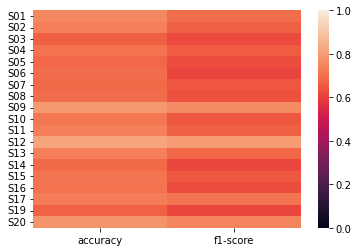

     class0 f1-score  class1 f1-score
S01         0.846154         0.354839
S02         0.833948         0.307692
S03         0.783883         0.253165
S04         0.814815         0.285714
S05         0.800000         0.208955
S06         0.813793         0.100000
S07         0.795699         0.313253
S08         0.804124         0.278481
S09         0.869565         0.493506
S10         0.825083         0.273973
S11         0.836364         0.237288
S12         0.881481         0.609756
S13         0.832168         0.333333
S14         0.804124         0.197183
S15         0.819113         0.273973
S16         0.820000         0.181818
S17         0.820717         0.444444
S19         0.787456         0.246914
S20         0.858156         0.487179


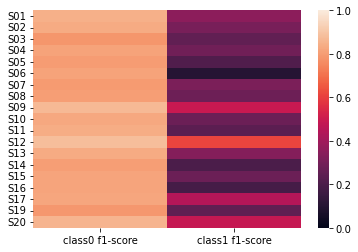

In [10]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
